# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50   0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75   0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00   0.265117        0.190800  0.086004  0.073142  0.210825   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.193065  0.002761  0.053163  0.051176  0.000073  
         0.50  0.181053  0.003095  0.069032  0.053052  0.000270  
         0.75  0.168418  0.003385  0.090652  0.055966  0.000592  
         1.00  0.154756  0.003706  0.116960  0.059768  0.001057

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


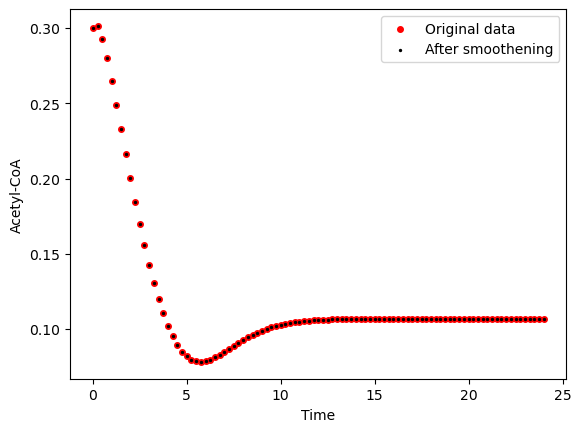

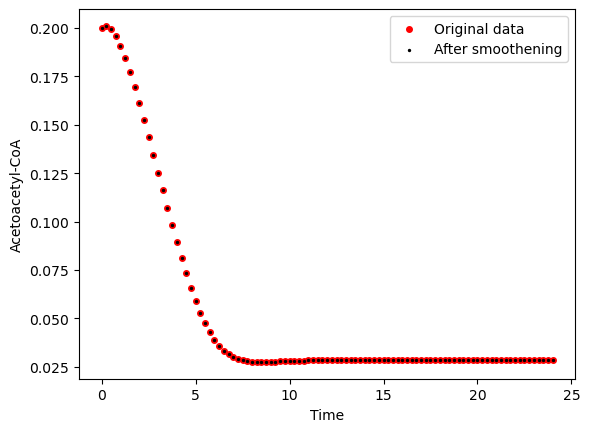

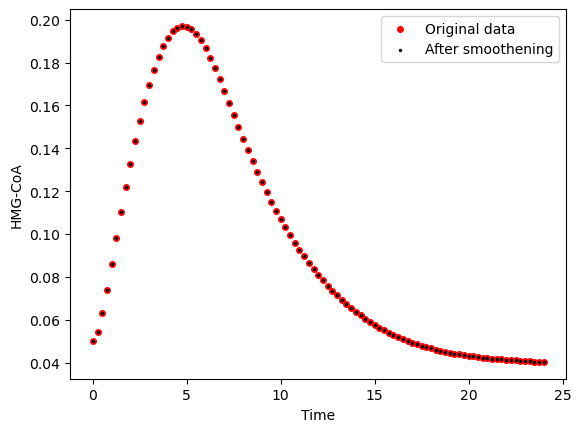

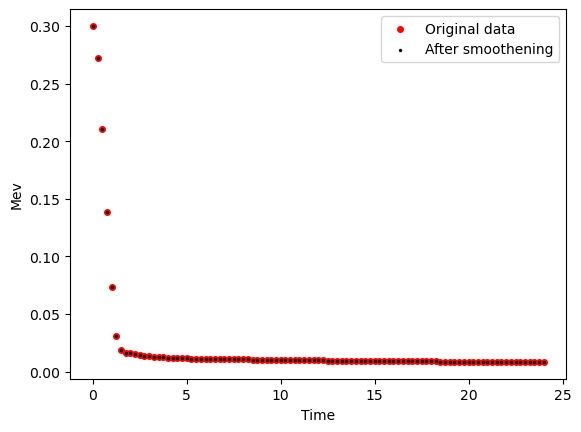

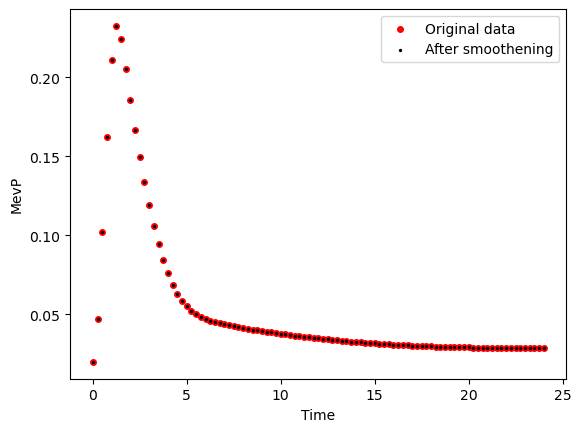

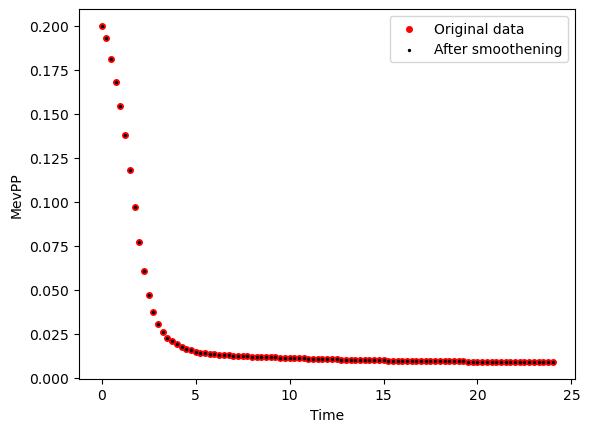

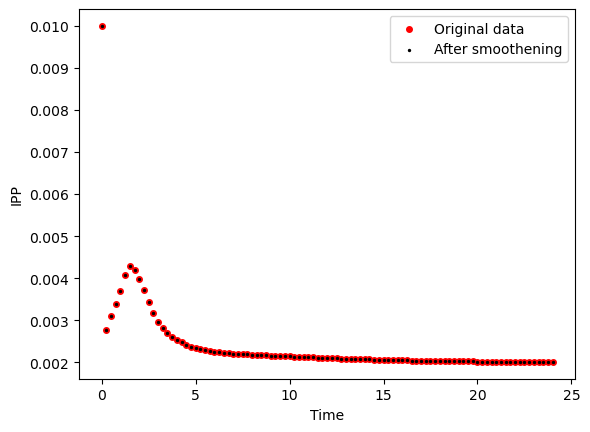

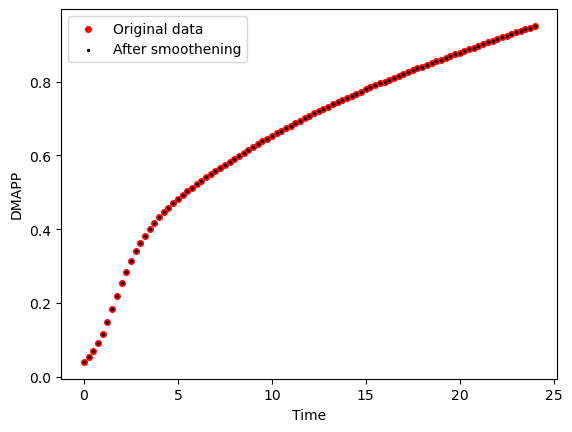

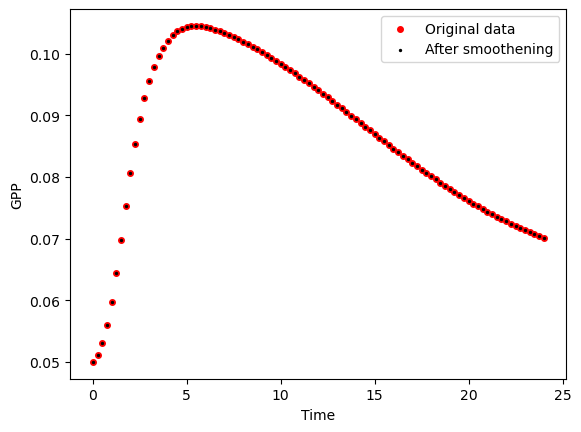

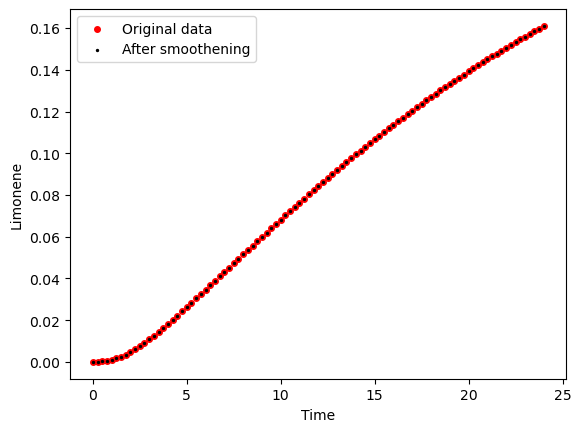

Strain Strain 2


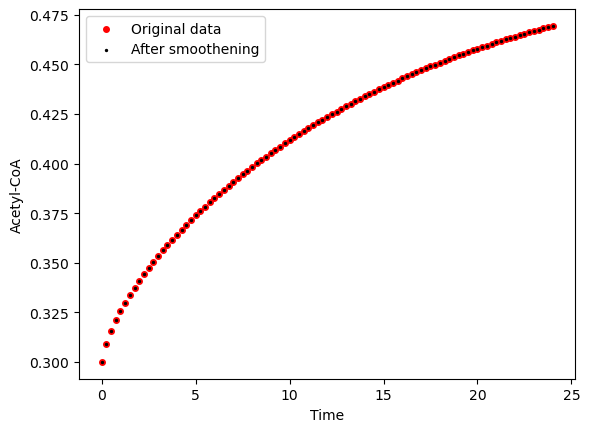

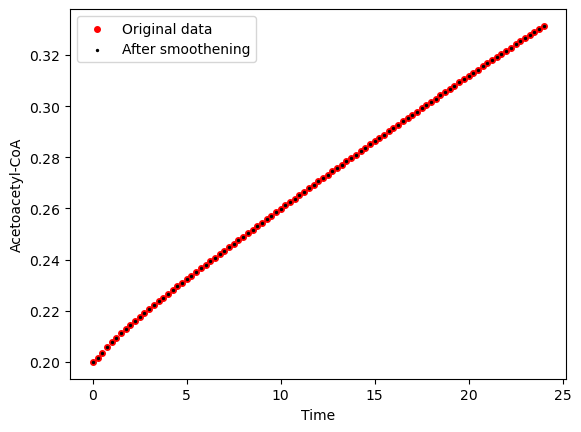

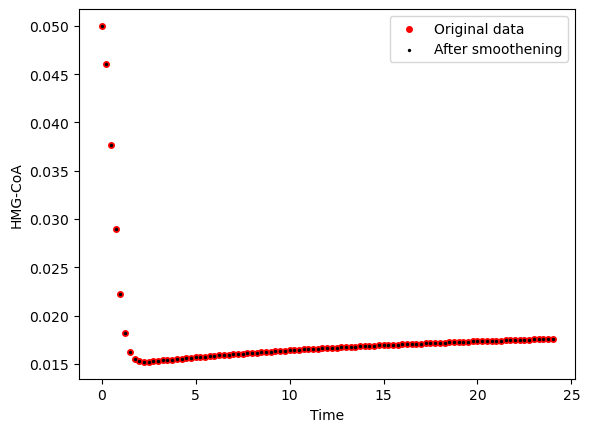

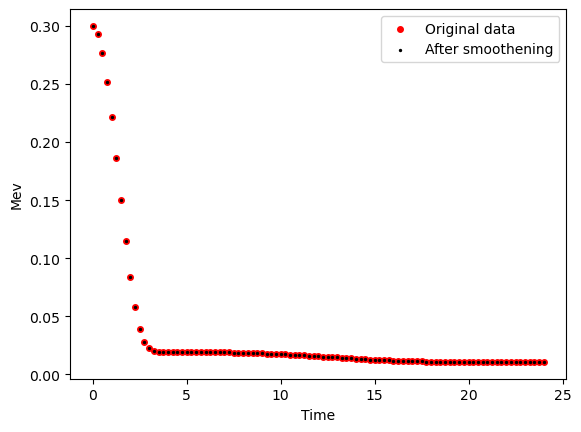

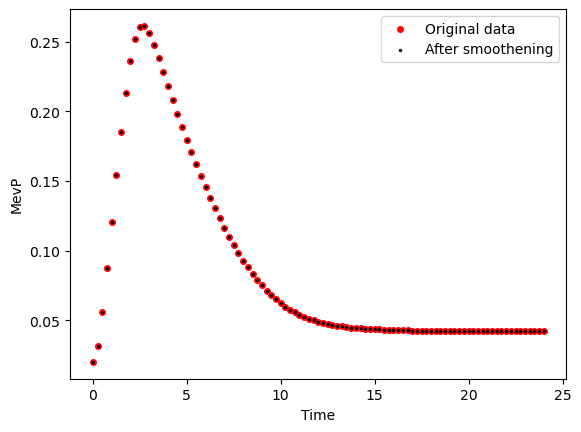

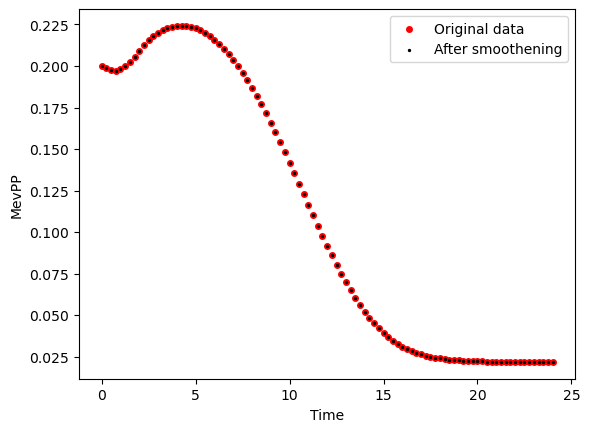

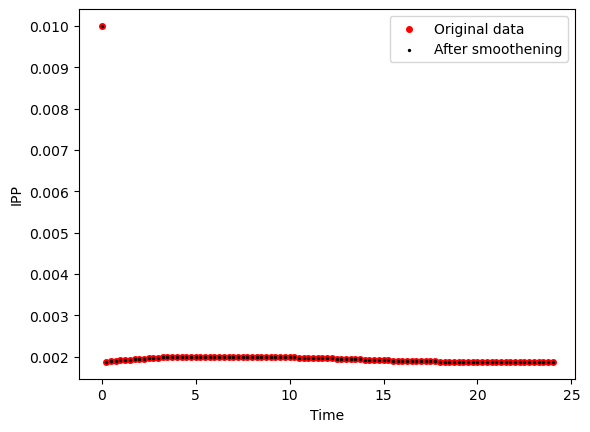

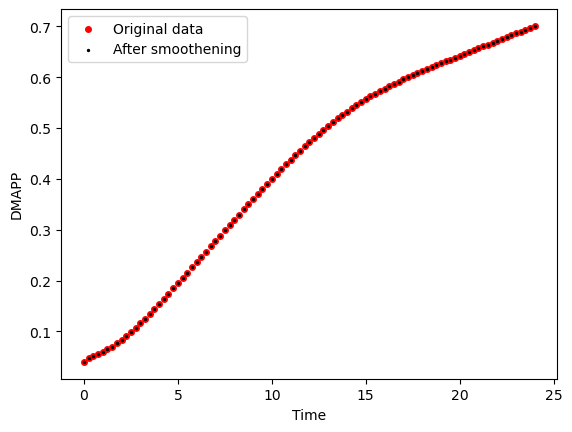

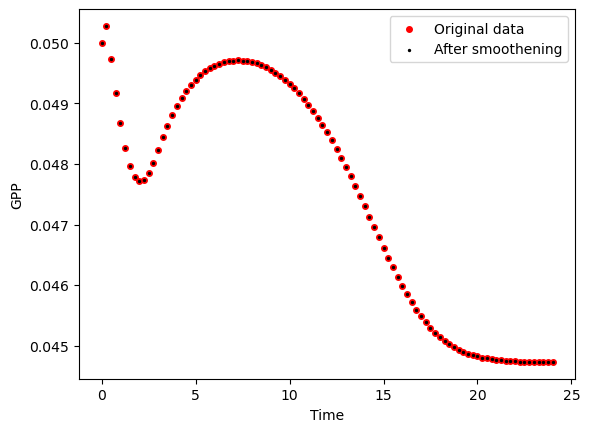

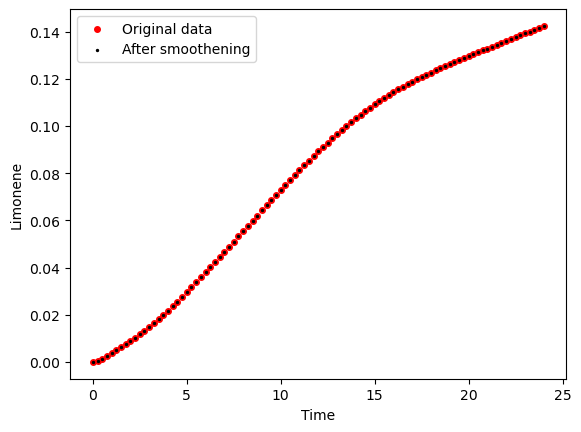

Strain Strain 3


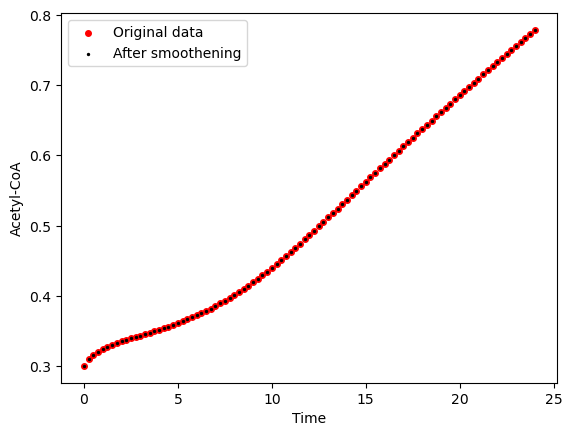

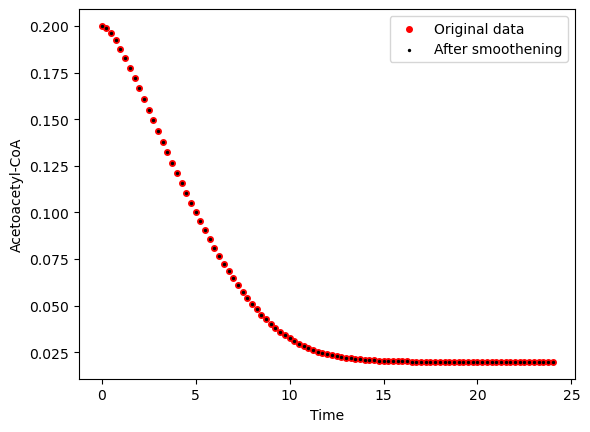

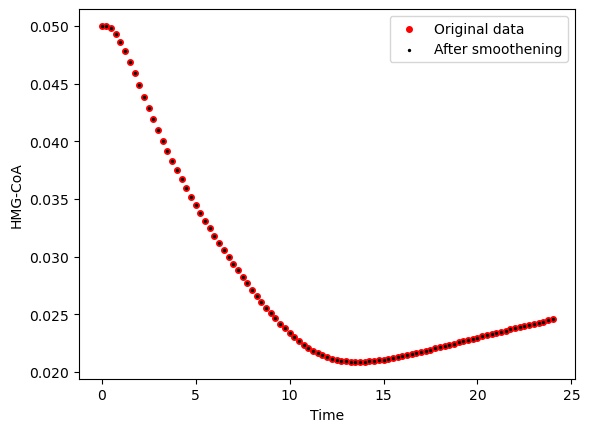

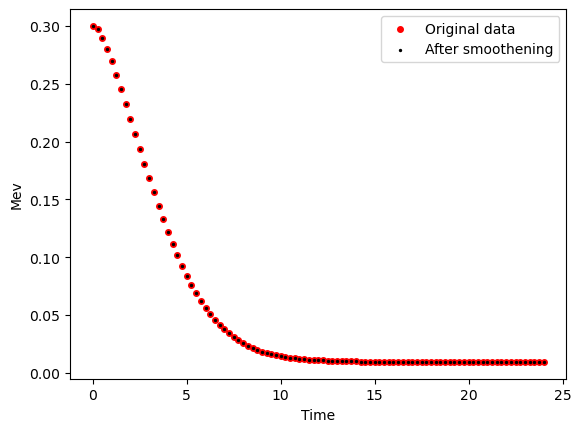

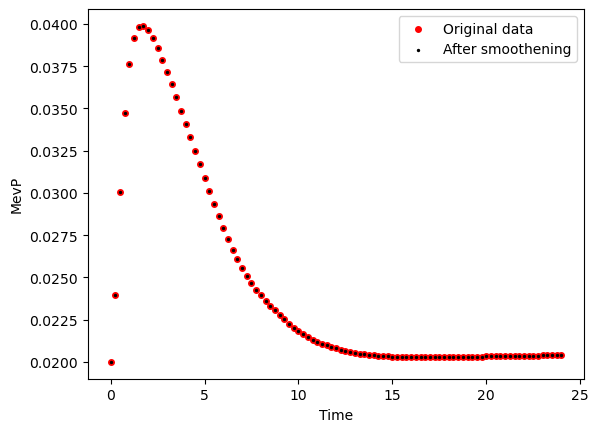

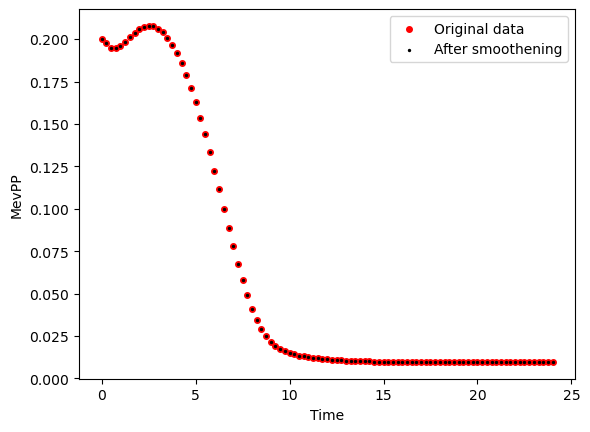

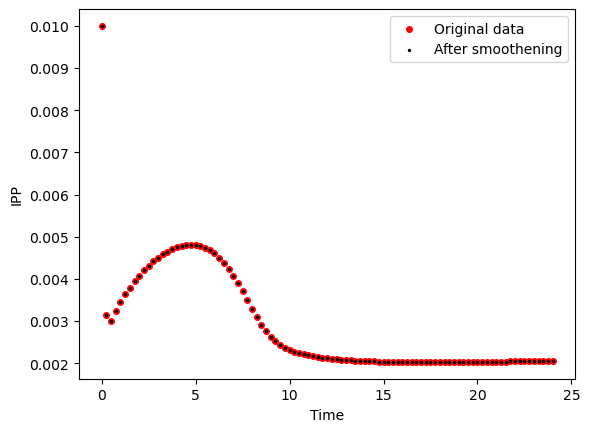

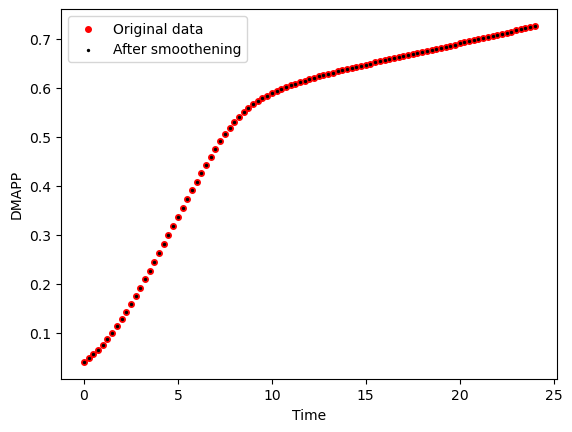

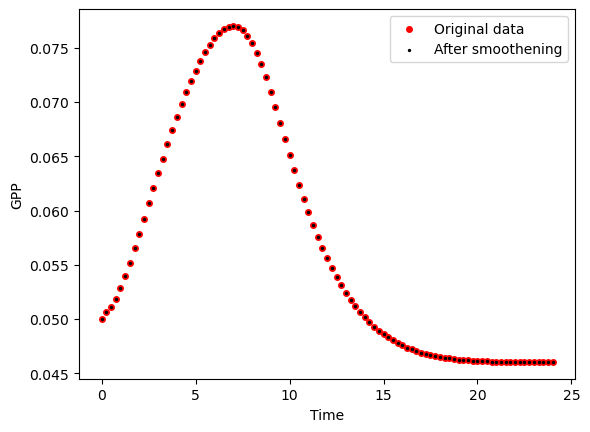

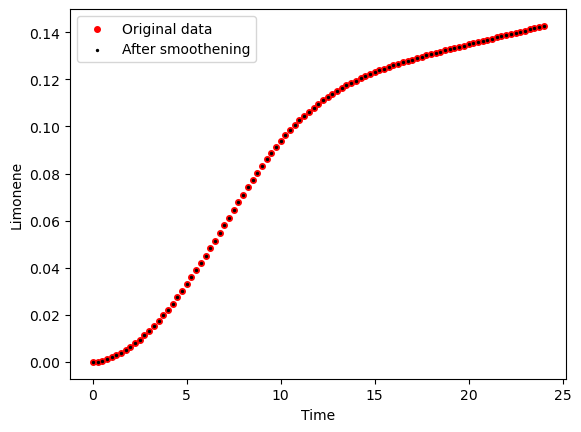

Strain WT


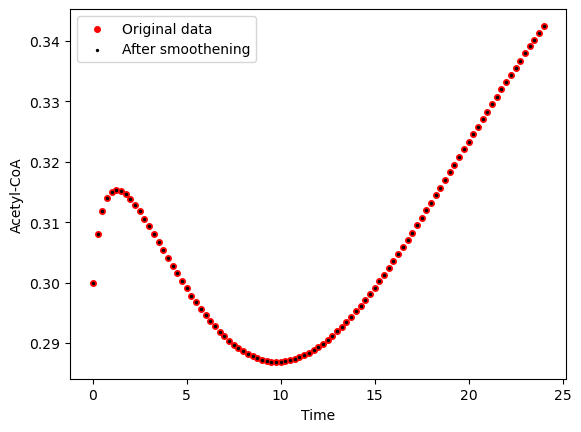

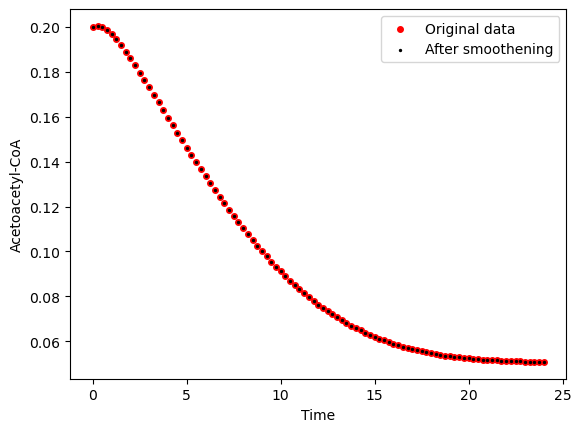

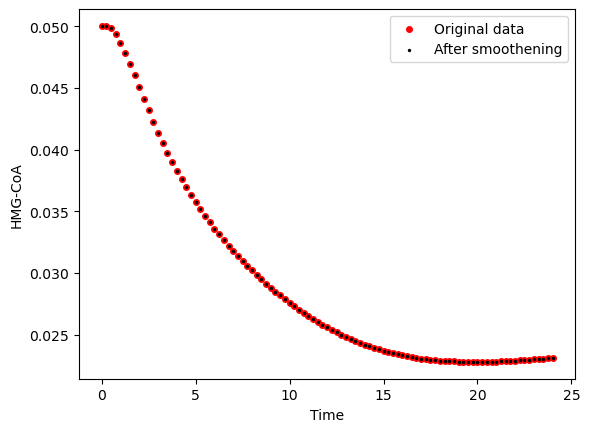

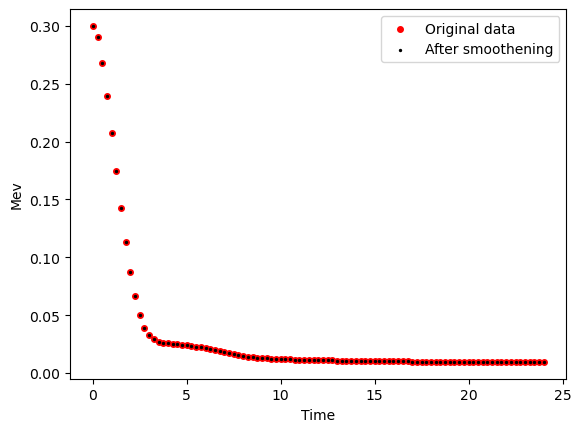

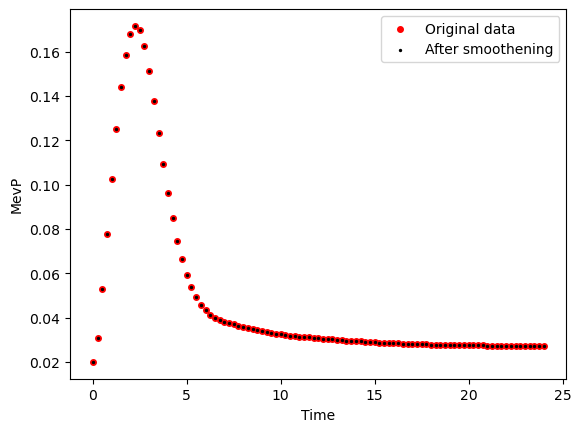

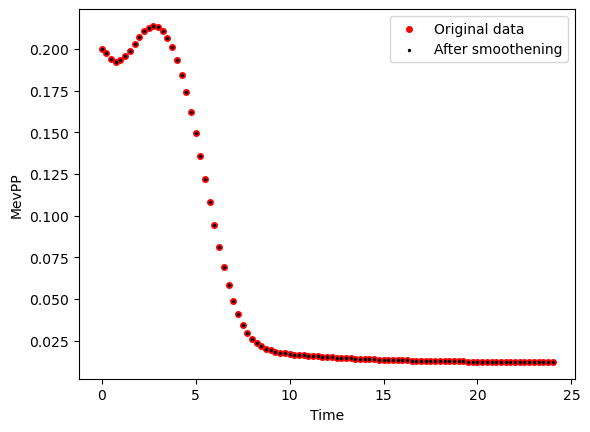

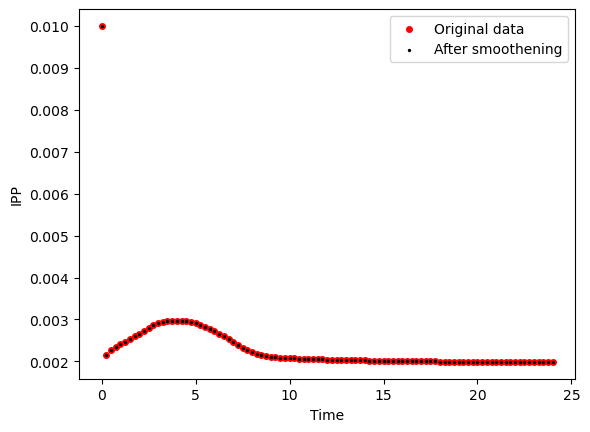

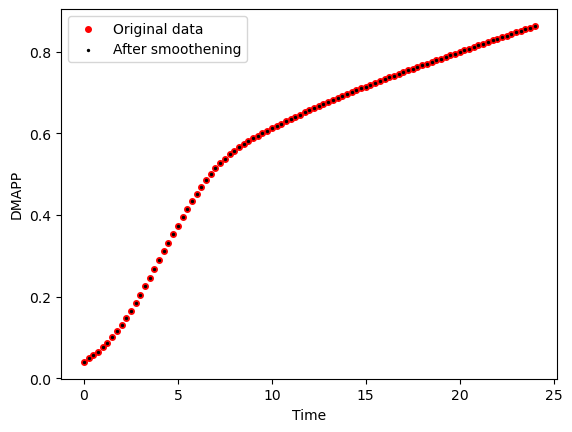

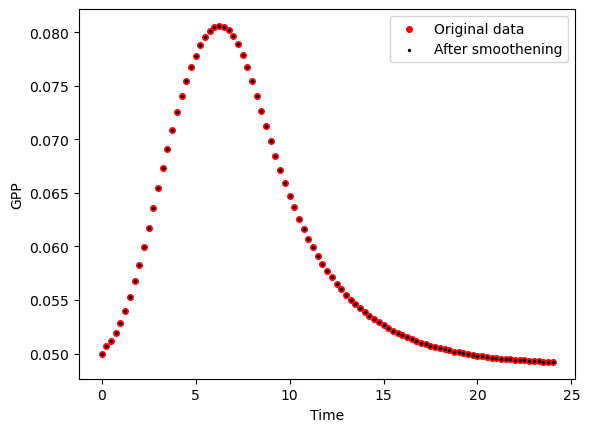

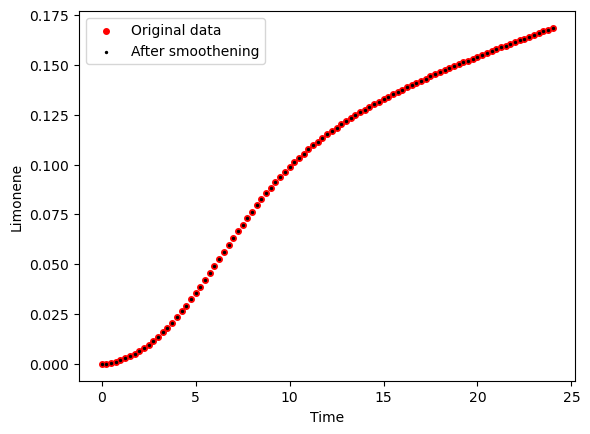

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


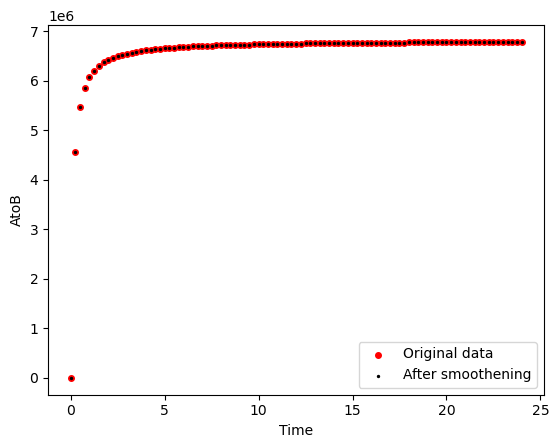

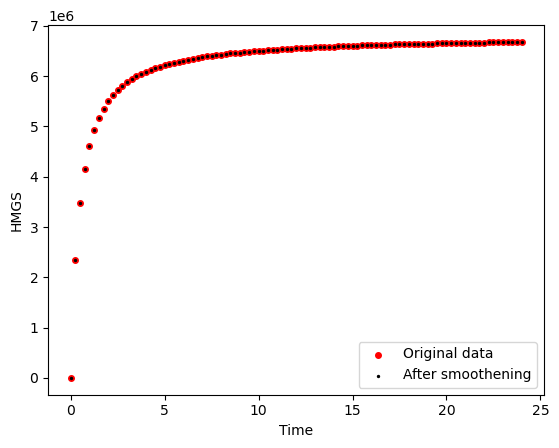

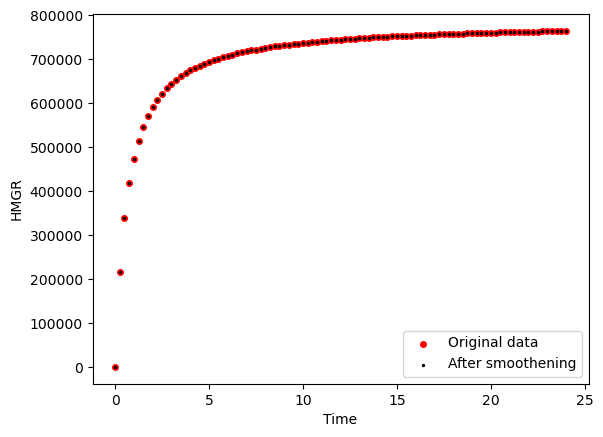

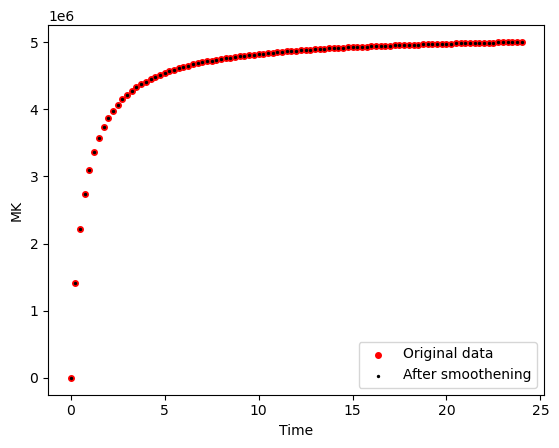

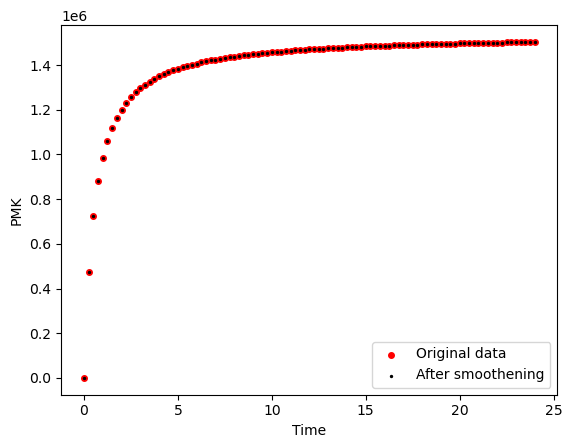

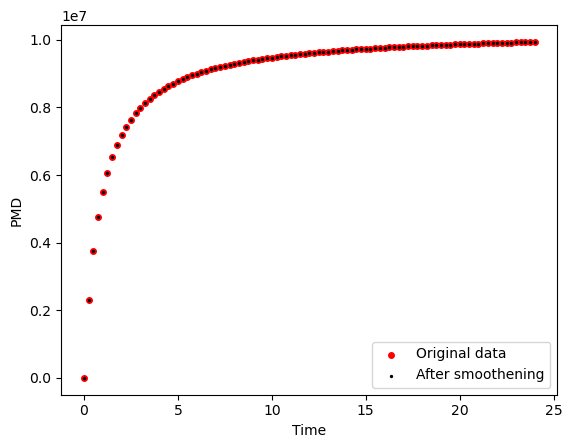

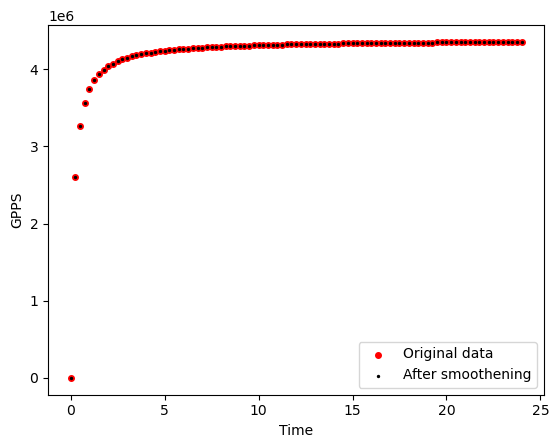

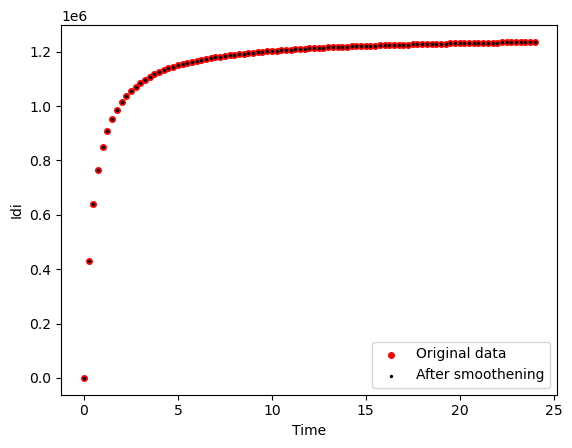

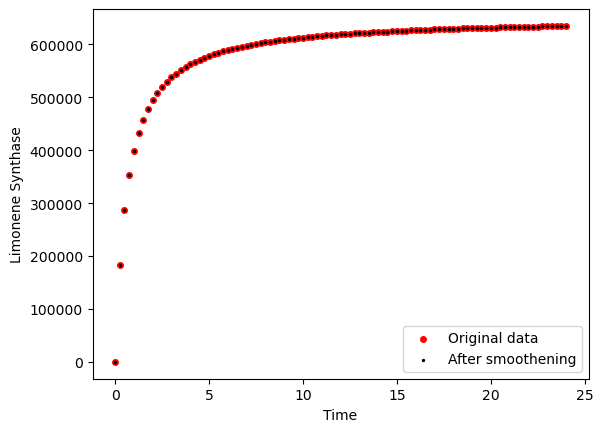

Strain Strain 2


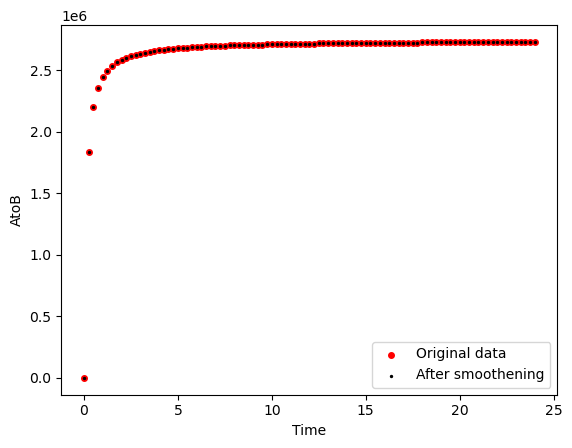

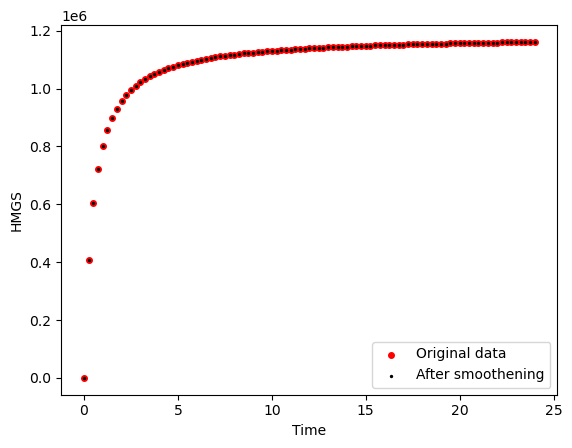

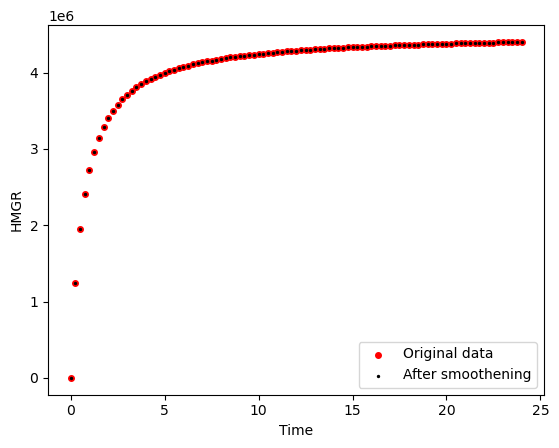

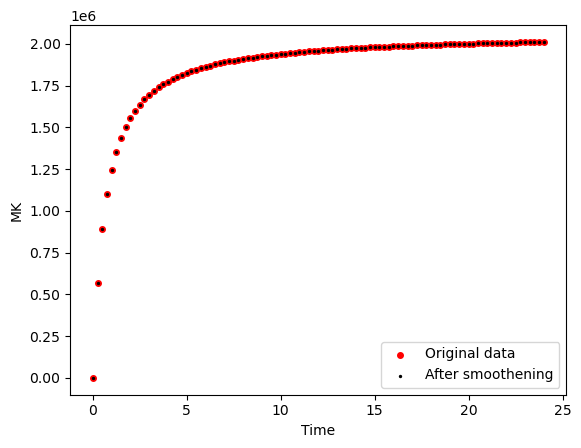

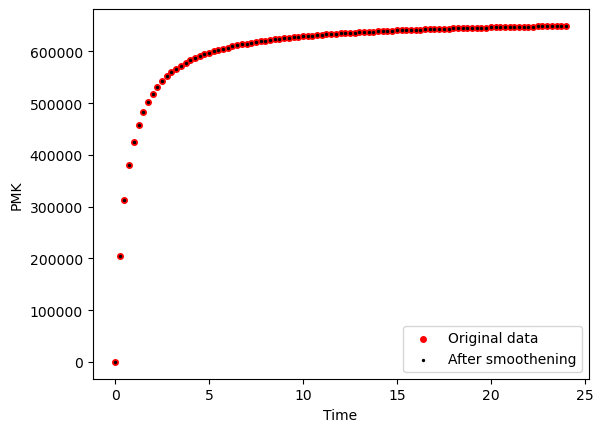

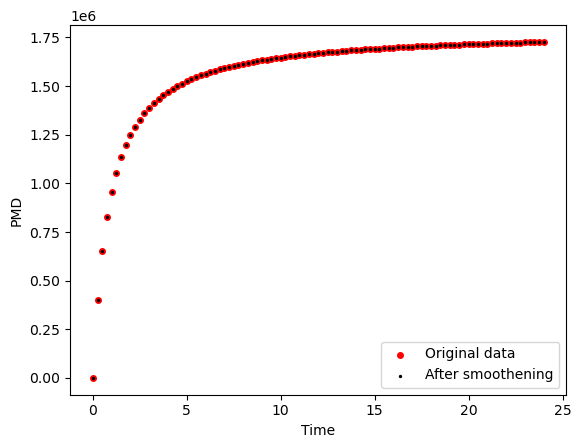

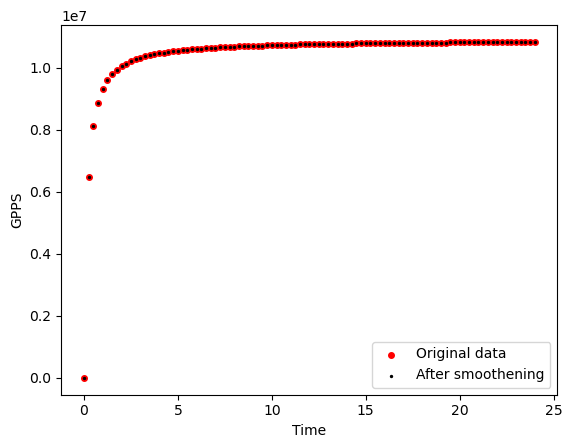

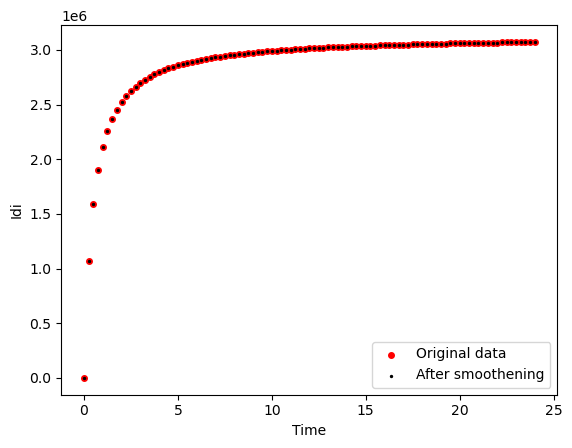

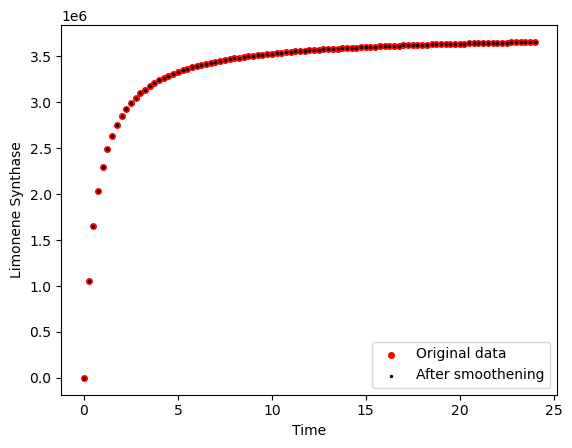

Strain Strain 3


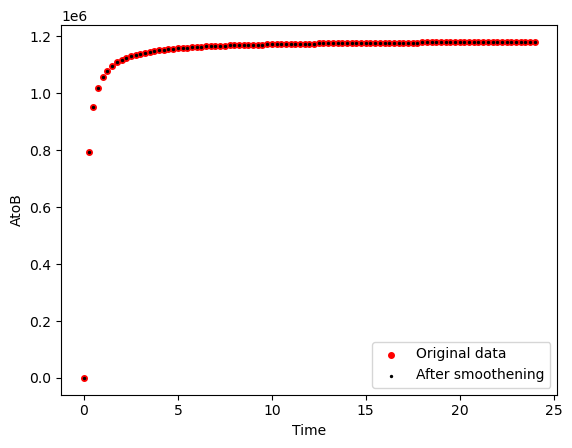

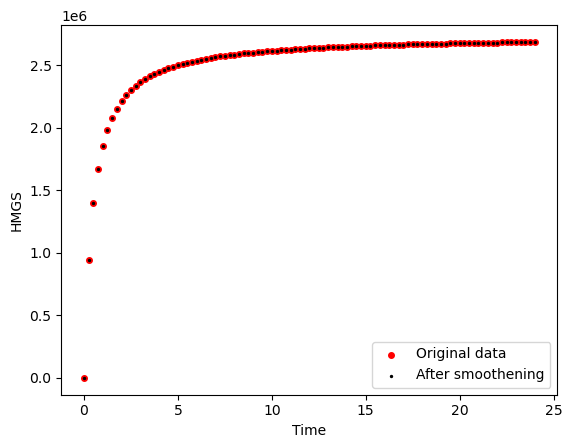

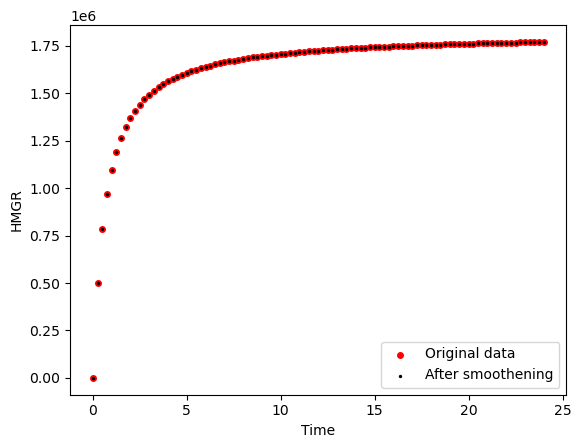

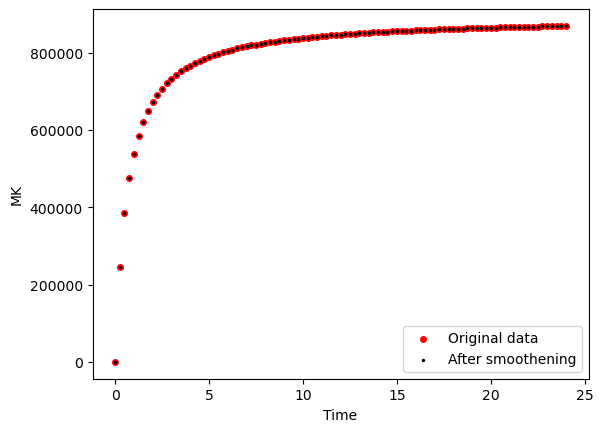

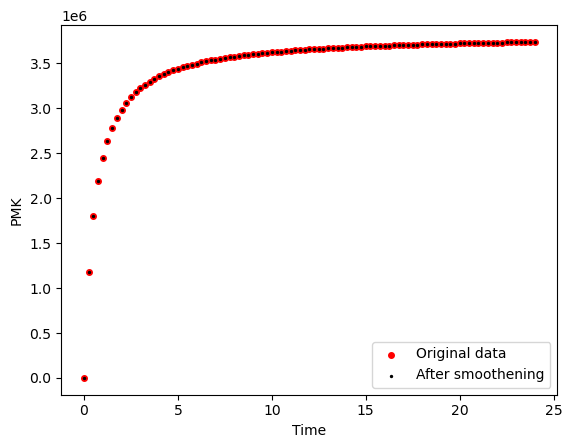

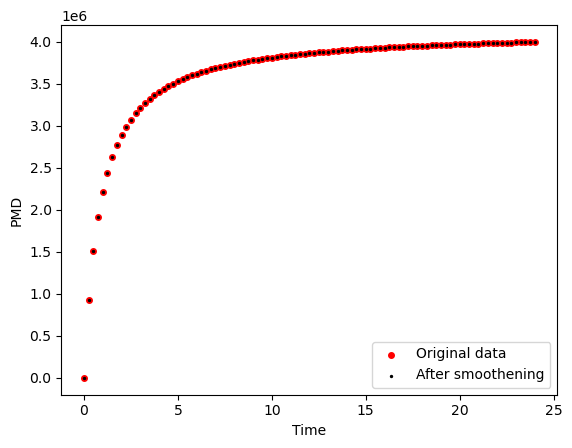

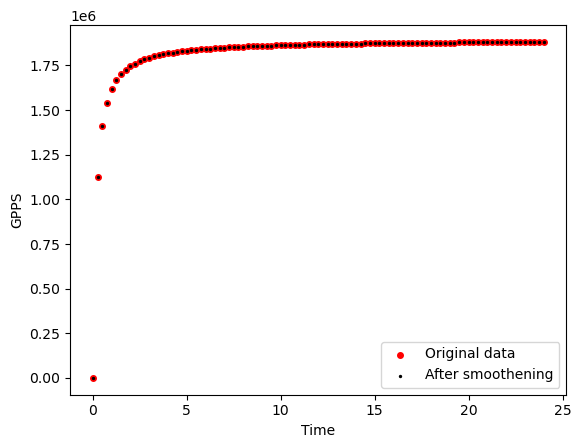

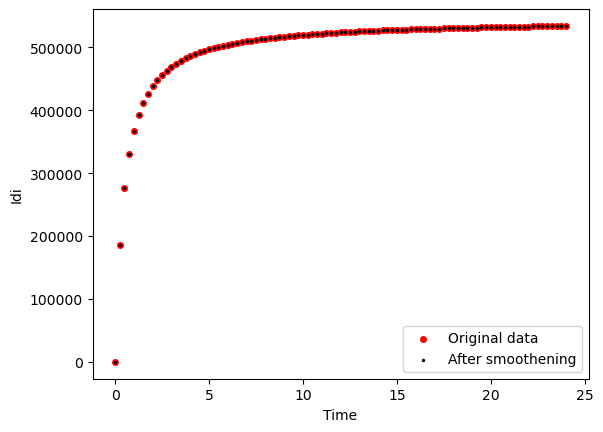

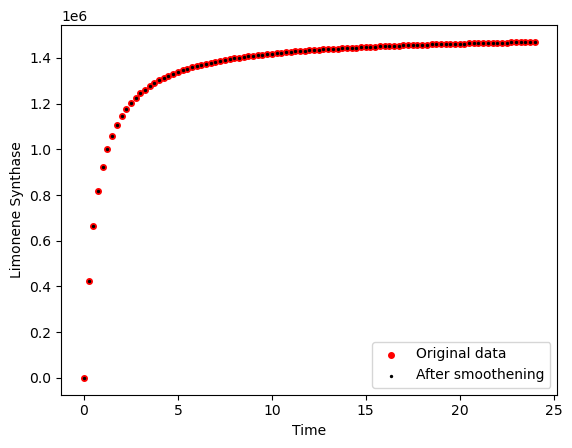

Strain WT


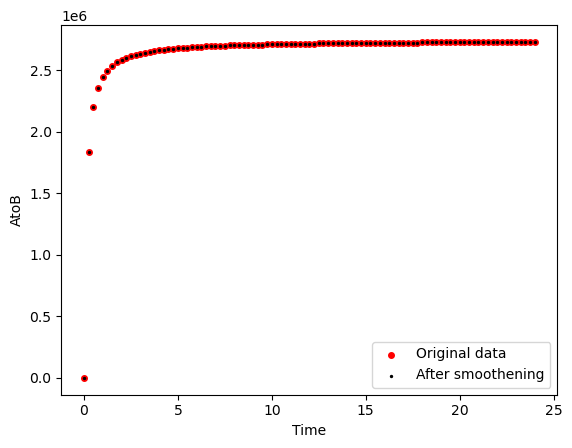

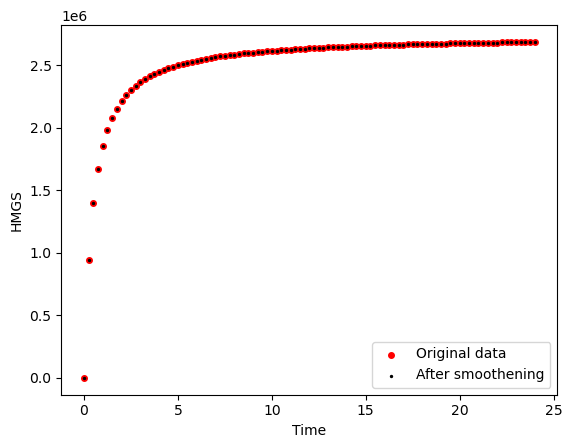

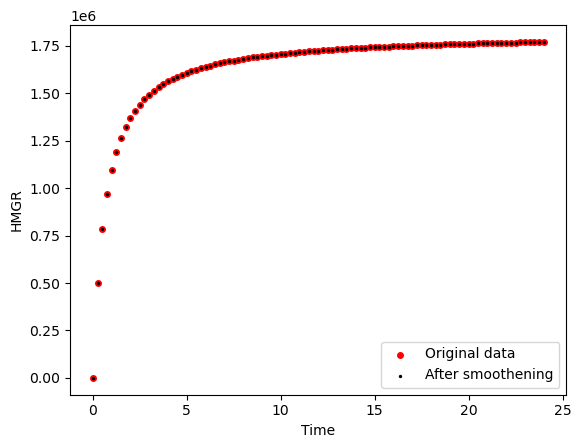

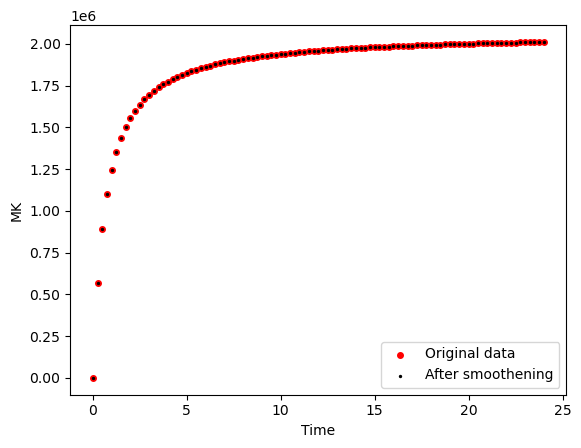

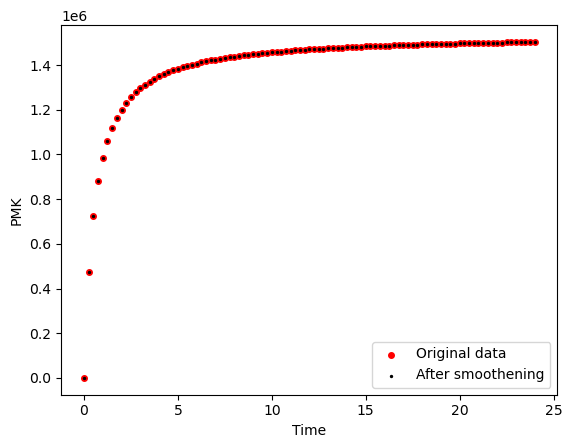

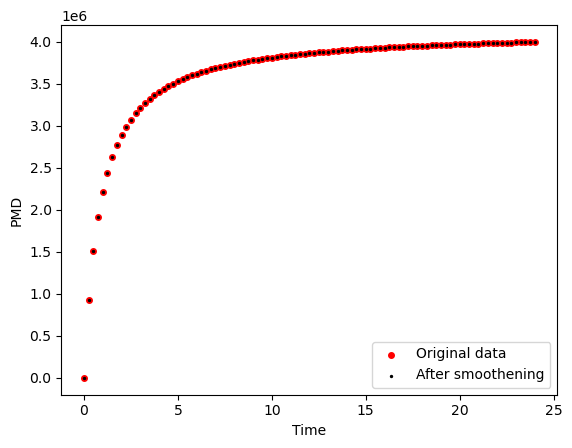

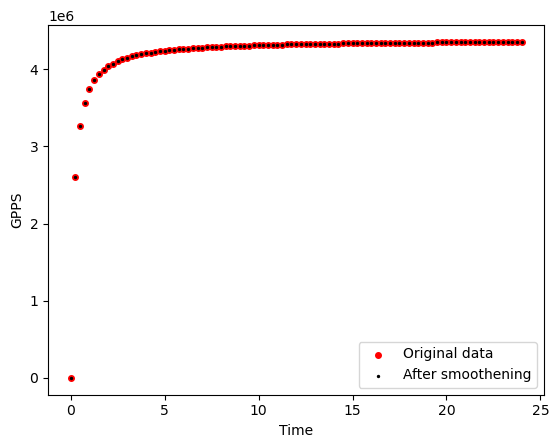

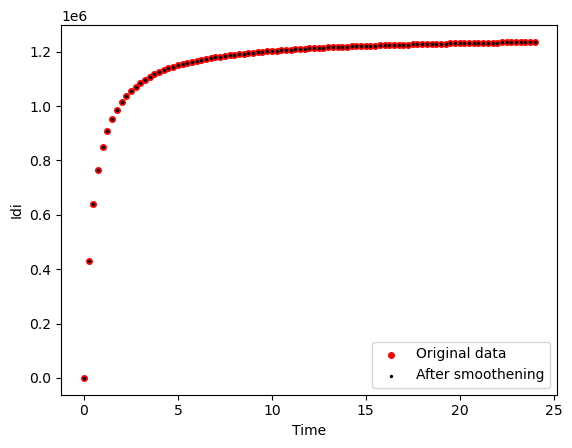

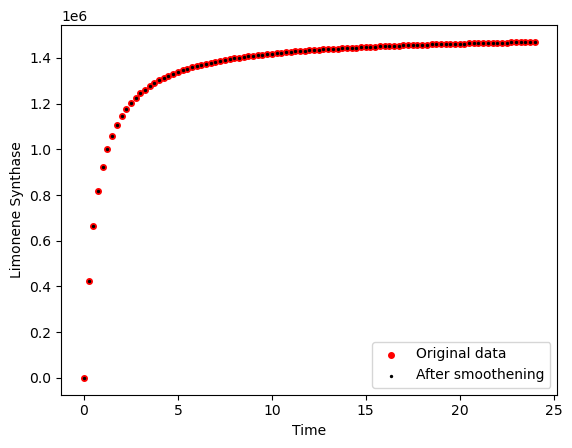

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50    0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75    0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00    0.265117        0.190800  0.086004  0.073142  0.210825   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.337903        0.050990  0.023000  0.009617  0.027290   
         23.25   0.339059        0.050942  0.023029  0.009614  0.027285   
         23.50   0.340204        0.050901  0.023058  0.009612  0.027281   
         23.75   0.341337        0.050867  0.023088  0.009610  0.027278   
         24.00   0.342458        0.050840  0.023119  0.009609  0.027277   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.193065  0.002761  0.053163  0.051176  0.000073  ...   
         0.50   0.181053  0.003095  0.069032  0.053052  0.000270  ...   
         0.75   0.168418  0.003385  0.090652  0.055966  0.000592  ...   
         1.00   0.154756  0.003706  0.116960  0.059768  0.001057  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.012208  0.001987  0.847895  0.049302  0.164976  ...   
         23.25  0.012202  0.001987  0.851852  0.049279  0.165862  ...   
         23.50  0.012197  0.001987  0.855807  0.049258  0.166746  ...   
         23.75  0.012194  0.001987  0.859761  0.049239  0.167627  ...   
         24.00  0.012191  0.001987  0.863714  0.049222  0.168506  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

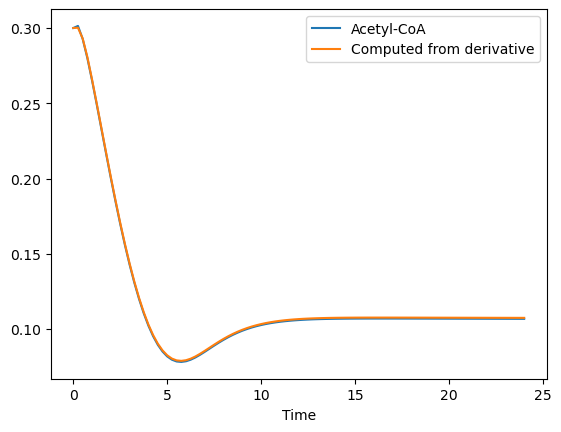

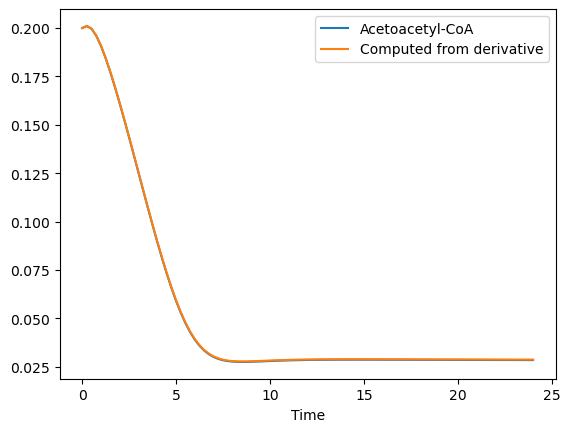

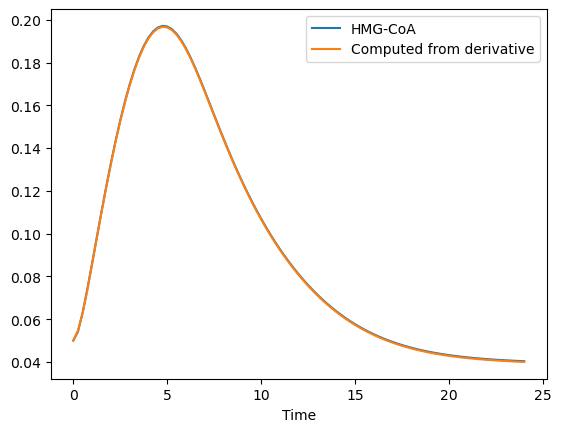

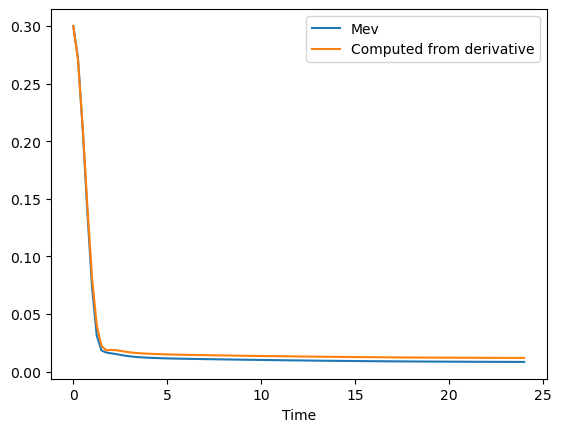

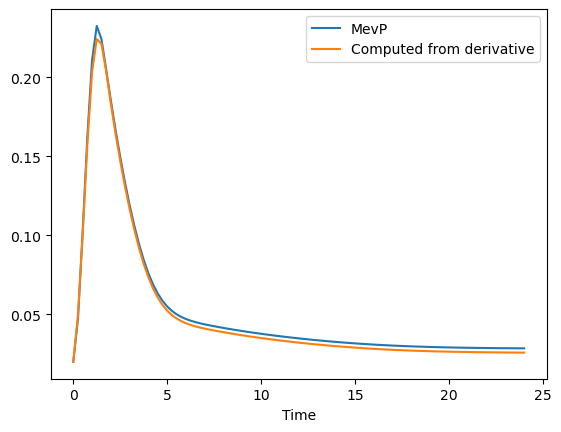

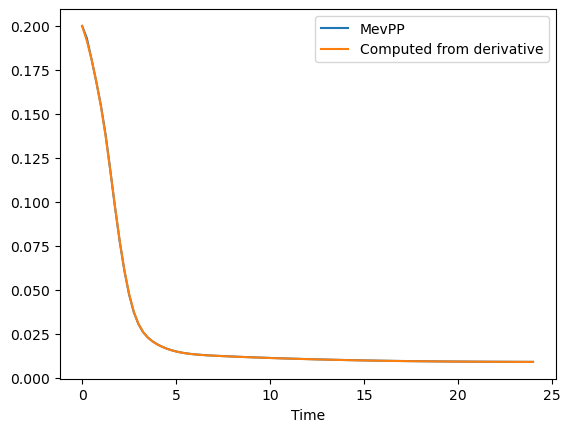

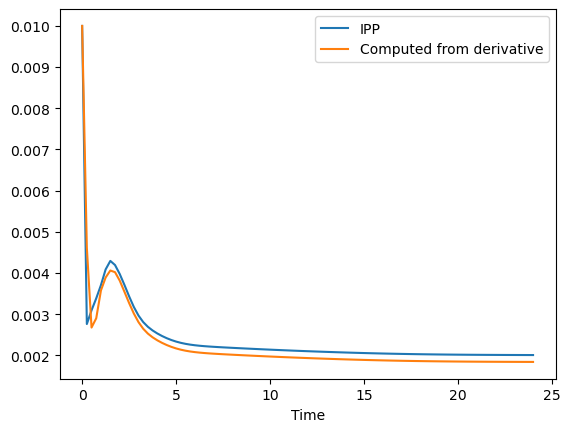

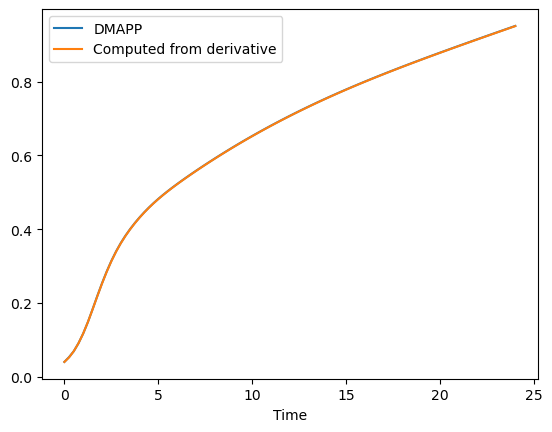

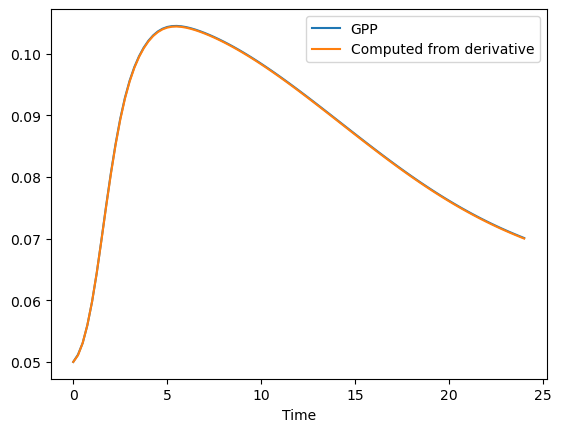

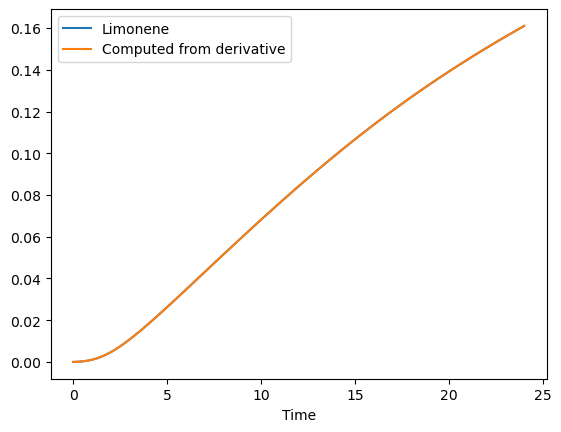

'Time profile from derivative vs. actual profile for Strain 2'

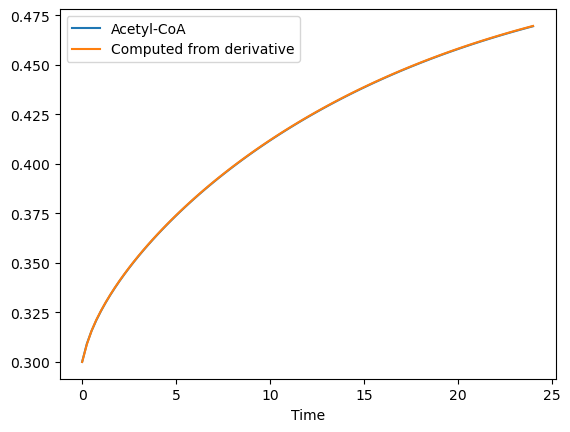

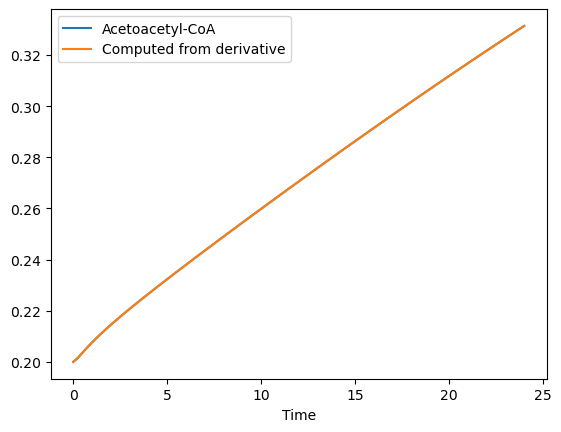

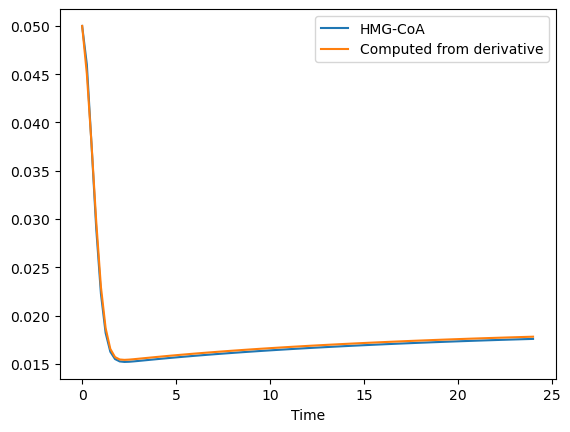

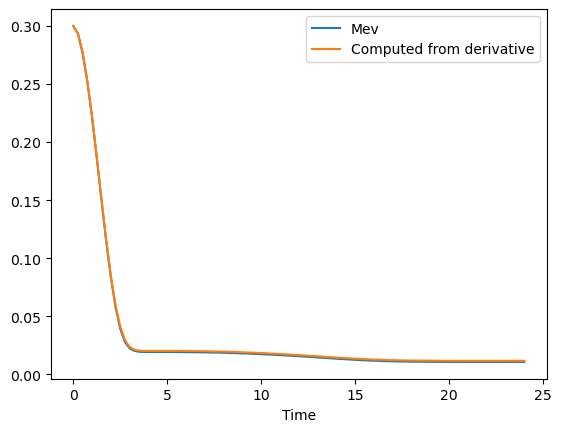

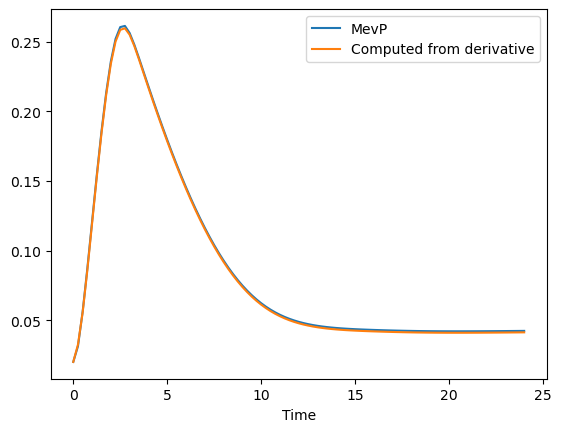

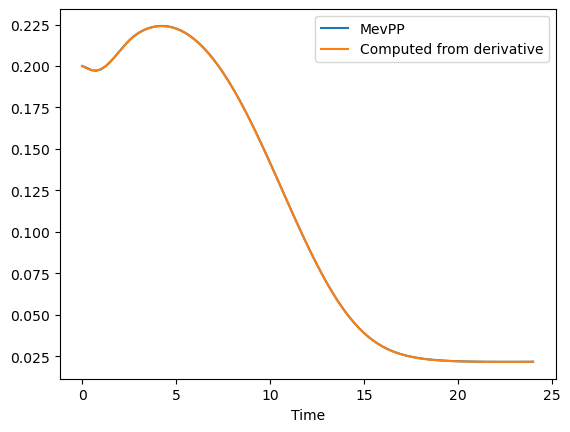

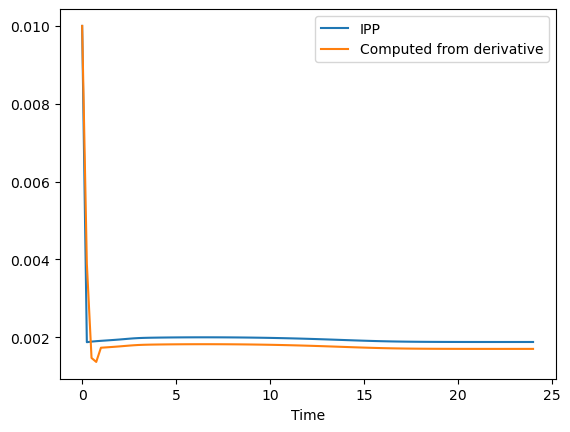

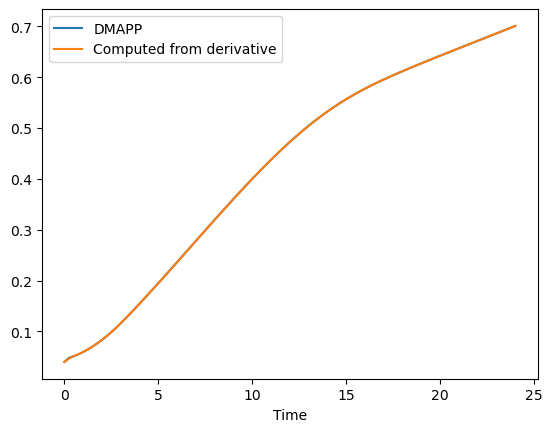

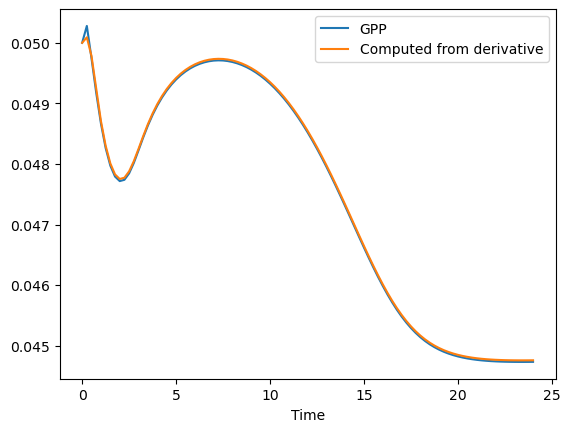

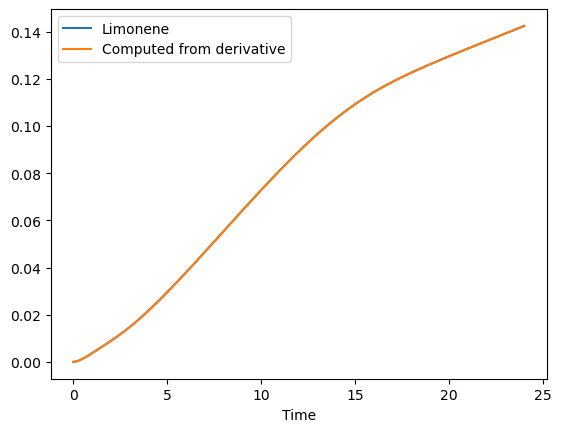

'Time profile from derivative vs. actual profile for Strain 3'

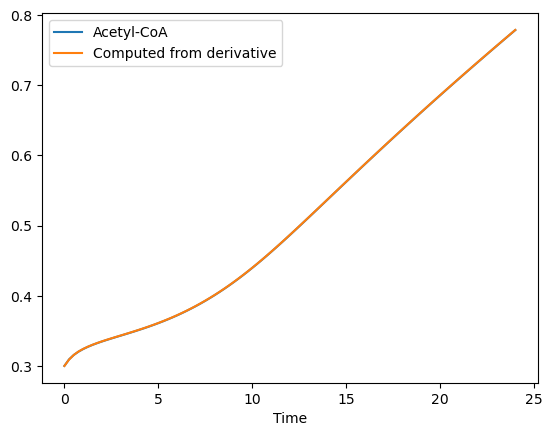

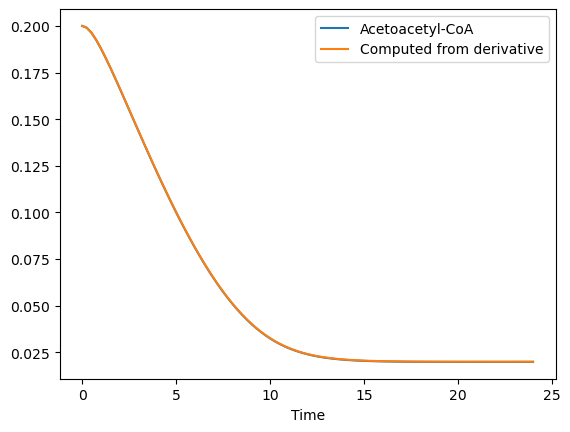

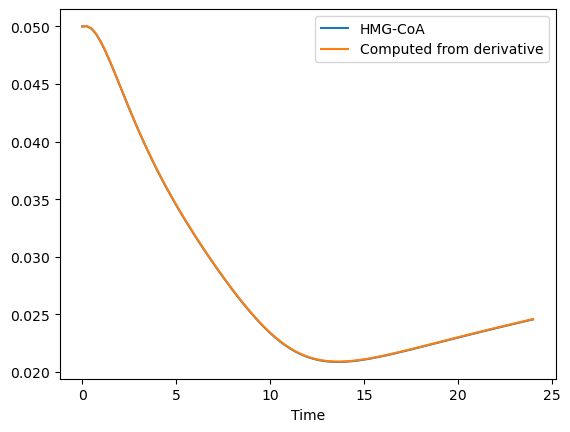

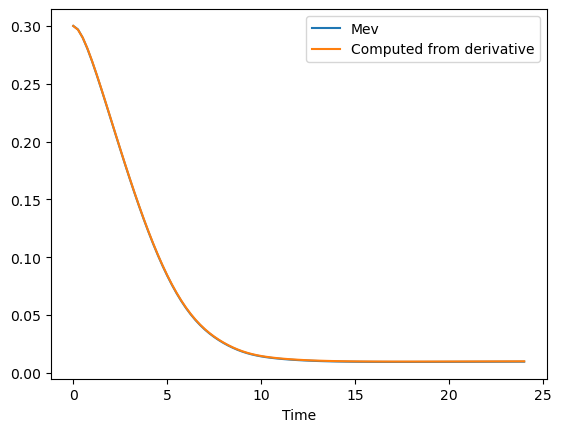

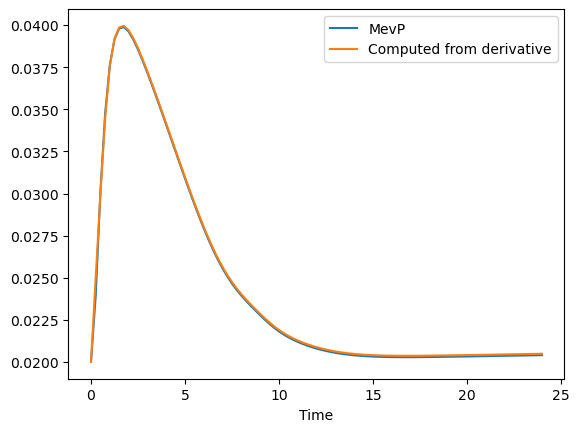

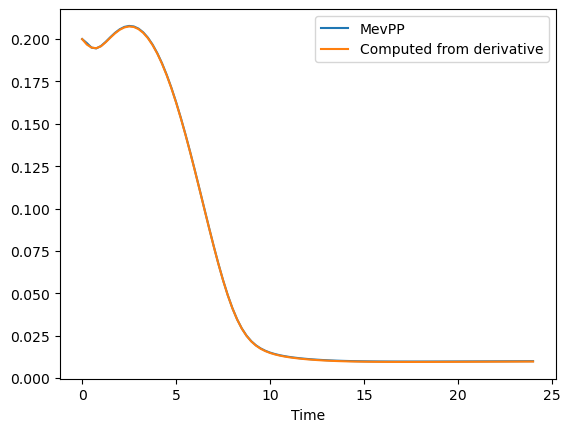

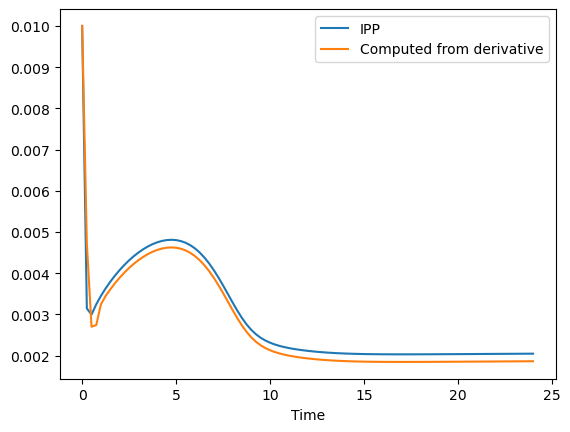

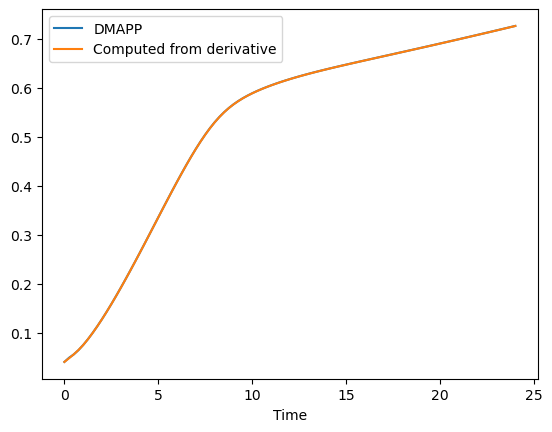

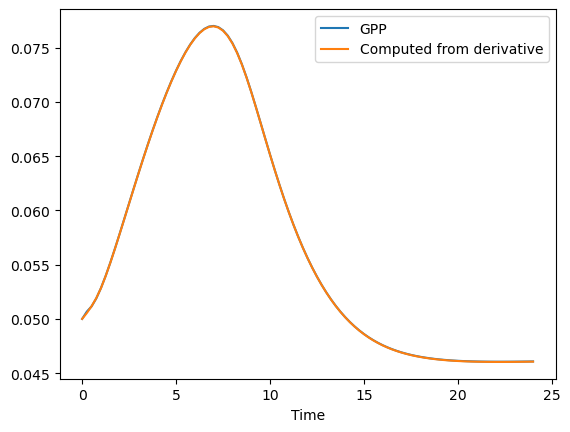

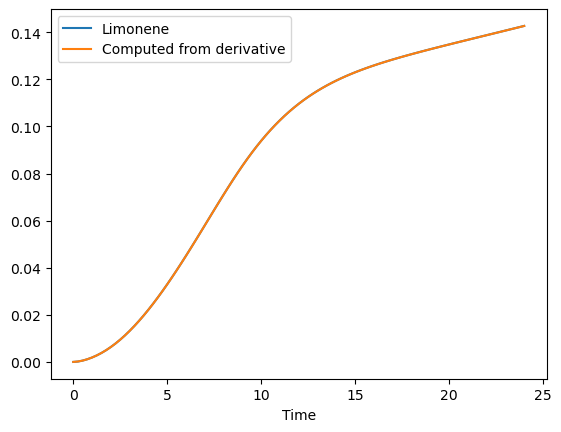

'Time profile from derivative vs. actual profile for WT'

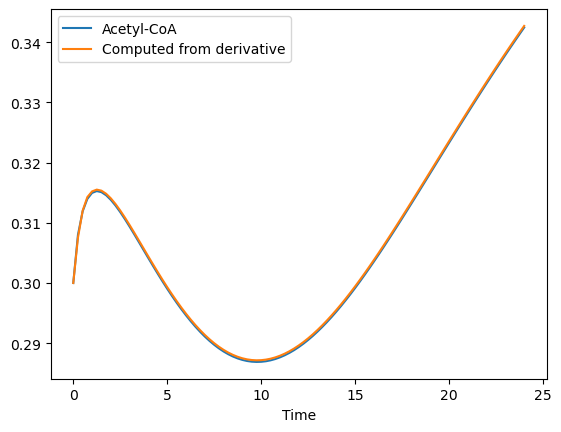

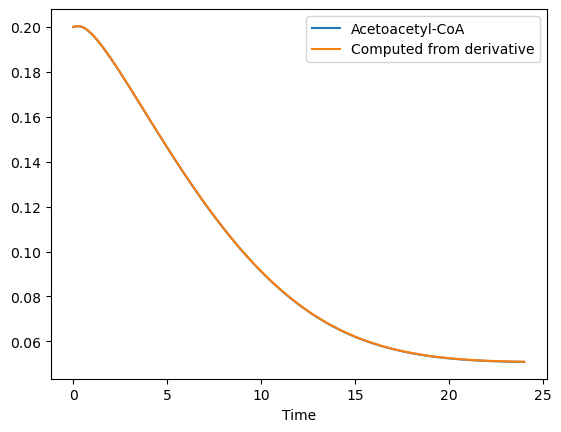

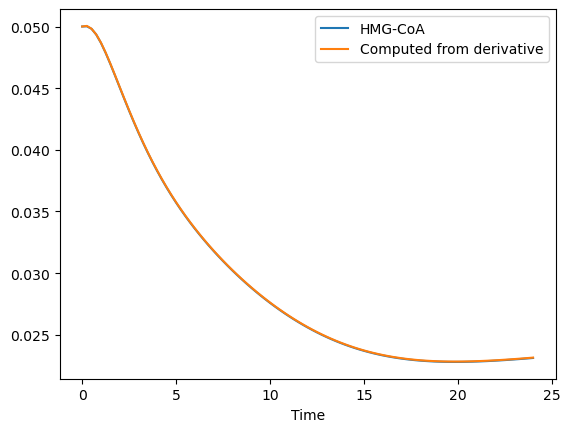

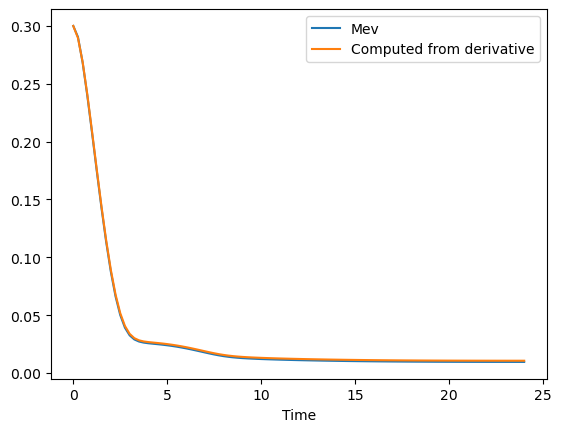

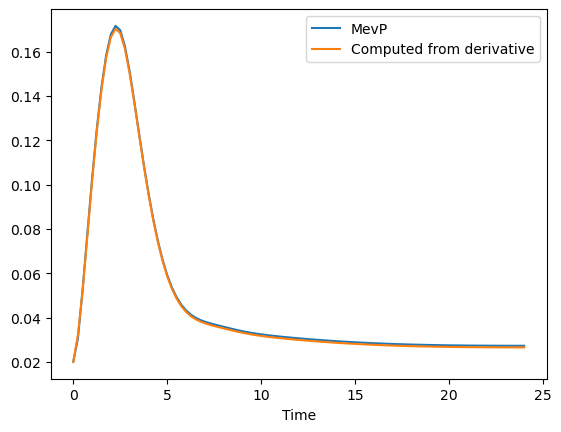

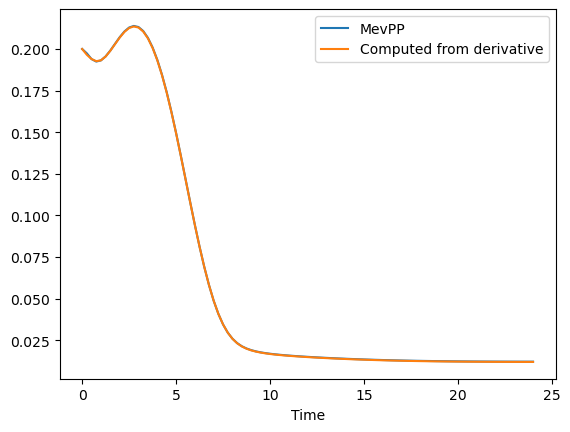

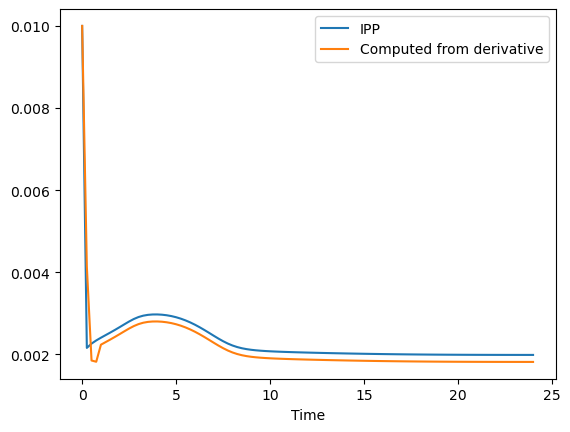

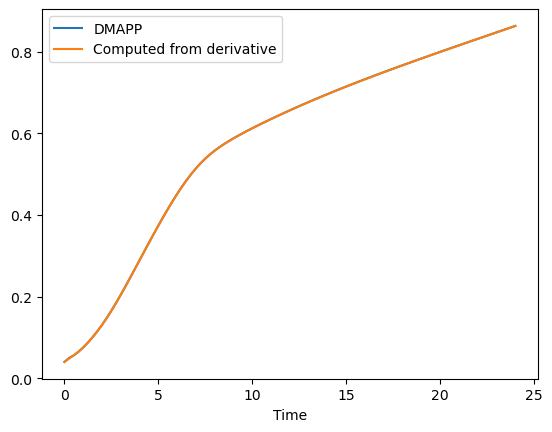

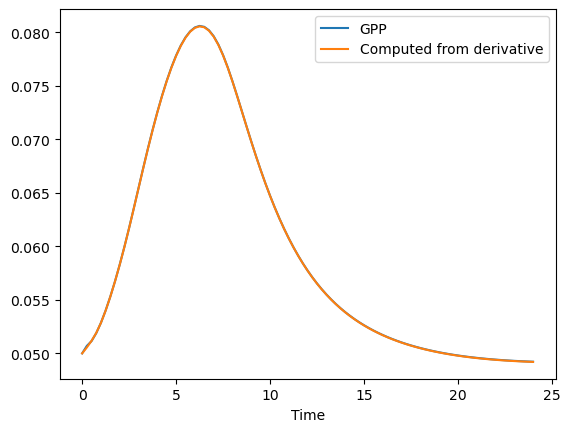

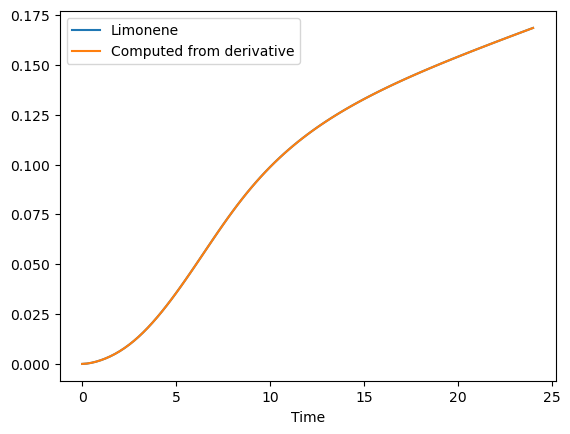

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.301391        0.200998  0.054156   
         0.50       2.866143e+05   0.292768        0.199655  0.063090   
         0.75       3.524272e+05   0.279998        0.196032  0.074110   
         1.00       3.981392e+05   0.265117        0.190800  0.086004   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.337903        0.050990  0.023000   
         23.25      1.468435e+06   0.339059        0.050942  0.023029   
         23.50      1.468851e+06   0.340204        0.050901  0.023058   
         23.75      1.469260e+06   0.341337        0.050867  0.023088   
         24.00      1.469659e+06   0.342458        0.050840  0.023119   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.272337  0.047074  0.193065  0.002761  0.053163  0.051176   
         0.50   0.211002  0.102371  0.181053  0.003095  0.069032  0.053052   
         0.75   0.138704  0.162352  0.168418  0.003385  0.090652  0.055966   
         1.00   0.073142  0.210825  0.154756  0.003706  0.116960  0.059768   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.009617  0.027290  0.012208  0.001987  0.847895  0.049302   
         23.25  0.009614  0.027285  0.012202  0.001987  0.851852  0.049279   
         23.50  0.009612  0.027281  0.012197  0.001987  0.855807 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.507546e-07  0.015814 -0.000072  0.003521  
         24.00 -0.000010 -7.381028e-08  0.015812 -0.000065  0.003514  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-1.30103                         
                         ]), # lower bounds
                         xu=np.array([
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0,-1.301029
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,
                       k21,k22,k23,
                       k31,k32,k33,k34,
                       k41,k42,k43,k44,
                       k51,k52,
                       k61,k62,k63,k64,
                       k71,k72,
                       k81,k82,k83,
                       k91,k92,
                       Vin): #HC: 27
    
        r1 = e1 *( (10**k11) + (10**k12)*np.log(s1) )
        r2 = e2 *( (10**k21) + (10**k22)*np.log(s1) + (10**k23)*np.log(s2) ) 
        r3 = e3 *( (10**k31) - (10**k32)*np.log(s1) - (10**k33)*np.log(s2) + (10**k34)*np.log(s3) )
        r4 = e4 *( (10**k41) + (10**k42)*np.log(s4) - (10**k43)*np.log(s9) - (10**k44)*np.log(s6) )
        r5 = e5 *( (10**k51) + (10**k52)*np.log(s5) )
        r6 = e6 *( (10**k61) + (10**k62)*np.log(s6) - (10**k63)*np.log(s5) - (10**k64)*np.log(s4) )
        r7 = e7 *( (10**k71) + (10**k72)*np.log(s7) )
        r8 = e8 *( (10**k81) + (10**k82)*np.log(s7) + (10**k83)*np.log(s8) )
        r9 = e9 *( (10**k91) + (10**k92)*np.log(s9) )
        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 |  1.351681E+18 |  3.686716E+12
     2 |      128 |  3.870419E+17 |  3.969547E+10
     3 |      192 |  1.656134E+17 |  4.062148E+09
     4 |      256 |  1.452943E+17 |  2.821699E+07
     5 |      320 |  3.420636E+14 |  1.525160E+06
     6 |      384 |  1.581926E+10 |  1.036829E+05
     7 |      448 |  1.555835E+10 |  2.385611E+04
     8 |      512 |  7.720948E+05 |  1.021687E+04
     9 |      576 |  7.537942E+05 |  7.537471E+03
    10 |      640 |  1.105602E+04 |  5.078094E+03
    11 |      704 |  6.335313E+03 |  4.419425E+03
    12 |      768 |  4.703832E+03 |  3.781351E+03
    13 |      832 |  3.891333E+03 |  3.035616E+03
    14 |      896 |  3.335176E+03 |  2.972026E+03
    15 |      960 |  3.106496E+03 |  2.735365E+03
    16 |     1024 |  2.737279E+03 |  2.255357E+03
    17 |     1088 |  2.305106E+03 |  1.912997E+03
    18 |     1152 |  2.037350E+03 |  1.756676E+03
    19 |     1216 |  1.86

   162 |    10368 |  2.820309E+01 |  2.809333E+01
   163 |    10432 |  2.811992E+01 |  2.801250E+01
   164 |    10496 |  2.802298E+01 |  2.793596E+01
   165 |    10560 |  2.793557E+01 |  2.779382E+01
   166 |    10624 |  2.783899E+01 |  2.762461E+01
   167 |    10688 |  2.775549E+01 |  2.754392E+01
   168 |    10752 |  2.762444E+01 |  2.743005E+01
   169 |    10816 |  2.746659E+01 |  2.729156E+01
   170 |    10880 |  2.735090E+01 |  2.719609E+01
   171 |    10944 |  2.724063E+01 |  2.707243E+01
   172 |    11008 |  2.710950E+01 |  2.693294E+01
   173 |    11072 |  2.693014E+01 |  2.670067E+01
   174 |    11136 |  2.681553E+01 |  2.666039E+01
   175 |    11200 |  2.670359E+01 |  2.656503E+01
   176 |    11264 |  2.662763E+01 |  2.653377E+01
   177 |    11328 |  2.654587E+01 |  2.633404E+01
   178 |    11392 |  2.639289E+01 |  2.611231E+01
   179 |    11456 |  2.622219E+01 |  2.596394E+01
   180 |    11520 |  2.607376E+01 |  2.581197E+01
   181 |    11584 |  2.589629E+01 |  2.560762E+01


   326 |    20864 |  1.313452E+01 |  1.311013E+01
   327 |    20928 |  1.311689E+01 |  1.309275E+01
   328 |    20992 |  1.309328E+01 |  1.306853E+01
   329 |    21056 |  1.307245E+01 |  1.305676E+01
   330 |    21120 |  1.305786E+01 |  1.303751E+01
   331 |    21184 |  1.303962E+01 |  1.301442E+01
   332 |    21248 |  1.301001E+01 |  1.296492E+01
   333 |    21312 |  1.298526E+01 |  1.294353E+01
   334 |    21376 |  1.296053E+01 |  1.292173E+01
   335 |    21440 |  1.289578E+01 |  1.281843E+01
   336 |    21504 |  1.285591E+01 |  1.280372E+01
   337 |    21568 |  1.282090E+01 |  1.279411E+01
   338 |    21632 |  1.277268E+01 |  1.259943E+01
   339 |    21696 |  1.265015E+01 |  1.259301E+01
   340 |    21760 |  1.261083E+01 |  1.258002E+01
   341 |    21824 |  1.259015E+01 |  1.256436E+01
   342 |    21888 |  1.257268E+01 |  1.254709E+01
   343 |    21952 |  1.255040E+01 |  1.252651E+01
   344 |    22016 |  1.252862E+01 |  1.249308E+01
   345 |    22080 |  1.249436E+01 |  1.246764E+01


   490 |    31360 |  9.6663103802 |  9.6464932888
   491 |    31424 |  9.6485259384 |  9.6282910611
   492 |    31488 |  9.6301612905 |  9.6133437199
   493 |    31552 |  9.6191155305 |  9.5986043964
   494 |    31616 |  9.6031228538 |  9.5830565674
   495 |    31680 |  9.5883487659 |  9.5707911021
   496 |    31744 |  9.5747111031 |  9.5625816797
   497 |    31808 |  9.5473851887 |  9.4990815383
   498 |    31872 |  9.5151851412 |  9.4817634804
   499 |    31936 |  9.4906326421 |  9.4551410939
   500 |    32000 |  9.4661904013 |  9.4448951581
   501 |    32064 |  9.4502339165 |  9.4377731432
   502 |    32128 |  9.4406806953 |  9.4356438835
   503 |    32192 |  9.4345477037 |  9.4308961287
   504 |    32256 |  9.4310472854 |  9.4277130678
   505 |    32320 |  9.4277629488 |  9.4230307340
   506 |    32384 |  9.4231486035 |  9.4182624899
   507 |    32448 |  9.4176096197 |  9.4097204231
   508 |    32512 |  9.4094700291 |  9.3979245914
   509 |    32576 |  9.3961209325 |  9.3785472785


   654 |    41856 |  8.5573842306 |  8.5553828294
   655 |    41920 |  8.5515761755 |  8.5413264039
   656 |    41984 |  8.5444103883 |  8.5375537695
   657 |    42048 |  8.5393290202 |  8.5353944032
   658 |    42112 |  8.5368355263 |  8.5317401836
   659 |    42176 |  8.5330360161 |  8.5286642774
   660 |    42240 |  8.5300441502 |  8.5268529564
   661 |    42304 |  8.5273573120 |  8.5238464389
   662 |    42368 |  8.5245159248 |  8.5182628818
   663 |    42432 |  8.5202240029 |  8.5150574139
   664 |    42496 |  8.5174470391 |  8.5134143017
   665 |    42560 |  8.5133990903 |  8.5097856830
   666 |    42624 |  8.5106360559 |  8.5084940950
   667 |    42688 |  8.5086903260 |  8.5070254601
   668 |    42752 |  8.5069097274 |  8.5047372384
   669 |    42816 |  8.5047526089 |  8.5021236798
   670 |    42880 |  8.5019815703 |  8.4983033963
   671 |    42944 |  8.4990979853 |  8.4960302980
   672 |    43008 |  8.4966169548 |  8.4943103832
   673 |    43072 |  8.4946391046 |  8.4929603073


   818 |    52352 |  7.6447334250 |  7.6288804903
   819 |    52416 |  7.6313314386 |  7.6152233624
   820 |    52480 |  7.6151572064 |  7.5996985911
   821 |    52544 |  7.6059811248 |  7.5962700768
   822 |    52608 |  7.6001545624 |  7.5937193855
   823 |    52672 |  7.5952651247 |  7.5912715474
   824 |    52736 |  7.5927435640 |  7.5895494837
   825 |    52800 |  7.5902101443 |  7.5873062855
   826 |    52864 |  7.5874083591 |  7.5843548316
   827 |    52928 |  7.5842575196 |  7.5815060394
   828 |    52992 |  7.5820883818 |  7.5801414887
   829 |    53056 |  7.5805001901 |  7.5790710455
   830 |    53120 |  7.5792501174 |  7.5778843219
   831 |    53184 |  7.5774246245 |  7.5746269684
   832 |    53248 |  7.5742151791 |  7.5699220562
   833 |    53312 |  7.5714013714 |  7.5665632936
   834 |    53376 |  7.5666808936 |  7.5607983995
   835 |    53440 |  7.5601221628 |  7.5537223395
   836 |    53504 |  7.5534780118 |  7.5480659598
   837 |    53568 |  7.5476349359 |  7.5405213521


   982 |    62848 |  6.9015764596 |  6.8969497891
   983 |    62912 |  6.8978159731 |  6.8941752066
   984 |    62976 |  6.8948204394 |  6.8911995255
   985 |    63040 |  6.8907460866 |  6.8861584770
   986 |    63104 |  6.8866178762 |  6.8823418344
   987 |    63168 |  6.8832949130 |  6.8802630612
   988 |    63232 |  6.8805055496 |  6.8772134816
   989 |    63296 |  6.8769365903 |  6.8741766662
   990 |    63360 |  6.8745043647 |  6.8719311075
   991 |    63424 |  6.8722570561 |  6.8695316896
   992 |    63488 |  6.8694039547 |  6.8662422254
   993 |    63552 |  6.8668178135 |  6.8640666829
   994 |    63616 |  6.8641507154 |  6.8616717596
   995 |    63680 |  6.8620726962 |  6.8589872996
   996 |    63744 |  6.8584898425 |  6.8547785502
   997 |    63808 |  6.8526004371 |  6.8441277529
   998 |    63872 |  6.8403121864 |  6.8263271139
   999 |    63936 |  6.8260235721 |  6.8140129789
  1000 |    64000 |  6.8193089346 |  6.8099434654
  1001 |    64064 |  6.8147535910 |  6.8086682621


  1146 |    73344 |  5.8786922580 |  5.8728139046
  1147 |    73408 |  5.8745657591 |  5.8711868790
  1148 |    73472 |  5.8720216178 |  5.8694185869
  1149 |    73536 |  5.8688196439 |  5.8648016631
  1150 |    73600 |  5.8655203579 |  5.8614022816
  1151 |    73664 |  5.8623853557 |  5.8579835804
  1152 |    73728 |  5.8593904848 |  5.8549619127
  1153 |    73792 |  5.8541526452 |  5.8487184658
  1154 |    73856 |  5.8497550271 |  5.8445784005
  1155 |    73920 |  5.8443267072 |  5.8386504466
  1156 |    73984 |  5.8406164572 |  5.8372862893
  1157 |    74048 |  5.8375120559 |  5.8354922744
  1158 |    74112 |  5.8357229811 |  5.8333747948
  1159 |    74176 |  5.8339173343 |  5.8318387986
  1160 |    74240 |  5.8315756083 |  5.8292646959
  1161 |    74304 |  5.8294238444 |  5.8258671853
  1162 |    74368 |  5.8256983570 |  5.8205954927
  1163 |    74432 |  5.8200706227 |  5.8157506643
  1164 |    74496 |  5.8160209701 |  5.8125643823
  1165 |    74560 |  5.8127941732 |  5.8093780002


  1310 |    83840 |  4.8672513823 |  4.8633985150
  1311 |    83904 |  4.8629924129 |  4.8593751525
  1312 |    83968 |  4.8608365008 |  4.8577356575
  1313 |    84032 |  4.8584905757 |  4.8563195306
  1314 |    84096 |  4.8570563456 |  4.8550021314
  1315 |    84160 |  4.8551726456 |  4.8536537253
  1316 |    84224 |  4.8539086223 |  4.8518447670
  1317 |    84288 |  4.8520017728 |  4.8499556546
  1318 |    84352 |  4.8505537418 |  4.8488431691
  1319 |    84416 |  4.8485916792 |  4.8471259000
  1320 |    84480 |  4.8472846573 |  4.8453562354
  1321 |    84544 |  4.8453964664 |  4.8430845250
  1322 |    84608 |  4.8429057104 |  4.8395751940
  1323 |    84672 |  4.8388470856 |  4.8344603577
  1324 |    84736 |  4.8350201246 |  4.8319863269
  1325 |    84800 |  4.8313331770 |  4.8263378335
  1326 |    84864 |  4.8238312635 |  4.8114910212
  1327 |    84928 |  4.8151123595 |  4.8038805756
  1328 |    84992 |  4.8090264957 |  4.8013638499
  1329 |    85056 |  4.8032646028 |  4.7973806900


  1474 |    94336 |  3.7287276219 |  3.7192005390
  1475 |    94400 |  3.7205920643 |  3.7131275035
  1476 |    94464 |  3.7140571934 |  3.7070518158
  1477 |    94528 |  3.7079700140 |  3.7028861417
  1478 |    94592 |  3.7043140912 |  3.6988642577
  1479 |    94656 |  3.6983388655 |  3.6913898846
  1480 |    94720 |  3.6874566576 |  3.6702554120
  1481 |    94784 |  3.6732252347 |  3.6592842157
  1482 |    94848 |  3.6611755991 |  3.6501948873
  1483 |    94912 |  3.6525672063 |  3.6445653314
  1484 |    94976 |  3.6457366268 |  3.6393674342
  1485 |    95040 |  3.6399999309 |  3.6361509866
  1486 |    95104 |  3.6358301432 |  3.6327744198
  1487 |    95168 |  3.6333679305 |  3.6290887386
  1488 |    95232 |  3.6298085885 |  3.6252787372
  1489 |    95296 |  3.6260286622 |  3.6221439041
  1490 |    95360 |  3.6223202856 |  3.6203836127
  1491 |    95424 |  3.6203640854 |  3.6178276987
  1492 |    95488 |  3.6184104890 |  3.6156261813
  1493 |    95552 |  3.6164208628 |  3.6143194462


  1638 |   104832 |  3.0067739106 |  3.0017296178
  1639 |   104896 |  3.0004168323 |  2.9920763159
  1640 |   104960 |  2.9934318983 |  2.9808959689
  1641 |   105024 |  2.9824608098 |  2.9692668525
  1642 |   105088 |  2.9712562358 |  2.9572162827
  1643 |   105152 |  2.9577543897 |  2.9451025348
  1644 |   105216 |  2.9471832677 |  2.9336255712
  1645 |   105280 |  2.9330300557 |  2.9149597666
  1646 |   105344 |  2.9210356656 |  2.9122638114
  1647 |   105408 |  2.9148739926 |  2.9079645699
  1648 |   105472 |  2.9098659790 |  2.9035354718
  1649 |   105536 |  2.9056389433 |  2.9012487326
  1650 |   105600 |  2.9027734589 |  2.9004918713
  1651 |   105664 |  2.9011151999 |  2.8984745508
  1652 |   105728 |  2.8991619597 |  2.8972546408
  1653 |   105792 |  2.8977273799 |  2.8961282991
  1654 |   105856 |  2.8963692705 |  2.8951600838
  1655 |   105920 |  2.8952446103 |  2.8931412474
  1656 |   105984 |  2.8932179737 |  2.8915338580
  1657 |   106048 |  2.8918303621 |  2.8901562358


  1802 |   115328 |  2.5811110540 |  2.5794049507
  1803 |   115392 |  2.5795764804 |  2.5780350798
  1804 |   115456 |  2.5777907455 |  2.5758737404
  1805 |   115520 |  2.5759997033 |  2.5735184644
  1806 |   115584 |  2.5741517879 |  2.5708592737
  1807 |   115648 |  2.5715058554 |  2.5689246625
  1808 |   115712 |  2.5694861572 |  2.5674210124
  1809 |   115776 |  2.5678772777 |  2.5660707697
  1810 |   115840 |  2.5665317647 |  2.5650275800
  1811 |   115904 |  2.5655064660 |  2.5632934219
  1812 |   115968 |  2.5630061281 |  2.5606729995
  1813 |   116032 |  2.5607362421 |  2.5578983311
  1814 |   116096 |  2.5597519817 |  2.5551657653
  1815 |   116160 |  2.5569734165 |  2.5511112433
  1816 |   116224 |  2.5541437680 |  2.5506675699
  1817 |   116288 |  2.5519344973 |  2.5500175208
  1818 |   116352 |  2.5505161381 |  2.5460149613
  1819 |   116416 |  2.5482298252 |  2.5453243664
  1820 |   116480 |  2.5459985358 |  2.5442902019
  1821 |   116544 |  2.5447131057 |  2.5435850810


  1966 |   125824 |  2.3788876836 |  2.3782357731
  1967 |   125888 |  2.3782114231 |  2.3775008282
  1968 |   125952 |  2.3776004041 |  2.3766749325
  1969 |   126016 |  2.3768931731 |  2.3761946491
  1970 |   126080 |  2.3761868376 |  2.3755073046
  1971 |   126144 |  2.3754550728 |  2.3746781375
  1972 |   126208 |  2.3746072874 |  2.3735479803
  1973 |   126272 |  2.3738216847 |  2.3728093295
  1974 |   126336 |  2.3728125101 |  2.3722144985
  1975 |   126400 |  2.3721738603 |  2.3714874729
  1976 |   126464 |  2.3715884074 |  2.3709303637
  1977 |   126528 |  2.3709828238 |  2.3702953851
  1978 |   126592 |  2.3703553774 |  2.3696804442
  1979 |   126656 |  2.3697579492 |  2.3692324590
  1980 |   126720 |  2.3692935509 |  2.3689229069
  1981 |   126784 |  2.3689764656 |  2.3683904323
  1982 |   126848 |  2.3685565508 |  2.3681079470
  1983 |   126912 |  2.3680600031 |  2.3672945903
  1984 |   126976 |  2.3674612348 |  2.3665517146
  1985 |   127040 |  2.3662281091 |  2.3643012321


  2130 |   136320 |  2.2500460673 |  2.2496189726
  2131 |   136384 |  2.2496645536 |  2.2491989292
  2132 |   136448 |  2.2492289602 |  2.2484900168
  2133 |   136512 |  2.2486066088 |  2.2481111920
  2134 |   136576 |  2.2481303878 |  2.2476542362
  2135 |   136640 |  2.2477170944 |  2.2472926501
  2136 |   136704 |  2.2472708476 |  2.2468783091
  2137 |   136768 |  2.2469270952 |  2.2465243546
  2138 |   136832 |  2.2465218893 |  2.2460339117
  2139 |   136896 |  2.2461053705 |  2.2456578298
  2140 |   136960 |  2.2456998850 |  2.2453188775
  2141 |   137024 |  2.2453886162 |  2.2450310696
  2142 |   137088 |  2.2451133030 |  2.2448260827
  2143 |   137152 |  2.2447641805 |  2.2442459620
  2144 |   137216 |  2.2441146917 |  2.2429477895
  2145 |   137280 |  2.2431336231 |  2.2421047406
  2146 |   137344 |  2.2422455451 |  2.2414881835
  2147 |   137408 |  2.2417114497 |  2.2410292136
  2148 |   137472 |  2.2410917559 |  2.2405109995
  2149 |   137536 |  2.2405030007 |  2.2400391142


  2294 |   146816 |  2.1644892681 |  2.1641623339
  2295 |   146880 |  2.1642149300 |  2.1640083458
  2296 |   146944 |  2.1640602034 |  2.1638814802
  2297 |   147008 |  2.1638980865 |  2.1636953597
  2298 |   147072 |  2.1637117041 |  2.1635192718
  2299 |   147136 |  2.1635242930 |  2.1633061642
  2300 |   147200 |  2.1632713466 |  2.1627863917
  2301 |   147264 |  2.1628529174 |  2.1623721655
  2302 |   147328 |  2.1624646821 |  2.1621687119
  2303 |   147392 |  2.1621905712 |  2.1619727341
  2304 |   147456 |  2.1619565596 |  2.1616617426
  2305 |   147520 |  2.1617083920 |  2.1612598260
  2306 |   147584 |  2.1613588830 |  2.1610185258
  2307 |   147648 |  2.1610784138 |  2.1607814470
  2308 |   147712 |  2.1607912057 |  2.1605501029
  2309 |   147776 |  2.1605072504 |  2.1600805561
  2310 |   147840 |  2.1600309961 |  2.1594625417
  2311 |   147904 |  2.1593816225 |  2.1583432122
  2312 |   147968 |  2.1586475589 |  2.1578933349
  2313 |   148032 |  2.1579109595 |  2.1573768113


  2458 |   157312 |  2.1091388989 |  2.1089376040
  2459 |   157376 |  2.1089624105 |  2.1088042599
  2460 |   157440 |  2.1088157898 |  2.1086638923
  2461 |   157504 |  2.1087041493 |  2.1084516757
  2462 |   157568 |  2.1084915446 |  2.1083023846
  2463 |   157632 |  2.1083299142 |  2.1081793516
  2464 |   157696 |  2.1082293443 |  2.1081142329
  2465 |   157760 |  2.1081306084 |  2.1080502154
  2466 |   157824 |  2.1080707864 |  2.1079935178
  2467 |   157888 |  2.1079956066 |  2.1079004395
  2468 |   157952 |  2.1079354590 |  2.1078532181
  2469 |   158016 |  2.1078533940 |  2.1077941834
  2470 |   158080 |  2.1077707312 |  2.1076813391
  2471 |   158144 |  2.1076875313 |  2.1076151285
  2472 |   158208 |  2.1076071746 |  2.1074806765
  2473 |   158272 |  2.1074424714 |  2.1072203430
  2474 |   158336 |  2.1072825892 |  2.1070857190
  2475 |   158400 |  2.1071389497 |  2.1070027444
  2476 |   158464 |  2.1069844224 |  2.1068010709
  2477 |   158528 |  2.1068035479 |  2.1066512596


  2622 |   167808 |  2.0562872028 |  2.0549929400
  2623 |   167872 |  2.0553344753 |  2.0541126910
  2624 |   167936 |  2.0543479450 |  2.0534373736
  2625 |   168000 |  2.0533792873 |  2.0522620902
  2626 |   168064 |  2.0524027276 |  2.0514251235
  2627 |   168128 |  2.0513463219 |  2.0501834436
  2628 |   168192 |  2.0503795656 |  2.0489425236
  2629 |   168256 |  2.0494068461 |  2.0485503103
  2630 |   168320 |  2.0487592174 |  2.0478412986
  2631 |   168384 |  2.0477884674 |  2.0470648420
  2632 |   168448 |  2.0471532015 |  2.0465797468
  2633 |   168512 |  2.0466434443 |  2.0460057560
  2634 |   168576 |  2.0460705280 |  2.0454798591
  2635 |   168640 |  2.0455497119 |  2.0450071410
  2636 |   168704 |  2.0447960038 |  2.0438585809
  2637 |   168768 |  2.0437495841 |  2.0424265427
  2638 |   168832 |  2.0423958795 |  2.0405566860
  2639 |   168896 |  2.0408549679 |  2.0397088640
  2640 |   168960 |  2.0399126045 |  2.0384092044
  2641 |   169024 |  2.0387355076 |  2.0373262105


  2786 |   178304 |  1.9749161125 |  1.9747948764
  2787 |   178368 |  1.9747800734 |  1.9745764868
  2788 |   178432 |  1.9745747128 |  1.9743333691
  2789 |   178496 |  1.9744008467 |  1.9742138287
  2790 |   178560 |  1.9742358910 |  1.9740513757
  2791 |   178624 |  1.9740790467 |  1.9739522538
  2792 |   178688 |  1.9739131530 |  1.9737557408
  2793 |   178752 |  1.9737897496 |  1.9736560846
  2794 |   178816 |  1.9736517934 |  1.9735269565
  2795 |   178880 |  1.9735208946 |  1.9733933822
  2796 |   178944 |  1.9734238800 |  1.9733241877
  2797 |   179008 |  1.9733142241 |  1.9731061379
  2798 |   179072 |  1.9731197987 |  1.9729240423
  2799 |   179136 |  1.9728734503 |  1.9726475455
  2800 |   179200 |  1.9722360149 |  1.9708660356
  2801 |   179264 |  1.9713987590 |  1.9702175004
  2802 |   179328 |  1.9705845952 |  1.9697492131
  2803 |   179392 |  1.9700029129 |  1.9695194895
  2804 |   179456 |  1.9696803762 |  1.9694129534
  2805 |   179520 |  1.9694866455 |  1.9692520502


  2950 |   188800 |  1.9513732820 |  1.9512502879
  2951 |   188864 |  1.9512333622 |  1.9510776472
  2952 |   188928 |  1.9511222549 |  1.9510203141
  2953 |   188992 |  1.9510246191 |  1.9508822400
  2954 |   189056 |  1.9509127662 |  1.9507965974
  2955 |   189120 |  1.9508238520 |  1.9506963132
  2956 |   189184 |  1.9507149739 |  1.9506152990
  2957 |   189248 |  1.9506264160 |  1.9505546297
  2958 |   189312 |  1.9505695258 |  1.9505065401
  2959 |   189376 |  1.9505111046 |  1.9504395341
  2960 |   189440 |  1.9504667595 |  1.9504041577
  2961 |   189504 |  1.9504184975 |  1.9503551927
  2962 |   189568 |  1.9503627449 |  1.9503045041
  2963 |   189632 |  1.9502828742 |  1.9501585407
  2964 |   189696 |  1.9501748163 |  1.9500149300
  2965 |   189760 |  1.9499891594 |  1.9498011398
  2966 |   189824 |  1.9498535052 |  1.9497060711
  2967 |   189888 |  1.9497137366 |  1.9495695332
  2968 |   189952 |  1.9495228577 |  1.9492693263
  2969 |   190016 |  1.9492818237 |  1.9489181187


  3114 |   199296 |  1.9313410621 |  1.9312076342
  3115 |   199360 |  1.9312533341 |  1.9311886367
  3116 |   199424 |  1.9311522448 |  1.9310225032
  3117 |   199488 |  1.9310479196 |  1.9308954860
  3118 |   199552 |  1.9309253488 |  1.9307693893
  3119 |   199616 |  1.9307776187 |  1.9306755702
  3120 |   199680 |  1.9306811158 |  1.9306010088
  3121 |   199744 |  1.9305864875 |  1.9304760959
  3122 |   199808 |  1.9304849228 |  1.9303484512
  3123 |   199872 |  1.9303744783 |  1.9302818936
  3124 |   199936 |  1.9303063579 |  1.9302244509
  3125 |   200000 |  1.9302329527 |  1.9301614402
  3126 |   200064 |  1.9301429953 |  1.9300735409
  3127 |   200128 |  1.9300582273 |  1.9299362496
  3128 |   200192 |  1.9299285510 |  1.9298023611
  3129 |   200256 |  1.9298241300 |  1.9297263795
  3130 |   200320 |  1.9297204626 |  1.9296052983
  3131 |   200384 |  1.9296228697 |  1.9294685827
  3132 |   200448 |  1.9295042110 |  1.9293937259
  3133 |   200512 |  1.9294210556 |  1.9293119941


  3278 |   209792 |  1.9209994484 |  1.9208483299
  3279 |   209856 |  1.9208772007 |  1.9207519979
  3280 |   209920 |  1.9207613290 |  1.9206323094
  3281 |   209984 |  1.9206411120 |  1.9204954167
  3282 |   210048 |  1.9205163831 |  1.9203504459
  3283 |   210112 |  1.9203771458 |  1.9202722838
  3284 |   210176 |  1.9202941588 |  1.9201915433
  3285 |   210240 |  1.9202136037 |  1.9201191733
  3286 |   210304 |  1.9201150715 |  1.9200073455
  3287 |   210368 |  1.9200140336 |  1.9199235666
  3288 |   210432 |  1.9199256154 |  1.9198598315
  3289 |   210496 |  1.9198350791 |  1.9197121481
  3290 |   210560 |  1.9197137618 |  1.9195519813
  3291 |   210624 |  1.9195518591 |  1.9193671057
  3292 |   210688 |  1.9194284949 |  1.9192990830
  3293 |   210752 |  1.9193288060 |  1.9192189125
  3294 |   210816 |  1.9192210286 |  1.9190359262
  3295 |   210880 |  1.9190609490 |  1.9189144870
  3296 |   210944 |  1.9189144862 |  1.9186911841
  3297 |   211008 |  1.9186554538 |  1.9183670527


  3442 |   220288 |  1.9045864736 |  1.9045322845
  3443 |   220352 |  1.9045425933 |  1.9044866136
  3444 |   220416 |  1.9045063819 |  1.9044600336
  3445 |   220480 |  1.9044578443 |  1.9043695454
  3446 |   220544 |  1.9043601244 |  1.9042301776
  3447 |   220608 |  1.9042672305 |  1.9041703768
  3448 |   220672 |  1.9041991430 |  1.9040852504
  3449 |   220736 |  1.9041145460 |  1.9040269132
  3450 |   220800 |  1.9040201323 |  1.9039440446
  3451 |   220864 |  1.9039547787 |  1.9038429557
  3452 |   220928 |  1.9038723677 |  1.9037198299
  3453 |   220992 |  1.9037294264 |  1.9035763132
  3454 |   221056 |  1.9035865955 |  1.9034431567
  3455 |   221120 |  1.9033966126 |  1.9031745905
  3456 |   221184 |  1.9032040770 |  1.9030153331
  3457 |   221248 |  1.9030263629 |  1.9028733254
  3458 |   221312 |  1.9028880261 |  1.9027645462
  3459 |   221376 |  1.9027476562 |  1.9025526462
  3460 |   221440 |  1.9025698275 |  1.9023973006
  3461 |   221504 |  1.9024219814 |  1.9022963419


  3606 |   230784 |  1.8899726835 |  1.8898160640
  3607 |   230848 |  1.8898353232 |  1.8897003524
  3608 |   230912 |  1.8897214769 |  1.8896143541
  3609 |   230976 |  1.8896231553 |  1.8895098811
  3610 |   231040 |  1.8895290300 |  1.8894405453
  3611 |   231104 |  1.8894539568 |  1.8893389195
  3612 |   231168 |  1.8893538098 |  1.8892242546
  3613 |   231232 |  1.8892598811 |  1.8891166338
  3614 |   231296 |  1.8891012008 |  1.8889197676
  3615 |   231360 |  1.8889360460 |  1.8887811041
  3616 |   231424 |  1.8887752796 |  1.8885442003
  3617 |   231488 |  1.8885910142 |  1.8884317409
  3618 |   231552 |  1.8884545547 |  1.8883685328
  3619 |   231616 |  1.8883754814 |  1.8882857721
  3620 |   231680 |  1.8882768284 |  1.8881815863
  3621 |   231744 |  1.8881989036 |  1.8881056356
  3622 |   231808 |  1.8881272147 |  1.8880125973
  3623 |   231872 |  1.8879665639 |  1.8877300936
  3624 |   231936 |  1.8876936176 |  1.8874011679
  3625 |   232000 |  1.8874439146 |  1.8872540957


  3770 |   241280 |  1.8755515449 |  1.8753120827
  3771 |   241344 |  1.8753327202 |  1.8750495879
  3772 |   241408 |  1.8750843177 |  1.8749006629
  3773 |   241472 |  1.8749130734 |  1.8747494865
  3774 |   241536 |  1.8747638555 |  1.8745843983
  3775 |   241600 |  1.8746328962 |  1.8745305806
  3776 |   241664 |  1.8745284070 |  1.8744059026
  3777 |   241728 |  1.8743941459 |  1.8742698406
  3778 |   241792 |  1.8742780796 |  1.8741000538
  3779 |   241856 |  1.8741167819 |  1.8739244969
  3780 |   241920 |  1.8739461970 |  1.8737745538
  3781 |   241984 |  1.8738023737 |  1.8736431975
  3782 |   242048 |  1.8736605733 |  1.8735336016
  3783 |   242112 |  1.8735802515 |  1.8734557320
  3784 |   242176 |  1.8734715140 |  1.8734002214
  3785 |   242240 |  1.8733925742 |  1.8733179696
  3786 |   242304 |  1.8733348426 |  1.8732751613
  3787 |   242368 |  1.8732717195 |  1.8731430806
  3788 |   242432 |  1.8731963863 |  1.8731174048
  3789 |   242496 |  1.8731540771 |  1.8730797219


  3934 |   251776 |  1.8471103839 |  1.8470547130
  3935 |   251840 |  1.8470672937 |  1.8470063247
  3936 |   251904 |  1.8470070359 |  1.8469490612
  3937 |   251968 |  1.8469533228 |  1.8468965442
  3938 |   252032 |  1.8468946820 |  1.8468498596
  3939 |   252096 |  1.8468585866 |  1.8468170312
  3940 |   252160 |  1.8468145799 |  1.8467357171
  3941 |   252224 |  1.8467360822 |  1.8466466592
  3942 |   252288 |  1.8466720106 |  1.8465880843
  3943 |   252352 |  1.8466178099 |  1.8465291818
  3944 |   252416 |  1.8465369795 |  1.8464649133
  3945 |   252480 |  1.8464770983 |  1.8464188304
  3946 |   252544 |  1.8464332765 |  1.8463890249
  3947 |   252608 |  1.8463863361 |  1.8463367191
  3948 |   252672 |  1.8463417930 |  1.8462672040
  3949 |   252736 |  1.8462614983 |  1.8461749650
  3950 |   252800 |  1.8461740906 |  1.8461030974
  3951 |   252864 |  1.8461172182 |  1.8460478002
  3952 |   252928 |  1.8460599673 |  1.8460271993
  3953 |   252992 |  1.8460359468 |  1.8459997439


  4098 |   262272 |  1.8327520477 |  1.8326886215
  4099 |   262336 |  1.8326808098 |  1.8326051732
  4100 |   262400 |  1.8326236212 |  1.8325693463
  4101 |   262464 |  1.8325814250 |  1.8325431661
  4102 |   262528 |  1.8325552354 |  1.8325173437
  4103 |   262592 |  1.8325217075 |  1.8324958630
  4104 |   262656 |  1.8324867330 |  1.8324530238
  4105 |   262720 |  1.8324513134 |  1.8324099863
  4106 |   262784 |  1.8324167049 |  1.8323655987
  4107 |   262848 |  1.8323656212 |  1.8323064445
  4108 |   262912 |  1.8323036345 |  1.8322547174
  4109 |   262976 |  1.8322699937 |  1.8322246987
  4110 |   263040 |  1.8322368768 |  1.8321928790
  4111 |   263104 |  1.8322011224 |  1.8321697653
  4112 |   263168 |  1.8321706919 |  1.8321383495
  4113 |   263232 |  1.8321386125 |  1.8321063941
  4114 |   263296 |  1.8320843217 |  1.8320310464
  4115 |   263360 |  1.8320359853 |  1.8319834187
  4116 |   263424 |  1.8319908449 |  1.8319545114
  4117 |   263488 |  1.8319558273 |  1.8319262386


  4262 |   272768 |  1.8254447688 |  1.8254365410
  4263 |   272832 |  1.8254358864 |  1.8254270547
  4264 |   272896 |  1.8254272958 |  1.8254171598
  4265 |   272960 |  1.8254184869 |  1.8254059775
  4266 |   273024 |  1.8254011396 |  1.8253737685
  4267 |   273088 |  1.8253690094 |  1.8253299173
  4268 |   273152 |  1.8253322380 |  1.8252866591
  4269 |   273216 |  1.8252898775 |  1.8252408920
  4270 |   273280 |  1.8252474978 |  1.8252100901
  4271 |   273344 |  1.8252099150 |  1.8251510967
  4272 |   273408 |  1.8251674871 |  1.8251180431
  4273 |   273472 |  1.8251239586 |  1.8250817870
  4274 |   273536 |  1.8250873537 |  1.8250406082
  4275 |   273600 |  1.8250347554 |  1.8249955631
  4276 |   273664 |  1.8250015199 |  1.8249653961
  4277 |   273728 |  1.8249701312 |  1.8249350070
  4278 |   273792 |  1.8249422450 |  1.8248942469
  4279 |   273856 |  1.8249002060 |  1.8248678100
  4280 |   273920 |  1.8248765830 |  1.8248561972
  4281 |   273984 |  1.8248656283 |  1.8248516589


  4426 |   283264 |  1.8211991916 |  1.8211495921
  4427 |   283328 |  1.8211540683 |  1.8211169857
  4428 |   283392 |  1.8211296456 |  1.8211083620
  4429 |   283456 |  1.8211111021 |  1.8210990182
  4430 |   283520 |  1.8211022685 |  1.8210952827
  4431 |   283584 |  1.8210957438 |  1.8210879253
  4432 |   283648 |  1.8210895240 |  1.8210809655
  4433 |   283712 |  1.8210809385 |  1.8210737377
  4434 |   283776 |  1.8210731982 |  1.8210625677
  4435 |   283840 |  1.8210639456 |  1.8210540682
  4436 |   283904 |  1.8210523677 |  1.8210389278
  4437 |   283968 |  1.8210417523 |  1.8210305391
  4438 |   284032 |  1.8210341193 |  1.8210240914
  4439 |   284096 |  1.8210274727 |  1.8210190580
  4440 |   284160 |  1.8210195893 |  1.8210125463
  4441 |   284224 |  1.8210125216 |  1.8210056977
  4442 |   284288 |  1.8210043564 |  1.8209946717
  4443 |   284352 |  1.8209924970 |  1.8209793658
  4444 |   284416 |  1.8209804541 |  1.8209652782
  4445 |   284480 |  1.8209676852 |  1.8209582875


  4590 |   293760 |  1.8170917815 |  1.8170473319
  4591 |   293824 |  1.8170414975 |  1.8169756274
  4592 |   293888 |  1.8169800273 |  1.8168899908
  4593 |   293952 |  1.8169141382 |  1.8168470022
  4594 |   294016 |  1.8168308288 |  1.8167690778
  4595 |   294080 |  1.8167859222 |  1.8167269146
  4596 |   294144 |  1.8167418771 |  1.8166751206
  4597 |   294208 |  1.8167056000 |  1.8166524509
  4598 |   294272 |  1.8166740341 |  1.8166279782
  4599 |   294336 |  1.8166321121 |  1.8165632248
  4600 |   294400 |  1.8165731101 |  1.8165072179
  4601 |   294464 |  1.8165253646 |  1.8164798238
  4602 |   294528 |  1.8164954402 |  1.8164585598
  4603 |   294592 |  1.8164612974 |  1.8164280068
  4604 |   294656 |  1.8164286636 |  1.8163825762
  4605 |   294720 |  1.8163868266 |  1.8163284569
  4606 |   294784 |  1.8163308626 |  1.8162810961
  4607 |   294848 |  1.8162935553 |  1.8162441915
  4608 |   294912 |  1.8162529864 |  1.8162191467
  4609 |   294976 |  1.8162296506 |  1.8161986745


  4754 |   304256 |  1.8118258272 |  1.8118223678
  4755 |   304320 |  1.8118227764 |  1.8118193785
  4756 |   304384 |  1.8118189253 |  1.8118147810
  4757 |   304448 |  1.8118147165 |  1.8118103220
  4758 |   304512 |  1.8118109715 |  1.8118055502
  4759 |   304576 |  1.8118065565 |  1.8118026645
  4760 |   304640 |  1.8118023809 |  1.8117988869
  4761 |   304704 |  1.8117989602 |  1.8117958216
  4762 |   304768 |  1.8117968166 |  1.8117930954
  4763 |   304832 |  1.8117934154 |  1.8117897457
  4764 |   304896 |  1.8117905507 |  1.8117864828
  4765 |   304960 |  1.8117877063 |  1.8117852784
  4766 |   305024 |  1.8117854601 |  1.8117830446
  4767 |   305088 |  1.8117821044 |  1.8117782869
  4768 |   305152 |  1.8117775654 |  1.8117702267
  4769 |   305216 |  1.8117690011 |  1.8117581733
  4770 |   305280 |  1.8117578391 |  1.8117437635
  4771 |   305344 |  1.8117459348 |  1.8117288741
  4772 |   305408 |  1.8117311478 |  1.8117143704
  4773 |   305472 |  1.8117162552 |  1.8116980666


  4918 |   314752 |  1.8053338616 |  1.8052769610
  4919 |   314816 |  1.8052748144 |  1.8052176031
  4920 |   314880 |  1.8052213550 |  1.8051686961
  4921 |   314944 |  1.8051726083 |  1.8051089167
  4922 |   315008 |  1.8051157326 |  1.8050704144
  4923 |   315072 |  1.8050735031 |  1.8050342618
  4924 |   315136 |  1.8050406775 |  1.8050128470
  4925 |   315200 |  1.8050164379 |  1.8049851177
  4926 |   315264 |  1.8049865604 |  1.8049593625
  4927 |   315328 |  1.8049670005 |  1.8049339694
  4928 |   315392 |  1.8049315597 |  1.8048929348
  4929 |   315456 |  1.8048834479 |  1.8048378529
  4930 |   315520 |  1.8048401536 |  1.8047775782
  4931 |   315584 |  1.8047773250 |  1.8047096509
  4932 |   315648 |  1.8047025851 |  1.8046038386
  4933 |   315712 |  1.8046203542 |  1.8045494552
  4934 |   315776 |  1.8045666546 |  1.8045278473
  4935 |   315840 |  1.8045296100 |  1.8044749459
  4936 |   315904 |  1.8044850087 |  1.8044312697
  4937 |   315968 |  1.8044379816 |  1.8043579222


  5082 |   325248 |  1.7960614292 |  1.7959732630
  5083 |   325312 |  1.7959511960 |  1.7958266197
  5084 |   325376 |  1.7958379627 |  1.7956761791
  5085 |   325440 |  1.7957000295 |  1.7955898649
  5086 |   325504 |  1.7956239984 |  1.7955710984
  5087 |   325568 |  1.7955790260 |  1.7955446323
  5088 |   325632 |  1.7955134938 |  1.7954062828
  5089 |   325696 |  1.7953895282 |  1.7952571452
  5090 |   325760 |  1.7952750123 |  1.7951158580
  5091 |   325824 |  1.7951729615 |  1.7950682313
  5092 |   325888 |  1.7950878465 |  1.7950281360
  5093 |   325952 |  1.7950227165 |  1.7949251391
  5094 |   326016 |  1.7949288203 |  1.7948218634
  5095 |   326080 |  1.7947910835 |  1.7946406329
  5096 |   326144 |  1.7946243014 |  1.7944554081
  5097 |   326208 |  1.7945017004 |  1.7944127916
  5098 |   326272 |  1.7944438280 |  1.7944082741
  5099 |   326336 |  1.7944219807 |  1.7944016841
  5100 |   326400 |  1.7944125621 |  1.7943967544
  5101 |   326464 |  1.7943943280 |  1.7943850870


  5246 |   335744 |  1.7872604626 |  1.7871980259
  5247 |   335808 |  1.7872024951 |  1.7871288535
  5248 |   335872 |  1.7871592129 |  1.7870968215
  5249 |   335936 |  1.7871179483 |  1.7870789024
  5250 |   336000 |  1.7870888104 |  1.7870761414
  5251 |   336064 |  1.7870788978 |  1.7870720282
  5252 |   336128 |  1.7870730123 |  1.7870690123
  5253 |   336192 |  1.7870697402 |  1.7870659706
  5254 |   336256 |  1.7870657722 |  1.7870619692
  5255 |   336320 |  1.7870630248 |  1.7870593060
  5256 |   336384 |  1.7870597114 |  1.7870554265
  5257 |   336448 |  1.7870556901 |  1.7870512675
  5258 |   336512 |  1.7870513992 |  1.7870481671
  5259 |   336576 |  1.7870492048 |  1.7870463437
  5260 |   336640 |  1.7870468559 |  1.7870439048
  5261 |   336704 |  1.7870444467 |  1.7870421567
  5262 |   336768 |  1.7870425850 |  1.7870401245
  5263 |   336832 |  1.7870402282 |  1.7870378984
  5264 |   336896 |  1.7870383326 |  1.7870366258
  5265 |   336960 |  1.7870369572 |  1.7870357844


  5410 |   346240 |  1.7820092267 |  1.7819615657
  5411 |   346304 |  1.7819609230 |  1.7819081510
  5412 |   346368 |  1.7819169448 |  1.7818838973
  5413 |   346432 |  1.7818858586 |  1.7818579859
  5414 |   346496 |  1.7818410892 |  1.7817920069
  5415 |   346560 |  1.7818025848 |  1.7817498622
  5416 |   346624 |  1.7817475457 |  1.7816498175
  5417 |   346688 |  1.7816284071 |  1.7815078726
  5418 |   346752 |  1.7815529325 |  1.7814790158
  5419 |   346816 |  1.7814877092 |  1.7813948200
  5420 |   346880 |  1.7813922667 |  1.7812885591
  5421 |   346944 |  1.7812954387 |  1.7811834142
  5422 |   347008 |  1.7811956087 |  1.7811268532
  5423 |   347072 |  1.7811311779 |  1.7810447105
  5424 |   347136 |  1.7810543562 |  1.7809695877
  5425 |   347200 |  1.7809588025 |  1.7808538712
  5426 |   347264 |  1.7808570778 |  1.7807692809
  5427 |   347328 |  1.7807877049 |  1.7807144076
  5428 |   347392 |  1.7807374656 |  1.7806716301
  5429 |   347456 |  1.7806786458 |  1.7806424580


  5574 |   356736 |  1.7741732886 |  1.7741533498
  5575 |   356800 |  1.7741557276 |  1.7741423153
  5576 |   356864 |  1.7741438760 |  1.7741299548
  5577 |   356928 |  1.7741323335 |  1.7741161500
  5578 |   356992 |  1.7741183702 |  1.7740993960
  5579 |   357056 |  1.7740980234 |  1.7740697066
  5580 |   357120 |  1.7740656693 |  1.7740334489
  5581 |   357184 |  1.7740387157 |  1.7740103392
  5582 |   357248 |  1.7740090235 |  1.7739881446
  5583 |   357312 |  1.7739915330 |  1.7739741854
  5584 |   357376 |  1.7739767209 |  1.7739616857
  5585 |   357440 |  1.7739516647 |  1.7739324210
  5586 |   357504 |  1.7739360411 |  1.7739222149
  5587 |   357568 |  1.7739205357 |  1.7738999230
  5588 |   357632 |  1.7739059726 |  1.7738932951
  5589 |   357696 |  1.7738927864 |  1.7738765981
  5590 |   357760 |  1.7738704204 |  1.7738458640
  5591 |   357824 |  1.7738519012 |  1.7738257130
  5592 |   357888 |  1.7738234384 |  1.7737975572
  5593 |   357952 |  1.7738008603 |  1.7737731637


  5738 |   367232 |  1.7648566726 |  1.7644999349
  5739 |   367296 |  1.7646142582 |  1.7644104020
  5740 |   367360 |  1.7644658234 |  1.7643199753
  5741 |   367424 |  1.7643685707 |  1.7641661482
  5742 |   367488 |  1.7642048439 |  1.7639317496
  5743 |   367552 |  1.7640096091 |  1.7637040199
  5744 |   367616 |  1.7638051782 |  1.7635144457
  5745 |   367680 |  1.7635710840 |  1.7633811289
  5746 |   367744 |  1.7634619101 |  1.7633364144
  5747 |   367808 |  1.7633879565 |  1.7632797453
  5748 |   367872 |  1.7632877058 |  1.7632278180
  5749 |   367936 |  1.7632284133 |  1.7631416191
  5750 |   368000 |  1.7631543485 |  1.7630559965
  5751 |   368064 |  1.7630786474 |  1.7629915341
  5752 |   368128 |  1.7630125903 |  1.7629468633
  5753 |   368192 |  1.7629693509 |  1.7628988590
  5754 |   368256 |  1.7629028165 |  1.7628561459
  5755 |   368320 |  1.7628638326 |  1.7627705999
  5756 |   368384 |  1.7628005904 |  1.7627335224
  5757 |   368448 |  1.7627308914 |  1.7626441428


  5902 |   377728 |  1.7555395288 |  1.7555016432
  5903 |   377792 |  1.7555084127 |  1.7554754344
  5904 |   377856 |  1.7554821467 |  1.7554544527
  5905 |   377920 |  1.7554597356 |  1.7554236643
  5906 |   377984 |  1.7554205678 |  1.7553891341
  5907 |   378048 |  1.7553941720 |  1.7553624160
  5908 |   378112 |  1.7553671340 |  1.7553304262
  5909 |   378176 |  1.7553256973 |  1.7552703253
  5910 |   378240 |  1.7552653545 |  1.7551792317
  5911 |   378304 |  1.7551975478 |  1.7551299836
  5912 |   378368 |  1.7551408525 |  1.7550797362
  5913 |   378432 |  1.7550702838 |  1.7550038579
  5914 |   378496 |  1.7550207849 |  1.7549625011
  5915 |   378560 |  1.7549680746 |  1.7549093325
  5916 |   378624 |  1.7549128753 |  1.7548736650
  5917 |   378688 |  1.7548715952 |  1.7548045833
  5918 |   378752 |  1.7547995859 |  1.7547144486
  5919 |   378816 |  1.7547154631 |  1.7546334571
  5920 |   378880 |  1.7546217581 |  1.7545066542
  5921 |   378944 |  1.7545081929 |  1.7544081592


  6066 |   388224 |  1.7498316934 |  1.7497342149
  6067 |   388288 |  1.7497467036 |  1.7496488076
  6068 |   388352 |  1.7496800067 |  1.7496046499
  6069 |   388416 |  1.7496286252 |  1.7495672176
  6070 |   388480 |  1.7495829009 |  1.7495328726
  6071 |   388544 |  1.7495456292 |  1.7494954184
  6072 |   388608 |  1.7495084941 |  1.7494462438
  6073 |   388672 |  1.7494576157 |  1.7494150188
  6074 |   388736 |  1.7494218706 |  1.7493769877
  6075 |   388800 |  1.7493811070 |  1.7493406993
  6076 |   388864 |  1.7493451421 |  1.7493017784
  6077 |   388928 |  1.7493167447 |  1.7492696220
  6078 |   388992 |  1.7492798401 |  1.7492233410
  6079 |   389056 |  1.7492206586 |  1.7491644066
  6080 |   389120 |  1.7491740091 |  1.7491207811
  6081 |   389184 |  1.7491298475 |  1.7490618582
  6082 |   389248 |  1.7490595349 |  1.7489992032
  6083 |   389312 |  1.7490117577 |  1.7489767367
  6084 |   389376 |  1.7489729163 |  1.7489326807
  6085 |   389440 |  1.7489392033 |  1.7488884918


  6230 |   398720 |  1.7435331786 |  1.7435139290
  6231 |   398784 |  1.7435157923 |  1.7434985451
  6232 |   398848 |  1.7434964612 |  1.7434754299
  6233 |   398912 |  1.7434767506 |  1.7434600283
  6234 |   398976 |  1.7434586547 |  1.7434384712
  6235 |   399040 |  1.7434395945 |  1.7434238037
  6236 |   399104 |  1.7434292840 |  1.7434178120
  6237 |   399168 |  1.7434176890 |  1.7434062203
  6238 |   399232 |  1.7434068554 |  1.7433954121
  6239 |   399296 |  1.7433958188 |  1.7433825542
  6240 |   399360 |  1.7433835252 |  1.7433697711
  6241 |   399424 |  1.7433695731 |  1.7433568624
  6242 |   399488 |  1.7433529277 |  1.7433303919
  6243 |   399552 |  1.7433297447 |  1.7433027921
  6244 |   399616 |  1.7432976095 |  1.7432565727
  6245 |   399680 |  1.7432673190 |  1.7432421777
  6246 |   399744 |  1.7432418180 |  1.7432001387
  6247 |   399808 |  1.7432121598 |  1.7431828774
  6248 |   399872 |  1.7431883880 |  1.7431404233
  6249 |   399936 |  1.7431504349 |  1.7430947680


  6394 |   409216 |  1.7320832650 |  1.7319963211
  6395 |   409280 |  1.7320031847 |  1.7319171896
  6396 |   409344 |  1.7319348219 |  1.7318711114
  6397 |   409408 |  1.7318852115 |  1.7318154388
  6398 |   409472 |  1.7318360433 |  1.7317809586
  6399 |   409536 |  1.7317830625 |  1.7317286270
  6400 |   409600 |  1.7317442309 |  1.7315992754
  6401 |   409664 |  1.7316460782 |  1.7315375210
  6402 |   409728 |  1.7315903524 |  1.7314994451
  6403 |   409792 |  1.7315131076 |  1.7314354229
  6404 |   409856 |  1.7314584700 |  1.7314098273
  6405 |   409920 |  1.7314322303 |  1.7314000985
  6406 |   409984 |  1.7314040275 |  1.7313247931
  6407 |   410048 |  1.7313494891 |  1.7312931576
  6408 |   410112 |  1.7313097344 |  1.7312604248
  6409 |   410176 |  1.7312694671 |  1.7312235634
  6410 |   410240 |  1.7312320202 |  1.7312031842
  6411 |   410304 |  1.7312066052 |  1.7311708097
  6412 |   410368 |  1.7311722736 |  1.7311291693
  6413 |   410432 |  1.7311256685 |  1.7310669712


  6558 |   419712 |  1.7236144470 |  1.7236055899
  6559 |   419776 |  1.7236061060 |  1.7235984832
  6560 |   419840 |  1.7235980818 |  1.7235906813
  6561 |   419904 |  1.7235910301 |  1.7235833717
  6562 |   419968 |  1.7235813075 |  1.7235717632
  6563 |   420032 |  1.7235689416 |  1.7235532718
  6564 |   420096 |  1.7235558179 |  1.7235379745
  6565 |   420160 |  1.7235370919 |  1.7235209609
  6566 |   420224 |  1.7235216959 |  1.7234944672
  6567 |   420288 |  1.7234983405 |  1.7234727892
  6568 |   420352 |  1.7234765001 |  1.7234504506
  6569 |   420416 |  1.7234576474 |  1.7234425506
  6570 |   420480 |  1.7234440925 |  1.7234329600
  6571 |   420544 |  1.7234371049 |  1.7234277354
  6572 |   420608 |  1.7234311873 |  1.7234236639
  6573 |   420672 |  1.7234237263 |  1.7234168363
  6574 |   420736 |  1.7234176121 |  1.7234118666
  6575 |   420800 |  1.7234109371 |  1.7234026344
  6576 |   420864 |  1.7234026598 |  1.7233907380
  6577 |   420928 |  1.7233899857 |  1.7233769460


  6722 |   430208 |  1.7202621044 |  1.7202124899
  6723 |   430272 |  1.7202102067 |  1.7201689447
  6724 |   430336 |  1.7201770322 |  1.7201425338
  6725 |   430400 |  1.7201458574 |  1.7201329015
  6726 |   430464 |  1.7201337711 |  1.7201239140
  6727 |   430528 |  1.7201223138 |  1.7201078078
  6728 |   430592 |  1.7201109397 |  1.7201024740
  6729 |   430656 |  1.7201026896 |  1.7200920285
  6730 |   430720 |  1.7200915799 |  1.7200720462
  6731 |   430784 |  1.7200739248 |  1.7200597462
  6732 |   430848 |  1.7200603818 |  1.7200485600
  6733 |   430912 |  1.7200510813 |  1.7200353819
  6734 |   430976 |  1.7200350074 |  1.7200130077
  6735 |   431040 |  1.7200149117 |  1.7199926872
  6736 |   431104 |  1.7199982160 |  1.7199820895
  6737 |   431168 |  1.7199818059 |  1.7199665755
  6738 |   431232 |  1.7199668256 |  1.7199509927
  6739 |   431296 |  1.7199482105 |  1.7199171380
  6740 |   431360 |  1.7199177274 |  1.7198841923
  6741 |   431424 |  1.7198828017 |  1.7198355281


  6886 |   440704 |  1.7147596086 |  1.7146958490
  6887 |   440768 |  1.7146804041 |  1.7145769945
  6888 |   440832 |  1.7145725764 |  1.7143999271
  6889 |   440896 |  1.7144258087 |  1.7142972175
  6890 |   440960 |  1.7143165301 |  1.7142085688
  6891 |   441024 |  1.7142151435 |  1.7141003120
  6892 |   441088 |  1.7141031285 |  1.7140265205
  6893 |   441152 |  1.7140515133 |  1.7139809697
  6894 |   441216 |  1.7139983045 |  1.7139369019
  6895 |   441280 |  1.7139485377 |  1.7139039969
  6896 |   441344 |  1.7139004026 |  1.7138433065
  6897 |   441408 |  1.7138504099 |  1.7137781514
  6898 |   441472 |  1.7137887706 |  1.7137438157
  6899 |   441536 |  1.7137516395 |  1.7137034522
  6900 |   441600 |  1.7137019693 |  1.7136178869
  6901 |   441664 |  1.7136308680 |  1.7135446441
  6902 |   441728 |  1.7135578155 |  1.7134898484
  6903 |   441792 |  1.7134952785 |  1.7134283634
  6904 |   441856 |  1.7134286692 |  1.7133574378
  6905 |   441920 |  1.7133579467 |  1.7132713237


  7050 |   451200 |  1.7048704066 |  1.7048607628
  7051 |   451264 |  1.7048610645 |  1.7048473939
  7052 |   451328 |  1.7048487280 |  1.7048378762
  7053 |   451392 |  1.7048384540 |  1.7048252205
  7054 |   451456 |  1.7048277733 |  1.7048169308
  7055 |   451520 |  1.7048169230 |  1.7048031009
  7056 |   451584 |  1.7048073745 |  1.7047966743
  7057 |   451648 |  1.7047972464 |  1.7047845467
  7058 |   451712 |  1.7047865175 |  1.7047747294
  7059 |   451776 |  1.7047743682 |  1.7047574112
  7060 |   451840 |  1.7047615354 |  1.7047473409
  7061 |   451904 |  1.7047464913 |  1.7047270541
  7062 |   451968 |  1.7047252318 |  1.7047039965
  7063 |   452032 |  1.7047098673 |  1.7046955797
  7064 |   452096 |  1.7046973461 |  1.7046874963
  7065 |   452160 |  1.7046876917 |  1.7046753826
  7066 |   452224 |  1.7046737560 |  1.7046559371
  7067 |   452288 |  1.7046565851 |  1.7046338924
  7068 |   452352 |  1.7046303996 |  1.7046019468
  7069 |   452416 |  1.7046102635 |  1.7045903375


  7214 |   461696 |  1.6965892767 |  1.6964419431
  7215 |   461760 |  1.6964886740 |  1.6963268201
  7216 |   461824 |  1.6963221584 |  1.6961616755
  7217 |   461888 |  1.6961008810 |  1.6958540641
  7218 |   461952 |  1.6958399139 |  1.6956171264
  7219 |   462016 |  1.6956554831 |  1.6955122254
  7220 |   462080 |  1.6955768431 |  1.6953801705
  7221 |   462144 |  1.6953840238 |  1.6951693715
  7222 |   462208 |  1.6952013293 |  1.6950481308
  7223 |   462272 |  1.6950693151 |  1.6949211784
  7224 |   462336 |  1.6949540846 |  1.6948073083
  7225 |   462400 |  1.6947785750 |  1.6946252519
  7226 |   462464 |  1.6946583069 |  1.6944695002
  7227 |   462528 |  1.6945058095 |  1.6943363747
  7228 |   462592 |  1.6943550116 |  1.6941442976
  7229 |   462656 |  1.6941899251 |  1.6940165799
  7230 |   462720 |  1.6940623266 |  1.6939485044
  7231 |   462784 |  1.6939681848 |  1.6938788226
  7232 |   462848 |  1.6938905159 |  1.6937666650
  7233 |   462912 |  1.6937816940 |  1.6936425762


  7378 |   472192 |  1.6790810308 |  1.6790619165
  7379 |   472256 |  1.6790578851 |  1.6790229335
  7380 |   472320 |  1.6790255204 |  1.6789899025
  7381 |   472384 |  1.6789934537 |  1.6789523813
  7382 |   472448 |  1.6789548614 |  1.6789208884
  7383 |   472512 |  1.6789206272 |  1.6788723416
  7384 |   472576 |  1.6788685234 |  1.6788278637
  7385 |   472640 |  1.6788275423 |  1.6787484059
  7386 |   472704 |  1.6787383684 |  1.6786381774
  7387 |   472768 |  1.6786580127 |  1.6785858837
  7388 |   472832 |  1.6785959591 |  1.6785505533
  7389 |   472896 |  1.6785525324 |  1.6785211846
  7390 |   472960 |  1.6785255912 |  1.6784929538
  7391 |   473024 |  1.6785056963 |  1.6784715064
  7392 |   473088 |  1.6784771780 |  1.6784367186
  7393 |   473152 |  1.6784471786 |  1.6784148039
  7394 |   473216 |  1.6784182474 |  1.6783808675
  7395 |   473280 |  1.6783827543 |  1.6783462379
  7396 |   473344 |  1.6783597524 |  1.6783181962
  7397 |   473408 |  1.6783125907 |  1.6782571845


  7542 |   482688 |  1.6698529338 |  1.6696255289
  7543 |   482752 |  1.6696594143 |  1.6694295683
  7544 |   482816 |  1.6695125896 |  1.6693151390
  7545 |   482880 |  1.6693037409 |  1.6691063197
  7546 |   482944 |  1.6691128713 |  1.6689030706
  7547 |   483008 |  1.6689484710 |  1.6687921057
  7548 |   483072 |  1.6688070748 |  1.6687043902
  7549 |   483136 |  1.6687264571 |  1.6686202329
  7550 |   483200 |  1.6686379515 |  1.6685287857
  7551 |   483264 |  1.6685469039 |  1.6684269273
  7552 |   483328 |  1.6684403653 |  1.6683628075
  7553 |   483392 |  1.6683625159 |  1.6682922911
  7554 |   483456 |  1.6682987968 |  1.6682270883
  7555 |   483520 |  1.6682429802 |  1.6681713838
  7556 |   483584 |  1.6681673463 |  1.6681033738
  7557 |   483648 |  1.6680982866 |  1.6680261421
  7558 |   483712 |  1.6680371515 |  1.6679675908
  7559 |   483776 |  1.6679718610 |  1.6678700550
  7560 |   483840 |  1.6678879857 |  1.6677744354
  7561 |   483904 |  1.6677842448 |  1.6676683948


  7706 |   493184 |  1.6569228607 |  1.6569047536
  7707 |   493248 |  1.6569094093 |  1.6568927870
  7708 |   493312 |  1.6568962759 |  1.6568817153
  7709 |   493376 |  1.6568820452 |  1.6568470435
  7710 |   493440 |  1.6568622234 |  1.6568344929
  7711 |   493504 |  1.6568459740 |  1.6568211974
  7712 |   493568 |  1.6568250540 |  1.6567908912
  7713 |   493632 |  1.6567941137 |  1.6567474453
  7714 |   493696 |  1.6567559495 |  1.6567019927
  7715 |   493760 |  1.6567092053 |  1.6566304689
  7716 |   493824 |  1.6566474313 |  1.6565703349
  7717 |   493888 |  1.6565960724 |  1.6565485109
  7718 |   493952 |  1.6565470607 |  1.6565101209
  7719 |   494016 |  1.6565183607 |  1.6564807392
  7720 |   494080 |  1.6564850526 |  1.6564366727
  7721 |   494144 |  1.6564374333 |  1.6563825222
  7722 |   494208 |  1.6563906152 |  1.6563297766
  7723 |   494272 |  1.6563352344 |  1.6562694538
  7724 |   494336 |  1.6562424738 |  1.6561436352
  7725 |   494400 |  1.6561343839 |  1.6560515031


  7870 |   503680 |  1.6453976999 |  1.6453528622
  7871 |   503744 |  1.6453574014 |  1.6453182996
  7872 |   503808 |  1.6453082703 |  1.6452338127
  7873 |   503872 |  1.6452488437 |  1.6451908374
  7874 |   503936 |  1.6452004864 |  1.6451340324
  7875 |   504000 |  1.6451243377 |  1.6449626806
  7876 |   504064 |  1.6450209589 |  1.6448732178
  7877 |   504128 |  1.6449055393 |  1.6447983829
  7878 |   504192 |  1.6448528783 |  1.6447699244
  7879 |   504256 |  1.6448066476 |  1.6447316288
  7880 |   504320 |  1.6447316582 |  1.6446886928
  7881 |   504384 |  1.6446966333 |  1.6446597880
  7882 |   504448 |  1.6446655083 |  1.6446358814
  7883 |   504512 |  1.6446420442 |  1.6446232372
  7884 |   504576 |  1.6446235322 |  1.6446118822
  7885 |   504640 |  1.6446136029 |  1.6445984380
  7886 |   504704 |  1.6445981850 |  1.6445875952
  7887 |   504768 |  1.6445890922 |  1.6445764480
  7888 |   504832 |  1.6445805540 |  1.6445700197
  7889 |   504896 |  1.6445699557 |  1.6445589537


  8034 |   514176 |  1.6361174171 |  1.6361117356
  8035 |   514240 |  1.6361123295 |  1.6361056884
  8036 |   514304 |  1.6361063630 |  1.6360980789
  8037 |   514368 |  1.6361001754 |  1.6360932314
  8038 |   514432 |  1.6360921579 |  1.6360828322
  8039 |   514496 |  1.6360829356 |  1.6360744776
  8040 |   514560 |  1.6360727676 |  1.6360619695
  8041 |   514624 |  1.6360609111 |  1.6360462938
  8042 |   514688 |  1.6360489922 |  1.6360368720
  8043 |   514752 |  1.6360328294 |  1.6360088997
  8044 |   514816 |  1.6360140193 |  1.6359939593
  8045 |   514880 |  1.6360018056 |  1.6359884811
  8046 |   514944 |  1.6359905640 |  1.6359819688
  8047 |   515008 |  1.6359807544 |  1.6359718371
  8048 |   515072 |  1.6359724877 |  1.6359666086
  8049 |   515136 |  1.6359673673 |  1.6359624909
  8050 |   515200 |  1.6359640401 |  1.6359600918
  8051 |   515264 |  1.6359594503 |  1.6359553774
  8052 |   515328 |  1.6359550349 |  1.6359514739
  8053 |   515392 |  1.6359517579 |  1.6359483108


  8198 |   524672 |  1.6251788779 |  1.6251279392
  8199 |   524736 |  1.6251340448 |  1.6250877165
  8200 |   524800 |  1.6250907108 |  1.6250409314
  8201 |   524864 |  1.6250340850 |  1.6249858740
  8202 |   524928 |  1.6249910443 |  1.6249409206
  8203 |   524992 |  1.6249407213 |  1.6248971564
  8204 |   525056 |  1.6248975770 |  1.6248523681
  8205 |   525120 |  1.6248587902 |  1.6247970814
  8206 |   525184 |  1.6247904922 |  1.6246963959
  8207 |   525248 |  1.6247134950 |  1.6246478351
  8208 |   525312 |  1.6246620024 |  1.6245949670
  8209 |   525376 |  1.6246104871 |  1.6245445057
  8210 |   525440 |  1.6245588219 |  1.6245171184
  8211 |   525504 |  1.6245147815 |  1.6244704568
  8212 |   525568 |  1.6244733340 |  1.6244364199
  8213 |   525632 |  1.6244370183 |  1.6243979413
  8214 |   525696 |  1.6243996054 |  1.6243586375
  8215 |   525760 |  1.6243542202 |  1.6242971630
  8216 |   525824 |  1.6243139781 |  1.6242635559
  8217 |   525888 |  1.6242787541 |  1.6242427680


  8362 |   535168 |  1.6167407248 |  1.6166741190
  8363 |   535232 |  1.6166703247 |  1.6166070534
  8364 |   535296 |  1.6166359654 |  1.6165786194
  8365 |   535360 |  1.6165818215 |  1.6165118368
  8366 |   535424 |  1.6165092439 |  1.6164191891
  8367 |   535488 |  1.6164280450 |  1.6163396526
  8368 |   535552 |  1.6163438957 |  1.6162654422
  8369 |   535616 |  1.6162740396 |  1.6161990068
  8370 |   535680 |  1.6161889899 |  1.6160820284
  8371 |   535744 |  1.6160876438 |  1.6159537899
  8372 |   535808 |  1.6159545159 |  1.6157802896
  8373 |   535872 |  1.6157333685 |  1.6155035674
  8374 |   535936 |  1.6155493100 |  1.6153659440
  8375 |   536000 |  1.6154465241 |  1.6153316987
  8376 |   536064 |  1.6153452857 |  1.6152311144
  8377 |   536128 |  1.6152361641 |  1.6151530448
  8378 |   536192 |  1.6151572094 |  1.6150766055
  8379 |   536256 |  1.6150718020 |  1.6149645888
  8380 |   536320 |  1.6149873879 |  1.6148987628
  8381 |   536384 |  1.6148536538 |  1.6144515830


  8526 |   545664 |  1.6093247968 |  1.6092824551
  8527 |   545728 |  1.6092908850 |  1.6092514714
  8528 |   545792 |  1.6092559487 |  1.6092149180
  8529 |   545856 |  1.6092223170 |  1.6091841484
  8530 |   545920 |  1.6091894643 |  1.6091599666
  8531 |   545984 |  1.6091598537 |  1.6091269445
  8532 |   546048 |  1.6091230156 |  1.6090768184
  8533 |   546112 |  1.6090747605 |  1.6090234481
  8534 |   546176 |  1.6090070591 |  1.6089083362
  8535 |   546240 |  1.6089147645 |  1.6087730645
  8536 |   546304 |  1.6087765714 |  1.6086344895
  8537 |   546368 |  1.6086726973 |  1.6085809342
  8538 |   546432 |  1.6086029872 |  1.6085065664
  8539 |   546496 |  1.6085355542 |  1.6084384562
  8540 |   546560 |  1.6084315468 |  1.6082570245
  8541 |   546624 |  1.6082793711 |  1.6080667181
  8542 |   546688 |  1.6080632550 |  1.6077473462
  8543 |   546752 |  1.6077992187 |  1.6075082196
  8544 |   546816 |  1.6075507886 |  1.6073990234
  8545 |   546880 |  1.6074661338 |  1.6073170266


  8690 |   556160 |  1.5799997426 |  1.5799374766
  8691 |   556224 |  1.5799484401 |  1.5798721899
  8692 |   556288 |  1.5798879302 |  1.5797934499
  8693 |   556352 |  1.5798036978 |  1.5797035750
  8694 |   556416 |  1.5797279043 |  1.5796372264
  8695 |   556480 |  1.5796622995 |  1.5795933356
  8696 |   556544 |  1.5796236082 |  1.5795576301
  8697 |   556608 |  1.5795635966 |  1.5795008133
  8698 |   556672 |  1.5794894888 |  1.5794184734
  8699 |   556736 |  1.5794341736 |  1.5793550936
  8700 |   556800 |  1.5793682400 |  1.5793059861
  8701 |   556864 |  1.5793102042 |  1.5792354633
  8702 |   556928 |  1.5792554506 |  1.5791536942
  8703 |   556992 |  1.5791668512 |  1.5790653290
  8704 |   557056 |  1.5790971227 |  1.5790179513
  8705 |   557120 |  1.5790151724 |  1.5789308398
  8706 |   557184 |  1.5789302329 |  1.5788005152
  8707 |   557248 |  1.5788110434 |  1.5786956166
  8708 |   557312 |  1.5787240236 |  1.5786388953
  8709 |   557376 |  1.5786668969 |  1.5786137158


  8854 |   566656 |  1.5723455939 |  1.5722771743
  8855 |   566720 |  1.5722887546 |  1.5722352139
  8856 |   566784 |  1.5722408603 |  1.5721683618
  8857 |   566848 |  1.5721769219 |  1.5721235150
  8858 |   566912 |  1.5721357896 |  1.5720788293
  8859 |   566976 |  1.5720765133 |  1.5719884721
  8860 |   567040 |  1.5719815264 |  1.5718434929
  8861 |   567104 |  1.5718603417 |  1.5717159511
  8862 |   567168 |  1.5717454036 |  1.5716439724
  8863 |   567232 |  1.5716499426 |  1.5715659192
  8864 |   567296 |  1.5715766367 |  1.5715237062
  8865 |   567360 |  1.5715396817 |  1.5715098925
  8866 |   567424 |  1.5714978021 |  1.5714364842
  8867 |   567488 |  1.5714179510 |  1.5713472551
  8868 |   567552 |  1.5713691588 |  1.5712937907
  8869 |   567616 |  1.5712995100 |  1.5712198582
  8870 |   567680 |  1.5712225603 |  1.5710989211
  8871 |   567744 |  1.5711191425 |  1.5710062284
  8872 |   567808 |  1.5710170861 |  1.5709034527
  8873 |   567872 |  1.5709273394 |  1.5708563790


  9018 |   577152 |  1.5545129496 |  1.5533642156
  9019 |   577216 |  1.5538016061 |  1.5532266145
  9020 |   577280 |  1.5534073692 |  1.5530959715
  9021 |   577344 |  1.5531995195 |  1.5529329998
  9022 |   577408 |  1.5529834116 |  1.5528055034
  9023 |   577472 |  1.5528632601 |  1.5526830688
  9024 |   577536 |  1.5526898032 |  1.5525040527
  9025 |   577600 |  1.5524931401 |  1.5521540961
  9026 |   577664 |  1.5522681456 |  1.5519195523
  9027 |   577728 |  1.5520362313 |  1.5518652753
  9028 |   577792 |  1.5519304489 |  1.5518375827
  9029 |   577856 |  1.5518395498 |  1.5517584439
  9030 |   577920 |  1.5517779779 |  1.5517141685
  9031 |   577984 |  1.5517200143 |  1.5516228849
  9032 |   578048 |  1.5516302015 |  1.5515072268
  9033 |   578112 |  1.5515302277 |  1.5514049299
  9034 |   578176 |  1.5513975716 |  1.5512937123
  9035 |   578240 |  1.5512945445 |  1.5511777124
  9036 |   578304 |  1.5511733756 |  1.5510467360
  9037 |   578368 |  1.5510372655 |  1.5508824683


  9182 |   587648 |  1.5378538853 |  1.5377604537
  9183 |   587712 |  1.5377834116 |  1.5377067213
  9184 |   587776 |  1.5377127451 |  1.5376280986
  9185 |   587840 |  1.5376313874 |  1.5375112879
  9186 |   587904 |  1.5374988889 |  1.5373510113
  9187 |   587968 |  1.5373251234 |  1.5371560617
  9188 |   588032 |  1.5372079794 |  1.5371374340
  9189 |   588096 |  1.5371575774 |  1.5371275995
  9190 |   588160 |  1.5371045387 |  1.5370489809
  9191 |   588224 |  1.5370500079 |  1.5369707682
  9192 |   588288 |  1.5369854905 |  1.5369371663
  9193 |   588352 |  1.5369491707 |  1.5369234802
  9194 |   588416 |  1.5369337223 |  1.5369186014
  9195 |   588480 |  1.5369246201 |  1.5369111425
  9196 |   588544 |  1.5369103149 |  1.5368890326
  9197 |   588608 |  1.5367998075 |  1.5366612966
  9198 |   588672 |  1.5367269352 |  1.5366238368
  9199 |   588736 |  1.5366432056 |  1.5365779015
  9200 |   588800 |  1.5365932573 |  1.5365234007
  9201 |   588864 |  1.5365394331 |  1.5364840518


  9346 |   598144 |  1.5296639553 |  1.5296474004
  9347 |   598208 |  1.5296519690 |  1.5296421304
  9348 |   598272 |  1.5296444927 |  1.5296330594
  9349 |   598336 |  1.5296346795 |  1.5296242432
  9350 |   598400 |  1.5296273194 |  1.5296188541
  9351 |   598464 |  1.5296195526 |  1.5296086068
  9352 |   598528 |  1.5296094573 |  1.5296018213
  9353 |   598592 |  1.5296014816 |  1.5295928320
  9354 |   598656 |  1.5295909913 |  1.5295815619
  9355 |   598720 |  1.5295762119 |  1.5295520527
  9356 |   598784 |  1.5295509829 |  1.5295211817
  9357 |   598848 |  1.5295170348 |  1.5294820631
  9358 |   598912 |  1.5294808505 |  1.5294407820
  9359 |   598976 |  1.5294426496 |  1.5294070559
  9360 |   599040 |  1.5294140583 |  1.5293839242
  9361 |   599104 |  1.5293874824 |  1.5293617136
  9362 |   599168 |  1.5293641426 |  1.5293407531
  9363 |   599232 |  1.5293484375 |  1.5293281112
  9364 |   599296 |  1.5293338958 |  1.5293155667
  9365 |   599360 |  1.5293133607 |  1.5292891898


  9510 |   608640 |  1.5121878560 |  1.5120943571
  9511 |   608704 |  1.5120777498 |  1.5119085041
  9512 |   608768 |  1.5119551330 |  1.5117949187
  9513 |   608832 |  1.5118015806 |  1.5116793548
  9514 |   608896 |  1.5116656100 |  1.5114699750
  9515 |   608960 |  1.5114755951 |  1.5113275969
  9516 |   609024 |  1.5113391439 |  1.5112039112
  9517 |   609088 |  1.5112397294 |  1.5111468891
  9518 |   609152 |  1.5111453410 |  1.5109807287
  9519 |   609216 |  1.5110099014 |  1.5107984046
  9520 |   609280 |  1.5108227585 |  1.5105657136
  9521 |   609344 |  1.5106113628 |  1.5104819468
  9522 |   609408 |  1.5105138880 |  1.5103948330
  9523 |   609472 |  1.5104190793 |  1.5103266996
  9524 |   609536 |  1.5103194815 |  1.5102546034
  9525 |   609600 |  1.5102790617 |  1.5102418272
  9526 |   609664 |  1.5102530435 |  1.5102282691
  9527 |   609728 |  1.5102318895 |  1.5101872431
  9528 |   609792 |  1.5101837470 |  1.5101395475
  9529 |   609856 |  1.5101257605 |  1.5100320548


  9674 |   619136 |  1.4997016374 |  1.4996043196
  9675 |   619200 |  1.4996098269 |  1.4995077303
  9676 |   619264 |  1.4995222400 |  1.4994540107
  9677 |   619328 |  1.4994547712 |  1.4994140969
  9678 |   619392 |  1.4994142863 |  1.4993515926
  9679 |   619456 |  1.4993276785 |  1.4991809173
  9680 |   619520 |  1.4991549051 |  1.4989472536
  9681 |   619584 |  1.4989932292 |  1.4987876991
  9682 |   619648 |  1.4988420620 |  1.4985882258
  9683 |   619712 |  1.4985616355 |  1.4982062784
  9684 |   619776 |  1.4982415891 |  1.4980140381
  9685 |   619840 |  1.4980751862 |  1.4979364727
  9686 |   619904 |  1.4979693066 |  1.4978351920
  9687 |   619968 |  1.4978538576 |  1.4977490672
  9688 |   620032 |  1.4977376029 |  1.4976461574
  9689 |   620096 |  1.4976475609 |  1.4975458956
  9690 |   620160 |  1.4975449781 |  1.4974599120
  9691 |   620224 |  1.4974755527 |  1.4973905835
  9692 |   620288 |  1.4974052789 |  1.4973496337
  9693 |   620352 |  1.4973476355 |  1.4973044949


  9838 |   629632 |  1.4868186791 |  1.4867130490
  9839 |   629696 |  1.4867019003 |  1.4865765482
  9840 |   629760 |  1.4865856109 |  1.4864378636
  9841 |   629824 |  1.4864142821 |  1.4862456039
  9842 |   629888 |  1.4862968470 |  1.4862233990
  9843 |   629952 |  1.4862488700 |  1.4862049296
  9844 |   630016 |  1.4862068205 |  1.4861629879
  9845 |   630080 |  1.4861671322 |  1.4860967703
  9846 |   630144 |  1.4860995058 |  1.4860193839
  9847 |   630208 |  1.4860394685 |  1.4859580536
  9848 |   630272 |  1.4859534112 |  1.4858693237
  9849 |   630336 |  1.4858880861 |  1.4858240287
  9850 |   630400 |  1.4858167891 |  1.4857595234
  9851 |   630464 |  1.4857550994 |  1.4856996694
  9852 |   630528 |  1.4856982646 |  1.4856203000
  9853 |   630592 |  1.4856323844 |  1.4855217473
  9854 |   630656 |  1.4855229663 |  1.4853539171
  9855 |   630720 |  1.4853971370 |  1.4852184648
  9856 |   630784 |  1.4852767265 |  1.4851847946
  9857 |   630848 |  1.4852155919 |  1.4851546407


 10002 |   640128 |  1.4732430495 |  1.4732142087
 10003 |   640192 |  1.4732146974 |  1.4731836351
 10004 |   640256 |  1.4731870800 |  1.4731612547
 10005 |   640320 |  1.4731657878 |  1.4731449438
 10006 |   640384 |  1.4731516657 |  1.4731310251
 10007 |   640448 |  1.4731354355 |  1.4731176034
 10008 |   640512 |  1.4731214721 |  1.4731012871
 10009 |   640576 |  1.4731019637 |  1.4730818615
 10010 |   640640 |  1.4730843420 |  1.4730624737
 10011 |   640704 |  1.4730575094 |  1.4730192080
 10012 |   640768 |  1.4730254071 |  1.4729907675
 10013 |   640832 |  1.4729958120 |  1.4729624975
 10014 |   640896 |  1.4729634604 |  1.4729176348
 10015 |   640960 |  1.4729206060 |  1.4728631324
 10016 |   641024 |  1.4728650084 |  1.4728251213
 10017 |   641088 |  1.4728312596 |  1.4727876743
 10018 |   641152 |  1.4727895821 |  1.4727416992
 10019 |   641216 |  1.4727510777 |  1.4726850419
 10020 |   641280 |  1.4726895468 |  1.4725926778
 10021 |   641344 |  1.4725985640 |  1.4725018786


 10166 |   650624 |  1.4599543047 |  1.4598758980
 10167 |   650688 |  1.4598944581 |  1.4598350416
 10168 |   650752 |  1.4598582331 |  1.4598240649
 10169 |   650816 |  1.4598249953 |  1.4597903105
 10170 |   650880 |  1.4597988408 |  1.4597547503
 10171 |   650944 |  1.4597612323 |  1.4597098873
 10172 |   651008 |  1.4597172863 |  1.4596520902
 10173 |   651072 |  1.4596761072 |  1.4596182884
 10174 |   651136 |  1.4596278555 |  1.4595743868
 10175 |   651200 |  1.4595875659 |  1.4595524543
 10176 |   651264 |  1.4595444478 |  1.4594942432
 10177 |   651328 |  1.4595060212 |  1.4594562218
 10178 |   651392 |  1.4594563964 |  1.4594154411
 10179 |   651456 |  1.4594166444 |  1.4593812394
 10180 |   651520 |  1.4593830122 |  1.4593467396
 10181 |   651584 |  1.4593503930 |  1.4593273264
 10182 |   651648 |  1.4593274328 |  1.4592994058
 10183 |   651712 |  1.4593059030 |  1.4592792097
 10184 |   651776 |  1.4592753375 |  1.4592317425
 10185 |   651840 |  1.4592217152 |  1.4591616497


 10330 |   661120 |  1.4465111409 |  1.4464905272
 10331 |   661184 |  1.4464942126 |  1.4464792423
 10332 |   661248 |  1.4464794510 |  1.4464689770
 10333 |   661312 |  1.4464715081 |  1.4464651163
 10334 |   661376 |  1.4464644570 |  1.4464541231
 10335 |   661440 |  1.4464566271 |  1.4464485602
 10336 |   661504 |  1.4464492370 |  1.4464404253
 10337 |   661568 |  1.4464387686 |  1.4464223813
 10338 |   661632 |  1.4464228196 |  1.4463985588
 10339 |   661696 |  1.4463981922 |  1.4463677330
 10340 |   661760 |  1.4463655756 |  1.4463200893
 10341 |   661824 |  1.4463140749 |  1.4462535730
 10342 |   661888 |  1.4462273423 |  1.4461392231
 10343 |   661952 |  1.4461253063 |  1.4459664630
 10344 |   662016 |  1.4460156888 |  1.4458850247
 10345 |   662080 |  1.4459063646 |  1.4458108176
 10346 |   662144 |  1.4457910692 |  1.4456658187
 10347 |   662208 |  1.4456581473 |  1.4455439382
 10348 |   662272 |  1.4455584288 |  1.4454616243
 10349 |   662336 |  1.4454724885 |  1.4453842213


 10494 |   671616 |  1.4263282411 |  1.4262659665
 10495 |   671680 |  1.4262814807 |  1.4262448261
 10496 |   671744 |  1.4262464033 |  1.4262027057
 10497 |   671808 |  1.4262062506 |  1.4261592655
 10498 |   671872 |  1.4261760521 |  1.4261308343
 10499 |   671936 |  1.4261384317 |  1.4260956380
 10500 |   672000 |  1.4260950253 |  1.4260478881
 10501 |   672064 |  1.4260377230 |  1.4259737978
 10502 |   672128 |  1.4259787895 |  1.4258999978
 10503 |   672192 |  1.4258987978 |  1.4258054757
 10504 |   672256 |  1.4258066555 |  1.4257044944
 10505 |   672320 |  1.4257227528 |  1.4256268730
 10506 |   672384 |  1.4256359101 |  1.4255775870
 10507 |   672448 |  1.4255951037 |  1.4255440878
 10508 |   672512 |  1.4255506510 |  1.4254966673
 10509 |   672576 |  1.4254981354 |  1.4254134950
 10510 |   672640 |  1.4254270582 |  1.4253578772
 10511 |   672704 |  1.4253624570 |  1.4252890075
 10512 |   672768 |  1.4253144228 |  1.4252563556
 10513 |   672832 |  1.4252598479 |  1.4251867789


 10658 |   682112 |  1.4071604207 |  1.4071241950
 10659 |   682176 |  1.4071270260 |  1.4070665953
 10660 |   682240 |  1.4070731845 |  1.4070016712
 10661 |   682304 |  1.4070007349 |  1.4068525327
 10662 |   682368 |  1.4068966903 |  1.4068124696
 10663 |   682432 |  1.4068325667 |  1.4067751676
 10664 |   682496 |  1.4067830986 |  1.4067183417
 10665 |   682560 |  1.4067238569 |  1.4066338426
 10666 |   682624 |  1.4065937644 |  1.4064284640
 10667 |   682688 |  1.4063823762 |  1.4061890654
 10668 |   682752 |  1.4061858492 |  1.4058584065
 10669 |   682816 |  1.4059452083 |  1.4056944775
 10670 |   682880 |  1.4057822428 |  1.4056412805
 10671 |   682944 |  1.4056860015 |  1.4055686076
 10672 |   683008 |  1.4055941100 |  1.4055229018
 10673 |   683072 |  1.4055434378 |  1.4054744224
 10674 |   683136 |  1.4054595678 |  1.4053522098
 10675 |   683200 |  1.4053513360 |  1.4052279203
 10676 |   683264 |  1.4052371406 |  1.4051384085
 10677 |   683328 |  1.4051551253 |  1.4050627623


 10822 |   692608 |  1.3895868925 |  1.3895642416
 10823 |   692672 |  1.3895665515 |  1.3895521210
 10824 |   692736 |  1.3895477880 |  1.3895206639
 10825 |   692800 |  1.3895244968 |  1.3894982967
 10826 |   692864 |  1.3894937534 |  1.3894564600
 10827 |   692928 |  1.3894574812 |  1.3894003947
 10828 |   692992 |  1.3894037822 |  1.3893160555
 10829 |   693056 |  1.3893198410 |  1.3892548341
 10830 |   693120 |  1.3892567433 |  1.3891668534
 10831 |   693184 |  1.3891782951 |  1.3890516307
 10832 |   693248 |  1.3890881823 |  1.3889457583
 10833 |   693312 |  1.3889494577 |  1.3887698459
 10834 |   693376 |  1.3887521390 |  1.3885738270
 10835 |   693440 |  1.3885934938 |  1.3884068822
 10836 |   693504 |  1.3883901778 |  1.3882394154
 10837 |   693568 |  1.3882811675 |  1.3881888208
 10838 |   693632 |  1.3882098761 |  1.3881119943
 10839 |   693696 |  1.3881340724 |  1.3880007927
 10840 |   693760 |  1.3880082133 |  1.3878793253
 10841 |   693824 |  1.3878917243 |  1.3877904650


 10986 |   703104 |  1.3761813123 |  1.3761344651
 10987 |   703168 |  1.3761401825 |  1.3760958437
 10988 |   703232 |  1.3761094167 |  1.3760707927
 10989 |   703296 |  1.3760785539 |  1.3760464984
 10990 |   703360 |  1.3760518137 |  1.3760272468
 10991 |   703424 |  1.3760293816 |  1.3760079245
 10992 |   703488 |  1.3760076757 |  1.3759893106
 10993 |   703552 |  1.3759893646 |  1.3759692893
 10994 |   703616 |  1.3759696920 |  1.3759523920
 10995 |   703680 |  1.3759508962 |  1.3759397253
 10996 |   703744 |  1.3759430697 |  1.3759236742
 10997 |   703808 |  1.3759268731 |  1.3758983844
 10998 |   703872 |  1.3759053782 |  1.3758776532
 10999 |   703936 |  1.3758766287 |  1.3758377896
 11000 |   704000 |  1.3758334769 |  1.3757853654
 11001 |   704064 |  1.3757810568 |  1.3757158225
 11002 |   704128 |  1.3757089295 |  1.3756253371
 11003 |   704192 |  1.3756266805 |  1.3755532661
 11004 |   704256 |  1.3755685618 |  1.3754995418
 11005 |   704320 |  1.3755148212 |  1.3754722674


 11150 |   713600 |  1.3667436737 |  1.3666844950
 11151 |   713664 |  1.3666981754 |  1.3666287942
 11152 |   713728 |  1.3666026800 |  1.3664339245
 11153 |   713792 |  1.3664680796 |  1.3662798444
 11154 |   713856 |  1.3663134094 |  1.3661412358
 11155 |   713920 |  1.3661287572 |  1.3658848983
 11156 |   713984 |  1.3659651352 |  1.3657502724
 11157 |   714048 |  1.3658126896 |  1.3656735907
 11158 |   714112 |  1.3657192558 |  1.3656471834
 11159 |   714176 |  1.3656769329 |  1.3656125106
 11160 |   714240 |  1.3656350340 |  1.3655908307
 11161 |   714304 |  1.3656034218 |  1.3655665458
 11162 |   714368 |  1.3655607441 |  1.3654990196
 11163 |   714432 |  1.3655064055 |  1.3654321332
 11164 |   714496 |  1.3654402719 |  1.3653733334
 11165 |   714560 |  1.3653595804 |  1.3652628915
 11166 |   714624 |  1.3652752312 |  1.3651663025
 11167 |   714688 |  1.3652202444 |  1.3651249136
 11168 |   714752 |  1.3651275465 |  1.3650592932
 11169 |   714816 |  1.3650899097 |  1.3650226637


 11314 |   724096 |  1.3566084326 |  1.3565471113
 11315 |   724160 |  1.3565475005 |  1.3564731662
 11316 |   724224 |  1.3564805517 |  1.3564073363
 11317 |   724288 |  1.3564190499 |  1.3563636302
 11318 |   724352 |  1.3563673078 |  1.3563107235
 11319 |   724416 |  1.3562998684 |  1.3562320670
 11320 |   724480 |  1.3562489809 |  1.3561521371
 11321 |   724544 |  1.3561463255 |  1.3560374546
 11322 |   724608 |  1.3560606170 |  1.3559917673
 11323 |   724672 |  1.3560077105 |  1.3559246357
 11324 |   724736 |  1.3558818188 |  1.3557213892
 11325 |   724800 |  1.3557440314 |  1.3555779170
 11326 |   724864 |  1.3555723669 |  1.3554205445
 11327 |   724928 |  1.3554651366 |  1.3553089452
 11328 |   724992 |  1.3553276502 |  1.3552145221
 11329 |   725056 |  1.3552267527 |  1.3551507099
 11330 |   725120 |  1.3551484595 |  1.3550799604
 11331 |   725184 |  1.3550984226 |  1.3550461560
 11332 |   725248 |  1.3550479747 |  1.3549931561
 11333 |   725312 |  1.3549922750 |  1.3549472174


 11478 |   734592 |  1.3459397741 |  1.3458921520
 11479 |   734656 |  1.3459015424 |  1.3458719904
 11480 |   734720 |  1.3458783550 |  1.3458584885
 11481 |   734784 |  1.3458648990 |  1.3458418202
 11482 |   734848 |  1.3458377868 |  1.3458105423
 11483 |   734912 |  1.3458134229 |  1.3457961304
 11484 |   734976 |  1.3457967054 |  1.3457827239
 11485 |   735040 |  1.3457833286 |  1.3457662543
 11486 |   735104 |  1.3457674528 |  1.3457485348
 11487 |   735168 |  1.3457535182 |  1.3457381318
 11488 |   735232 |  1.3457349500 |  1.3457244056
 11489 |   735296 |  1.3457206178 |  1.3457023511
 11490 |   735360 |  1.3457042675 |  1.3456864347
 11491 |   735424 |  1.3456916976 |  1.3456841640
 11492 |   735488 |  1.3456866213 |  1.3456815361
 11493 |   735552 |  1.3456812647 |  1.3456748335
 11494 |   735616 |  1.3456738275 |  1.3456665042
 11495 |   735680 |  1.3456681240 |  1.3456620380
 11496 |   735744 |  1.3456625272 |  1.3456573753
 11497 |   735808 |  1.3456576117 |  1.3456521675


 11642 |   745088 |  1.3289429715 |  1.3289014593
 11643 |   745152 |  1.3288962601 |  1.3288593957
 11644 |   745216 |  1.3288659108 |  1.3288297525
 11645 |   745280 |  1.3288297084 |  1.3287975019
 11646 |   745344 |  1.3287969765 |  1.3287472921
 11647 |   745408 |  1.3287416666 |  1.3286911680
 11648 |   745472 |  1.3286813012 |  1.3285991996
 11649 |   745536 |  1.3286013641 |  1.3285128079
 11650 |   745600 |  1.3285205933 |  1.3284274467
 11651 |   745664 |  1.3284197984 |  1.3282961551
 11652 |   745728 |  1.3282601225 |  1.3280254980
 11653 |   745792 |  1.3281082293 |  1.3279916799
 11654 |   745856 |  1.3280162385 |  1.3279110975
 11655 |   745920 |  1.3279354575 |  1.3278618295
 11656 |   745984 |  1.3278713002 |  1.3277964177
 11657 |   746048 |  1.3278003430 |  1.3277392247
 11658 |   746112 |  1.3277417506 |  1.3276829757
 11659 |   746176 |  1.3276978448 |  1.3276464123
 11660 |   746240 |  1.3276494384 |  1.3275851956
 11661 |   746304 |  1.3275807853 |  1.3274732232


 11806 |   755584 |  1.3125283382 |  1.3124951958
 11807 |   755648 |  1.3124993549 |  1.3124753144
 11808 |   755712 |  1.3124717857 |  1.3124297000
 11809 |   755776 |  1.3124316295 |  1.3123976988
 11810 |   755840 |  1.3123919558 |  1.3123401259
 11811 |   755904 |  1.3123525120 |  1.3122921015
 11812 |   755968 |  1.3123013077 |  1.3122497646
 11813 |   756032 |  1.3122564192 |  1.3122158352
 11814 |   756096 |  1.3122082717 |  1.3121382005
 11815 |   756160 |  1.3121421301 |  1.3120742849
 11816 |   756224 |  1.3120758968 |  1.3120038034
 11817 |   756288 |  1.3120175764 |  1.3119506051
 11818 |   756352 |  1.3119639297 |  1.3119173557
 11819 |   756416 |  1.3119278163 |  1.3118968388
 11820 |   756480 |  1.3118923335 |  1.3118559384
 11821 |   756544 |  1.3118608655 |  1.3118358220
 11822 |   756608 |  1.3118348743 |  1.3118069889
 11823 |   756672 |  1.3118126429 |  1.3117909273
 11824 |   756736 |  1.3117914774 |  1.3117731367
 11825 |   756800 |  1.3117750369 |  1.3117505762


 11970 |   766080 |  1.3046064618 |  1.3045838964
 11971 |   766144 |  1.3045838043 |  1.3045479413
 11972 |   766208 |  1.3045578279 |  1.3045324599
 11973 |   766272 |  1.3045335723 |  1.3045091830
 11974 |   766336 |  1.3045024624 |  1.3044744479
 11975 |   766400 |  1.3044640293 |  1.3044071935
 11976 |   766464 |  1.3044098589 |  1.3043583511
 11977 |   766528 |  1.3043375008 |  1.3042658712
 11978 |   766592 |  1.3042893679 |  1.3042329480
 11979 |   766656 |  1.3042420469 |  1.3041791204
 11980 |   766720 |  1.3041856262 |  1.3041199435
 11981 |   766784 |  1.3041319437 |  1.3040526193
 11982 |   766848 |  1.3040721856 |  1.3040212687
 11983 |   766912 |  1.3040264120 |  1.3039738171
 11984 |   766976 |  1.3039795955 |  1.3039381726
 11985 |   767040 |  1.3039546298 |  1.3039275574
 11986 |   767104 |  1.3039271716 |  1.3038996569
 11987 |   767168 |  1.3039022856 |  1.3038558260
 11988 |   767232 |  1.3038599202 |  1.3038261334
 11989 |   767296 |  1.3038154192 |  1.3037664019


 12134 |   776576 |  1.2933638801 |  1.2932378084
 12135 |   776640 |  1.2932806755 |  1.2931872154
 12136 |   776704 |  1.2931804216 |  1.2930219753
 12137 |   776768 |  1.2930252455 |  1.2928444746
 12138 |   776832 |  1.2928698227 |  1.2926433152
 12139 |   776896 |  1.2927139861 |  1.2925809772
 12140 |   776960 |  1.2925770497 |  1.2924363666
 12141 |   777024 |  1.2924910306 |  1.2923627242
 12142 |   777088 |  1.2923994918 |  1.2923200581
 12143 |   777152 |  1.2923317591 |  1.2922336163
 12144 |   777216 |  1.2922573693 |  1.2921659911
 12145 |   777280 |  1.2921956013 |  1.2921268169
 12146 |   777344 |  1.2921456887 |  1.2920689840
 12147 |   777408 |  1.2920827815 |  1.2920218743
 12148 |   777472 |  1.2920423928 |  1.2919919418
 12149 |   777536 |  1.2920091358 |  1.2919724968
 12150 |   777600 |  1.2919807324 |  1.2919631491
 12151 |   777664 |  1.2919607427 |  1.2919351427
 12152 |   777728 |  1.2919400411 |  1.2919011781
 12153 |   777792 |  1.2919142040 |  1.2918824429


 12298 |   787072 |  1.2807412841 |  1.2805832411
 12299 |   787136 |  1.2806240499 |  1.2805232523
 12300 |   787200 |  1.2805621222 |  1.2804876237
 12301 |   787264 |  1.2805072748 |  1.2804568576
 12302 |   787328 |  1.2804532888 |  1.2803668266
 12303 |   787392 |  1.2803565694 |  1.2802290824
 12304 |   787456 |  1.2802666063 |  1.2801530392
 12305 |   787520 |  1.2801755569 |  1.2800783116
 12306 |   787584 |  1.2800991317 |  1.2799214279
 12307 |   787648 |  1.2799352073 |  1.2797575544
 12308 |   787712 |  1.2798078845 |  1.2796660504
 12309 |   787776 |  1.2796995278 |  1.2795567437
 12310 |   787840 |  1.2795558430 |  1.2794394828
 12311 |   787904 |  1.2794642765 |  1.2793648091
 12312 |   787968 |  1.2793368286 |  1.2792085626
 12313 |   788032 |  1.2792218152 |  1.2790907292
 12314 |   788096 |  1.2791027137 |  1.2789680219
 12315 |   788160 |  1.2789935644 |  1.2788904707
 12316 |   788224 |  1.2789145194 |  1.2788247509
 12317 |   788288 |  1.2788449367 |  1.2787767879


 12462 |   797568 |  1.2715269428 |  1.2714844914
 12463 |   797632 |  1.2714483619 |  1.2713582611
 12464 |   797696 |  1.2713811728 |  1.2712879562
 12465 |   797760 |  1.2713003004 |  1.2712169038
 12466 |   797824 |  1.2712377758 |  1.2711403286
 12467 |   797888 |  1.2711535359 |  1.2710651015
 12468 |   797952 |  1.2710727732 |  1.2709966327
 12469 |   798016 |  1.2709868276 |  1.2708825492
 12470 |   798080 |  1.2709031639 |  1.2708038668
 12471 |   798144 |  1.2708115105 |  1.2707339079
 12472 |   798208 |  1.2707489661 |  1.2706816901
 12473 |   798272 |  1.2706787984 |  1.2705709963
 12474 |   798336 |  1.2705641139 |  1.2704207210
 12475 |   798400 |  1.2704506003 |  1.2703101022
 12476 |   798464 |  1.2703450554 |  1.2702766580
 12477 |   798528 |  1.2702788056 |  1.2702359493
 12478 |   798592 |  1.2702485106 |  1.2702151434
 12479 |   798656 |  1.2702035150 |  1.2701354705
 12480 |   798720 |  1.2701360021 |  1.2700294233
 12481 |   798784 |  1.2700078466 |  1.2698484766


 12626 |   808064 |  1.2539249651 |  1.2536280619
 12627 |   808128 |  1.2536982025 |  1.2534573785
 12628 |   808192 |  1.2535153190 |  1.2533231909
 12629 |   808256 |  1.2533545288 |  1.2530979538
 12630 |   808320 |  1.2531020696 |  1.2528850650
 12631 |   808384 |  1.2528764238 |  1.2526457904
 12632 |   808448 |  1.2527291072 |  1.2525633571
 12633 |   808512 |  1.2526210350 |  1.2525483399
 12634 |   808576 |  1.2525755111 |  1.2525412788
 12635 |   808640 |  1.2525541553 |  1.2525240949
 12636 |   808704 |  1.2525220604 |  1.2524840129
 12637 |   808768 |  1.2524889786 |  1.2524389286
 12638 |   808832 |  1.2524395505 |  1.2523748632
 12639 |   808896 |  1.2523674388 |  1.2522803280
 12640 |   808960 |  1.2522729409 |  1.2521569929
 12641 |   809024 |  1.2521385412 |  1.2519621539
 12642 |   809088 |  1.2519522078 |  1.2516960502
 12643 |   809152 |  1.2517160935 |  1.2515194537
 12644 |   809216 |  1.2515895997 |  1.2514248694
 12645 |   809280 |  1.2514447734 |  1.2513743518


 12790 |   818560 |  1.2421651276 |  1.2420825856
 12791 |   818624 |  1.2420757721 |  1.2420313524
 12792 |   818688 |  1.2420338865 |  1.2419897013
 12793 |   818752 |  1.2419851043 |  1.2419261047
 12794 |   818816 |  1.2419432489 |  1.2419017222
 12795 |   818880 |  1.2419082475 |  1.2418781775
 12796 |   818944 |  1.2418779298 |  1.2418443503
 12797 |   819008 |  1.2418476934 |  1.2418110593
 12798 |   819072 |  1.2418075849 |  1.2417539059
 12799 |   819136 |  1.2417590450 |  1.2416872082
 12800 |   819200 |  1.2416986577 |  1.2416357774
 12801 |   819264 |  1.2416449110 |  1.2415699803
 12802 |   819328 |  1.2415799373 |  1.2415088169
 12803 |   819392 |  1.2415049010 |  1.2414335537
 12804 |   819456 |  1.2414426991 |  1.2413817615
 12805 |   819520 |  1.2414011456 |  1.2413513686
 12806 |   819584 |  1.2413695852 |  1.2413241712
 12807 |   819648 |  1.2413267839 |  1.2412978690
 12808 |   819712 |  1.2413029088 |  1.2412711098
 12809 |   819776 |  1.2412614539 |  1.2411928009


 12954 |   829056 |  1.2250945481 |  1.2250637092
 12955 |   829120 |  1.2250666434 |  1.2250230006
 12956 |   829184 |  1.2250093244 |  1.2249450155
 12957 |   829248 |  1.2249411049 |  1.2248504758
 12958 |   829312 |  1.2248606775 |  1.2248140083
 12959 |   829376 |  1.2248261651 |  1.2247954170
 12960 |   829440 |  1.2248007983 |  1.2247739891
 12961 |   829504 |  1.2247719243 |  1.2247393052
 12962 |   829568 |  1.2247404180 |  1.2247085554
 12963 |   829632 |  1.2247088771 |  1.2246776303
 12964 |   829696 |  1.2246784733 |  1.2246500179
 12965 |   829760 |  1.2246478902 |  1.2246165810
 12966 |   829824 |  1.2246205065 |  1.2245771296
 12967 |   829888 |  1.2245757795 |  1.2245269650
 12968 |   829952 |  1.2245243293 |  1.2244781529
 12969 |   830016 |  1.2244872364 |  1.2244457326
 12970 |   830080 |  1.2244482863 |  1.2243948359
 12971 |   830144 |  1.2243962477 |  1.2243145261
 12972 |   830208 |  1.2242912935 |  1.2241688855
 12973 |   830272 |  1.2241697322 |  1.2240002941


 13118 |   839552 |  1.2132893674 |  1.2132350433
 13119 |   839616 |  1.2132379097 |  1.2131878202
 13120 |   839680 |  1.2132051197 |  1.2131540298
 13121 |   839744 |  1.2131597011 |  1.2130946074
 13122 |   839808 |  1.2131084956 |  1.2130542733
 13123 |   839872 |  1.2130652763 |  1.2130199599
 13124 |   839936 |  1.2130209739 |  1.2129737213
 13125 |   840000 |  1.2129788323 |  1.2129372131
 13126 |   840064 |  1.2129443324 |  1.2129071390
 13127 |   840128 |  1.2129064409 |  1.2128370003
 13128 |   840192 |  1.2128500466 |  1.2127817820
 13129 |   840256 |  1.2127712341 |  1.2126546724
 13130 |   840320 |  1.2126716423 |  1.2125685785
 13131 |   840384 |  1.2125931149 |  1.2125446596
 13132 |   840448 |  1.2125438938 |  1.2124837838
 13133 |   840512 |  1.2124940017 |  1.2124158093
 13134 |   840576 |  1.2124234614 |  1.2123661795
 13135 |   840640 |  1.2123614946 |  1.2123144901
 13136 |   840704 |  1.2123238347 |  1.2122786558
 13137 |   840768 |  1.2122846678 |  1.2122239601


 13282 |   850048 |  1.2056896470 |  1.2053345526
 13283 |   850112 |  1.2054278984 |  1.2051869552
 13284 |   850176 |  1.2052613914 |  1.2051342518
 13285 |   850240 |  1.2051603487 |  1.2050512591
 13286 |   850304 |  1.2050734722 |  1.2049741419
 13287 |   850368 |  1.2049796808 |  1.2049036074
 13288 |   850432 |  1.2049261551 |  1.2048818875
 13289 |   850496 |  1.2048933125 |  1.2048585066
 13290 |   850560 |  1.2048636361 |  1.2048211834
 13291 |   850624 |  1.2048323854 |  1.2047816709
 13292 |   850688 |  1.2048020245 |  1.2047591844
 13293 |   850752 |  1.2047570723 |  1.2047255181
 13294 |   850816 |  1.2047250844 |  1.2046893895
 13295 |   850880 |  1.2046893760 |  1.2046638478
 13296 |   850944 |  1.2046678755 |  1.2046496958
 13297 |   851008 |  1.2046514364 |  1.2046330427
 13298 |   851072 |  1.2046269051 |  1.2045935415
 13299 |   851136 |  1.2045896590 |  1.2045396919
 13300 |   851200 |  1.2045337574 |  1.2044739045
 13301 |   851264 |  1.2044874125 |  1.2044411020


 13446 |   860544 |  1.1990821020 |  1.1990180248
 13447 |   860608 |  1.1989999178 |  1.1988660780
 13448 |   860672 |  1.1989004676 |  1.1987874958
 13449 |   860736 |  1.1987882881 |  1.1986676184
 13450 |   860800 |  1.1987035652 |  1.1986053800
 13451 |   860864 |  1.1986418867 |  1.1985727134
 13452 |   860928 |  1.1985771925 |  1.1984729339
 13453 |   860992 |  1.1984951045 |  1.1983942750
 13454 |   861056 |  1.1983826840 |  1.1982187330
 13455 |   861120 |  1.1982460392 |  1.1981143160
 13456 |   861184 |  1.1981523837 |  1.1980460037
 13457 |   861248 |  1.1980871975 |  1.1979811483
 13458 |   861312 |  1.1979982902 |  1.1979064354
 13459 |   861376 |  1.1979169848 |  1.1978021659
 13460 |   861440 |  1.1978217130 |  1.1977360727
 13461 |   861504 |  1.1977493520 |  1.1977011553
 13462 |   861568 |  1.1976891915 |  1.1975949922
 13463 |   861632 |  1.1976102604 |  1.1975408340
 13464 |   861696 |  1.1975532865 |  1.1974720333
 13465 |   861760 |  1.1974896816 |  1.1974156678


 13610 |   871040 |  1.1878604398 |  1.1878077396
 13611 |   871104 |  1.1878173543 |  1.1877732659
 13612 |   871168 |  1.1877819818 |  1.1877389347
 13613 |   871232 |  1.1877335615 |  1.1876785975
 13614 |   871296 |  1.1876780440 |  1.1876245738
 13615 |   871360 |  1.1876308672 |  1.1875828716
 13616 |   871424 |  1.1875878236 |  1.1875353896
 13617 |   871488 |  1.1875339993 |  1.1874716702
 13618 |   871552 |  1.1874717946 |  1.1874005711
 13619 |   871616 |  1.1874052778 |  1.1873481811
 13620 |   871680 |  1.1873639066 |  1.1873025186
 13621 |   871744 |  1.1872897095 |  1.1872078587
 13622 |   871808 |  1.1872034166 |  1.1870891495
 13623 |   871872 |  1.1870923024 |  1.1869503288
 13624 |   871936 |  1.1869544629 |  1.1868172553
 13625 |   872000 |  1.1867973076 |  1.1865894000
 13626 |   872064 |  1.1865904336 |  1.1863543325
 13627 |   872128 |  1.1864352802 |  1.1862817499
 13628 |   872192 |  1.1863043153 |  1.1862057805
 13629 |   872256 |  1.1862120285 |  1.1860542170


 13774 |   881536 |  1.1759961585 |  1.1759686453
 13775 |   881600 |  1.1759704003 |  1.1759176453
 13776 |   881664 |  1.1759334879 |  1.1758925278
 13777 |   881728 |  1.1759012321 |  1.1758737450
 13778 |   881792 |  1.1758729137 |  1.1758304193
 13779 |   881856 |  1.1758333250 |  1.1758058810
 13780 |   881920 |  1.1758046301 |  1.1757776096
 13781 |   881984 |  1.1757772348 |  1.1757376624
 13782 |   882048 |  1.1757408063 |  1.1757070694
 13783 |   882112 |  1.1756969075 |  1.1756508988
 13784 |   882176 |  1.1756487385 |  1.1755935203
 13785 |   882240 |  1.1755830215 |  1.1755046000
 13786 |   882304 |  1.1755005004 |  1.1754161059
 13787 |   882368 |  1.1754085671 |  1.1753303096
 13788 |   882432 |  1.1753248659 |  1.1752435192
 13789 |   882496 |  1.1752519692 |  1.1751694312
 13790 |   882560 |  1.1751848784 |  1.1751087542
 13791 |   882624 |  1.1751282777 |  1.1750557377
 13792 |   882688 |  1.1750647429 |  1.1750136688
 13793 |   882752 |  1.1750118469 |  1.1749214776


 13938 |   892032 |  1.1602421682 |  1.1602123916
 13939 |   892096 |  1.1602170472 |  1.1601876063
 13940 |   892160 |  1.1601890302 |  1.1601667619
 13941 |   892224 |  1.1601683481 |  1.1601414427
 13942 |   892288 |  1.1601484694 |  1.1601298571
 13943 |   892352 |  1.1601250605 |  1.1601015330
 13944 |   892416 |  1.1601023427 |  1.1600797866
 13945 |   892480 |  1.1600796055 |  1.1600589366
 13946 |   892544 |  1.1600559898 |  1.1600277664
 13947 |   892608 |  1.1600294532 |  1.1600084246
 13948 |   892672 |  1.1600154646 |  1.1599997393
 13949 |   892736 |  1.1600023596 |  1.1599855294
 13950 |   892800 |  1.1599869450 |  1.1599636950
 13951 |   892864 |  1.1599643099 |  1.1599453095
 13952 |   892928 |  1.1599424216 |  1.1599189515
 13953 |   892992 |  1.1599167338 |  1.1598840809
 13954 |   893056 |  1.1598845095 |  1.1598254229
 13955 |   893120 |  1.1598309894 |  1.1597780074
 13956 |   893184 |  1.1597929557 |  1.1597530963
 13957 |   893248 |  1.1597501343 |  1.1597066972


 14102 |   902528 |  1.1523396366 |  1.1522594650
 14103 |   902592 |  1.1522744593 |  1.1522156817
 14104 |   902656 |  1.1522283322 |  1.1521695832
 14105 |   902720 |  1.1521907234 |  1.1521497037
 14106 |   902784 |  1.1521679970 |  1.1521357486
 14107 |   902848 |  1.1521488031 |  1.1521199605
 14108 |   902912 |  1.1521250368 |  1.1520940972
 14109 |   902976 |  1.1521006834 |  1.1520667520
 14110 |   903040 |  1.1520823079 |  1.1520506168
 14111 |   903104 |  1.1520554367 |  1.1520179867
 14112 |   903168 |  1.1520303106 |  1.1519944763
 14113 |   903232 |  1.1519980085 |  1.1519634695
 14114 |   903296 |  1.1519620981 |  1.1519103235
 14115 |   903360 |  1.1519229579 |  1.1518849017
 14116 |   903424 |  1.1518845245 |  1.1518317651
 14117 |   903488 |  1.1518460119 |  1.1518014550
 14118 |   903552 |  1.1518071421 |  1.1517763633
 14119 |   903616 |  1.1517747690 |  1.1517267116
 14120 |   903680 |  1.1517340457 |  1.1516690275
 14121 |   903744 |  1.1516628609 |  1.1515876539


 14266 |   913024 |  1.1472536246 |  1.1472085966
 14267 |   913088 |  1.1472062304 |  1.1471543088
 14268 |   913152 |  1.1471678919 |  1.1471375516
 14269 |   913216 |  1.1471466542 |  1.1471210887
 14270 |   913280 |  1.1471231506 |  1.1470998739
 14271 |   913344 |  1.1471080294 |  1.1470826555
 14272 |   913408 |  1.1470786771 |  1.1470471514
 14273 |   913472 |  1.1470356493 |  1.1469904552
 14274 |   913536 |  1.1469907246 |  1.1469167535
 14275 |   913600 |  1.1469193557 |  1.1468532794
 14276 |   913664 |  1.1468647158 |  1.1468182762
 14277 |   913728 |  1.1468300804 |  1.1467979120
 14278 |   913792 |  1.1468093888 |  1.1467809274
 14279 |   913856 |  1.1467818632 |  1.1467478570
 14280 |   913920 |  1.1467534757 |  1.1467091452
 14281 |   913984 |  1.1467202464 |  1.1466784425
 14282 |   914048 |  1.1466737559 |  1.1466140440
 14283 |   914112 |  1.1466248258 |  1.1465634987
 14284 |   914176 |  1.1465707865 |  1.1464993111
 14285 |   914240 |  1.1465054202 |  1.1464064500


 14430 |   923520 |  1.1404938294 |  1.1404404379
 14431 |   923584 |  1.1404265027 |  1.1403287856
 14432 |   923648 |  1.1403667075 |  1.1402876133
 14433 |   923712 |  1.1403087593 |  1.1402292921
 14434 |   923776 |  1.1402341853 |  1.1401567378
 14435 |   923840 |  1.1401578419 |  1.1400197868
 14436 |   923904 |  1.1400667762 |  1.1399455733
 14437 |   923968 |  1.1399685712 |  1.1398585780
 14438 |   924032 |  1.1398857411 |  1.1398033345
 14439 |   924096 |  1.1398088079 |  1.1397238776
 14440 |   924160 |  1.1397315848 |  1.1396346283
 14441 |   924224 |  1.1396312249 |  1.1395580634
 14442 |   924288 |  1.1395646610 |  1.1394911157
 14443 |   924352 |  1.1395064418 |  1.1394189047
 14444 |   924416 |  1.1394206938 |  1.1393297505
 14445 |   924480 |  1.1393286787 |  1.1392397620
 14446 |   924544 |  1.1392105956 |  1.1390815959
 14447 |   924608 |  1.1391075189 |  1.1390149691
 14448 |   924672 |  1.1390495130 |  1.1389801144
 14449 |   924736 |  1.1389942038 |  1.1389224796


 14594 |   934016 |  1.1323975140 |  1.1323660925
 14595 |   934080 |  1.1323674804 |  1.1323300141
 14596 |   934144 |  1.1323188518 |  1.1322690630
 14597 |   934208 |  1.1322758322 |  1.1322344026
 14598 |   934272 |  1.1322371452 |  1.1321868542
 14599 |   934336 |  1.1321785834 |  1.1321043512
 14600 |   934400 |  1.1321154120 |  1.1320528297
 14601 |   934464 |  1.1320282745 |  1.1318603521
 14602 |   934528 |  1.1319095425 |  1.1317840451
 14603 |   934592 |  1.1317803911 |  1.1316061552
 14604 |   934656 |  1.1316362934 |  1.1314419269
 14605 |   934720 |  1.1314494581 |  1.1311856084
 14606 |   934784 |  1.1312617915 |  1.1310564733
 14607 |   934848 |  1.1310760235 |  1.1309548239
 14608 |   934912 |  1.1309703529 |  1.1308755938
 14609 |   934976 |  1.1309180445 |  1.1308382425
 14610 |   935040 |  1.1308466262 |  1.1307721034
 14611 |   935104 |  1.1307705691 |  1.1307038241
 14612 |   935168 |  1.1307283150 |  1.1306733892
 14613 |   935232 |  1.1306766053 |  1.1306142538


 14758 |   944512 |  1.1246989856 |  1.1246922577
 14759 |   944576 |  1.1246937606 |  1.1246891864
 14760 |   944640 |  1.1246888103 |  1.1246842679
 14761 |   944704 |  1.1246811110 |  1.1246695489
 14762 |   944768 |  1.1246708883 |  1.1246578407
 14763 |   944832 |  1.1246594272 |  1.1246415965
 14764 |   944896 |  1.1246429380 |  1.1246251309
 14765 |   944960 |  1.1246255553 |  1.1246112661
 14766 |   945024 |  1.1246129187 |  1.1245955737
 14767 |   945088 |  1.1245970139 |  1.1245714605
 14768 |   945152 |  1.1245742455 |  1.1245424341
 14769 |   945216 |  1.1245381224 |  1.1244923721
 14770 |   945280 |  1.1244974539 |  1.1244373844
 14771 |   945344 |  1.1244337822 |  1.1243665716
 14772 |   945408 |  1.1243735810 |  1.1243281567
 14773 |   945472 |  1.1243352604 |  1.1242963427
 14774 |   945536 |  1.1242989987 |  1.1242492800
 14775 |   945600 |  1.1242522272 |  1.1241945820
 14776 |   945664 |  1.1242084588 |  1.1241758630
 14777 |   945728 |  1.1241832926 |  1.1241651317


 14922 |   955008 |  1.1184626515 |  1.1184491044
 14923 |   955072 |  1.1184443217 |  1.1184214160
 14924 |   955136 |  1.1184219760 |  1.1183958188
 14925 |   955200 |  1.1183962151 |  1.1183728498
 14926 |   955264 |  1.1183750358 |  1.1183398509
 14927 |   955328 |  1.1183338897 |  1.1182899437
 14928 |   955392 |  1.1182815784 |  1.1182241229
 14929 |   955456 |  1.1182284168 |  1.1181508212
 14930 |   955520 |  1.1181681747 |  1.1181113858
 14931 |   955584 |  1.1181256593 |  1.1180707175
 14932 |   955648 |  1.1180670628 |  1.1180033252
 14933 |   955712 |  1.1180124878 |  1.1179613542
 14934 |   955776 |  1.1179606412 |  1.1178950983
 14935 |   955840 |  1.1179067615 |  1.1178206912
 14936 |   955904 |  1.1178120462 |  1.1177195682
 14937 |   955968 |  1.1177345907 |  1.1176449314
 14938 |   956032 |  1.1176476822 |  1.1175566306
 14939 |   956096 |  1.1175370509 |  1.1173923594
 14940 |   956160 |  1.1173980855 |  1.1172216431
 14941 |   956224 |  1.1172617474 |  1.1171123561


 15086 |   965504 |  1.1080903579 |  1.1080330547
 15087 |   965568 |  1.1080463201 |  1.1080052164
 15088 |   965632 |  1.1079893550 |  1.1078495371
 15089 |   965696 |  1.1079081465 |  1.1077880308
 15090 |   965760 |  1.1078048967 |  1.1077080611
 15091 |   965824 |  1.1077319696 |  1.1076483521
 15092 |   965888 |  1.1076712472 |  1.1076169451
 15093 |   965952 |  1.1076327080 |  1.1075985931
 15094 |   966016 |  1.1076100016 |  1.1075841788
 15095 |   966080 |  1.1075920555 |  1.1075523962
 15096 |   966144 |  1.1075588267 |  1.1075168135
 15097 |   966208 |  1.1075251015 |  1.1074846734
 15098 |   966272 |  1.1074926841 |  1.1074636736
 15099 |   966336 |  1.1074701794 |  1.1074449853
 15100 |   966400 |  1.1074503879 |  1.1074369632
 15101 |   966464 |  1.1074351622 |  1.1074215411
 15102 |   966528 |  1.1074268601 |  1.1074156641
 15103 |   966592 |  1.1074106069 |  1.1073881304
 15104 |   966656 |  1.1073904505 |  1.1073656346
 15105 |   966720 |  1.1073639919 |  1.1073323429


 15250 |   976000 |  1.1042353661 |  1.1042253852
 15251 |   976064 |  1.1042272711 |  1.1042208123
 15252 |   976128 |  1.1042208896 |  1.1042140368
 15253 |   976192 |  1.1042145668 |  1.1042065224
 15254 |   976256 |  1.1042072100 |  1.1041921130
 15255 |   976320 |  1.1041949367 |  1.1041830530
 15256 |   976384 |  1.1041841904 |  1.1041721928
 15257 |   976448 |  1.1041751417 |  1.1041641520
 15258 |   976512 |  1.1041678374 |  1.1041602222
 15259 |   976576 |  1.1041598452 |  1.1041523429
 15260 |   976640 |  1.1041545803 |  1.1041482354
 15261 |   976704 |  1.1041493627 |  1.1041405172
 15262 |   976768 |  1.1041414228 |  1.1041305514
 15263 |   976832 |  1.1041315669 |  1.1041110604
 15264 |   976896 |  1.1041131871 |  1.1040818354
 15265 |   976960 |  1.1040808973 |  1.1040382070
 15266 |   977024 |  1.1040489010 |  1.1040096735
 15267 |   977088 |  1.1040200515 |  1.1039866207
 15268 |   977152 |  1.1039961976 |  1.1039713031
 15269 |   977216 |  1.1039726313 |  1.1039422773


 15414 |   986496 |  1.0953354235 |  1.0953162159
 15415 |   986560 |  1.0953170853 |  1.0953003188
 15416 |   986624 |  1.0953044076 |  1.0952896160
 15417 |   986688 |  1.0952866053 |  1.0952608397
 15418 |   986752 |  1.0952581118 |  1.0952283657
 15419 |   986816 |  1.0952303286 |  1.0951873815
 15420 |   986880 |  1.0951968040 |  1.0951658428
 15421 |   986944 |  1.0951708158 |  1.0951287813
 15422 |   987008 |  1.0951309649 |  1.0950763560
 15423 |   987072 |  1.0950831467 |  1.0950228568
 15424 |   987136 |  1.0950402328 |  1.0949797292
 15425 |   987200 |  1.0949941590 |  1.0949274069
 15426 |   987264 |  1.0949430362 |  1.0948912285
 15427 |   987328 |  1.0948843823 |  1.0948412039
 15428 |   987392 |  1.0948458553 |  1.0948000529
 15429 |   987456 |  1.0948115091 |  1.0947674117
 15430 |   987520 |  1.0947747940 |  1.0947054578
 15431 |   987584 |  1.0947025281 |  1.0946132674
 15432 |   987648 |  1.0946267564 |  1.0945413657
 15433 |   987712 |  1.0945637704 |  1.0944769852


 15578 |   996992 |  1.0830493919 |  1.0830219055
 15579 |   997056 |  1.0830249486 |  1.0830059941
 15580 |   997120 |  1.0829963823 |  1.0829689036
 15581 |   997184 |  1.0829719351 |  1.0829456489
 15582 |   997248 |  1.0829424802 |  1.0829162924
 15583 |   997312 |  1.0829129865 |  1.0828895050
 15584 |   997376 |  1.0828894477 |  1.0828616870
 15585 |   997440 |  1.0828617943 |  1.0828321161
 15586 |   997504 |  1.0828332967 |  1.0827954169
 15587 |   997568 |  1.0827911134 |  1.0827474704
 15588 |   997632 |  1.0827499465 |  1.0827065977
 15589 |   997696 |  1.0827208955 |  1.0826873288
 15590 |   997760 |  1.0826974740 |  1.0826650767
 15591 |   997824 |  1.0826613806 |  1.0826383062
 15592 |   997888 |  1.0826303860 |  1.0825690541
 15593 |   997952 |  1.0825833810 |  1.0825077351
 15594 |   998016 |  1.0825152367 |  1.0824435997
 15595 |   998080 |  1.0824455520 |  1.0823854959
 15596 |   998144 |  1.0824004803 |  1.0823595382
 15597 |   998208 |  1.0823543805 |  1.0823179329


 15742 |  1007488 |  1.0751185984 |  1.0751007519
 15743 |  1007552 |  1.0751027472 |  1.0750915555
 15744 |  1007616 |  1.0750911680 |  1.0750793315
 15745 |  1007680 |  1.0750787014 |  1.0750688949
 15746 |  1007744 |  1.0750667263 |  1.0750418005
 15747 |  1007808 |  1.0750338877 |  1.0749835229
 15748 |  1007872 |  1.0749986694 |  1.0749587144
 15749 |  1007936 |  1.0749571437 |  1.0749232114
 15750 |  1008000 |  1.0749131195 |  1.0748305393
 15751 |  1008064 |  1.0748456058 |  1.0747980190
 15752 |  1008128 |  1.0748126297 |  1.0747817638
 15753 |  1008192 |  1.0747900745 |  1.0747682689
 15754 |  1008256 |  1.0747715769 |  1.0747545443
 15755 |  1008320 |  1.0747600806 |  1.0747460653
 15756 |  1008384 |  1.0747464399 |  1.0747289687
 15757 |  1008448 |  1.0747302700 |  1.0747131764
 15758 |  1008512 |  1.0747182202 |  1.0747005166
 15759 |  1008576 |  1.0747024141 |  1.0746774549
 15760 |  1008640 |  1.0746750806 |  1.0746416288
 15761 |  1008704 |  1.0746465688 |  1.0746121499


 15906 |  1017984 |  1.0708591761 |  1.0708546622
 15907 |  1018048 |  1.0708545964 |  1.0708501498
 15908 |  1018112 |  1.0708510186 |  1.0708483449
 15909 |  1018176 |  1.0708485055 |  1.0708458058
 15910 |  1018240 |  1.0708458848 |  1.0708428974
 15911 |  1018304 |  1.0708426390 |  1.0708380733
 15912 |  1018368 |  1.0708395996 |  1.0708353320
 15913 |  1018432 |  1.0708355910 |  1.0708311381
 15914 |  1018496 |  1.0708318690 |  1.0708286864
 15915 |  1018560 |  1.0708291890 |  1.0708257761
 15916 |  1018624 |  1.0708251973 |  1.0708189829
 15917 |  1018688 |  1.0708178445 |  1.0708071413
 15918 |  1018752 |  1.0708055753 |  1.0707921139
 15919 |  1018816 |  1.0707970061 |  1.0707853286
 15920 |  1018880 |  1.0707878007 |  1.0707793863
 15921 |  1018944 |  1.0707773927 |  1.0707636754
 15922 |  1019008 |  1.0707531898 |  1.0707243025
 15923 |  1019072 |  1.0707302409 |  1.0707051732
 15924 |  1019136 |  1.0707116686 |  1.0706863336
 15925 |  1019200 |  1.0706908344 |  1.0706602026


 16070 |  1028480 |  1.0667895747 |  1.0667165919
 16071 |  1028544 |  1.0667074110 |  1.0665975198
 16072 |  1028608 |  1.0666062263 |  1.0664661361
 16073 |  1028672 |  1.0664349713 |  1.0662081275
 16074 |  1028736 |  1.0662028617 |  1.0658873374
 16075 |  1028800 |  1.0659054912 |  1.0656214747
 16076 |  1028864 |  1.0657032922 |  1.0654039946
 16077 |  1028928 |  1.0654163812 |  1.0650657717
 16078 |  1028992 |  1.0650545033 |  1.0646368149
 16079 |  1029056 |  1.0646985014 |  1.0642652159
 16080 |  1029120 |  1.0643611554 |  1.0640587847
 16081 |  1029184 |  1.0641567512 |  1.0638274193
 16082 |  1029248 |  1.0638354578 |  1.0634410384
 16083 |  1029312 |  1.0634942052 |  1.0631337930
 16084 |  1029376 |  1.0631630155 |  1.0625784880
 16085 |  1029440 |  1.0625508375 |  1.0620352664
 16086 |  1029504 |  1.0621484322 |  1.0618832326
 16087 |  1029568 |  1.0619603800 |  1.0616949092
 16088 |  1029632 |  1.0617001488 |  1.0614776576
 16089 |  1029696 |  1.0614825599 |  1.0611949960


 16234 |  1038976 |  1.0539791328 |  1.0539722253
 16235 |  1039040 |  1.0539748513 |  1.0539702303
 16236 |  1039104 |  1.0539693552 |  1.0539615518
 16237 |  1039168 |  1.0539636055 |  1.0539573477
 16238 |  1039232 |  1.0539577272 |  1.0539520697
 16239 |  1039296 |  1.0539524295 |  1.0539477488
 16240 |  1039360 |  1.0539468291 |  1.0539407873
 16241 |  1039424 |  1.0539415775 |  1.0539359163
 16242 |  1039488 |  1.0539361250 |  1.0539284545
 16243 |  1039552 |  1.0539275765 |  1.0539188425
 16244 |  1039616 |  1.0539178813 |  1.0539107797
 16245 |  1039680 |  1.0539120727 |  1.0539058997
 16246 |  1039744 |  1.0539063721 |  1.0539006691
 16247 |  1039808 |  1.0539007801 |  1.0538928668
 16248 |  1039872 |  1.0538902211 |  1.0538798149
 16249 |  1039936 |  1.0538767458 |  1.0538594037
 16250 |  1040000 |  1.0538616368 |  1.0538490728
 16251 |  1040064 |  1.0538407481 |  1.0538117225
 16252 |  1040128 |  1.0538134964 |  1.0537861642
 16253 |  1040192 |  1.0537844930 |  1.0537495231


 16398 |  1049472 |  1.0508668251 |  1.0508538536
 16399 |  1049536 |  1.0508540218 |  1.0508411225
 16400 |  1049600 |  1.0508432112 |  1.0508325292
 16401 |  1049664 |  1.0508329736 |  1.0508216809
 16402 |  1049728 |  1.0508195025 |  1.0508001658
 16403 |  1049792 |  1.0507995614 |  1.0507825415
 16404 |  1049856 |  1.0507814226 |  1.0507586567
 16405 |  1049920 |  1.0507638014 |  1.0507488011
 16406 |  1049984 |  1.0507510177 |  1.0507392680
 16407 |  1050048 |  1.0507417855 |  1.0507291558
 16408 |  1050112 |  1.0507281441 |  1.0507059247
 16409 |  1050176 |  1.0507108384 |  1.0506909450
 16410 |  1050240 |  1.0506850969 |  1.0506575381
 16411 |  1050304 |  1.0506567057 |  1.0506336873
 16412 |  1050368 |  1.0506389270 |  1.0506249076
 16413 |  1050432 |  1.0506291501 |  1.0506162442
 16414 |  1050496 |  1.0506189137 |  1.0506099221
 16415 |  1050560 |  1.0506110516 |  1.0506024854
 16416 |  1050624 |  1.0506022951 |  1.0505926171
 16417 |  1050688 |  1.0505934984 |  1.0505823786


 16562 |  1059968 |  1.0453159200 |  1.0453035166
 16563 |  1060032 |  1.0453037732 |  1.0452852726
 16564 |  1060096 |  1.0452892339 |  1.0452756273
 16565 |  1060160 |  1.0452806301 |  1.0452716040
 16566 |  1060224 |  1.0452719106 |  1.0452647852
 16567 |  1060288 |  1.0452646524 |  1.0452558726
 16568 |  1060352 |  1.0452574868 |  1.0452470662
 16569 |  1060416 |  1.0452487007 |  1.0452385823
 16570 |  1060480 |  1.0452410660 |  1.0452324312
 16571 |  1060544 |  1.0452326014 |  1.0452235252
 16572 |  1060608 |  1.0452269463 |  1.0452155322
 16573 |  1060672 |  1.0452182856 |  1.0452129792
 16574 |  1060736 |  1.0452129477 |  1.0452080687
 16575 |  1060800 |  1.0452090793 |  1.0452054504
 16576 |  1060864 |  1.0452056931 |  1.0452032282
 16577 |  1060928 |  1.0452039587 |  1.0452011272
 16578 |  1060992 |  1.0452017505 |  1.0451997024
 16579 |  1061056 |  1.0451994389 |  1.0451950224
 16580 |  1061120 |  1.0451943102 |  1.0451883195
 16581 |  1061184 |  1.0451834882 |  1.0451725288


 16726 |  1070464 |  1.0412793755 |  1.0411758795
 16727 |  1070528 |  1.0411782115 |  1.0410603143
 16728 |  1070592 |  1.0410894834 |  1.0410067690
 16729 |  1070656 |  1.0410152986 |  1.0409684800
 16730 |  1070720 |  1.0409770743 |  1.0409301563
 16731 |  1070784 |  1.0409040763 |  1.0407802643
 16732 |  1070848 |  1.0408026765 |  1.0406788754
 16733 |  1070912 |  1.0407260405 |  1.0406469693
 16734 |  1070976 |  1.0406575144 |  1.0406161182
 16735 |  1071040 |  1.0406299430 |  1.0405827232
 16736 |  1071104 |  1.0405893129 |  1.0405403280
 16737 |  1071168 |  1.0405513099 |  1.0405024293
 16738 |  1071232 |  1.0405179450 |  1.0404778813
 16739 |  1071296 |  1.0404998726 |  1.0404569103
 16740 |  1071360 |  1.0404587014 |  1.0404158550
 16741 |  1071424 |  1.0404228164 |  1.0403857159
 16742 |  1071488 |  1.0403931106 |  1.0403656829
 16743 |  1071552 |  1.0403694858 |  1.0403441112
 16744 |  1071616 |  1.0403456377 |  1.0403268528
 16745 |  1071680 |  1.0403291992 |  1.0403009599


 16890 |  1080960 |  1.0378609943 |  1.0378361543
 16891 |  1081024 |  1.0378450905 |  1.0378222317
 16892 |  1081088 |  1.0378274677 |  1.0378145632
 16893 |  1081152 |  1.0378134203 |  1.0377912928
 16894 |  1081216 |  1.0377965465 |  1.0377741287
 16895 |  1081280 |  1.0377794674 |  1.0377650278
 16896 |  1081344 |  1.0377662437 |  1.0377511550
 16897 |  1081408 |  1.0377531031 |  1.0377411984
 16898 |  1081472 |  1.0377410741 |  1.0377236932
 16899 |  1081536 |  1.0377238680 |  1.0376997323
 16900 |  1081600 |  1.0376980120 |  1.0376783143
 16901 |  1081664 |  1.0376806381 |  1.0376616172
 16902 |  1081728 |  1.0376679145 |  1.0376544983
 16903 |  1081792 |  1.0376508236 |  1.0376333049
 16904 |  1081856 |  1.0376371110 |  1.0376198105
 16905 |  1081920 |  1.0376181354 |  1.0375969497
 16906 |  1081984 |  1.0376010210 |  1.0375735829
 16907 |  1082048 |  1.0375760424 |  1.0375563694
 16908 |  1082112 |  1.0375507226 |  1.0375233664
 16909 |  1082176 |  1.0375316702 |  1.0375140932


 17054 |  1091456 |  1.0351414113 |  1.0350739684
 17055 |  1091520 |  1.0350808512 |  1.0350329519
 17056 |  1091584 |  1.0350340913 |  1.0349718411
 17057 |  1091648 |  1.0349852606 |  1.0349286822
 17058 |  1091712 |  1.0349439212 |  1.0349033168
 17059 |  1091776 |  1.0349120987 |  1.0348740778
 17060 |  1091840 |  1.0348695513 |  1.0348307891
 17061 |  1091904 |  1.0348369553 |  1.0348145176
 17062 |  1091968 |  1.0348125098 |  1.0347763442
 17063 |  1092032 |  1.0347733017 |  1.0347340929
 17064 |  1092096 |  1.0347368454 |  1.0346929809
 17065 |  1092160 |  1.0347025327 |  1.0346619599
 17066 |  1092224 |  1.0346618016 |  1.0346176017
 17067 |  1092288 |  1.0346308735 |  1.0345900326
 17068 |  1092352 |  1.0345839065 |  1.0345460087
 17069 |  1092416 |  1.0345535312 |  1.0345054134
 17070 |  1092480 |  1.0345186090 |  1.0344861662
 17071 |  1092544 |  1.0344898150 |  1.0344568966
 17072 |  1092608 |  1.0344630386 |  1.0344353923
 17073 |  1092672 |  1.0344425656 |  1.0344131003


 17218 |  1101952 |  1.0304904955 |  1.0304796251
 17219 |  1102016 |  1.0304806785 |  1.0304689359
 17220 |  1102080 |  1.0304686724 |  1.0304542326
 17221 |  1102144 |  1.0304535584 |  1.0304352439
 17222 |  1102208 |  1.0304337785 |  1.0304005382
 17223 |  1102272 |  1.0303983514 |  1.0303599413
 17224 |  1102336 |  1.0303659328 |  1.0303180285
 17225 |  1102400 |  1.0303201822 |  1.0302700440
 17226 |  1102464 |  1.0302756719 |  1.0302165583
 17227 |  1102528 |  1.0302236999 |  1.0301581704
 17228 |  1102592 |  1.0301668399 |  1.0301197649
 17229 |  1102656 |  1.0301290456 |  1.0300814048
 17230 |  1102720 |  1.0300796964 |  1.0299695131
 17231 |  1102784 |  1.0299921101 |  1.0299201079
 17232 |  1102848 |  1.0299375848 |  1.0298776283
 17233 |  1102912 |  1.0298809385 |  1.0298422871
 17234 |  1102976 |  1.0298397278 |  1.0297712375
 17235 |  1103040 |  1.0297945416 |  1.0297415567
 17236 |  1103104 |  1.0297505128 |  1.0297024696
 17237 |  1103168 |  1.0297141990 |  1.0296705364


 17382 |  1112448 |  1.0279146823 |  1.0279086800
 17383 |  1112512 |  1.0279086971 |  1.0279036291
 17384 |  1112576 |  1.0279049684 |  1.0279021312
 17385 |  1112640 |  1.0279027898 |  1.0278998127
 17386 |  1112704 |  1.0279007588 |  1.0278963090
 17387 |  1112768 |  1.0278979244 |  1.0278935423
 17388 |  1112832 |  1.0278942353 |  1.0278908073
 17389 |  1112896 |  1.0278918270 |  1.0278889465
 17390 |  1112960 |  1.0278899284 |  1.0278879353
 17391 |  1113024 |  1.0278877827 |  1.0278858557
 17392 |  1113088 |  1.0278854474 |  1.0278822273
 17393 |  1113152 |  1.0278825454 |  1.0278796147
 17394 |  1113216 |  1.0278799997 |  1.0278778009
 17395 |  1113280 |  1.0278782291 |  1.0278752201
 17396 |  1113344 |  1.0278758019 |  1.0278711776
 17397 |  1113408 |  1.0278715746 |  1.0278655125
 17398 |  1113472 |  1.0278674966 |  1.0278631304
 17399 |  1113536 |  1.0278649495 |  1.0278615031
 17400 |  1113600 |  1.0278608280 |  1.0278550678
 17401 |  1113664 |  1.0278563861 |  1.0278515931


 17546 |  1122944 |  1.0249918987 |  1.0249833700
 17547 |  1123008 |  1.0249850499 |  1.0249784562
 17548 |  1123072 |  1.0249797893 |  1.0249759177
 17549 |  1123136 |  1.0249765533 |  1.0249726331
 17550 |  1123200 |  1.0249717943 |  1.0249645517
 17551 |  1123264 |  1.0249650065 |  1.0249575690
 17552 |  1123328 |  1.0249563684 |  1.0249465286
 17553 |  1123392 |  1.0249481035 |  1.0249381826
 17554 |  1123456 |  1.0249394113 |  1.0249319665
 17555 |  1123520 |  1.0249329983 |  1.0249255452
 17556 |  1123584 |  1.0249281841 |  1.0249222074
 17557 |  1123648 |  1.0249226193 |  1.0249157308
 17558 |  1123712 |  1.0249176843 |  1.0249122766
 17559 |  1123776 |  1.0249133185 |  1.0249100143
 17560 |  1123840 |  1.0249104809 |  1.0249065885
 17561 |  1123904 |  1.0249076254 |  1.0249048333
 17562 |  1123968 |  1.0249051243 |  1.0249016514
 17563 |  1124032 |  1.0249012129 |  1.0248968365
 17564 |  1124096 |  1.0248964859 |  1.0248923364
 17565 |  1124160 |  1.0248940786 |  1.0248910496


 17710 |  1133440 |  1.0226297762 |  1.0226108087
 17711 |  1133504 |  1.0226110698 |  1.0225911108
 17712 |  1133568 |  1.0225967974 |  1.0225778930
 17713 |  1133632 |  1.0225776902 |  1.0225610152
 17714 |  1133696 |  1.0225645251 |  1.0225517926
 17715 |  1133760 |  1.0225543937 |  1.0225454330
 17716 |  1133824 |  1.0225474233 |  1.0225405866
 17717 |  1133888 |  1.0225407160 |  1.0225300615
 17718 |  1133952 |  1.0225304811 |  1.0225175860
 17719 |  1134016 |  1.0225205200 |  1.0225019216
 17720 |  1134080 |  1.0225046217 |  1.0224858827
 17721 |  1134144 |  1.0224869280 |  1.0224661944
 17722 |  1134208 |  1.0224706022 |  1.0224501344
 17723 |  1134272 |  1.0224523202 |  1.0224301491
 17724 |  1134336 |  1.0224287574 |  1.0224167895
 17725 |  1134400 |  1.0224204315 |  1.0224091914
 17726 |  1134464 |  1.0224092212 |  1.0223951961
 17727 |  1134528 |  1.0223966816 |  1.0223837731
 17728 |  1134592 |  1.0223826798 |  1.0223727683
 17729 |  1134656 |  1.0223708703 |  1.0223571219


 17874 |  1143936 |  1.0198179543 |  1.0198103200
 17875 |  1144000 |  1.0198091168 |  1.0198001019
 17876 |  1144064 |  1.0198012364 |  1.0197960181
 17877 |  1144128 |  1.0197961195 |  1.0197904662
 17878 |  1144192 |  1.0197910240 |  1.0197820312
 17879 |  1144256 |  1.0197829982 |  1.0197749148
 17880 |  1144320 |  1.0197756140 |  1.0197664271
 17881 |  1144384 |  1.0197702860 |  1.0197638510
 17882 |  1144448 |  1.0197650636 |  1.0197600807
 17883 |  1144512 |  1.0197603147 |  1.0197524355
 17884 |  1144576 |  1.0197524653 |  1.0197465412
 17885 |  1144640 |  1.0197474675 |  1.0197419096
 17886 |  1144704 |  1.0197428403 |  1.0197370152
 17887 |  1144768 |  1.0197365758 |  1.0197308718
 17888 |  1144832 |  1.0197326145 |  1.0197254522
 17889 |  1144896 |  1.0197260882 |  1.0197136252
 17890 |  1144960 |  1.0197158807 |  1.0197009691
 17891 |  1145024 |  1.0197001203 |  1.0196781663
 17892 |  1145088 |  1.0196802634 |  1.0196565789
 17893 |  1145152 |  1.0196615526 |  1.0196533819


 18038 |  1154432 |  1.0172397268 |  1.0172141362
 18039 |  1154496 |  1.0172139903 |  1.0171818033
 18040 |  1154560 |  1.0171863180 |  1.0171417487
 18041 |  1154624 |  1.0171411368 |  1.0170908616
 18042 |  1154688 |  1.0170917067 |  1.0170486821
 18043 |  1154752 |  1.0170582852 |  1.0170292539
 18044 |  1154816 |  1.0170310395 |  1.0169719821
 18045 |  1154880 |  1.0169525484 |  1.0168509721
 18046 |  1154944 |  1.0168594736 |  1.0167698097
 18047 |  1155008 |  1.0167832621 |  1.0167204828
 18048 |  1155072 |  1.0167403661 |  1.0166807640
 18049 |  1155136 |  1.0166996444 |  1.0166633381
 18050 |  1155200 |  1.0166333066 |  1.0164981154
 18051 |  1155264 |  1.0165238181 |  1.0163752201
 18052 |  1155328 |  1.0164421513 |  1.0163430310
 18053 |  1155392 |  1.0163723971 |  1.0162842982
 18054 |  1155456 |  1.0163267696 |  1.0162655902
 18055 |  1155520 |  1.0162688221 |  1.0162090649
 18056 |  1155584 |  1.0162029363 |  1.0161279132
 18057 |  1155648 |  1.0161348846 |  1.0160777589


 18202 |  1164928 |  1.0115233475 |  1.0115109798
 18203 |  1164992 |  1.0115097031 |  1.0114904591
 18204 |  1165056 |  1.0114964478 |  1.0114779277
 18205 |  1165120 |  1.0114779048 |  1.0114584885
 18206 |  1165184 |  1.0114613589 |  1.0114474461
 18207 |  1165248 |  1.0114450058 |  1.0114295634
 18208 |  1165312 |  1.0114320331 |  1.0114097090
 18209 |  1165376 |  1.0114140052 |  1.0114020523
 18210 |  1165440 |  1.0114021928 |  1.0113821552
 18211 |  1165504 |  1.0113854679 |  1.0113725861
 18212 |  1165568 |  1.0113760926 |  1.0113659261
 18213 |  1165632 |  1.0113698876 |  1.0113589975
 18214 |  1165696 |  1.0113604622 |  1.0113481893
 18215 |  1165760 |  1.0113491913 |  1.0113361019
 18216 |  1165824 |  1.0113375541 |  1.0113218917
 18217 |  1165888 |  1.0113274239 |  1.0113125062
 18218 |  1165952 |  1.0113139230 |  1.0113041564
 18219 |  1166016 |  1.0113070377 |  1.0112983949
 18220 |  1166080 |  1.0113005478 |  1.0112949184
 18221 |  1166144 |  1.0112944935 |  1.0112864921


 18366 |  1175424 |  1.0091662399 |  1.0091572706
 18367 |  1175488 |  1.0091602482 |  1.0091536098
 18368 |  1175552 |  1.0091549759 |  1.0091506606
 18369 |  1175616 |  1.0091516670 |  1.0091483867
 18370 |  1175680 |  1.0091494073 |  1.0091464427
 18371 |  1175744 |  1.0091468231 |  1.0091434877
 18372 |  1175808 |  1.0091444989 |  1.0091425642
 18373 |  1175872 |  1.0091425223 |  1.0091399276
 18374 |  1175936 |  1.0091405527 |  1.0091384695
 18375 |  1176000 |  1.0091380704 |  1.0091354018
 18376 |  1176064 |  1.0091352772 |  1.0091314861
 18377 |  1176128 |  1.0091318127 |  1.0091272723
 18378 |  1176192 |  1.0091263414 |  1.0091201349
 18379 |  1176256 |  1.0091197049 |  1.0091140565
 18380 |  1176320 |  1.0091148798 |  1.0091115903
 18381 |  1176384 |  1.0091123852 |  1.0091101588
 18382 |  1176448 |  1.0091104814 |  1.0091077296
 18383 |  1176512 |  1.0091074027 |  1.0091030973
 18384 |  1176576 |  1.0091042180 |  1.0090995141
 18385 |  1176640 |  1.0090993682 |  1.0090929473


 18530 |  1185920 |  1.0077447131 |  1.0077421823
 18531 |  1185984 |  1.0077428244 |  1.0077401759
 18532 |  1186048 |  1.0077406083 |  1.0077384056
 18533 |  1186112 |  1.0077388675 |  1.0077374650
 18534 |  1186176 |  1.0077378769 |  1.0077371777
 18535 |  1186240 |  1.0077372577 |  1.0077367487
 18536 |  1186304 |  1.0077368746 |  1.0077361723
 18537 |  1186368 |  1.0077361145 |  1.0077352633
 18538 |  1186432 |  1.0077352292 |  1.0077345022
 18539 |  1186496 |  1.0077346027 |  1.0077340192
 18540 |  1186560 |  1.0077339283 |  1.0077331203
 18541 |  1186624 |  1.0077332004 |  1.0077320290
 18542 |  1186688 |  1.0077321068 |  1.0077305714
 18543 |  1186752 |  1.0077308397 |  1.0077298220
 18544 |  1186816 |  1.0077299408 |  1.0077286542
 18545 |  1186880 |  1.0077287489 |  1.0077273699
 18546 |  1186944 |  1.0077276263 |  1.0077263570
 18547 |  1187008 |  1.0077266477 |  1.0077251811
 18548 |  1187072 |  1.0077250072 |  1.0077233405
 18549 |  1187136 |  1.0077232282 |  1.0077215284


 18694 |  1196416 |  1.0073841123 |  1.0073829571
 18695 |  1196480 |  1.0073832927 |  1.0073824844
 18696 |  1196544 |  1.0073825421 |  1.0073817793
 18697 |  1196608 |  1.0073817237 |  1.0073808161
 18698 |  1196672 |  1.0073806512 |  1.0073794547
 18699 |  1196736 |  1.0073793026 |  1.0073783537
 18700 |  1196800 |  1.0073784347 |  1.0073776661
 18701 |  1196864 |  1.0073777746 |  1.0073772635
 18702 |  1196928 |  1.0073774029 |  1.0073770663
 18703 |  1196992 |  1.0073772501 |  1.0073769596
 18704 |  1197056 |  1.0073770790 |  1.0073768621
 18705 |  1197120 |  1.0073769209 |  1.0073767760
 18706 |  1197184 |  1.0073768316 |  1.0073766376
 18707 |  1197248 |  1.0073766956 |  1.0073765124
 18708 |  1197312 |  1.0073765130 |  1.0073763342
 18709 |  1197376 |  1.0073763637 |  1.0073761096
 18710 |  1197440 |  1.0073761233 |  1.0073757945
 18711 |  1197504 |  1.0073758731 |  1.0073755626
 18712 |  1197568 |  1.0073754997 |  1.0073747350
 18713 |  1197632 |  1.0073747370 |  1.0073737330


 18858 |  1206912 |  1.0061196294 |  1.0061124207
 18859 |  1206976 |  1.0061147629 |  1.0061092217
 18860 |  1207040 |  1.0061104330 |  1.0061053313
 18861 |  1207104 |  1.0061044627 |  1.0060971168
 18862 |  1207168 |  1.0060980972 |  1.0060922060
 18863 |  1207232 |  1.0060924627 |  1.0060858840
 18864 |  1207296 |  1.0060847974 |  1.0060751890
 18865 |  1207360 |  1.0060751699 |  1.0060637649
 18866 |  1207424 |  1.0060621830 |  1.0060437889
 18867 |  1207488 |  1.0060441183 |  1.0060274307
 18868 |  1207552 |  1.0060331755 |  1.0060147686
 18869 |  1207616 |  1.0060120515 |  1.0059820959
 18870 |  1207680 |  1.0059885730 |  1.0059705821
 18871 |  1207744 |  1.0059752508 |  1.0059657215
 18872 |  1207808 |  1.0059661088 |  1.0059611427
 18873 |  1207872 |  1.0059616518 |  1.0059576071
 18874 |  1207936 |  1.0059546819 |  1.0059471733
 18875 |  1208000 |  1.0059480533 |  1.0059381423
 18876 |  1208064 |  1.0059366925 |  1.0059249581
 18877 |  1208128 |  1.0059221787 |  1.0059079026


 19022 |  1217408 |  1.0035344420 |  1.0035180732
 19023 |  1217472 |  1.0035179062 |  1.0035033893
 19024 |  1217536 |  1.0035040087 |  1.0034855740
 19025 |  1217600 |  1.0034859452 |  1.0034710458
 19026 |  1217664 |  1.0034693840 |  1.0034410316
 19027 |  1217728 |  1.0034399113 |  1.0034054403
 19028 |  1217792 |  1.0034091731 |  1.0033767427
 19029 |  1217856 |  1.0033750754 |  1.0033263401
 19030 |  1217920 |  1.0033180831 |  1.0032427932
 19031 |  1217984 |  1.0032604355 |  1.0032144988
 19032 |  1218048 |  1.0032308421 |  1.0031960905
 19033 |  1218112 |  1.0032029419 |  1.0031799661
 19034 |  1218176 |  1.0031755355 |  1.0031426133
 19035 |  1218240 |  1.0031483131 |  1.0031270196
 19036 |  1218304 |  1.0031255599 |  1.0031004903
 19037 |  1218368 |  1.0031011193 |  1.0030571653
 19038 |  1218432 |  1.0030659032 |  1.0030253920
 19039 |  1218496 |  1.0030427924 |  1.0030168359
 19040 |  1218560 |  1.0030123762 |  1.0029768440
 19041 |  1218624 |  1.0029880497 |  1.0029620132


 19186 |  1227904 |  0.9998786863 |  0.9998769553
 19187 |  1227968 |  0.9998775245 |  0.9998756385
 19188 |  1228032 |  0.9998757697 |  0.9998730355
 19189 |  1228096 |  0.9998730882 |  0.9998703352
 19190 |  1228160 |  0.9998710731 |  0.9998679607
 19191 |  1228224 |  0.9998685893 |  0.9998654632
 19192 |  1228288 |  0.9998650876 |  0.9998605458
 19193 |  1228352 |  0.9998612150 |  0.9998570643
 19194 |  1228416 |  0.9998575705 |  0.9998527412
 19195 |  1228480 |  0.9998541691 |  0.9998503299
 19196 |  1228544 |  0.9998498307 |  0.9998457639
 19197 |  1228608 |  0.9998454939 |  0.9998398279
 19198 |  1228672 |  0.9998399879 |  0.9998336448
 19199 |  1228736 |  0.9998356921 |  0.9998317151
 19200 |  1228800 |  0.9998321217 |  0.9998286260
 19201 |  1228864 |  0.9998277846 |  0.9998220234
 19202 |  1228928 |  0.9998223477 |  0.9998149526
 19203 |  1228992 |  0.9998157344 |  0.9998092188
 19204 |  1229056 |  0.9998108064 |  0.9998054048
 19205 |  1229120 |  0.9998063147 |  0.9998033707


 19350 |  1238400 |  0.9986792060 |  0.9986757382
 19351 |  1238464 |  0.9986770505 |  0.9986735653
 19352 |  1238528 |  0.9986743322 |  0.9986720496
 19353 |  1238592 |  0.9986723758 |  0.9986705440
 19354 |  1238656 |  0.9986702441 |  0.9986681914
 19355 |  1238720 |  0.9986683876 |  0.9986667488
 19356 |  1238784 |  0.9986668395 |  0.9986655442
 19357 |  1238848 |  0.9986655435 |  0.9986633142
 19358 |  1238912 |  0.9986636322 |  0.9986600761
 19359 |  1238976 |  0.9986604540 |  0.9986580159
 19360 |  1239040 |  0.9986582078 |  0.9986551761
 19361 |  1239104 |  0.9986547317 |  0.9986502906
 19362 |  1239168 |  0.9986503259 |  0.9986465438
 19363 |  1239232 |  0.9986470215 |  0.9986434340
 19364 |  1239296 |  0.9986436328 |  0.9986399301
 19365 |  1239360 |  0.9986410501 |  0.9986385137
 19366 |  1239424 |  0.9986391749 |  0.9986376187
 19367 |  1239488 |  0.9986376145 |  0.9986359885
 19368 |  1239552 |  0.9986361432 |  0.9986327681
 19369 |  1239616 |  0.9986336248 |  0.9986303691


 19514 |  1248896 |  0.9971904627 |  0.9971677607
 19515 |  1248960 |  0.9971684572 |  0.9971374879
 19516 |  1249024 |  0.9971387232 |  0.9971117394
 19517 |  1249088 |  0.9971192514 |  0.9970916307
 19518 |  1249152 |  0.9970957497 |  0.9970639105
 19519 |  1249216 |  0.9970630251 |  0.9970258622
 19520 |  1249280 |  0.9970351936 |  0.9970115509
 19521 |  1249344 |  0.9970152894 |  0.9969994806
 19522 |  1249408 |  0.9970029184 |  0.9969863315
 19523 |  1249472 |  0.9969879055 |  0.9969767798
 19524 |  1249536 |  0.9969766675 |  0.9969624935
 19525 |  1249600 |  0.9969665015 |  0.9969573991
 19526 |  1249664 |  0.9969575183 |  0.9969458221
 19527 |  1249728 |  0.9969477652 |  0.9969380304
 19528 |  1249792 |  0.9969408526 |  0.9969355473
 19529 |  1249856 |  0.9969355779 |  0.9969321446
 19530 |  1249920 |  0.9969308847 |  0.9969227413
 19531 |  1249984 |  0.9969239998 |  0.9969151598
 19532 |  1250048 |  0.9969139673 |  0.9969044150
 19533 |  1250112 |  0.9969051855 |  0.9968976899


 19678 |  1259392 |  0.9956441239 |  0.9956357297
 19679 |  1259456 |  0.9956351083 |  0.9956249810
 19680 |  1259520 |  0.9956276009 |  0.9956187441
 19681 |  1259584 |  0.9956215657 |  0.9956165462
 19682 |  1259648 |  0.9956172326 |  0.9956138155
 19683 |  1259712 |  0.9956150218 |  0.9956116299
 19684 |  1259776 |  0.9956113649 |  0.9956079646
 19685 |  1259840 |  0.9956076935 |  0.9956024608
 19686 |  1259904 |  0.9956032285 |  0.9955991207
 19687 |  1259968 |  0.9955988149 |  0.9955934519
 19688 |  1260032 |  0.9955939426 |  0.9955897601
 19689 |  1260096 |  0.9955907642 |  0.9955873766
 19690 |  1260160 |  0.9955877144 |  0.9955838967
 19691 |  1260224 |  0.9955849799 |  0.9955811902
 19692 |  1260288 |  0.9955818684 |  0.9955787073
 19693 |  1260352 |  0.9955791655 |  0.9955741161
 19694 |  1260416 |  0.9955745371 |  0.9955685787
 19695 |  1260480 |  0.9955699987 |  0.9955647505
 19696 |  1260544 |  0.9955640074 |  0.9955568497
 19697 |  1260608 |  0.9955581389 |  0.9955491948


 19842 |  1269888 |  0.9943287261 |  0.9943251364
 19843 |  1269952 |  0.9943248171 |  0.9943185188
 19844 |  1270016 |  0.9943192115 |  0.9943107156
 19845 |  1270080 |  0.9943135884 |  0.9943051267
 19846 |  1270144 |  0.9943071994 |  0.9942998395
 19847 |  1270208 |  0.9942996103 |  0.9942925788
 19848 |  1270272 |  0.9942931549 |  0.9942890211
 19849 |  1270336 |  0.9942885164 |  0.9942827304
 19850 |  1270400 |  0.9942824989 |  0.9942709020
 19851 |  1270464 |  0.9942711787 |  0.9942609232
 19852 |  1270528 |  0.9942620666 |  0.9942530115
 19853 |  1270592 |  0.9942521536 |  0.9942428712
 19854 |  1270656 |  0.9942438862 |  0.9942363946
 19855 |  1270720 |  0.9942371901 |  0.9942300488
 19856 |  1270784 |  0.9942295793 |  0.9942216433
 19857 |  1270848 |  0.9942220927 |  0.9942143762
 19858 |  1270912 |  0.9942158445 |  0.9942100524
 19859 |  1270976 |  0.9942118585 |  0.9942086946
 19860 |  1271040 |  0.9942091481 |  0.9942072614
 19861 |  1271104 |  0.9942074017 |  0.9942052551


 20006 |  1280384 |  0.9931973376 |  0.9931960640
 20007 |  1280448 |  0.9931962197 |  0.9931939745
 20008 |  1280512 |  0.9931944434 |  0.9931910838
 20009 |  1280576 |  0.9931917494 |  0.9931887841
 20010 |  1280640 |  0.9931896342 |  0.9931870973
 20011 |  1280704 |  0.9931872723 |  0.9931846219
 20012 |  1280768 |  0.9931846690 |  0.9931816911
 20013 |  1280832 |  0.9931823184 |  0.9931788300
 20014 |  1280896 |  0.9931796115 |  0.9931774116
 20015 |  1280960 |  0.9931775294 |  0.9931746601
 20016 |  1281024 |  0.9931753586 |  0.9931724905
 20017 |  1281088 |  0.9931732437 |  0.9931712455
 20018 |  1281152 |  0.9931715107 |  0.9931699802
 20019 |  1281216 |  0.9931703386 |  0.9931692251
 20020 |  1281280 |  0.9931694298 |  0.9931678251
 20021 |  1281344 |  0.9931680794 |  0.9931666283
 20022 |  1281408 |  0.9931666395 |  0.9931643570
 20023 |  1281472 |  0.9931640301 |  0.9931611578
 20024 |  1281536 |  0.9931612493 |  0.9931589397
 20025 |  1281600 |  0.9931592704 |  0.9931566673


 20170 |  1290880 |  0.9913388818 |  0.9913304268
 20171 |  1290944 |  0.9913282324 |  0.9913139093
 20172 |  1291008 |  0.9913187423 |  0.9913055175
 20173 |  1291072 |  0.9913076564 |  0.9912981672
 20174 |  1291136 |  0.9912986260 |  0.9912903041
 20175 |  1291200 |  0.9912920205 |  0.9912842746
 20176 |  1291264 |  0.9912866969 |  0.9912811586
 20177 |  1291328 |  0.9912813017 |  0.9912769070
 20178 |  1291392 |  0.9912777753 |  0.9912729293
 20179 |  1291456 |  0.9912712871 |  0.9912643470
 20180 |  1291520 |  0.9912653345 |  0.9912597822
 20181 |  1291584 |  0.9912614308 |  0.9912586469
 20182 |  1291648 |  0.9912598546 |  0.9912580484
 20183 |  1291712 |  0.9912575728 |  0.9912545795
 20184 |  1291776 |  0.9912553055 |  0.9912523019
 20185 |  1291840 |  0.9912522512 |  0.9912499419
 20186 |  1291904 |  0.9912500478 |  0.9912474977
 20187 |  1291968 |  0.9912477236 |  0.9912453908
 20188 |  1292032 |  0.9912459460 |  0.9912444606
 20189 |  1292096 |  0.9912446354 |  0.9912431813


 20334 |  1301376 |  0.9883383191 |  0.9883080308
 20335 |  1301440 |  0.9883032789 |  0.9882738098
 20336 |  1301504 |  0.9882687562 |  0.9882336459
 20337 |  1301568 |  0.9882408943 |  0.9882008465
 20338 |  1301632 |  0.9881952717 |  0.9881465442
 20339 |  1301696 |  0.9881440996 |  0.9880943205
 20340 |  1301760 |  0.9880943311 |  0.9880228477
 20341 |  1301824 |  0.9880439018 |  0.9879757136
 20342 |  1301888 |  0.9879904065 |  0.9879231723
 20343 |  1301952 |  0.9879225460 |  0.9878461955
 20344 |  1302016 |  0.9878552146 |  0.9877647124
 20345 |  1302080 |  0.9877826532 |  0.9876954258
 20346 |  1302144 |  0.9877155896 |  0.9876386820
 20347 |  1302208 |  0.9876497195 |  0.9875638814
 20348 |  1302272 |  0.9875454806 |  0.9874743631
 20349 |  1302336 |  0.9874857555 |  0.9874183680
 20350 |  1302400 |  0.9874246134 |  0.9873235193
 20351 |  1302464 |  0.9873243267 |  0.9872233865
 20352 |  1302528 |  0.9872258839 |  0.9871633852
 20353 |  1302592 |  0.9871752780 |  0.9871089019


 20498 |  1311872 |  0.9843568275 |  0.9843527646
 20499 |  1311936 |  0.9843531392 |  0.9843472437
 20500 |  1312000 |  0.9843481079 |  0.9843436352
 20501 |  1312064 |  0.9843439657 |  0.9843377665
 20502 |  1312128 |  0.9843381887 |  0.9843326358
 20503 |  1312192 |  0.9843330536 |  0.9843257192
 20504 |  1312256 |  0.9843254348 |  0.9843190886
 20505 |  1312320 |  0.9843206546 |  0.9843164600
 20506 |  1312384 |  0.9843172145 |  0.9843136068
 20507 |  1312448 |  0.9843132292 |  0.9843083617
 20508 |  1312512 |  0.9843077670 |  0.9843012149
 20509 |  1312576 |  0.9843004702 |  0.9842939459
 20510 |  1312640 |  0.9842958579 |  0.9842918415
 20511 |  1312704 |  0.9842926361 |  0.9842900002
 20512 |  1312768 |  0.9842904494 |  0.9842882045
 20513 |  1312832 |  0.9842878355 |  0.9842845488
 20514 |  1312896 |  0.9842846819 |  0.9842818657
 20515 |  1312960 |  0.9842826208 |  0.9842794313
 20516 |  1313024 |  0.9842794935 |  0.9842765102
 20517 |  1313088 |  0.9842767212 |  0.9842732557


 20662 |  1322368 |  0.9835335390 |  0.9835303181
 20663 |  1322432 |  0.9835299389 |  0.9835266344
 20664 |  1322496 |  0.9835270137 |  0.9835240393
 20665 |  1322560 |  0.9835241728 |  0.9835215148
 20666 |  1322624 |  0.9835222716 |  0.9835208072
 20667 |  1322688 |  0.9835211640 |  0.9835202828
 20668 |  1322752 |  0.9835204256 |  0.9835193138
 20669 |  1322816 |  0.9835191698 |  0.9835180591
 20670 |  1322880 |  0.9835180757 |  0.9835168725
 20671 |  1322944 |  0.9835170224 |  0.9835155667
 20672 |  1323008 |  0.9835160863 |  0.9835149072
 20673 |  1323072 |  0.9835150992 |  0.9835140897
 20674 |  1323136 |  0.9835140831 |  0.9835133430
 20675 |  1323200 |  0.9835134548 |  0.9835125842
 20676 |  1323264 |  0.9835125883 |  0.9835117889
 20677 |  1323328 |  0.9835119933 |  0.9835111158
 20678 |  1323392 |  0.9835110822 |  0.9835103060
 20679 |  1323456 |  0.9835102700 |  0.9835090049
 20680 |  1323520 |  0.9835091498 |  0.9835075253
 20681 |  1323584 |  0.9835077690 |  0.9835058678


 20826 |  1332864 |  0.9826049627 |  0.9825919697
 20827 |  1332928 |  0.9825928851 |  0.9825698899
 20828 |  1332992 |  0.9825685089 |  0.9825311848
 20829 |  1333056 |  0.9825363126 |  0.9824951292
 20830 |  1333120 |  0.9825013599 |  0.9824681295
 20831 |  1333184 |  0.9824781453 |  0.9824529182
 20832 |  1333248 |  0.9824616443 |  0.9824411546
 20833 |  1333312 |  0.9824410398 |  0.9824171106
 20834 |  1333376 |  0.9824089539 |  0.9823762188
 20835 |  1333440 |  0.9823811113 |  0.9823471878
 20836 |  1333504 |  0.9823529194 |  0.9823169314
 20837 |  1333568 |  0.9823213834 |  0.9822748701
 20838 |  1333632 |  0.9822802129 |  0.9822371683
 20839 |  1333696 |  0.9822381060 |  0.9821892530
 20840 |  1333760 |  0.9821922274 |  0.9821482178
 20841 |  1333824 |  0.9821510792 |  0.9821288336
 20842 |  1333888 |  0.9821318394 |  0.9821064762
 20843 |  1333952 |  0.9821073586 |  0.9820673864
 20844 |  1334016 |  0.9820704764 |  0.9820142228
 20845 |  1334080 |  0.9820274118 |  0.9819930529


 20990 |  1343360 |  0.9804164744 |  0.9804105438
 20991 |  1343424 |  0.9804115274 |  0.9804054084
 20992 |  1343488 |  0.9804065406 |  0.9804012505
 20993 |  1343552 |  0.9804012311 |  0.9803962504
 20994 |  1343616 |  0.9803969501 |  0.9803914913
 20995 |  1343680 |  0.9803926244 |  0.9803867615
 20996 |  1343744 |  0.9803866707 |  0.9803784259
 20997 |  1343808 |  0.9803782655 |  0.9803718501
 20998 |  1343872 |  0.9803723937 |  0.9803672198
 20999 |  1343936 |  0.9803673242 |  0.9803633836
 21000 |  1344000 |  0.9803635795 |  0.9803589085
 21001 |  1344064 |  0.9803592565 |  0.9803538207
 21002 |  1344128 |  0.9803551837 |  0.9803508927
 21003 |  1344192 |  0.9803515286 |  0.9803491465
 21004 |  1344256 |  0.9803479585 |  0.9803403889
 21005 |  1344320 |  0.9803425777 |  0.9803363300
 21006 |  1344384 |  0.9803329755 |  0.9803189671
 21007 |  1344448 |  0.9803163638 |  0.9802977940
 21008 |  1344512 |  0.9802973754 |  0.9802745312
 21009 |  1344576 |  0.9802787003 |  0.9802606456


 21154 |  1353856 |  0.9791711058 |  0.9791697834
 21155 |  1353920 |  0.9791698189 |  0.9791679912
 21156 |  1353984 |  0.9791682866 |  0.9791664644
 21157 |  1354048 |  0.9791669425 |  0.9791650643
 21158 |  1354112 |  0.9791649016 |  0.9791622834
 21159 |  1354176 |  0.9791623049 |  0.9791597411
 21160 |  1354240 |  0.9791601940 |  0.9791572570
 21161 |  1354304 |  0.9791574785 |  0.9791533899
 21162 |  1354368 |  0.9791543175 |  0.9791494683
 21163 |  1354432 |  0.9791474295 |  0.9791391248
 21164 |  1354496 |  0.9791406281 |  0.9791344350
 21165 |  1354560 |  0.9791361855 |  0.9791322235
 21166 |  1354624 |  0.9791323380 |  0.9791304058
 21167 |  1354688 |  0.9791304254 |  0.9791284749
 21168 |  1354752 |  0.9791289291 |  0.9791272767
 21169 |  1354816 |  0.9791276617 |  0.9791261247
 21170 |  1354880 |  0.9791264537 |  0.9791254729
 21171 |  1354944 |  0.9791254403 |  0.9791239031
 21172 |  1355008 |  0.9791236520 |  0.9791211902
 21173 |  1355072 |  0.9791208095 |  0.9791176008


 21318 |  1364352 |  0.9784665207 |  0.9784641428
 21319 |  1364416 |  0.9784639267 |  0.9784608582
 21320 |  1364480 |  0.9784607484 |  0.9784577980
 21321 |  1364544 |  0.9784580026 |  0.9784553666
 21322 |  1364608 |  0.9784552938 |  0.9784520791
 21323 |  1364672 |  0.9784532152 |  0.9784506316
 21324 |  1364736 |  0.9784510983 |  0.9784489830
 21325 |  1364800 |  0.9784493644 |  0.9784467352
 21326 |  1364864 |  0.9784454351 |  0.9784388529
 21327 |  1364928 |  0.9784372107 |  0.9784269429
 21328 |  1364992 |  0.9784263156 |  0.9784189083
 21329 |  1365056 |  0.9784188385 |  0.9784124297
 21330 |  1365120 |  0.9784136658 |  0.9784044286
 21331 |  1365184 |  0.9784043850 |  0.9783950936
 21332 |  1365248 |  0.9783983065 |  0.9783886323
 21333 |  1365312 |  0.9783892820 |  0.9783835697
 21334 |  1365376 |  0.9783834092 |  0.9783803732
 21335 |  1365440 |  0.9783807233 |  0.9783769543
 21336 |  1365504 |  0.9783776286 |  0.9783732221
 21337 |  1365568 |  0.9783739545 |  0.9783704160


 21482 |  1374848 |  0.9775823326 |  0.9775819044
 21483 |  1374912 |  0.9775819870 |  0.9775814081
 21484 |  1374976 |  0.9775813684 |  0.9775806134
 21485 |  1375040 |  0.9775805893 |  0.9775796260
 21486 |  1375104 |  0.9775797914 |  0.9775786852
 21487 |  1375168 |  0.9775787452 |  0.9775764779
 21488 |  1375232 |  0.9775767315 |  0.9775737301
 21489 |  1375296 |  0.9775740088 |  0.9775701017
 21490 |  1375360 |  0.9775705329 |  0.9775671633
 21491 |  1375424 |  0.9775675151 |  0.9775637684
 21492 |  1375488 |  0.9775639282 |  0.9775598731
 21493 |  1375552 |  0.9775610216 |  0.9775587582
 21494 |  1375616 |  0.9775593177 |  0.9775570136
 21495 |  1375680 |  0.9775567944 |  0.9775540280
 21496 |  1375744 |  0.9775538835 |  0.9775490143
 21497 |  1375808 |  0.9775495320 |  0.9775440614
 21498 |  1375872 |  0.9775445682 |  0.9775377911
 21499 |  1375936 |  0.9775387736 |  0.9775311580
 21500 |  1376000 |  0.9775317023 |  0.9775257215
 21501 |  1376064 |  0.9775267603 |  0.9775223255


 21646 |  1385344 |  0.9769423173 |  0.9769413089
 21647 |  1385408 |  0.9769414045 |  0.9769402128
 21648 |  1385472 |  0.9769400640 |  0.9769371413
 21649 |  1385536 |  0.9769380919 |  0.9769360437
 21650 |  1385600 |  0.9769360905 |  0.9769345160
 21651 |  1385664 |  0.9769344067 |  0.9769329749
 21652 |  1385728 |  0.9769331538 |  0.9769312797
 21653 |  1385792 |  0.9769309736 |  0.9769283136
 21654 |  1385856 |  0.9769282736 |  0.9769259242
 21655 |  1385920 |  0.9769260295 |  0.9769238924
 21656 |  1385984 |  0.9769243899 |  0.9769229298
 21657 |  1386048 |  0.9769235601 |  0.9769226050
 21658 |  1386112 |  0.9769228700 |  0.9769220158
 21659 |  1386176 |  0.9769221632 |  0.9769216589
 21660 |  1386240 |  0.9769217609 |  0.9769211019
 21661 |  1386304 |  0.9769210034 |  0.9769198610
 21662 |  1386368 |  0.9769199802 |  0.9769182478
 21663 |  1386432 |  0.9769177808 |  0.9769149315
 21664 |  1386496 |  0.9769158662 |  0.9769135464
 21665 |  1386560 |  0.9769139416 |  0.9769118676


 21810 |  1395840 |  0.9753926065 |  0.9753920482
 21811 |  1395904 |  0.9753920226 |  0.9753912051
 21812 |  1395968 |  0.9753912054 |  0.9753903340
 21813 |  1396032 |  0.9753904288 |  0.9753893261
 21814 |  1396096 |  0.9753892822 |  0.9753882108
 21815 |  1396160 |  0.9753881035 |  0.9753863899
 21816 |  1396224 |  0.9753867142 |  0.9753853782
 21817 |  1396288 |  0.9753854990 |  0.9753840823
 21818 |  1396352 |  0.9753843577 |  0.9753833694
 21819 |  1396416 |  0.9753832269 |  0.9753810686
 21820 |  1396480 |  0.9753810142 |  0.9753768667
 21821 |  1396544 |  0.9753764935 |  0.9753716914
 21822 |  1396608 |  0.9753722722 |  0.9753669411
 21823 |  1396672 |  0.9753681358 |  0.9753653652
 21824 |  1396736 |  0.9753656999 |  0.9753610160
 21825 |  1396800 |  0.9753588378 |  0.9753514008
 21826 |  1396864 |  0.9753537315 |  0.9753483987
 21827 |  1396928 |  0.9753493831 |  0.9753449834
 21828 |  1396992 |  0.9753457760 |  0.9753424985
 21829 |  1397056 |  0.9753425096 |  0.9753384745


 21974 |  1406336 |  0.9747907442 |  0.9747884656
 21975 |  1406400 |  0.9747883662 |  0.9747856357
 21976 |  1406464 |  0.9747857688 |  0.9747819772
 21977 |  1406528 |  0.9747823816 |  0.9747775350
 21978 |  1406592 |  0.9747785975 |  0.9747742046
 21979 |  1406656 |  0.9747758176 |  0.9747731827
 21980 |  1406720 |  0.9747734541 |  0.9747718805
 21981 |  1406784 |  0.9747719744 |  0.9747704982
 21982 |  1406848 |  0.9747700770 |  0.9747662823
 21983 |  1406912 |  0.9747664280 |  0.9747623939
 21984 |  1406976 |  0.9747631320 |  0.9747596045
 21985 |  1407040 |  0.9747609552 |  0.9747586331
 21986 |  1407104 |  0.9747586920 |  0.9747574072
 21987 |  1407168 |  0.9747577003 |  0.9747561339
 21988 |  1407232 |  0.9747562644 |  0.9747546270
 21989 |  1407296 |  0.9747547989 |  0.9747537447
 21990 |  1407360 |  0.9747536714 |  0.9747519388
 21991 |  1407424 |  0.9747521779 |  0.9747507698
 21992 |  1407488 |  0.9747512437 |  0.9747498675
 21993 |  1407552 |  0.9747501960 |  0.9747492850


 22138 |  1416832 |  0.9739047998 |  0.9739017886
 22139 |  1416896 |  0.9739027694 |  0.9739006453
 22140 |  1416960 |  0.9739008499 |  0.9738999492
 22141 |  1417024 |  0.9738999575 |  0.9738989386
 22142 |  1417088 |  0.9738992205 |  0.9738985690
 22143 |  1417152 |  0.9738985377 |  0.9738979241
 22144 |  1417216 |  0.9738980351 |  0.9738972246
 22145 |  1417280 |  0.9738971849 |  0.9738963375
 22146 |  1417344 |  0.9738964779 |  0.9738955897
 22147 |  1417408 |  0.9738957706 |  0.9738949843
 22148 |  1417472 |  0.9738949991 |  0.9738943271
 22149 |  1417536 |  0.9738943199 |  0.9738935454
 22150 |  1417600 |  0.9738936126 |  0.9738929384
 22151 |  1417664 |  0.9738929838 |  0.9738923909
 22152 |  1417728 |  0.9738922564 |  0.9738913884
 22153 |  1417792 |  0.9738914734 |  0.9738904499
 22154 |  1417856 |  0.9738904258 |  0.9738894881
 22155 |  1417920 |  0.9738897365 |  0.9738890951
 22156 |  1417984 |  0.9738888239 |  0.9738878909
 22157 |  1418048 |  0.9738875843 |  0.9738861650


 22302 |  1427328 |  0.9730051056 |  0.9730007444
 22303 |  1427392 |  0.9730007711 |  0.9729973299
 22304 |  1427456 |  0.9729984629 |  0.9729964795
 22305 |  1427520 |  0.9729968381 |  0.9729956765
 22306 |  1427584 |  0.9729936604 |  0.9729896508
 22307 |  1427648 |  0.9729902931 |  0.9729871644
 22308 |  1427712 |  0.9729877614 |  0.9729838424
 22309 |  1427776 |  0.9729832639 |  0.9729765143
 22310 |  1427840 |  0.9729784257 |  0.9729719557
 22311 |  1427904 |  0.9729735427 |  0.9729690222
 22312 |  1427968 |  0.9729699009 |  0.9729666575
 22313 |  1428032 |  0.9729670414 |  0.9729636657
 22314 |  1428096 |  0.9729642812 |  0.9729617806
 22315 |  1428160 |  0.9729619592 |  0.9729601140
 22316 |  1428224 |  0.9729602555 |  0.9729581159
 22317 |  1428288 |  0.9729572785 |  0.9729543103
 22318 |  1428352 |  0.9729544764 |  0.9729515409
 22319 |  1428416 |  0.9729517001 |  0.9729474662
 22320 |  1428480 |  0.9729480856 |  0.9729438918
 22321 |  1428544 |  0.9729442840 |  0.9729401282


 22466 |  1437824 |  0.9724727967 |  0.9724708208
 22467 |  1437888 |  0.9724711472 |  0.9724685801
 22468 |  1437952 |  0.9724690029 |  0.9724668160
 22469 |  1438016 |  0.9724672871 |  0.9724650062
 22470 |  1438080 |  0.9724651234 |  0.9724624355
 22471 |  1438144 |  0.9724620267 |  0.9724580308
 22472 |  1438208 |  0.9724583010 |  0.9724548483
 22473 |  1438272 |  0.9724560351 |  0.9724531932
 22474 |  1438336 |  0.9724536765 |  0.9724519626
 22475 |  1438400 |  0.9724524599 |  0.9724500967
 22476 |  1438464 |  0.9724498208 |  0.9724468129
 22477 |  1438528 |  0.9724477312 |  0.9724448656
 22478 |  1438592 |  0.9724453149 |  0.9724432381
 22479 |  1438656 |  0.9724436794 |  0.9724424664
 22480 |  1438720 |  0.9724427900 |  0.9724419927
 22481 |  1438784 |  0.9724422691 |  0.9724417351
 22482 |  1438848 |  0.9724419962 |  0.9724414487
 22483 |  1438912 |  0.9724415991 |  0.9724410764
 22484 |  1438976 |  0.9724410149 |  0.9724405817
 22485 |  1439040 |  0.9724405089 |  0.9724396494


 22630 |  1448320 |  0.9717215966 |  0.9717113849
 22631 |  1448384 |  0.9717136070 |  0.9717016890
 22632 |  1448448 |  0.9717049497 |  0.9716975832
 22633 |  1448512 |  0.9716989425 |  0.9716927550
 22634 |  1448576 |  0.9716940829 |  0.9716905445
 22635 |  1448640 |  0.9716915008 |  0.9716895645
 22636 |  1448704 |  0.9716892408 |  0.9716872650
 22637 |  1448768 |  0.9716875547 |  0.9716850589
 22638 |  1448832 |  0.9716855195 |  0.9716835838
 22639 |  1448896 |  0.9716839153 |  0.9716822217
 22640 |  1448960 |  0.9716826529 |  0.9716809367
 22641 |  1449024 |  0.9716811237 |  0.9716794934
 22642 |  1449088 |  0.9716798545 |  0.9716784075
 22643 |  1449152 |  0.9716787736 |  0.9716776361
 22644 |  1449216 |  0.9716778906 |  0.9716762932
 22645 |  1449280 |  0.9716761549 |  0.9716731894
 22646 |  1449344 |  0.9716732601 |  0.9716694154
 22647 |  1449408 |  0.9716695525 |  0.9716653959
 22648 |  1449472 |  0.9716665263 |  0.9716642396
 22649 |  1449536 |  0.9716644954 |  0.9716630992


 22794 |  1458816 |  0.9702678149 |  0.9702634069
 22795 |  1458880 |  0.9702624452 |  0.9702552125
 22796 |  1458944 |  0.9702569934 |  0.9702511905
 22797 |  1459008 |  0.9702507426 |  0.9702424988
 22798 |  1459072 |  0.9702421247 |  0.9702339801
 22799 |  1459136 |  0.9702344262 |  0.9702278708
 22800 |  1459200 |  0.9702289171 |  0.9702221872
 22801 |  1459264 |  0.9702237320 |  0.9702159732
 22802 |  1459328 |  0.9702159178 |  0.9702033410
 22803 |  1459392 |  0.9702041095 |  0.9701926155
 22804 |  1459456 |  0.9701943167 |  0.9701833488
 22805 |  1459520 |  0.9701853073 |  0.9701744050
 22806 |  1459584 |  0.9701772089 |  0.9701690709
 22807 |  1459648 |  0.9701709074 |  0.9701599491
 22808 |  1459712 |  0.9701602781 |  0.9701452303
 22809 |  1459776 |  0.9701455729 |  0.9701313068
 22810 |  1459840 |  0.9701313393 |  0.9701155323
 22811 |  1459904 |  0.9701177472 |  0.9700971096
 22812 |  1459968 |  0.9700982989 |  0.9700846358
 22813 |  1460032 |  0.9700880417 |  0.9700797210


 22958 |  1469312 |  0.9685975760 |  0.9685848641
 22959 |  1469376 |  0.9685865430 |  0.9685701488
 22960 |  1469440 |  0.9685692047 |  0.9685544415
 22961 |  1469504 |  0.9685580299 |  0.9685433881
 22962 |  1469568 |  0.9685487423 |  0.9685360397
 22963 |  1469632 |  0.9685375044 |  0.9685189666
 22964 |  1469696 |  0.9685210634 |  0.9685047514
 22965 |  1469760 |  0.9685076488 |  0.9684953981
 22966 |  1469824 |  0.9684955758 |  0.9684847671
 22967 |  1469888 |  0.9684834533 |  0.9684725719
 22968 |  1469952 |  0.9684772761 |  0.9684699456
 22969 |  1470016 |  0.9684710234 |  0.9684625020
 22970 |  1470080 |  0.9684638364 |  0.9684542557
 22971 |  1470144 |  0.9684573758 |  0.9684503832
 22972 |  1470208 |  0.9684504556 |  0.9684449440
 22973 |  1470272 |  0.9684464029 |  0.9684424978
 22974 |  1470336 |  0.9684432858 |  0.9684382700
 22975 |  1470400 |  0.9684392658 |  0.9684349979
 22976 |  1470464 |  0.9684364519 |  0.9684337743
 22977 |  1470528 |  0.9684344811 |  0.9684329276


 23122 |  1479808 |  0.9662182757 |  0.9662127538
 23123 |  1479872 |  0.9662135302 |  0.9662085286
 23124 |  1479936 |  0.9662096337 |  0.9662058309
 23125 |  1480000 |  0.9662059939 |  0.9662011150
 23126 |  1480064 |  0.9662001949 |  0.9661940300
 23127 |  1480128 |  0.9661946056 |  0.9661874091
 23128 |  1480192 |  0.9661870450 |  0.9661789144
 23129 |  1480256 |  0.9661812478 |  0.9661763928
 23130 |  1480320 |  0.9661780270 |  0.9661726169
 23131 |  1480384 |  0.9661737729 |  0.9661692279
 23132 |  1480448 |  0.9661705769 |  0.9661658713
 23133 |  1480512 |  0.9661649026 |  0.9661553743
 23134 |  1480576 |  0.9661575857 |  0.9661476003
 23135 |  1480640 |  0.9661482819 |  0.9661363764
 23136 |  1480704 |  0.9661362897 |  0.9661253561
 23137 |  1480768 |  0.9661266344 |  0.9661163000
 23138 |  1480832 |  0.9661189617 |  0.9661112969
 23139 |  1480896 |  0.9661121993 |  0.9661067747
 23140 |  1480960 |  0.9661082617 |  0.9661021176
 23141 |  1481024 |  0.9661018623 |  0.9660926925


 23286 |  1490304 |  0.9637888052 |  0.9637757610
 23287 |  1490368 |  0.9637752288 |  0.9637559750
 23288 |  1490432 |  0.9637574880 |  0.9637421430
 23289 |  1490496 |  0.9637434541 |  0.9637324969
 23290 |  1490560 |  0.9637314551 |  0.9637145253
 23291 |  1490624 |  0.9637164236 |  0.9636988800
 23292 |  1490688 |  0.9636974779 |  0.9636775571
 23293 |  1490752 |  0.9636810158 |  0.9636604821
 23294 |  1490816 |  0.9636633440 |  0.9636423697
 23295 |  1490880 |  0.9636442040 |  0.9636241126
 23296 |  1490944 |  0.9636251511 |  0.9635909737
 23297 |  1491008 |  0.9635985378 |  0.9635663518
 23298 |  1491072 |  0.9635790366 |  0.9635627552
 23299 |  1491136 |  0.9635657549 |  0.9635542753
 23300 |  1491200 |  0.9635485511 |  0.9635272561
 23301 |  1491264 |  0.9635307247 |  0.9635082754
 23302 |  1491328 |  0.9635083181 |  0.9634910079
 23303 |  1491392 |  0.9634967714 |  0.9634825742
 23304 |  1491456 |  0.9634863447 |  0.9634732153
 23305 |  1491520 |  0.9634768737 |  0.9634673433


 23450 |  1500800 |  0.9615422242 |  0.9615413670
 23451 |  1500864 |  0.9615414871 |  0.9615407709
 23452 |  1500928 |  0.9615405557 |  0.9615391621
 23453 |  1500992 |  0.9615391579 |  0.9615375166
 23454 |  1501056 |  0.9615370526 |  0.9615342629
 23455 |  1501120 |  0.9615343956 |  0.9615302625
 23456 |  1501184 |  0.9615295979 |  0.9615243993
 23457 |  1501248 |  0.9615251696 |  0.9615200503
 23458 |  1501312 |  0.9615204903 |  0.9615157829
 23459 |  1501376 |  0.9615163717 |  0.9615130517
 23460 |  1501440 |  0.9615138604 |  0.9615124925
 23461 |  1501504 |  0.9615121647 |  0.9615103888
 23462 |  1501568 |  0.9615107559 |  0.9615086325
 23463 |  1501632 |  0.9615084779 |  0.9615058443
 23464 |  1501696 |  0.9615061089 |  0.9615037215
 23465 |  1501760 |  0.9615036640 |  0.9615001946
 23466 |  1501824 |  0.9615005442 |  0.9614969367
 23467 |  1501888 |  0.9614962634 |  0.9614916709
 23468 |  1501952 |  0.9614922666 |  0.9614876986
 23469 |  1502016 |  0.9614885324 |  0.9614855374


 23614 |  1511296 |  0.9607237257 |  0.9607141298
 23615 |  1511360 |  0.9607150577 |  0.9607068614
 23616 |  1511424 |  0.9607080738 |  0.9607037723
 23617 |  1511488 |  0.9607051081 |  0.9607022971
 23618 |  1511552 |  0.9607029895 |  0.9607004487
 23619 |  1511616 |  0.9607008254 |  0.9606970655
 23620 |  1511680 |  0.9606966271 |  0.9606922399
 23621 |  1511744 |  0.9606912476 |  0.9606862506
 23622 |  1511808 |  0.9606875345 |  0.9606835578
 23623 |  1511872 |  0.9606850181 |  0.9606821833
 23624 |  1511936 |  0.9606813847 |  0.9606767406
 23625 |  1512000 |  0.9606761696 |  0.9606696036
 23626 |  1512064 |  0.9606697316 |  0.9606608077
 23627 |  1512128 |  0.9606610100 |  0.9606426090
 23628 |  1512192 |  0.9606428912 |  0.9606198181
 23629 |  1512256 |  0.9606232050 |  0.9606047073
 23630 |  1512320 |  0.9606085619 |  0.9605978696
 23631 |  1512384 |  0.9606012665 |  0.9605887709
 23632 |  1512448 |  0.9605877539 |  0.9605668030
 23633 |  1512512 |  0.9605713439 |  0.9605512611


 23778 |  1521792 |  0.9571487996 |  0.9571183012
 23779 |  1521856 |  0.9571265987 |  0.9571066653
 23780 |  1521920 |  0.9571088012 |  0.9570974200
 23781 |  1521984 |  0.9570998777 |  0.9570862881
 23782 |  1522048 |  0.9570893050 |  0.9570773197
 23783 |  1522112 |  0.9570823520 |  0.9570739720
 23784 |  1522176 |  0.9570758419 |  0.9570678580
 23785 |  1522240 |  0.9570690549 |  0.9570642038
 23786 |  1522304 |  0.9570642466 |  0.9570578282
 23787 |  1522368 |  0.9570598816 |  0.9570551537
 23788 |  1522432 |  0.9570560947 |  0.9570512036
 23789 |  1522496 |  0.9570497281 |  0.9570429304
 23790 |  1522560 |  0.9570416464 |  0.9570287133
 23791 |  1522624 |  0.9570291370 |  0.9570124584
 23792 |  1522688 |  0.9570162061 |  0.9570005224
 23793 |  1522752 |  0.9570049247 |  0.9569935114
 23794 |  1522816 |  0.9569968360 |  0.9569886510
 23795 |  1522880 |  0.9569858037 |  0.9569742862
 23796 |  1522944 |  0.9569748679 |  0.9569602697
 23797 |  1523008 |  0.9569615277 |  0.9569474454


 23942 |  1532288 |  0.9557186793 |  0.9557070971
 23943 |  1532352 |  0.9557062048 |  0.9556946399
 23944 |  1532416 |  0.9556984379 |  0.9556897287
 23945 |  1532480 |  0.9556909709 |  0.9556757470
 23946 |  1532544 |  0.9556756401 |  0.9556612507
 23947 |  1532608 |  0.9556656271 |  0.9556573398
 23948 |  1532672 |  0.9556565920 |  0.9556454177
 23949 |  1532736 |  0.9556490826 |  0.9556397461
 23950 |  1532800 |  0.9556421329 |  0.9556337562
 23951 |  1532864 |  0.9556342481 |  0.9556263026
 23952 |  1532928 |  0.9556275752 |  0.9556212105
 23953 |  1532992 |  0.9556224158 |  0.9556178068
 23954 |  1533056 |  0.9556186708 |  0.9556134744
 23955 |  1533120 |  0.9556129864 |  0.9556070517
 23956 |  1533184 |  0.9556074299 |  0.9556005158
 23957 |  1533248 |  0.9555990816 |  0.9555865168
 23958 |  1533312 |  0.9555849481 |  0.9555700026
 23959 |  1533376 |  0.9555674937 |  0.9555487772
 23960 |  1533440 |  0.9555515794 |  0.9555330986
 23961 |  1533504 |  0.9555330648 |  0.9555169929


 24106 |  1542784 |  0.9536608614 |  0.9536547646
 24107 |  1542848 |  0.9536547931 |  0.9536478029
 24108 |  1542912 |  0.9536469212 |  0.9536362028
 24109 |  1542976 |  0.9536371894 |  0.9536217574
 24110 |  1543040 |  0.9536232477 |  0.9536074772
 24111 |  1543104 |  0.9536090353 |  0.9535898410
 24112 |  1543168 |  0.9535888805 |  0.9535594943
 24113 |  1543232 |  0.9535647811 |  0.9535405456
 24114 |  1543296 |  0.9535446546 |  0.9535188211
 24115 |  1543360 |  0.9535216778 |  0.9534945759
 24116 |  1543424 |  0.9534982343 |  0.9534722898
 24117 |  1543488 |  0.9534776484 |  0.9534534896
 24118 |  1543552 |  0.9534604765 |  0.9534443225
 24119 |  1543616 |  0.9534479219 |  0.9534310169
 24120 |  1543680 |  0.9534362140 |  0.9534182598
 24121 |  1543744 |  0.9534213000 |  0.9534018185
 24122 |  1543808 |  0.9534037133 |  0.9533836662
 24123 |  1543872 |  0.9533754320 |  0.9533345876
 24124 |  1543936 |  0.9533484537 |  0.9533168393
 24125 |  1544000 |  0.9533181040 |  0.9532886217


 24270 |  1553280 |  0.9513967005 |  0.9513947203
 24271 |  1553344 |  0.9513955382 |  0.9513942479
 24272 |  1553408 |  0.9513940485 |  0.9513924983
 24273 |  1553472 |  0.9513926953 |  0.9513914659
 24274 |  1553536 |  0.9513917485 |  0.9513908467
 24275 |  1553600 |  0.9513907246 |  0.9513892508
 24276 |  1553664 |  0.9513891633 |  0.9513866829
 24277 |  1553728 |  0.9513870998 |  0.9513847241
 24278 |  1553792 |  0.9513847087 |  0.9513822424
 24279 |  1553856 |  0.9513824219 |  0.9513793239
 24280 |  1553920 |  0.9513791989 |  0.9513755979
 24281 |  1553984 |  0.9513765810 |  0.9513728437
 24282 |  1554048 |  0.9513732432 |  0.9513696508
 24283 |  1554112 |  0.9513706824 |  0.9513689347
 24284 |  1554176 |  0.9513693455 |  0.9513685279
 24285 |  1554240 |  0.9513689965 |  0.9513683365
 24286 |  1554304 |  0.9513688384 |  0.9513681887
 24287 |  1554368 |  0.9513682241 |  0.9513678201
 24288 |  1554432 |  0.9513678814 |  0.9513673994
 24289 |  1554496 |  0.9513674438 |  0.9513669483


 24434 |  1563776 |  0.9481852001 |  0.9481751761
 24435 |  1563840 |  0.9481759808 |  0.9481691066
 24436 |  1563904 |  0.9481711145 |  0.9481668728
 24437 |  1563968 |  0.9481685828 |  0.9481647764
 24438 |  1564032 |  0.9481595188 |  0.9481482544
 24439 |  1564096 |  0.9481472496 |  0.9481294464
 24440 |  1564160 |  0.9481339117 |  0.9481203409
 24441 |  1564224 |  0.9481249388 |  0.9481076890
 24442 |  1564288 |  0.9481084123 |  0.9480940470
 24443 |  1564352 |  0.9480986365 |  0.9480829906
 24444 |  1564416 |  0.9480875319 |  0.9480771830
 24445 |  1564480 |  0.9480783041 |  0.9480681882
 24446 |  1564544 |  0.9480697027 |  0.9480597371
 24447 |  1564608 |  0.9480610648 |  0.9480521002
 24448 |  1564672 |  0.9480521465 |  0.9480413187
 24449 |  1564736 |  0.9480408873 |  0.9480294753
 24450 |  1564800 |  0.9480298164 |  0.9480165428
 24451 |  1564864 |  0.9480173915 |  0.9479992807
 24452 |  1564928 |  0.9480009349 |  0.9479849990
 24453 |  1564992 |  0.9479870896 |  0.9479765381


 24598 |  1574272 |  0.9474405076 |  0.9474392904
 24599 |  1574336 |  0.9474395331 |  0.9474385527
 24600 |  1574400 |  0.9474387985 |  0.9474382349
 24601 |  1574464 |  0.9474382983 |  0.9474375079
 24602 |  1574528 |  0.9474376076 |  0.9474370372
 24603 |  1574592 |  0.9474370348 |  0.9474365812
 24604 |  1574656 |  0.9474366256 |  0.9474359626
 24605 |  1574720 |  0.9474359904 |  0.9474353594
 24606 |  1574784 |  0.9474354360 |  0.9474346821
 24607 |  1574848 |  0.9474346612 |  0.9474333209
 24608 |  1574912 |  0.9474335371 |  0.9474319899
 24609 |  1574976 |  0.9474322465 |  0.9474308855
 24610 |  1575040 |  0.9474309434 |  0.9474299219
 24611 |  1575104 |  0.9474303172 |  0.9474294018
 24612 |  1575168 |  0.9474295829 |  0.9474289202
 24613 |  1575232 |  0.9474290043 |  0.9474283345
 24614 |  1575296 |  0.9474283443 |  0.9474275165
 24615 |  1575360 |  0.9474274753 |  0.9474263033
 24616 |  1575424 |  0.9474266416 |  0.9474254483
 24617 |  1575488 |  0.9474257802 |  0.9474248172


 24762 |  1584768 |  0.9468338242 |  0.9468311648
 24763 |  1584832 |  0.9468309562 |  0.9468273770
 24764 |  1584896 |  0.9468274045 |  0.9468225660
 24765 |  1584960 |  0.9468230496 |  0.9468177091
 24766 |  1585024 |  0.9468189423 |  0.9468153841
 24767 |  1585088 |  0.9468165108 |  0.9468139038
 24768 |  1585152 |  0.9468144229 |  0.9468119188
 24769 |  1585216 |  0.9468123851 |  0.9468103390
 24770 |  1585280 |  0.9468103477 |  0.9468071376
 24771 |  1585344 |  0.9468071148 |  0.9468037329
 24772 |  1585408 |  0.9468043320 |  0.9467991050
 24773 |  1585472 |  0.9467987002 |  0.9467915579
 24774 |  1585536 |  0.9467917338 |  0.9467828065
 24775 |  1585600 |  0.9467862170 |  0.9467811929
 24776 |  1585664 |  0.9467823257 |  0.9467801820
 24777 |  1585728 |  0.9467802610 |  0.9467764483
 24778 |  1585792 |  0.9467776135 |  0.9467737769
 24779 |  1585856 |  0.9467747264 |  0.9467715781
 24780 |  1585920 |  0.9467721962 |  0.9467690586
 24781 |  1585984 |  0.9467695550 |  0.9467670071


 24926 |  1595264 |  0.9450546512 |  0.9450478009
 24927 |  1595328 |  0.9450479180 |  0.9450371149
 24928 |  1595392 |  0.9450375477 |  0.9450214803
 24929 |  1595456 |  0.9450214518 |  0.9450014824
 24930 |  1595520 |  0.9449962455 |  0.9449662168
 24931 |  1595584 |  0.9449750665 |  0.9449415778
 24932 |  1595648 |  0.9449403260 |  0.9449067935
 24933 |  1595712 |  0.9449104481 |  0.9448749024
 24934 |  1595776 |  0.9448839191 |  0.9448424993
 24935 |  1595840 |  0.9448536541 |  0.9448301041
 24936 |  1595904 |  0.9448279796 |  0.9448015774
 24937 |  1595968 |  0.9448098176 |  0.9447869113
 24938 |  1596032 |  0.9447899970 |  0.9447638333
 24939 |  1596096 |  0.9447710246 |  0.9447507214
 24940 |  1596160 |  0.9447565597 |  0.9447385823
 24941 |  1596224 |  0.9447405976 |  0.9447229994
 24942 |  1596288 |  0.9447266477 |  0.9447120238
 24943 |  1596352 |  0.9447144615 |  0.9446948626
 24944 |  1596416 |  0.9446954318 |  0.9446786071
 24945 |  1596480 |  0.9446826060 |  0.9446696261


 25090 |  1605760 |  0.9432109154 |  0.9432093602
 25091 |  1605824 |  0.9432091235 |  0.9432067048
 25092 |  1605888 |  0.9432065236 |  0.9432037208
 25093 |  1605952 |  0.9432045881 |  0.9432016850
 25094 |  1606016 |  0.9432012038 |  0.9431982836
 25095 |  1606080 |  0.9431987204 |  0.9431961203
 25096 |  1606144 |  0.9431970332 |  0.9431942006
 25097 |  1606208 |  0.9431937575 |  0.9431900428
 25098 |  1606272 |  0.9431894735 |  0.9431844276
 25099 |  1606336 |  0.9431852893 |  0.9431810947
 25100 |  1606400 |  0.9431821511 |  0.9431776409
 25101 |  1606464 |  0.9431791138 |  0.9431765476
 25102 |  1606528 |  0.9431768728 |  0.9431746876
 25103 |  1606592 |  0.9431753743 |  0.9431737384
 25104 |  1606656 |  0.9431738823 |  0.9431720966
 25105 |  1606720 |  0.9431726902 |  0.9431714775
 25106 |  1606784 |  0.9431715294 |  0.9431704628
 25107 |  1606848 |  0.9431705979 |  0.9431698000
 25108 |  1606912 |  0.9431698305 |  0.9431686009
 25109 |  1606976 |  0.9431687533 |  0.9431675702


 25254 |  1616256 |  0.9406963698 |  0.9406680270
 25255 |  1616320 |  0.9406708372 |  0.9406432127
 25256 |  1616384 |  0.9406524892 |  0.9406280286
 25257 |  1616448 |  0.9406308464 |  0.9406158100
 25258 |  1616512 |  0.9406171537 |  0.9406032635
 25259 |  1616576 |  0.9406076065 |  0.9405976799
 25260 |  1616640 |  0.9405994128 |  0.9405928014
 25261 |  1616704 |  0.9405930243 |  0.9405832830
 25262 |  1616768 |  0.9405842359 |  0.9405769149
 25263 |  1616832 |  0.9405789652 |  0.9405748578
 25264 |  1616896 |  0.9405759735 |  0.9405723883
 25265 |  1616960 |  0.9405732285 |  0.9405709989
 25266 |  1617024 |  0.9405710832 |  0.9405694285
 25267 |  1617088 |  0.9405695152 |  0.9405675428
 25268 |  1617152 |  0.9405674044 |  0.9405655994
 25269 |  1617216 |  0.9405659337 |  0.9405637854
 25270 |  1617280 |  0.9405636482 |  0.9405614228
 25271 |  1617344 |  0.9405617250 |  0.9405583147
 25272 |  1617408 |  0.9405586342 |  0.9405537094
 25273 |  1617472 |  0.9405550202 |  0.9405513072


 25418 |  1626752 |  0.9391519149 |  0.9391499965
 25419 |  1626816 |  0.9391496844 |  0.9391465274
 25420 |  1626880 |  0.9391465191 |  0.9391423435
 25421 |  1626944 |  0.9391431100 |  0.9391391478
 25422 |  1627008 |  0.9391397705 |  0.9391350151
 25423 |  1627072 |  0.9391345298 |  0.9391292074
 25424 |  1627136 |  0.9391289259 |  0.9391231965
 25425 |  1627200 |  0.9391220928 |  0.9391152691
 25426 |  1627264 |  0.9391174000 |  0.9391113396
 25427 |  1627328 |  0.9391124200 |  0.9391072019
 25428 |  1627392 |  0.9391075281 |  0.9391021530
 25429 |  1627456 |  0.9391021889 |  0.9390868320
 25430 |  1627520 |  0.9390861685 |  0.9390658875
 25431 |  1627584 |  0.9390692223 |  0.9390487889
 25432 |  1627648 |  0.9390488298 |  0.9390317718
 25433 |  1627712 |  0.9390365179 |  0.9390201357
 25434 |  1627776 |  0.9390230011 |  0.9390136085
 25435 |  1627840 |  0.9390157477 |  0.9390098856
 25436 |  1627904 |  0.9390116336 |  0.9390082625
 25437 |  1627968 |  0.9390090275 |  0.9390073321


 25582 |  1637248 |  0.9353176206 |  0.9353112391
 25583 |  1637312 |  0.9353120350 |  0.9353046797
 25584 |  1637376 |  0.9353063127 |  0.9353010747
 25585 |  1637440 |  0.9353011054 |  0.9352966662
 25586 |  1637504 |  0.9352968539 |  0.9352919694
 25587 |  1637568 |  0.9352923849 |  0.9352839188
 25588 |  1637632 |  0.9352848551 |  0.9352772565
 25589 |  1637696 |  0.9352788713 |  0.9352709034
 25590 |  1637760 |  0.9352717336 |  0.9352636798
 25591 |  1637824 |  0.9352656437 |  0.9352559071
 25592 |  1637888 |  0.9352578894 |  0.9352467100
 25593 |  1637952 |  0.9352481968 |  0.9352389015
 25594 |  1638016 |  0.9352405081 |  0.9352325871
 25595 |  1638080 |  0.9352336633 |  0.9352254440
 25596 |  1638144 |  0.9352260045 |  0.9352202799
 25597 |  1638208 |  0.9352198046 |  0.9352142931
 25598 |  1638272 |  0.9352145946 |  0.9352071482
 25599 |  1638336 |  0.9352056724 |  0.9351914658
 25600 |  1638400 |  0.9351914266 |  0.9351784529
 25601 |  1638464 |  0.9351781399 |  0.9351698184


 25746 |  1647744 |  0.9339461188 |  0.9339379984
 25747 |  1647808 |  0.9339385610 |  0.9339328422
 25748 |  1647872 |  0.9339338694 |  0.9339280366
 25749 |  1647936 |  0.9339289047 |  0.9339225439
 25750 |  1648000 |  0.9339220745 |  0.9339146874
 25751 |  1648064 |  0.9339140792 |  0.9339017094
 25752 |  1648128 |  0.9339030008 |  0.9338925505
 25753 |  1648192 |  0.9338956502 |  0.9338894713
 25754 |  1648256 |  0.9338906903 |  0.9338863827
 25755 |  1648320 |  0.9338873380 |  0.9338852078
 25756 |  1648384 |  0.9338858541 |  0.9338832767
 25757 |  1648448 |  0.9338837398 |  0.9338816129
 25758 |  1648512 |  0.9338822027 |  0.9338801208
 25759 |  1648576 |  0.9338798942 |  0.9338770917
 25760 |  1648640 |  0.9338771488 |  0.9338741496
 25761 |  1648704 |  0.9338749113 |  0.9338722818
 25762 |  1648768 |  0.9338722073 |  0.9338706133
 25763 |  1648832 |  0.9338701288 |  0.9338670775
 25764 |  1648896 |  0.9338666091 |  0.9338619114
 25765 |  1648960 |  0.9338625815 |  0.9338592641


 25910 |  1658240 |  0.9329779753 |  0.9329694172
 25911 |  1658304 |  0.9329705031 |  0.9329619997
 25912 |  1658368 |  0.9329611696 |  0.9329488304
 25913 |  1658432 |  0.9329504121 |  0.9329378093
 25914 |  1658496 |  0.9329371055 |  0.9329270363
 25915 |  1658560 |  0.9329279419 |  0.9329168072
 25916 |  1658624 |  0.9329162725 |  0.9329062439
 25917 |  1658688 |  0.9329086625 |  0.9328997598
 25918 |  1658752 |  0.9329019338 |  0.9328954550
 25919 |  1658816 |  0.9328935707 |  0.9328833838
 25920 |  1658880 |  0.9328832350 |  0.9328757699
 25921 |  1658944 |  0.9328782533 |  0.9328718298
 25922 |  1659008 |  0.9328706522 |  0.9328632382
 25923 |  1659072 |  0.9328647054 |  0.9328590488
 25924 |  1659136 |  0.9328605553 |  0.9328551263
 25925 |  1659200 |  0.9328560960 |  0.9328503032
 25926 |  1659264 |  0.9328497111 |  0.9328429408
 25927 |  1659328 |  0.9328404323 |  0.9328279132
 25928 |  1659392 |  0.9328279918 |  0.9328131578
 25929 |  1659456 |  0.9328154891 |  0.9327950649


 26074 |  1668736 |  0.9288128968 |  0.9287890475
 26075 |  1668800 |  0.9287902710 |  0.9287646966
 26076 |  1668864 |  0.9287712980 |  0.9287510071
 26077 |  1668928 |  0.9287537594 |  0.9287385406
 26078 |  1668992 |  0.9287388269 |  0.9287220235
 26079 |  1669056 |  0.9287176539 |  0.9286994824
 26080 |  1669120 |  0.9287018307 |  0.9286844443
 26081 |  1669184 |  0.9286877705 |  0.9286681085
 26082 |  1669248 |  0.9286675413 |  0.9286519764
 26083 |  1669312 |  0.9286561227 |  0.9286418286
 26084 |  1669376 |  0.9286430822 |  0.9286349525
 26085 |  1669440 |  0.9286327041 |  0.9286231200
 26086 |  1669504 |  0.9286225103 |  0.9286135307
 26087 |  1669568 |  0.9286143533 |  0.9286061247
 26088 |  1669632 |  0.9286059777 |  0.9285975044
 26089 |  1669696 |  0.9285975282 |  0.9285887463
 26090 |  1669760 |  0.9285898466 |  0.9285841681
 26091 |  1669824 |  0.9285819229 |  0.9285724757
 26092 |  1669888 |  0.9285718011 |  0.9285613200
 26093 |  1669952 |  0.9285609967 |  0.9285458217


 26238 |  1679232 |  0.9261692805 |  0.9261656487
 26239 |  1679296 |  0.9261659358 |  0.9261618793
 26240 |  1679360 |  0.9261609704 |  0.9261540678
 26241 |  1679424 |  0.9261543722 |  0.9261465567
 26242 |  1679488 |  0.9261496284 |  0.9261452715
 26243 |  1679552 |  0.9261459993 |  0.9261424001
 26244 |  1679616 |  0.9261426385 |  0.9261400655
 26245 |  1679680 |  0.9261392743 |  0.9261357394
 26246 |  1679744 |  0.9261360645 |  0.9261326474
 26247 |  1679808 |  0.9261340308 |  0.9261314748
 26248 |  1679872 |  0.9261319412 |  0.9261299355
 26249 |  1679936 |  0.9261304669 |  0.9261288535
 26250 |  1680000 |  0.9261288103 |  0.9261271455
 26251 |  1680064 |  0.9261273246 |  0.9261252482
 26252 |  1680128 |  0.9261254677 |  0.9261224779
 26253 |  1680192 |  0.9261226974 |  0.9261199184
 26254 |  1680256 |  0.9261200328 |  0.9261169341
 26255 |  1680320 |  0.9261172551 |  0.9261141005
 26256 |  1680384 |  0.9261133782 |  0.9261093532
 26257 |  1680448 |  0.9261097078 |  0.9261062999


 26402 |  1689728 |  0.9238691159 |  0.9238648574
 26403 |  1689792 |  0.9238658907 |  0.9238622385
 26404 |  1689856 |  0.9238624010 |  0.9238578323
 26405 |  1689920 |  0.9238580893 |  0.9238548372
 26406 |  1689984 |  0.9238552476 |  0.9238526101
 26407 |  1690048 |  0.9238526646 |  0.9238493069
 26408 |  1690112 |  0.9238495194 |  0.9238445780
 26409 |  1690176 |  0.9238451732 |  0.9238402983
 26410 |  1690240 |  0.9238399687 |  0.9238334501
 26411 |  1690304 |  0.9238338893 |  0.9238278578
 26412 |  1690368 |  0.9238292327 |  0.9238256367
 26413 |  1690432 |  0.9238269709 |  0.9238241556
 26414 |  1690496 |  0.9238245521 |  0.9238221969
 26415 |  1690560 |  0.9238222381 |  0.9238205116
 26416 |  1690624 |  0.9238194051 |  0.9238160975
 26417 |  1690688 |  0.9238168397 |  0.9238138736
 26418 |  1690752 |  0.9238137703 |  0.9238091215
 26419 |  1690816 |  0.9238084483 |  0.9238019759
 26420 |  1690880 |  0.9238028344 |  0.9237974029
 26421 |  1690944 |  0.9237950736 |  0.9237852835


 26566 |  1700224 |  0.9227820894 |  0.9227777949
 26567 |  1700288 |  0.9227772778 |  0.9227693686
 26568 |  1700352 |  0.9227703532 |  0.9227636062
 26569 |  1700416 |  0.9227646380 |  0.9227599620
 26570 |  1700480 |  0.9227613499 |  0.9227578652
 26571 |  1700544 |  0.9227583839 |  0.9227543292
 26572 |  1700608 |  0.9227558076 |  0.9227511344
 26573 |  1700672 |  0.9227522699 |  0.9227481140
 26574 |  1700736 |  0.9227486371 |  0.9227430310
 26575 |  1700800 |  0.9227444228 |  0.9227379275
 26576 |  1700864 |  0.9227361846 |  0.9227240611
 26577 |  1700928 |  0.9227265701 |  0.9227161819
 26578 |  1700992 |  0.9227128360 |  0.9227000073
 26579 |  1701056 |  0.9227023541 |  0.9226884899
 26580 |  1701120 |  0.9226907725 |  0.9226742324
 26581 |  1701184 |  0.9226744418 |  0.9226609407
 26582 |  1701248 |  0.9226587770 |  0.9226418836
 26583 |  1701312 |  0.9226408491 |  0.9226139063
 26584 |  1701376 |  0.9226203974 |  0.9226045502
 26585 |  1701440 |  0.9226100031 |  0.9225980764


 26730 |  1710720 |  0.9220152957 |  0.9220055407
 26731 |  1710784 |  0.9220059095 |  0.9219948721
 26732 |  1710848 |  0.9219957897 |  0.9219887912
 26733 |  1710912 |  0.9219897689 |  0.9219845177
 26734 |  1710976 |  0.9219844145 |  0.9219801020
 26735 |  1711040 |  0.9219803800 |  0.9219751646
 26736 |  1711104 |  0.9219751699 |  0.9219672659
 26737 |  1711168 |  0.9219658072 |  0.9219534617
 26738 |  1711232 |  0.9219536291 |  0.9219422328
 26739 |  1711296 |  0.9219456624 |  0.9219332961
 26740 |  1711360 |  0.9219326061 |  0.9219179113
 26741 |  1711424 |  0.9219164654 |  0.9219047409
 26742 |  1711488 |  0.9219024945 |  0.9218867220
 26743 |  1711552 |  0.9218883169 |  0.9218729979
 26744 |  1711616 |  0.9218724243 |  0.9218565296
 26745 |  1711680 |  0.9218543574 |  0.9218263143
 26746 |  1711744 |  0.9218281767 |  0.9217970697
 26747 |  1711808 |  0.9217976052 |  0.9217625180
 26748 |  1711872 |  0.9217737893 |  0.9217388342
 26749 |  1711936 |  0.9217512752 |  0.9217208818


 26894 |  1721216 |  0.9198355275 |  0.9198295593
 26895 |  1721280 |  0.9198297510 |  0.9198238394
 26896 |  1721344 |  0.9198236668 |  0.9198167101
 26897 |  1721408 |  0.9198174106 |  0.9198109029
 26898 |  1721472 |  0.9198118344 |  0.9198048829
 26899 |  1721536 |  0.9198055357 |  0.9197995907
 26900 |  1721600 |  0.9198003012 |  0.9197964992
 26901 |  1721664 |  0.9197956511 |  0.9197892481
 26902 |  1721728 |  0.9197907648 |  0.9197847076
 26903 |  1721792 |  0.9197837434 |  0.9197769442
 26904 |  1721856 |  0.9197777384 |  0.9197726124
 26905 |  1721920 |  0.9197718653 |  0.9197664512
 26906 |  1721984 |  0.9197649340 |  0.9197536194
 26907 |  1722048 |  0.9197558347 |  0.9197472180
 26908 |  1722112 |  0.9197488147 |  0.9197394839
 26909 |  1722176 |  0.9197394425 |  0.9197329153
 26910 |  1722240 |  0.9197326992 |  0.9197283978
 26911 |  1722304 |  0.9197287908 |  0.9197223810
 26912 |  1722368 |  0.9197240538 |  0.9197171759
 26913 |  1722432 |  0.9197176187 |  0.9197116753


 27058 |  1731712 |  0.9186948316 |  0.9186861855
 27059 |  1731776 |  0.9186840887 |  0.9186743847
 27060 |  1731840 |  0.9186771159 |  0.9186710585
 27061 |  1731904 |  0.9186727274 |  0.9186657174
 27062 |  1731968 |  0.9186650909 |  0.9186573116
 27063 |  1732032 |  0.9186575238 |  0.9186506098
 27064 |  1732096 |  0.9186531648 |  0.9186479796
 27065 |  1732160 |  0.9186478527 |  0.9186404152
 27066 |  1732224 |  0.9186421955 |  0.9186354066
 27067 |  1732288 |  0.9186360676 |  0.9186267074
 27068 |  1732352 |  0.9186266656 |  0.9186149371
 27069 |  1732416 |  0.9186140999 |  0.9186012297
 27070 |  1732480 |  0.9185992020 |  0.9185810030
 27071 |  1732544 |  0.9185822389 |  0.9185669385
 27072 |  1732608 |  0.9185666435 |  0.9185552780
 27073 |  1732672 |  0.9185523251 |  0.9185346236
 27074 |  1732736 |  0.9185330722 |  0.9185098508
 27075 |  1732800 |  0.9185099440 |  0.9184834612
 27076 |  1732864 |  0.9184832568 |  0.9184533820
 27077 |  1732928 |  0.9184563179 |  0.9184186317


 27222 |  1742208 |  0.9153186409 |  0.9153006992
 27223 |  1742272 |  0.9153053447 |  0.9152858437
 27224 |  1742336 |  0.9152912167 |  0.9152786669
 27225 |  1742400 |  0.9152814451 |  0.9152734298
 27226 |  1742464 |  0.9152742703 |  0.9152648254
 27227 |  1742528 |  0.9152652758 |  0.9152588035
 27228 |  1742592 |  0.9152591320 |  0.9152518500
 27229 |  1742656 |  0.9152525491 |  0.9152432354
 27230 |  1742720 |  0.9152445007 |  0.9152341316
 27231 |  1742784 |  0.9152337558 |  0.9152234086
 27232 |  1742848 |  0.9152284151 |  0.9152197430
 27233 |  1742912 |  0.9152204045 |  0.9152094678
 27234 |  1742976 |  0.9152099420 |  0.9151969634
 27235 |  1743040 |  0.9152003511 |  0.9151871892
 27236 |  1743104 |  0.9151861145 |  0.9151718035
 27237 |  1743168 |  0.9151726389 |  0.9151594206
 27238 |  1743232 |  0.9151606237 |  0.9151488661
 27239 |  1743296 |  0.9151500249 |  0.9151415687
 27240 |  1743360 |  0.9151425034 |  0.9151311524
 27241 |  1743424 |  0.9151335493 |  0.9151260677


 27386 |  1752704 |  0.9130111128 |  0.9130032331
 27387 |  1752768 |  0.9130038398 |  0.9129956439
 27388 |  1752832 |  0.9129977272 |  0.9129932244
 27389 |  1752896 |  0.9129936269 |  0.9129900296
 27390 |  1752960 |  0.9129896152 |  0.9129805535
 27391 |  1753024 |  0.9129818619 |  0.9129734521
 27392 |  1753088 |  0.9129743880 |  0.9129679290
 27393 |  1753152 |  0.9129684917 |  0.9129628751
 27394 |  1753216 |  0.9129645060 |  0.9129593189
 27395 |  1753280 |  0.9129593704 |  0.9129556626
 27396 |  1753344 |  0.9129546599 |  0.9129478295
 27397 |  1753408 |  0.9129465247 |  0.9129332839
 27398 |  1753472 |  0.9129368027 |  0.9129278232
 27399 |  1753536 |  0.9129281350 |  0.9129204930
 27400 |  1753600 |  0.9129205013 |  0.9129145058
 27401 |  1753664 |  0.9129157846 |  0.9129109866
 27402 |  1753728 |  0.9129110781 |  0.9129066150
 27403 |  1753792 |  0.9129077487 |  0.9129044327
 27404 |  1753856 |  0.9129049287 |  0.9129004958
 27405 |  1753920 |  0.9129011380 |  0.9128946524


 27550 |  1763200 |  0.9112129451 |  0.9112008503
 27551 |  1763264 |  0.9112027095 |  0.9111873748
 27552 |  1763328 |  0.9111904601 |  0.9111790826
 27553 |  1763392 |  0.9111811024 |  0.9111705849
 27554 |  1763456 |  0.9111751166 |  0.9111635723
 27555 |  1763520 |  0.9111677175 |  0.9111577589
 27556 |  1763584 |  0.9111591442 |  0.9111512162
 27557 |  1763648 |  0.9111513810 |  0.9111414186
 27558 |  1763712 |  0.9111447344 |  0.9111383153
 27559 |  1763776 |  0.9111402286 |  0.9111358564
 27560 |  1763840 |  0.9111366565 |  0.9111332187
 27561 |  1763904 |  0.9111333330 |  0.9111306695
 27562 |  1763968 |  0.9111307507 |  0.9111271457
 27563 |  1764032 |  0.9111264033 |  0.9111186809
 27564 |  1764096 |  0.9111193128 |  0.9111099692
 27565 |  1764160 |  0.9111087019 |  0.9110980658
 27566 |  1764224 |  0.9111012459 |  0.9110907701
 27567 |  1764288 |  0.9110905648 |  0.9110810288
 27568 |  1764352 |  0.9110846962 |  0.9110784550
 27569 |  1764416 |  0.9110798904 |  0.9110756553


 27714 |  1773696 |  0.9082074527 |  0.9082036136
 27715 |  1773760 |  0.9082022525 |  0.9081946493
 27716 |  1773824 |  0.9081963607 |  0.9081896919
 27717 |  1773888 |  0.9081896207 |  0.9081831175
 27718 |  1773952 |  0.9081851701 |  0.9081791141
 27719 |  1774016 |  0.9081785180 |  0.9081704266
 27720 |  1774080 |  0.9081721405 |  0.9081627245
 27721 |  1774144 |  0.9081615496 |  0.9081490053
 27722 |  1774208 |  0.9081472914 |  0.9081301714
 27723 |  1774272 |  0.9081358391 |  0.9081252655
 27724 |  1774336 |  0.9081251925 |  0.9081155402
 27725 |  1774400 |  0.9081135217 |  0.9081048994
 27726 |  1774464 |  0.9081032222 |  0.9080835278
 27727 |  1774528 |  0.9080834739 |  0.9080682613
 27728 |  1774592 |  0.9080667327 |  0.9080505980
 27729 |  1774656 |  0.9080543301 |  0.9080407302
 27730 |  1774720 |  0.9080451686 |  0.9080345444
 27731 |  1774784 |  0.9080357410 |  0.9080248746
 27732 |  1774848 |  0.9080267097 |  0.9080189025
 27733 |  1774912 |  0.9080216164 |  0.9080169278


 27878 |  1784192 |  0.9058531362 |  0.9058355140
 27879 |  1784256 |  0.9058364290 |  0.9058106009
 27880 |  1784320 |  0.9058140656 |  0.9057857845
 27881 |  1784384 |  0.9057893774 |  0.9057531265
 27882 |  1784448 |  0.9057610362 |  0.9057253442
 27883 |  1784512 |  0.9057309075 |  0.9056991220
 27884 |  1784576 |  0.9057047112 |  0.9056758247
 27885 |  1784640 |  0.9056797740 |  0.9056512456
 27886 |  1784704 |  0.9056497431 |  0.9056024673
 27887 |  1784768 |  0.9056028142 |  0.9055605038
 27888 |  1784832 |  0.9055587454 |  0.9055072034
 27889 |  1784896 |  0.9054926437 |  0.9054213194
 27890 |  1784960 |  0.9054313058 |  0.9053615939
 27891 |  1785024 |  0.9053775507 |  0.9053340079
 27892 |  1785088 |  0.9053286181 |  0.9052842018
 27893 |  1785152 |  0.9052946026 |  0.9052549283
 27894 |  1785216 |  0.9052620752 |  0.9052287478
 27895 |  1785280 |  0.9052259990 |  0.9051885220
 27896 |  1785344 |  0.9051855736 |  0.9051478398
 27897 |  1785408 |  0.9051608127 |  0.9051251193


 28042 |  1794688 |  0.9024154517 |  0.9023994530
 28043 |  1794752 |  0.9024023812 |  0.9023929034
 28044 |  1794816 |  0.9023904219 |  0.9023778886
 28045 |  1794880 |  0.9023752872 |  0.9023574268
 28046 |  1794944 |  0.9023538163 |  0.9023267130
 28047 |  1795008 |  0.9023266467 |  0.9022900585
 28048 |  1795072 |  0.9022934560 |  0.9022592113
 28049 |  1795136 |  0.9022671404 |  0.9022452042
 28050 |  1795200 |  0.9022503160 |  0.9022346987
 28051 |  1795264 |  0.9022370601 |  0.9022273977
 28052 |  1795328 |  0.9022271265 |  0.9022142027
 28053 |  1795392 |  0.9022143876 |  0.9021941580
 28054 |  1795456 |  0.9021983171 |  0.9021740532
 28055 |  1795520 |  0.9021766287 |  0.9021530097
 28056 |  1795584 |  0.9021529466 |  0.9021300543
 28057 |  1795648 |  0.9021259199 |  0.9021051288
 28058 |  1795712 |  0.9021055271 |  0.9020854552
 28059 |  1795776 |  0.9020872176 |  0.9020702358
 28060 |  1795840 |  0.9020683242 |  0.9020459794
 28061 |  1795904 |  0.9020536699 |  0.9020332008


 28206 |  1805184 |  0.8994380194 |  0.8993999044
 28207 |  1805248 |  0.8994067297 |  0.8993362282
 28208 |  1805312 |  0.8993569272 |  0.8993029687
 28209 |  1805376 |  0.8993194655 |  0.8992831362
 28210 |  1805440 |  0.8992944368 |  0.8992649857
 28211 |  1805504 |  0.8992758289 |  0.8992590241
 28212 |  1805568 |  0.8992628815 |  0.8992559726
 28213 |  1805632 |  0.8992580297 |  0.8992486570
 28214 |  1805696 |  0.8992509613 |  0.8992413788
 28215 |  1805760 |  0.8992420994 |  0.8992299195
 28216 |  1805824 |  0.8992285816 |  0.8992104849
 28217 |  1805888 |  0.8992134280 |  0.8991953941
 28218 |  1805952 |  0.8991905959 |  0.8991658965
 28219 |  1806016 |  0.8991683005 |  0.8991426761
 28220 |  1806080 |  0.8991458229 |  0.8991265912
 28221 |  1806144 |  0.8991238183 |  0.8990945567
 28222 |  1806208 |  0.8990943457 |  0.8990558171
 28223 |  1806272 |  0.8990474019 |  0.8990072536
 28224 |  1806336 |  0.8990128116 |  0.8989617270
 28225 |  1806400 |  0.8989717149 |  0.8989309416


 28370 |  1815680 |  0.8966441024 |  0.8966407937
 28371 |  1815744 |  0.8966409502 |  0.8966366011
 28372 |  1815808 |  0.8966360379 |  0.8966285216
 28373 |  1815872 |  0.8966279693 |  0.8966196898
 28374 |  1815936 |  0.8966196870 |  0.8966099839
 28375 |  1816000 |  0.8966092218 |  0.8965973854
 28376 |  1816064 |  0.8965923429 |  0.8965715695
 28377 |  1816128 |  0.8965699566 |  0.8965317263
 28378 |  1816192 |  0.8965369673 |  0.8965143283
 28379 |  1816256 |  0.8965181995 |  0.8965072773
 28380 |  1816320 |  0.8965078303 |  0.8964949769
 28381 |  1816384 |  0.8964982629 |  0.8964836002
 28382 |  1816448 |  0.8964815250 |  0.8964650890
 28383 |  1816512 |  0.8964654610 |  0.8964475284
 28384 |  1816576 |  0.8964425068 |  0.8964141614
 28385 |  1816640 |  0.8964163777 |  0.8963783336
 28386 |  1816704 |  0.8963752652 |  0.8963292896
 28387 |  1816768 |  0.8963315137 |  0.8962889414
 28388 |  1816832 |  0.8962952004 |  0.8962584145
 28389 |  1816896 |  0.8962639857 |  0.8962353920


 28534 |  1826176 |  0.8939258490 |  0.8939191960
 28535 |  1826240 |  0.8939208869 |  0.8939156865
 28536 |  1826304 |  0.8939157631 |  0.8939128477
 28537 |  1826368 |  0.8939135576 |  0.8939115788
 28538 |  1826432 |  0.8939116345 |  0.8939098405
 28539 |  1826496 |  0.8939097754 |  0.8939075544
 28540 |  1826560 |  0.8939076691 |  0.8939045329
 28541 |  1826624 |  0.8939051592 |  0.8939022849
 28542 |  1826688 |  0.8939032544 |  0.8939008671
 28543 |  1826752 |  0.8939007803 |  0.8938980544
 28544 |  1826816 |  0.8938981321 |  0.8938948920
 28545 |  1826880 |  0.8938953588 |  0.8938911410
 28546 |  1826944 |  0.8938921001 |  0.8938880745
 28547 |  1827008 |  0.8938876438 |  0.8938795563
 28548 |  1827072 |  0.8938779354 |  0.8938703485
 28549 |  1827136 |  0.8938719729 |  0.8938632669
 28550 |  1827200 |  0.8938636998 |  0.8938549098
 28551 |  1827264 |  0.8938554480 |  0.8938490860
 28552 |  1827328 |  0.8938497135 |  0.8938427425
 28553 |  1827392 |  0.8938446615 |  0.8938384074


 28698 |  1836672 |  0.8923826782 |  0.8923802651
 28699 |  1836736 |  0.8923802131 |  0.8923775669
 28700 |  1836800 |  0.8923772902 |  0.8923728369
 28701 |  1836864 |  0.8923740196 |  0.8923696537
 28702 |  1836928 |  0.8923684731 |  0.8923612075
 28703 |  1836992 |  0.8923612677 |  0.8923539070
 28704 |  1837056 |  0.8923535281 |  0.8923447829
 28705 |  1837120 |  0.8923463334 |  0.8923385559
 28706 |  1837184 |  0.8923398397 |  0.8923345648
 28707 |  1837248 |  0.8923356261 |  0.8923300871
 28708 |  1837312 |  0.8923306423 |  0.8923256599
 28709 |  1837376 |  0.8923262568 |  0.8923182647
 28710 |  1837440 |  0.8923200528 |  0.8923104882
 28711 |  1837504 |  0.8923120929 |  0.8923030733
 28712 |  1837568 |  0.8923016395 |  0.8922912369
 28713 |  1837632 |  0.8922929720 |  0.8922878154
 28714 |  1837696 |  0.8922884488 |  0.8922824712
 28715 |  1837760 |  0.8922840947 |  0.8922792426
 28716 |  1837824 |  0.8922805995 |  0.8922771550
 28717 |  1837888 |  0.8922768198 |  0.8922698355


 28862 |  1847168 |  0.8896371611 |  0.8896227323
 28863 |  1847232 |  0.8896261419 |  0.8896138119
 28864 |  1847296 |  0.8896172051 |  0.8896112562
 28865 |  1847360 |  0.8896127722 |  0.8896092794
 28866 |  1847424 |  0.8896096529 |  0.8896074942
 28867 |  1847488 |  0.8896079519 |  0.8896042344
 28868 |  1847552 |  0.8896043982 |  0.8896020105
 28869 |  1847616 |  0.8896013355 |  0.8895957190
 28870 |  1847680 |  0.8895957834 |  0.8895893829
 28871 |  1847744 |  0.8895894705 |  0.8895813388
 28872 |  1847808 |  0.8895831522 |  0.8895730641
 28873 |  1847872 |  0.8895759179 |  0.8895675773
 28874 |  1847936 |  0.8895695514 |  0.8895636109
 28875 |  1848000 |  0.8895638746 |  0.8895582678
 28876 |  1848064 |  0.8895590742 |  0.8895528970
 28877 |  1848128 |  0.8895541886 |  0.8895492242
 28878 |  1848192 |  0.8895491763 |  0.8895413586
 28879 |  1848256 |  0.8895384048 |  0.8895276997
 28880 |  1848320 |  0.8895298526 |  0.8895203331
 28881 |  1848384 |  0.8895208799 |  0.8895119019


 29026 |  1857664 |  0.8881163819 |  0.8880793093
 29027 |  1857728 |  0.8880862657 |  0.8880462430
 29028 |  1857792 |  0.8880521979 |  0.8879991795
 29029 |  1857856 |  0.8880001751 |  0.8879553092
 29030 |  1857920 |  0.8879508383 |  0.8879099017
 29031 |  1857984 |  0.8879240522 |  0.8878935010
 29032 |  1858048 |  0.8878911666 |  0.8878479692
 29033 |  1858112 |  0.8878589171 |  0.8878148479
 29034 |  1858176 |  0.8878247516 |  0.8877889409
 29035 |  1858240 |  0.8877979616 |  0.8877679548
 29036 |  1858304 |  0.8877698078 |  0.8877400973
 29037 |  1858368 |  0.8877449516 |  0.8877108229
 29038 |  1858432 |  0.8877150853 |  0.8876936513
 29039 |  1858496 |  0.8876914582 |  0.8876643374
 29040 |  1858560 |  0.8876672904 |  0.8876508806
 29041 |  1858624 |  0.8876514178 |  0.8876390258
 29042 |  1858688 |  0.8876448460 |  0.8876381870
 29043 |  1858752 |  0.8876403383 |  0.8876364157
 29044 |  1858816 |  0.8876356722 |  0.8876303096
 29045 |  1858880 |  0.8876308342 |  0.8876276571


 29190 |  1868160 |  0.8833209528 |  0.8832782147
 29191 |  1868224 |  0.8832864961 |  0.8832614439
 29192 |  1868288 |  0.8832661218 |  0.8832483102
 29193 |  1868352 |  0.8832494492 |  0.8832279232
 29194 |  1868416 |  0.8832279158 |  0.8832062621
 29195 |  1868480 |  0.8832086425 |  0.8831925405
 29196 |  1868544 |  0.8831890589 |  0.8831728995
 29197 |  1868608 |  0.8831757032 |  0.8831559403
 29198 |  1868672 |  0.8831575668 |  0.8831355882
 29199 |  1868736 |  0.8831319663 |  0.8830985016
 29200 |  1868800 |  0.8831028091 |  0.8830807322
 29201 |  1868864 |  0.8830844845 |  0.8830684752
 29202 |  1868928 |  0.8830731380 |  0.8830620497
 29203 |  1868992 |  0.8830629229 |  0.8830481029
 29204 |  1869056 |  0.8830498028 |  0.8830404550
 29205 |  1869120 |  0.8830409186 |  0.8830336135
 29206 |  1869184 |  0.8830345615 |  0.8830247535
 29207 |  1869248 |  0.8830253306 |  0.8830116094
 29208 |  1869312 |  0.8830146578 |  0.8830047894
 29209 |  1869376 |  0.8830069043 |  0.8829993862


 29354 |  1878656 |  0.8808774678 |  0.8808717964
 29355 |  1878720 |  0.8808713481 |  0.8808632573
 29356 |  1878784 |  0.8808621431 |  0.8808516415
 29357 |  1878848 |  0.8808534953 |  0.8808405918
 29358 |  1878912 |  0.8808398207 |  0.8808226571
 29359 |  1878976 |  0.8808286831 |  0.8808171800
 29360 |  1879040 |  0.8808124512 |  0.8807918250
 29361 |  1879104 |  0.8807932836 |  0.8807689801
 29362 |  1879168 |  0.8807712518 |  0.8807440708
 29363 |  1879232 |  0.8807546024 |  0.8807314844
 29364 |  1879296 |  0.8807334873 |  0.8807046036
 29365 |  1879360 |  0.8807060627 |  0.8806865671
 29366 |  1879424 |  0.8806855244 |  0.8806692298
 29367 |  1879488 |  0.8806688380 |  0.8806577377
 29368 |  1879552 |  0.8806581527 |  0.8806490057
 29369 |  1879616 |  0.8806495640 |  0.8806370764
 29370 |  1879680 |  0.8806380713 |  0.8806256469
 29371 |  1879744 |  0.8806266160 |  0.8806195081
 29372 |  1879808 |  0.8806211589 |  0.8806145878
 29373 |  1879872 |  0.8806151906 |  0.8806056699


 29518 |  1889152 |  0.8779081703 |  0.8778742369
 29519 |  1889216 |  0.8778812977 |  0.8778556111
 29520 |  1889280 |  0.8778588365 |  0.8778384466
 29521 |  1889344 |  0.8778441849 |  0.8778253008
 29522 |  1889408 |  0.8778299559 |  0.8778161166
 29523 |  1889472 |  0.8778179659 |  0.8778071603
 29524 |  1889536 |  0.8778085997 |  0.8777974934
 29525 |  1889600 |  0.8778003143 |  0.8777892973
 29526 |  1889664 |  0.8777922657 |  0.8777819195
 29527 |  1889728 |  0.8777844195 |  0.8777750668
 29528 |  1889792 |  0.8777759085 |  0.8777688200
 29529 |  1889856 |  0.8777704438 |  0.8777630783
 29530 |  1889920 |  0.8777638169 |  0.8777532153
 29531 |  1889984 |  0.8777525066 |  0.8777347558
 29532 |  1890048 |  0.8777376536 |  0.8777211318
 29533 |  1890112 |  0.8777241122 |  0.8777048484
 29534 |  1890176 |  0.8777024587 |  0.8776774704
 29535 |  1890240 |  0.8776847766 |  0.8776640762
 29536 |  1890304 |  0.8776661807 |  0.8776470614
 29537 |  1890368 |  0.8776533449 |  0.8776359019


 29682 |  1899648 |  0.8754675852 |  0.8754520983
 29683 |  1899712 |  0.8754525897 |  0.8754261125
 29684 |  1899776 |  0.8754235896 |  0.8753721706
 29685 |  1899840 |  0.8753816176 |  0.8753224253
 29686 |  1899904 |  0.8753226408 |  0.8752692569
 29687 |  1899968 |  0.8752831232 |  0.8752227189
 29688 |  1900032 |  0.8752357800 |  0.8751945217
 29689 |  1900096 |  0.8751972306 |  0.8751692349
 29690 |  1900160 |  0.8751709279 |  0.8751248218
 29691 |  1900224 |  0.8751371058 |  0.8751022641
 29692 |  1900288 |  0.8751028360 |  0.8750783843
 29693 |  1900352 |  0.8750848837 |  0.8750678064
 29694 |  1900416 |  0.8750685973 |  0.8750487805
 29695 |  1900480 |  0.8750559389 |  0.8750404155
 29696 |  1900544 |  0.8750429987 |  0.8750279682
 29697 |  1900608 |  0.8750305899 |  0.8750021320
 29698 |  1900672 |  0.8750149086 |  0.8749924703
 29699 |  1900736 |  0.8749905523 |  0.8749669072
 29700 |  1900800 |  0.8749653846 |  0.8749378628
 29701 |  1900864 |  0.8749462698 |  0.8749310887


 29846 |  1910144 |  0.8708265599 |  0.8707979160
 29847 |  1910208 |  0.8708036937 |  0.8707877505
 29848 |  1910272 |  0.8707908364 |  0.8707738047
 29849 |  1910336 |  0.8707756870 |  0.8707575887
 29850 |  1910400 |  0.8707591353 |  0.8707432393
 29851 |  1910464 |  0.8707454561 |  0.8707304395
 29852 |  1910528 |  0.8707311500 |  0.8707117776
 29853 |  1910592 |  0.8707117032 |  0.8706879129
 29854 |  1910656 |  0.8706943140 |  0.8706802429
 29855 |  1910720 |  0.8706837531 |  0.8706753759
 29856 |  1910784 |  0.8706770526 |  0.8706700107
 29857 |  1910848 |  0.8706661285 |  0.8706434216
 29858 |  1910912 |  0.8706476429 |  0.8706220807
 29859 |  1910976 |  0.8706164291 |  0.8705911158
 29860 |  1911040 |  0.8705977700 |  0.8705795547
 29861 |  1911104 |  0.8705842669 |  0.8705696116
 29862 |  1911168 |  0.8705744630 |  0.8705643486
 29863 |  1911232 |  0.8705675852 |  0.8705587649
 29864 |  1911296 |  0.8705628305 |  0.8705567328
 29865 |  1911360 |  0.8705586562 |  0.8705519858


 30010 |  1920640 |  0.8685792014 |  0.8685683449
 30011 |  1920704 |  0.8685687880 |  0.8685580654
 30012 |  1920768 |  0.8685589513 |  0.8685478091
 30013 |  1920832 |  0.8685460774 |  0.8685304623
 30014 |  1920896 |  0.8685351010 |  0.8685226164
 30015 |  1920960 |  0.8685231611 |  0.8685063488
 30016 |  1921024 |  0.8685080638 |  0.8684950836
 30017 |  1921088 |  0.8684919208 |  0.8684690327
 30018 |  1921152 |  0.8684688120 |  0.8684516135
 30019 |  1921216 |  0.8684520296 |  0.8684373008
 30020 |  1921280 |  0.8684387433 |  0.8684232046
 30021 |  1921344 |  0.8684244704 |  0.8684119437
 30022 |  1921408 |  0.8684114341 |  0.8683985722
 30023 |  1921472 |  0.8683979949 |  0.8683786244
 30024 |  1921536 |  0.8683794049 |  0.8683553836
 30025 |  1921600 |  0.8683582152 |  0.8683416801
 30026 |  1921664 |  0.8683442048 |  0.8683303086
 30027 |  1921728 |  0.8683321498 |  0.8683217006
 30028 |  1921792 |  0.8683202119 |  0.8683020413
 30029 |  1921856 |  0.8683004428 |  0.8682842391


 30174 |  1931136 |  0.8663810482 |  0.8663625559
 30175 |  1931200 |  0.8663633572 |  0.8663440245
 30176 |  1931264 |  0.8663382815 |  0.8662944831
 30177 |  1931328 |  0.8662961528 |  0.8662440114
 30178 |  1931392 |  0.8662434863 |  0.8661902416
 30179 |  1931456 |  0.8661923022 |  0.8661363769
 30180 |  1931520 |  0.8661460630 |  0.8661136910
 30181 |  1931584 |  0.8661122062 |  0.8660823322
 30182 |  1931648 |  0.8660822083 |  0.8660482078
 30183 |  1931712 |  0.8660528128 |  0.8659952473
 30184 |  1931776 |  0.8659901722 |  0.8658992311
 30185 |  1931840 |  0.8659294511 |  0.8658629835
 30186 |  1931904 |  0.8658609994 |  0.8657639270
 30187 |  1931968 |  0.8657783517 |  0.8656834671
 30188 |  1932032 |  0.8657073584 |  0.8656528012
 30189 |  1932096 |  0.8656616868 |  0.8655928863
 30190 |  1932160 |  0.8655899750 |  0.8655244181
 30191 |  1932224 |  0.8655373899 |  0.8654729252
 30192 |  1932288 |  0.8654994091 |  0.8654576975
 30193 |  1932352 |  0.8654627844 |  0.8654361667


 30338 |  1941632 |  0.8638436647 |  0.8638306481
 30339 |  1941696 |  0.8638334678 |  0.8638235720
 30340 |  1941760 |  0.8638257470 |  0.8638199963
 30341 |  1941824 |  0.8638213913 |  0.8638168227
 30342 |  1941888 |  0.8638173429 |  0.8638126422
 30343 |  1941952 |  0.8638139851 |  0.8638096864
 30344 |  1942016 |  0.8638114882 |  0.8638070862
 30345 |  1942080 |  0.8638081252 |  0.8638039427
 30346 |  1942144 |  0.8638038093 |  0.8638005092
 30347 |  1942208 |  0.8638009379 |  0.8637978826
 30348 |  1942272 |  0.8637985070 |  0.8637951172
 30349 |  1942336 |  0.8637953507 |  0.8637914290
 30350 |  1942400 |  0.8637919945 |  0.8637888617
 30351 |  1942464 |  0.8637890769 |  0.8637872675
 30352 |  1942528 |  0.8637877258 |  0.8637860393
 30353 |  1942592 |  0.8637860382 |  0.8637833677
 30354 |  1942656 |  0.8637832142 |  0.8637797507
 30355 |  1942720 |  0.8637803360 |  0.8637756740
 30356 |  1942784 |  0.8637758016 |  0.8637694837
 30357 |  1942848 |  0.8637701110 |  0.8637642790


 30502 |  1952128 |  0.8628742254 |  0.8628561202
 30503 |  1952192 |  0.8628594470 |  0.8628400457
 30504 |  1952256 |  0.8628441208 |  0.8628213763
 30505 |  1952320 |  0.8628254537 |  0.8628124930
 30506 |  1952384 |  0.8628110782 |  0.8627895434
 30507 |  1952448 |  0.8627922839 |  0.8627706456
 30508 |  1952512 |  0.8627665593 |  0.8627378026
 30509 |  1952576 |  0.8627401265 |  0.8627107419
 30510 |  1952640 |  0.8627152978 |  0.8626899063
 30511 |  1952704 |  0.8626933264 |  0.8626649078
 30512 |  1952768 |  0.8626704234 |  0.8626472373
 30513 |  1952832 |  0.8626495875 |  0.8626196146
 30514 |  1952896 |  0.8626150963 |  0.8625621572
 30515 |  1952960 |  0.8625695629 |  0.8625085005
 30516 |  1953024 |  0.8625206118 |  0.8624664847
 30517 |  1953088 |  0.8624658595 |  0.8624248027
 30518 |  1953152 |  0.8624213218 |  0.8623611179
 30519 |  1953216 |  0.8623675885 |  0.8623297425
 30520 |  1953280 |  0.8623258491 |  0.8622860560
 30521 |  1953344 |  0.8622974199 |  0.8622476932


 30666 |  1962624 |  0.8593700285 |  0.8593148314
 30667 |  1962688 |  0.8593169059 |  0.8592702374
 30668 |  1962752 |  0.8592821767 |  0.8592450928
 30669 |  1962816 |  0.8592505336 |  0.8592134537
 30670 |  1962880 |  0.8592162352 |  0.8591892387
 30671 |  1962944 |  0.8591982762 |  0.8591774034
 30672 |  1963008 |  0.8591805147 |  0.8591676501
 30673 |  1963072 |  0.8591703381 |  0.8591575117
 30674 |  1963136 |  0.8591597784 |  0.8591429831
 30675 |  1963200 |  0.8591457693 |  0.8591341050
 30676 |  1963264 |  0.8591316518 |  0.8591211793
 30677 |  1963328 |  0.8591224359 |  0.8591143344
 30678 |  1963392 |  0.8591162476 |  0.8591093820
 30679 |  1963456 |  0.8591102643 |  0.8591025538
 30680 |  1963520 |  0.8591032836 |  0.8590916590
 30681 |  1963584 |  0.8590945080 |  0.8590859742
 30682 |  1963648 |  0.8590856597 |  0.8590722910
 30683 |  1963712 |  0.8590722485 |  0.8590617664
 30684 |  1963776 |  0.8590633122 |  0.8590537002
 30685 |  1963840 |  0.8590545093 |  0.8590397710


 30830 |  1973120 |  0.8560227993 |  0.8559483223
 30831 |  1973184 |  0.8559704559 |  0.8559273785
 30832 |  1973248 |  0.8559242987 |  0.8558861381
 30833 |  1973312 |  0.8558935523 |  0.8558632451
 30834 |  1973376 |  0.8558604432 |  0.8558232846
 30835 |  1973440 |  0.8558225993 |  0.8557903933
 30836 |  1973504 |  0.8557929130 |  0.8557595551
 30837 |  1973568 |  0.8557614745 |  0.8557404306
 30838 |  1973632 |  0.8557389765 |  0.8557163327
 30839 |  1973696 |  0.8557175410 |  0.8556905095
 30840 |  1973760 |  0.8556941786 |  0.8556623934
 30841 |  1973824 |  0.8556664073 |  0.8556375172
 30842 |  1973888 |  0.8556403010 |  0.8556118875
 30843 |  1973952 |  0.8556164634 |  0.8555832130
 30844 |  1974016 |  0.8555922491 |  0.8555687575
 30845 |  1974080 |  0.8555748498 |  0.8555594827
 30846 |  1974144 |  0.8555617880 |  0.8555391752
 30847 |  1974208 |  0.8555390802 |  0.8555147862
 30848 |  1974272 |  0.8555197632 |  0.8554990489
 30849 |  1974336 |  0.8555017381 |  0.8554714686


 30994 |  1983616 |  0.8523999543 |  0.8523800575
 30995 |  1983680 |  0.8523836530 |  0.8523597151
 30996 |  1983744 |  0.8523589610 |  0.8523258244
 30997 |  1983808 |  0.8523317640 |  0.8522984938
 30998 |  1983872 |  0.8523093330 |  0.8522760103
 30999 |  1983936 |  0.8522867568 |  0.8522580844
 31000 |  1984000 |  0.8522641626 |  0.8522418194
 31001 |  1984064 |  0.8522441956 |  0.8522206085
 31002 |  1984128 |  0.8522256722 |  0.8522015555
 31003 |  1984192 |  0.8522013722 |  0.8521772708
 31004 |  1984256 |  0.8521761706 |  0.8521450497
 31005 |  1984320 |  0.8521529337 |  0.8521229244
 31006 |  1984384 |  0.8521204972 |  0.8520862775
 31007 |  1984448 |  0.8520932236 |  0.8520675342
 31008 |  1984512 |  0.8520747024 |  0.8520538558
 31009 |  1984576 |  0.8520615170 |  0.8520504385
 31010 |  1984640 |  0.8520507459 |  0.8520444334
 31011 |  1984704 |  0.8520453151 |  0.8520409470
 31012 |  1984768 |  0.8520410601 |  0.8520358976
 31013 |  1984832 |  0.8520365805 |  0.8520320470


 31158 |  1994112 |  0.8507679947 |  0.8507408884
 31159 |  1994176 |  0.8507377586 |  0.8506823456
 31160 |  1994240 |  0.8506951637 |  0.8506571026
 31161 |  1994304 |  0.8506643672 |  0.8506305708
 31162 |  1994368 |  0.8506436565 |  0.8506106869
 31163 |  1994432 |  0.8506158903 |  0.8505894670
 31164 |  1994496 |  0.8505963469 |  0.8505740810
 31165 |  1994560 |  0.8505769475 |  0.8505468812
 31166 |  1994624 |  0.8505444355 |  0.8505097235
 31167 |  1994688 |  0.8505116584 |  0.8504839424
 31168 |  1994752 |  0.8504918828 |  0.8504690474
 31169 |  1994816 |  0.8504714239 |  0.8504494783
 31170 |  1994880 |  0.8504544023 |  0.8504404722
 31171 |  1994944 |  0.8504423271 |  0.8504329576
 31172 |  1995008 |  0.8504352539 |  0.8504282929
 31173 |  1995072 |  0.8504292038 |  0.8504247090
 31174 |  1995136 |  0.8504237310 |  0.8504167139
 31175 |  1995200 |  0.8504163496 |  0.8504081718
 31176 |  1995264 |  0.8504084114 |  0.8503983862
 31177 |  1995328 |  0.8503989504 |  0.8503886327


 31322 |  2004608 |  0.8468542204 |  0.8466880206
 31323 |  2004672 |  0.8467293492 |  0.8466400572
 31324 |  2004736 |  0.8466572779 |  0.8465189926
 31325 |  2004800 |  0.8465027483 |  0.8462327242
 31326 |  2004864 |  0.8461167571 |  0.8455932209
 31327 |  2004928 |  0.8457060879 |  0.8453138058
 31328 |  2004992 |  0.8453936145 |  0.8450961401
 31329 |  2005056 |  0.8451828362 |  0.8449543076
 31330 |  2005120 |  0.8449947689 |  0.8448309517
 31331 |  2005184 |  0.8448716935 |  0.8447400153
 31332 |  2005248 |  0.8447914085 |  0.8446856742
 31333 |  2005312 |  0.8447063590 |  0.8445435670
 31334 |  2005376 |  0.8445723208 |  0.8443001818
 31335 |  2005440 |  0.8444737328 |  0.8442916785
 31336 |  2005504 |  0.8443563791 |  0.8441629110
 31337 |  2005568 |  0.8442133554 |  0.8440621833
 31338 |  2005632 |  0.8441015327 |  0.8439824465
 31339 |  2005696 |  0.8440260765 |  0.8439423699
 31340 |  2005760 |  0.8439672704 |  0.8439215863
 31341 |  2005824 |  0.8439322467 |  0.8438976063


 31486 |  2015104 |  0.8419417252 |  0.8419307382
 31487 |  2015168 |  0.8419303372 |  0.8419174723
 31488 |  2015232 |  0.8419148096 |  0.8419002501
 31489 |  2015296 |  0.8419031702 |  0.8418920703
 31490 |  2015360 |  0.8418899115 |  0.8418733787
 31491 |  2015424 |  0.8418751397 |  0.8418596279
 31492 |  2015488 |  0.8418584152 |  0.8418460442
 31493 |  2015552 |  0.8418445257 |  0.8418228939
 31494 |  2015616 |  0.8418100128 |  0.8417652023
 31495 |  2015680 |  0.8417638196 |  0.8416962551
 31496 |  2015744 |  0.8416970712 |  0.8416142645
 31497 |  2015808 |  0.8416330871 |  0.8415243612
 31498 |  2015872 |  0.8415490314 |  0.8414350962
 31499 |  2015936 |  0.8414670451 |  0.8413980652
 31500 |  2016000 |  0.8414192935 |  0.8413757553
 31501 |  2016064 |  0.8413856223 |  0.8413462093
 31502 |  2016128 |  0.8413589718 |  0.8413272075
 31503 |  2016192 |  0.8413341221 |  0.8412869758
 31504 |  2016256 |  0.8412895604 |  0.8412421833
 31505 |  2016320 |  0.8412467053 |  0.8412108295


 31650 |  2025600 |  0.8346451927 |  0.8346384061
 31651 |  2025664 |  0.8346370869 |  0.8346269461
 31652 |  2025728 |  0.8346277709 |  0.8346144225
 31653 |  2025792 |  0.8346153172 |  0.8346028874
 31654 |  2025856 |  0.8346045666 |  0.8345910218
 31655 |  2025920 |  0.8345928874 |  0.8345795487
 31656 |  2025984 |  0.8345772165 |  0.8345574028
 31657 |  2026048 |  0.8345554761 |  0.8345269249
 31658 |  2026112 |  0.8345358066 |  0.8345113177
 31659 |  2026176 |  0.8345104695 |  0.8344864527
 31660 |  2026240 |  0.8344879662 |  0.8344669155
 31661 |  2026304 |  0.8344717114 |  0.8344509077
 31662 |  2026368 |  0.8344575789 |  0.8344446885
 31663 |  2026432 |  0.8344501842 |  0.8344370504
 31664 |  2026496 |  0.8344379239 |  0.8344273279
 31665 |  2026560 |  0.8344184513 |  0.8343867258
 31666 |  2026624 |  0.8343851567 |  0.8343429361
 31667 |  2026688 |  0.8343581799 |  0.8343101701
 31668 |  2026752 |  0.8343167045 |  0.8342805162
 31669 |  2026816 |  0.8342911794 |  0.8342673331


 31814 |  2036096 |  0.8328116394 |  0.8328056135
 31815 |  2036160 |  0.8328056704 |  0.8328000255
 31816 |  2036224 |  0.8328002307 |  0.8327945661
 31817 |  2036288 |  0.8327956900 |  0.8327925782
 31818 |  2036352 |  0.8327931165 |  0.8327914869
 31819 |  2036416 |  0.8327918713 |  0.8327899956
 31820 |  2036480 |  0.8327906125 |  0.8327891893
 31821 |  2036544 |  0.8327891608 |  0.8327878021
 31822 |  2036608 |  0.8327881738 |  0.8327869384
 31823 |  2036672 |  0.8327868367 |  0.8327849050
 31824 |  2036736 |  0.8327850627 |  0.8327822344
 31825 |  2036800 |  0.8327821108 |  0.8327789632
 31826 |  2036864 |  0.8327790065 |  0.8327746315
 31827 |  2036928 |  0.8327763584 |  0.8327727523
 31828 |  2036992 |  0.8327725677 |  0.8327698306
 31829 |  2037056 |  0.8327700625 |  0.8327668519
 31830 |  2037120 |  0.8327650734 |  0.8327581212
 31831 |  2037184 |  0.8327575098 |  0.8327448593
 31832 |  2037248 |  0.8327432313 |  0.8327255106
 31833 |  2037312 |  0.8327271732 |  0.8327132772


 31978 |  2046592 |  0.8294307166 |  0.8294252908
 31979 |  2046656 |  0.8294266983 |  0.8294224165
 31980 |  2046720 |  0.8294229273 |  0.8294201036
 31981 |  2046784 |  0.8294208882 |  0.8294186967
 31982 |  2046848 |  0.8294188815 |  0.8294162238
 31983 |  2046912 |  0.8294159688 |  0.8294134699
 31984 |  2046976 |  0.8294134437 |  0.8294110954
 31985 |  2047040 |  0.8294115845 |  0.8294099141
 31986 |  2047104 |  0.8294101517 |  0.8294087819
 31987 |  2047168 |  0.8294088172 |  0.8294069941
 31988 |  2047232 |  0.8294074105 |  0.8294056824
 31989 |  2047296 |  0.8294056591 |  0.8294031656
 31990 |  2047360 |  0.8294037175 |  0.8294015790
 31991 |  2047424 |  0.8294015720 |  0.8293995279
 31992 |  2047488 |  0.8293997889 |  0.8293978652
 31993 |  2047552 |  0.8293979968 |  0.8293960703
 31994 |  2047616 |  0.8293964533 |  0.8293952854
 31995 |  2047680 |  0.8293952511 |  0.8293939420
 31996 |  2047744 |  0.8293939179 |  0.8293923671
 31997 |  2047808 |  0.8293923097 |  0.8293905227


 32142 |  2057088 |  0.8278411217 |  0.8278364852
 32143 |  2057152 |  0.8278361895 |  0.8278300012
 32144 |  2057216 |  0.8278299612 |  0.8278221683
 32145 |  2057280 |  0.8278243062 |  0.8278165505
 32146 |  2057344 |  0.8278177087 |  0.8278106117
 32147 |  2057408 |  0.8278114152 |  0.8278021836
 32148 |  2057472 |  0.8278024662 |  0.8277955130
 32149 |  2057536 |  0.8277972390 |  0.8277898567
 32150 |  2057600 |  0.8277910582 |  0.8277774810
 32151 |  2057664 |  0.8277795456 |  0.8277668437
 32152 |  2057728 |  0.8277690486 |  0.8277586693
 32153 |  2057792 |  0.8277588704 |  0.8277434855
 32154 |  2057856 |  0.8277467421 |  0.8277360717
 32155 |  2057920 |  0.8277364914 |  0.8277250173
 32156 |  2057984 |  0.8277247410 |  0.8277126263
 32157 |  2058048 |  0.8277062533 |  0.8276793657
 32158 |  2058112 |  0.8276810340 |  0.8276495976
 32159 |  2058176 |  0.8276437894 |  0.8275936867
 32160 |  2058240 |  0.8275835171 |  0.8275034313
 32161 |  2058304 |  0.8275177300 |  0.8274405196


 32306 |  2067584 |  0.8246387889 |  0.8246245462
 32307 |  2067648 |  0.8246244090 |  0.8246120312
 32308 |  2067712 |  0.8246115100 |  0.8245949893
 32309 |  2067776 |  0.8245982944 |  0.8245830172
 32310 |  2067840 |  0.8245781994 |  0.8245476198
 32311 |  2067904 |  0.8245506497 |  0.8245045154
 32312 |  2067968 |  0.8245130553 |  0.8244850679
 32313 |  2068032 |  0.8244884804 |  0.8244699737
 32314 |  2068096 |  0.8244740428 |  0.8244618740
 32315 |  2068160 |  0.8244644085 |  0.8244540769
 32316 |  2068224 |  0.8244514316 |  0.8244328788
 32317 |  2068288 |  0.8244357876 |  0.8244229742
 32318 |  2068352 |  0.8244213378 |  0.8244003252
 32319 |  2068416 |  0.8243975489 |  0.8243734220
 32320 |  2068480 |  0.8243790916 |  0.8243500763
 32321 |  2068544 |  0.8243575683 |  0.8243365233
 32322 |  2068608 |  0.8243414309 |  0.8243279873
 32323 |  2068672 |  0.8243306622 |  0.8243177693
 32324 |  2068736 |  0.8243208118 |  0.8243115524
 32325 |  2068800 |  0.8243129849 |  0.8243015390


 32470 |  2078080 |  0.8186560803 |  0.8186179256
 32471 |  2078144 |  0.8186234228 |  0.8185831050
 32472 |  2078208 |  0.8185880898 |  0.8185530539
 32473 |  2078272 |  0.8185602600 |  0.8185200219
 32474 |  2078336 |  0.8185230946 |  0.8184740562
 32475 |  2078400 |  0.8184838880 |  0.8184463426
 32476 |  2078464 |  0.8184439201 |  0.8184042146
 32477 |  2078528 |  0.8184064736 |  0.8183642740
 32478 |  2078592 |  0.8183646611 |  0.8183275445
 32479 |  2078656 |  0.8183337044 |  0.8183067704
 32480 |  2078720 |  0.8183127338 |  0.8182959901
 32481 |  2078784 |  0.8182949673 |  0.8182785063
 32482 |  2078848 |  0.8182767794 |  0.8182559176
 32483 |  2078912 |  0.8182579354 |  0.8182379794
 32484 |  2078976 |  0.8182393195 |  0.8182130497
 32485 |  2079040 |  0.8182153586 |  0.8181948431
 32486 |  2079104 |  0.8181965969 |  0.8181755744
 32487 |  2079168 |  0.8181761050 |  0.8181504449
 32488 |  2079232 |  0.8181541590 |  0.8181278005
 32489 |  2079296 |  0.8181273846 |  0.8180845063


 32634 |  2088576 |  0.8158706753 |  0.8158545948
 32635 |  2088640 |  0.8158595761 |  0.8158473433
 32636 |  2088704 |  0.8158447942 |  0.8158238886
 32637 |  2088768 |  0.8158253635 |  0.8158069152
 32638 |  2088832 |  0.8158118434 |  0.8157990229
 32639 |  2088896 |  0.8158002096 |  0.8157837526
 32640 |  2088960 |  0.8157885847 |  0.8157757948
 32641 |  2089024 |  0.8157748802 |  0.8157589489
 32642 |  2089088 |  0.8157595489 |  0.8157377637
 32643 |  2089152 |  0.8157385509 |  0.8157067657
 32644 |  2089216 |  0.8157134322 |  0.8156720419
 32645 |  2089280 |  0.8156773955 |  0.8156348500
 32646 |  2089344 |  0.8156379749 |  0.8155966289
 32647 |  2089408 |  0.8155934652 |  0.8155470411
 32648 |  2089472 |  0.8155620951 |  0.8155111845
 32649 |  2089536 |  0.8154952579 |  0.8154274390
 32650 |  2089600 |  0.8154360982 |  0.8153588972
 32651 |  2089664 |  0.8153701847 |  0.8153160578
 32652 |  2089728 |  0.8153199763 |  0.8152764554
 32653 |  2089792 |  0.8152777936 |  0.8152179173


 32798 |  2099072 |  0.8129976312 |  0.8129837891
 32799 |  2099136 |  0.8129883039 |  0.8129812824
 32800 |  2099200 |  0.8129813920 |  0.8129735616
 32801 |  2099264 |  0.8129753291 |  0.8129680078
 32802 |  2099328 |  0.8129687644 |  0.8129615695
 32803 |  2099392 |  0.8129616932 |  0.8129546012
 32804 |  2099456 |  0.8129534238 |  0.8129443179
 32805 |  2099520 |  0.8129457476 |  0.8129379345
 32806 |  2099584 |  0.8129395192 |  0.8129301186
 32807 |  2099648 |  0.8129319207 |  0.8129228165
 32808 |  2099712 |  0.8129208502 |  0.8129058471
 32809 |  2099776 |  0.8129083466 |  0.8128943147
 32810 |  2099840 |  0.8128957699 |  0.8128852103
 32811 |  2099904 |  0.8128869491 |  0.8128762961
 32812 |  2099968 |  0.8128778235 |  0.8128685319
 32813 |  2100032 |  0.8128680412 |  0.8128543587
 32814 |  2100096 |  0.8128554263 |  0.8128370836
 32815 |  2100160 |  0.8128346525 |  0.8128100451
 32816 |  2100224 |  0.8128184719 |  0.8127951583
 32817 |  2100288 |  0.8127985922 |  0.8127712687


 32962 |  2109568 |  0.8100758132 |  0.8100690300
 32963 |  2109632 |  0.8100703059 |  0.8100654570
 32964 |  2109696 |  0.8100646944 |  0.8100579335
 32965 |  2109760 |  0.8100593294 |  0.8100541424
 32966 |  2109824 |  0.8100558848 |  0.8100526489
 32967 |  2109888 |  0.8100528120 |  0.8100489847
 32968 |  2109952 |  0.8100495858 |  0.8100457704
 32969 |  2110016 |  0.8100464378 |  0.8100434100
 32970 |  2110080 |  0.8100417596 |  0.8100366750
 32971 |  2110144 |  0.8100354511 |  0.8100267425
 32972 |  2110208 |  0.8100253323 |  0.8100108837
 32973 |  2110272 |  0.8100106907 |  0.8099968454
 32974 |  2110336 |  0.8099977111 |  0.8099805034
 32975 |  2110400 |  0.8099787767 |  0.8099481897
 32976 |  2110464 |  0.8099469419 |  0.8099089892
 32977 |  2110528 |  0.8099177845 |  0.8098835736
 32978 |  2110592 |  0.8098877356 |  0.8098545848
 32979 |  2110656 |  0.8098587924 |  0.8098056144
 32980 |  2110720 |  0.8097956735 |  0.8097395959
 32981 |  2110784 |  0.8097279083 |  0.8096619204


 33126 |  2120064 |  0.8065612661 |  0.8065549819
 33127 |  2120128 |  0.8065569487 |  0.8065505025
 33128 |  2120192 |  0.8065525029 |  0.8065465019
 33129 |  2120256 |  0.8065458234 |  0.8065404747
 33130 |  2120320 |  0.8065402531 |  0.8065285142
 33131 |  2120384 |  0.8065269141 |  0.8065138664
 33132 |  2120448 |  0.8065155201 |  0.8065012369
 33133 |  2120512 |  0.8065039193 |  0.8064846861
 33134 |  2120576 |  0.8064881091 |  0.8064650429
 33135 |  2120640 |  0.8064726130 |  0.8064522208
 33136 |  2120704 |  0.8064519309 |  0.8064147319
 33137 |  2120768 |  0.8064268591 |  0.8063965662
 33138 |  2120832 |  0.8063946207 |  0.8063568590
 33139 |  2120896 |  0.8063680905 |  0.8063322881
 33140 |  2120960 |  0.8063419852 |  0.8063196784
 33141 |  2121024 |  0.8063200026 |  0.8062906359
 33142 |  2121088 |  0.8062986815 |  0.8062849036
 33143 |  2121152 |  0.8062899939 |  0.8062775241
 33144 |  2121216 |  0.8062785159 |  0.8062665618
 33145 |  2121280 |  0.8062675701 |  0.8062528763


 33290 |  2130560 |  0.8047657921 |  0.8047492901
 33291 |  2130624 |  0.8047523325 |  0.8047400210
 33292 |  2130688 |  0.8047412180 |  0.8047325132
 33293 |  2130752 |  0.8047341190 |  0.8047300722
 33294 |  2130816 |  0.8047291843 |  0.8047218669
 33295 |  2130880 |  0.8047226102 |  0.8047122895
 33296 |  2130944 |  0.8047116599 |  0.8047003845
 33297 |  2131008 |  0.8047011206 |  0.8046873237
 33298 |  2131072 |  0.8046887285 |  0.8046718755
 33299 |  2131136 |  0.8046777850 |  0.8046636916
 33300 |  2131200 |  0.8046654629 |  0.8046560556
 33301 |  2131264 |  0.8046560475 |  0.8046467389
 33302 |  2131328 |  0.8046450218 |  0.8046319613
 33303 |  2131392 |  0.8046329101 |  0.8046170443
 33304 |  2131456 |  0.8046097086 |  0.8045787625
 33305 |  2131520 |  0.8045854394 |  0.8045547632
 33306 |  2131584 |  0.8045582739 |  0.8045067977
 33307 |  2131648 |  0.8045084811 |  0.8044385319
 33308 |  2131712 |  0.8044568622 |  0.8044065785
 33309 |  2131776 |  0.8044291487 |  0.8043900092


 33454 |  2141056 |  0.8006392526 |  0.8006330860
 33455 |  2141120 |  0.8006321819 |  0.8006256923
 33456 |  2141184 |  0.8006258405 |  0.8006183673
 33457 |  2141248 |  0.8006189860 |  0.8006122724
 33458 |  2141312 |  0.8006120107 |  0.8006023440
 33459 |  2141376 |  0.8006019258 |  0.8005926824
 33460 |  2141440 |  0.8005931166 |  0.8005869386
 33461 |  2141504 |  0.8005882390 |  0.8005805408
 33462 |  2141568 |  0.8005834605 |  0.8005781543
 33463 |  2141632 |  0.8005772163 |  0.8005693507
 33464 |  2141696 |  0.8005698981 |  0.8005621080
 33465 |  2141760 |  0.8005617503 |  0.8005537519
 33466 |  2141824 |  0.8005556267 |  0.8005478088
 33467 |  2141888 |  0.8005485930 |  0.8005403540
 33468 |  2141952 |  0.8005409673 |  0.8005319735
 33469 |  2142016 |  0.8005311270 |  0.8005192579
 33470 |  2142080 |  0.8005210568 |  0.8005099931
 33471 |  2142144 |  0.8005104774 |  0.8004994422
 33472 |  2142208 |  0.8005028236 |  0.8004940360
 33473 |  2142272 |  0.8004942289 |  0.8004857236


 33618 |  2151552 |  0.7987635054 |  0.7987129297
 33619 |  2151616 |  0.7987126330 |  0.7986730017
 33620 |  2151680 |  0.7986782681 |  0.7986376510
 33621 |  2151744 |  0.7986317602 |  0.7985641842
 33622 |  2151808 |  0.7985809878 |  0.7984943236
 33623 |  2151872 |  0.7985125915 |  0.7984224693
 33624 |  2151936 |  0.7984529255 |  0.7984020798
 33625 |  2152000 |  0.7983994067 |  0.7983410580
 33626 |  2152064 |  0.7983501751 |  0.7983045195
 33627 |  2152128 |  0.7983088322 |  0.7982653025
 33628 |  2152192 |  0.7982701838 |  0.7982132572
 33629 |  2152256 |  0.7982232671 |  0.7981810190
 33630 |  2152320 |  0.7981684720 |  0.7980983032
 33631 |  2152384 |  0.7981102866 |  0.7980519739
 33632 |  2152448 |  0.7980552974 |  0.7979835771
 33633 |  2152512 |  0.7979910519 |  0.7979214149
 33634 |  2152576 |  0.7979454955 |  0.7978970639
 33635 |  2152640 |  0.7979012921 |  0.7978613112
 33636 |  2152704 |  0.7978576381 |  0.7977997233
 33637 |  2152768 |  0.7978124652 |  0.7977614095


 33782 |  2162048 |  0.7913138056 |  0.7912766154
 33783 |  2162112 |  0.7912880483 |  0.7912529412
 33784 |  2162176 |  0.7912522546 |  0.7912066197
 33785 |  2162240 |  0.7912100991 |  0.7911669166
 33786 |  2162304 |  0.7911762925 |  0.7911457378
 33787 |  2162368 |  0.7911528981 |  0.7911388718
 33788 |  2162432 |  0.7911455195 |  0.7911355533
 33789 |  2162496 |  0.7911369842 |  0.7911260297
 33790 |  2162560 |  0.7911268046 |  0.7911186188
 33791 |  2162624 |  0.7911191428 |  0.7911042833
 33792 |  2162688 |  0.7911055824 |  0.7910915710
 33793 |  2162752 |  0.7910927517 |  0.7910794043
 33794 |  2162816 |  0.7910771402 |  0.7910616600
 33795 |  2162880 |  0.7910612084 |  0.7910431195
 33796 |  2162944 |  0.7910454034 |  0.7910306294
 33797 |  2163008 |  0.7910344041 |  0.7910196628
 33798 |  2163072 |  0.7910264148 |  0.7910120467
 33799 |  2163136 |  0.7910120988 |  0.7909907379
 33800 |  2163200 |  0.7909957028 |  0.7909823922
 33801 |  2163264 |  0.7909885333 |  0.7909758217


 33946 |  2172544 |  0.7874850923 |  0.7874756625
 33947 |  2172608 |  0.7874768135 |  0.7874657238
 33948 |  2172672 |  0.7874585332 |  0.7874295141
 33949 |  2172736 |  0.7874284643 |  0.7873949610
 33950 |  2172800 |  0.7874071845 |  0.7873854544
 33951 |  2172864 |  0.7873902850 |  0.7873721988
 33952 |  2172928 |  0.7873731388 |  0.7873574445
 33953 |  2172992 |  0.7873554930 |  0.7873313622
 33954 |  2173056 |  0.7873276146 |  0.7873054735
 33955 |  2173120 |  0.7873044839 |  0.7872777519
 33956 |  2173184 |  0.7872780804 |  0.7872488554
 33957 |  2173248 |  0.7872569366 |  0.7872297734
 33958 |  2173312 |  0.7872333229 |  0.7871821231
 33959 |  2173376 |  0.7871920448 |  0.7871454535
 33960 |  2173440 |  0.7871582383 |  0.7871222929
 33961 |  2173504 |  0.7871383813 |  0.7871082424
 33962 |  2173568 |  0.7871188973 |  0.7870979424
 33963 |  2173632 |  0.7871025210 |  0.7870897972
 33964 |  2173696 |  0.7870923621 |  0.7870840774
 33965 |  2173760 |  0.7870844459 |  0.7870756179


 34110 |  2183040 |  0.7830563458 |  0.7829057292
 34111 |  2183104 |  0.7829441034 |  0.7828601508
 34112 |  2183168 |  0.7828941228 |  0.7828139860
 34113 |  2183232 |  0.7828480375 |  0.7827307496
 34114 |  2183296 |  0.7827983801 |  0.7826388909
 34115 |  2183360 |  0.7827120852 |  0.7825767601
 34116 |  2183424 |  0.7826310926 |  0.7824376343
 34117 |  2183488 |  0.7825080522 |  0.7823872751
 34118 |  2183552 |  0.7824317566 |  0.7823596304
 34119 |  2183616 |  0.7823683784 |  0.7822693347
 34120 |  2183680 |  0.7823042768 |  0.7822101578
 34121 |  2183744 |  0.7822274953 |  0.7821654594
 34122 |  2183808 |  0.7821836897 |  0.7821338602
 34123 |  2183872 |  0.7821532764 |  0.7821123056
 34124 |  2183936 |  0.7821262592 |  0.7820934027
 34125 |  2184000 |  0.7820932217 |  0.7820679657
 34126 |  2184064 |  0.7820681621 |  0.7820345891
 34127 |  2184128 |  0.7820416349 |  0.7820160247
 34128 |  2184192 |  0.7820142216 |  0.7819830900
 34129 |  2184256 |  0.7819816454 |  0.7819448955


 34274 |  2193536 |  0.7801622242 |  0.7801605379
 34275 |  2193600 |  0.7801608352 |  0.7801591814
 34276 |  2193664 |  0.7801593754 |  0.7801580757
 34277 |  2193728 |  0.7801582014 |  0.7801570811
 34278 |  2193792 |  0.7801569615 |  0.7801556259
 34279 |  2193856 |  0.7801554477 |  0.7801532545
 34280 |  2193920 |  0.7801531778 |  0.7801502905
 34281 |  2193984 |  0.7801509185 |  0.7801474630
 34282 |  2194048 |  0.7801471519 |  0.7801438576
 34283 |  2194112 |  0.7801445814 |  0.7801412650
 34284 |  2194176 |  0.7801418902 |  0.7801373645
 34285 |  2194240 |  0.7801392332 |  0.7801359422
 34286 |  2194304 |  0.7801361345 |  0.7801294175
 34287 |  2194368 |  0.7801304979 |  0.7801227290
 34288 |  2194432 |  0.7801186408 |  0.7801049592
 34289 |  2194496 |  0.7801043501 |  0.7800911945
 34290 |  2194560 |  0.7800888211 |  0.7800735917
 34291 |  2194624 |  0.7800767918 |  0.7800648609
 34292 |  2194688 |  0.7800632895 |  0.7800497579
 34293 |  2194752 |  0.7800455170 |  0.7800200218


 34438 |  2204032 |  0.7773840379 |  0.7773567868
 34439 |  2204096 |  0.7773623433 |  0.7773384347
 34440 |  2204160 |  0.7773401046 |  0.7773165367
 34441 |  2204224 |  0.7773189518 |  0.7772954481
 34442 |  2204288 |  0.7773030731 |  0.7772802461
 34443 |  2204352 |  0.7772850414 |  0.7772710853
 34444 |  2204416 |  0.7772725853 |  0.7772645618
 34445 |  2204480 |  0.7772645835 |  0.7772520257
 34446 |  2204544 |  0.7772505902 |  0.7772364415
 34447 |  2204608 |  0.7772402048 |  0.7772290946
 34448 |  2204672 |  0.7772315950 |  0.7772245987
 34449 |  2204736 |  0.7772246448 |  0.7772159286
 34450 |  2204800 |  0.7772166559 |  0.7772067482
 34451 |  2204864 |  0.7772089221 |  0.7772020276
 34452 |  2204928 |  0.7772023378 |  0.7771971184
 34453 |  2204992 |  0.7771973584 |  0.7771899050
 34454 |  2205056 |  0.7771917518 |  0.7771828786
 34455 |  2205120 |  0.7771841185 |  0.7771774431
 34456 |  2205184 |  0.7771766229 |  0.7771685186
 34457 |  2205248 |  0.7771707601 |  0.7771627662


 34602 |  2214528 |  0.7758172754 |  0.7757547709
 34603 |  2214592 |  0.7757511772 |  0.7756924827
 34604 |  2214656 |  0.7757001301 |  0.7756555318
 34605 |  2214720 |  0.7756622607 |  0.7756043869
 34606 |  2214784 |  0.7756048205 |  0.7755211683
 34607 |  2214848 |  0.7755387536 |  0.7754236117
 34608 |  2214912 |  0.7754629541 |  0.7753892455
 34609 |  2214976 |  0.7754021849 |  0.7753606949
 34610 |  2215040 |  0.7753761077 |  0.7753388152
 34611 |  2215104 |  0.7753516245 |  0.7753269526
 34612 |  2215168 |  0.7753355442 |  0.7753186937
 34613 |  2215232 |  0.7753245906 |  0.7753104931
 34614 |  2215296 |  0.7753121300 |  0.7753024730
 34615 |  2215360 |  0.7753020239 |  0.7752916076
 34616 |  2215424 |  0.7752936249 |  0.7752857982
 34617 |  2215488 |  0.7752863601 |  0.7752786943
 34618 |  2215552 |  0.7752752785 |  0.7752560397
 34619 |  2215616 |  0.7752536415 |  0.7752331005
 34620 |  2215680 |  0.7752373594 |  0.7752105266
 34621 |  2215744 |  0.7752156054 |  0.7751833623


 34766 |  2225024 |  0.7714928877 |  0.7714592767
 34767 |  2225088 |  0.7714714888 |  0.7714416540
 34768 |  2225152 |  0.7714480042 |  0.7714291305
 34769 |  2225216 |  0.7714330928 |  0.7714180371
 34770 |  2225280 |  0.7714202093 |  0.7714115624
 34771 |  2225344 |  0.7714108222 |  0.7713955422
 34772 |  2225408 |  0.7713986590 |  0.7713797460
 34773 |  2225472 |  0.7713829965 |  0.7713663980
 34774 |  2225536 |  0.7713634150 |  0.7713423656
 34775 |  2225600 |  0.7713408862 |  0.7713091278
 34776 |  2225664 |  0.7713130849 |  0.7712789887
 34777 |  2225728 |  0.7712748639 |  0.7712218709
 34778 |  2225792 |  0.7712311020 |  0.7711837228
 34779 |  2225856 |  0.7711920438 |  0.7711448965
 34780 |  2225920 |  0.7711550512 |  0.7711023204
 34781 |  2225984 |  0.7711022896 |  0.7710286477
 34782 |  2226048 |  0.7710216962 |  0.7709302493
 34783 |  2226112 |  0.7709485525 |  0.7708720976
 34784 |  2226176 |  0.7708976298 |  0.7708632445
 34785 |  2226240 |  0.7708771143 |  0.7708557475


 34930 |  2235520 |  0.7678162040 |  0.7678013249
 34931 |  2235584 |  0.7678016975 |  0.7677852982
 34932 |  2235648 |  0.7677891116 |  0.7677785740
 34933 |  2235712 |  0.7677783579 |  0.7677643431
 34934 |  2235776 |  0.7677649869 |  0.7677506998
 34935 |  2235840 |  0.7677497950 |  0.7677349075
 34936 |  2235904 |  0.7677329030 |  0.7677146728
 34937 |  2235968 |  0.7677145759 |  0.7676956760
 34938 |  2236032 |  0.7676995899 |  0.7676871516
 34939 |  2236096 |  0.7676860607 |  0.7676767493
 34940 |  2236160 |  0.7676749691 |  0.7676659812
 34941 |  2236224 |  0.7676670867 |  0.7676593596
 34942 |  2236288 |  0.7676596313 |  0.7676452618
 34943 |  2236352 |  0.7676462636 |  0.7676308141
 34944 |  2236416 |  0.7676279723 |  0.7676084309
 34945 |  2236480 |  0.7676073100 |  0.7675895900
 34946 |  2236544 |  0.7675922547 |  0.7675766089
 34947 |  2236608 |  0.7675808805 |  0.7675648090
 34948 |  2236672 |  0.7675660538 |  0.7675493362
 34949 |  2236736 |  0.7675497231 |  0.7675361154


 35094 |  2246016 |  0.7640302642 |  0.7640258550
 35095 |  2246080 |  0.7640255320 |  0.7640212904
 35096 |  2246144 |  0.7640226865 |  0.7640184688
 35097 |  2246208 |  0.7640160537 |  0.7640095219
 35098 |  2246272 |  0.7640110570 |  0.7640023836
 35099 |  2246336 |  0.7640007481 |  0.7639866439
 35100 |  2246400 |  0.7639901500 |  0.7639817837
 35101 |  2246464 |  0.7639827726 |  0.7639767277
 35102 |  2246528 |  0.7639770609 |  0.7639718724
 35103 |  2246592 |  0.7639716834 |  0.7639646130
 35104 |  2246656 |  0.7639659493 |  0.7639586513
 35105 |  2246720 |  0.7639606591 |  0.7639560433
 35106 |  2246784 |  0.7639567422 |  0.7639528853
 35107 |  2246848 |  0.7639531983 |  0.7639496763
 35108 |  2246912 |  0.7639503835 |  0.7639470931
 35109 |  2246976 |  0.7639475527 |  0.7639419905
 35110 |  2247040 |  0.7639426555 |  0.7639372782
 35111 |  2247104 |  0.7639373532 |  0.7639322362
 35112 |  2247168 |  0.7639328434 |  0.7639272763
 35113 |  2247232 |  0.7639267361 |  0.7639198241


 35258 |  2256512 |  0.7603746420 |  0.7603708665
 35259 |  2256576 |  0.7603710552 |  0.7603681717
 35260 |  2256640 |  0.7603685602 |  0.7603666523
 35261 |  2256704 |  0.7603667055 |  0.7603636509
 35262 |  2256768 |  0.7603639942 |  0.7603604495
 35263 |  2256832 |  0.7603600002 |  0.7603539159
 35264 |  2256896 |  0.7603550952 |  0.7603482602
 35265 |  2256960 |  0.7603481664 |  0.7603378322
 35266 |  2257024 |  0.7603341952 |  0.7603132344
 35267 |  2257088 |  0.7603175462 |  0.7603002548
 35268 |  2257152 |  0.7603039245 |  0.7602919123
 35269 |  2257216 |  0.7602935482 |  0.7602837448
 35270 |  2257280 |  0.7602839097 |  0.7602751686
 35271 |  2257344 |  0.7602756948 |  0.7602663580
 35272 |  2257408 |  0.7602651392 |  0.7602481523
 35273 |  2257472 |  0.7602477983 |  0.7602294671
 35274 |  2257536 |  0.7602328117 |  0.7602179025
 35275 |  2257600 |  0.7602208069 |  0.7602109713
 35276 |  2257664 |  0.7602111069 |  0.7602003337
 35277 |  2257728 |  0.7602011449 |  0.7601794831


 35422 |  2267008 |  0.7555366021 |  0.7555307993
 35423 |  2267072 |  0.7555321390 |  0.7555258596
 35424 |  2267136 |  0.7555265394 |  0.7555200823
 35425 |  2267200 |  0.7555210037 |  0.7555103486
 35426 |  2267264 |  0.7555114361 |  0.7555016966
 35427 |  2267328 |  0.7555054840 |  0.7554982678
 35428 |  2267392 |  0.7554976990 |  0.7554810833
 35429 |  2267456 |  0.7554810952 |  0.7554535431
 35430 |  2267520 |  0.7554516652 |  0.7554209276
 35431 |  2267584 |  0.7554248181 |  0.7554063321
 35432 |  2267648 |  0.7554080419 |  0.7553930066
 35433 |  2267712 |  0.7553946317 |  0.7553798903
 35434 |  2267776 |  0.7553834582 |  0.7553749027
 35435 |  2267840 |  0.7553770719 |  0.7553631132
 35436 |  2267904 |  0.7553593762 |  0.7553409761
 35437 |  2267968 |  0.7553427647 |  0.7553164269
 35438 |  2268032 |  0.7553137943 |  0.7552814707
 35439 |  2268096 |  0.7552894087 |  0.7552636319
 35440 |  2268160 |  0.7552572762 |  0.7552314191
 35441 |  2268224 |  0.7552326627 |  0.7551986431


 35586 |  2277504 |  0.7480950687 |  0.7480724281
 35587 |  2277568 |  0.7480783730 |  0.7480519663
 35588 |  2277632 |  0.7480510328 |  0.7480316992
 35589 |  2277696 |  0.7480315070 |  0.7480067978
 35590 |  2277760 |  0.7480068405 |  0.7479863284
 35591 |  2277824 |  0.7479887451 |  0.7479698185
 35592 |  2277888 |  0.7479738559 |  0.7479571971
 35593 |  2277952 |  0.7479616814 |  0.7479486920
 35594 |  2278016 |  0.7479479603 |  0.7479307169
 35595 |  2278080 |  0.7479288444 |  0.7479037265
 35596 |  2278144 |  0.7479042526 |  0.7478845795
 35597 |  2278208 |  0.7478846096 |  0.7478587528
 35598 |  2278272 |  0.7478560314 |  0.7478360042
 35599 |  2278336 |  0.7478394274 |  0.7478192764
 35600 |  2278400 |  0.7478200534 |  0.7477999825
 35601 |  2278464 |  0.7478028865 |  0.7477772261
 35602 |  2278528 |  0.7477778859 |  0.7477444598
 35603 |  2278592 |  0.7477494918 |  0.7477171688
 35604 |  2278656 |  0.7477158080 |  0.7476810566
 35605 |  2278720 |  0.7476858748 |  0.7476644571


 35750 |  2288000 |  0.7404477331 |  0.7403988195
 35751 |  2288064 |  0.7404068998 |  0.7403726078
 35752 |  2288128 |  0.7403819546 |  0.7403626623
 35753 |  2288192 |  0.7403633314 |  0.7403499897
 35754 |  2288256 |  0.7403526797 |  0.7403397226
 35755 |  2288320 |  0.7403374045 |  0.7403152520
 35756 |  2288384 |  0.7403159962 |  0.7402932960
 35757 |  2288448 |  0.7402899987 |  0.7402714181
 35758 |  2288512 |  0.7402775711 |  0.7402661569
 35759 |  2288576 |  0.7402690894 |  0.7402596228
 35760 |  2288640 |  0.7402605008 |  0.7402492911
 35761 |  2288704 |  0.7402428587 |  0.7402199697
 35762 |  2288768 |  0.7402211413 |  0.7401962604
 35763 |  2288832 |  0.7401975957 |  0.7401648305
 35764 |  2288896 |  0.7401693780 |  0.7401400213
 35765 |  2288960 |  0.7401391287 |  0.7400979230
 35766 |  2289024 |  0.7401070593 |  0.7400822490
 35767 |  2289088 |  0.7400889965 |  0.7400702827
 35768 |  2289152 |  0.7400715642 |  0.7400586216
 35769 |  2289216 |  0.7400626710 |  0.7400543105


 35914 |  2298496 |  0.7373893592 |  0.7373542632
 35915 |  2298560 |  0.7373647198 |  0.7373304792
 35916 |  2298624 |  0.7373305014 |  0.7372770935
 35917 |  2298688 |  0.7372723688 |  0.7371909341
 35918 |  2298752 |  0.7371921983 |  0.7370790215
 35919 |  2298816 |  0.7371038082 |  0.7369980247
 35920 |  2298880 |  0.7370286438 |  0.7369447542
 35921 |  2298944 |  0.7369443969 |  0.7368748188
 35922 |  2299008 |  0.7369016086 |  0.7368382765
 35923 |  2299072 |  0.7368440316 |  0.7367877942
 35924 |  2299136 |  0.7367877874 |  0.7367302260
 35925 |  2299200 |  0.7367243619 |  0.7366620802
 35926 |  2299264 |  0.7366634745 |  0.7366146156
 35927 |  2299328 |  0.7366143192 |  0.7365806945
 35928 |  2299392 |  0.7365829380 |  0.7365476472
 35929 |  2299456 |  0.7365539984 |  0.7365273397
 35930 |  2299520 |  0.7365213108 |  0.7364814250
 35931 |  2299584 |  0.7364852884 |  0.7364499223
 35932 |  2299648 |  0.7364542008 |  0.7363962858
 35933 |  2299712 |  0.7364087295 |  0.7363465749


 36078 |  2308992 |  0.7324600628 |  0.7323596849
 36079 |  2309056 |  0.7323646032 |  0.7322800446
 36080 |  2309120 |  0.7322841478 |  0.7321949551
 36081 |  2309184 |  0.7322206431 |  0.7321398687
 36082 |  2309248 |  0.7321554292 |  0.7320849652
 36083 |  2309312 |  0.7320872508 |  0.7320084520
 36084 |  2309376 |  0.7320210181 |  0.7319486749
 36085 |  2309440 |  0.7319796425 |  0.7319005237
 36086 |  2309504 |  0.7319095642 |  0.7318362698
 36087 |  2309568 |  0.7318491634 |  0.7317888820
 36088 |  2309632 |  0.7317985008 |  0.7317212997
 36089 |  2309696 |  0.7317330446 |  0.7316794691
 36090 |  2309760 |  0.7316987871 |  0.7316674062
 36091 |  2309824 |  0.7316687165 |  0.7316453338
 36092 |  2309888 |  0.7316529987 |  0.7316337251
 36093 |  2309952 |  0.7316393296 |  0.7316135920
 36094 |  2310016 |  0.7316165724 |  0.7316009069
 36095 |  2310080 |  0.7316006230 |  0.7315807122
 36096 |  2310144 |  0.7315802149 |  0.7315503123
 36097 |  2310208 |  0.7315569274 |  0.7315310572


 36242 |  2319488 |  0.7286752178 |  0.7286501688
 36243 |  2319552 |  0.7286561100 |  0.7286306080
 36244 |  2319616 |  0.7286342091 |  0.7285960368
 36245 |  2319680 |  0.7285938826 |  0.7285556858
 36246 |  2319744 |  0.7285594415 |  0.7285096345
 36247 |  2319808 |  0.7285302386 |  0.7285016848
 36248 |  2319872 |  0.7285092303 |  0.7284846019
 36249 |  2319936 |  0.7284946513 |  0.7284743734
 36250 |  2320000 |  0.7284786644 |  0.7284624730
 36251 |  2320064 |  0.7284649893 |  0.7284492711
 36252 |  2320128 |  0.7284517601 |  0.7284397262
 36253 |  2320192 |  0.7284411072 |  0.7284266473
 36254 |  2320256 |  0.7284287435 |  0.7284144490
 36255 |  2320320 |  0.7284175895 |  0.7284039343
 36256 |  2320384 |  0.7284035128 |  0.7283870077
 36257 |  2320448 |  0.7283874049 |  0.7283676004
 36258 |  2320512 |  0.7283664391 |  0.7283475433
 36259 |  2320576 |  0.7283504529 |  0.7283284582
 36260 |  2320640 |  0.7283312435 |  0.7283095582
 36261 |  2320704 |  0.7283093712 |  0.7282808624


 36406 |  2329984 |  0.7267134450 |  0.7266998472
 36407 |  2330048 |  0.7267022034 |  0.7266882909
 36408 |  2330112 |  0.7266902852 |  0.7266789879
 36409 |  2330176 |  0.7266798168 |  0.7266731892
 36410 |  2330240 |  0.7266755269 |  0.7266713079
 36411 |  2330304 |  0.7266731651 |  0.7266705981
 36412 |  2330368 |  0.7266710420 |  0.7266687671
 36413 |  2330432 |  0.7266695487 |  0.7266672815
 36414 |  2330496 |  0.7266674126 |  0.7266659025
 36415 |  2330560 |  0.7266657239 |  0.7266633699
 36416 |  2330624 |  0.7266638735 |  0.7266613022
 36417 |  2330688 |  0.7266621288 |  0.7266599123
 36418 |  2330752 |  0.7266599758 |  0.7266578176
 36419 |  2330816 |  0.7266574604 |  0.7266545519
 36420 |  2330880 |  0.7266550763 |  0.7266520821
 36421 |  2330944 |  0.7266520278 |  0.7266476338
 36422 |  2331008 |  0.7266479350 |  0.7266419401
 36423 |  2331072 |  0.7266427679 |  0.7266373535
 36424 |  2331136 |  0.7266367230 |  0.7266306668
 36425 |  2331200 |  0.7266330531 |  0.7266290927


 36570 |  2340480 |  0.7249545835 |  0.7249425788
 36571 |  2340544 |  0.7249413340 |  0.7249212479
 36572 |  2340608 |  0.7249143349 |  0.7248877158
 36573 |  2340672 |  0.7248968379 |  0.7248825138
 36574 |  2340736 |  0.7248816556 |  0.7248606760
 36575 |  2340800 |  0.7248564855 |  0.7248231310
 36576 |  2340864 |  0.7248312041 |  0.7247981946
 36577 |  2340928 |  0.7248014294 |  0.7247776997
 36578 |  2340992 |  0.7247771950 |  0.7247485909
 36579 |  2341056 |  0.7247406085 |  0.7247103881
 36580 |  2341120 |  0.7247113834 |  0.7246924371
 36581 |  2341184 |  0.7246949452 |  0.7246810222
 36582 |  2341248 |  0.7246796942 |  0.7246538435
 36583 |  2341312 |  0.7246451901 |  0.7245924813
 36584 |  2341376 |  0.7245939615 |  0.7245398688
 36585 |  2341440 |  0.7245505442 |  0.7244950556
 36586 |  2341504 |  0.7245068029 |  0.7244631091
 36587 |  2341568 |  0.7244633455 |  0.7244103845
 36588 |  2341632 |  0.7244245846 |  0.7243619847
 36589 |  2341696 |  0.7243748610 |  0.7243141666


 36734 |  2350976 |  0.7217678903 |  0.7217298434
 36735 |  2351040 |  0.7217344931 |  0.7217074744
 36736 |  2351104 |  0.7217079262 |  0.7216840710
 36737 |  2351168 |  0.7216843010 |  0.7216659519
 36738 |  2351232 |  0.7216683796 |  0.7216471572
 36739 |  2351296 |  0.7216448726 |  0.7216158783
 36740 |  2351360 |  0.7216170654 |  0.7215890635
 36741 |  2351424 |  0.7215929952 |  0.7215781744
 36742 |  2351488 |  0.7215777881 |  0.7215516762
 36743 |  2351552 |  0.7215533480 |  0.7215243817
 36744 |  2351616 |  0.7215292205 |  0.7214966473
 36745 |  2351680 |  0.7215018857 |  0.7214797241
 36746 |  2351744 |  0.7214833755 |  0.7214688879
 36747 |  2351808 |  0.7214686636 |  0.7214584055
 36748 |  2351872 |  0.7214606547 |  0.7214505401
 36749 |  2351936 |  0.7214518370 |  0.7214390191
 36750 |  2352000 |  0.7214378742 |  0.7214197976
 36751 |  2352064 |  0.7214202677 |  0.7214035259
 36752 |  2352128 |  0.7214031238 |  0.7213888543
 36753 |  2352192 |  0.7213908740 |  0.7213714343


 36898 |  2361472 |  0.7184692577 |  0.7184485760
 36899 |  2361536 |  0.7184435152 |  0.7184107128
 36900 |  2361600 |  0.7184156454 |  0.7183873355
 36901 |  2361664 |  0.7183920508 |  0.7183584915
 36902 |  2361728 |  0.7183642864 |  0.7183277798
 36903 |  2361792 |  0.7183350163 |  0.7182849549
 36904 |  2361856 |  0.7182851628 |  0.7182383235
 36905 |  2361920 |  0.7182418251 |  0.7181997582
 36906 |  2361984 |  0.7182045396 |  0.7181694804
 36907 |  2362048 |  0.7181822732 |  0.7181610607
 36908 |  2362112 |  0.7181675224 |  0.7181544657
 36909 |  2362176 |  0.7181574960 |  0.7181421841
 36910 |  2362240 |  0.7181447426 |  0.7181336681
 36911 |  2362304 |  0.7181353268 |  0.7181255526
 36912 |  2362368 |  0.7181283917 |  0.7181182931
 36913 |  2362432 |  0.7181174523 |  0.7181032396
 36914 |  2362496 |  0.7181070193 |  0.7180891421
 36915 |  2362560 |  0.7180890549 |  0.7180637502
 36916 |  2362624 |  0.7180636478 |  0.7180323806
 36917 |  2362688 |  0.7180334942 |  0.7180001382


 37062 |  2371968 |  0.7149581613 |  0.7149500570
 37063 |  2372032 |  0.7149497128 |  0.7149419063
 37064 |  2372096 |  0.7149428209 |  0.7149332109
 37065 |  2372160 |  0.7149333194 |  0.7149229355
 37066 |  2372224 |  0.7149215590 |  0.7149097596
 37067 |  2372288 |  0.7149116277 |  0.7149042973
 37068 |  2372352 |  0.7149059280 |  0.7148957106
 37069 |  2372416 |  0.7148928765 |  0.7148766949
 37070 |  2372480 |  0.7148781771 |  0.7148688908
 37071 |  2372544 |  0.7148709800 |  0.7148625835
 37072 |  2372608 |  0.7148618324 |  0.7148535855
 37073 |  2372672 |  0.7148540527 |  0.7148451475
 37074 |  2372736 |  0.7148432697 |  0.7148311493
 37075 |  2372800 |  0.7148342116 |  0.7148264540
 37076 |  2372864 |  0.7148274641 |  0.7148217406
 37077 |  2372928 |  0.7148230314 |  0.7148185150
 37078 |  2372992 |  0.7148198164 |  0.7148154732
 37079 |  2373056 |  0.7148150788 |  0.7148108640
 37080 |  2373120 |  0.7148099770 |  0.7148035648
 37081 |  2373184 |  0.7148048366 |  0.7147988146


 37226 |  2382464 |  0.7106336182 |  0.7106157497
 37227 |  2382528 |  0.7106157080 |  0.7105879419
 37228 |  2382592 |  0.7105923526 |  0.7105723806
 37229 |  2382656 |  0.7105697907 |  0.7105444476
 37230 |  2382720 |  0.7105302019 |  0.7104495107
 37231 |  2382784 |  0.7104800409 |  0.7104320766
 37232 |  2382848 |  0.7104475018 |  0.7104156674
 37233 |  2382912 |  0.7104197876 |  0.7103751066
 37234 |  2382976 |  0.7103955267 |  0.7103654910
 37235 |  2383040 |  0.7103736456 |  0.7103403811
 37236 |  2383104 |  0.7103508630 |  0.7103320681
 37237 |  2383168 |  0.7103325272 |  0.7103168091
 37238 |  2383232 |  0.7103193324 |  0.7103033037
 37239 |  2383296 |  0.7103078113 |  0.7102937464
 37240 |  2383360 |  0.7102968335 |  0.7102831701
 37241 |  2383424 |  0.7102843370 |  0.7102747168
 37242 |  2383488 |  0.7102753515 |  0.7102676839
 37243 |  2383552 |  0.7102673080 |  0.7102592398
 37244 |  2383616 |  0.7102593152 |  0.7102534170
 37245 |  2383680 |  0.7102523024 |  0.7102433463


 37390 |  2392960 |  0.7066262493 |  0.7066128675
 37391 |  2393024 |  0.7066126532 |  0.7065936928
 37392 |  2393088 |  0.7065999806 |  0.7065848543
 37393 |  2393152 |  0.7065761048 |  0.7065182390
 37394 |  2393216 |  0.7065393643 |  0.7064991956
 37395 |  2393280 |  0.7065136491 |  0.7064905859
 37396 |  2393344 |  0.7064950395 |  0.7064662596
 37397 |  2393408 |  0.7064688446 |  0.7064376933
 37398 |  2393472 |  0.7064421502 |  0.7064050619
 37399 |  2393536 |  0.7064092226 |  0.7063811740
 37400 |  2393600 |  0.7063934695 |  0.7063733377
 37401 |  2393664 |  0.7063790385 |  0.7063625780
 37402 |  2393728 |  0.7063687338 |  0.7063545947
 37403 |  2393792 |  0.7063586304 |  0.7063472146
 37404 |  2393856 |  0.7063492313 |  0.7063401628
 37405 |  2393920 |  0.7063415146 |  0.7063298362
 37406 |  2393984 |  0.7063292313 |  0.7063076514
 37407 |  2394048 |  0.7063147750 |  0.7063003220
 37408 |  2394112 |  0.7062940380 |  0.7062676148
 37409 |  2394176 |  0.7062750282 |  0.7062501454


 37554 |  2403456 |  0.7028088313 |  0.7028013887
 37555 |  2403520 |  0.7028009819 |  0.7027914113
 37556 |  2403584 |  0.7027929469 |  0.7027839857
 37557 |  2403648 |  0.7027837029 |  0.7027741862
 37558 |  2403712 |  0.7027768894 |  0.7027690944
 37559 |  2403776 |  0.7027700946 |  0.7027634867
 37560 |  2403840 |  0.7027638583 |  0.7027551495
 37561 |  2403904 |  0.7027565624 |  0.7027490528
 37562 |  2403968 |  0.7027494967 |  0.7027448344
 37563 |  2404032 |  0.7027450180 |  0.7027374101
 37564 |  2404096 |  0.7027364256 |  0.7027257592
 37565 |  2404160 |  0.7027268027 |  0.7027196945
 37566 |  2404224 |  0.7027209836 |  0.7027156593
 37567 |  2404288 |  0.7027172639 |  0.7027112998
 37568 |  2404352 |  0.7027105859 |  0.7026990801
 37569 |  2404416 |  0.7026983975 |  0.7026796308
 37570 |  2404480 |  0.7026748737 |  0.7026476466
 37571 |  2404544 |  0.7026564307 |  0.7026368107
 37572 |  2404608 |  0.7026374996 |  0.7026235507
 37573 |  2404672 |  0.7026222150 |  0.7026047464


 37718 |  2413952 |  0.6987864694 |  0.6987725846
 37719 |  2414016 |  0.6987720331 |  0.6987572473
 37720 |  2414080 |  0.6987606629 |  0.6987460264
 37721 |  2414144 |  0.6987497683 |  0.6987427899
 37722 |  2414208 |  0.6987445600 |  0.6987382834
 37723 |  2414272 |  0.6987393058 |  0.6987358074
 37724 |  2414336 |  0.6987372811 |  0.6987350241
 37725 |  2414400 |  0.6987359792 |  0.6987330816
 37726 |  2414464 |  0.6987323240 |  0.6987273693
 37727 |  2414528 |  0.6987259311 |  0.6987172927
 37728 |  2414592 |  0.6987173023 |  0.6987093275
 37729 |  2414656 |  0.6987095787 |  0.6987000157
 37730 |  2414720 |  0.6986998418 |  0.6986874973
 37731 |  2414784 |  0.6986876072 |  0.6986797091
 37732 |  2414848 |  0.6986806637 |  0.6986690359
 37733 |  2414912 |  0.6986678764 |  0.6986561885
 37734 |  2414976 |  0.6986570976 |  0.6986462543
 37735 |  2415040 |  0.6986459236 |  0.6986338391
 37736 |  2415104 |  0.6986349239 |  0.6986224197
 37737 |  2415168 |  0.6986244121 |  0.6986140622


 37882 |  2424448 |  0.6949132459 |  0.6948936254
 37883 |  2424512 |  0.6948995227 |  0.6948799822
 37884 |  2424576 |  0.6948826096 |  0.6948512916
 37885 |  2424640 |  0.6948610500 |  0.6948404991
 37886 |  2424704 |  0.6948429340 |  0.6948246821
 37887 |  2424768 |  0.6948275635 |  0.6947955612
 37888 |  2424832 |  0.6948026451 |  0.6947635819
 37889 |  2424896 |  0.6947662132 |  0.6947243249
 37890 |  2424960 |  0.6947316136 |  0.6946978439
 37891 |  2425024 |  0.6946958955 |  0.6946627445
 37892 |  2425088 |  0.6946745345 |  0.6946552046
 37893 |  2425152 |  0.6946581536 |  0.6946375504
 37894 |  2425216 |  0.6946412239 |  0.6946215743
 37895 |  2425280 |  0.6946258296 |  0.6946020384
 37896 |  2425344 |  0.6946018201 |  0.6945759006
 37897 |  2425408 |  0.6945780667 |  0.6945555878
 37898 |  2425472 |  0.6945629362 |  0.6945473959
 37899 |  2425536 |  0.6945527751 |  0.6945312077
 37900 |  2425600 |  0.6945274225 |  0.6944940732
 37901 |  2425664 |  0.6945022024 |  0.6944782830


 38046 |  2434944 |  0.6915302258 |  0.6915216647
 38047 |  2435008 |  0.6915170263 |  0.6914973721
 38048 |  2435072 |  0.6914973121 |  0.6914679658
 38049 |  2435136 |  0.6914629663 |  0.6914155400
 38050 |  2435200 |  0.6914256497 |  0.6913781442
 38051 |  2435264 |  0.6913756224 |  0.6913137769
 38052 |  2435328 |  0.6913320879 |  0.6912956608
 38053 |  2435392 |  0.6913091165 |  0.6912888341
 38054 |  2435456 |  0.6912911596 |  0.6912763805
 38055 |  2435520 |  0.6912799700 |  0.6912629174
 38056 |  2435584 |  0.6912647265 |  0.6912450665
 38057 |  2435648 |  0.6912478117 |  0.6912215967
 38058 |  2435712 |  0.6912287730 |  0.6912053868
 38059 |  2435776 |  0.6912107920 |  0.6911846814
 38060 |  2435840 |  0.6911870685 |  0.6911695847
 38061 |  2435904 |  0.6911725021 |  0.6911599918
 38062 |  2435968 |  0.6911628509 |  0.6911514254
 38063 |  2436032 |  0.6911541162 |  0.6911427781
 38064 |  2436096 |  0.6911402465 |  0.6911212993
 38065 |  2436160 |  0.6911184203 |  0.6910929352


 38210 |  2445440 |  0.6886575832 |  0.6886449651
 38211 |  2445504 |  0.6886478717 |  0.6886350748
 38212 |  2445568 |  0.6886384047 |  0.6886224851
 38213 |  2445632 |  0.6886264739 |  0.6886102244
 38214 |  2445696 |  0.6886159318 |  0.6885935680
 38215 |  2445760 |  0.6885972851 |  0.6885737965
 38216 |  2445824 |  0.6885730441 |  0.6885470972
 38217 |  2445888 |  0.6885465429 |  0.6885229913
 38218 |  2445952 |  0.6885291336 |  0.6885059263
 38219 |  2446016 |  0.6885131068 |  0.6884902761
 38220 |  2446080 |  0.6884938422 |  0.6884775674
 38221 |  2446144 |  0.6884703658 |  0.6884407945
 38222 |  2446208 |  0.6884403735 |  0.6884098070
 38223 |  2446272 |  0.6884079746 |  0.6883756343
 38224 |  2446336 |  0.6883716446 |  0.6883310907
 38225 |  2446400 |  0.6883319457 |  0.6882895866
 38226 |  2446464 |  0.6882964794 |  0.6882676392
 38227 |  2446528 |  0.6882754562 |  0.6882526998
 38228 |  2446592 |  0.6882606952 |  0.6882482368
 38229 |  2446656 |  0.6882487092 |  0.6882325216


 38374 |  2455936 |  0.6861715854 |  0.6861660699
 38375 |  2456000 |  0.6861674300 |  0.6861596559
 38376 |  2456064 |  0.6861608311 |  0.6861523291
 38377 |  2456128 |  0.6861542825 |  0.6861485619
 38378 |  2456192 |  0.6861496312 |  0.6861448304
 38379 |  2456256 |  0.6861465425 |  0.6861428405
 38380 |  2456320 |  0.6861430999 |  0.6861394641
 38381 |  2456384 |  0.6861407159 |  0.6861370091
 38382 |  2456448 |  0.6861382069 |  0.6861336736
 38383 |  2456512 |  0.6861347567 |  0.6861322328
 38384 |  2456576 |  0.6861319552 |  0.6861287969
 38385 |  2456640 |  0.6861288468 |  0.6861248826
 38386 |  2456704 |  0.6861252066 |  0.6861226002
 38387 |  2456768 |  0.6861232641 |  0.6861214728
 38388 |  2456832 |  0.6861195107 |  0.6861121757
 38389 |  2456896 |  0.6861128882 |  0.6861056782
 38390 |  2456960 |  0.6861057806 |  0.6860969038
 38391 |  2457024 |  0.6860959419 |  0.6860874297
 38392 |  2457088 |  0.6860882750 |  0.6860803903
 38393 |  2457152 |  0.6860816994 |  0.6860738299


 38538 |  2466432 |  0.6840857954 |  0.6840549579
 38539 |  2466496 |  0.6840576333 |  0.6840232764
 38540 |  2466560 |  0.6840276123 |  0.6839856469
 38541 |  2466624 |  0.6839966320 |  0.6839634033
 38542 |  2466688 |  0.6839673435 |  0.6839291709
 38543 |  2466752 |  0.6839301348 |  0.6838868125
 38544 |  2466816 |  0.6838954380 |  0.6838542054
 38545 |  2466880 |  0.6838587002 |  0.6838186787
 38546 |  2466944 |  0.6838283048 |  0.6838082314
 38547 |  2467008 |  0.6838027493 |  0.6837780269
 38548 |  2467072 |  0.6837732817 |  0.6837418467
 38549 |  2467136 |  0.6837459361 |  0.6837205490
 38550 |  2467200 |  0.6837226536 |  0.6837027016
 38551 |  2467264 |  0.6837016549 |  0.6836660282
 38552 |  2467328 |  0.6836616231 |  0.6836061732
 38553 |  2467392 |  0.6836173863 |  0.6835796304
 38554 |  2467456 |  0.6835792326 |  0.6835523004
 38555 |  2467520 |  0.6835502546 |  0.6835256562
 38556 |  2467584 |  0.6835308700 |  0.6835040177
 38557 |  2467648 |  0.6834986469 |  0.6834649404


 38702 |  2476928 |  0.6805766988 |  0.6805520156
 38703 |  2476992 |  0.6805557184 |  0.6805356200
 38704 |  2477056 |  0.6805308001 |  0.6804786644
 38705 |  2477120 |  0.6804994291 |  0.6804474959
 38706 |  2477184 |  0.6804679112 |  0.6804208474
 38707 |  2477248 |  0.6804412846 |  0.6803955866
 38708 |  2477312 |  0.6804016375 |  0.6803443409
 38709 |  2477376 |  0.6803591284 |  0.6802974567
 38710 |  2477440 |  0.6803149302 |  0.6802766829
 38711 |  2477504 |  0.6802844091 |  0.6802547513
 38712 |  2477568 |  0.6802653758 |  0.6802375897
 38713 |  2477632 |  0.6802445220 |  0.6802241259
 38714 |  2477696 |  0.6802279160 |  0.6802115791
 38715 |  2477760 |  0.6802164632 |  0.6802023072
 38716 |  2477824 |  0.6802053844 |  0.6801836550
 38717 |  2477888 |  0.6801868993 |  0.6801604779
 38718 |  2477952 |  0.6801702144 |  0.6801442345
 38719 |  2478016 |  0.6801543937 |  0.6801326989
 38720 |  2478080 |  0.6801328654 |  0.6801092515
 38721 |  2478144 |  0.6801132953 |  0.6800940003


 38866 |  2487424 |  0.6777166544 |  0.6776910103
 38867 |  2487488 |  0.6776958750 |  0.6776799011
 38868 |  2487552 |  0.6776803935 |  0.6776654854
 38869 |  2487616 |  0.6776697968 |  0.6776579895
 38870 |  2487680 |  0.6776550388 |  0.6776341601
 38871 |  2487744 |  0.6776326657 |  0.6776089446
 38872 |  2487808 |  0.6776117880 |  0.6775839196
 38873 |  2487872 |  0.6775918501 |  0.6775698365
 38874 |  2487936 |  0.6775741373 |  0.6775620547
 38875 |  2488000 |  0.6775624998 |  0.6775523697
 38876 |  2488064 |  0.6775525863 |  0.6775425709
 38877 |  2488128 |  0.6775438371 |  0.6775361415
 38878 |  2488192 |  0.6775336348 |  0.6775220247
 38879 |  2488256 |  0.6775221468 |  0.6775124378
 38880 |  2488320 |  0.6775136511 |  0.6775054700
 38881 |  2488384 |  0.6775049807 |  0.6774929544
 38882 |  2488448 |  0.6774929436 |  0.6774794427
 38883 |  2488512 |  0.6774807872 |  0.6774659687
 38884 |  2488576 |  0.6774665657 |  0.6774556937
 38885 |  2488640 |  0.6774567173 |  0.6774497488


 39030 |  2497920 |  0.6735733523 |  0.6735617783
 39031 |  2497984 |  0.6735639149 |  0.6735525035
 39032 |  2498048 |  0.6735544884 |  0.6735452332
 39033 |  2498112 |  0.6735457811 |  0.6735374355
 39034 |  2498176 |  0.6735399345 |  0.6735310000
 39035 |  2498240 |  0.6735316507 |  0.6735201343
 39036 |  2498304 |  0.6735177695 |  0.6735047908
 39037 |  2498368 |  0.6735040865 |  0.6734910478
 39038 |  2498432 |  0.6734895677 |  0.6734686006
 39039 |  2498496 |  0.6734757080 |  0.6734619658
 39040 |  2498560 |  0.6734616581 |  0.6734507390
 39041 |  2498624 |  0.6734507775 |  0.6734371277
 39042 |  2498688 |  0.6734390507 |  0.6734204171
 39043 |  2498752 |  0.6734220104 |  0.6733956417
 39044 |  2498816 |  0.6733974878 |  0.6733776920
 39045 |  2498880 |  0.6733819452 |  0.6733657900
 39046 |  2498944 |  0.6733677722 |  0.6733565239
 39047 |  2499008 |  0.6733566452 |  0.6733495281
 39048 |  2499072 |  0.6733483124 |  0.6733367635
 39049 |  2499136 |  0.6733308233 |  0.6733044121


 39194 |  2508416 |  0.6696267546 |  0.6696129594
 39195 |  2508480 |  0.6696121260 |  0.6696017267
 39196 |  2508544 |  0.6696021272 |  0.6695896240
 39197 |  2508608 |  0.6695919228 |  0.6695842835
 39198 |  2508672 |  0.6695862408 |  0.6695815804
 39199 |  2508736 |  0.6695828546 |  0.6695789715
 39200 |  2508800 |  0.6695803336 |  0.6695767816
 39201 |  2508864 |  0.6695750115 |  0.6695683750
 39202 |  2508928 |  0.6695670111 |  0.6695553576
 39203 |  2508992 |  0.6695552355 |  0.6695407777
 39204 |  2509056 |  0.6695402904 |  0.6695213720
 39205 |  2509120 |  0.6695196178 |  0.6695009645
 39206 |  2509184 |  0.6695095329 |  0.6694972243
 39207 |  2509248 |  0.6694990146 |  0.6694912779
 39208 |  2509312 |  0.6694909337 |  0.6694847782
 39209 |  2509376 |  0.6694858331 |  0.6694812053
 39210 |  2509440 |  0.6694824622 |  0.6694785744
 39211 |  2509504 |  0.6694790250 |  0.6694757208
 39212 |  2509568 |  0.6694736156 |  0.6694686228
 39213 |  2509632 |  0.6694696904 |  0.6694659804


 39358 |  2518912 |  0.6680653847 |  0.6680565590
 39359 |  2518976 |  0.6680556593 |  0.6680434523
 39360 |  2519040 |  0.6680462847 |  0.6680369587
 39361 |  2519104 |  0.6680354973 |  0.6680240355
 39362 |  2519168 |  0.6680258660 |  0.6680134582
 39363 |  2519232 |  0.6680149754 |  0.6680053342
 39364 |  2519296 |  0.6680035149 |  0.6679929854
 39365 |  2519360 |  0.6679922999 |  0.6679791010
 39366 |  2519424 |  0.6679783768 |  0.6679655076
 39367 |  2519488 |  0.6679640929 |  0.6679476263
 39368 |  2519552 |  0.6679474792 |  0.6679299058
 39369 |  2519616 |  0.6679288452 |  0.6679085144
 39370 |  2519680 |  0.6679099625 |  0.6678945332
 39371 |  2519744 |  0.6678962029 |  0.6678787016
 39372 |  2519808 |  0.6678743776 |  0.6678530820
 39373 |  2519872 |  0.6678565604 |  0.6678346735
 39374 |  2519936 |  0.6678362976 |  0.6678167315
 39375 |  2520000 |  0.6678189617 |  0.6677975569
 39376 |  2520064 |  0.6678009736 |  0.6677825217
 39377 |  2520128 |  0.6677816890 |  0.6677571037


 39522 |  2529408 |  0.6660447965 |  0.6660100908
 39523 |  2529472 |  0.6660166855 |  0.6659847104
 39524 |  2529536 |  0.6659939237 |  0.6659770329
 39525 |  2529600 |  0.6659793489 |  0.6659637023
 39526 |  2529664 |  0.6659661287 |  0.6659533285
 39527 |  2529728 |  0.6659572207 |  0.6659473262
 39528 |  2529792 |  0.6659505885 |  0.6659415128
 39529 |  2529856 |  0.6659434290 |  0.6659344141
 39530 |  2529920 |  0.6659342639 |  0.6659264698
 39531 |  2529984 |  0.6659271094 |  0.6659188958
 39532 |  2530048 |  0.6659198879 |  0.6659094076
 39533 |  2530112 |  0.6659102281 |  0.6658992712
 39534 |  2530176 |  0.6659009200 |  0.6658907952
 39535 |  2530240 |  0.6658917707 |  0.6658846719
 39536 |  2530304 |  0.6658847011 |  0.6658782431
 39537 |  2530368 |  0.6658778384 |  0.6658702450
 39538 |  2530432 |  0.6658707377 |  0.6658620728
 39539 |  2530496 |  0.6658623505 |  0.6658517859
 39540 |  2530560 |  0.6658512175 |  0.6658402852
 39541 |  2530624 |  0.6658356212 |  0.6658120984


 39686 |  2539904 |  0.6633004826 |  0.6632905717
 39687 |  2539968 |  0.6632863327 |  0.6632659981
 39688 |  2540032 |  0.6632694755 |  0.6632504666
 39689 |  2540096 |  0.6632533562 |  0.6632317369
 39690 |  2540160 |  0.6632339802 |  0.6632187642
 39691 |  2540224 |  0.6632183929 |  0.6631929301
 39692 |  2540288 |  0.6631892480 |  0.6631547197
 39693 |  2540352 |  0.6631650845 |  0.6631414284
 39694 |  2540416 |  0.6631480259 |  0.6631293247
 39695 |  2540480 |  0.6631305531 |  0.6631097307
 39696 |  2540544 |  0.6631114084 |  0.6630829529
 39697 |  2540608 |  0.6630817225 |  0.6630448663
 39698 |  2540672 |  0.6630481912 |  0.6630137839
 39699 |  2540736 |  0.6630225279 |  0.6629897163
 39700 |  2540800 |  0.6629987101 |  0.6629617881
 39701 |  2540864 |  0.6629634052 |  0.6629253405
 39702 |  2540928 |  0.6629374488 |  0.6629083065
 39703 |  2540992 |  0.6629187193 |  0.6629011320
 39704 |  2541056 |  0.6629017516 |  0.6628907478
 39705 |  2541120 |  0.6628889246 |  0.6628708055


 39850 |  2550400 |  0.6608533081 |  0.6608517435
 39851 |  2550464 |  0.6608518641 |  0.6608509067
 39852 |  2550528 |  0.6608507893 |  0.6608496291
 39853 |  2550592 |  0.6608494996 |  0.6608481790
 39854 |  2550656 |  0.6608480443 |  0.6608466959
 39855 |  2550720 |  0.6608471289 |  0.6608460968
 39856 |  2550784 |  0.6608462671 |  0.6608455970
 39857 |  2550848 |  0.6608457022 |  0.6608450302
 39858 |  2550912 |  0.6608450214 |  0.6608440967
 39859 |  2550976 |  0.6608440611 |  0.6608426668
 39860 |  2551040 |  0.6608424509 |  0.6608413134
 39861 |  2551104 |  0.6608411065 |  0.6608393318
 39862 |  2551168 |  0.6608393996 |  0.6608376217
 39863 |  2551232 |  0.6608375238 |  0.6608356321
 39864 |  2551296 |  0.6608359448 |  0.6608342225
 39865 |  2551360 |  0.6608343348 |  0.6608317324
 39866 |  2551424 |  0.6608319101 |  0.6608291376
 39867 |  2551488 |  0.6608294804 |  0.6608267264
 39868 |  2551552 |  0.6608262807 |  0.6608207147
 39869 |  2551616 |  0.6608194955 |  0.6608112325


 40014 |  2560896 |  0.6593316677 |  0.6593197318
 40015 |  2560960 |  0.6593237132 |  0.6593138501
 40016 |  2561024 |  0.6593156966 |  0.6593065999
 40017 |  2561088 |  0.6593080566 |  0.6593004247
 40018 |  2561152 |  0.6593012801 |  0.6592930826
 40019 |  2561216 |  0.6592936167 |  0.6592852952
 40020 |  2561280 |  0.6592866977 |  0.6592793711
 40021 |  2561344 |  0.6592775267 |  0.6592647453
 40022 |  2561408 |  0.6592652069 |  0.6592466000
 40023 |  2561472 |  0.6592478944 |  0.6592245269
 40024 |  2561536 |  0.6592277622 |  0.6591974698
 40025 |  2561600 |  0.6591980617 |  0.6591596885
 40026 |  2561664 |  0.6591646291 |  0.6591178338
 40027 |  2561728 |  0.6591216128 |  0.6590810761
 40028 |  2561792 |  0.6590852363 |  0.6590382519
 40029 |  2561856 |  0.6590502127 |  0.6590178189
 40030 |  2561920 |  0.6590256134 |  0.6589951835
 40031 |  2561984 |  0.6589884620 |  0.6589510419
 40032 |  2562048 |  0.6589384713 |  0.6588852394
 40033 |  2562112 |  0.6588799374 |  0.6588312862


 40178 |  2571392 |  0.6573531537 |  0.6573455862
 40179 |  2571456 |  0.6573442958 |  0.6573333895
 40180 |  2571520 |  0.6573286543 |  0.6573055145
 40181 |  2571584 |  0.6573076227 |  0.6572848712
 40182 |  2571648 |  0.6572808615 |  0.6572582492
 40183 |  2571712 |  0.6572635054 |  0.6572501496
 40184 |  2571776 |  0.6572497333 |  0.6572302982
 40185 |  2571840 |  0.6572173618 |  0.6571454434
 40186 |  2571904 |  0.6571503109 |  0.6570752519
 40187 |  2571968 |  0.6570934962 |  0.6570192511
 40188 |  2572032 |  0.6570480789 |  0.6569991188
 40189 |  2572096 |  0.6570175362 |  0.6569884544
 40190 |  2572160 |  0.6569940078 |  0.6569743048
 40191 |  2572224 |  0.6569782753 |  0.6569666643
 40192 |  2572288 |  0.6569668607 |  0.6569424028
 40193 |  2572352 |  0.6569417587 |  0.6569006924
 40194 |  2572416 |  0.6569159504 |  0.6568924273
 40195 |  2572480 |  0.6569018044 |  0.6568838686
 40196 |  2572544 |  0.6568883240 |  0.6568782281
 40197 |  2572608 |  0.6568803282 |  0.6568677022


 40342 |  2581888 |  0.6545255211 |  0.6545111289
 40343 |  2581952 |  0.6545121108 |  0.6545054833
 40344 |  2582016 |  0.6545078156 |  0.6544995706
 40345 |  2582080 |  0.6544930046 |  0.6544627290
 40346 |  2582144 |  0.6544534455 |  0.6543890562
 40347 |  2582208 |  0.6544016389 |  0.6543472889
 40348 |  2582272 |  0.6543217703 |  0.6542249599
 40349 |  2582336 |  0.6542202376 |  0.6541573931
 40350 |  2582400 |  0.6541846578 |  0.6541447663
 40351 |  2582464 |  0.6541536594 |  0.6541248857
 40352 |  2582528 |  0.6541332650 |  0.6541034076
 40353 |  2582592 |  0.6541130424 |  0.6540816649
 40354 |  2582656 |  0.6540899136 |  0.6540688674
 40355 |  2582720 |  0.6540752923 |  0.6540622178
 40356 |  2582784 |  0.6540593365 |  0.6540458768
 40357 |  2582848 |  0.6540483255 |  0.6540410604
 40358 |  2582912 |  0.6540442736 |  0.6540356286
 40359 |  2582976 |  0.6540360264 |  0.6540286291
 40360 |  2583040 |  0.6540305042 |  0.6540227873
 40361 |  2583104 |  0.6540249108 |  0.6540191344


 40506 |  2592384 |  0.6515004070 |  0.6514911595
 40507 |  2592448 |  0.6514911467 |  0.6514801186
 40508 |  2592512 |  0.6514816300 |  0.6514676857
 40509 |  2592576 |  0.6514695681 |  0.6514567429
 40510 |  2592640 |  0.6514595674 |  0.6514471472
 40511 |  2592704 |  0.6514495733 |  0.6514338413
 40512 |  2592768 |  0.6514333637 |  0.6514157828
 40513 |  2592832 |  0.6514194059 |  0.6514062980
 40514 |  2592896 |  0.6514080702 |  0.6513960958
 40515 |  2592960 |  0.6514007476 |  0.6513929711
 40516 |  2593024 |  0.6513964149 |  0.6513911649
 40517 |  2593088 |  0.6513928903 |  0.6513888102
 40518 |  2593152 |  0.6513888639 |  0.6513867568
 40519 |  2593216 |  0.6513867432 |  0.6513837916
 40520 |  2593280 |  0.6513828322 |  0.6513779970
 40521 |  2593344 |  0.6513782256 |  0.6513730192
 40522 |  2593408 |  0.6513731415 |  0.6513688745
 40523 |  2593472 |  0.6513692576 |  0.6513652246
 40524 |  2593536 |  0.6513650425 |  0.6513583441
 40525 |  2593600 |  0.6513576929 |  0.6513477817


 40670 |  2602880 |  0.6455109288 |  0.6454980701
 40671 |  2602944 |  0.6455015616 |  0.6454916901
 40672 |  2603008 |  0.6454917787 |  0.6454792981
 40673 |  2603072 |  0.6454814513 |  0.6454671257
 40674 |  2603136 |  0.6454710665 |  0.6454538939
 40675 |  2603200 |  0.6454569874 |  0.6454436648
 40676 |  2603264 |  0.6454450031 |  0.6454344663
 40677 |  2603328 |  0.6454361367 |  0.6454300152
 40678 |  2603392 |  0.6454307482 |  0.6454262632
 40679 |  2603456 |  0.6454270918 |  0.6454248866
 40680 |  2603520 |  0.6454256626 |  0.6454230548
 40681 |  2603584 |  0.6454221788 |  0.6454174696
 40682 |  2603648 |  0.6454152449 |  0.6454042851
 40683 |  2603712 |  0.6454057650 |  0.6453903391
 40684 |  2603776 |  0.6453925295 |  0.6453806641
 40685 |  2603840 |  0.6453814187 |  0.6453694830
 40686 |  2603904 |  0.6453700272 |  0.6453600900
 40687 |  2603968 |  0.6453611118 |  0.6453495329
 40688 |  2604032 |  0.6453510268 |  0.6453405463
 40689 |  2604096 |  0.6453427986 |  0.6453323274


 40834 |  2613376 |  0.6433092953 |  0.6432943475
 40835 |  2613440 |  0.6432964743 |  0.6432834159
 40836 |  2613504 |  0.6432779016 |  0.6432331058
 40837 |  2613568 |  0.6432319153 |  0.6431802467
 40838 |  2613632 |  0.6432025583 |  0.6431675981
 40839 |  2613696 |  0.6431744978 |  0.6431559063
 40840 |  2613760 |  0.6431601361 |  0.6431473987
 40841 |  2613824 |  0.6431463727 |  0.6431247974
 40842 |  2613888 |  0.6431234928 |  0.6431049481
 40843 |  2613952 |  0.6431065021 |  0.6430902405
 40844 |  2614016 |  0.6430923070 |  0.6430791593
 40845 |  2614080 |  0.6430792215 |  0.6430669990
 40846 |  2614144 |  0.6430644331 |  0.6430473749
 40847 |  2614208 |  0.6430495691 |  0.6430290943
 40848 |  2614272 |  0.6430335572 |  0.6430127092
 40849 |  2614336 |  0.6430182011 |  0.6430003844
 40850 |  2614400 |  0.6430030815 |  0.6429881479
 40851 |  2614464 |  0.6429912521 |  0.6429736079
 40852 |  2614528 |  0.6429757679 |  0.6429622564
 40853 |  2614592 |  0.6429646180 |  0.6429543392


 40998 |  2623872 |  0.6415393606 |  0.6415325643
 40999 |  2623936 |  0.6415347712 |  0.6415298449
 41000 |  2624000 |  0.6415305184 |  0.6415254918
 41001 |  2624064 |  0.6415268229 |  0.6415210795
 41002 |  2624128 |  0.6415224720 |  0.6415183510
 41003 |  2624192 |  0.6415171010 |  0.6415109830
 41004 |  2624256 |  0.6415103595 |  0.6415011491
 41005 |  2624320 |  0.6415014830 |  0.6414898003
 41006 |  2624384 |  0.6414899802 |  0.6414777930
 41007 |  2624448 |  0.6414762823 |  0.6414435751
 41008 |  2624512 |  0.6414487802 |  0.6414279309
 41009 |  2624576 |  0.6414331321 |  0.6414076161
 41010 |  2624640 |  0.6414026932 |  0.6413738457
 41011 |  2624704 |  0.6413762373 |  0.6413571518
 41012 |  2624768 |  0.6413602636 |  0.6413286246
 41013 |  2624832 |  0.6413370719 |  0.6413061830
 41014 |  2624896 |  0.6413081423 |  0.6412851345
 41015 |  2624960 |  0.6412860715 |  0.6412744166
 41016 |  2625024 |  0.6412736791 |  0.6412655610
 41017 |  2625088 |  0.6412642779 |  0.6412563167


 41162 |  2634368 |  0.6402861392 |  0.6402826612
 41163 |  2634432 |  0.6402830231 |  0.6402785131
 41164 |  2634496 |  0.6402793576 |  0.6402748084
 41165 |  2634560 |  0.6402756438 |  0.6402709554
 41166 |  2634624 |  0.6402720201 |  0.6402678738
 41167 |  2634688 |  0.6402679491 |  0.6402638588
 41168 |  2634752 |  0.6402645490 |  0.6402590010
 41169 |  2634816 |  0.6402600198 |  0.6402559345
 41170 |  2634880 |  0.6402562182 |  0.6402520290
 41171 |  2634944 |  0.6402523384 |  0.6402477996
 41172 |  2635008 |  0.6402472331 |  0.6402401667
 41173 |  2635072 |  0.6402404261 |  0.6402293367
 41174 |  2635136 |  0.6402301222 |  0.6402127439
 41175 |  2635200 |  0.6402147185 |  0.6401960012
 41176 |  2635264 |  0.6401937917 |  0.6401772484
 41177 |  2635328 |  0.6401742304 |  0.6401543214
 41178 |  2635392 |  0.6401552227 |  0.6401444720
 41179 |  2635456 |  0.6401415037 |  0.6401253389
 41180 |  2635520 |  0.6401281178 |  0.6401145266
 41181 |  2635584 |  0.6401171768 |  0.6401090093


 41326 |  2644864 |  0.6381065376 |  0.6380910797
 41327 |  2644928 |  0.6380923676 |  0.6380813615
 41328 |  2644992 |  0.6380843731 |  0.6380770416
 41329 |  2645056 |  0.6380778747 |  0.6380685103
 41330 |  2645120 |  0.6380709203 |  0.6380620805
 41331 |  2645184 |  0.6380617441 |  0.6380546041
 41332 |  2645248 |  0.6380558760 |  0.6380504710
 41333 |  2645312 |  0.6380519841 |  0.6380490659
 41334 |  2645376 |  0.6380499964 |  0.6380465777
 41335 |  2645440 |  0.6380441765 |  0.6380308661
 41336 |  2645504 |  0.6380323083 |  0.6380149976
 41337 |  2645568 |  0.6380186127 |  0.6380038077
 41338 |  2645632 |  0.6380056447 |  0.6379899712
 41339 |  2645696 |  0.6379921659 |  0.6379766957
 41340 |  2645760 |  0.6379737332 |  0.6379586156
 41341 |  2645824 |  0.6379568928 |  0.6379437659
 41342 |  2645888 |  0.6379472118 |  0.6379388436
 41343 |  2645952 |  0.6379406811 |  0.6379329873
 41344 |  2646016 |  0.6379329954 |  0.6379240007
 41345 |  2646080 |  0.6379226165 |  0.6379045226


 41490 |  2655360 |  0.6332930877 |  0.6332827237
 41491 |  2655424 |  0.6332767205 |  0.6332577321
 41492 |  2655488 |  0.6332640281 |  0.6332495195
 41493 |  2655552 |  0.6332546236 |  0.6332388894
 41494 |  2655616 |  0.6332417475 |  0.6332287008
 41495 |  2655680 |  0.6332285187 |  0.6332102457
 41496 |  2655744 |  0.6332094885 |  0.6331819323
 41497 |  2655808 |  0.6331848449 |  0.6331570772
 41498 |  2655872 |  0.6331585125 |  0.6331229167
 41499 |  2655936 |  0.6331254148 |  0.6330908230
 41500 |  2656000 |  0.6330939130 |  0.6330550629
 41501 |  2656064 |  0.6330551139 |  0.6330204508
 41502 |  2656128 |  0.6330266140 |  0.6330012373
 41503 |  2656192 |  0.6330049632 |  0.6329751637
 41504 |  2656256 |  0.6329666938 |  0.6329297048
 41505 |  2656320 |  0.6329271233 |  0.6328667636
 41506 |  2656384 |  0.6328814620 |  0.6328124915
 41507 |  2656448 |  0.6328127135 |  0.6327422057
 41508 |  2656512 |  0.6327529075 |  0.6326946142
 41509 |  2656576 |  0.6327083035 |  0.6326621476


 41654 |  2665856 |  0.6300481457 |  0.6300390748
 41655 |  2665920 |  0.6300388063 |  0.6300282756
 41656 |  2665984 |  0.6300288463 |  0.6300155771
 41657 |  2666048 |  0.6300150194 |  0.6300026029
 41658 |  2666112 |  0.6300038646 |  0.6299880944
 41659 |  2666176 |  0.6299885413 |  0.6299673648
 41660 |  2666240 |  0.6299700585 |  0.6299401858
 41661 |  2666304 |  0.6299427241 |  0.6299097315
 41662 |  2666368 |  0.6299119547 |  0.6298782075
 41663 |  2666432 |  0.6298776539 |  0.6298403202
 41664 |  2666496 |  0.6298367971 |  0.6298157237
 41665 |  2666560 |  0.6298162876 |  0.6297820054
 41666 |  2666624 |  0.6297828751 |  0.6297395518
 41667 |  2666688 |  0.6297401765 |  0.6296730015
 41668 |  2666752 |  0.6296831305 |  0.6295902979
 41669 |  2666816 |  0.6296094132 |  0.6295558360
 41670 |  2666880 |  0.6295676001 |  0.6295408138
 41671 |  2666944 |  0.6295472358 |  0.6295189929
 41672 |  2667008 |  0.6295227340 |  0.6294933512
 41673 |  2667072 |  0.6295006709 |  0.6294793816


 41818 |  2676352 |  0.6271389522 |  0.6271091575
 41819 |  2676416 |  0.6271159156 |  0.6270853170
 41820 |  2676480 |  0.6270912887 |  0.6270688713
 41821 |  2676544 |  0.6270697839 |  0.6270411529
 41822 |  2676608 |  0.6270457395 |  0.6270295991
 41823 |  2676672 |  0.6270348572 |  0.6270229020
 41824 |  2676736 |  0.6270244366 |  0.6270057472
 41825 |  2676800 |  0.6270087707 |  0.6269849704
 41826 |  2676864 |  0.6269867951 |  0.6269626172
 41827 |  2676928 |  0.6269670955 |  0.6269503805
 41828 |  2676992 |  0.6269519216 |  0.6269306196
 41829 |  2677056 |  0.6269359487 |  0.6269202436
 41830 |  2677120 |  0.6269240731 |  0.6269142695
 41831 |  2677184 |  0.6269161274 |  0.6269072325
 41832 |  2677248 |  0.6269084554 |  0.6269002311
 41833 |  2677312 |  0.6269027020 |  0.6268947130
 41834 |  2677376 |  0.6268920640 |  0.6268772890
 41835 |  2677440 |  0.6268783999 |  0.6268600102
 41836 |  2677504 |  0.6268630359 |  0.6268512485
 41837 |  2677568 |  0.6268503791 |  0.6268379757


 41982 |  2686848 |  0.6261224654 |  0.6261193745
 41983 |  2686912 |  0.6261197940 |  0.6261161835
 41984 |  2686976 |  0.6261159699 |  0.6261105999
 41985 |  2687040 |  0.6261112388 |  0.6261070234
 41986 |  2687104 |  0.6261069382 |  0.6261027806
 41987 |  2687168 |  0.6261042263 |  0.6261009867
 41988 |  2687232 |  0.6261012245 |  0.6260983615
 41989 |  2687296 |  0.6260988989 |  0.6260967203
 41990 |  2687360 |  0.6260970798 |  0.6260955542
 41991 |  2687424 |  0.6260957640 |  0.6260944288
 41992 |  2687488 |  0.6260948706 |  0.6260939436
 41993 |  2687552 |  0.6260940948 |  0.6260930324
 41994 |  2687616 |  0.6260929331 |  0.6260916356
 41995 |  2687680 |  0.6260916300 |  0.6260900060
 41996 |  2687744 |  0.6260903835 |  0.6260892868
 41997 |  2687808 |  0.6260887437 |  0.6260869841
 41998 |  2687872 |  0.6260870981 |  0.6260847955
 41999 |  2687936 |  0.6260850951 |  0.6260827700
 42000 |  2688000 |  0.6260826235 |  0.6260792219
 42001 |  2688064 |  0.6260794495 |  0.6260757689


 42146 |  2697344 |  0.6252597165 |  0.6252583470
 42147 |  2697408 |  0.6252584780 |  0.6252570974
 42148 |  2697472 |  0.6252572105 |  0.6252560886
 42149 |  2697536 |  0.6252560122 |  0.6252548644
 42150 |  2697600 |  0.6252547206 |  0.6252530954
 42151 |  2697664 |  0.6252531312 |  0.6252510952
 42152 |  2697728 |  0.6252510442 |  0.6252490141
 42153 |  2697792 |  0.6252489259 |  0.6252462125
 42154 |  2697856 |  0.6252458303 |  0.6252426549
 42155 |  2697920 |  0.6252426469 |  0.6252377454
 42156 |  2697984 |  0.6252375822 |  0.6252318191
 42157 |  2698048 |  0.6252324555 |  0.6252253442
 42158 |  2698112 |  0.6252262282 |  0.6252217324
 42159 |  2698176 |  0.6252217792 |  0.6252177137
 42160 |  2698240 |  0.6252181216 |  0.6252138880
 42161 |  2698304 |  0.6252145537 |  0.6252081741
 42162 |  2698368 |  0.6252063204 |  0.6251951860
 42163 |  2698432 |  0.6251911654 |  0.6251772439
 42164 |  2698496 |  0.6251796357 |  0.6251695902
 42165 |  2698560 |  0.6251726494 |  0.6251627940


 42310 |  2707840 |  0.6237236739 |  0.6237130354
 42311 |  2707904 |  0.6237144906 |  0.6237050002
 42312 |  2707968 |  0.6237067073 |  0.6236979151
 42313 |  2708032 |  0.6236992679 |  0.6236896610
 42314 |  2708096 |  0.6236890451 |  0.6236702586
 42315 |  2708160 |  0.6236748221 |  0.6236570901
 42316 |  2708224 |  0.6236623848 |  0.6236448711
 42317 |  2708288 |  0.6236506052 |  0.6236366803
 42318 |  2708352 |  0.6236403395 |  0.6236279494
 42319 |  2708416 |  0.6236329340 |  0.6236252947
 42320 |  2708480 |  0.6236232989 |  0.6236168484
 42321 |  2708544 |  0.6236187198 |  0.6236098768
 42322 |  2708608 |  0.6236105326 |  0.6235995233
 42323 |  2708672 |  0.6236006236 |  0.6235897187
 42324 |  2708736 |  0.6235913367 |  0.6235836565
 42325 |  2708800 |  0.6235851566 |  0.6235769688
 42326 |  2708864 |  0.6235791156 |  0.6235698381
 42327 |  2708928 |  0.6235713543 |  0.6235593080
 42328 |  2708992 |  0.6235619268 |  0.6235512961
 42329 |  2709056 |  0.6235514107 |  0.6235428166


 42474 |  2718336 |  0.6224282276 |  0.6224095548
 42475 |  2718400 |  0.6224106174 |  0.6223845465
 42476 |  2718464 |  0.6223919681 |  0.6223698799
 42477 |  2718528 |  0.6223726339 |  0.6223478039
 42478 |  2718592 |  0.6223538100 |  0.6223321946
 42479 |  2718656 |  0.6223360633 |  0.6223118902
 42480 |  2718720 |  0.6223060677 |  0.6222692710
 42481 |  2718784 |  0.6222718181 |  0.6222352845
 42482 |  2718848 |  0.6222412307 |  0.6222189667
 42483 |  2718912 |  0.6222250260 |  0.6222033509
 42484 |  2718976 |  0.6222061548 |  0.6221816333
 42485 |  2719040 |  0.6221862979 |  0.6221658333
 42486 |  2719104 |  0.6221654705 |  0.6221228706
 42487 |  2719168 |  0.6221286647 |  0.6220831138
 42488 |  2719232 |  0.6220845988 |  0.6220421929
 42489 |  2719296 |  0.6220413882 |  0.6220064515
 42490 |  2719360 |  0.6220084164 |  0.6219802198
 42491 |  2719424 |  0.6219841642 |  0.6219610158
 42492 |  2719488 |  0.6219469703 |  0.6219050486
 42493 |  2719552 |  0.6219155316 |  0.6218766525


 42638 |  2728832 |  0.6201989741 |  0.6201931770
 42639 |  2728896 |  0.6201934846 |  0.6201876016
 42640 |  2728960 |  0.6201888299 |  0.6201840951
 42641 |  2729024 |  0.6201830153 |  0.6201751916
 42642 |  2729088 |  0.6201750689 |  0.6201652843
 42643 |  2729152 |  0.6201663642 |  0.6201615587
 42644 |  2729216 |  0.6201627245 |  0.6201579971
 42645 |  2729280 |  0.6201584082 |  0.6201550250
 42646 |  2729344 |  0.6201542118 |  0.6201459249
 42647 |  2729408 |  0.6201481176 |  0.6201417902
 42648 |  2729472 |  0.6201419644 |  0.6201349489
 42649 |  2729536 |  0.6201359406 |  0.6201287780
 42650 |  2729600 |  0.6201278141 |  0.6201180792
 42651 |  2729664 |  0.6201176925 |  0.6201032560
 42652 |  2729728 |  0.6201026152 |  0.6200803503
 42653 |  2729792 |  0.6200752882 |  0.6200534955
 42654 |  2729856 |  0.6200623370 |  0.6200414427
 42655 |  2729920 |  0.6200474583 |  0.6200315794
 42656 |  2729984 |  0.6200343818 |  0.6200105441
 42657 |  2730048 |  0.6200087256 |  0.6199787262


 42802 |  2739328 |  0.6191877775 |  0.6191749806
 42803 |  2739392 |  0.6191762087 |  0.6191665543
 42804 |  2739456 |  0.6191696354 |  0.6191612207
 42805 |  2739520 |  0.6191647145 |  0.6191600676
 42806 |  2739584 |  0.6191607630 |  0.6191569881
 42807 |  2739648 |  0.6191576450 |  0.6191527351
 42808 |  2739712 |  0.6191525069 |  0.6191475402
 42809 |  2739776 |  0.6191481684 |  0.6191436688
 42810 |  2739840 |  0.6191441495 |  0.6191404121
 42811 |  2739904 |  0.6191406911 |  0.6191376669
 42812 |  2739968 |  0.6191374864 |  0.6191341308
 42813 |  2740032 |  0.6191347214 |  0.6191314350
 42814 |  2740096 |  0.6191316850 |  0.6191287018
 42815 |  2740160 |  0.6191284036 |  0.6191251620
 42816 |  2740224 |  0.6191254924 |  0.6191228334
 42817 |  2740288 |  0.6191226195 |  0.6191193695
 42818 |  2740352 |  0.6191187999 |  0.6191147034
 42819 |  2740416 |  0.6191150505 |  0.6191103117
 42820 |  2740480 |  0.6191081449 |  0.6190966919
 42821 |  2740544 |  0.6190976929 |  0.6190888735


 42966 |  2749824 |  0.6155935016 |  0.6155874506
 42967 |  2749888 |  0.6155876365 |  0.6155792293
 42968 |  2749952 |  0.6155798036 |  0.6155699258
 42969 |  2750016 |  0.6155701801 |  0.6155552533
 42970 |  2750080 |  0.6155596373 |  0.6155438070
 42971 |  2750144 |  0.6155469893 |  0.6155330975
 42972 |  2750208 |  0.6155358648 |  0.6155215208
 42973 |  2750272 |  0.6155223571 |  0.6155069019
 42974 |  2750336 |  0.6155057459 |  0.6154886003
 42975 |  2750400 |  0.6154954875 |  0.6154817551
 42976 |  2750464 |  0.6154816679 |  0.6154628329
 42977 |  2750528 |  0.6154657897 |  0.6154463394
 42978 |  2750592 |  0.6154498432 |  0.6154299945
 42979 |  2750656 |  0.6154290381 |  0.6154025201
 42980 |  2750720 |  0.6154071187 |  0.6153900220
 42981 |  2750784 |  0.6153929320 |  0.6153726599
 42982 |  2750848 |  0.6153776429 |  0.6153608342
 42983 |  2750912 |  0.6153668003 |  0.6153546954
 42984 |  2750976 |  0.6153555410 |  0.6153443097
 42985 |  2751040 |  0.6153446495 |  0.6153372445


 43130 |  2760320 |  0.6146394564 |  0.6146284015
 43131 |  2760384 |  0.6146286335 |  0.6146155547
 43132 |  2760448 |  0.6146203491 |  0.6146114805
 43133 |  2760512 |  0.6146145701 |  0.6146101261
 43134 |  2760576 |  0.6146103641 |  0.6146051882
 43135 |  2760640 |  0.6146068681 |  0.6146039973
 43136 |  2760704 |  0.6146046866 |  0.6146020071
 43137 |  2760768 |  0.6146016277 |  0.6145973232
 43138 |  2760832 |  0.6145981463 |  0.6145947315
 43139 |  2760896 |  0.6145960428 |  0.6145933124
 43140 |  2760960 |  0.6145937025 |  0.6145912872
 43141 |  2761024 |  0.6145916781 |  0.6145896854
 43142 |  2761088 |  0.6145901573 |  0.6145888814
 43143 |  2761152 |  0.6145890978 |  0.6145875786
 43144 |  2761216 |  0.6145876150 |  0.6145863551
 43145 |  2761280 |  0.6145862315 |  0.6145844807
 43146 |  2761344 |  0.6145844488 |  0.6145828833
 43147 |  2761408 |  0.6145822115 |  0.6145805307
 43148 |  2761472 |  0.6145804895 |  0.6145788709
 43149 |  2761536 |  0.6145788404 |  0.6145771368


 43294 |  2770816 |  0.6142240458 |  0.6142178891
 43295 |  2770880 |  0.6142199352 |  0.6142152701
 43296 |  2770944 |  0.6142151994 |  0.6142113680
 43297 |  2771008 |  0.6142116044 |  0.6142074737
 43298 |  2771072 |  0.6142067592 |  0.6142001450
 43299 |  2771136 |  0.6142011592 |  0.6141948062
 43300 |  2771200 |  0.6141963952 |  0.6141892600
 43301 |  2771264 |  0.6141899259 |  0.6141832260
 43302 |  2771328 |  0.6141828577 |  0.6141747836
 43303 |  2771392 |  0.6141729437 |  0.6141601970
 43304 |  2771456 |  0.6141576375 |  0.6141393803
 43305 |  2771520 |  0.6141355876 |  0.6141101630
 43306 |  2771584 |  0.6141127966 |  0.6140911926
 43307 |  2771648 |  0.6140920315 |  0.6140774994
 43308 |  2771712 |  0.6140764241 |  0.6140651934
 43309 |  2771776 |  0.6140676868 |  0.6140591793
 43310 |  2771840 |  0.6140576449 |  0.6140438139
 43311 |  2771904 |  0.6140388495 |  0.6140153103
 43312 |  2771968 |  0.6140168900 |  0.6139918439
 43313 |  2772032 |  0.6139955566 |  0.6139731663


 43458 |  2781312 |  0.6130301011 |  0.6130283748
 43459 |  2781376 |  0.6130281391 |  0.6130266218
 43460 |  2781440 |  0.6130270534 |  0.6130253978
 43461 |  2781504 |  0.6130249337 |  0.6130213911
 43462 |  2781568 |  0.6130224829 |  0.6130198157
 43463 |  2781632 |  0.6130201575 |  0.6130183267
 43464 |  2781696 |  0.6130184939 |  0.6130158332
 43465 |  2781760 |  0.6130159016 |  0.6130130795
 43466 |  2781824 |  0.6130141432 |  0.6130112829
 43467 |  2781888 |  0.6130114946 |  0.6130079313
 43468 |  2781952 |  0.6130087346 |  0.6130052223
 43469 |  2782016 |  0.6130049721 |  0.6130008595
 43470 |  2782080 |  0.6130007116 |  0.6129950045
 43471 |  2782144 |  0.6129963772 |  0.6129926739
 43472 |  2782208 |  0.6129931289 |  0.6129891602
 43473 |  2782272 |  0.6129892691 |  0.6129836777
 43474 |  2782336 |  0.6129843467 |  0.6129775991
 43475 |  2782400 |  0.6129792181 |  0.6129741900
 43476 |  2782464 |  0.6129752243 |  0.6129696780
 43477 |  2782528 |  0.6129687505 |  0.6129394586


 43622 |  2791808 |  0.6125000117 |  0.6124988120
 43623 |  2791872 |  0.6124991415 |  0.6124983267
 43624 |  2791936 |  0.6124980174 |  0.6124965594
 43625 |  2792000 |  0.6124966359 |  0.6124942286
 43626 |  2792064 |  0.6124937208 |  0.6124906200
 43627 |  2792128 |  0.6124912887 |  0.6124888586
 43628 |  2792192 |  0.6124891324 |  0.6124867732
 43629 |  2792256 |  0.6124875213 |  0.6124862502
 43630 |  2792320 |  0.6124864168 |  0.6124853998
 43631 |  2792384 |  0.6124855395 |  0.6124849889
 43632 |  2792448 |  0.6124851219 |  0.6124848210
 43633 |  2792512 |  0.6124848339 |  0.6124845478
 43634 |  2792576 |  0.6124846333 |  0.6124844507
 43635 |  2792640 |  0.6124845062 |  0.6124843201
 43636 |  2792704 |  0.6124842805 |  0.6124840508
 43637 |  2792768 |  0.6124840532 |  0.6124837413
 43638 |  2792832 |  0.6124837820 |  0.6124834583
 43639 |  2792896 |  0.6124835123 |  0.6124832877
 43640 |  2792960 |  0.6124832708 |  0.6124829647
 43641 |  2793024 |  0.6124830017 |  0.6124827448


 43786 |  2802304 |  0.6120120941 |  0.6120110177
 43787 |  2802368 |  0.6120110654 |  0.6120097009
 43788 |  2802432 |  0.6120099554 |  0.6120087997
 43789 |  2802496 |  0.6120085892 |  0.6120063467
 43790 |  2802560 |  0.6120068120 |  0.6120047165
 43791 |  2802624 |  0.6120045926 |  0.6120018798
 43792 |  2802688 |  0.6120021388 |  0.6119999394
 43793 |  2802752 |  0.6120001444 |  0.6119974883
 43794 |  2802816 |  0.6119983097 |  0.6119966739
 43795 |  2802880 |  0.6119970622 |  0.6119957348
 43796 |  2802944 |  0.6119956930 |  0.6119942117
 43797 |  2803008 |  0.6119941043 |  0.6119927824
 43798 |  2803072 |  0.6119930308 |  0.6119921828
 43799 |  2803136 |  0.6119921424 |  0.6119914337
 43800 |  2803200 |  0.6119913657 |  0.6119903148
 43801 |  2803264 |  0.6119900487 |  0.6119886876
 43802 |  2803328 |  0.6119886430 |  0.6119868880
 43803 |  2803392 |  0.6119871989 |  0.6119859183
 43804 |  2803456 |  0.6119863120 |  0.6119856068
 43805 |  2803520 |  0.6119856759 |  0.6119850856


 43950 |  2812800 |  0.6107149934 |  0.6107118647
 43951 |  2812864 |  0.6107127106 |  0.6107102516
 43952 |  2812928 |  0.6107104926 |  0.6107080006
 43953 |  2812992 |  0.6107082118 |  0.6107052804
 43954 |  2813056 |  0.6107050783 |  0.6107020329
 43955 |  2813120 |  0.6107015913 |  0.6106981905
 43956 |  2813184 |  0.6106995917 |  0.6106966770
 43957 |  2813248 |  0.6106970950 |  0.6106944986
 43958 |  2813312 |  0.6106944771 |  0.6106914377
 43959 |  2813376 |  0.6106914927 |  0.6106881948
 43960 |  2813440 |  0.6106888772 |  0.6106834969
 43961 |  2813504 |  0.6106841152 |  0.6106773512
 43962 |  2813568 |  0.6106792266 |  0.6106718886
 43963 |  2813632 |  0.6106725224 |  0.6106647418
 43964 |  2813696 |  0.6106657815 |  0.6106526324
 43965 |  2813760 |  0.6106543429 |  0.6106397797
 43966 |  2813824 |  0.6106425132 |  0.6106301431
 43967 |  2813888 |  0.6106313749 |  0.6106198881
 43968 |  2813952 |  0.6106206464 |  0.6106075793
 43969 |  2814016 |  0.6106058788 |  0.6105882961


 44114 |  2823296 |  0.6093803246 |  0.6093785290
 44115 |  2823360 |  0.6093787939 |  0.6093763456
 44116 |  2823424 |  0.6093763012 |  0.6093727145
 44117 |  2823488 |  0.6093732863 |  0.6093692654
 44118 |  2823552 |  0.6093697336 |  0.6093667243
 44119 |  2823616 |  0.6093673927 |  0.6093639016
 44120 |  2823680 |  0.6093634454 |  0.6093598699
 44121 |  2823744 |  0.6093607229 |  0.6093578591
 44122 |  2823808 |  0.6093585871 |  0.6093552565
 44123 |  2823872 |  0.6093560023 |  0.6093541481
 44124 |  2823936 |  0.6093544992 |  0.6093527402
 44125 |  2824000 |  0.6093528518 |  0.6093515424
 44126 |  2824064 |  0.6093518629 |  0.6093504786
 44127 |  2824128 |  0.6093503142 |  0.6093487634
 44128 |  2824192 |  0.6093492588 |  0.6093482630
 44129 |  2824256 |  0.6093487288 |  0.6093478262
 44130 |  2824320 |  0.6093477804 |  0.6093468448
 44131 |  2824384 |  0.6093469215 |  0.6093458327
 44132 |  2824448 |  0.6093458922 |  0.6093448441
 44133 |  2824512 |  0.6093450014 |  0.6093438591


 44278 |  2833792 |  0.6086817296 |  0.6086806453
 44279 |  2833856 |  0.6086806586 |  0.6086794611
 44280 |  2833920 |  0.6086794587 |  0.6086781383
 44281 |  2833984 |  0.6086781568 |  0.6086763070
 44282 |  2834048 |  0.6086767247 |  0.6086758639
 44283 |  2834112 |  0.6086757502 |  0.6086738652
 44284 |  2834176 |  0.6086739499 |  0.6086718541
 44285 |  2834240 |  0.6086720261 |  0.6086703223
 44286 |  2834304 |  0.6086705485 |  0.6086692628
 44287 |  2834368 |  0.6086685889 |  0.6086667235
 44288 |  2834432 |  0.6086672376 |  0.6086660655
 44289 |  2834496 |  0.6086664395 |  0.6086653725
 44290 |  2834560 |  0.6086656841 |  0.6086646249
 44291 |  2834624 |  0.6086642900 |  0.6086629321
 44292 |  2834688 |  0.6086627633 |  0.6086610975
 44293 |  2834752 |  0.6086608880 |  0.6086588646
 44294 |  2834816 |  0.6086582184 |  0.6086548887
 44295 |  2834880 |  0.6086553747 |  0.6086529137
 44296 |  2834944 |  0.6086535255 |  0.6086519216
 44297 |  2835008 |  0.6086523069 |  0.6086503790


 44442 |  2844288 |  0.6082295845 |  0.6082293715
 44443 |  2844352 |  0.6082293562 |  0.6082291347
 44444 |  2844416 |  0.6082291579 |  0.6082289734
 44445 |  2844480 |  0.6082289714 |  0.6082287144
 44446 |  2844544 |  0.6082286747 |  0.6082282102
 44447 |  2844608 |  0.6082282303 |  0.6082277789
 44448 |  2844672 |  0.6082278832 |  0.6082276125
 44449 |  2844736 |  0.6082276397 |  0.6082273621
 44450 |  2844800 |  0.6082273365 |  0.6082269262
 44451 |  2844864 |  0.6082270009 |  0.6082266432
 44452 |  2844928 |  0.6082266879 |  0.6082262676
 44453 |  2844992 |  0.6082263580 |  0.6082260008
 44454 |  2845056 |  0.6082260320 |  0.6082257134
 44455 |  2845120 |  0.6082255898 |  0.6082249452
 44456 |  2845184 |  0.6082250763 |  0.6082241949
 44457 |  2845248 |  0.6082240611 |  0.6082229467
 44458 |  2845312 |  0.6082232846 |  0.6082228328
 44459 |  2845376 |  0.6082228483 |  0.6082225125
 44460 |  2845440 |  0.6082225490 |  0.6082221838
 44461 |  2845504 |  0.6082219894 |  0.6082211359


 44606 |  2854784 |  0.6079927052 |  0.6079916697
 44607 |  2854848 |  0.6079919923 |  0.6079912579
 44608 |  2854912 |  0.6079915572 |  0.6079908362
 44609 |  2854976 |  0.6079910235 |  0.6079905400
 44610 |  2855040 |  0.6079905048 |  0.6079896753
 44611 |  2855104 |  0.6079895318 |  0.6079881983
 44612 |  2855168 |  0.6079882167 |  0.6079868497
 44613 |  2855232 |  0.6079868164 |  0.6079853209
 44614 |  2855296 |  0.6079849526 |  0.6079830655
 44615 |  2855360 |  0.6079832599 |  0.6079815559
 44616 |  2855424 |  0.6079805398 |  0.6079779922
 44617 |  2855488 |  0.6079784869 |  0.6079766803
 44618 |  2855552 |  0.6079767724 |  0.6079756671
 44619 |  2855616 |  0.6079752488 |  0.6079725447
 44620 |  2855680 |  0.6079716221 |  0.6079678930
 44621 |  2855744 |  0.6079684291 |  0.6079652858
 44622 |  2855808 |  0.6079658226 |  0.6079636705
 44623 |  2855872 |  0.6079641481 |  0.6079619823
 44624 |  2855936 |  0.6079616376 |  0.6079583725
 44625 |  2856000 |  0.6079591217 |  0.6079558285


 44770 |  2865280 |  0.6072996335 |  0.6072952928
 44771 |  2865344 |  0.6072959242 |  0.6072920222
 44772 |  2865408 |  0.6072930065 |  0.6072895416
 44773 |  2865472 |  0.6072892977 |  0.6072842967
 44774 |  2865536 |  0.6072839456 |  0.6072775878
 44775 |  2865600 |  0.6072779556 |  0.6072714957
 44776 |  2865664 |  0.6072723774 |  0.6072658225
 44777 |  2865728 |  0.6072677379 |  0.6072620954
 44778 |  2865792 |  0.6072622588 |  0.6072569810
 44779 |  2865856 |  0.6072572311 |  0.6072518952
 44780 |  2865920 |  0.6072528656 |  0.6072490144
 44781 |  2865984 |  0.6072487611 |  0.6072444505
 44782 |  2866048 |  0.6072450030 |  0.6072378727
 44783 |  2866112 |  0.6072373246 |  0.6072266430
 44784 |  2866176 |  0.6072297589 |  0.6072218064
 44785 |  2866240 |  0.6072220099 |  0.6072133995
 44786 |  2866304 |  0.6072162561 |  0.6072104262
 44787 |  2866368 |  0.6072120270 |  0.6072085353
 44788 |  2866432 |  0.6072094374 |  0.6072072429
 44789 |  2866496 |  0.6072074776 |  0.6072044209


 44934 |  2875776 |  0.6066284615 |  0.6066159269
 44935 |  2875840 |  0.6066153882 |  0.6066005650
 44936 |  2875904 |  0.6066001429 |  0.6065850010
 44937 |  2875968 |  0.6065870311 |  0.6065699128
 44938 |  2876032 |  0.6065753003 |  0.6065639064
 44939 |  2876096 |  0.6065647868 |  0.6065510398
 44940 |  2876160 |  0.6065537605 |  0.6065426487
 44941 |  2876224 |  0.6065444305 |  0.6065320768
 44942 |  2876288 |  0.6065345330 |  0.6065238311
 44943 |  2876352 |  0.6065267033 |  0.6065210534
 44944 |  2876416 |  0.6065223249 |  0.6065187760
 44945 |  2876480 |  0.6065196519 |  0.6065165247
 44946 |  2876544 |  0.6065169995 |  0.6065151475
 44947 |  2876608 |  0.6065149552 |  0.6065135074
 44948 |  2876672 |  0.6065137696 |  0.6065125831
 44949 |  2876736 |  0.6065126740 |  0.6065113734
 44950 |  2876800 |  0.6065113696 |  0.6065096814
 44951 |  2876864 |  0.6065099283 |  0.6065082648
 44952 |  2876928 |  0.6065081701 |  0.6065059763
 44953 |  2876992 |  0.6065061458 |  0.6065041890


 45098 |  2886272 |  0.6061200585 |  0.6061183919
 45099 |  2886336 |  0.6061182966 |  0.6061161428
 45100 |  2886400 |  0.6061161761 |  0.6061126157
 45101 |  2886464 |  0.6061125066 |  0.6061082916
 45102 |  2886528 |  0.6061092339 |  0.6061060284
 45103 |  2886592 |  0.6061063376 |  0.6061043186
 45104 |  2886656 |  0.6061041722 |  0.6061015930
 45105 |  2886720 |  0.6061021781 |  0.6060996685
 45106 |  2886784 |  0.6060997801 |  0.6060973417
 45107 |  2886848 |  0.6060968040 |  0.6060922106
 45108 |  2886912 |  0.6060926068 |  0.6060879995
 45109 |  2886976 |  0.6060875727 |  0.6060821174
 45110 |  2887040 |  0.6060828680 |  0.6060777596
 45111 |  2887104 |  0.6060785644 |  0.6060726407
 45112 |  2887168 |  0.6060726814 |  0.6060669256
 45113 |  2887232 |  0.6060673946 |  0.6060641287
 45114 |  2887296 |  0.6060649119 |  0.6060625163
 45115 |  2887360 |  0.6060633259 |  0.6060610463
 45116 |  2887424 |  0.6060616731 |  0.6060589670
 45117 |  2887488 |  0.6060582303 |  0.6060544212


 45262 |  2896768 |  0.6055875194 |  0.6055859650
 45263 |  2896832 |  0.6055861381 |  0.6055842540
 45264 |  2896896 |  0.6055845823 |  0.6055828552
 45265 |  2896960 |  0.6055828182 |  0.6055811930
 45266 |  2897024 |  0.6055810089 |  0.6055787035
 45267 |  2897088 |  0.6055792186 |  0.6055770506
 45268 |  2897152 |  0.6055774235 |  0.6055757208
 45269 |  2897216 |  0.6055757666 |  0.6055741264
 45270 |  2897280 |  0.6055747592 |  0.6055732398
 45271 |  2897344 |  0.6055733475 |  0.6055721510
 45272 |  2897408 |  0.6055721834 |  0.6055706605
 45273 |  2897472 |  0.6055704395 |  0.6055685576
 45274 |  2897536 |  0.6055682653 |  0.6055645520
 45275 |  2897600 |  0.6055642443 |  0.6055587765
 45276 |  2897664 |  0.6055597665 |  0.6055554421
 45277 |  2897728 |  0.6055569047 |  0.6055540982
 45278 |  2897792 |  0.6055536553 |  0.6055513209
 45279 |  2897856 |  0.6055513854 |  0.6055487083
 45280 |  2897920 |  0.6055494011 |  0.6055473978
 45281 |  2897984 |  0.6055477460 |  0.6055460260


 45426 |  2907264 |  0.6051914127 |  0.6051897235
 45427 |  2907328 |  0.6051901411 |  0.6051889241
 45428 |  2907392 |  0.6051889285 |  0.6051871702
 45429 |  2907456 |  0.6051869084 |  0.6051851716
 45430 |  2907520 |  0.6051849329 |  0.6051815378
 45431 |  2907584 |  0.6051820389 |  0.6051794222
 45432 |  2907648 |  0.6051793222 |  0.6051758347
 45433 |  2907712 |  0.6051757073 |  0.6051707700
 45434 |  2907776 |  0.6051719270 |  0.6051676542
 45435 |  2907840 |  0.6051668766 |  0.6051632338
 45436 |  2907904 |  0.6051631529 |  0.6051605937
 45437 |  2907968 |  0.6051607208 |  0.6051567599
 45438 |  2908032 |  0.6051576592 |  0.6051541986
 45439 |  2908096 |  0.6051542883 |  0.6051515182
 45440 |  2908160 |  0.6051515606 |  0.6051483266
 45441 |  2908224 |  0.6051489530 |  0.6051464152
 45442 |  2908288 |  0.6051465811 |  0.6051432363
 45443 |  2908352 |  0.6051431029 |  0.6051397283
 45444 |  2908416 |  0.6051394873 |  0.6051346366
 45445 |  2908480 |  0.6051355934 |  0.6051315209


 45590 |  2917760 |  0.6042907030 |  0.6042891224
 45591 |  2917824 |  0.6042891701 |  0.6042873420
 45592 |  2917888 |  0.6042874140 |  0.6042859146
 45593 |  2917952 |  0.6042857672 |  0.6042835401
 45594 |  2918016 |  0.6042837991 |  0.6042815676
 45595 |  2918080 |  0.6042814178 |  0.6042778543
 45596 |  2918144 |  0.6042778940 |  0.6042727796
 45597 |  2918208 |  0.6042736581 |  0.6042682304
 45598 |  2918272 |  0.6042683903 |  0.6042633380
 45599 |  2918336 |  0.6042643420 |  0.6042599481
 45600 |  2918400 |  0.6042601907 |  0.6042548716
 45601 |  2918464 |  0.6042528880 |  0.6042362405
 45602 |  2918528 |  0.6042359417 |  0.6042167929
 45603 |  2918592 |  0.6042193514 |  0.6042006782
 45604 |  2918656 |  0.6042030231 |  0.6041868744
 45605 |  2918720 |  0.6041944715 |  0.6041815277
 45606 |  2918784 |  0.6041833656 |  0.6041736409
 45607 |  2918848 |  0.6041743749 |  0.6041638530
 45608 |  2918912 |  0.6041615869 |  0.6041452438
 45609 |  2918976 |  0.6041488370 |  0.6041315280


 45754 |  2928256 |  0.6036853116 |  0.6036796629
 45755 |  2928320 |  0.6036809967 |  0.6036776277
 45756 |  2928384 |  0.6036787516 |  0.6036734036
 45757 |  2928448 |  0.6036740592 |  0.6036701773
 45758 |  2928512 |  0.6019809989 |  0.5984217455
 45759 |  2928576 |  0.5994689985 |  0.5983334499
 45760 |  2928640 |  0.5987652914 |  0.5983079065
 45761 |  2928704 |  0.5985623024 |  0.5982747661
 45762 |  2928768 |  0.5983728351 |  0.5982653472
 45763 |  2928832 |  0.5983568774 |  0.5982558699
 45764 |  2928896 |  0.5982553505 |  0.5982413399
 45765 |  2928960 |  0.5982444827 |  0.5982274560
 45766 |  2929024 |  0.5982291226 |  0.5982101717
 45767 |  2929088 |  0.5982131047 |  0.5982004401
 45768 |  2929152 |  0.5982053224 |  0.5981955120
 45769 |  2929216 |  0.5981967308 |  0.5981908693
 45770 |  2929280 |  0.5981922056 |  0.5981877651
 45771 |  2929344 |  0.5981871815 |  0.5981805870
 45772 |  2929408 |  0.5981818375 |  0.5981748670
 45773 |  2929472 |  0.5981764264 |  0.5981717295


 45918 |  2938752 |  0.5979009810 |  0.5978989795
 45919 |  2938816 |  0.5978997472 |  0.5978982176
 45920 |  2938880 |  0.5978981394 |  0.5978967634
 45921 |  2938944 |  0.5978966174 |  0.5978952176
 45922 |  2939008 |  0.5978950098 |  0.5978928534
 45923 |  2939072 |  0.5978919622 |  0.5978876445
 45924 |  2939136 |  0.5978876609 |  0.5978822238
 45925 |  2939200 |  0.5978815538 |  0.5978725458
 45926 |  2939264 |  0.5978725379 |  0.5978639632
 45927 |  2939328 |  0.5978668986 |  0.5978616063
 45928 |  2939392 |  0.5978626714 |  0.5978598946
 45929 |  2939456 |  0.5978598463 |  0.5978563498
 45930 |  2939520 |  0.5978574108 |  0.5978539077
 45931 |  2939584 |  0.5978542884 |  0.5978520807
 45932 |  2939648 |  0.5978528044 |  0.5978517135
 45933 |  2939712 |  0.5978520101 |  0.5978510231
 45934 |  2939776 |  0.5978511649 |  0.5978504579
 45935 |  2939840 |  0.5978505493 |  0.5978498087
 45936 |  2939904 |  0.5978498076 |  0.5978488022
 45937 |  2939968 |  0.5978485691 |  0.5978469691


 46082 |  2949248 |  0.5971923758 |  0.5971893187
 46083 |  2949312 |  0.5971898595 |  0.5971869029
 46084 |  2949376 |  0.5971871613 |  0.5971843496
 46085 |  2949440 |  0.5971846939 |  0.5971805908
 46086 |  2949504 |  0.5971811627 |  0.5971767792
 46087 |  2949568 |  0.5971782243 |  0.5971746586
 46088 |  2949632 |  0.5971748920 |  0.5971710334
 46089 |  2949696 |  0.5971717712 |  0.5971662440
 46090 |  2949760 |  0.5971674644 |  0.5971632003
 46091 |  2949824 |  0.5971633715 |  0.5971577712
 46092 |  2949888 |  0.5971585098 |  0.5971515397
 46093 |  2949952 |  0.5971531940 |  0.5971486481
 46094 |  2950016 |  0.5971482112 |  0.5971403952
 46095 |  2950080 |  0.5971434205 |  0.5971381736
 46096 |  2950144 |  0.5971395726 |  0.5971347703
 46097 |  2950208 |  0.5971357773 |  0.5971329622
 46098 |  2950272 |  0.5971333471 |  0.5971310455
 46099 |  2950336 |  0.5971310931 |  0.5971289179
 46100 |  2950400 |  0.5971283742 |  0.5971239893
 46101 |  2950464 |  0.5971236341 |  0.5971194195


 46246 |  2959744 |  0.5966705240 |  0.5966660846
 46247 |  2959808 |  0.5966662666 |  0.5966628023
 46248 |  2959872 |  0.5966628252 |  0.5966589355
 46249 |  2959936 |  0.5966597171 |  0.5966572225
 46250 |  2960000 |  0.5966576170 |  0.5966558667
 46251 |  2960064 |  0.5966559312 |  0.5966543217
 46252 |  2960128 |  0.5966542249 |  0.5966515757
 46253 |  2960192 |  0.5966519580 |  0.5966493651
 46254 |  2960256 |  0.5966499670 |  0.5966482124
 46255 |  2960320 |  0.5966479880 |  0.5966462561
 46256 |  2960384 |  0.5966468526 |  0.5966451918
 46257 |  2960448 |  0.5966452277 |  0.5966425032
 46258 |  2960512 |  0.5966424567 |  0.5966396526
 46259 |  2960576 |  0.5966395941 |  0.5966364256
 46260 |  2960640 |  0.5966358191 |  0.5966328927
 46261 |  2960704 |  0.5966335027 |  0.5966309951
 46262 |  2960768 |  0.5966314640 |  0.5966290824
 46263 |  2960832 |  0.5966296266 |  0.5966270245
 46264 |  2960896 |  0.5966260312 |  0.5966181560
 46265 |  2960960 |  0.5966187394 |  0.5966105219


 46410 |  2970240 |  0.5962060700 |  0.5962044271
 46411 |  2970304 |  0.5962040943 |  0.5962021525
 46412 |  2970368 |  0.5962018887 |  0.5961996806
 46413 |  2970432 |  0.5961998919 |  0.5961981572
 46414 |  2970496 |  0.5961984819 |  0.5961969703
 46415 |  2970560 |  0.5961974934 |  0.5961963703
 46416 |  2970624 |  0.5961964916 |  0.5961957248
 46417 |  2970688 |  0.5961958272 |  0.5961953340
 46418 |  2970752 |  0.5961953162 |  0.5961949989
 46419 |  2970816 |  0.5961949806 |  0.5961945882
 46420 |  2970880 |  0.5961946024 |  0.5961940516
 46421 |  2970944 |  0.5961940618 |  0.5961934797
 46422 |  2971008 |  0.5961935822 |  0.5961930514
 46423 |  2971072 |  0.5961930765 |  0.5961923521
 46424 |  2971136 |  0.5961922913 |  0.5961913616
 46425 |  2971200 |  0.5961914342 |  0.5961903566
 46426 |  2971264 |  0.5961902642 |  0.5961891364
 46427 |  2971328 |  0.5961888903 |  0.5961865267
 46428 |  2971392 |  0.5961868141 |  0.5961848004
 46429 |  2971456 |  0.5961850531 |  0.5961820205


 46574 |  2980736 |  0.5952705096 |  0.5952625273
 46575 |  2980800 |  0.5952635907 |  0.5952595312
 46576 |  2980864 |  0.5952602540 |  0.5952561758
 46577 |  2980928 |  0.5952571661 |  0.5952541347
 46578 |  2980992 |  0.5952547114 |  0.5952527740
 46579 |  2981056 |  0.5952519234 |  0.5952493352
 46580 |  2981120 |  0.5952492160 |  0.5952472157
 46581 |  2981184 |  0.5952475383 |  0.5952456966
 46582 |  2981248 |  0.5952461655 |  0.5952448992
 46583 |  2981312 |  0.5952451282 |  0.5952444165
 46584 |  2981376 |  0.5952444744 |  0.5952436613
 46585 |  2981440 |  0.5952438220 |  0.5952427967
 46586 |  2981504 |  0.5952428197 |  0.5952413629
 46587 |  2981568 |  0.5952414536 |  0.5952394912
 46588 |  2981632 |  0.5952398747 |  0.5952384437
 46589 |  2981696 |  0.5952386835 |  0.5952375217
 46590 |  2981760 |  0.5952375967 |  0.5952366468
 46591 |  2981824 |  0.5952367431 |  0.5952355903
 46592 |  2981888 |  0.5952353477 |  0.5952337846
 46593 |  2981952 |  0.5952337948 |  0.5952321374


 46738 |  2991232 |  0.5947785453 |  0.5947777572
 46739 |  2991296 |  0.5947779414 |  0.5947774108
 46740 |  2991360 |  0.5947775623 |  0.5947769813
 46741 |  2991424 |  0.5947771852 |  0.5947766229
 46742 |  2991488 |  0.5947767746 |  0.5947762351
 46743 |  2991552 |  0.5947762452 |  0.5947758162
 46744 |  2991616 |  0.5947757669 |  0.5947752389
 46745 |  2991680 |  0.5947752137 |  0.5947743424
 46746 |  2991744 |  0.5947745708 |  0.5947737867
 46747 |  2991808 |  0.5947739440 |  0.5947732350
 46748 |  2991872 |  0.5947733804 |  0.5947727947
 46749 |  2991936 |  0.5947728462 |  0.5947724437
 46750 |  2992000 |  0.5947724231 |  0.5947718414
 46751 |  2992064 |  0.5947716697 |  0.5947705269
 46752 |  2992128 |  0.5947703652 |  0.5947691371
 46753 |  2992192 |  0.5947689354 |  0.5947673740
 46754 |  2992256 |  0.5947677200 |  0.5947655841
 46755 |  2992320 |  0.5947657270 |  0.5947631989
 46756 |  2992384 |  0.5947636026 |  0.5947607909
 46757 |  2992448 |  0.5947609754 |  0.5947592582


 46902 |  3001728 |  0.5943227940 |  0.5943133535
 46903 |  3001792 |  0.5943139457 |  0.5943035373
 46904 |  3001856 |  0.5943045048 |  0.5942947178
 46905 |  3001920 |  0.5942967810 |  0.5942887888
 46906 |  3001984 |  0.5942899441 |  0.5942821617
 46907 |  3002048 |  0.5942824415 |  0.5942777145
 46908 |  3002112 |  0.5942782476 |  0.5942728626
 46909 |  3002176 |  0.5942739786 |  0.5942690396
 46910 |  3002240 |  0.5942702393 |  0.5942656591
 46911 |  3002304 |  0.5942659751 |  0.5942614803
 46912 |  3002368 |  0.5942620695 |  0.5942577513
 46913 |  3002432 |  0.5942591691 |  0.5942564538
 46914 |  3002496 |  0.5942569486 |  0.5942556592
 46915 |  3002560 |  0.5942560802 |  0.5942551229
 46916 |  3002624 |  0.5942555043 |  0.5942544669
 46917 |  3002688 |  0.5942544563 |  0.5942529530
 46918 |  3002752 |  0.5942531325 |  0.5942518420
 46919 |  3002816 |  0.5942517929 |  0.5942503775
 46920 |  3002880 |  0.5942503610 |  0.5942487285
 46921 |  3002944 |  0.5942487902 |  0.5942470716


 47066 |  3012224 |  0.5938759750 |  0.5938750457
 47067 |  3012288 |  0.5938752928 |  0.5938743871
 47068 |  3012352 |  0.5938746040 |  0.5938737007
 47069 |  3012416 |  0.5938737934 |  0.5938727110
 47070 |  3012480 |  0.5938726137 |  0.5938710411
 47071 |  3012544 |  0.5938711282 |  0.5938695548
 47072 |  3012608 |  0.5938699017 |  0.5938684010
 47073 |  3012672 |  0.5938686693 |  0.5938669799
 47074 |  3012736 |  0.5938670968 |  0.5938652178
 47075 |  3012800 |  0.5938656649 |  0.5938637432
 47076 |  3012864 |  0.5938635437 |  0.5938614472
 47077 |  3012928 |  0.5938618388 |  0.5938602124
 47078 |  3012992 |  0.5938605122 |  0.5938586446
 47079 |  3013056 |  0.5938587193 |  0.5938568038
 47080 |  3013120 |  0.5938569442 |  0.5938550632
 47081 |  3013184 |  0.5938547999 |  0.5938518452
 47082 |  3013248 |  0.5938519588 |  0.5938499055
 47083 |  3013312 |  0.5938502148 |  0.5938472910
 47084 |  3013376 |  0.5938476324 |  0.5938435049
 47085 |  3013440 |  0.5938439973 |  0.5938388765


 47230 |  3022720 |  0.5934591353 |  0.5934573745
 47231 |  3022784 |  0.5934579194 |  0.5934567523
 47232 |  3022848 |  0.5934569718 |  0.5934563994
 47233 |  3022912 |  0.5934563191 |  0.5934556445
 47234 |  3022976 |  0.5934557606 |  0.5934552619
 47235 |  3023040 |  0.5934553757 |  0.5934547314
 47236 |  3023104 |  0.5934547790 |  0.5934541555
 47237 |  3023168 |  0.5934543194 |  0.5934539813
 47238 |  3023232 |  0.5934540348 |  0.5934536693
 47239 |  3023296 |  0.5934537512 |  0.5934533382
 47240 |  3023360 |  0.5934534307 |  0.5934530854
 47241 |  3023424 |  0.5934531765 |  0.5934528010
 47242 |  3023488 |  0.5934527918 |  0.5934521260
 47243 |  3023552 |  0.5934522835 |  0.5934517311
 47244 |  3023616 |  0.5934518591 |  0.5934513056
 47245 |  3023680 |  0.5934512140 |  0.5934504580
 47246 |  3023744 |  0.5934505305 |  0.5934496600
 47247 |  3023808 |  0.5934497558 |  0.5934487443
 47248 |  3023872 |  0.5934489093 |  0.5934477216
 47249 |  3023936 |  0.5934479066 |  0.5934466821


 47394 |  3033216 |  0.5930748880 |  0.5930746330
 47395 |  3033280 |  0.5930746506 |  0.5930742998
 47396 |  3033344 |  0.5930743166 |  0.5930739452
 47397 |  3033408 |  0.5930740548 |  0.5930738204
 47398 |  3033472 |  0.5930738838 |  0.5930736616
 47399 |  3033536 |  0.5930736490 |  0.5930734271
 47400 |  3033600 |  0.5930734196 |  0.5930730215
 47401 |  3033664 |  0.5930730798 |  0.5930726927
 47402 |  3033728 |  0.5930727146 |  0.5930720754
 47403 |  3033792 |  0.5930721027 |  0.5930715192
 47404 |  3033856 |  0.5930715875 |  0.5930709395
 47405 |  3033920 |  0.5930708225 |  0.5930693547
 47406 |  3033984 |  0.5930691750 |  0.5930673615
 47407 |  3034048 |  0.5930675930 |  0.5930659540
 47408 |  3034112 |  0.5930659415 |  0.5930642850
 47409 |  3034176 |  0.5930645553 |  0.5930630580
 47410 |  3034240 |  0.5930634772 |  0.5930617876
 47411 |  3034304 |  0.5930614214 |  0.5930572825
 47412 |  3034368 |  0.5930570873 |  0.5930506545
 47413 |  3034432 |  0.5930509725 |  0.5930442841


 47558 |  3043712 |  0.5924657146 |  0.5924652279
 47559 |  3043776 |  0.5924652608 |  0.5924646488
 47560 |  3043840 |  0.5924646686 |  0.5924640149
 47561 |  3043904 |  0.5924639900 |  0.5924631494
 47562 |  3043968 |  0.5924632854 |  0.5924624723
 47563 |  3044032 |  0.5924623445 |  0.5924611419
 47564 |  3044096 |  0.5924612600 |  0.5924599476
 47565 |  3044160 |  0.5924598995 |  0.5924583245
 47566 |  3044224 |  0.5924579128 |  0.5924556081
 47567 |  3044288 |  0.5924561546 |  0.5924543212
 47568 |  3044352 |  0.5924548387 |  0.5924534014
 47569 |  3044416 |  0.5924533826 |  0.5924521001
 47570 |  3044480 |  0.5924523288 |  0.5924509516
 47571 |  3044544 |  0.5924510799 |  0.5924494847
 47572 |  3044608 |  0.5924492122 |  0.5924475985
 47573 |  3044672 |  0.5924471648 |  0.5924451333
 47574 |  3044736 |  0.5924452977 |  0.5924434018
 47575 |  3044800 |  0.5924438679 |  0.5924412475
 47576 |  3044864 |  0.5924418506 |  0.5924393491
 47577 |  3044928 |  0.5924400424 |  0.5924375201


 47722 |  3054208 |  0.5921223104 |  0.5921218937
 47723 |  3054272 |  0.5921219840 |  0.5921216718
 47724 |  3054336 |  0.5921217104 |  0.5921214575
 47725 |  3054400 |  0.5921213884 |  0.5921209259
 47726 |  3054464 |  0.5921210114 |  0.5921205689
 47727 |  3054528 |  0.5921205754 |  0.5921199043
 47728 |  3054592 |  0.5921199347 |  0.5921190330
 47729 |  3054656 |  0.5921190732 |  0.5921182916
 47730 |  3054720 |  0.5921182468 |  0.5921174027
 47731 |  3054784 |  0.5921175777 |  0.5921167730
 47732 |  3054848 |  0.5921167177 |  0.5921162493
 47733 |  3054912 |  0.5921163233 |  0.5921159372
 47734 |  3054976 |  0.5921160260 |  0.5921155600
 47735 |  3055040 |  0.5921156044 |  0.5921152864
 47736 |  3055104 |  0.5921152233 |  0.5921148810
 47737 |  3055168 |  0.5921149229 |  0.5921145308
 47738 |  3055232 |  0.5921145405 |  0.5921140191
 47739 |  3055296 |  0.5921140871 |  0.5921136504
 47740 |  3055360 |  0.5921136689 |  0.5921132345
 47741 |  3055424 |  0.5921132608 |  0.5921129542


 47886 |  3064704 |  0.5916827446 |  0.5916820303
 47887 |  3064768 |  0.5916819634 |  0.5916809227
 47888 |  3064832 |  0.5916807913 |  0.5916792079
 47889 |  3064896 |  0.5916792745 |  0.5916778383
 47890 |  3064960 |  0.5916771739 |  0.5916751176
 47891 |  3065024 |  0.5916756742 |  0.5916738634
 47892 |  3065088 |  0.5916740155 |  0.5916715680
 47893 |  3065152 |  0.5916717433 |  0.5916690525
 47894 |  3065216 |  0.5916679685 |  0.5916599666
 47895 |  3065280 |  0.5916617022 |  0.5916568059
 47896 |  3065344 |  0.5916581271 |  0.5916541693
 47897 |  3065408 |  0.5916555006 |  0.5916525041
 47898 |  3065472 |  0.5916531737 |  0.5916510148
 47899 |  3065536 |  0.5916515293 |  0.5916493653
 47900 |  3065600 |  0.5916498715 |  0.5916482707
 47901 |  3065664 |  0.5916482170 |  0.5916469648
 47902 |  3065728 |  0.5916472435 |  0.5916463488
 47903 |  3065792 |  0.5916465685 |  0.5916457191
 47904 |  3065856 |  0.5916456637 |  0.5916445491
 47905 |  3065920 |  0.5916443653 |  0.5916430934


 48050 |  3075200 |  0.5915183959 |  0.5915179848
 48051 |  3075264 |  0.5915179388 |  0.5915173528
 48052 |  3075328 |  0.5915176125 |  0.5915170620
 48053 |  3075392 |  0.5915172553 |  0.5915165958
 48054 |  3075456 |  0.5915167634 |  0.5915162750
 48055 |  3075520 |  0.5915163101 |  0.5915159490
 48056 |  3075584 |  0.5915159916 |  0.5915157828
 48057 |  3075648 |  0.5915158747 |  0.5915156982
 48058 |  3075712 |  0.5915157222 |  0.5915155789
 48059 |  3075776 |  0.5915155940 |  0.5915154503
 48060 |  3075840 |  0.5915154693 |  0.5915153097
 48061 |  3075904 |  0.5915152996 |  0.5915151375
 48062 |  3075968 |  0.5915151211 |  0.5915149328
 48063 |  3076032 |  0.5915149513 |  0.5915147207
 48064 |  3076096 |  0.5915146747 |  0.5915144057
 48065 |  3076160 |  0.5915143042 |  0.5915136543
 48066 |  3076224 |  0.5915136515 |  0.5915129690
 48067 |  3076288 |  0.5915130453 |  0.5915125204
 48068 |  3076352 |  0.5915125955 |  0.5915122318
 48069 |  3076416 |  0.5915122948 |  0.5915118266


 48214 |  3085696 |  0.5914455478 |  0.5914441929
 48215 |  3085760 |  0.5914446210 |  0.5914438373
 48216 |  3085824 |  0.5914440077 |  0.5914435098
 48217 |  3085888 |  0.5914435756 |  0.5914426956
 48218 |  3085952 |  0.5914426977 |  0.5914418220
 48219 |  3086016 |  0.5914418070 |  0.5914398312
 48220 |  3086080 |  0.5914402681 |  0.5914382617
 48221 |  3086144 |  0.5914383531 |  0.5914369967
 48222 |  3086208 |  0.5914371714 |  0.5914354112
 48223 |  3086272 |  0.5914351825 |  0.5914334140
 48224 |  3086336 |  0.5914333823 |  0.5914317614
 48225 |  3086400 |  0.5914319858 |  0.5914308316
 48226 |  3086464 |  0.5914310797 |  0.5914298097
 48227 |  3086528 |  0.5914299991 |  0.5914292336
 48228 |  3086592 |  0.5914291764 |  0.5914282977
 48229 |  3086656 |  0.5914282758 |  0.5914277068
 48230 |  3086720 |  0.5914277042 |  0.5914272755
 48231 |  3086784 |  0.5914273480 |  0.5914269041
 48232 |  3086848 |  0.5914269974 |  0.5914265863
 48233 |  3086912 |  0.5914266702 |  0.5914264094


 48378 |  3096192 |  0.5911916238 |  0.5911912632
 48379 |  3096256 |  0.5911912969 |  0.5911910127
 48380 |  3096320 |  0.5911909574 |  0.5911905563
 48381 |  3096384 |  0.5911904757 |  0.5911899888
 48382 |  3096448 |  0.5911900221 |  0.5911894793
 48383 |  3096512 |  0.5911895636 |  0.5911889339
 48384 |  3096576 |  0.5911889094 |  0.5911881032
 48385 |  3096640 |  0.5911880098 |  0.5911871457
 48386 |  3096704 |  0.5911873445 |  0.5911864018
 48387 |  3096768 |  0.5911866508 |  0.5911859301
 48388 |  3096832 |  0.5911860754 |  0.5911857117
 48389 |  3096896 |  0.5911857997 |  0.5911852226
 48390 |  3096960 |  0.5911847681 |  0.5911830990
 48391 |  3097024 |  0.5911829518 |  0.5911799064
 48392 |  3097088 |  0.5911807614 |  0.5911781866
 48393 |  3097152 |  0.5911782299 |  0.5911762315
 48394 |  3097216 |  0.5911768212 |  0.5911753124
 48395 |  3097280 |  0.5911756914 |  0.5911747746
 48396 |  3097344 |  0.5911749443 |  0.5911743600
 48397 |  3097408 |  0.5911745866 |  0.5911740416


 48542 |  3106688 |  0.5909841704 |  0.5909835446
 48543 |  3106752 |  0.5909833329 |  0.5909823483
 48544 |  3106816 |  0.5909825360 |  0.5909817198
 48545 |  3106880 |  0.5909818523 |  0.5909812217
 48546 |  3106944 |  0.5909812660 |  0.5909807368
 48547 |  3107008 |  0.5909808521 |  0.5909803565
 48548 |  3107072 |  0.5909804984 |  0.5909801480
 48549 |  3107136 |  0.5909801870 |  0.5909798050
 48550 |  3107200 |  0.5909798548 |  0.5909795573
 48551 |  3107264 |  0.5909795730 |  0.5909792022
 48552 |  3107328 |  0.5909792616 |  0.5909789494
 48553 |  3107392 |  0.5909789376 |  0.5909786358
 48554 |  3107456 |  0.5909785474 |  0.5909780780
 48555 |  3107520 |  0.5909780830 |  0.5909774693
 48556 |  3107584 |  0.5909775655 |  0.5909768114
 48557 |  3107648 |  0.5909769711 |  0.5909764370
 48558 |  3107712 |  0.5909764910 |  0.5909759590
 48559 |  3107776 |  0.5909760024 |  0.5909755084
 48560 |  3107840 |  0.5909755704 |  0.5909749949
 48561 |  3107904 |  0.5909748572 |  0.5909738464


 48706 |  3117184 |  0.5906615436 |  0.5906559101
 48707 |  3117248 |  0.5906571041 |  0.5906537654
 48708 |  3117312 |  0.5906542381 |  0.5906511933
 48709 |  3117376 |  0.5906522750 |  0.5906490872
 48710 |  3117440 |  0.5906487085 |  0.5906453928
 48711 |  3117504 |  0.5906458875 |  0.5906406207
 48712 |  3117568 |  0.5906417361 |  0.5906374248
 48713 |  3117632 |  0.5906379513 |  0.5906356679
 48714 |  3117696 |  0.5906361331 |  0.5906342735
 48715 |  3117760 |  0.5906341745 |  0.5906318111
 48716 |  3117824 |  0.5906314052 |  0.5906285442
 48717 |  3117888 |  0.5906284962 |  0.5906260678
 48718 |  3117952 |  0.5906270992 |  0.5906250430
 48719 |  3118016 |  0.5906253620 |  0.5906238342
 48720 |  3118080 |  0.5906241060 |  0.5906218692
 48721 |  3118144 |  0.5906223170 |  0.5906198273
 48722 |  3118208 |  0.5906191082 |  0.5906141510
 48723 |  3118272 |  0.5906134286 |  0.5906062277
 48724 |  3118336 |  0.5906083029 |  0.5906028227
 48725 |  3118400 |  0.5906035558 |  0.5905992205


 48870 |  3127680 |  0.5902711961 |  0.5902699867
 48871 |  3127744 |  0.5902699966 |  0.5902685716
 48872 |  3127808 |  0.5902687522 |  0.5902673576
 48873 |  3127872 |  0.5902674110 |  0.5902658248
 48874 |  3127936 |  0.5902661700 |  0.5902649843
 48875 |  3128000 |  0.5902647390 |  0.5902633961
 48876 |  3128064 |  0.5902635804 |  0.5902625357
 48877 |  3128128 |  0.5902628610 |  0.5902622014
 48878 |  3128192 |  0.5902623467 |  0.5902616805
 48879 |  3128256 |  0.5902618671 |  0.5902612150
 48880 |  3128320 |  0.5902613724 |  0.5902608759
 48881 |  3128384 |  0.5902608926 |  0.5902602356
 48882 |  3128448 |  0.5902603240 |  0.5902597870
 48883 |  3128512 |  0.5902598475 |  0.5902591327
 48884 |  3128576 |  0.5902590767 |  0.5902583303
 48885 |  3128640 |  0.5902583601 |  0.5902578822
 48886 |  3128704 |  0.5902579454 |  0.5902575143
 48887 |  3128768 |  0.5902575372 |  0.5902572367
 48888 |  3128832 |  0.5902572470 |  0.5902568894
 48889 |  3128896 |  0.5902569149 |  0.5902565948


 49034 |  3138176 |  0.5900929740 |  0.5900926357
 49035 |  3138240 |  0.5900927240 |  0.5900924726
 49036 |  3138304 |  0.5900925131 |  0.5900923662
 49037 |  3138368 |  0.5900923916 |  0.5900921182
 49038 |  3138432 |  0.5900920932 |  0.5900917483
 49039 |  3138496 |  0.5900917596 |  0.5900912767
 49040 |  3138560 |  0.5900913552 |  0.5900909287
 49041 |  3138624 |  0.5900910815 |  0.5900907565
 49042 |  3138688 |  0.5900907666 |  0.5900902950
 49043 |  3138752 |  0.5900903383 |  0.5900899183
 49044 |  3138816 |  0.5900899370 |  0.5900895209
 49045 |  3138880 |  0.5900896151 |  0.5900892481
 49046 |  3138944 |  0.5900892226 |  0.5900888055
 49047 |  3139008 |  0.5900889462 |  0.5900886179
 49048 |  3139072 |  0.5900885490 |  0.5900877723
 49049 |  3139136 |  0.5900877207 |  0.5900866476
 49050 |  3139200 |  0.5900869140 |  0.5900861553
 49051 |  3139264 |  0.5900862005 |  0.5900854199
 49052 |  3139328 |  0.5900856338 |  0.5900849516
 49053 |  3139392 |  0.5900850180 |  0.5900841967


 49198 |  3148672 |  0.5899293868 |  0.5899288123
 49199 |  3148736 |  0.5899288391 |  0.5899280782
 49200 |  3148800 |  0.5899282007 |  0.5899275864
 49201 |  3148864 |  0.5899276458 |  0.5899270042
 49202 |  3148928 |  0.5899271206 |  0.5899264405
 49203 |  3148992 |  0.5899266013 |  0.5899259536
 49204 |  3149056 |  0.5899260395 |  0.5899253990
 49205 |  3149120 |  0.5899253919 |  0.5899245715
 49206 |  3149184 |  0.5899246776 |  0.5899236530
 49207 |  3149248 |  0.5899238168 |  0.5899225487
 49208 |  3149312 |  0.5899229817 |  0.5899218705
 49209 |  3149376 |  0.5899221888 |  0.5899212145
 49210 |  3149440 |  0.5899214714 |  0.5899208584
 49211 |  3149504 |  0.5899209036 |  0.5899203892
 49212 |  3149568 |  0.5899204254 |  0.5899199079
 49213 |  3149632 |  0.5899199661 |  0.5899193674
 49214 |  3149696 |  0.5899194246 |  0.5899189553
 49215 |  3149760 |  0.5899188840 |  0.5899183687
 49216 |  3149824 |  0.5899185234 |  0.5899181362
 49217 |  3149888 |  0.5899182043 |  0.5899178907


 49362 |  3159168 |  0.5894319171 |  0.5894310572
 49363 |  3159232 |  0.5894308961 |  0.5894291547
 49364 |  3159296 |  0.5894293195 |  0.5894273384
 49365 |  3159360 |  0.5894275193 |  0.5894250744
 49366 |  3159424 |  0.5894268019 |  0.5894222731
 49367 |  3159488 |  0.5894247948 |  0.5894198757
 49368 |  3159552 |  0.5894213217 |  0.5894153050
 49369 |  3159616 |  0.5894180616 |  0.5894112953
 49370 |  3159680 |  0.5894127511 |  0.5894076922
 49371 |  3159744 |  0.5894085193 |  0.5894043945
 49372 |  3159808 |  0.5894059982 |  0.5894038484
 49373 |  3159872 |  0.5894040970 |  0.5894009963
 49374 |  3159936 |  0.5894012040 |  0.5893987274
 49375 |  3160000 |  0.5893988539 |  0.5893964010
 49376 |  3160064 |  0.5893965452 |  0.5893947455
 49377 |  3160128 |  0.5893944580 |  0.5893924966
 49378 |  3160192 |  0.5893927605 |  0.5893913219
 49379 |  3160256 |  0.5893912197 |  0.5893896076
 49380 |  3160320 |  0.5893899090 |  0.5893885729
 49381 |  3160384 |  0.5893886918 |  0.5893869773


 49526 |  3169664 |  0.5891788386 |  0.5891771509
 49527 |  3169728 |  0.5891775075 |  0.5891759152
 49528 |  3169792 |  0.5891761955 |  0.5891747552
 49529 |  3169856 |  0.5891749191 |  0.5891737981
 49530 |  3169920 |  0.5891740916 |  0.5891728494
 49531 |  3169984 |  0.5891730274 |  0.5891722495
 49532 |  3170048 |  0.5891722405 |  0.5891715170
 49533 |  3170112 |  0.5891714054 |  0.5891703444
 49534 |  3170176 |  0.5891704654 |  0.5891696973
 49535 |  3170240 |  0.5891698106 |  0.5891689951
 49536 |  3170304 |  0.5891692198 |  0.5891687297
 49537 |  3170368 |  0.5891688003 |  0.5891684645
 49538 |  3170432 |  0.5891684813 |  0.5891680495
 49539 |  3170496 |  0.5891680727 |  0.5891677880
 49540 |  3170560 |  0.5891677721 |  0.5891674455
 49541 |  3170624 |  0.5891674131 |  0.5891669091
 49542 |  3170688 |  0.5891669385 |  0.5891665504
 49543 |  3170752 |  0.5891666411 |  0.5891662767
 49544 |  3170816 |  0.5891662829 |  0.5891659312
 49545 |  3170880 |  0.5891660087 |  0.5891657884


 49690 |  3180160 |  0.5887318783 |  0.5887315924
 49691 |  3180224 |  0.5887315534 |  0.5887310656
 49692 |  3180288 |  0.5887311066 |  0.5887304940
 49693 |  3180352 |  0.5887305746 |  0.5887301247
 49694 |  3180416 |  0.5887302203 |  0.5887296826
 49695 |  3180480 |  0.5887297622 |  0.5887292128
 49696 |  3180544 |  0.5887292769 |  0.5887287091
 49697 |  3180608 |  0.5887286570 |  0.5887277367
 49698 |  3180672 |  0.5887276295 |  0.5887263297
 49699 |  3180736 |  0.5887263553 |  0.5887243201
 49700 |  3180800 |  0.5887243346 |  0.5887219142
 49701 |  3180864 |  0.5887221103 |  0.5887191954
 49702 |  3180928 |  0.5887196257 |  0.5887159043
 49703 |  3180992 |  0.5887164981 |  0.5887134398
 49704 |  3181056 |  0.5887144314 |  0.5887124373
 49705 |  3181120 |  0.5887125360 |  0.5887114502
 49706 |  3181184 |  0.5887114133 |  0.5887097454
 49707 |  3181248 |  0.5887099497 |  0.5887088064
 49708 |  3181312 |  0.5887090703 |  0.5887082040
 49709 |  3181376 |  0.5887083364 |  0.5887076826


 49854 |  3190656 |  0.5886392744 |  0.5886376363
 49855 |  3190720 |  0.5886377228 |  0.5886356687
 49856 |  3190784 |  0.5886356606 |  0.5886318276
 49857 |  3190848 |  0.5886326817 |  0.5886298216
 49858 |  3190912 |  0.5886302271 |  0.5886281037
 49859 |  3190976 |  0.5886284450 |  0.5886263335
 49860 |  3191040 |  0.5886265424 |  0.5886251527
 49861 |  3191104 |  0.5886253418 |  0.5886242911
 49862 |  3191168 |  0.5886244253 |  0.5886234462
 49863 |  3191232 |  0.5886237692 |  0.5886229953
 49864 |  3191296 |  0.5886231701 |  0.5886226673
 49865 |  3191360 |  0.5886227414 |  0.5886225053
 49866 |  3191424 |  0.5886225092 |  0.5886223060
 49867 |  3191488 |  0.5886223471 |  0.5886222201
 49868 |  3191552 |  0.5886222570 |  0.5886221279
 49869 |  3191616 |  0.5886221168 |  0.5886219536
 49870 |  3191680 |  0.5886219691 |  0.5886217973
 49871 |  3191744 |  0.5886218404 |  0.5886217394
 49872 |  3191808 |  0.5886217445 |  0.5886216276
 49873 |  3191872 |  0.5886216555 |  0.5886215852


 50018 |  3201152 |  0.5885055616 |  0.5885028766
 50019 |  3201216 |  0.5885033337 |  0.5885016584
 50020 |  3201280 |  0.5885019176 |  0.5885005121
 50021 |  3201344 |  0.5885003649 |  0.5884985436
 50022 |  3201408 |  0.5884990898 |  0.5884977685
 50023 |  3201472 |  0.5884981020 |  0.5884970140
 50024 |  3201536 |  0.5884972061 |  0.5884963213
 50025 |  3201600 |  0.5884966382 |  0.5884955194
 50026 |  3201664 |  0.5884958220 |  0.5884948567
 50027 |  3201728 |  0.5884947829 |  0.5884931621
 50028 |  3201792 |  0.5884935938 |  0.5884920292
 50029 |  3201856 |  0.5884923613 |  0.5884913073
 50030 |  3201920 |  0.5884913995 |  0.5884902703
 50031 |  3201984 |  0.5884905171 |  0.5884897742
 50032 |  3202048 |  0.5884898910 |  0.5884894071
 50033 |  3202112 |  0.5884894348 |  0.5884889269
 50034 |  3202176 |  0.5884890066 |  0.5884884878
 50035 |  3202240 |  0.5884883567 |  0.5884877231
 50036 |  3202304 |  0.5884876670 |  0.5884867776
 50037 |  3202368 |  0.5884869820 |  0.5884860916


 50182 |  3211648 |  0.5882617247 |  0.5882608347
 50183 |  3211712 |  0.5882610031 |  0.5882597104
 50184 |  3211776 |  0.5882601575 |  0.5882593546
 50185 |  3211840 |  0.5882595594 |  0.5882587386
 50186 |  3211904 |  0.5882588386 |  0.5882579094
 50187 |  3211968 |  0.5882578869 |  0.5882570809
 50188 |  3212032 |  0.5882572092 |  0.5882563077
 50189 |  3212096 |  0.5882564490 |  0.5882555074
 50190 |  3212160 |  0.5882558375 |  0.5882551872
 50191 |  3212224 |  0.5882553776 |  0.5882547929
 50192 |  3212288 |  0.5882547363 |  0.5882539645
 50193 |  3212352 |  0.5882540474 |  0.5882532286
 50194 |  3212416 |  0.5882532723 |  0.5882526640
 50195 |  3212480 |  0.5882527120 |  0.5882521328
 50196 |  3212544 |  0.5882523134 |  0.5882518856
 50197 |  3212608 |  0.5882520099 |  0.5882516058
 50198 |  3212672 |  0.5882516428 |  0.5882512658
 50199 |  3212736 |  0.5882513858 |  0.5882510879
 50200 |  3212800 |  0.5882510887 |  0.5882507524
 50201 |  3212864 |  0.5882508404 |  0.5882505456


 50346 |  3222144 |  0.5876973719 |  0.5876968717
 50347 |  3222208 |  0.5876969038 |  0.5876964558
 50348 |  3222272 |  0.5876962776 |  0.5876953396
 50349 |  3222336 |  0.5876952266 |  0.5876941580
 50350 |  3222400 |  0.5876939525 |  0.5876922145
 50351 |  3222464 |  0.5876922999 |  0.5876910952
 50352 |  3222528 |  0.5876912558 |  0.5876904344
 50353 |  3222592 |  0.5876902402 |  0.5876891461
 50354 |  3222656 |  0.5876891282 |  0.5876880675
 50355 |  3222720 |  0.5876879379 |  0.5876870820
 50356 |  3222784 |  0.5876872541 |  0.5876866992
 50357 |  3222848 |  0.5876865597 |  0.5876851714
 50358 |  3222912 |  0.5876851229 |  0.5876831117
 50359 |  3222976 |  0.5876830273 |  0.5876801905
 50360 |  3223040 |  0.5876802767 |  0.5876774206
 50361 |  3223104 |  0.5876782254 |  0.5876761629
 50362 |  3223168 |  0.5876757113 |  0.5876729388
 50363 |  3223232 |  0.5876732779 |  0.5876701547
 50364 |  3223296 |  0.5876706689 |  0.5876684540
 50365 |  3223360 |  0.5876690021 |  0.5876671853


 50510 |  3232640 |  0.5875237749 |  0.5875234240
 50511 |  3232704 |  0.5875234639 |  0.5875231432
 50512 |  3232768 |  0.5875231298 |  0.5875226581
 50513 |  3232832 |  0.5875227148 |  0.5875221094
 50514 |  3232896 |  0.5875222594 |  0.5875217721
 50515 |  3232960 |  0.5875218235 |  0.5875214150
 50516 |  3233024 |  0.5875215324 |  0.5875212520
 50517 |  3233088 |  0.5875212573 |  0.5875209046
 50518 |  3233152 |  0.5875209324 |  0.5875204755
 50519 |  3233216 |  0.5875205040 |  0.5875200715
 50520 |  3233280 |  0.5875201205 |  0.5875196188
 50521 |  3233344 |  0.5875197074 |  0.5875191161
 50522 |  3233408 |  0.5875191468 |  0.5875186173
 50523 |  3233472 |  0.5875186838 |  0.5875180235
 50524 |  3233536 |  0.5875180451 |  0.5875173465
 50525 |  3233600 |  0.5875170650 |  0.5875157094
 50526 |  3233664 |  0.5875160467 |  0.5875147898
 50527 |  3233728 |  0.5875150709 |  0.5875143350
 50528 |  3233792 |  0.5875145923 |  0.5875141867
 50529 |  3233856 |  0.5875140174 |  0.5875130492


 50674 |  3243136 |  0.5874440905 |  0.5874438795
 50675 |  3243200 |  0.5874439083 |  0.5874437211
 50676 |  3243264 |  0.5874437470 |  0.5874435790
 50677 |  3243328 |  0.5874435928 |  0.5874434693
 50678 |  3243392 |  0.5874434779 |  0.5874432898
 50679 |  3243456 |  0.5874432579 |  0.5874429915
 50680 |  3243520 |  0.5874430088 |  0.5874427722
 50681 |  3243584 |  0.5874428202 |  0.5874426665
 50682 |  3243648 |  0.5874427102 |  0.5874425705
 50683 |  3243712 |  0.5874425689 |  0.5874423743
 50684 |  3243776 |  0.5874423806 |  0.5874421694
 50685 |  3243840 |  0.5874421282 |  0.5874417666
 50686 |  3243904 |  0.5874418008 |  0.5874412704
 50687 |  3243968 |  0.5874413339 |  0.5874406426
 50688 |  3244032 |  0.5874407880 |  0.5874401422
 50689 |  3244096 |  0.5874400889 |  0.5874391962
 50690 |  3244160 |  0.5874393090 |  0.5874384357
 50691 |  3244224 |  0.5874386778 |  0.5874379733
 50692 |  3244288 |  0.5874380949 |  0.5874371179
 50693 |  3244352 |  0.5874374123 |  0.5874365844


 50838 |  3253632 |  0.5873324971 |  0.5873324017
 50839 |  3253696 |  0.5873324265 |  0.5873323689
 50840 |  3253760 |  0.5873323765 |  0.5873322838
 50841 |  3253824 |  0.5873322578 |  0.5873321247
 50842 |  3253888 |  0.5873321566 |  0.5873319835
 50843 |  3253952 |  0.5873320321 |  0.5873318194
 50844 |  3254016 |  0.5873318251 |  0.5873315869
 50845 |  3254080 |  0.5873315683 |  0.5873312550
 50846 |  3254144 |  0.5873313011 |  0.5873310820
 50847 |  3254208 |  0.5873310488 |  0.5873307777
 50848 |  3254272 |  0.5873308285 |  0.5873306456
 50849 |  3254336 |  0.5873306974 |  0.5873306349
 50850 |  3254400 |  0.5873306427 |  0.5873306268
 50851 |  3254464 |  0.5873306301 |  0.5873306192
 50852 |  3254528 |  0.5873306185 |  0.5873306069
 50853 |  3254592 |  0.5873306060 |  0.5873305939
 50854 |  3254656 |  0.5873305931 |  0.5873305724
 50855 |  3254720 |  0.5873305725 |  0.5873305397
 50856 |  3254784 |  0.5873305424 |  0.5873304989
 50857 |  3254848 |  0.5873305007 |  0.5873304611


 51002 |  3264128 |  0.5872921749 |  0.5872892905
 51003 |  3264192 |  0.5872896783 |  0.5872880078
 51004 |  3264256 |  0.5872886191 |  0.5872874728
 51005 |  3264320 |  0.5872876054 |  0.5872870247
 51006 |  3264384 |  0.5872872928 |  0.5872865676
 51007 |  3264448 |  0.5872863789 |  0.5872843482
 51008 |  3264512 |  0.5872846393 |  0.5872828219
 51009 |  3264576 |  0.5872830851 |  0.5872814714
 51010 |  3264640 |  0.5872820088 |  0.5872806401
 51011 |  3264704 |  0.5872806248 |  0.5872796423
 51012 |  3264768 |  0.5872795271 |  0.5872783228
 51013 |  3264832 |  0.5872785743 |  0.5872775518
 51014 |  3264896 |  0.5872777525 |  0.5872770185
 51015 |  3264960 |  0.5872769667 |  0.5872762601
 51016 |  3265024 |  0.5872763510 |  0.5872756037
 51017 |  3265088 |  0.5872757593 |  0.5872749979
 51018 |  3265152 |  0.5872751738 |  0.5872747326
 51019 |  3265216 |  0.5872747342 |  0.5872743478
 51020 |  3265280 |  0.5872743672 |  0.5872738096
 51021 |  3265344 |  0.5872737906 |  0.5872732558


 51166 |  3274624 |  0.5872282340 |  0.5872280931
 51167 |  3274688 |  0.5872281273 |  0.5872280073
 51168 |  3274752 |  0.5872280317 |  0.5872278923
 51169 |  3274816 |  0.5872279087 |  0.5872277799
 51170 |  3274880 |  0.5872277486 |  0.5872275908
 51171 |  3274944 |  0.5872276051 |  0.5872274063
 51172 |  3275008 |  0.5872274098 |  0.5872272254
 51173 |  3275072 |  0.5872272299 |  0.5872270168
 51174 |  3275136 |  0.5872270017 |  0.5872267536
 51175 |  3275200 |  0.5872268152 |  0.5872266111
 51176 |  3275264 |  0.5872266897 |  0.5872265356
 51177 |  3275328 |  0.5872265540 |  0.5872264024
 51178 |  3275392 |  0.5872263951 |  0.5872261541
 51179 |  3275456 |  0.5872261879 |  0.5872260291
 51180 |  3275520 |  0.5872260455 |  0.5872257979
 51181 |  3275584 |  0.5872257386 |  0.5872253812
 51182 |  3275648 |  0.5872253772 |  0.5872248571
 51183 |  3275712 |  0.5872248411 |  0.5872242469
 51184 |  3275776 |  0.5872244261 |  0.5872239820
 51185 |  3275840 |  0.5872241190 |  0.5872239227


 51330 |  3285120 |  0.5871913794 |  0.5871910801
 51331 |  3285184 |  0.5871911202 |  0.5871907796
 51332 |  3285248 |  0.5871908443 |  0.5871905638
 51333 |  3285312 |  0.5871905860 |  0.5871902342
 51334 |  3285376 |  0.5871902827 |  0.5871899145
 51335 |  3285440 |  0.5871900008 |  0.5871897345
 51336 |  3285504 |  0.5871898012 |  0.5871896094
 51337 |  3285568 |  0.5871896596 |  0.5871894765
 51338 |  3285632 |  0.5871895091 |  0.5871892668
 51339 |  3285696 |  0.5871892504 |  0.5871889892
 51340 |  3285760 |  0.5871890335 |  0.5871886887
 51341 |  3285824 |  0.5871887373 |  0.5871884028
 51342 |  3285888 |  0.5871884657 |  0.5871882068
 51343 |  3285952 |  0.5871882741 |  0.5871880894
 51344 |  3286016 |  0.5871880600 |  0.5871878495
 51345 |  3286080 |  0.5871878810 |  0.5871876916
 51346 |  3286144 |  0.5871877187 |  0.5871874801
 51347 |  3286208 |  0.5871874229 |  0.5871870908
 51348 |  3286272 |  0.5871871600 |  0.5871869448
 51349 |  3286336 |  0.5871870158 |  0.5871868647


 51494 |  3295616 |  0.5870253604 |  0.5870243418
 51495 |  3295680 |  0.5870243513 |  0.5870229746
 51496 |  3295744 |  0.5870228479 |  0.5870215601
 51497 |  3295808 |  0.5870217883 |  0.5870206527
 51498 |  3295872 |  0.5870208563 |  0.5870197131
 51499 |  3295936 |  0.5870197933 |  0.5870187461
 51500 |  3296000 |  0.5870188113 |  0.5870178853
 51501 |  3296064 |  0.5870179533 |  0.5870172347
 51502 |  3296128 |  0.5870173099 |  0.5870163679
 51503 |  3296192 |  0.5870164753 |  0.5870155491
 51504 |  3296256 |  0.5870155280 |  0.5870142483
 51505 |  3296320 |  0.5870146101 |  0.5870137033
 51506 |  3296384 |  0.5870140230 |  0.5870129137
 51507 |  3296448 |  0.5870130506 |  0.5870115784
 51508 |  3296512 |  0.5870117388 |  0.5870103926
 51509 |  3296576 |  0.5870103193 |  0.5870088203
 51510 |  3296640 |  0.5870092933 |  0.5870081753
 51511 |  3296704 |  0.5870086178 |  0.5870079034
 51512 |  3296768 |  0.5870080566 |  0.5870075375
 51513 |  3296832 |  0.5870077937 |  0.5870074614


 51658 |  3306112 |  0.5869447484 |  0.5869443316
 51659 |  3306176 |  0.5869444351 |  0.5869441427
 51660 |  3306240 |  0.5869442477 |  0.5869440453
 51661 |  3306304 |  0.5869440912 |  0.5869438638
 51662 |  3306368 |  0.5869439280 |  0.5869437281
 51663 |  3306432 |  0.5869437768 |  0.5869435862
 51664 |  3306496 |  0.5869436159 |  0.5869434475
 51665 |  3306560 |  0.5869434458 |  0.5869432414
 51666 |  3306624 |  0.5869432556 |  0.5869429413
 51667 |  3306688 |  0.5869429050 |  0.5869424842
 51668 |  3306752 |  0.5869425354 |  0.5869421519
 51669 |  3306816 |  0.5869422563 |  0.5869419608
 51670 |  3306880 |  0.5869418770 |  0.5869414819
 51671 |  3306944 |  0.5869414625 |  0.5869404817
 51672 |  3307008 |  0.5869405142 |  0.5869390556
 51673 |  3307072 |  0.5869393835 |  0.5869381792
 51674 |  3307136 |  0.5869383702 |  0.5869371118
 51675 |  3307200 |  0.5869372073 |  0.5869363030
 51676 |  3307264 |  0.5869363131 |  0.5869356685
 51677 |  3307328 |  0.5869356424 |  0.5869349156


 51822 |  3316608 |  0.5865636355 |  0.5865601305
 51823 |  3316672 |  0.5865601415 |  0.5865571662
 51824 |  3316736 |  0.5865569943 |  0.5865539629
 51825 |  3316800 |  0.5865535769 |  0.5865500714
 51826 |  3316864 |  0.5865504904 |  0.5865465440
 51827 |  3316928 |  0.5865463620 |  0.5865412108
 51828 |  3316992 |  0.5865416074 |  0.5865372682
 51829 |  3317056 |  0.5865374778 |  0.5865325954
 51830 |  3317120 |  0.5865331234 |  0.5865284662
 51831 |  3317184 |  0.5865288057 |  0.5865248438
 51832 |  3317248 |  0.5865251913 |  0.5865223389
 51833 |  3317312 |  0.5865225370 |  0.5865201037
 51834 |  3317376 |  0.5865209860 |  0.5865190310
 51835 |  3317440 |  0.5865191487 |  0.5865170098
 51836 |  3317504 |  0.5865162351 |  0.5865122043
 51837 |  3317568 |  0.5865122033 |  0.5865078474
 51838 |  3317632 |  0.5865079463 |  0.5865037750
 51839 |  3317696 |  0.5865043817 |  0.5865015798
 51840 |  3317760 |  0.5865023996 |  0.5865013159
 51841 |  3317824 |  0.5865016695 |  0.5865005567


 51986 |  3327104 |  0.5863966999 |  0.5863964625
 51987 |  3327168 |  0.5863965029 |  0.5863962313
 51988 |  3327232 |  0.5863962792 |  0.5863959837
 51989 |  3327296 |  0.5863960355 |  0.5863956242
 51990 |  3327360 |  0.5863956719 |  0.5863953055
 51991 |  3327424 |  0.5863954217 |  0.5863951815
 51992 |  3327488 |  0.5863951988 |  0.5863949474
 51993 |  3327552 |  0.5863949463 |  0.5863946647
 51994 |  3327616 |  0.5863946161 |  0.5863943319
 51995 |  3327680 |  0.5863943828 |  0.5863940956
 51996 |  3327744 |  0.5863941073 |  0.5863938135
 51997 |  3327808 |  0.5863938613 |  0.5863935401
 51998 |  3327872 |  0.5863936147 |  0.5863933739
 51999 |  3327936 |  0.5863933630 |  0.5863930978
 52000 |  3328000 |  0.5863931013 |  0.5863929316
 52001 |  3328064 |  0.5863929659 |  0.5863928015
 52002 |  3328128 |  0.5863928352 |  0.5863927009
 52003 |  3328192 |  0.5863927108 |  0.5863925283
 52004 |  3328256 |  0.5863925156 |  0.5863923735
 52005 |  3328320 |  0.5863923778 |  0.5863921762


 52150 |  3337600 |  0.5863497461 |  0.5863494544
 52151 |  3337664 |  0.5863494247 |  0.5863491387
 52152 |  3337728 |  0.5863491526 |  0.5863488578
 52153 |  3337792 |  0.5863488788 |  0.5863485048
 52154 |  3337856 |  0.5863485149 |  0.5863479818
 52155 |  3337920 |  0.5863481549 |  0.5863477945
 52156 |  3337984 |  0.5863477837 |  0.5863474211
 52157 |  3338048 |  0.5863475134 |  0.5863471303
 52158 |  3338112 |  0.5863471265 |  0.5863467751
 52159 |  3338176 |  0.5863468279 |  0.5863464729
 52160 |  3338240 |  0.5863464024 |  0.5863460730
 52161 |  3338304 |  0.5863461535 |  0.5863458558
 52162 |  3338368 |  0.5863458945 |  0.5863456043
 52163 |  3338432 |  0.5863456729 |  0.5863454641
 52164 |  3338496 |  0.5863454890 |  0.5863453165
 52165 |  3338560 |  0.5863453352 |  0.5863450454
 52166 |  3338624 |  0.5863450407 |  0.5863445790
 52167 |  3338688 |  0.5863446341 |  0.5863439501
 52168 |  3338752 |  0.5863440427 |  0.5863433124
 52169 |  3338816 |  0.5863431460 |  0.5863423226


 52314 |  3348096 |  0.5863072987 |  0.5863063543
 52315 |  3348160 |  0.5863061720 |  0.5863053268
 52316 |  3348224 |  0.5863054863 |  0.5863049386
 52317 |  3348288 |  0.5863050045 |  0.5863047202
 52318 |  3348352 |  0.5863048302 |  0.5863045297
 52319 |  3348416 |  0.5863045330 |  0.5863043060
 52320 |  3348480 |  0.5863042762 |  0.5863040188
 52321 |  3348544 |  0.5863040413 |  0.5863038183
 52322 |  3348608 |  0.5863038143 |  0.5863035485
 52323 |  3348672 |  0.5863035685 |  0.5863032443
 52324 |  3348736 |  0.5863031862 |  0.5863027898
 52325 |  3348800 |  0.5863028105 |  0.5863023846
 52326 |  3348864 |  0.5863024297 |  0.5863021407
 52327 |  3348928 |  0.5863021243 |  0.5863016466
 52328 |  3348992 |  0.5863016159 |  0.5863010488
 52329 |  3349056 |  0.5863010830 |  0.5863005084
 52330 |  3349120 |  0.5863006543 |  0.5863001876
 52331 |  3349184 |  0.5863001902 |  0.5862998650
 52332 |  3349248 |  0.5862999294 |  0.5862994748
 52333 |  3349312 |  0.5862996033 |  0.5862993666


 52478 |  3358592 |  0.5862671856 |  0.5862665211
 52479 |  3358656 |  0.5862665942 |  0.5862661083
 52480 |  3358720 |  0.5862661149 |  0.5862656553
 52481 |  3358784 |  0.5862657122 |  0.5862651271
 52482 |  3358848 |  0.5862651440 |  0.5862645134
 52483 |  3358912 |  0.5862644121 |  0.5862635170
 52484 |  3358976 |  0.5862633439 |  0.5862623684
 52485 |  3359040 |  0.5862625046 |  0.5862619136
 52486 |  3359104 |  0.5862620636 |  0.5862617173
 52487 |  3359168 |  0.5862617989 |  0.5862615275
 52488 |  3359232 |  0.5862613888 |  0.5862608208
 52489 |  3359296 |  0.5862607461 |  0.5862601000
 52490 |  3359360 |  0.5862597694 |  0.5862584632
 52491 |  3359424 |  0.5862589573 |  0.5862576236
 52492 |  3359488 |  0.5862577219 |  0.5862558780
 52493 |  3359552 |  0.5862560935 |  0.5862546670
 52494 |  3359616 |  0.5862548123 |  0.5862535130
 52495 |  3359680 |  0.5862535775 |  0.5862524899
 52496 |  3359744 |  0.5862527000 |  0.5862517641
 52497 |  3359808 |  0.5862517026 |  0.5862507351


 52642 |  3369088 |  0.5861941607 |  0.5861940722
 52643 |  3369152 |  0.5861940702 |  0.5861939903
 52644 |  3369216 |  0.5861940155 |  0.5861939365
 52645 |  3369280 |  0.5861939650 |  0.5861939142
 52646 |  3369344 |  0.5861939184 |  0.5861938804
 52647 |  3369408 |  0.5861938887 |  0.5861938525
 52648 |  3369472 |  0.5861938528 |  0.5861938212
 52649 |  3369536 |  0.5861938064 |  0.5861937508
 52650 |  3369600 |  0.5861937460 |  0.5861936747
 52651 |  3369664 |  0.5861936595 |  0.5861935561
 52652 |  3369728 |  0.5861935443 |  0.5861934051
 52653 |  3369792 |  0.5861934359 |  0.5861933132
 52654 |  3369856 |  0.5861933086 |  0.5861931513
 52655 |  3369920 |  0.5861931514 |  0.5861929902
 52656 |  3369984 |  0.5861929950 |  0.5861928125
 52657 |  3370048 |  0.5861928402 |  0.5861927103
 52658 |  3370112 |  0.5861927082 |  0.5861926223
 52659 |  3370176 |  0.5861926384 |  0.5861925886
 52660 |  3370240 |  0.5861925972 |  0.5861925617
 52661 |  3370304 |  0.5861924978 |  0.5861923017


 52806 |  3379584 |  0.5860961801 |  0.5860958242
 52807 |  3379648 |  0.5860958436 |  0.5860954019
 52808 |  3379712 |  0.5860953606 |  0.5860946515
 52809 |  3379776 |  0.5860947000 |  0.5860938982
 52810 |  3379840 |  0.5860941781 |  0.5860934955
 52811 |  3379904 |  0.5860934922 |  0.5860929541
 52812 |  3379968 |  0.5860930550 |  0.5860927337
 52813 |  3380032 |  0.5860926953 |  0.5860922606
 52814 |  3380096 |  0.5860923664 |  0.5860919945
 52815 |  3380160 |  0.5860920804 |  0.5860917620
 52816 |  3380224 |  0.5860918115 |  0.5860914875
 52817 |  3380288 |  0.5860915695 |  0.5860912436
 52818 |  3380352 |  0.5860911821 |  0.5860908043
 52819 |  3380416 |  0.5860908785 |  0.5860905035
 52820 |  3380480 |  0.5860904593 |  0.5860898492
 52821 |  3380544 |  0.5860899229 |  0.5860890486
 52822 |  3380608 |  0.5860893530 |  0.5860888202
 52823 |  3380672 |  0.5860889644 |  0.5860884815
 52824 |  3380736 |  0.5860886100 |  0.5860880000
 52825 |  3380800 |  0.5860880266 |  0.5860874458


 52970 |  3390080 |  0.5860566859 |  0.5860564884
 52971 |  3390144 |  0.5860565523 |  0.5860564118
 52972 |  3390208 |  0.5860564179 |  0.5860562265
 52973 |  3390272 |  0.5860562047 |  0.5860559101
 52974 |  3390336 |  0.5860559557 |  0.5860556849
 52975 |  3390400 |  0.5860556684 |  0.5860553739
 52976 |  3390464 |  0.5860554250 |  0.5860552244
 52977 |  3390528 |  0.5860552502 |  0.5860550540
 52978 |  3390592 |  0.5860550859 |  0.5860549410
 52979 |  3390656 |  0.5860549811 |  0.5860548845
 52980 |  3390720 |  0.5860549033 |  0.5860547983
 52981 |  3390784 |  0.5860548226 |  0.5860547504
 52982 |  3390848 |  0.5860547353 |  0.5860546141
 52983 |  3390912 |  0.5860546486 |  0.5860545058
 52984 |  3390976 |  0.5860545083 |  0.5860543312
 52985 |  3391040 |  0.5860543492 |  0.5860541501
 52986 |  3391104 |  0.5860541265 |  0.5860538254
 52987 |  3391168 |  0.5860538654 |  0.5860536579
 52988 |  3391232 |  0.5860536460 |  0.5860534038
 52989 |  3391296 |  0.5860535163 |  0.5860533511


 53134 |  3400576 |  0.5859767887 |  0.5859764880
 53135 |  3400640 |  0.5859765726 |  0.5859763536
 53136 |  3400704 |  0.5859764027 |  0.5859762540
 53137 |  3400768 |  0.5859763153 |  0.5859761829
 53138 |  3400832 |  0.5859762534 |  0.5859761124
 53139 |  3400896 |  0.5859761451 |  0.5859760344
 53140 |  3400960 |  0.5859760782 |  0.5859759653
 53141 |  3401024 |  0.5859759733 |  0.5859758025
 53142 |  3401088 |  0.5859758134 |  0.5859756211
 53143 |  3401152 |  0.5859756701 |  0.5859755254
 53144 |  3401216 |  0.5859755425 |  0.5859754386
 53145 |  3401280 |  0.5859754392 |  0.5859753347
 53146 |  3401344 |  0.5859753539 |  0.5859752457
 53147 |  3401408 |  0.5859752656 |  0.5859751409
 53148 |  3401472 |  0.5859751463 |  0.5859749998
 53149 |  3401536 |  0.5859749988 |  0.5859748779
 53150 |  3401600 |  0.5859749062 |  0.5859747978
 53151 |  3401664 |  0.5859748139 |  0.5859747122
 53152 |  3401728 |  0.5859747129 |  0.5859745484
 53153 |  3401792 |  0.5859745793 |  0.5859744685


 53298 |  3411072 |  0.5859494432 |  0.5859489595
 53299 |  3411136 |  0.5859489510 |  0.5859483058
 53300 |  3411200 |  0.5859484314 |  0.5859477588
 53301 |  3411264 |  0.5859478499 |  0.5859472948
 53302 |  3411328 |  0.5859474086 |  0.5859469747
 53303 |  3411392 |  0.5859469953 |  0.5859467111
 53304 |  3411456 |  0.5859466938 |  0.5859464236
 53305 |  3411520 |  0.5859464780 |  0.5859462897
 53306 |  3411584 |  0.5859463099 |  0.5859461471
 53307 |  3411648 |  0.5859461259 |  0.5859458841
 53308 |  3411712 |  0.5859459593 |  0.5859457752
 53309 |  3411776 |  0.5859458117 |  0.5859456423
 53310 |  3411840 |  0.5859456955 |  0.5859455444
 53311 |  3411904 |  0.5859455963 |  0.5859454163
 53312 |  3411968 |  0.5859454113 |  0.5859451304
 53313 |  3412032 |  0.5859451359 |  0.5859447426
 53314 |  3412096 |  0.5859447325 |  0.5859442334
 53315 |  3412160 |  0.5859442560 |  0.5859437741
 53316 |  3412224 |  0.5859438234 |  0.5859433280
 53317 |  3412288 |  0.5859434088 |  0.5859429604


 53462 |  3421568 |  0.5859305252 |  0.5859303602
 53463 |  3421632 |  0.5859304211 |  0.5859302126
 53464 |  3421696 |  0.5859302643 |  0.5859300987
 53465 |  3421760 |  0.5859301377 |  0.5859300471
 53466 |  3421824 |  0.5859300557 |  0.5859300155
 53467 |  3421888 |  0.5859300092 |  0.5859299447
 53468 |  3421952 |  0.5859299539 |  0.5859298718
 53469 |  3422016 |  0.5859298675 |  0.5859297841
 53470 |  3422080 |  0.5859297856 |  0.5859296448
 53471 |  3422144 |  0.5859296918 |  0.5859295694
 53472 |  3422208 |  0.5859295542 |  0.5859293625
 53473 |  3422272 |  0.5859293672 |  0.5859291555
 53474 |  3422336 |  0.5859291637 |  0.5859289321
 53475 |  3422400 |  0.5859288842 |  0.5859286116
 53476 |  3422464 |  0.5859286689 |  0.5859284231
 53477 |  3422528 |  0.5859283330 |  0.5859279862
 53478 |  3422592 |  0.5859280126 |  0.5859275720
 53479 |  3422656 |  0.5859275730 |  0.5859270588
 53480 |  3422720 |  0.5859271225 |  0.5859264810
 53481 |  3422784 |  0.5859265532 |  0.5859260070


 53626 |  3432064 |  0.5858768212 |  0.5858765165
 53627 |  3432128 |  0.5858765065 |  0.5858760928
 53628 |  3432192 |  0.5858757694 |  0.5858749355
 53629 |  3432256 |  0.5858750998 |  0.5858743963
 53630 |  3432320 |  0.5858744054 |  0.5858737597
 53631 |  3432384 |  0.5858739495 |  0.5858735107
 53632 |  3432448 |  0.5858736352 |  0.5858732370
 53633 |  3432512 |  0.5858732013 |  0.5858728179
 53634 |  3432576 |  0.5858728080 |  0.5858723152
 53635 |  3432640 |  0.5858723086 |  0.5858717509
 53636 |  3432704 |  0.5858719144 |  0.5858714322
 53637 |  3432768 |  0.5858716097 |  0.5858713248
 53638 |  3432832 |  0.5858713748 |  0.5858711971
 53639 |  3432896 |  0.5858712327 |  0.5858710948
 53640 |  3432960 |  0.5858710757 |  0.5858709312
 53641 |  3433024 |  0.5858709360 |  0.5858707543
 53642 |  3433088 |  0.5858707900 |  0.5858706668
 53643 |  3433152 |  0.5858706328 |  0.5858704538
 53644 |  3433216 |  0.5858704728 |  0.5858702996
 53645 |  3433280 |  0.5858703189 |  0.5858701816


 53790 |  3442560 |  0.5858382273 |  0.5858382091
 53791 |  3442624 |  0.5858382096 |  0.5858381899
 53792 |  3442688 |  0.5858381918 |  0.5858381656
 53793 |  3442752 |  0.5858381713 |  0.5858381515
 53794 |  3442816 |  0.5858381571 |  0.5858381378
 53795 |  3442880 |  0.5858381368 |  0.5858381099
 53796 |  3442944 |  0.5858381138 |  0.5858380870
 53797 |  3443008 |  0.5858380952 |  0.5858380719
 53798 |  3443072 |  0.5858380752 |  0.5858380580
 53799 |  3443136 |  0.5858380584 |  0.5858380355
 53800 |  3443200 |  0.5858380359 |  0.5858380195
 53801 |  3443264 |  0.5858380153 |  0.5858379872
 53802 |  3443328 |  0.5858379928 |  0.5858379663
 53803 |  3443392 |  0.5858379681 |  0.5858379358
 53804 |  3443456 |  0.5858379421 |  0.5858379069
 53805 |  3443520 |  0.5858378999 |  0.5858378584
 53806 |  3443584 |  0.5858378549 |  0.5858378249
 53807 |  3443648 |  0.5858378333 |  0.5858378148
 53808 |  3443712 |  0.5858378169 |  0.5858377955
 53809 |  3443776 |  0.5858377970 |  0.5858377771


 53954 |  3453056 |  0.5858284026 |  0.5858282694
 53955 |  3453120 |  0.5858282796 |  0.5858281590
 53956 |  3453184 |  0.5858282016 |  0.5858280959
 53957 |  3453248 |  0.5858281221 |  0.5858280472
 53958 |  3453312 |  0.5858280187 |  0.5858278235
 53959 |  3453376 |  0.5858278354 |  0.5858276395
 53960 |  3453440 |  0.5858276595 |  0.5858274427
 53961 |  3453504 |  0.5858274221 |  0.5858271738
 53962 |  3453568 |  0.5858271815 |  0.5858269294
 53963 |  3453632 |  0.5858269407 |  0.5858267749
 53964 |  3453696 |  0.5858267804 |  0.5858265108
 53965 |  3453760 |  0.5858265251 |  0.5858261662
 53966 |  3453824 |  0.5858262143 |  0.5858258079
 53967 |  3453888 |  0.5858258669 |  0.5858254061
 53968 |  3453952 |  0.5858252875 |  0.5858247002
 53969 |  3454016 |  0.5858246505 |  0.5858238849
 53970 |  3454080 |  0.5858239143 |  0.5858233130
 53971 |  3454144 |  0.5858234270 |  0.5858228009
 53972 |  3454208 |  0.5858228444 |  0.5858222099
 53973 |  3454272 |  0.5858222277 |  0.5858217368


 54118 |  3463552 |  0.5857936027 |  0.5857932856
 54119 |  3463616 |  0.5857933807 |  0.5857932101
 54120 |  3463680 |  0.5857932342 |  0.5857929750
 54121 |  3463744 |  0.5857928636 |  0.5857922869
 54122 |  3463808 |  0.5857923153 |  0.5857916773
 54123 |  3463872 |  0.5857917927 |  0.5857913816
 54124 |  3463936 |  0.5857914741 |  0.5857911253
 54125 |  3464000 |  0.5857911584 |  0.5857908481
 54126 |  3464064 |  0.5857908991 |  0.5857906960
 54127 |  3464128 |  0.5857907453 |  0.5857905976
 54128 |  3464192 |  0.5857906157 |  0.5857904955
 54129 |  3464256 |  0.5857905180 |  0.5857904408
 54130 |  3464320 |  0.5857904536 |  0.5857903988
 54131 |  3464384 |  0.5857904105 |  0.5857903761
 54132 |  3464448 |  0.5857903834 |  0.5857903595
 54133 |  3464512 |  0.5857903604 |  0.5857903306
 54134 |  3464576 |  0.5857903405 |  0.5857903015
 54135 |  3464640 |  0.5857903083 |  0.5857902635
 54136 |  3464704 |  0.5857902748 |  0.5857902268
 54137 |  3464768 |  0.5857902414 |  0.5857901967


 54282 |  3474048 |  0.5857765757 |  0.5857764437
 54283 |  3474112 |  0.5857763847 |  0.5857760543
 54284 |  3474176 |  0.5857758816 |  0.5857751538
 54285 |  3474240 |  0.5857753152 |  0.5857748375
 54286 |  3474304 |  0.5857749689 |  0.5857746441
 54287 |  3474368 |  0.5857747683 |  0.5857744604
 54288 |  3474432 |  0.5857744723 |  0.5857740385
 54289 |  3474496 |  0.5857741723 |  0.5857738023
 54290 |  3474560 |  0.5857738674 |  0.5857735680
 54291 |  3474624 |  0.5857735798 |  0.5857733724
 54292 |  3474688 |  0.5857733792 |  0.5857731458
 54293 |  3474752 |  0.5857731839 |  0.5857730355
 54294 |  3474816 |  0.5857730431 |  0.5857729351
 54295 |  3474880 |  0.5857729644 |  0.5857729013
 54296 |  3474944 |  0.5857729036 |  0.5857728407
 54297 |  3475008 |  0.5857728521 |  0.5857728086
 54298 |  3475072 |  0.5857728106 |  0.5857727662
 54299 |  3475136 |  0.5857727725 |  0.5857727388
 54300 |  3475200 |  0.5857727473 |  0.5857727208
 54301 |  3475264 |  0.5857727292 |  0.5857727069


 54446 |  3484544 |  0.5857564450 |  0.5857562050
 54447 |  3484608 |  0.5857562300 |  0.5857560485
 54448 |  3484672 |  0.5857560880 |  0.5857559358
 54449 |  3484736 |  0.5857559361 |  0.5857557806
 54450 |  3484800 |  0.5857558002 |  0.5857556521
 54451 |  3484864 |  0.5857556877 |  0.5857554441
 54452 |  3484928 |  0.5857554807 |  0.5857551556
 54453 |  3484992 |  0.5857553033 |  0.5857550946
 54454 |  3485056 |  0.5857551467 |  0.5857549972
 54455 |  3485120 |  0.5857550488 |  0.5857548773
 54456 |  3485184 |  0.5857548982 |  0.5857547560
 54457 |  3485248 |  0.5857547921 |  0.5857546970
 54458 |  3485312 |  0.5857547180 |  0.5857546429
 54459 |  3485376 |  0.5857546464 |  0.5857545566
 54460 |  3485440 |  0.5857545791 |  0.5857545110
 54461 |  3485504 |  0.5857544977 |  0.5857543981
 54462 |  3485568 |  0.5857544193 |  0.5857543328
 54463 |  3485632 |  0.5857543486 |  0.5857542354
 54464 |  3485696 |  0.5857542207 |  0.5857540743
 54465 |  3485760 |  0.5857540720 |  0.5857538812


 54610 |  3495040 |  0.5857007889 |  0.5856994423
 54611 |  3495104 |  0.5856997222 |  0.5856978162
 54612 |  3495168 |  0.5856978891 |  0.5856964131
 54613 |  3495232 |  0.5856967148 |  0.5856951508
 54614 |  3495296 |  0.5856949601 |  0.5856935344
 54615 |  3495360 |  0.5856938077 |  0.5856923060
 54616 |  3495424 |  0.5856925375 |  0.5856912703
 54617 |  3495488 |  0.5856913620 |  0.5856898957
 54618 |  3495552 |  0.5856899074 |  0.5856873767
 54619 |  3495616 |  0.5856868347 |  0.5856832160
 54620 |  3495680 |  0.5856841007 |  0.5856819007
 54621 |  3495744 |  0.5856818859 |  0.5856802840
 54622 |  3495808 |  0.5856802437 |  0.5856784522
 54623 |  3495872 |  0.5856784918 |  0.5856760974
 54624 |  3495936 |  0.5856766624 |  0.5856743951
 54625 |  3496000 |  0.5856746110 |  0.5856724443
 54626 |  3496064 |  0.5856727732 |  0.5856707125
 54627 |  3496128 |  0.5856711388 |  0.5856689174
 54628 |  3496192 |  0.5856684515 |  0.5856643330
 54629 |  3496256 |  0.5856647840 |  0.5856604353


 54774 |  3505536 |  0.5854926967 |  0.5854919668
 54775 |  3505600 |  0.5854920989 |  0.5854914176
 54776 |  3505664 |  0.5854915885 |  0.5854909858
 54777 |  3505728 |  0.5854910582 |  0.5854902358
 54778 |  3505792 |  0.5854901985 |  0.5854894027
 54779 |  3505856 |  0.5854894955 |  0.5854887153
 54780 |  3505920 |  0.5854888387 |  0.5854879150
 54781 |  3505984 |  0.5854881069 |  0.5854872964
 54782 |  3506048 |  0.5854873005 |  0.5854865155
 54783 |  3506112 |  0.5854865539 |  0.5854856260
 54784 |  3506176 |  0.5854855222 |  0.5854845146
 54785 |  3506240 |  0.5854845902 |  0.5854832592
 54786 |  3506304 |  0.5854826286 |  0.5854799894
 54787 |  3506368 |  0.5854801686 |  0.5854775474
 54788 |  3506432 |  0.5854782940 |  0.5854763137
 54789 |  3506496 |  0.5854771508 |  0.5854745269
 54790 |  3506560 |  0.5854755790 |  0.5854740319
 54791 |  3506624 |  0.5854744952 |  0.5854736040
 54792 |  3506688 |  0.5854737974 |  0.5854729233
 54793 |  3506752 |  0.5854730231 |  0.5854720865


 54938 |  3516032 |  0.5854366996 |  0.5854365228
 54939 |  3516096 |  0.5854364974 |  0.5854363282
 54940 |  3516160 |  0.5854363494 |  0.5854361817
 54941 |  3516224 |  0.5854362311 |  0.5854361042
 54942 |  3516288 |  0.5854361250 |  0.5854360045
 54943 |  3516352 |  0.5854359865 |  0.5854358539
 54944 |  3516416 |  0.5854358596 |  0.5854356611
 54945 |  3516480 |  0.5854357167 |  0.5854355466
 54946 |  3516544 |  0.5854356014 |  0.5854354472
 54947 |  3516608 |  0.5854354888 |  0.5854353676
 54948 |  3516672 |  0.5854353513 |  0.5854351843
 54949 |  3516736 |  0.5854351539 |  0.5854348576
 54950 |  3516800 |  0.5854348763 |  0.5854344828
 54951 |  3516864 |  0.5854345516 |  0.5854343336
 54952 |  3516928 |  0.5854343490 |  0.5854341484
 54953 |  3516992 |  0.5854341980 |  0.5854339840
 54954 |  3517056 |  0.5854340471 |  0.5854338721
 54955 |  3517120 |  0.5854339305 |  0.5854337680
 54956 |  3517184 |  0.5854337873 |  0.5854336665
 54957 |  3517248 |  0.5854336726 |  0.5854335130


 55102 |  3526528 |  0.5854065980 |  0.5854065206
 55103 |  3526592 |  0.5854065431 |  0.5854064908
 55104 |  3526656 |  0.5854064930 |  0.5854064387
 55105 |  3526720 |  0.5854064139 |  0.5854062981
 55106 |  3526784 |  0.5854062812 |  0.5854060864
 55107 |  3526848 |  0.5854061058 |  0.5854059710
 55108 |  3526912 |  0.5854060173 |  0.5854059542
 55109 |  3526976 |  0.5854059668 |  0.5854059410
 55110 |  3527040 |  0.5854059369 |  0.5854059087
 55111 |  3527104 |  0.5854059057 |  0.5854058381
 55112 |  3527168 |  0.5854058463 |  0.5854057821
 55113 |  3527232 |  0.5854057975 |  0.5854057288
 55114 |  3527296 |  0.5854057064 |  0.5854055759
 55115 |  3527360 |  0.5854055833 |  0.5854054226
 55116 |  3527424 |  0.5854054605 |  0.5854053383
 55117 |  3527488 |  0.5854053691 |  0.5854053164
 55118 |  3527552 |  0.5854053269 |  0.5854053093
 55119 |  3527616 |  0.5854053059 |  0.5854052883
 55120 |  3527680 |  0.5854052927 |  0.5854052712
 55121 |  3527744 |  0.5854052730 |  0.5854052489


 55266 |  3537024 |  0.5853846045 |  0.5853843949
 55267 |  3537088 |  0.5853844232 |  0.5853842582
 55268 |  3537152 |  0.5853842656 |  0.5853840890
 55269 |  3537216 |  0.5853841380 |  0.5853839723
 55270 |  3537280 |  0.5853839949 |  0.5853838862
 55271 |  3537344 |  0.5853839092 |  0.5853838096
 55272 |  3537408 |  0.5853838308 |  0.5853837179
 55273 |  3537472 |  0.5853837471 |  0.5853836583
 55274 |  3537536 |  0.5853836690 |  0.5853835446
 55275 |  3537600 |  0.5853835969 |  0.5853834779
 55276 |  3537664 |  0.5853834661 |  0.5853833574
 55277 |  3537728 |  0.5853833548 |  0.5853831721
 55278 |  3537792 |  0.5853831744 |  0.5853830048
 55279 |  3537856 |  0.5853830484 |  0.5853828550
 55280 |  3537920 |  0.5853828741 |  0.5853826367
 55281 |  3537984 |  0.5853827174 |  0.5853824620
 55282 |  3538048 |  0.5853824481 |  0.5853822609
 55283 |  3538112 |  0.5853822722 |  0.5853821078
 55284 |  3538176 |  0.5853821780 |  0.5853819721
 55285 |  3538240 |  0.5853819829 |  0.5853817531


 55430 |  3547520 |  0.5853693764 |  0.5853693280
 55431 |  3547584 |  0.5853693276 |  0.5853692842
 55432 |  3547648 |  0.5853692804 |  0.5853692297
 55433 |  3547712 |  0.5853692231 |  0.5853691544
 55434 |  3547776 |  0.5853691602 |  0.5853690826
 55435 |  3547840 |  0.5853690794 |  0.5853689769
 55436 |  3547904 |  0.5853689839 |  0.5853689108
 55437 |  3547968 |  0.5853689272 |  0.5853688872
 55438 |  3548032 |  0.5853688914 |  0.5853688597
 55439 |  3548096 |  0.5853688627 |  0.5853688144
 55440 |  3548160 |  0.5853688073 |  0.5853687140
 55441 |  3548224 |  0.5853687163 |  0.5853686156
 55442 |  3548288 |  0.5853686353 |  0.5853685412
 55443 |  3548352 |  0.5853685531 |  0.5853684458
 55444 |  3548416 |  0.5853684880 |  0.5853683817
 55445 |  3548480 |  0.5853683873 |  0.5853682959
 55446 |  3548544 |  0.5853683130 |  0.5853682444
 55447 |  3548608 |  0.5853682451 |  0.5853681719
 55448 |  3548672 |  0.5853681673 |  0.5853680687
 55449 |  3548736 |  0.5853680823 |  0.5853680145


 55594 |  3558016 |  0.5853512011 |  0.5853509136
 55595 |  3558080 |  0.5853509474 |  0.5853506276
 55596 |  3558144 |  0.5853507254 |  0.5853505300
 55597 |  3558208 |  0.5853505808 |  0.5853503265
 55598 |  3558272 |  0.5853503978 |  0.5853502365
 55599 |  3558336 |  0.5853502738 |  0.5853501892
 55600 |  3558400 |  0.5853502191 |  0.5853501611
 55601 |  3558464 |  0.5853501636 |  0.5853501317
 55602 |  3558528 |  0.5853501328 |  0.5853500954
 55603 |  3558592 |  0.5853500951 |  0.5853500521
 55604 |  3558656 |  0.5853500622 |  0.5853500314
 55605 |  3558720 |  0.5853500467 |  0.5853500196
 55606 |  3558784 |  0.5853500183 |  0.5853499838
 55607 |  3558848 |  0.5853499893 |  0.5853499689
 55608 |  3558912 |  0.5853499720 |  0.5853499560
 55609 |  3558976 |  0.5853499566 |  0.5853499370
 55610 |  3559040 |  0.5853499405 |  0.5853499212
 55611 |  3559104 |  0.5853499256 |  0.5853499074
 55612 |  3559168 |  0.5853499109 |  0.5853498959
 55613 |  3559232 |  0.5853498923 |  0.5853498609


 55758 |  3568512 |  0.5853163415 |  0.5853161872
 55759 |  3568576 |  0.5853162183 |  0.5853160897
 55760 |  3568640 |  0.5853161148 |  0.5853160371
 55761 |  3568704 |  0.5853160371 |  0.5853159425
 55762 |  3568768 |  0.5853159779 |  0.5853159135
 55763 |  3568832 |  0.5853159362 |  0.5853158576
 55764 |  3568896 |  0.5853158591 |  0.5853157547
 55765 |  3568960 |  0.5853157743 |  0.5853157203
 55766 |  3569024 |  0.5853157035 |  0.5853155901
 55767 |  3569088 |  0.5853156275 |  0.5853155379
 55768 |  3569152 |  0.5853155508 |  0.5853154756
 55769 |  3569216 |  0.5853154873 |  0.5853154161
 55770 |  3569280 |  0.5853154264 |  0.5853153642
 55771 |  3569344 |  0.5853153644 |  0.5853152790
 55772 |  3569408 |  0.5853152978 |  0.5853152218
 55773 |  3569472 |  0.5853152408 |  0.5853151799
 55774 |  3569536 |  0.5853151922 |  0.5853151716
 55775 |  3569600 |  0.5853151739 |  0.5853151600
 55776 |  3569664 |  0.5853151592 |  0.5853151406
 55777 |  3569728 |  0.5853151406 |  0.5853151191


 55922 |  3579008 |  0.5852743306 |  0.5852738890
 55923 |  3579072 |  0.5852739259 |  0.5852735521
 55924 |  3579136 |  0.5852736331 |  0.5852731609
 55925 |  3579200 |  0.5852733771 |  0.5852730865
 55926 |  3579264 |  0.5852730900 |  0.5852728007
 55927 |  3579328 |  0.5852728269 |  0.5852724838
 55928 |  3579392 |  0.5852725016 |  0.5852722280
 55929 |  3579456 |  0.5852722962 |  0.5852721584
 55930 |  3579520 |  0.5852721557 |  0.5852720014
 55931 |  3579584 |  0.5852720088 |  0.5852718551
 55932 |  3579648 |  0.5852718635 |  0.5852716871
 55933 |  3579712 |  0.5852716570 |  0.5852713332
 55934 |  3579776 |  0.5852713274 |  0.5852709651
 55935 |  3579840 |  0.5852710548 |  0.5852707285
 55936 |  3579904 |  0.5852707229 |  0.5852702579
 55937 |  3579968 |  0.5852703103 |  0.5852698313
 55938 |  3580032 |  0.5852699265 |  0.5852696239
 55939 |  3580096 |  0.5852697027 |  0.5852694280
 55940 |  3580160 |  0.5852695078 |  0.5852692433
 55941 |  3580224 |  0.5852692572 |  0.5852689690


 56086 |  3589504 |  0.5852301665 |  0.5852300950
 56087 |  3589568 |  0.5852301034 |  0.5852300130
 56088 |  3589632 |  0.5852300338 |  0.5852299715
 56089 |  3589696 |  0.5852299911 |  0.5852299691
 56090 |  3589760 |  0.5852299529 |  0.5852298810
 56091 |  3589824 |  0.5852298863 |  0.5852298151
 56092 |  3589888 |  0.5852298217 |  0.5852297630
 56093 |  3589952 |  0.5852297653 |  0.5852297143
 56094 |  3590016 |  0.5852297159 |  0.5852296477
 56095 |  3590080 |  0.5852296529 |  0.5852295648
 56096 |  3590144 |  0.5852295765 |  0.5852295137
 56097 |  3590208 |  0.5852295334 |  0.5852294907
 56098 |  3590272 |  0.5852294920 |  0.5852294467
 56099 |  3590336 |  0.5852294600 |  0.5852294252
 56100 |  3590400 |  0.5852294230 |  0.5852293899
 56101 |  3590464 |  0.5852293930 |  0.5852293560
 56102 |  3590528 |  0.5852293637 |  0.5852293236
 56103 |  3590592 |  0.5852293268 |  0.5852292658
 56104 |  3590656 |  0.5852292670 |  0.5852292166
 56105 |  3590720 |  0.5852292166 |  0.5852291424


 56250 |  3600000 |  0.5852195335 |  0.5852189336
 56251 |  3600064 |  0.5852190876 |  0.5852186100
 56252 |  3600128 |  0.5852186253 |  0.5852183450
 56253 |  3600192 |  0.5852183398 |  0.5852181601
 56254 |  3600256 |  0.5852181643 |  0.5852179706
 56255 |  3600320 |  0.5852179562 |  0.5852177144
 56256 |  3600384 |  0.5852177669 |  0.5852175592
 56257 |  3600448 |  0.5852175815 |  0.5852173870
 56258 |  3600512 |  0.5852174399 |  0.5852172365
 56259 |  3600576 |  0.5852172428 |  0.5852169698
 56260 |  3600640 |  0.5852170464 |  0.5852168528
 56261 |  3600704 |  0.5852168934 |  0.5852167080
 56262 |  3600768 |  0.5852167148 |  0.5852165612
 56263 |  3600832 |  0.5852165855 |  0.5852164016
 56264 |  3600896 |  0.5852164158 |  0.5852162268
 56265 |  3600960 |  0.5852162432 |  0.5852160026
 56266 |  3601024 |  0.5852160048 |  0.5852157475
 56267 |  3601088 |  0.5852158253 |  0.5852156564
 56268 |  3601152 |  0.5852157212 |  0.5852156039
 56269 |  3601216 |  0.5852156442 |  0.5852155637


 56414 |  3610496 |  0.5851887546 |  0.5851886068
 56415 |  3610560 |  0.5851885944 |  0.5851884232
 56416 |  3610624 |  0.5851884627 |  0.5851883347
 56417 |  3610688 |  0.5851883489 |  0.5851882536
 56418 |  3610752 |  0.5851882075 |  0.5851879880
 56419 |  3610816 |  0.5851880094 |  0.5851877847
 56420 |  3610880 |  0.5851878372 |  0.5851875795
 56421 |  3610944 |  0.5851875821 |  0.5851873357
 56422 |  3611008 |  0.5851873618 |  0.5851870448
 56423 |  3611072 |  0.5851870920 |  0.5851865783
 56424 |  3611136 |  0.5851866537 |  0.5851860752
 56425 |  3611200 |  0.5851861420 |  0.5851856597
 56426 |  3611264 |  0.5851858072 |  0.5851854564
 56427 |  3611328 |  0.5851855468 |  0.5851852643
 56428 |  3611392 |  0.5851852773 |  0.5851850338
 56429 |  3611456 |  0.5851850766 |  0.5851848717
 56430 |  3611520 |  0.5851849261 |  0.5851847252
 56431 |  3611584 |  0.5851846719 |  0.5851844763
 56432 |  3611648 |  0.5851844998 |  0.5851842080
 56433 |  3611712 |  0.5851841526 |  0.5851838490


 56578 |  3620992 |  0.5851401403 |  0.5851400886
 56579 |  3621056 |  0.5851400825 |  0.5851400331
 56580 |  3621120 |  0.5851400512 |  0.5851400209
 56581 |  3621184 |  0.5851400235 |  0.5851399913
 56582 |  3621248 |  0.5851399934 |  0.5851399525
 56583 |  3621312 |  0.5851399691 |  0.5851399395
 56584 |  3621376 |  0.5851399423 |  0.5851399069
 56585 |  3621440 |  0.5851398977 |  0.5851398435
 56586 |  3621504 |  0.5851398435 |  0.5851397795
 56587 |  3621568 |  0.5851397792 |  0.5851396912
 56588 |  3621632 |  0.5851397023 |  0.5851396261
 56589 |  3621696 |  0.5851396411 |  0.5851395686
 56590 |  3621760 |  0.5851395820 |  0.5851395092
 56591 |  3621824 |  0.5851395249 |  0.5851394738
 56592 |  3621888 |  0.5851394676 |  0.5851394169
 56593 |  3621952 |  0.5851394261 |  0.5851393738
 56594 |  3622016 |  0.5851393754 |  0.5851393205
 56595 |  3622080 |  0.5851393109 |  0.5851392186
 56596 |  3622144 |  0.5851392168 |  0.5851391011
 56597 |  3622208 |  0.5851391236 |  0.5851390267


 56742 |  3631488 |  0.5851163166 |  0.5851161532
 56743 |  3631552 |  0.5851161445 |  0.5851159075
 56744 |  3631616 |  0.5851159263 |  0.5851157620
 56745 |  3631680 |  0.5851157941 |  0.5851156476
 56746 |  3631744 |  0.5851156847 |  0.5851155153
 56747 |  3631808 |  0.5851155039 |  0.5851153870
 56748 |  3631872 |  0.5851154250 |  0.5851153215
 56749 |  3631936 |  0.5851153514 |  0.5851152957
 56750 |  3632000 |  0.5851153196 |  0.5851152769
 56751 |  3632064 |  0.5851152740 |  0.5851151887
 56752 |  3632128 |  0.5851152046 |  0.5851151328
 56753 |  3632192 |  0.5851151359 |  0.5851150689
 56754 |  3632256 |  0.5851150752 |  0.5851149934
 56755 |  3632320 |  0.5851150184 |  0.5851149394
 56756 |  3632384 |  0.5851149606 |  0.5851148543
 56757 |  3632448 |  0.5851148234 |  0.5851146170
 56758 |  3632512 |  0.5851146082 |  0.5851143898
 56759 |  3632576 |  0.5851144425 |  0.5851142453
 56760 |  3632640 |  0.5851142369 |  0.5851139908
 56761 |  3632704 |  0.5851140136 |  0.5851137362


 56906 |  3641984 |  0.5851093911 |  0.5851093841
 56907 |  3642048 |  0.5851093844 |  0.5851093792
 56908 |  3642112 |  0.5851093750 |  0.5851093645
 56909 |  3642176 |  0.5851093655 |  0.5851093547
 56910 |  3642240 |  0.5851093539 |  0.5851093391
 56911 |  3642304 |  0.5851093322 |  0.5851093020
 56912 |  3642368 |  0.5851092992 |  0.5851092565
 56913 |  3642432 |  0.5851092542 |  0.5851091972
 56914 |  3642496 |  0.5851092026 |  0.5851091438
 56915 |  3642560 |  0.5851091545 |  0.5851091051
 56916 |  3642624 |  0.5851091108 |  0.5851090736
 56917 |  3642688 |  0.5851090781 |  0.5851090621
 56918 |  3642752 |  0.5851090554 |  0.5851090303
 56919 |  3642816 |  0.5851090231 |  0.5851089787
 56920 |  3642880 |  0.5851089779 |  0.5851089203
 56921 |  3642944 |  0.5851089185 |  0.5851088689
 56922 |  3643008 |  0.5851088641 |  0.5851087943
 56923 |  3643072 |  0.5851088062 |  0.5851087351
 56924 |  3643136 |  0.5851087347 |  0.5851086615
 56925 |  3643200 |  0.5851086768 |  0.5851086214


 57070 |  3652480 |  0.5850729909 |  0.5850726654
 57071 |  3652544 |  0.5850727568 |  0.5850724477
 57072 |  3652608 |  0.5850724731 |  0.5850721081
 57073 |  3652672 |  0.5850721896 |  0.5850717502
 57074 |  3652736 |  0.5850718262 |  0.5850713786
 57075 |  3652800 |  0.5850714419 |  0.5850710617
 57076 |  3652864 |  0.5850711134 |  0.5850709168
 57077 |  3652928 |  0.5850709091 |  0.5850706560
 57078 |  3652992 |  0.5850707305 |  0.5850705065
 57079 |  3653056 |  0.5850705417 |  0.5850703480
 57080 |  3653120 |  0.5850703597 |  0.5850701894
 57081 |  3653184 |  0.5850702323 |  0.5850700746
 57082 |  3653248 |  0.5850701044 |  0.5850699639
 57083 |  3653312 |  0.5850699605 |  0.5850698036
 57084 |  3653376 |  0.5850698375 |  0.5850696921
 57085 |  3653440 |  0.5850696797 |  0.5850695434
 57086 |  3653504 |  0.5850695567 |  0.5850693806
 57087 |  3653568 |  0.5850693731 |  0.5850691742
 57088 |  3653632 |  0.5850692130 |  0.5850689804
 57089 |  3653696 |  0.5850690100 |  0.5850688177


 57234 |  3662976 |  0.5850563916 |  0.5850561474
 57235 |  3663040 |  0.5850561795 |  0.5850559799
 57236 |  3663104 |  0.5850560397 |  0.5850559103
 57237 |  3663168 |  0.5850559327 |  0.5850558163
 57238 |  3663232 |  0.5850558393 |  0.5850557273
 57239 |  3663296 |  0.5850557462 |  0.5850556191
 57240 |  3663360 |  0.5850555981 |  0.5850554586
 57241 |  3663424 |  0.5850554800 |  0.5850553282
 57242 |  3663488 |  0.5850553758 |  0.5850552603
 57243 |  3663552 |  0.5850552655 |  0.5850551187
 57244 |  3663616 |  0.5850551284 |  0.5850550233
 57245 |  3663680 |  0.5850550297 |  0.5850549234
 57246 |  3663744 |  0.5850549178 |  0.5850547953
 57247 |  3663808 |  0.5850547954 |  0.5850546769
 57248 |  3663872 |  0.5850547091 |  0.5850546185
 57249 |  3663936 |  0.5850545982 |  0.5850544614
 57250 |  3664000 |  0.5850544930 |  0.5850543528
 57251 |  3664064 |  0.5850543760 |  0.5850542285
 57252 |  3664128 |  0.5850540783 |  0.5850533844
 57253 |  3664192 |  0.5850533454 |  0.5850520075


 57398 |  3673472 |  0.5850036530 |  0.5850035622
 57399 |  3673536 |  0.5850035919 |  0.5850035508
 57400 |  3673600 |  0.5850035478 |  0.5850034963
 57401 |  3673664 |  0.5850035020 |  0.5850034525
 57402 |  3673728 |  0.5850034492 |  0.5850034064
 57403 |  3673792 |  0.5850034144 |  0.5850033819
 57404 |  3673856 |  0.5850033880 |  0.5850033546
 57405 |  3673920 |  0.5850033640 |  0.5850033272
 57406 |  3673984 |  0.5850033304 |  0.5850032964
 57407 |  3674048 |  0.5850032944 |  0.5850032624
 57408 |  3674112 |  0.5850032646 |  0.5850032373
 57409 |  3674176 |  0.5850032388 |  0.5850032130
 57410 |  3674240 |  0.5850032116 |  0.5850031785
 57411 |  3674304 |  0.5850031810 |  0.5850031383
 57412 |  3674368 |  0.5850031338 |  0.5850030910
 57413 |  3674432 |  0.5850030893 |  0.5850030295
 57414 |  3674496 |  0.5850030091 |  0.5850029188
 57415 |  3674560 |  0.5850029033 |  0.5850028084
 57416 |  3674624 |  0.5850028248 |  0.5850027596
 57417 |  3674688 |  0.5850027649 |  0.5850027031


 57562 |  3683968 |  0.5849739239 |  0.5849738636
 57563 |  3684032 |  0.5849738545 |  0.5849737546
 57564 |  3684096 |  0.5849737633 |  0.5849736679
 57565 |  3684160 |  0.5849736827 |  0.5849736160
 57566 |  3684224 |  0.5849736346 |  0.5849735859
 57567 |  3684288 |  0.5849735823 |  0.5849735197
 57568 |  3684352 |  0.5849735342 |  0.5849734918
 57569 |  3684416 |  0.5849735026 |  0.5849734790
 57570 |  3684480 |  0.5849734844 |  0.5849734663
 57571 |  3684544 |  0.5849734705 |  0.5849734583
 57572 |  3684608 |  0.5849734602 |  0.5849734505
 57573 |  3684672 |  0.5849734518 |  0.5849734413
 57574 |  3684736 |  0.5849734411 |  0.5849734309
 57575 |  3684800 |  0.5849734312 |  0.5849734190
 57576 |  3684864 |  0.5849734205 |  0.5849734049
 57577 |  3684928 |  0.5849734075 |  0.5849733969
 57578 |  3684992 |  0.5849733957 |  0.5849733817
 57579 |  3685056 |  0.5849733783 |  0.5849733508
 57580 |  3685120 |  0.5849733546 |  0.5849733216
 57581 |  3685184 |  0.5849733297 |  0.5849733070


 57726 |  3694464 |  0.5849541676 |  0.5849540765
 57727 |  3694528 |  0.5849540897 |  0.5849540254
 57728 |  3694592 |  0.5849540390 |  0.5849539724
 57729 |  3694656 |  0.5849539813 |  0.5849538868
 57730 |  3694720 |  0.5849539173 |  0.5849538285
 57731 |  3694784 |  0.5849538623 |  0.5849537954
 57732 |  3694848 |  0.5849538070 |  0.5849537561
 57733 |  3694912 |  0.5849537660 |  0.5849537287
 57734 |  3694976 |  0.5849537315 |  0.5849536823
 57735 |  3695040 |  0.5849536893 |  0.5849536429
 57736 |  3695104 |  0.5849536463 |  0.5849536043
 57737 |  3695168 |  0.5849535990 |  0.5849535268
 57738 |  3695232 |  0.5849534204 |  0.5849531093
 57739 |  3695296 |  0.5849530899 |  0.5849528288
 57740 |  3695360 |  0.5849528573 |  0.5849527058
 57741 |  3695424 |  0.5849526926 |  0.5849524821
 57742 |  3695488 |  0.5849525166 |  0.5849522784
 57743 |  3695552 |  0.5849517523 |  0.5849503273
 57744 |  3695616 |  0.5849506522 |  0.5849494941
 57745 |  3695680 |  0.5849495648 |  0.5849472207


 57890 |  3704960 |  0.5849330871 |  0.5849329231
 57891 |  3705024 |  0.5849329559 |  0.5849328154
 57892 |  3705088 |  0.5849328468 |  0.5849327149
 57893 |  3705152 |  0.5849327078 |  0.5849326061
 57894 |  3705216 |  0.5849326157 |  0.5849325451
 57895 |  3705280 |  0.5849325551 |  0.5849324655
 57896 |  3705344 |  0.5849324651 |  0.5849323309
 57897 |  3705408 |  0.5849323329 |  0.5849321768
 57898 |  3705472 |  0.5849321749 |  0.5849320118
 57899 |  3705536 |  0.5849320012 |  0.5849318249
 57900 |  3705600 |  0.5849318321 |  0.5849316177
 57901 |  3705664 |  0.5849317034 |  0.5849315497
 57902 |  3705728 |  0.5849315920 |  0.5849314390
 57903 |  3705792 |  0.5849314373 |  0.5849311477
 57904 |  3705856 |  0.5849311981 |  0.5849309537
 57905 |  3705920 |  0.5849309762 |  0.5849306214
 57906 |  3705984 |  0.5849307450 |  0.5849304728
 57907 |  3706048 |  0.5849305402 |  0.5849303523
 57908 |  3706112 |  0.5849303778 |  0.5849301685
 57909 |  3706176 |  0.5849301617 |  0.5849299203


 58054 |  3715456 |  0.5849073042 |  0.5849072728
 58055 |  3715520 |  0.5849072760 |  0.5849072339
 58056 |  3715584 |  0.5849072314 |  0.5849071917
 58057 |  3715648 |  0.5849071963 |  0.5849071450
 58058 |  3715712 |  0.5849071344 |  0.5849070576
 58059 |  3715776 |  0.5849070753 |  0.5849069939
 58060 |  3715840 |  0.5849070035 |  0.5849069439
 58061 |  3715904 |  0.5849069483 |  0.5849068904
 58062 |  3715968 |  0.5849069066 |  0.5849068593
 58063 |  3716032 |  0.5849068694 |  0.5849068358
 58064 |  3716096 |  0.5849068376 |  0.5849068174
 58065 |  3716160 |  0.5849068269 |  0.5849068091
 58066 |  3716224 |  0.5849067962 |  0.5849067499
 58067 |  3716288 |  0.5849067521 |  0.5849067106
 58068 |  3716352 |  0.5849067168 |  0.5849066672
 58069 |  3716416 |  0.5849066732 |  0.5849066200
 58070 |  3716480 |  0.5849066275 |  0.5849065614
 58071 |  3716544 |  0.5849065695 |  0.5849065078
 58072 |  3716608 |  0.5849065179 |  0.5849064577
 58073 |  3716672 |  0.5849064616 |  0.5849064136


 58218 |  3725952 |  0.5848740669 |  0.5848737775
 58219 |  3726016 |  0.5848737867 |  0.5848734097
 58220 |  3726080 |  0.5848734541 |  0.5848731222
 58221 |  3726144 |  0.5848730039 |  0.5848725914
 58222 |  3726208 |  0.5848725890 |  0.5848722504
 58223 |  3726272 |  0.5848722358 |  0.5848717417
 58224 |  3726336 |  0.5848718139 |  0.5848715051
 58225 |  3726400 |  0.5848715335 |  0.5848712270
 58226 |  3726464 |  0.5848712351 |  0.5848709245
 58227 |  3726528 |  0.5848709035 |  0.5848705673
 58228 |  3726592 |  0.5848706276 |  0.5848703206
 58229 |  3726656 |  0.5848703146 |  0.5848699783
 58230 |  3726720 |  0.5848700328 |  0.5848696882
 58231 |  3726784 |  0.5848696904 |  0.5848693432
 58232 |  3726848 |  0.5848693176 |  0.5848690648
 58233 |  3726912 |  0.5848691086 |  0.5848688770
 58234 |  3726976 |  0.5848689283 |  0.5848687062
 58235 |  3727040 |  0.5848686254 |  0.5848683693
 58236 |  3727104 |  0.5848683161 |  0.5848679824
 58237 |  3727168 |  0.5848679722 |  0.5848674526


 58382 |  3736448 |  0.5848514616 |  0.5848514187
 58383 |  3736512 |  0.5848514235 |  0.5848513844
 58384 |  3736576 |  0.5848513888 |  0.5848513437
 58385 |  3736640 |  0.5848513537 |  0.5848513058
 58386 |  3736704 |  0.5848512973 |  0.5848512315
 58387 |  3736768 |  0.5848512450 |  0.5848511816
 58388 |  3736832 |  0.5848511919 |  0.5848511416
 58389 |  3736896 |  0.5848511576 |  0.5848511233
 58390 |  3736960 |  0.5848511317 |  0.5848511179
 58391 |  3737024 |  0.5848511101 |  0.5848510853
 58392 |  3737088 |  0.5848510747 |  0.5848510244
 58393 |  3737152 |  0.5848510339 |  0.5848509905
 58394 |  3737216 |  0.5848510019 |  0.5848509674
 58395 |  3737280 |  0.5848509776 |  0.5848509284
 58396 |  3737344 |  0.5848509303 |  0.5848508883
 58397 |  3737408 |  0.5848508952 |  0.5848508507
 58398 |  3737472 |  0.5848508514 |  0.5848508170
 58399 |  3737536 |  0.5848508147 |  0.5848507813
 58400 |  3737600 |  0.5848507825 |  0.5848507327
 58401 |  3737664 |  0.5848507297 |  0.5848506358


 58546 |  3746944 |  0.5848315178 |  0.5848314252
 58547 |  3747008 |  0.5848314206 |  0.5848312623
 58548 |  3747072 |  0.5848312465 |  0.5848310829
 58549 |  3747136 |  0.5848311135 |  0.5848309651
 58550 |  3747200 |  0.5848309856 |  0.5848308344
 58551 |  3747264 |  0.5848308412 |  0.5848305761
 58552 |  3747328 |  0.5848305484 |  0.5848301726
 58553 |  3747392 |  0.5848302857 |  0.5848299636
 58554 |  3747456 |  0.5848300475 |  0.5848297093
 58555 |  3747520 |  0.5848297866 |  0.5848295187
 58556 |  3747584 |  0.5848295879 |  0.5848293778
 58557 |  3747648 |  0.5848293793 |  0.5848291310
 58558 |  3747712 |  0.5848291663 |  0.5848287993
 58559 |  3747776 |  0.5848287449 |  0.5848282686
 58560 |  3747840 |  0.5848284364 |  0.5848280927
 58561 |  3747904 |  0.5848282276 |  0.5848280330
 58562 |  3747968 |  0.5848280827 |  0.5848279725
 58563 |  3748032 |  0.5848279797 |  0.5848279014
 58564 |  3748096 |  0.5848278920 |  0.5848277655
 58565 |  3748160 |  0.5848277910 |  0.5848276788


 58710 |  3757440 |  0.5848011321 |  0.5848009824
 58711 |  3757504 |  0.5848010037 |  0.5848008497
 58712 |  3757568 |  0.5848008694 |  0.5848007269
 58713 |  3757632 |  0.5848007694 |  0.5848006400
 58714 |  3757696 |  0.5848006711 |  0.5848005714
 58715 |  3757760 |  0.5848005965 |  0.5848005376
 58716 |  3757824 |  0.5848005435 |  0.5848004883
 58717 |  3757888 |  0.5848004939 |  0.5848004287
 58718 |  3757952 |  0.5848004363 |  0.5848003660
 58719 |  3758016 |  0.5848003665 |  0.5848002746
 58720 |  3758080 |  0.5848002715 |  0.5848001465
 58721 |  3758144 |  0.5848001379 |  0.5847999215
 58722 |  3758208 |  0.5847999665 |  0.5847997610
 58723 |  3758272 |  0.5847997619 |  0.5847995878
 58724 |  3758336 |  0.5847995791 |  0.5847994307
 58725 |  3758400 |  0.5847994605 |  0.5847993389
 58726 |  3758464 |  0.5847993544 |  0.5847992168
 58727 |  3758528 |  0.5847992291 |  0.5847989815
 58728 |  3758592 |  0.5847990019 |  0.5847987875
 58729 |  3758656 |  0.5847988168 |  0.5847984567


 58874 |  3767936 |  0.5847881089 |  0.5847880925
 58875 |  3768000 |  0.5847880981 |  0.5847880837
 58876 |  3768064 |  0.5847880841 |  0.5847880674
 58877 |  3768128 |  0.5847880682 |  0.5847880515
 58878 |  3768192 |  0.5847880468 |  0.5847880219
 58879 |  3768256 |  0.5847880236 |  0.5847879988
 58880 |  3768320 |  0.5847879967 |  0.5847879670
 58881 |  3768384 |  0.5847879696 |  0.5847879301
 58882 |  3768448 |  0.5847879393 |  0.5847879054
 58883 |  3768512 |  0.5847879050 |  0.5847878696
 58884 |  3768576 |  0.5847878558 |  0.5847878107
 58885 |  3768640 |  0.5847878151 |  0.5847877784
 58886 |  3768704 |  0.5847877865 |  0.5847877566
 58887 |  3768768 |  0.5847877530 |  0.5847877141
 58888 |  3768832 |  0.5847877132 |  0.5847876568
 58889 |  3768896 |  0.5847876508 |  0.5847875646
 58890 |  3768960 |  0.5847875615 |  0.5847874794
 58891 |  3769024 |  0.5847874999 |  0.5847874504
 58892 |  3769088 |  0.5847874591 |  0.5847874386
 58893 |  3769152 |  0.5847874455 |  0.5847874367


 59038 |  3778432 |  0.5847323773 |  0.5847323093
 59039 |  3778496 |  0.5847323164 |  0.5847322511
 59040 |  3778560 |  0.5847322521 |  0.5847322027
 59041 |  3778624 |  0.5847322059 |  0.5847321582
 59042 |  3778688 |  0.5847321619 |  0.5847321289
 59043 |  3778752 |  0.5847321385 |  0.5847321131
 59044 |  3778816 |  0.5847321191 |  0.5847321081
 59045 |  3778880 |  0.5847321081 |  0.5847320974
 59046 |  3778944 |  0.5847320977 |  0.5847320873
 59047 |  3779008 |  0.5847320865 |  0.5847320677
 59048 |  3779072 |  0.5847320704 |  0.5847320528
 59049 |  3779136 |  0.5847320524 |  0.5847320276
 59050 |  3779200 |  0.5847320260 |  0.5847319990
 59051 |  3779264 |  0.5847320040 |  0.5847319777
 59052 |  3779328 |  0.5847319801 |  0.5847319490
 59053 |  3779392 |  0.5847319566 |  0.5847319219
 59054 |  3779456 |  0.5847319291 |  0.5847319056
 59055 |  3779520 |  0.5847319152 |  0.5847319032
 59056 |  3779584 |  0.5847318986 |  0.5847318819
 59057 |  3779648 |  0.5847318872 |  0.5847318770


 59202 |  3788928 |  0.5847236435 |  0.5847231393
 59203 |  3788992 |  0.5847232547 |  0.5847227605
 59204 |  3789056 |  0.5847227869 |  0.5847224526
 59205 |  3789120 |  0.5847225319 |  0.5847223205
 59206 |  3789184 |  0.5847222916 |  0.5847219112
 59207 |  3789248 |  0.5847220487 |  0.5847217215
 59208 |  3789312 |  0.5847218364 |  0.5847215565
 59209 |  3789376 |  0.5847215942 |  0.5847213252
 59210 |  3789440 |  0.5847213655 |  0.5847211109
 59211 |  3789504 |  0.5847211276 |  0.5847208440
 59212 |  3789568 |  0.5847209468 |  0.5847208170
 59213 |  3789632 |  0.5847208612 |  0.5847207580
 59214 |  3789696 |  0.5847207618 |  0.5847206590
 59215 |  3789760 |  0.5847206744 |  0.5847206045
 59216 |  3789824 |  0.5847206136 |  0.5847205617
 59217 |  3789888 |  0.5847205799 |  0.5847205386
 59218 |  3789952 |  0.5847205458 |  0.5847205085
 59219 |  3790016 |  0.5847204882 |  0.5847204180
 59220 |  3790080 |  0.5847203991 |  0.5847202834
 59221 |  3790144 |  0.5847202789 |  0.5847201632


 59366 |  3799424 |  0.5846830072 |  0.5846828926
 59367 |  3799488 |  0.5846829186 |  0.5846828159
 59368 |  3799552 |  0.5846828384 |  0.5846827536
 59369 |  3799616 |  0.5846827580 |  0.5846826162
 59370 |  3799680 |  0.5846826216 |  0.5846824375
 59371 |  3799744 |  0.5846824564 |  0.5846822835
 59372 |  3799808 |  0.5846823213 |  0.5846822122
 59373 |  3799872 |  0.5846822310 |  0.5846821765
 59374 |  3799936 |  0.5846821886 |  0.5846821205
 59375 |  3800000 |  0.5846821286 |  0.5846820628
 59376 |  3800064 |  0.5846820632 |  0.5846820058
 59377 |  3800128 |  0.5846820120 |  0.5846819552
 59378 |  3800192 |  0.5846819676 |  0.5846818867
 59379 |  3800256 |  0.5846818820 |  0.5846817756
 59380 |  3800320 |  0.5846817887 |  0.5846816299
 59381 |  3800384 |  0.5846816487 |  0.5846814974
 59382 |  3800448 |  0.5846815003 |  0.5846813987
 59383 |  3800512 |  0.5846813255 |  0.5846810982
 59384 |  3800576 |  0.5846811003 |  0.5846807717
 59385 |  3800640 |  0.5846808784 |  0.5846806655


 59530 |  3809920 |  0.5846764489 |  0.5846764279
 59531 |  3809984 |  0.5846764283 |  0.5846763990
 59532 |  3810048 |  0.5846764014 |  0.5846763679
 59533 |  3810112 |  0.5846763736 |  0.5846763503
 59534 |  3810176 |  0.5846763552 |  0.5846763400
 59535 |  3810240 |  0.5846763441 |  0.5846763363
 59536 |  3810304 |  0.5846763393 |  0.5846763355
 59537 |  3810368 |  0.5846763360 |  0.5846763349
 59538 |  3810432 |  0.5846763349 |  0.5846763337
 59539 |  3810496 |  0.5846763333 |  0.5846763312
 59540 |  3810560 |  0.5846763308 |  0.5846763279
 59541 |  3810624 |  0.5846763284 |  0.5846763257
 59542 |  3810688 |  0.5846763247 |  0.5846763218
 59543 |  3810752 |  0.5846763226 |  0.5846763198
 59544 |  3810816 |  0.5846763203 |  0.5846763180
 59545 |  3810880 |  0.5846763184 |  0.5846763156
 59546 |  3810944 |  0.5846763160 |  0.5846763142
 59547 |  3811008 |  0.5846763148 |  0.5846763136
 59548 |  3811072 |  0.5846763139 |  0.5846763131
 59549 |  3811136 |  0.5846763134 |  0.5846763126


 59694 |  3820416 |  0.5846751011 |  0.5846750884
 59695 |  3820480 |  0.5846750896 |  0.5846750676
 59696 |  3820544 |  0.5846750731 |  0.5846750611
 59697 |  3820608 |  0.5846750628 |  0.5846750495
 59698 |  3820672 |  0.5846750524 |  0.5846750357
 59699 |  3820736 |  0.5846750398 |  0.5846750250
 59700 |  3820800 |  0.5846750242 |  0.5846750097
 59701 |  3820864 |  0.5846750110 |  0.5846749953
 59702 |  3820928 |  0.5846749981 |  0.5846749860
 59703 |  3820992 |  0.5846749847 |  0.5846749704
 59704 |  3821056 |  0.5846749674 |  0.5846749470
 59705 |  3821120 |  0.5846749481 |  0.5846749218
 59706 |  3821184 |  0.5846749285 |  0.5846749020
 59707 |  3821248 |  0.5846749067 |  0.5846748748
 59708 |  3821312 |  0.5846748761 |  0.5846748477
 59709 |  3821376 |  0.5846748437 |  0.5846748106
 59710 |  3821440 |  0.5846748103 |  0.5846747652
 59711 |  3821504 |  0.5846747687 |  0.5846747301
 59712 |  3821568 |  0.5846747428 |  0.5846747240
 59713 |  3821632 |  0.5846747301 |  0.5846747099


 59858 |  3830912 |  0.5846703311 |  0.5846701749
 59859 |  3830976 |  0.5846701499 |  0.5846699237
 59860 |  3831040 |  0.5846699333 |  0.5846696546
 59861 |  3831104 |  0.5846697064 |  0.5846694811
 59862 |  3831168 |  0.5846695425 |  0.5846694051
 59863 |  3831232 |  0.5846694293 |  0.5846692811
 59864 |  3831296 |  0.5846692573 |  0.5846690684
 59865 |  3831360 |  0.5846690228 |  0.5846686329
 59866 |  3831424 |  0.5846684650 |  0.5846678936
 59867 |  3831488 |  0.5846680995 |  0.5846676687
 59868 |  3831552 |  0.5846677606 |  0.5846675678
 59869 |  3831616 |  0.5846675314 |  0.5846673740
 59870 |  3831680 |  0.5846673586 |  0.5846671649
 59871 |  3831744 |  0.5846671907 |  0.5846670485
 59872 |  3831808 |  0.5846670614 |  0.5846668737
 59873 |  3831872 |  0.5846668619 |  0.5846666862
 59874 |  3831936 |  0.5846666981 |  0.5846665033
 59875 |  3832000 |  0.5846664730 |  0.5846662250
 59876 |  3832064 |  0.5846662282 |  0.5846659900
 59877 |  3832128 |  0.5846660001 |  0.5846657724


 60022 |  3841408 |  0.5846270801 |  0.5846269287
 60023 |  3841472 |  0.5846269597 |  0.5846268490
 60024 |  3841536 |  0.5846268607 |  0.5846267499
 60025 |  3841600 |  0.5846267869 |  0.5846267166
 60026 |  3841664 |  0.5846267261 |  0.5846266721
 60027 |  3841728 |  0.5846266886 |  0.5846266457
 60028 |  3841792 |  0.5846266549 |  0.5846266239
 60029 |  3841856 |  0.5846266251 |  0.5846265907
 60030 |  3841920 |  0.5846265880 |  0.5846265469
 60031 |  3841984 |  0.5846265457 |  0.5846264987
 60032 |  3842048 |  0.5846264950 |  0.5846264248
 60033 |  3842112 |  0.5846264360 |  0.5846263680
 60034 |  3842176 |  0.5846263729 |  0.5846263266
 60035 |  3842240 |  0.5846263415 |  0.5846262918
 60036 |  3842304 |  0.5846263003 |  0.5846262442
 60037 |  3842368 |  0.5846262385 |  0.5846261609
 60038 |  3842432 |  0.5846261812 |  0.5846260962
 60039 |  3842496 |  0.5846261087 |  0.5846260439
 60040 |  3842560 |  0.5846260457 |  0.5846260076
 60041 |  3842624 |  0.5846260219 |  0.5846259837


 60186 |  3851904 |  0.5846215070 |  0.5846214326
 60187 |  3851968 |  0.5846214489 |  0.5846214015
 60188 |  3852032 |  0.5846214062 |  0.5846213518
 60189 |  3852096 |  0.5846213617 |  0.5846212987
 60190 |  3852160 |  0.5846213050 |  0.5846212390
 60191 |  3852224 |  0.5846212455 |  0.5846211679
 60192 |  3852288 |  0.5846211823 |  0.5846210676
 60193 |  3852352 |  0.5846210752 |  0.5846209925
 60194 |  3852416 |  0.5846209752 |  0.5846208691
 60195 |  3852480 |  0.5846208698 |  0.5846207674
 60196 |  3852544 |  0.5846208014 |  0.5846207065
 60197 |  3852608 |  0.5846207253 |  0.5846205938
 60198 |  3852672 |  0.5846206027 |  0.5846204867
 60199 |  3852736 |  0.5846205093 |  0.5846204078
 60200 |  3852800 |  0.5846204292 |  0.5846203491
 60201 |  3852864 |  0.5846203716 |  0.5846203038
 60202 |  3852928 |  0.5846202725 |  0.5846201158
 60203 |  3852992 |  0.5846201172 |  0.5846198959
 60204 |  3853056 |  0.5846198867 |  0.5846196538
 60205 |  3853120 |  0.5846196663 |  0.5846193564


 60350 |  3862400 |  0.5846072352 |  0.5846067840
 60351 |  3862464 |  0.5846069112 |  0.5846062472
 60352 |  3862528 |  0.5846063837 |  0.5846059178
 60353 |  3862592 |  0.5846060045 |  0.5846056918
 60354 |  3862656 |  0.5846057335 |  0.5846053614
 60355 |  3862720 |  0.5846053507 |  0.5846049535
 60356 |  3862784 |  0.5846049127 |  0.5846040939
 60357 |  3862848 |  0.5846042361 |  0.5846034035
 60358 |  3862912 |  0.5846035962 |  0.5846028711
 60359 |  3862976 |  0.5846028985 |  0.5846020623
 60360 |  3863040 |  0.5846020676 |  0.5846014281
 60361 |  3863104 |  0.5846015363 |  0.5846010062
 60362 |  3863168 |  0.5846010546 |  0.5846006635
 60363 |  3863232 |  0.5846007004 |  0.5846001145
 60364 |  3863296 |  0.5846001037 |  0.5845992961
 60365 |  3863360 |  0.5845992702 |  0.5845978489
 60366 |  3863424 |  0.5845979644 |  0.5845962793
 60367 |  3863488 |  0.5845964400 |  0.5845949431
 60368 |  3863552 |  0.5845949822 |  0.5845938724
 60369 |  3863616 |  0.5845940340 |  0.5845929505


 60514 |  3872896 |  0.5845746489 |  0.5845746347
 60515 |  3872960 |  0.5845746316 |  0.5845746103
 60516 |  3873024 |  0.5845746138 |  0.5845745932
 60517 |  3873088 |  0.5845745883 |  0.5845745457
 60518 |  3873152 |  0.5845745482 |  0.5845745050
 60519 |  3873216 |  0.5845745044 |  0.5845744646
 60520 |  3873280 |  0.5845744707 |  0.5845744589
 60521 |  3873344 |  0.5845744539 |  0.5845744305
 60522 |  3873408 |  0.5845744261 |  0.5845743837
 60523 |  3873472 |  0.5845743860 |  0.5845743639
 60524 |  3873536 |  0.5845743694 |  0.5845743552
 60525 |  3873600 |  0.5845743562 |  0.5845743429
 60526 |  3873664 |  0.5845743463 |  0.5845743374
 60527 |  3873728 |  0.5845743384 |  0.5845743250
 60528 |  3873792 |  0.5845743239 |  0.5845743061
 60529 |  3873856 |  0.5845743052 |  0.5845742830
 60530 |  3873920 |  0.5845742822 |  0.5845742519
 60531 |  3873984 |  0.5845742445 |  0.5845742001
 60532 |  3874048 |  0.5845742064 |  0.5845741744
 60533 |  3874112 |  0.5845741794 |  0.5845741402


 60678 |  3883392 |  0.5845703338 |  0.5845703291
 60679 |  3883456 |  0.5845703306 |  0.5845703268
 60680 |  3883520 |  0.5845703280 |  0.5845703259
 60681 |  3883584 |  0.5845703265 |  0.5845703253
 60682 |  3883648 |  0.5845703254 |  0.5845703248
 60683 |  3883712 |  0.5845703249 |  0.5845703244
 60684 |  3883776 |  0.5845703246 |  0.5845703243
 60685 |  3883840 |  0.5845703243 |  0.5845703240
 60686 |  3883904 |  0.5845703241 |  0.5845703238
 60687 |  3883968 |  0.5845703237 |  0.5845703234
 60688 |  3884032 |  0.5845703234 |  0.5845703231
 60689 |  3884096 |  0.5845703230 |  0.5845703226
 60690 |  3884160 |  0.5845703227 |  0.5845703224
 60691 |  3884224 |  0.5845703223 |  0.5845703218
 60692 |  3884288 |  0.5845703218 |  0.5845703210
 60693 |  3884352 |  0.5845703208 |  0.5845703197
 60694 |  3884416 |  0.5845703198 |  0.5845703185
 60695 |  3884480 |  0.5845703183 |  0.5845703165
 60696 |  3884544 |  0.5845703167 |  0.5845703148
 60697 |  3884608 |  0.5845703147 |  0.5845703127


 60842 |  3893888 |  0.5845685738 |  0.5845683851
 60843 |  3893952 |  0.5845684244 |  0.5845682404
 60844 |  3894016 |  0.5845682340 |  0.5845680514
 60845 |  3894080 |  0.5845680507 |  0.5845675901
 60846 |  3894144 |  0.5845675613 |  0.5845670854
 60847 |  3894208 |  0.5845671658 |  0.5845666729
 60848 |  3894272 |  0.5845666775 |  0.5845661863
 60849 |  3894336 |  0.5845662835 |  0.5845659095
 60850 |  3894400 |  0.5845660285 |  0.5845657313
 60851 |  3894464 |  0.5845658162 |  0.5845656170
 60852 |  3894528 |  0.5845656643 |  0.5845655629
 60853 |  3894592 |  0.5845655821 |  0.5845655080
 60854 |  3894656 |  0.5845655225 |  0.5845654662
 60855 |  3894720 |  0.5845654673 |  0.5845654058
 60856 |  3894784 |  0.5845654183 |  0.5845653424
 60857 |  3894848 |  0.5845653715 |  0.5845652874
 60858 |  3894912 |  0.5845652683 |  0.5845651842
 60859 |  3894976 |  0.5845652210 |  0.5845651672
 60860 |  3895040 |  0.5845651867 |  0.5845651454
 60861 |  3895104 |  0.5845651542 |  0.5845651077


 61006 |  3904384 |  0.5845621499 |  0.5845620900
 61007 |  3904448 |  0.5845620911 |  0.5845620156
 61008 |  3904512 |  0.5845620250 |  0.5845619387
 61009 |  3904576 |  0.5845619650 |  0.5845618801
 61010 |  3904640 |  0.5845618779 |  0.5845617846
 61011 |  3904704 |  0.5845617956 |  0.5845617048
 61012 |  3904768 |  0.5845616982 |  0.5845616353
 61013 |  3904832 |  0.5845616403 |  0.5845615874
 61014 |  3904896 |  0.5845615996 |  0.5845615362
 61015 |  3904960 |  0.5845615344 |  0.5845614765
 61016 |  3905024 |  0.5845614843 |  0.5845614393
 61017 |  3905088 |  0.5845614470 |  0.5845614130
 61018 |  3905152 |  0.5845614169 |  0.5845613971
 61019 |  3905216 |  0.5845613942 |  0.5845613516
 61020 |  3905280 |  0.5845613493 |  0.5845613091
 61021 |  3905344 |  0.5845613160 |  0.5845612764
 61022 |  3905408 |  0.5845612882 |  0.5845612652
 61023 |  3905472 |  0.5845612711 |  0.5845612552
 61024 |  3905536 |  0.5845612595 |  0.5845612436
 61025 |  3905600 |  0.5845612289 |  0.5845611767


 61170 |  3914880 |  0.5845553332 |  0.5845553269
 61171 |  3914944 |  0.5845553258 |  0.5845553168
 61172 |  3915008 |  0.5845553201 |  0.5845553141
 61173 |  3915072 |  0.5845553160 |  0.5845553116
 61174 |  3915136 |  0.5845553126 |  0.5845553086
 61175 |  3915200 |  0.5845553094 |  0.5845553063
 61176 |  3915264 |  0.5845553069 |  0.5845553053
 61177 |  3915328 |  0.5845553056 |  0.5845553040
 61178 |  3915392 |  0.5845553036 |  0.5845553018
 61179 |  3915456 |  0.5845553018 |  0.5845552998
 61180 |  3915520 |  0.5845552998 |  0.5845552963
 61181 |  3915584 |  0.5845552953 |  0.5845552911
 61182 |  3915648 |  0.5845552902 |  0.5845552858
 61183 |  3915712 |  0.5845552865 |  0.5845552826
 61184 |  3915776 |  0.5845552834 |  0.5845552803
 61185 |  3915840 |  0.5845552800 |  0.5845552773
 61186 |  3915904 |  0.5845552773 |  0.5845552745
 61187 |  3915968 |  0.5845552747 |  0.5845552700
 61188 |  3916032 |  0.5845552711 |  0.5845552677
 61189 |  3916096 |  0.5845552672 |  0.5845552620


 61334 |  3925376 |  0.5845409515 |  0.5845405982
 61335 |  3925440 |  0.5845406374 |  0.5845401453
 61336 |  3925504 |  0.5845402281 |  0.5845397055
 61337 |  3925568 |  0.5845397561 |  0.5845393722
 61338 |  3925632 |  0.5845394361 |  0.5845391512
 61339 |  3925696 |  0.5845392110 |  0.5845390099
 61340 |  3925760 |  0.5845390438 |  0.5845388855
 61341 |  3925824 |  0.5845388224 |  0.5845385795
 61342 |  3925888 |  0.5845385714 |  0.5845382759
 61343 |  3925952 |  0.5845383535 |  0.5845381936
 61344 |  3926016 |  0.5845381947 |  0.5845380458
 61345 |  3926080 |  0.5845380677 |  0.5845379393
 61346 |  3926144 |  0.5845379716 |  0.5845378416
 61347 |  3926208 |  0.5845378573 |  0.5845377600
 61348 |  3926272 |  0.5845377792 |  0.5845377215
 61349 |  3926336 |  0.5845377149 |  0.5845376319
 61350 |  3926400 |  0.5845376238 |  0.5845375125
 61351 |  3926464 |  0.5845375471 |  0.5845374817
 61352 |  3926528 |  0.5845374890 |  0.5845374498
 61353 |  3926592 |  0.5845374535 |  0.5845374173


 61498 |  3935872 |  0.5845348155 |  0.5845347499
 61499 |  3935936 |  0.5845347551 |  0.5845346841
 61500 |  3936000 |  0.5845347001 |  0.5845346589
 61501 |  3936064 |  0.5845346670 |  0.5845346373
 61502 |  3936128 |  0.5845346377 |  0.5845346144
 61503 |  3936192 |  0.5845346201 |  0.5845346010
 61504 |  3936256 |  0.5845345999 |  0.5845345811
 61505 |  3936320 |  0.5845345789 |  0.5845345575
 61506 |  3936384 |  0.5845345641 |  0.5845345417
 61507 |  3936448 |  0.5845345418 |  0.5845345230
 61508 |  3936512 |  0.5845345260 |  0.5845344963
 61509 |  3936576 |  0.5845345043 |  0.5845344767
 61510 |  3936640 |  0.5845344755 |  0.5845344419
 61511 |  3936704 |  0.5845344393 |  0.5845344070
 61512 |  3936768 |  0.5845343995 |  0.5845343468
 61513 |  3936832 |  0.5845343581 |  0.5845343035
 61514 |  3936896 |  0.5845343097 |  0.5845342361
 61515 |  3936960 |  0.5845341802 |  0.5845340723
 61516 |  3937024 |  0.5845340549 |  0.5845339238
 61517 |  3937088 |  0.5845339808 |  0.5845338807


 61662 |  3946368 |  0.5845151783 |  0.5845150173
 61663 |  3946432 |  0.5845150158 |  0.5845148243
 61664 |  3946496 |  0.5845148020 |  0.5845144744
 61665 |  3946560 |  0.5845144752 |  0.5845141230
 61666 |  3946624 |  0.5845140499 |  0.5845136653
 61667 |  3946688 |  0.5845137275 |  0.5845133455
 61668 |  3946752 |  0.5845134710 |  0.5845130580
 61669 |  3946816 |  0.5845131278 |  0.5845128231
 61670 |  3946880 |  0.5845129092 |  0.5845126492
 61671 |  3946944 |  0.5845127237 |  0.5845125162
 61672 |  3947008 |  0.5845125940 |  0.5845123927
 61673 |  3947072 |  0.5845124223 |  0.5845123023
 61674 |  3947136 |  0.5845123234 |  0.5845121905
 61675 |  3947200 |  0.5845122482 |  0.5845121575
 61676 |  3947264 |  0.5845121811 |  0.5845120658
 61677 |  3947328 |  0.5845120918 |  0.5845119329
 61678 |  3947392 |  0.5845119077 |  0.5845116344
 61679 |  3947456 |  0.5845116843 |  0.5845113972
 61680 |  3947520 |  0.5845115087 |  0.5845112714
 61681 |  3947584 |  0.5845112407 |  0.5845108255


 61826 |  3956864 |  0.5845058317 |  0.5845058230
 61827 |  3956928 |  0.5845058225 |  0.5845058105
 61828 |  3956992 |  0.5845058035 |  0.5845057638
 61829 |  3957056 |  0.5845057672 |  0.5845057336
 61830 |  3957120 |  0.5845057420 |  0.5845057110
 61831 |  3957184 |  0.5845057156 |  0.5845056915
 61832 |  3957248 |  0.5845056892 |  0.5845056687
 61833 |  3957312 |  0.5845056743 |  0.5845056605
 61834 |  3957376 |  0.5845056615 |  0.5845056539
 61835 |  3957440 |  0.5845056545 |  0.5845056430
 61836 |  3957504 |  0.5845056442 |  0.5845056303
 61837 |  3957568 |  0.5845056331 |  0.5845056220
 61838 |  3957632 |  0.5845056246 |  0.5845056114
 61839 |  3957696 |  0.5845056124 |  0.5845056017
 61840 |  3957760 |  0.5845056016 |  0.5845055932
 61841 |  3957824 |  0.5845055921 |  0.5845055757
 61842 |  3957888 |  0.5845055771 |  0.5845055627
 61843 |  3957952 |  0.5845055617 |  0.5845055327
 61844 |  3958016 |  0.5845055297 |  0.5845054869
 61845 |  3958080 |  0.5845054815 |  0.5845054292


 61990 |  3967360 |  0.5845015177 |  0.5845015086
 61991 |  3967424 |  0.5845015087 |  0.5845015000
 61992 |  3967488 |  0.5845015014 |  0.5845014958
 61993 |  3967552 |  0.5845014979 |  0.5845014948
 61994 |  3967616 |  0.5845014965 |  0.5845014935
 61995 |  3967680 |  0.5845014938 |  0.5845014911
 61996 |  3967744 |  0.5845014918 |  0.5845014884
 61997 |  3967808 |  0.5845014891 |  0.5845014865
 61998 |  3967872 |  0.5845014863 |  0.5845014822
 61999 |  3967936 |  0.5845014824 |  0.5845014769
 62000 |  3968000 |  0.5845014786 |  0.5845014743
 62001 |  3968064 |  0.5845014732 |  0.5845014657
 62002 |  3968128 |  0.5845014671 |  0.5845014589
 62003 |  3968192 |  0.5845014602 |  0.5845014446
 62004 |  3968256 |  0.5845014490 |  0.5845014337
 62005 |  3968320 |  0.5845014385 |  0.5845014219
 62006 |  3968384 |  0.5845014232 |  0.5845014071
 62007 |  3968448 |  0.5845014059 |  0.5845013849
 62008 |  3968512 |  0.5845013792 |  0.5845013467
 62009 |  3968576 |  0.5845013441 |  0.5845013088


 62154 |  3977856 |  0.5844788811 |  0.5844788725
 62155 |  3977920 |  0.5844788761 |  0.5844788621
 62156 |  3977984 |  0.5844788639 |  0.5844788524
 62157 |  3978048 |  0.5844788535 |  0.5844788417
 62158 |  3978112 |  0.5844788441 |  0.5844788389
 62159 |  3978176 |  0.5844788408 |  0.5844788368
 62160 |  3978240 |  0.5844788364 |  0.5844788275
 62161 |  3978304 |  0.5844788271 |  0.5844788118
 62162 |  3978368 |  0.5844788116 |  0.5844787928
 62163 |  3978432 |  0.5844787952 |  0.5844787737
 62164 |  3978496 |  0.5844787773 |  0.5844787486
 62165 |  3978560 |  0.5844787486 |  0.5844787241
 62166 |  3978624 |  0.5844787292 |  0.5844787128
 62167 |  3978688 |  0.5844787106 |  0.5844786986
 62168 |  3978752 |  0.5844787045 |  0.5844786964
 62169 |  3978816 |  0.5844786974 |  0.5844786915
 62170 |  3978880 |  0.5844786924 |  0.5844786867
 62171 |  3978944 |  0.5844786844 |  0.5844786721
 62172 |  3979008 |  0.5844786706 |  0.5844786505
 62173 |  3979072 |  0.5844786507 |  0.5844786192


 62318 |  3988352 |  0.5844746233 |  0.5844744467
 62319 |  3988416 |  0.5844744744 |  0.5844743319
 62320 |  3988480 |  0.5844743779 |  0.5844742995
 62321 |  3988544 |  0.5844743163 |  0.5844742239
 62322 |  3988608 |  0.5844742320 |  0.5844741279
 62323 |  3988672 |  0.5844741354 |  0.5844740333
 62324 |  3988736 |  0.5844740711 |  0.5844739820
 62325 |  3988800 |  0.5844739892 |  0.5844738949
 62326 |  3988864 |  0.5844738410 |  0.5844736663
 62327 |  3988928 |  0.5844737103 |  0.5844736206
 62328 |  3988992 |  0.5844736469 |  0.5844735563
 62329 |  3989056 |  0.5844735616 |  0.5844734792
 62330 |  3989120 |  0.5844735002 |  0.5844734246
 62331 |  3989184 |  0.5844734305 |  0.5844733521
 62332 |  3989248 |  0.5844733561 |  0.5844732478
 62333 |  3989312 |  0.5844732681 |  0.5844731361
 62334 |  3989376 |  0.5844731382 |  0.5844730165
 62335 |  3989440 |  0.5844730567 |  0.5844729852
 62336 |  3989504 |  0.5844729988 |  0.5844729420
 62337 |  3989568 |  0.5844729553 |  0.5844729093


 62482 |  3998848 |  0.5843102939 |  0.5843100834
 62483 |  3998912 |  0.5843100458 |  0.5843096787
 62484 |  3998976 |  0.5843097579 |  0.5843092302
 62485 |  3999040 |  0.5843094077 |  0.5843090128
 62486 |  3999104 |  0.5843091415 |  0.5843089062
 62487 |  3999168 |  0.5843090083 |  0.5843088482
 62488 |  3999232 |  0.5843088813 |  0.5843087892
 62489 |  3999296 |  0.5843088224 |  0.5843087307
 62490 |  3999360 |  0.5843087570 |  0.5843086459
 62491 |  3999424 |  0.5843086647 |  0.5843085863
 62492 |  3999488 |  0.5843085954 |  0.5843085229
 62493 |  3999552 |  0.5843085318 |  0.5843084944
 62494 |  3999616 |  0.5843085026 |  0.5843084677
 62495 |  3999680 |  0.5843084763 |  0.5843084592
 62496 |  3999744 |  0.5843084665 |  0.5843084510
 62497 |  3999808 |  0.5843084564 |  0.5843084348
 62498 |  3999872 |  0.5843084384 |  0.5843084171
 62499 |  3999936 |  0.5843084203 |  0.5843084050
 62500 |  4000000 |  0.5843084073 |  0.5843083922
 62501 |  4000064 |  0.5843083952 |  0.5843083818


 62646 |  4009344 |  0.5842957701 |  0.5842957191
 62647 |  4009408 |  0.5842957267 |  0.5842956609
 62648 |  4009472 |  0.5842956583 |  0.5842955912
 62649 |  4009536 |  0.5842955922 |  0.5842954838
 62650 |  4009600 |  0.5842954905 |  0.5842954005
 62651 |  4009664 |  0.5842953825 |  0.5842952682
 62652 |  4009728 |  0.5842952765 |  0.5842951454
 62653 |  4009792 |  0.5842951659 |  0.5842949772
 62654 |  4009856 |  0.5842950022 |  0.5842948573
 62655 |  4009920 |  0.5842949123 |  0.5842948343
 62656 |  4009984 |  0.5842948464 |  0.5842948092
 62657 |  4010048 |  0.5842948107 |  0.5842947802
 62658 |  4010112 |  0.5842947816 |  0.5842947168
 62659 |  4010176 |  0.5842947271 |  0.5842946498
 62660 |  4010240 |  0.5842946525 |  0.5842945434
 62661 |  4010304 |  0.5842945636 |  0.5842944668
 62662 |  4010368 |  0.5842944672 |  0.5842944004
 62663 |  4010432 |  0.5842944136 |  0.5842943574
 62664 |  4010496 |  0.5842943611 |  0.5842943133
 62665 |  4010560 |  0.5842943150 |  0.5842942700


 62810 |  4019840 |  0.5842885897 |  0.5842885767
 62811 |  4019904 |  0.5842885769 |  0.5842885613
 62812 |  4019968 |  0.5842885607 |  0.5842885422
 62813 |  4020032 |  0.5842885464 |  0.5842885316
 62814 |  4020096 |  0.5842885261 |  0.5842884948
 62815 |  4020160 |  0.5842884944 |  0.5842884420
 62816 |  4020224 |  0.5842884425 |  0.5842883616
 62817 |  4020288 |  0.5842883478 |  0.5842882601
 62818 |  4020352 |  0.5842882830 |  0.5842882017
 62819 |  4020416 |  0.5842881723 |  0.5842880696
 62820 |  4020480 |  0.5842881042 |  0.5842880301
 62821 |  4020544 |  0.5842880445 |  0.5842879919
 62822 |  4020608 |  0.5842879818 |  0.5842879064
 62823 |  4020672 |  0.5842879265 |  0.5842878769
 62824 |  4020736 |  0.5842878793 |  0.5842878494
 62825 |  4020800 |  0.5842878565 |  0.5842878310
 62826 |  4020864 |  0.5842878273 |  0.5842877840
 62827 |  4020928 |  0.5842877883 |  0.5842877394
 62828 |  4020992 |  0.5842877323 |  0.5842876846
 62829 |  4021056 |  0.5842876932 |  0.5842876552


 62974 |  4030336 |  0.5842746486 |  0.5842745197
 62975 |  4030400 |  0.5842745397 |  0.5842743493
 62976 |  4030464 |  0.5842743353 |  0.5842739749
 62977 |  4030528 |  0.5842739956 |  0.5842736070
 62978 |  4030592 |  0.5842736471 |  0.5842732545
 62979 |  4030656 |  0.5842732658 |  0.5842729552
 62980 |  4030720 |  0.5842729596 |  0.5842725808
 62981 |  4030784 |  0.5842725774 |  0.5842721592
 62982 |  4030848 |  0.5842722748 |  0.5842719656
 62983 |  4030912 |  0.5842720161 |  0.5842717481
 62984 |  4030976 |  0.5842717969 |  0.5842714030
 62985 |  4031040 |  0.5842713559 |  0.5842706519
 62986 |  4031104 |  0.5842706777 |  0.5842698669
 62987 |  4031168 |  0.5842701042 |  0.5842694692
 62988 |  4031232 |  0.5842691342 |  0.5842683822
 62989 |  4031296 |  0.5842685664 |  0.5842677920
 62990 |  4031360 |  0.5842679930 |  0.5842671016
 62991 |  4031424 |  0.5842672261 |  0.5842659661
 62992 |  4031488 |  0.5842661412 |  0.5842653281
 62993 |  4031552 |  0.5842653905 |  0.5842645264


 63138 |  4040832 |  0.5842440113 |  0.5842439581
 63139 |  4040896 |  0.5842439648 |  0.5842439072
 63140 |  4040960 |  0.5842439270 |  0.5842438857
 63141 |  4041024 |  0.5842438917 |  0.5842438585
 63142 |  4041088 |  0.5842438617 |  0.5842438253
 63143 |  4041152 |  0.5842438214 |  0.5842437837
 63144 |  4041216 |  0.5842437921 |  0.5842437531
 63145 |  4041280 |  0.5842437550 |  0.5842437201
 63146 |  4041344 |  0.5842437281 |  0.5842436929
 63147 |  4041408 |  0.5842436966 |  0.5842436687
 63148 |  4041472 |  0.5842436696 |  0.5842436360
 63149 |  4041536 |  0.5842436410 |  0.5842436079
 63150 |  4041600 |  0.5842436123 |  0.5842435776
 63151 |  4041664 |  0.5842435816 |  0.5842435497
 63152 |  4041728 |  0.5842435554 |  0.5842435248
 63153 |  4041792 |  0.5842435281 |  0.5842435114
 63154 |  4041856 |  0.5842435163 |  0.5842435106
 63155 |  4041920 |  0.5842435128 |  0.5842435100
 63156 |  4041984 |  0.5842435105 |  0.5842435051
 63157 |  4042048 |  0.5842434952 |  0.5842434742


 63302 |  4051328 |  0.5842336611 |  0.5842335947
 63303 |  4051392 |  0.5842336200 |  0.5842335511
 63304 |  4051456 |  0.5842335565 |  0.5842335028
 63305 |  4051520 |  0.5842335118 |  0.5842334306
 63306 |  4051584 |  0.5842334068 |  0.5842332860
 63307 |  4051648 |  0.5842332959 |  0.5842331883
 63308 |  4051712 |  0.5842331640 |  0.5842329509
 63309 |  4051776 |  0.5842329529 |  0.5842326547
 63310 |  4051840 |  0.5842327082 |  0.5842324078
 63311 |  4051904 |  0.5842324759 |  0.5842323531
 63312 |  4051968 |  0.5842323646 |  0.5842322777
 63313 |  4052032 |  0.5842323185 |  0.5842322408
 63314 |  4052096 |  0.5842322645 |  0.5842321735
 63315 |  4052160 |  0.5842321944 |  0.5842321320
 63316 |  4052224 |  0.5842321443 |  0.5842321093
 63317 |  4052288 |  0.5842321137 |  0.5842320864
 63318 |  4052352 |  0.5842320884 |  0.5842320482
 63319 |  4052416 |  0.5842320578 |  0.5842320156
 63320 |  4052480 |  0.5842320054 |  0.5842319338
 63321 |  4052544 |  0.5842319364 |  0.5842318576


 63466 |  4061824 |  0.5842244931 |  0.5842244832
 63467 |  4061888 |  0.5842244853 |  0.5842244753
 63468 |  4061952 |  0.5842244783 |  0.5842244720
 63469 |  4062016 |  0.5842244745 |  0.5842244702
 63470 |  4062080 |  0.5842244693 |  0.5842244641
 63471 |  4062144 |  0.5842244620 |  0.5842244501
 63472 |  4062208 |  0.5842244531 |  0.5842244436
 63473 |  4062272 |  0.5842244456 |  0.5842244363
 63474 |  4062336 |  0.5842244370 |  0.5842244246
 63475 |  4062400 |  0.5842244261 |  0.5842244170
 63476 |  4062464 |  0.5842244194 |  0.5842244103
 63477 |  4062528 |  0.5842244078 |  0.5842243964
 63478 |  4062592 |  0.5842243959 |  0.5842243854
 63479 |  4062656 |  0.5842243858 |  0.5842243720
 63480 |  4062720 |  0.5842243719 |  0.5842243538
 63481 |  4062784 |  0.5842243573 |  0.5842243472
 63482 |  4062848 |  0.5842243517 |  0.5842243417
 63483 |  4062912 |  0.5842243425 |  0.5842243287
 63484 |  4062976 |  0.5842243333 |  0.5842243190
 63485 |  4063040 |  0.5842243237 |  0.5842243131


 63630 |  4072320 |  0.5842174445 |  0.5842173391
 63631 |  4072384 |  0.5842173463 |  0.5842171984
 63632 |  4072448 |  0.5842171974 |  0.5842170283
 63633 |  4072512 |  0.5842170377 |  0.5842167923
 63634 |  4072576 |  0.5842168045 |  0.5842165459
 63635 |  4072640 |  0.5842165930 |  0.5842162667
 63636 |  4072704 |  0.5842162543 |  0.5842158195
 63637 |  4072768 |  0.5842158725 |  0.5842153352
 63638 |  4072832 |  0.5842153868 |  0.5842148671
 63639 |  4072896 |  0.5842149826 |  0.5842146621
 63640 |  4072960 |  0.5842147948 |  0.5842144714
 63641 |  4073024 |  0.5842145637 |  0.5842142711
 63642 |  4073088 |  0.5842142856 |  0.5842139665
 63643 |  4073152 |  0.5842139987 |  0.5842136355
 63644 |  4073216 |  0.5842136661 |  0.5842132828
 63645 |  4073280 |  0.5842131915 |  0.5842124951
 63646 |  4073344 |  0.5842126537 |  0.5842121408
 63647 |  4073408 |  0.5842121264 |  0.5842114595
 63648 |  4073472 |  0.5842115545 |  0.5842110209
 63649 |  4073536 |  0.5842109284 |  0.5842102828


 63794 |  4082816 |  0.5841854937 |  0.5841854610
 63795 |  4082880 |  0.5841854706 |  0.5841854413
 63796 |  4082944 |  0.5841854516 |  0.5841854220
 63797 |  4083008 |  0.5841854286 |  0.5841853850
 63798 |  4083072 |  0.5841853969 |  0.5841853476
 63799 |  4083136 |  0.5841853580 |  0.5841853110
 63800 |  4083200 |  0.5841853154 |  0.5841852784
 63801 |  4083264 |  0.5841852824 |  0.5841852426
 63802 |  4083328 |  0.5841852468 |  0.5841851964
 63803 |  4083392 |  0.5841852021 |  0.5841851531
 63804 |  4083456 |  0.5841851606 |  0.5841851025
 63805 |  4083520 |  0.5841851123 |  0.5841850689
 63806 |  4083584 |  0.5841850779 |  0.5841850320
 63807 |  4083648 |  0.5841850332 |  0.5841849494
 63808 |  4083712 |  0.5841849685 |  0.5841848830
 63809 |  4083776 |  0.5841849086 |  0.5841848223
 63810 |  4083840 |  0.5841848471 |  0.5841847727
 63811 |  4083904 |  0.5841847877 |  0.5841847243
 63812 |  4083968 |  0.5841847534 |  0.5841847009
 63813 |  4084032 |  0.5841847119 |  0.5841846599


 63958 |  4093312 |  0.5841607925 |  0.5841604789
 63959 |  4093376 |  0.5841605380 |  0.5841602019
 63960 |  4093440 |  0.5841601956 |  0.5841598602
 63961 |  4093504 |  0.5841598637 |  0.5841596062
 63962 |  4093568 |  0.5841596253 |  0.5841593309
 63963 |  4093632 |  0.5841593759 |  0.5841590812
 63964 |  4093696 |  0.5841590793 |  0.5841587987
 63965 |  4093760 |  0.5841588864 |  0.5841583323
 63966 |  4093824 |  0.5841583206 |  0.5841574565
 63967 |  4093888 |  0.5841573799 |  0.5841559978
 63968 |  4093952 |  0.5841562580 |  0.5841547280
 63969 |  4094016 |  0.5841548017 |  0.5841533680
 63970 |  4094080 |  0.5841535868 |  0.5841520980
 63971 |  4094144 |  0.5841526283 |  0.5841515776
 63972 |  4094208 |  0.5841517656 |  0.5841510290
 63973 |  4094272 |  0.5841511930 |  0.5841507918
 63974 |  4094336 |  0.5841509488 |  0.5841507505
 63975 |  4094400 |  0.5841507646 |  0.5841506339
 63976 |  4094464 |  0.5841506897 |  0.5841505995
 63977 |  4094528 |  0.5841505846 |  0.5841504938


 64122 |  4103808 |  0.5841456724 |  0.5841456354
 64123 |  4103872 |  0.5841456399 |  0.5841456174
 64124 |  4103936 |  0.5841456073 |  0.5841455754
 64125 |  4104000 |  0.5841455839 |  0.5841455511
 64126 |  4104064 |  0.5841455558 |  0.5841455231
 64127 |  4104128 |  0.5841455182 |  0.5841454512
 64128 |  4104192 |  0.5841454509 |  0.5841453921
 64129 |  4104256 |  0.5841454017 |  0.5841453497
 64130 |  4104320 |  0.5841453605 |  0.5841452982
 64131 |  4104384 |  0.5841453236 |  0.5841452457
 64132 |  4104448 |  0.5841452676 |  0.5841451904
 64133 |  4104512 |  0.5841451931 |  0.5841451261
 64134 |  4104576 |  0.5841451491 |  0.5841451038
 64135 |  4104640 |  0.5841450980 |  0.5841450170
 64136 |  4104704 |  0.5841450046 |  0.5841447815
 64137 |  4104768 |  0.5841447648 |  0.5841445285
 64138 |  4104832 |  0.5841445626 |  0.5841443672
 64139 |  4104896 |  0.5841444574 |  0.5841443135
 64140 |  4104960 |  0.5841443454 |  0.5841442099
 64141 |  4105024 |  0.5841442098 |  0.5841441150


 64286 |  4114304 |  0.5841386501 |  0.5841386313
 64287 |  4114368 |  0.5841386356 |  0.5841386201
 64288 |  4114432 |  0.5841386257 |  0.5841386174
 64289 |  4114496 |  0.5841386186 |  0.5841386103
 64290 |  4114560 |  0.5841386090 |  0.5841385883
 64291 |  4114624 |  0.5841385884 |  0.5841385602
 64292 |  4114688 |  0.5841385609 |  0.5841385069
 64293 |  4114752 |  0.5841385202 |  0.5841384759
 64294 |  4114816 |  0.5841384896 |  0.5841384637
 64295 |  4114880 |  0.5841384661 |  0.5841384468
 64296 |  4114944 |  0.5841384498 |  0.5841384189
 64297 |  4115008 |  0.5841384259 |  0.5841384038
 64298 |  4115072 |  0.5841384023 |  0.5841383827
 64299 |  4115136 |  0.5841383775 |  0.5841383478
 64300 |  4115200 |  0.5841383550 |  0.5841383353
 64301 |  4115264 |  0.5841383397 |  0.5841383189
 64302 |  4115328 |  0.5841383221 |  0.5841383017
 64303 |  4115392 |  0.5841383066 |  0.5841382891
 64304 |  4115456 |  0.5841382896 |  0.5841382721
 64305 |  4115520 |  0.5841382733 |  0.5841382524


 64450 |  4124800 |  0.5841362362 |  0.5841362097
 64451 |  4124864 |  0.5841362059 |  0.5841361630
 64452 |  4124928 |  0.5841361657 |  0.5841361239
 64453 |  4124992 |  0.5841361381 |  0.5841361047
 64454 |  4125056 |  0.5841361032 |  0.5841360563
 64455 |  4125120 |  0.5841360603 |  0.5841360249
 64456 |  4125184 |  0.5841360348 |  0.5841360186
 64457 |  4125248 |  0.5841360201 |  0.5841360160
 64458 |  4125312 |  0.5841360162 |  0.5841360145
 64459 |  4125376 |  0.5841360150 |  0.5841360136
 64460 |  4125440 |  0.5841360136 |  0.5841360122
 64461 |  4125504 |  0.5841360122 |  0.5841360108
 64462 |  4125568 |  0.5841360110 |  0.5841360096
 64463 |  4125632 |  0.5841360096 |  0.5841360082
 64464 |  4125696 |  0.5841360082 |  0.5841360062
 64465 |  4125760 |  0.5841360067 |  0.5841360053
 64466 |  4125824 |  0.5841360053 |  0.5841360037
 64467 |  4125888 |  0.5841360034 |  0.5841360017
 64468 |  4125952 |  0.5841360016 |  0.5841359994
 64469 |  4126016 |  0.5841359995 |  0.5841359969


 64614 |  4135296 |  0.5841334222 |  0.5841333133
 64615 |  4135360 |  0.5841332917 |  0.5841331617
 64616 |  4135424 |  0.5841331668 |  0.5841330511
 64617 |  4135488 |  0.5841330808 |  0.5841329887
 64618 |  4135552 |  0.5841330230 |  0.5841329167
 64619 |  4135616 |  0.5841329432 |  0.5841328652
 64620 |  4135680 |  0.5841328665 |  0.5841327906
 64621 |  4135744 |  0.5841328107 |  0.5841327683
 64622 |  4135808 |  0.5841327882 |  0.5841327357
 64623 |  4135872 |  0.5841327448 |  0.5841326733
 64624 |  4135936 |  0.5841326839 |  0.5841325905
 64625 |  4136000 |  0.5841326030 |  0.5841324960
 64626 |  4136064 |  0.5841325111 |  0.5841324254
 64627 |  4136128 |  0.5841324363 |  0.5841323528
 64628 |  4136192 |  0.5841323572 |  0.5841322606
 64629 |  4136256 |  0.5841322609 |  0.5841321575
 64630 |  4136320 |  0.5841321743 |  0.5841320758
 64631 |  4136384 |  0.5841320917 |  0.5841320240
 64632 |  4136448 |  0.5841320375 |  0.5841320001
 64633 |  4136512 |  0.5841320041 |  0.5841319872


 64778 |  4145792 |  0.5841251253 |  0.5841251155
 64779 |  4145856 |  0.5841251171 |  0.5841251101
 64780 |  4145920 |  0.5841251118 |  0.5841251035
 64781 |  4145984 |  0.5841251031 |  0.5841250916
 64782 |  4146048 |  0.5841250912 |  0.5841250808
 64783 |  4146112 |  0.5841250826 |  0.5841250700
 64784 |  4146176 |  0.5841250713 |  0.5841250590
 64785 |  4146240 |  0.5841250598 |  0.5841250493
 64786 |  4146304 |  0.5841250488 |  0.5841250348
 64787 |  4146368 |  0.5841250359 |  0.5841250234
 64788 |  4146432 |  0.5841250251 |  0.5841250131
 64789 |  4146496 |  0.5841250113 |  0.5841249942
 64790 |  4146560 |  0.5841249854 |  0.5841249574
 64791 |  4146624 |  0.5841249561 |  0.5841249264
 64792 |  4146688 |  0.5841249331 |  0.5841249043
 64793 |  4146752 |  0.5841249051 |  0.5841248808
 64794 |  4146816 |  0.5841248784 |  0.5841248549
 64795 |  4146880 |  0.5841248603 |  0.5841248341
 64796 |  4146944 |  0.5841248345 |  0.5841247991
 64797 |  4147008 |  0.5841248009 |  0.5841247661


 64942 |  4156288 |  0.5841215332 |  0.5841215276
 64943 |  4156352 |  0.5841215262 |  0.5841215185
 64944 |  4156416 |  0.5841215191 |  0.5841215108
 64945 |  4156480 |  0.5841215119 |  0.5841215037
 64946 |  4156544 |  0.5841215044 |  0.5841214950
 64947 |  4156608 |  0.5841214957 |  0.5841214872
 64948 |  4156672 |  0.5841214889 |  0.5841214820
 64949 |  4156736 |  0.5841214829 |  0.5841214785
 64950 |  4156800 |  0.5841214785 |  0.5841214736
 64951 |  4156864 |  0.5841214726 |  0.5841214643
 64952 |  4156928 |  0.5841214648 |  0.5841214556
 64953 |  4156992 |  0.5841214580 |  0.5841214512
 64954 |  4157056 |  0.5841214533 |  0.5841214494
 64955 |  4157120 |  0.5841214507 |  0.5841214483
 64956 |  4157184 |  0.5841214481 |  0.5841214450
 64957 |  4157248 |  0.5841214456 |  0.5841214412
 64958 |  4157312 |  0.5841214409 |  0.5841214366
 64959 |  4157376 |  0.5841214383 |  0.5841214333
 64960 |  4157440 |  0.5841214346 |  0.5841214313
 64961 |  4157504 |  0.5841214324 |  0.5841214310


 65106 |  4166784 |  0.5841205091 |  0.5841205073
 65107 |  4166848 |  0.5841205079 |  0.5841205069
 65108 |  4166912 |  0.5841205070 |  0.5841205064
 65109 |  4166976 |  0.5841205064 |  0.5841205054
 65110 |  4167040 |  0.5841205055 |  0.5841205045
 65111 |  4167104 |  0.5841205039 |  0.5841205015
 65112 |  4167168 |  0.5841205022 |  0.5841204997
 65113 |  4167232 |  0.5841204997 |  0.5841204971
 65114 |  4167296 |  0.5841204975 |  0.5841204947
 65115 |  4167360 |  0.5841204951 |  0.5841204935
 65116 |  4167424 |  0.5841204939 |  0.5841204921
 65117 |  4167488 |  0.5841204924 |  0.5841204911
 65118 |  4167552 |  0.5841204918 |  0.5841204909
 65119 |  4167616 |  0.5841204910 |  0.5841204905
 65120 |  4167680 |  0.5841204904 |  0.5841204899
 65121 |  4167744 |  0.5841204899 |  0.5841204894
 65122 |  4167808 |  0.5841204895 |  0.5841204891
 65123 |  4167872 |  0.5841204892 |  0.5841204888
 65124 |  4167936 |  0.5841204889 |  0.5841204885
 65125 |  4168000 |  0.5841204885 |  0.5841204879


 65270 |  4177280 |  0.5841161210 |  0.5841161095
 65271 |  4177344 |  0.5841161119 |  0.5841161007
 65272 |  4177408 |  0.5841161008 |  0.5841160874
 65273 |  4177472 |  0.5841160898 |  0.5841160726
 65274 |  4177536 |  0.5841160721 |  0.5841160430
 65275 |  4177600 |  0.5841160464 |  0.5841160135
 65276 |  4177664 |  0.5841160060 |  0.5841159615
 65277 |  4177728 |  0.5841159657 |  0.5841159238
 65278 |  4177792 |  0.5841159314 |  0.5841158939
 65279 |  4177856 |  0.5841158976 |  0.5841158787
 65280 |  4177920 |  0.5841158850 |  0.5841158743
 65281 |  4177984 |  0.5841158105 |  0.5841156772
 65282 |  4178048 |  0.5841157225 |  0.5841156158
 65283 |  4178112 |  0.5841156581 |  0.5841155540
 65284 |  4178176 |  0.5841155817 |  0.5841155301
 65285 |  4178240 |  0.5841155359 |  0.5841154807
 65286 |  4178304 |  0.5841154931 |  0.5841154580
 65287 |  4178368 |  0.5841154697 |  0.5841154409
 65288 |  4178432 |  0.5841154431 |  0.5841154213
 65289 |  4178496 |  0.5841154225 |  0.5841153997


 65434 |  4187776 |  0.5840999051 |  0.5840994081
 65435 |  4187840 |  0.5840993456 |  0.5840982824
 65436 |  4187904 |  0.5840983336 |  0.5840969686
 65437 |  4187968 |  0.5840966814 |  0.5840949511
 65438 |  4188032 |  0.5840949703 |  0.5840935312
 65439 |  4188096 |  0.5840938567 |  0.5840931567
 65440 |  4188160 |  0.5840932837 |  0.5840927230
 65441 |  4188224 |  0.5840927058 |  0.5840923426
 65442 |  4188288 |  0.5840924268 |  0.5840921663
 65443 |  4188352 |  0.5840922121 |  0.5840920797
 65444 |  4188416 |  0.5840920958 |  0.5840919896
 65445 |  4188480 |  0.5840920192 |  0.5840919438
 65446 |  4188544 |  0.5840919447 |  0.5840918713
 65447 |  4188608 |  0.5840918911 |  0.5840918126
 65448 |  4188672 |  0.5840918229 |  0.5840917509
 65449 |  4188736 |  0.5840917676 |  0.5840917046
 65450 |  4188800 |  0.5840917243 |  0.5840916803
 65451 |  4188864 |  0.5840916903 |  0.5840916589
 65452 |  4188928 |  0.5840916706 |  0.5840916402
 65453 |  4188992 |  0.5840916437 |  0.5840916221


 65598 |  4198272 |  0.5840842016 |  0.5840841817
 65599 |  4198336 |  0.5840841778 |  0.5840841483
 65600 |  4198400 |  0.5840841496 |  0.5840841073
 65601 |  4198464 |  0.5840840895 |  0.5840839778
 65602 |  4198528 |  0.5840839697 |  0.5840838711
 65603 |  4198592 |  0.5840838795 |  0.5840838170
 65604 |  4198656 |  0.5840838219 |  0.5840837079
 65605 |  4198720 |  0.5840837223 |  0.5840836186
 65606 |  4198784 |  0.5840836347 |  0.5840835327
 65607 |  4198848 |  0.5840835436 |  0.5840834706
 65608 |  4198912 |  0.5840834847 |  0.5840834419
 65609 |  4198976 |  0.5840834507 |  0.5840834162
 65610 |  4199040 |  0.5840834189 |  0.5840833949
 65611 |  4199104 |  0.5840833960 |  0.5840833755
 65612 |  4199168 |  0.5840833743 |  0.5840833575
 65613 |  4199232 |  0.5840833613 |  0.5840833531
 65614 |  4199296 |  0.5840833531 |  0.5840833450
 65615 |  4199360 |  0.5840833488 |  0.5840833428
 65616 |  4199424 |  0.5840833430 |  0.5840833385
 65617 |  4199488 |  0.5840833387 |  0.5840833333


 65762 |  4208768 |  0.5840787192 |  0.5840786962
 65763 |  4208832 |  0.5840786997 |  0.5840786814
 65764 |  4208896 |  0.5840786888 |  0.5840786719
 65765 |  4208960 |  0.5840786745 |  0.5840786658
 65766 |  4209024 |  0.5840786670 |  0.5840786619
 65767 |  4209088 |  0.5840786623 |  0.5840786578
 65768 |  4209152 |  0.5840786574 |  0.5840786487
 65769 |  4209216 |  0.5840786512 |  0.5840786431
 65770 |  4209280 |  0.5840786439 |  0.5840786320
 65771 |  4209344 |  0.5840786313 |  0.5840786120
 65772 |  4209408 |  0.5840786163 |  0.5840786010
 65773 |  4209472 |  0.5840786026 |  0.5840785885
 65774 |  4209536 |  0.5840785881 |  0.5840785700
 65775 |  4209600 |  0.5840785763 |  0.5840785664
 65776 |  4209664 |  0.5840785682 |  0.5840785604
 65777 |  4209728 |  0.5840785614 |  0.5840785557
 65778 |  4209792 |  0.5840785566 |  0.5840785524
 65779 |  4209856 |  0.5840785544 |  0.5840785516
 65780 |  4209920 |  0.5840785517 |  0.5840785475
 65781 |  4209984 |  0.5840785483 |  0.5840785463


 65926 |  4219264 |  0.5840774676 |  0.5840774618
 65927 |  4219328 |  0.5840774617 |  0.5840774563
 65928 |  4219392 |  0.5840774572 |  0.5840774516
 65929 |  4219456 |  0.5840774530 |  0.5840774486
 65930 |  4219520 |  0.5840774496 |  0.5840774464
 65931 |  4219584 |  0.5840774467 |  0.5840774448
 65932 |  4219648 |  0.5840774454 |  0.5840774425
 65933 |  4219712 |  0.5840774433 |  0.5840774392
 65934 |  4219776 |  0.5840774392 |  0.5840774335
 65935 |  4219840 |  0.5840774326 |  0.5840774227
 65936 |  4219904 |  0.5840774225 |  0.5840774083
 65937 |  4219968 |  0.5840774057 |  0.5840773869
 65938 |  4220032 |  0.5840773919 |  0.5840773781
 65939 |  4220096 |  0.5840773821 |  0.5840773735
 65940 |  4220160 |  0.5840773754 |  0.5840773708
 65941 |  4220224 |  0.5840773705 |  0.5840773632
 65942 |  4220288 |  0.5840773658 |  0.5840773597
 65943 |  4220352 |  0.5840773588 |  0.5840773519
 65944 |  4220416 |  0.5840773520 |  0.5840773447
 65945 |  4220480 |  0.5840773456 |  0.5840773388


 66090 |  4229760 |  0.5840718114 |  0.5840716902
 66091 |  4229824 |  0.5840717185 |  0.5840715896
 66092 |  4229888 |  0.5840716054 |  0.5840714805
 66093 |  4229952 |  0.5840715202 |  0.5840714220
 66094 |  4230016 |  0.5840714458 |  0.5840713785
 66095 |  4230080 |  0.5840714051 |  0.5840713553
 66096 |  4230144 |  0.5840713668 |  0.5840713327
 66097 |  4230208 |  0.5840713395 |  0.5840713130
 66098 |  4230272 |  0.5840713168 |  0.5840712946
 66099 |  4230336 |  0.5840712989 |  0.5840712782
 66100 |  4230400 |  0.5840712740 |  0.5840712410
 66101 |  4230464 |  0.5840712487 |  0.5840712169
 66102 |  4230528 |  0.5840712200 |  0.5840711890
 66103 |  4230592 |  0.5840711881 |  0.5840711600
 66104 |  4230656 |  0.5840711706 |  0.5840711526
 66105 |  4230720 |  0.5840711553 |  0.5840711410
 66106 |  4230784 |  0.5840711412 |  0.5840711179
 66107 |  4230848 |  0.5840711206 |  0.5840710954
 66108 |  4230912 |  0.5840710945 |  0.5840710668
 66109 |  4230976 |  0.5840710674 |  0.5840710347


 66254 |  4240256 |  0.5840648438 |  0.5840648366
 66255 |  4240320 |  0.5840648379 |  0.5840648311
 66256 |  4240384 |  0.5840648312 |  0.5840648244
 66257 |  4240448 |  0.5840648241 |  0.5840648169
 66258 |  4240512 |  0.5840648174 |  0.5840648084
 66259 |  4240576 |  0.5840648090 |  0.5840647935
 66260 |  4240640 |  0.5840647966 |  0.5840647809
 66261 |  4240704 |  0.5840647840 |  0.5840647673
 66262 |  4240768 |  0.5840647717 |  0.5840647601
 66263 |  4240832 |  0.5840647588 |  0.5840647454
 66264 |  4240896 |  0.5840647455 |  0.5840647320
 66265 |  4240960 |  0.5840647338 |  0.5840647200
 66266 |  4241024 |  0.5840647240 |  0.5840647178
 66267 |  4241088 |  0.5840647198 |  0.5840647139
 66268 |  4241152 |  0.5840647120 |  0.5840647005
 66269 |  4241216 |  0.5840647002 |  0.5840646820
 66270 |  4241280 |  0.5840646838 |  0.5840646660
 66271 |  4241344 |  0.5840646699 |  0.5840646496
 66272 |  4241408 |  0.5840646555 |  0.5840646413
 66273 |  4241472 |  0.5840646473 |  0.5840646398


 66418 |  4250752 |  0.5840615960 |  0.5840615885
 66419 |  4250816 |  0.5840615915 |  0.5840615866
 66420 |  4250880 |  0.5840615879 |  0.5840615853
 66421 |  4250944 |  0.5840615856 |  0.5840615831
 66422 |  4251008 |  0.5840615833 |  0.5840615807
 66423 |  4251072 |  0.5840615816 |  0.5840615791
 66424 |  4251136 |  0.5840615793 |  0.5840615769
 66425 |  4251200 |  0.5840615771 |  0.5840615740
 66426 |  4251264 |  0.5840615732 |  0.5840615687
 66427 |  4251328 |  0.5840615689 |  0.5840615601
 66428 |  4251392 |  0.5840615583 |  0.5840615427
 66429 |  4251456 |  0.5840615404 |  0.5840615164
 66430 |  4251520 |  0.5840615182 |  0.5840614895
 66431 |  4251584 |  0.5840614958 |  0.5840614685
 66432 |  4251648 |  0.5840614738 |  0.5840614569
 66433 |  4251712 |  0.5840614558 |  0.5840614263
 66434 |  4251776 |  0.5840614266 |  0.5840614040
 66435 |  4251840 |  0.5840614008 |  0.5840613678
 66436 |  4251904 |  0.5840613766 |  0.5840613576
 66437 |  4251968 |  0.5840613652 |  0.5840613559


 66582 |  4261248 |  0.5840607301 |  0.5840607254
 66583 |  4261312 |  0.5840607257 |  0.5840607208
 66584 |  4261376 |  0.5840607228 |  0.5840607195
 66585 |  4261440 |  0.5840607206 |  0.5840607181
 66586 |  4261504 |  0.5840607183 |  0.5840607160
 66587 |  4261568 |  0.5840607166 |  0.5840607142
 66588 |  4261632 |  0.5840607149 |  0.5840607128
 66589 |  4261696 |  0.5840607133 |  0.5840607108
 66590 |  4261760 |  0.5840607102 |  0.5840607072
 66591 |  4261824 |  0.5840607077 |  0.5840607050
 66592 |  4261888 |  0.5840607052 |  0.5840607020
 66593 |  4261952 |  0.5840607020 |  0.5840606992
 66594 |  4262016 |  0.5840606999 |  0.5840606975
 66595 |  4262080 |  0.5840606981 |  0.5840606957
 66596 |  4262144 |  0.5840606952 |  0.5840606928
 66597 |  4262208 |  0.5840606939 |  0.5840606923
 66598 |  4262272 |  0.5840606921 |  0.5840606909
 66599 |  4262336 |  0.5840606912 |  0.5840606899
 66600 |  4262400 |  0.5840606897 |  0.5840606879
 66601 |  4262464 |  0.5840606870 |  0.5840606834


 66746 |  4271744 |  0.5840534853 |  0.5840533591
 66747 |  4271808 |  0.5840533735 |  0.5840532608
 66748 |  4271872 |  0.5840532842 |  0.5840531847
 66749 |  4271936 |  0.5840531779 |  0.5840530451
 66750 |  4272000 |  0.5840530526 |  0.5840529688
 66751 |  4272064 |  0.5840529950 |  0.5840529515
 66752 |  4272128 |  0.5840529564 |  0.5840529285
 66753 |  4272192 |  0.5840529240 |  0.5840528865
 66754 |  4272256 |  0.5840528884 |  0.5840528575
 66755 |  4272320 |  0.5840528568 |  0.5840528228
 66756 |  4272384 |  0.5840528314 |  0.5840528045
 66757 |  4272448 |  0.5840528045 |  0.5840527723
 66758 |  4272512 |  0.5840527828 |  0.5840527537
 66759 |  4272576 |  0.5840527569 |  0.5840527146
 66760 |  4272640 |  0.5840527029 |  0.5840526201
 66761 |  4272704 |  0.5840526191 |  0.5840525115
 66762 |  4272768 |  0.5840525546 |  0.5840524775
 66763 |  4272832 |  0.5840524792 |  0.5840524330
 66764 |  4272896 |  0.5840524458 |  0.5840524135
 66765 |  4272960 |  0.5840524279 |  0.5840524017


 66910 |  4282240 |  0.5840444675 |  0.5840444249
 66911 |  4282304 |  0.5840444270 |  0.5840443829
 66912 |  4282368 |  0.5840443945 |  0.5840443525
 66913 |  4282432 |  0.5840443672 |  0.5840443363
 66914 |  4282496 |  0.5840443412 |  0.5840443003
 66915 |  4282560 |  0.5840443114 |  0.5840442797
 66916 |  4282624 |  0.5840442885 |  0.5840442631
 66917 |  4282688 |  0.5840442695 |  0.5840442560
 66918 |  4282752 |  0.5840442579 |  0.5840442348
 66919 |  4282816 |  0.5840442274 |  0.5840442057
 66920 |  4282880 |  0.5840442097 |  0.5840441934
 66921 |  4282944 |  0.5840441931 |  0.5840441634
 66922 |  4283008 |  0.5840441610 |  0.5840441187
 66923 |  4283072 |  0.5840441178 |  0.5840440669
 66924 |  4283136 |  0.5840440673 |  0.5840440270
 66925 |  4283200 |  0.5840440269 |  0.5840439806
 66926 |  4283264 |  0.5840439896 |  0.5840439526
 66927 |  4283328 |  0.5840439575 |  0.5840439259
 66928 |  4283392 |  0.5840439252 |  0.5840438983
 66929 |  4283456 |  0.5840439066 |  0.5840438852


 67074 |  4292736 |  0.5840410667 |  0.5840410513
 67075 |  4292800 |  0.5840410499 |  0.5840410224
 67076 |  4292864 |  0.5840410116 |  0.5840409704
 67077 |  4292928 |  0.5840409699 |  0.5840409393
 67078 |  4292992 |  0.5840409417 |  0.5840409099
 67079 |  4293056 |  0.5840409135 |  0.5840408890
 67080 |  4293120 |  0.5840408972 |  0.5840408849
 67081 |  4293184 |  0.5840408871 |  0.5840408779
 67082 |  4293248 |  0.5840408760 |  0.5840408645
 67083 |  4293312 |  0.5840408644 |  0.5840408511
 67084 |  4293376 |  0.5840408541 |  0.5840408440
 67085 |  4293440 |  0.5840408413 |  0.5840408231
 67086 |  4293504 |  0.5840408230 |  0.5840407944
 67087 |  4293568 |  0.5840407969 |  0.5840407744
 67088 |  4293632 |  0.5840407802 |  0.5840407627
 67089 |  4293696 |  0.5840407625 |  0.5840407489
 67090 |  4293760 |  0.5840407474 |  0.5840407274
 67091 |  4293824 |  0.5840407221 |  0.5840406871
 67092 |  4293888 |  0.5840406816 |  0.5840406290
 67093 |  4293952 |  0.5840406242 |  0.5840405407


 67238 |  4303232 |  0.5840145002 |  0.5840144841
 67239 |  4303296 |  0.5840144878 |  0.5840144784
 67240 |  4303360 |  0.5840144796 |  0.5840144708
 67241 |  4303424 |  0.5840144721 |  0.5840144613
 67242 |  4303488 |  0.5840144510 |  0.5840144039
 67243 |  4303552 |  0.5840144216 |  0.5840143870
 67244 |  4303616 |  0.5840143910 |  0.5840143506
 67245 |  4303680 |  0.5840143499 |  0.5840143179
 67246 |  4303744 |  0.5840143208 |  0.5840142777
 67247 |  4303808 |  0.5840142768 |  0.5840142261
 67248 |  4303872 |  0.5840142391 |  0.5840141913
 67249 |  4303936 |  0.5840141892 |  0.5840141498
 67250 |  4304000 |  0.5840141551 |  0.5840141192
 67251 |  4304064 |  0.5840141277 |  0.5840141071
 67252 |  4304128 |  0.5840141077 |  0.5840140819
 67253 |  4304192 |  0.5840140853 |  0.5840140728
 67254 |  4304256 |  0.5840140774 |  0.5840140684
 67255 |  4304320 |  0.5840140698 |  0.5840140642
 67256 |  4304384 |  0.5840140665 |  0.5840140625
 67257 |  4304448 |  0.5840140641 |  0.5840140610


 67402 |  4313728 |  0.5840123566 |  0.5840123521
 67403 |  4313792 |  0.5840123533 |  0.5840123491
 67404 |  4313856 |  0.5840123495 |  0.5840123479
 67405 |  4313920 |  0.5840123485 |  0.5840123477
 67406 |  4313984 |  0.5840123473 |  0.5840123456
 67407 |  4314048 |  0.5840123448 |  0.5840123398
 67408 |  4314112 |  0.5840123401 |  0.5840123337
 67409 |  4314176 |  0.5840123341 |  0.5840123290
 67410 |  4314240 |  0.5840123290 |  0.5840123233
 67411 |  4314304 |  0.5840123233 |  0.5840123162
 67412 |  4314368 |  0.5840123177 |  0.5840123113
 67413 |  4314432 |  0.5840123087 |  0.5840122982
 67414 |  4314496 |  0.5840123001 |  0.5840122942
 67415 |  4314560 |  0.5840122964 |  0.5840122929
 67416 |  4314624 |  0.5840122939 |  0.5840122924
 67417 |  4314688 |  0.5840122928 |  0.5840122906
 67418 |  4314752 |  0.5840122902 |  0.5840122870
 67419 |  4314816 |  0.5840122880 |  0.5840122859
 67420 |  4314880 |  0.5840122858 |  0.5840122836
 67421 |  4314944 |  0.5840122836 |  0.5840122807


 67566 |  4324224 |  0.5840072264 |  0.5840072217
 67567 |  4324288 |  0.5840072223 |  0.5840072195
 67568 |  4324352 |  0.5840072196 |  0.5840072164
 67569 |  4324416 |  0.5840072167 |  0.5840072143
 67570 |  4324480 |  0.5840072145 |  0.5840072112
 67571 |  4324544 |  0.5840072118 |  0.5840072098
 67572 |  4324608 |  0.5840072101 |  0.5840072081
 67573 |  4324672 |  0.5840072085 |  0.5840072070
 67574 |  4324736 |  0.5840072069 |  0.5840072058
 67575 |  4324800 |  0.5840072057 |  0.5840072035
 67576 |  4324864 |  0.5840072037 |  0.5840072010
 67577 |  4324928 |  0.5840072002 |  0.5840071953
 67578 |  4324992 |  0.5840071957 |  0.5840071906
 67579 |  4325056 |  0.5840071922 |  0.5840071873
 67580 |  4325120 |  0.5840071876 |  0.5840071837
 67581 |  4325184 |  0.5840071840 |  0.5840071797
 67582 |  4325248 |  0.5840071797 |  0.5840071733
 67583 |  4325312 |  0.5840071732 |  0.5840071678
 67584 |  4325376 |  0.5840071674 |  0.5840071587
 67585 |  4325440 |  0.5840071604 |  0.5840071514


 67730 |  4334720 |  0.5840056438 |  0.5840056183
 67731 |  4334784 |  0.5840056198 |  0.5840055931
 67732 |  4334848 |  0.5840055979 |  0.5840055748
 67733 |  4334912 |  0.5840055826 |  0.5840055696
 67734 |  4334976 |  0.5840055445 |  0.5840054973
 67735 |  4335040 |  0.5840055072 |  0.5840054608
 67736 |  4335104 |  0.5840054727 |  0.5840054473
 67737 |  4335168 |  0.5840054515 |  0.5840054233
 67738 |  4335232 |  0.5840054302 |  0.5840054105
 67739 |  4335296 |  0.5840054144 |  0.5840054028
 67740 |  4335360 |  0.5840054046 |  0.5840053950
 67741 |  4335424 |  0.5840053959 |  0.5840053865
 67742 |  4335488 |  0.5840053897 |  0.5840053834
 67743 |  4335552 |  0.5840053847 |  0.5840053779
 67744 |  4335616 |  0.5840053794 |  0.5840053748
 67745 |  4335680 |  0.5840053758 |  0.5840053721
 67746 |  4335744 |  0.5840053728 |  0.5840053694
 67747 |  4335808 |  0.5840053707 |  0.5840053683
 67748 |  4335872 |  0.5840053691 |  0.5840053676
 67749 |  4335936 |  0.5840053681 |  0.5840053664


 67894 |  4345216 |  0.5839961393 |  0.5839960799
 67895 |  4345280 |  0.5839960883 |  0.5839960127
 67896 |  4345344 |  0.5839960301 |  0.5839959715
 67897 |  4345408 |  0.5839959686 |  0.5839958969
 67898 |  4345472 |  0.5839958809 |  0.5839957751
 67899 |  4345536 |  0.5839957440 |  0.5839955124
 67900 |  4345600 |  0.5839955414 |  0.5839952904
 67901 |  4345664 |  0.5839953909 |  0.5839952052
 67902 |  4345728 |  0.5839952332 |  0.5839949486
 67903 |  4345792 |  0.5839949710 |  0.5839946704
 67904 |  4345856 |  0.5839947009 |  0.5839945755
 67905 |  4345920 |  0.5839946003 |  0.5839945356
 67906 |  4345984 |  0.5839945211 |  0.5839944232
 67907 |  4346048 |  0.5839944404 |  0.5839943403
 67908 |  4346112 |  0.5839943346 |  0.5839941823
 67909 |  4346176 |  0.5839942268 |  0.5839940306
 67910 |  4346240 |  0.5839939866 |  0.5839936690
 67911 |  4346304 |  0.5839937450 |  0.5839934657
 67912 |  4346368 |  0.5839934068 |  0.5839931726
 67913 |  4346432 |  0.5839931719 |  0.5839928710


 68058 |  4355712 |  0.5839629667 |  0.5839629531
 68059 |  4355776 |  0.5839629563 |  0.5839629483
 68060 |  4355840 |  0.5839629484 |  0.5839629378
 68061 |  4355904 |  0.5839629391 |  0.5839629291
 68062 |  4355968 |  0.5839629266 |  0.5839629083
 68063 |  4356032 |  0.5839629123 |  0.5839628876
 68064 |  4356096 |  0.5839628853 |  0.5839628488
 68065 |  4356160 |  0.5839628445 |  0.5839627859
 68066 |  4356224 |  0.5839627720 |  0.5839626945
 68067 |  4356288 |  0.5839627006 |  0.5839626352
 68068 |  4356352 |  0.5839626330 |  0.5839625532
 68069 |  4356416 |  0.5839625740 |  0.5839625230
 68070 |  4356480 |  0.5839624846 |  0.5839623714
 68071 |  4356544 |  0.5839623553 |  0.5839621567
 68072 |  4356608 |  0.5839622278 |  0.5839620874
 68073 |  4356672 |  0.5839621299 |  0.5839620137
 68074 |  4356736 |  0.5839620287 |  0.5839618887
 68075 |  4356800 |  0.5839618590 |  0.5839616612
 68076 |  4356864 |  0.5839616647 |  0.5839614837
 68077 |  4356928 |  0.5839614897 |  0.5839612560


 68222 |  4366208 |  0.5839542901 |  0.5839542356
 68223 |  4366272 |  0.5839542400 |  0.5839541774
 68224 |  4366336 |  0.5839541967 |  0.5839541460
 68225 |  4366400 |  0.5839541456 |  0.5839540986
 68226 |  4366464 |  0.5839540935 |  0.5839540285
 68227 |  4366528 |  0.5839540195 |  0.5839539079
 68228 |  4366592 |  0.5839539140 |  0.5839537635
 68229 |  4366656 |  0.5839537677 |  0.5839535722
 68230 |  4366720 |  0.5839535638 |  0.5839533462
 68231 |  4366784 |  0.5839534049 |  0.5839532767
 68232 |  4366848 |  0.5839533045 |  0.5839532001
 68233 |  4366912 |  0.5839532033 |  0.5839530484
 68234 |  4366976 |  0.5839530656 |  0.5839528585
 68235 |  4367040 |  0.5839528878 |  0.5839526476
 68236 |  4367104 |  0.5839526793 |  0.5839524031
 68237 |  4367168 |  0.5839524099 |  0.5839520949
 68238 |  4367232 |  0.5839520536 |  0.5839516641
 68239 |  4367296 |  0.5839517026 |  0.5839512898
 68240 |  4367360 |  0.5839513700 |  0.5839509555
 68241 |  4367424 |  0.5839511387 |  0.5839508616


 68386 |  4376704 |  0.5839419518 |  0.5839419255
 68387 |  4376768 |  0.5839419301 |  0.5839418972
 68388 |  4376832 |  0.5839419018 |  0.5839418818
 68389 |  4376896 |  0.5839418860 |  0.5839418676
 68390 |  4376960 |  0.5839418713 |  0.5839418491
 68391 |  4377024 |  0.5839418513 |  0.5839418301
 68392 |  4377088 |  0.5839418231 |  0.5839417757
 68393 |  4377152 |  0.5839417746 |  0.5839417308
 68394 |  4377216 |  0.5839417394 |  0.5839417045
 68395 |  4377280 |  0.5839417095 |  0.5839416875
 68396 |  4377344 |  0.5839416912 |  0.5839416730
 68397 |  4377408 |  0.5839416783 |  0.5839416636
 68398 |  4377472 |  0.5839416645 |  0.5839416480
 68399 |  4377536 |  0.5839416446 |  0.5839416217
 68400 |  4377600 |  0.5839416293 |  0.5839416153
 68401 |  4377664 |  0.5839416184 |  0.5839416085
 68402 |  4377728 |  0.5839416110 |  0.5839416027
 68403 |  4377792 |  0.5839416007 |  0.5839415898
 68404 |  4377856 |  0.5839415926 |  0.5839415830
 68405 |  4377920 |  0.5839415827 |  0.5839415686


 68550 |  4387200 |  0.5839404439 |  0.5839404386
 68551 |  4387264 |  0.5839404374 |  0.5839404309
 68552 |  4387328 |  0.5839404296 |  0.5839404218
 68553 |  4387392 |  0.5839404229 |  0.5839404184
 68554 |  4387456 |  0.5839404208 |  0.5839404177
 68555 |  4387520 |  0.5839404184 |  0.5839404174
 68556 |  4387584 |  0.5839404176 |  0.5839404171
 68557 |  4387648 |  0.5839404172 |  0.5839404168
 68558 |  4387712 |  0.5839404169 |  0.5839404166
 68559 |  4387776 |  0.5839404166 |  0.5839404163
 68560 |  4387840 |  0.5839404164 |  0.5839404160
 68561 |  4387904 |  0.5839404160 |  0.5839404157
 68562 |  4387968 |  0.5839404157 |  0.5839404154
 68563 |  4388032 |  0.5839404154 |  0.5839404150
 68564 |  4388096 |  0.5839404151 |  0.5839404146
 68565 |  4388160 |  0.5839404147 |  0.5839404140
 68566 |  4388224 |  0.5839404138 |  0.5839404128
 68567 |  4388288 |  0.5839404124 |  0.5839404102
 68568 |  4388352 |  0.5839404102 |  0.5839404075
 68569 |  4388416 |  0.5839404076 |  0.5839404041


 68714 |  4397696 |  0.5839377635 |  0.5839376892
 68715 |  4397760 |  0.5839377095 |  0.5839376627
 68716 |  4397824 |  0.5839376640 |  0.5839376302
 68717 |  4397888 |  0.5839376187 |  0.5839375669
 68718 |  4397952 |  0.5839375740 |  0.5839375175
 68719 |  4398016 |  0.5839375182 |  0.5839374663
 68720 |  4398080 |  0.5839374667 |  0.5839374328
 68721 |  4398144 |  0.5839374430 |  0.5839374228
 68722 |  4398208 |  0.5839374264 |  0.5839374111
 68723 |  4398272 |  0.5839374140 |  0.5839374035
 68724 |  4398336 |  0.5839374057 |  0.5839373983
 68725 |  4398400 |  0.5839373983 |  0.5839373885
 68726 |  4398464 |  0.5839373902 |  0.5839373816
 68727 |  4398528 |  0.5839373836 |  0.5839373757
 68728 |  4398592 |  0.5839373766 |  0.5839373698
 68729 |  4398656 |  0.5839373714 |  0.5839373642
 68730 |  4398720 |  0.5839373639 |  0.5839373567
 68731 |  4398784 |  0.5839373581 |  0.5839373480
 68732 |  4398848 |  0.5839373492 |  0.5839373358
 68733 |  4398912 |  0.5839373355 |  0.5839373168


 68878 |  4408192 |  0.5839355488 |  0.5839355315
 68879 |  4408256 |  0.5839355357 |  0.5839355240
 68880 |  4408320 |  0.5839355267 |  0.5839355176
 68881 |  4408384 |  0.5839355187 |  0.5839355111
 68882 |  4408448 |  0.5839355132 |  0.5839355086
 68883 |  4408512 |  0.5839355060 |  0.5839354957
 68884 |  4408576 |  0.5839354931 |  0.5839354774
 68885 |  4408640 |  0.5839354814 |  0.5839354681
 68886 |  4408704 |  0.5839354724 |  0.5839354666
 68887 |  4408768 |  0.5839354684 |  0.5839354645
 68888 |  4408832 |  0.5839354645 |  0.5839354606
 68889 |  4408896 |  0.5839354614 |  0.5839354573
 68890 |  4408960 |  0.5839354587 |  0.5839354561
 68891 |  4409024 |  0.5839354564 |  0.5839354535
 68892 |  4409088 |  0.5839354537 |  0.5839354517
 68893 |  4409152 |  0.5839354520 |  0.5839354500
 68894 |  4409216 |  0.5839354498 |  0.5839354468
 68895 |  4409280 |  0.5839354471 |  0.5839354429
 68896 |  4409344 |  0.5839354428 |  0.5839354381
 68897 |  4409408 |  0.5839354369 |  0.5839354265


 69042 |  4418688 |  0.5839298221 |  0.5839297922
 69043 |  4418752 |  0.5839297959 |  0.5839297794
 69044 |  4418816 |  0.5839297834 |  0.5839297753
 69045 |  4418880 |  0.5839297769 |  0.5839297709
 69046 |  4418944 |  0.5839297706 |  0.5839297613
 69047 |  4419008 |  0.5839297602 |  0.5839297484
 69048 |  4419072 |  0.5839297420 |  0.5839297095
 69049 |  4419136 |  0.5839297111 |  0.5839296860
 69050 |  4419200 |  0.5839296923 |  0.5839296758
 69051 |  4419264 |  0.5839296772 |  0.5839296676
 69052 |  4419328 |  0.5839296662 |  0.5839296529
 69053 |  4419392 |  0.5839296550 |  0.5839296281
 69054 |  4419456 |  0.5839296285 |  0.5839296011
 69055 |  4419520 |  0.5839296017 |  0.5839295784
 69056 |  4419584 |  0.5839295769 |  0.5839295536
 69057 |  4419648 |  0.5839295557 |  0.5839295409
 69058 |  4419712 |  0.5839295422 |  0.5839295335
 69059 |  4419776 |  0.5839295360 |  0.5839295295
 69060 |  4419840 |  0.5839295307 |  0.5839295190
 69061 |  4419904 |  0.5839295203 |  0.5839295086


 69206 |  4429184 |  0.5839289052 |  0.5839289046
 69207 |  4429248 |  0.5839289047 |  0.5839289040
 69208 |  4429312 |  0.5839289042 |  0.5839289036
 69209 |  4429376 |  0.5839289038 |  0.5839289033
 69210 |  4429440 |  0.5839289033 |  0.5839289028
 69211 |  4429504 |  0.5839289028 |  0.5839289022
 69212 |  4429568 |  0.5839289023 |  0.5839289017
 69213 |  4429632 |  0.5839289019 |  0.5839289012
 69214 |  4429696 |  0.5839289012 |  0.5839289004
 69215 |  4429760 |  0.5839289006 |  0.5839288997
 69216 |  4429824 |  0.5839288998 |  0.5839288990
 69217 |  4429888 |  0.5839288991 |  0.5839288982
 69218 |  4429952 |  0.5839288983 |  0.5839288973
 69219 |  4430016 |  0.5839288974 |  0.5839288962
 69220 |  4430080 |  0.5839288965 |  0.5839288954
 69221 |  4430144 |  0.5839288953 |  0.5839288940
 69222 |  4430208 |  0.5839288943 |  0.5839288933
 69223 |  4430272 |  0.5839288934 |  0.5839288924
 69224 |  4430336 |  0.5839288924 |  0.5839288912
 69225 |  4430400 |  0.5839288915 |  0.5839288901


 69370 |  4439680 |  0.5839278362 |  0.5839278317
 69371 |  4439744 |  0.5839278326 |  0.5839278289
 69372 |  4439808 |  0.5839278303 |  0.5839278270
 69373 |  4439872 |  0.5839278263 |  0.5839278205
 69374 |  4439936 |  0.5839278209 |  0.5839278139
 69375 |  4440000 |  0.5839278156 |  0.5839278108
 69376 |  4440064 |  0.5839278120 |  0.5839278093
 69377 |  4440128 |  0.5839278098 |  0.5839278071
 69378 |  4440192 |  0.5839278068 |  0.5839278023
 69379 |  4440256 |  0.5839277993 |  0.5839277896
 69380 |  4440320 |  0.5839277915 |  0.5839277848
 69381 |  4440384 |  0.5839277865 |  0.5839277803
 69382 |  4440448 |  0.5839277823 |  0.5839277769
 69383 |  4440512 |  0.5839277780 |  0.5839277745
 69384 |  4440576 |  0.5839277752 |  0.5839277727
 69385 |  4440640 |  0.5839277734 |  0.5839277706
 69386 |  4440704 |  0.5839277711 |  0.5839277688
 69387 |  4440768 |  0.5839277688 |  0.5839277668
 69388 |  4440832 |  0.5839277669 |  0.5839277652
 69389 |  4440896 |  0.5839277654 |  0.5839277633


 69534 |  4450176 |  0.5838673311 |  0.5838672829
 69535 |  4450240 |  0.5838672809 |  0.5838672469
 69536 |  4450304 |  0.5838672610 |  0.5838672414
 69537 |  4450368 |  0.5838672469 |  0.5838672387
 69538 |  4450432 |  0.5838672410 |  0.5838672329
 69539 |  4450496 |  0.5838672347 |  0.5838672273
 69540 |  4450560 |  0.5838672263 |  0.5838672164
 69541 |  4450624 |  0.5838672174 |  0.5838672046
 69542 |  4450688 |  0.5838672065 |  0.5838671858
 69543 |  4450752 |  0.5838671904 |  0.5838671613
 69544 |  4450816 |  0.5838671690 |  0.5838671400
 69545 |  4450880 |  0.5838671274 |  0.5838670779
 69546 |  4450944 |  0.5838670803 |  0.5838670355
 69547 |  4451008 |  0.5838670380 |  0.5838669913
 69548 |  4451072 |  0.5838670012 |  0.5838669500
 69549 |  4451136 |  0.5838669520 |  0.5838668856
 69550 |  4451200 |  0.5838669026 |  0.5838668541
 69551 |  4451264 |  0.5838668591 |  0.5838668427
 69552 |  4451328 |  0.5838668493 |  0.5838668328
 69553 |  4451392 |  0.5838668329 |  0.5838668196


 69698 |  4460672 |  0.5838532391 |  0.5838526997
 69699 |  4460736 |  0.5838527566 |  0.5838520893
 69700 |  4460800 |  0.5838520745 |  0.5838513934
 69701 |  4460864 |  0.5838515677 |  0.5838510627
 69702 |  4460928 |  0.5838512441 |  0.5838509612
 69703 |  4460992 |  0.5838510091 |  0.5838509194
 69704 |  4461056 |  0.5838509152 |  0.5838507837
 69705 |  4461120 |  0.5838507905 |  0.5838506576
 69706 |  4461184 |  0.5838506720 |  0.5838505448
 69707 |  4461248 |  0.5838505172 |  0.5838503556
 69708 |  4461312 |  0.5838503304 |  0.5838500861
 69709 |  4461376 |  0.5838501502 |  0.5838500248
 69710 |  4461440 |  0.5838500474 |  0.5838499084
 69711 |  4461504 |  0.5838498618 |  0.5838496542
 69712 |  4461568 |  0.5838496664 |  0.5838495394
 69713 |  4461632 |  0.5838495937 |  0.5838495143
 69714 |  4461696 |  0.5838494681 |  0.5838493140
 69715 |  4461760 |  0.5838493353 |  0.5838491541
 69716 |  4461824 |  0.5838491698 |  0.5838490067
 69717 |  4461888 |  0.5838490399 |  0.5838488913


 69862 |  4471168 |  0.5838418054 |  0.5838417852
 69863 |  4471232 |  0.5838417814 |  0.5838417626
 69864 |  4471296 |  0.5838417614 |  0.5838417365
 69865 |  4471360 |  0.5838417442 |  0.5838417239
 69866 |  4471424 |  0.5838417298 |  0.5838417142
 69867 |  4471488 |  0.5838417109 |  0.5838416945
 69868 |  4471552 |  0.5838416943 |  0.5838416831
 69869 |  4471616 |  0.5838416694 |  0.5838416015
 69870 |  4471680 |  0.5838415886 |  0.5838414128
 69871 |  4471744 |  0.5838414135 |  0.5838411636
 69872 |  4471808 |  0.5838412280 |  0.5838410915
 69873 |  4471872 |  0.5838410930 |  0.5838410334
 69874 |  4471936 |  0.5838410429 |  0.5838409982
 69875 |  4472000 |  0.5838410091 |  0.5838409724
 69876 |  4472064 |  0.5838409899 |  0.5838409646
 69877 |  4472128 |  0.5838409681 |  0.5838409284
 69878 |  4472192 |  0.5838409276 |  0.5838408798
 69879 |  4472256 |  0.5838408866 |  0.5838408391
 69880 |  4472320 |  0.5838408501 |  0.5838408164
 69881 |  4472384 |  0.5838408250 |  0.5838407878


 70026 |  4481664 |  0.5838403404 |  0.5838403372
 70027 |  4481728 |  0.5838403374 |  0.5838403323
 70028 |  4481792 |  0.5838403324 |  0.5838403238
 70029 |  4481856 |  0.5838403247 |  0.5838403150
 70030 |  4481920 |  0.5838403166 |  0.5838403097
 70031 |  4481984 |  0.5838403102 |  0.5838403054
 70032 |  4482048 |  0.5838403063 |  0.5838403016
 70033 |  4482112 |  0.5838403020 |  0.5838402974
 70034 |  4482176 |  0.5838402983 |  0.5838402951
 70035 |  4482240 |  0.5838402954 |  0.5838402928
 70036 |  4482304 |  0.5838402932 |  0.5838402911
 70037 |  4482368 |  0.5838402906 |  0.5838402868
 70038 |  4482432 |  0.5838402862 |  0.5838402801
 70039 |  4482496 |  0.5838402802 |  0.5838402714
 70040 |  4482560 |  0.5838402704 |  0.5838402594
 70041 |  4482624 |  0.5838402606 |  0.5838402506
 70042 |  4482688 |  0.5838402514 |  0.5838402405
 70043 |  4482752 |  0.5838402419 |  0.5838402352
 70044 |  4482816 |  0.5838402366 |  0.5838402317
 70045 |  4482880 |  0.5838402331 |  0.5838402292


 70190 |  4492160 |  0.5838384403 |  0.5838383771
 70191 |  4492224 |  0.5838383739 |  0.5838383049
 70192 |  4492288 |  0.5838383135 |  0.5838382464
 70193 |  4492352 |  0.5838382641 |  0.5838382305
 70194 |  4492416 |  0.5838382403 |  0.5838382242
 70195 |  4492480 |  0.5838382287 |  0.5838382132
 70196 |  4492544 |  0.5838382171 |  0.5838382053
 70197 |  4492608 |  0.5838382078 |  0.5838381952
 70198 |  4492672 |  0.5838381954 |  0.5838381838
 70199 |  4492736 |  0.5838381850 |  0.5838381775
 70200 |  4492800 |  0.5838381765 |  0.5838381645
 70201 |  4492864 |  0.5838381657 |  0.5838381567
 70202 |  4492928 |  0.5838381538 |  0.5838381322
 70203 |  4492992 |  0.5838381332 |  0.5838381011
 70204 |  4493056 |  0.5838380987 |  0.5838380582
 70205 |  4493120 |  0.5838380683 |  0.5838380249
 70206 |  4493184 |  0.5838380292 |  0.5838379832
 70207 |  4493248 |  0.5838379692 |  0.5838378977
 70208 |  4493312 |  0.5838378921 |  0.5838378077
 70209 |  4493376 |  0.5838378132 |  0.5838377433


 70354 |  4502656 |  0.5838365396 |  0.5838365205
 70355 |  4502720 |  0.5838365198 |  0.5838364978
 70356 |  4502784 |  0.5838364989 |  0.5838364709
 70357 |  4502848 |  0.5838364672 |  0.5838364323
 70358 |  4502912 |  0.5838364237 |  0.5838363762
 70359 |  4502976 |  0.5838363863 |  0.5838363437
 70360 |  4503040 |  0.5838363524 |  0.5838363207
 70361 |  4503104 |  0.5838363292 |  0.5838363097
 70362 |  4503168 |  0.5838363161 |  0.5838363048
 70363 |  4503232 |  0.5838363010 |  0.5838362711
 70364 |  4503296 |  0.5838362809 |  0.5838362603
 70365 |  4503360 |  0.5838362667 |  0.5838362469
 70366 |  4503424 |  0.5838362445 |  0.5838362124
 70367 |  4503488 |  0.5838362128 |  0.5838361920
 70368 |  4503552 |  0.5838362011 |  0.5838361780
 70369 |  4503616 |  0.5838361869 |  0.5838361689
 70370 |  4503680 |  0.5838361722 |  0.5838361557
 70371 |  4503744 |  0.5838361562 |  0.5838361373
 70372 |  4503808 |  0.5838361381 |  0.5838361132
 70373 |  4503872 |  0.5838361177 |  0.5838360955


 70518 |  4513152 |  0.5838339823 |  0.5838339565
 70519 |  4513216 |  0.5838339623 |  0.5838339390
 70520 |  4513280 |  0.5838339405 |  0.5838339161
 70521 |  4513344 |  0.5838339151 |  0.5838338837
 70522 |  4513408 |  0.5838338848 |  0.5838338421
 70523 |  4513472 |  0.5838338451 |  0.5838338095
 70524 |  4513536 |  0.5838338146 |  0.5838337815
 70525 |  4513600 |  0.5838337630 |  0.5838337076
 70526 |  4513664 |  0.5838337237 |  0.5838336708
 70527 |  4513728 |  0.5838336728 |  0.5838336344
 70528 |  4513792 |  0.5838336423 |  0.5838336128
 70529 |  4513856 |  0.5838336184 |  0.5838335975
 70530 |  4513920 |  0.5838336039 |  0.5838335755
 70531 |  4513984 |  0.5838335779 |  0.5838335587
 70532 |  4514048 |  0.5838335628 |  0.5838335367
 70533 |  4514112 |  0.5838335367 |  0.5838334964
 70534 |  4514176 |  0.5838335009 |  0.5838334486
 70535 |  4514240 |  0.5838334585 |  0.5838334328
 70536 |  4514304 |  0.5838334386 |  0.5838334202
 70537 |  4514368 |  0.5838334219 |  0.5838334062


 70682 |  4523648 |  0.5838287861 |  0.5838287424
 70683 |  4523712 |  0.5838287541 |  0.5838287221
 70684 |  4523776 |  0.5838287344 |  0.5838287127
 70685 |  4523840 |  0.5838287194 |  0.5838287038
 70686 |  4523904 |  0.5838287054 |  0.5838286778
 70687 |  4523968 |  0.5838286832 |  0.5838286565
 70688 |  4524032 |  0.5838286594 |  0.5838286378
 70689 |  4524096 |  0.5838286354 |  0.5838286065
 70690 |  4524160 |  0.5838285925 |  0.5838285144
 70691 |  4524224 |  0.5838284955 |  0.5838283590
 70692 |  4524288 |  0.5838283729 |  0.5838282179
 70693 |  4524352 |  0.5838282378 |  0.5838280934
 70694 |  4524416 |  0.5838281217 |  0.5838280241
 70695 |  4524480 |  0.5838280706 |  0.5838280135
 70696 |  4524544 |  0.5838280256 |  0.5838279742
 70697 |  4524608 |  0.5838279657 |  0.5838278032
 70698 |  4524672 |  0.5838278332 |  0.5838276526
 70699 |  4524736 |  0.5838276896 |  0.5838274500
 70700 |  4524800 |  0.5838274894 |  0.5838272418
 70701 |  4524864 |  0.5838272826 |  0.5838270733


 70846 |  4534144 |  0.5837939767 |  0.5837938379
 70847 |  4534208 |  0.5837938765 |  0.5837937735
 70848 |  4534272 |  0.5837938004 |  0.5837937194
 70849 |  4534336 |  0.5837937532 |  0.5837937055
 70850 |  4534400 |  0.5837937181 |  0.5837936942
 70851 |  4534464 |  0.5837936968 |  0.5837936748
 70852 |  4534528 |  0.5837936603 |  0.5837936057
 70853 |  4534592 |  0.5837935950 |  0.5837934946
 70854 |  4534656 |  0.5837935086 |  0.5837934292
 70855 |  4534720 |  0.5837934393 |  0.5837933544
 70856 |  4534784 |  0.5837933673 |  0.5837932807
 70857 |  4534848 |  0.5837932882 |  0.5837932142
 70858 |  4534912 |  0.5837932202 |  0.5837931387
 70859 |  4534976 |  0.5837931283 |  0.5837930257
 70860 |  4535040 |  0.5837930375 |  0.5837929442
 70861 |  4535104 |  0.5837929486 |  0.5837928438
 70862 |  4535168 |  0.5837928589 |  0.5837927845
 70863 |  4535232 |  0.5837928062 |  0.5837927578
 70864 |  4535296 |  0.5837927782 |  0.5837927512
 70865 |  4535360 |  0.5837927609 |  0.5837927423


 71010 |  4544640 |  0.5837887865 |  0.5837887560
 71011 |  4544704 |  0.5837887656 |  0.5837887248
 71012 |  4544768 |  0.5837887280 |  0.5837886895
 71013 |  4544832 |  0.5837886837 |  0.5837886471
 71014 |  4544896 |  0.5837886460 |  0.5837885750
 71015 |  4544960 |  0.5837885750 |  0.5837884986
 71016 |  4545024 |  0.5837885112 |  0.5837884681
 71017 |  4545088 |  0.5837884606 |  0.5837883963
 71018 |  4545152 |  0.5837883948 |  0.5837883313
 71019 |  4545216 |  0.5837883384 |  0.5837882742
 71020 |  4545280 |  0.5837882781 |  0.5837882008
 71021 |  4545344 |  0.5837882243 |  0.5837881459
 71022 |  4545408 |  0.5837881697 |  0.5837881231
 71023 |  4545472 |  0.5837881444 |  0.5837881195
 71024 |  4545536 |  0.5837881245 |  0.5837881057
 71025 |  4545600 |  0.5837881078 |  0.5837880696
 71026 |  4545664 |  0.5837880817 |  0.5837880579
 71027 |  4545728 |  0.5837880542 |  0.5837880212
 71028 |  4545792 |  0.5837880288 |  0.5837879932
 71029 |  4545856 |  0.5837879959 |  0.5837879545


 71174 |  4555136 |  0.5837835285 |  0.5837834949
 71175 |  4555200 |  0.5837834993 |  0.5837834733
 71176 |  4555264 |  0.5837834765 |  0.5837834498
 71177 |  4555328 |  0.5837834489 |  0.5837834190
 71178 |  4555392 |  0.5837834137 |  0.5837833624
 71179 |  4555456 |  0.5837833701 |  0.5837833247
 71180 |  4555520 |  0.5837833369 |  0.5837832805
 71181 |  4555584 |  0.5837832811 |  0.5837832358
 71182 |  4555648 |  0.5837832422 |  0.5837832063
 71183 |  4555712 |  0.5837831985 |  0.5837831576
 71184 |  4555776 |  0.5837831693 |  0.5837831431
 71185 |  4555840 |  0.5837831482 |  0.5837831329
 71186 |  4555904 |  0.5837831355 |  0.5837831225
 71187 |  4555968 |  0.5837831266 |  0.5837831128
 71188 |  4556032 |  0.5837831163 |  0.5837831065
 71189 |  4556096 |  0.5837831084 |  0.5837831003
 71190 |  4556160 |  0.5837831009 |  0.5837830913
 71191 |  4556224 |  0.5837830907 |  0.5837830823
 71192 |  4556288 |  0.5837830837 |  0.5837830722
 71193 |  4556352 |  0.5837830715 |  0.5837830580


 71338 |  4565632 |  0.5837766169 |  0.5837765770
 71339 |  4565696 |  0.5837765891 |  0.5837765576
 71340 |  4565760 |  0.5837765555 |  0.5837764920
 71341 |  4565824 |  0.5837764593 |  0.5837763145
 71342 |  4565888 |  0.5837763382 |  0.5837762131
 71343 |  4565952 |  0.5837762399 |  0.5837761188
 71344 |  4566016 |  0.5837761334 |  0.5837760430
 71345 |  4566080 |  0.5837760514 |  0.5837759621
 71346 |  4566144 |  0.5837759742 |  0.5837759226
 71347 |  4566208 |  0.5837759257 |  0.5837758456
 71348 |  4566272 |  0.5837758354 |  0.5837757332
 71349 |  4566336 |  0.5837757541 |  0.5837756645
 71350 |  4566400 |  0.5837756859 |  0.5837756088
 71351 |  4566464 |  0.5837756225 |  0.5837755429
 71352 |  4566528 |  0.5837755609 |  0.5837755116
 71353 |  4566592 |  0.5837755186 |  0.5837754857
 71354 |  4566656 |  0.5837754911 |  0.5837754663
 71355 |  4566720 |  0.5837754733 |  0.5837754524
 71356 |  4566784 |  0.5837754493 |  0.5837754239
 71357 |  4566848 |  0.5837754263 |  0.5837753825


 71502 |  4576128 |  0.5837740159 |  0.5837740081
 71503 |  4576192 |  0.5837740101 |  0.5837740028
 71504 |  4576256 |  0.5837740029 |  0.5837739951
 71505 |  4576320 |  0.5837739966 |  0.5837739917
 71506 |  4576384 |  0.5837739935 |  0.5837739902
 71507 |  4576448 |  0.5837739907 |  0.5837739884
 71508 |  4576512 |  0.5837739882 |  0.5837739852
 71509 |  4576576 |  0.5837739839 |  0.5837739788
 71510 |  4576640 |  0.5837739793 |  0.5837739720
 71511 |  4576704 |  0.5837739703 |  0.5837739557
 71512 |  4576768 |  0.5837739569 |  0.5837739393
 71513 |  4576832 |  0.5837739419 |  0.5837739334
 71514 |  4576896 |  0.5837739357 |  0.5837739300
 71515 |  4576960 |  0.5837739312 |  0.5837739266
 71516 |  4577024 |  0.5837739281 |  0.5837739233
 71517 |  4577088 |  0.5837739245 |  0.5837739211
 71518 |  4577152 |  0.5837739221 |  0.5837739195
 71519 |  4577216 |  0.5837739203 |  0.5837739185
 71520 |  4577280 |  0.5837739189 |  0.5837739173
 71521 |  4577344 |  0.5837739175 |  0.5837739155


 71666 |  4586624 |  0.5837639681 |  0.5837639337
 71667 |  4586688 |  0.5837639419 |  0.5837639104
 71668 |  4586752 |  0.5837639217 |  0.5837638861
 71669 |  4586816 |  0.5837638826 |  0.5837638340
 71670 |  4586880 |  0.5837638383 |  0.5837637739
 71671 |  4586944 |  0.5837637864 |  0.5837637592
 71672 |  4587008 |  0.5837637750 |  0.5837637558
 71673 |  4587072 |  0.5837637605 |  0.5837637409
 71674 |  4587136 |  0.5837637410 |  0.5837637227
 71675 |  4587200 |  0.5837637243 |  0.5837637070
 71676 |  4587264 |  0.5837637084 |  0.5837636860
 71677 |  4587328 |  0.5837636829 |  0.5837636509
 71678 |  4587392 |  0.5837636522 |  0.5837636223
 71679 |  4587456 |  0.5837636264 |  0.5837636040
 71680 |  4587520 |  0.5837636039 |  0.5837635768
 71681 |  4587584 |  0.5837635778 |  0.5837635569
 71682 |  4587648 |  0.5837635604 |  0.5837635458
 71683 |  4587712 |  0.5837635495 |  0.5837635386
 71684 |  4587776 |  0.5837635384 |  0.5837635289
 71685 |  4587840 |  0.5837635300 |  0.5837635208


 71830 |  4597120 |  0.5837536408 |  0.5837536369
 71831 |  4597184 |  0.5837536376 |  0.5837536328
 71832 |  4597248 |  0.5837536321 |  0.5837536250
 71833 |  4597312 |  0.5837536255 |  0.5837536182
 71834 |  4597376 |  0.5837536176 |  0.5837536105
 71835 |  4597440 |  0.5837536107 |  0.5837536057
 71836 |  4597504 |  0.5837536057 |  0.5837536000
 71837 |  4597568 |  0.5837535999 |  0.5837535943
 71838 |  4597632 |  0.5837535936 |  0.5837535870
 71839 |  4597696 |  0.5837535881 |  0.5837535846
 71840 |  4597760 |  0.5837535853 |  0.5837535839
 71841 |  4597824 |  0.5837535840 |  0.5837535826
 71842 |  4597888 |  0.5837535818 |  0.5837535781
 71843 |  4597952 |  0.5837535777 |  0.5837535736
 71844 |  4598016 |  0.5837535725 |  0.5837535653
 71845 |  4598080 |  0.5837535670 |  0.5837535603
 71846 |  4598144 |  0.5837535594 |  0.5837535508
 71847 |  4598208 |  0.5837535515 |  0.5837535418
 71848 |  4598272 |  0.5837535430 |  0.5837535359
 71849 |  4598336 |  0.5837535383 |  0.5837535328


 71994 |  4607616 |  0.5837439357 |  0.5837438110
 71995 |  4607680 |  0.5837438181 |  0.5837436825
 71996 |  4607744 |  0.5837436929 |  0.5837434844
 71997 |  4607808 |  0.5837435346 |  0.5837433490
 71998 |  4607872 |  0.5837433078 |  0.5837430638
 71999 |  4607936 |  0.5837431429 |  0.5837429414
 72000 |  4608000 |  0.5837429637 |  0.5837428043
 72001 |  4608064 |  0.5837428384 |  0.5837427611
 72002 |  4608128 |  0.5837427716 |  0.5837426763
 72003 |  4608192 |  0.5837427117 |  0.5837426553
 72004 |  4608256 |  0.5837426753 |  0.5837426256
 72005 |  4608320 |  0.5837426243 |  0.5837426040
 72006 |  4608384 |  0.5837426067 |  0.5837425902
 72007 |  4608448 |  0.5837425917 |  0.5837425754
 72008 |  4608512 |  0.5837425769 |  0.5837425517
 72009 |  4608576 |  0.5837425566 |  0.5837425339
 72010 |  4608640 |  0.5837425356 |  0.5837425047
 72011 |  4608704 |  0.5837425165 |  0.5837424755
 72012 |  4608768 |  0.5837424759 |  0.5837424157
 72013 |  4608832 |  0.5837424199 |  0.5837423478


 72158 |  4618112 |  0.5837368209 |  0.5837368108
 72159 |  4618176 |  0.5837368051 |  0.5837367813
 72160 |  4618240 |  0.5837367828 |  0.5837367571
 72161 |  4618304 |  0.5837367645 |  0.5837367441
 72162 |  4618368 |  0.5837367464 |  0.5837367205
 72163 |  4618432 |  0.5837367254 |  0.5837367062
 72164 |  4618496 |  0.5837367057 |  0.5837366773
 72165 |  4618560 |  0.5837366825 |  0.5837366524
 72166 |  4618624 |  0.5837366555 |  0.5837366363
 72167 |  4618688 |  0.5837366367 |  0.5837366210
 72168 |  4618752 |  0.5837366236 |  0.5837366033
 72169 |  4618816 |  0.5837366068 |  0.5837365899
 72170 |  4618880 |  0.5837365904 |  0.5837365672
 72171 |  4618944 |  0.5837365675 |  0.5837365529
 72172 |  4619008 |  0.5837365530 |  0.5837365396
 72173 |  4619072 |  0.5837365404 |  0.5837365343
 72174 |  4619136 |  0.5837365333 |  0.5837365206
 72175 |  4619200 |  0.5837365201 |  0.5837365025
 72176 |  4619264 |  0.5837365055 |  0.5837364920
 72177 |  4619328 |  0.5837364935 |  0.5837364787


 72322 |  4628608 |  0.5837355772 |  0.5837355771
 72323 |  4628672 |  0.5837355771 |  0.5837355769
 72324 |  4628736 |  0.5837355770 |  0.5837355768
 72325 |  4628800 |  0.5837355768 |  0.5837355767
 72326 |  4628864 |  0.5837355767 |  0.5837355766
 72327 |  4628928 |  0.5837355766 |  0.5837355765
 72328 |  4628992 |  0.5837355765 |  0.5837355763
 72329 |  4629056 |  0.5837355764 |  0.5837355762
 72330 |  4629120 |  0.5837355762 |  0.5837355759
 72331 |  4629184 |  0.5837355759 |  0.5837355756
 72332 |  4629248 |  0.5837355756 |  0.5837355750
 72333 |  4629312 |  0.5837355748 |  0.5837355738
 72334 |  4629376 |  0.5837355737 |  0.5837355725
 72335 |  4629440 |  0.5837355725 |  0.5837355715
 72336 |  4629504 |  0.5837355714 |  0.5837355704
 72337 |  4629568 |  0.5837355703 |  0.5837355689
 72338 |  4629632 |  0.5837355689 |  0.5837355677
 72339 |  4629696 |  0.5837355682 |  0.5837355676
 72340 |  4629760 |  0.5837355678 |  0.5837355676
 72341 |  4629824 |  0.5837355677 |  0.5837355675


 72486 |  4639104 |  0.5837353279 |  0.5837353121
 72487 |  4639168 |  0.5837353155 |  0.5837352932
 72488 |  4639232 |  0.5837352962 |  0.5837352782
 72489 |  4639296 |  0.5837352828 |  0.5837352721
 72490 |  4639360 |  0.5837352756 |  0.5837352718
 72491 |  4639424 |  0.5837352731 |  0.5837352715
 72492 |  4639488 |  0.5837352714 |  0.5837352707
 72493 |  4639552 |  0.5837352701 |  0.5837352682
 72494 |  4639616 |  0.5837352682 |  0.5837352661
 72495 |  4639680 |  0.5837352665 |  0.5837352638
 72496 |  4639744 |  0.5837352628 |  0.5837352560
 72497 |  4639808 |  0.5837352560 |  0.5837352438
 72498 |  4639872 |  0.5837352448 |  0.5837352346
 72499 |  4639936 |  0.5837352331 |  0.5837352128
 72500 |  4640000 |  0.5837352186 |  0.5837352056
 72501 |  4640064 |  0.5837352100 |  0.5837352025
 72502 |  4640128 |  0.5837352060 |  0.5837352012
 72503 |  4640192 |  0.5837352019 |  0.5837352006
 72504 |  4640256 |  0.5837352007 |  0.5837351997
 72505 |  4640320 |  0.5837351998 |  0.5837351989


 72650 |  4649600 |  0.5837310371 |  0.5837310197
 72651 |  4649664 |  0.5837310243 |  0.5837310138
 72652 |  4649728 |  0.5837310165 |  0.5837310122
 72653 |  4649792 |  0.5837310137 |  0.5837310103
 72654 |  4649856 |  0.5837310116 |  0.5837310085
 72655 |  4649920 |  0.5837310080 |  0.5837310031
 72656 |  4649984 |  0.5837310032 |  0.5837309977
 72657 |  4650048 |  0.5837309970 |  0.5837309915
 72658 |  4650112 |  0.5837309923 |  0.5837309874
 72659 |  4650176 |  0.5837309885 |  0.5837309844
 72660 |  4650240 |  0.5837309855 |  0.5837309822
 72661 |  4650304 |  0.5837309833 |  0.5837309794
 72662 |  4650368 |  0.5837309804 |  0.5837309773
 72663 |  4650432 |  0.5837309783 |  0.5837309762
 72664 |  4650496 |  0.5837309763 |  0.5837309742
 72665 |  4650560 |  0.5837309733 |  0.5837309681
 72666 |  4650624 |  0.5837309680 |  0.5837309602
 72667 |  4650688 |  0.5837309622 |  0.5837309576
 72668 |  4650752 |  0.5837309588 |  0.5837309552
 72669 |  4650816 |  0.5837309538 |  0.5837309471


 72814 |  4660096 |  0.5837305424 |  0.5837305400
 72815 |  4660160 |  0.5837305404 |  0.5837305384
 72816 |  4660224 |  0.5837305387 |  0.5837305373
 72817 |  4660288 |  0.5837305374 |  0.5837305359
 72818 |  4660352 |  0.5837305355 |  0.5837305329
 72819 |  4660416 |  0.5837305331 |  0.5837305307
 72820 |  4660480 |  0.5837305309 |  0.5837305284
 72821 |  4660544 |  0.5837305283 |  0.5837305242
 72822 |  4660608 |  0.5837305235 |  0.5837305140
 72823 |  4660672 |  0.5837305135 |  0.5837305001
 72824 |  4660736 |  0.5837304947 |  0.5837304716
 72825 |  4660800 |  0.5837304723 |  0.5837304471
 72826 |  4660864 |  0.5837304530 |  0.5837304338
 72827 |  4660928 |  0.5837304344 |  0.5837304137
 72828 |  4660992 |  0.5837304158 |  0.5837303803
 72829 |  4661056 |  0.5837303799 |  0.5837303438
 72830 |  4661120 |  0.5837303412 |  0.5837303007
 72831 |  4661184 |  0.5837302998 |  0.5837302399
 72832 |  4661248 |  0.5837302519 |  0.5837302243
 72833 |  4661312 |  0.5837302210 |  0.5837301939


 72978 |  4670592 |  0.5837285639 |  0.5837285556
 72979 |  4670656 |  0.5837285546 |  0.5837285423
 72980 |  4670720 |  0.5837285421 |  0.5837285271
 72981 |  4670784 |  0.5837285332 |  0.5837285259
 72982 |  4670848 |  0.5837285306 |  0.5837285255
 72983 |  4670912 |  0.5837285274 |  0.5837285222
 72984 |  4670976 |  0.5837285230 |  0.5837285190
 72985 |  4671040 |  0.5837285186 |  0.5837285116
 72986 |  4671104 |  0.5837285096 |  0.5837284996
 72987 |  4671168 |  0.5837285033 |  0.5837284950
 72988 |  4671232 |  0.5837284974 |  0.5837284929
 72989 |  4671296 |  0.5837284931 |  0.5837284883
 72990 |  4671360 |  0.5837284890 |  0.5837284853
 72991 |  4671424 |  0.5837284868 |  0.5837284832
 72992 |  4671488 |  0.5837284835 |  0.5837284805
 72993 |  4671552 |  0.5837284807 |  0.5837284756
 72994 |  4671616 |  0.5837284759 |  0.5837284701
 72995 |  4671680 |  0.5837284699 |  0.5837284614
 72996 |  4671744 |  0.5837284604 |  0.5837284509
 72997 |  4671808 |  0.5837284512 |  0.5837284392


 73142 |  4681088 |  0.5837266329 |  0.5837266245
 73143 |  4681152 |  0.5837266236 |  0.5837266132
 73144 |  4681216 |  0.5837266148 |  0.5837266050
 73145 |  4681280 |  0.5837266049 |  0.5837265950
 73146 |  4681344 |  0.5837265952 |  0.5837265840
 73147 |  4681408 |  0.5837265863 |  0.5837265700
 73148 |  4681472 |  0.5837265741 |  0.5837265592
 73149 |  4681536 |  0.5837265618 |  0.5837265507
 73150 |  4681600 |  0.5837265504 |  0.5837265375
 73151 |  4681664 |  0.5837265408 |  0.5837265343
 73152 |  4681728 |  0.5837265344 |  0.5837265299
 73153 |  4681792 |  0.5837265314 |  0.5837265254
 73154 |  4681856 |  0.5837265259 |  0.5837265198
 73155 |  4681920 |  0.5837265216 |  0.5837265174
 73156 |  4681984 |  0.5837265180 |  0.5837265143
 73157 |  4682048 |  0.5837265143 |  0.5837265083
 73158 |  4682112 |  0.5837265067 |  0.5837264960
 73159 |  4682176 |  0.5837264937 |  0.5837264724
 73160 |  4682240 |  0.5837264726 |  0.5837264323
 73161 |  4682304 |  0.5837264374 |  0.5837263941


 73306 |  4691584 |  0.5837206919 |  0.5837206708
 73307 |  4691648 |  0.5837206741 |  0.5837206621
 73308 |  4691712 |  0.5837206642 |  0.5837206497
 73309 |  4691776 |  0.5837206488 |  0.5837206300
 73310 |  4691840 |  0.5837206311 |  0.5837206166
 73311 |  4691904 |  0.5837206149 |  0.5837205943
 73312 |  4691968 |  0.5837205971 |  0.5837205749
 73313 |  4692032 |  0.5837205701 |  0.5837205275
 73314 |  4692096 |  0.5837205311 |  0.5837204933
 73315 |  4692160 |  0.5837205036 |  0.5837204769
 73316 |  4692224 |  0.5837204785 |  0.5837204506
 73317 |  4692288 |  0.5837204494 |  0.5837204198
 73318 |  4692352 |  0.5837204270 |  0.5837203969
 73319 |  4692416 |  0.5837204046 |  0.5837203792
 73320 |  4692480 |  0.5837203905 |  0.5837203656
 73321 |  4692544 |  0.5837203753 |  0.5837203544
 73322 |  4692608 |  0.5837203575 |  0.5837203407
 73323 |  4692672 |  0.5837203458 |  0.5837203268
 73324 |  4692736 |  0.5837203291 |  0.5837203133
 73325 |  4692800 |  0.5837203104 |  0.5837202897


 73470 |  4702080 |  0.5837161860 |  0.5837161854
 73471 |  4702144 |  0.5837161856 |  0.5837161850
 73472 |  4702208 |  0.5837161851 |  0.5837161842
 73473 |  4702272 |  0.5837161845 |  0.5837161836
 73474 |  4702336 |  0.5837161835 |  0.5837161819
 73475 |  4702400 |  0.5837161818 |  0.5837161801
 73476 |  4702464 |  0.5837161805 |  0.5837161795
 73477 |  4702528 |  0.5837161795 |  0.5837161789
 73478 |  4702592 |  0.5837161788 |  0.5837161776
 73479 |  4702656 |  0.5837161778 |  0.5837161765
 73480 |  4702720 |  0.5837161766 |  0.5837161757
 73481 |  4702784 |  0.5837161756 |  0.5837161743
 73482 |  4702848 |  0.5837161746 |  0.5837161735
 73483 |  4702912 |  0.5837161736 |  0.5837161729
 73484 |  4702976 |  0.5837161730 |  0.5837161722
 73485 |  4703040 |  0.5837161721 |  0.5837161710
 73486 |  4703104 |  0.5837161712 |  0.5837161701
 73487 |  4703168 |  0.5837161703 |  0.5837161689
 73488 |  4703232 |  0.5837161695 |  0.5837161683
 73489 |  4703296 |  0.5837161686 |  0.5837161669


 73634 |  4712576 |  0.5837144011 |  0.5837143945
 73635 |  4712640 |  0.5837143958 |  0.5837143884
 73636 |  4712704 |  0.5837143893 |  0.5837143792
 73637 |  4712768 |  0.5837143806 |  0.5837143730
 73638 |  4712832 |  0.5837143705 |  0.5837143581
 73639 |  4712896 |  0.5837143575 |  0.5837143391
 73640 |  4712960 |  0.5837143392 |  0.5837143099
 73641 |  4713024 |  0.5837143146 |  0.5837142730
 73642 |  4713088 |  0.5837142816 |  0.5837142494
 73643 |  4713152 |  0.5837142615 |  0.5837142442
 73644 |  4713216 |  0.5837142495 |  0.5837142418
 73645 |  4713280 |  0.5837142448 |  0.5837142385
 73646 |  4713344 |  0.5837142409 |  0.5837142369
 73647 |  4713408 |  0.5837142387 |  0.5837142339
 73648 |  4713472 |  0.5837142358 |  0.5837142316
 73649 |  4713536 |  0.5837142340 |  0.5837142298
 73650 |  4713600 |  0.5837142293 |  0.5837142238
 73651 |  4713664 |  0.5837142236 |  0.5837142189
 73652 |  4713728 |  0.5837142195 |  0.5837142153
 73653 |  4713792 |  0.5837142154 |  0.5837142106


 73798 |  4723072 |  0.5837102050 |  0.5837101974
 73799 |  4723136 |  0.5837101973 |  0.5837101885
 73800 |  4723200 |  0.5837101863 |  0.5837101661
 73801 |  4723264 |  0.5837101656 |  0.5837101424
 73802 |  4723328 |  0.5837101508 |  0.5837101381
 73803 |  4723392 |  0.5837101419 |  0.5837101306
 73804 |  4723456 |  0.5837101334 |  0.5837101259
 73805 |  4723520 |  0.5837101250 |  0.5837101143
 73806 |  4723584 |  0.5837101165 |  0.5837101069
 73807 |  4723648 |  0.5837101109 |  0.5837101031
 73808 |  4723712 |  0.5837101051 |  0.5837100966
 73809 |  4723776 |  0.5837100975 |  0.5837100909
 73810 |  4723840 |  0.5837100895 |  0.5837100808
 73811 |  4723904 |  0.5837100826 |  0.5837100749
 73812 |  4723968 |  0.5837100764 |  0.5837100694
 73813 |  4724032 |  0.5837100720 |  0.5837100661
 73814 |  4724096 |  0.5837100677 |  0.5837100628
 73815 |  4724160 |  0.5837100643 |  0.5837100608
 73816 |  4724224 |  0.5837100624 |  0.5837100594
 73817 |  4724288 |  0.5837100594 |  0.5837100546


 73962 |  4733568 |  0.5837090854 |  0.5837090797
 73963 |  4733632 |  0.5837090764 |  0.5837090585
 73964 |  4733696 |  0.5837090567 |  0.5837090256
 73965 |  4733760 |  0.5837090346 |  0.5837090083
 73966 |  4733824 |  0.5837090131 |  0.5837089956
 73967 |  4733888 |  0.5837089973 |  0.5837089762
 73968 |  4733952 |  0.5837089691 |  0.5837089320
 73969 |  4734016 |  0.5837089365 |  0.5837089081
 73970 |  4734080 |  0.5837089126 |  0.5837088922
 73971 |  4734144 |  0.5837088966 |  0.5837088845
 73972 |  4734208 |  0.5837088872 |  0.5837088783
 73973 |  4734272 |  0.5837088818 |  0.5837088748
 73974 |  4734336 |  0.5837088761 |  0.5837088687
 73975 |  4734400 |  0.5837088715 |  0.5837088655
 73976 |  4734464 |  0.5837088675 |  0.5837088644
 73977 |  4734528 |  0.5837088647 |  0.5837088624
 73978 |  4734592 |  0.5837088630 |  0.5837088609
 73979 |  4734656 |  0.5837088611 |  0.5837088590
 73980 |  4734720 |  0.5837088593 |  0.5837088559
 73981 |  4734784 |  0.5837088569 |  0.5837088538


 74126 |  4744064 |  0.5837057036 |  0.5837055049
 74127 |  4744128 |  0.5837055278 |  0.5837053385
 74128 |  4744192 |  0.5837053674 |  0.5837052640
 74129 |  4744256 |  0.5837052911 |  0.5837052001
 74130 |  4744320 |  0.5837052125 |  0.5837051149
 74131 |  4744384 |  0.5837051403 |  0.5837050913
 74132 |  4744448 |  0.5837051042 |  0.5837050742
 74133 |  4744512 |  0.5837050775 |  0.5837050551
 74134 |  4744576 |  0.5837050565 |  0.5837050361
 74135 |  4744640 |  0.5837050371 |  0.5837050162
 74136 |  4744704 |  0.5837050119 |  0.5837049883
 74137 |  4744768 |  0.5837049903 |  0.5837049650
 74138 |  4744832 |  0.5837049699 |  0.5837049487
 74139 |  4744896 |  0.5837049526 |  0.5837049302
 74140 |  4744960 |  0.5837049354 |  0.5837049032
 74141 |  4745024 |  0.5837049016 |  0.5837048699
 74142 |  4745088 |  0.5837048753 |  0.5837048594
 74143 |  4745152 |  0.5837048617 |  0.5837048420
 74144 |  4745216 |  0.5837048383 |  0.5837048172
 74145 |  4745280 |  0.5837048232 |  0.5837048008


 74290 |  4754560 |  0.5837039488 |  0.5837039439
 74291 |  4754624 |  0.5837039445 |  0.5837039383
 74292 |  4754688 |  0.5837039381 |  0.5837039326
 74293 |  4754752 |  0.5837039343 |  0.5837039318
 74294 |  4754816 |  0.5837039323 |  0.5837039314
 74295 |  4754880 |  0.5837039315 |  0.5837039303
 74296 |  4754944 |  0.5837039304 |  0.5837039290
 74297 |  4755008 |  0.5837039280 |  0.5837039257
 74298 |  4755072 |  0.5837039257 |  0.5837039216
 74299 |  4755136 |  0.5837039210 |  0.5837039154
 74300 |  4755200 |  0.5837039119 |  0.5837039021
 74301 |  4755264 |  0.5837039016 |  0.5837038933
 74302 |  4755328 |  0.5837038930 |  0.5837038840
 74303 |  4755392 |  0.5837038820 |  0.5837038656
 74304 |  4755456 |  0.5837038704 |  0.5837038608
 74305 |  4755520 |  0.5837038646 |  0.5837038599
 74306 |  4755584 |  0.5837038621 |  0.5837038578
 74307 |  4755648 |  0.5837038581 |  0.5837038549
 74308 |  4755712 |  0.5837038556 |  0.5837038516
 74309 |  4755776 |  0.5837038521 |  0.5837038473


 74454 |  4765056 |  0.5837003773 |  0.5837003149
 74455 |  4765120 |  0.5837003274 |  0.5837002807
 74456 |  4765184 |  0.5837003006 |  0.5837002745
 74457 |  4765248 |  0.5837002777 |  0.5837002576
 74458 |  4765312 |  0.5837002625 |  0.5837002453
 74459 |  4765376 |  0.5837002479 |  0.5837002395
 74460 |  4765440 |  0.5837002419 |  0.5837002354
 74461 |  4765504 |  0.5837002360 |  0.5837002282
 74462 |  4765568 |  0.5837002286 |  0.5837002224
 74463 |  4765632 |  0.5837002235 |  0.5837002183
 74464 |  4765696 |  0.5837002195 |  0.5837002144
 74465 |  4765760 |  0.5837002140 |  0.5837002061
 74466 |  4765824 |  0.5837002056 |  0.5837001965
 74467 |  4765888 |  0.5837001959 |  0.5837001869
 74468 |  4765952 |  0.5837001877 |  0.5837001787
 74469 |  4766016 |  0.5837001806 |  0.5837001733
 74470 |  4766080 |  0.5837001760 |  0.5837001688
 74471 |  4766144 |  0.5837001689 |  0.5837001614
 74472 |  4766208 |  0.5837001631 |  0.5837001559
 74473 |  4766272 |  0.5837001564 |  0.5837001504


 74618 |  4775552 |  0.5836944576 |  0.5836944524
 74619 |  4775616 |  0.5836944528 |  0.5836944472
 74620 |  4775680 |  0.5836944454 |  0.5836944349
 74621 |  4775744 |  0.5836944362 |  0.5836944278
 74622 |  4775808 |  0.5836944283 |  0.5836944227
 74623 |  4775872 |  0.5836944238 |  0.5836944199
 74624 |  4775936 |  0.5836944197 |  0.5836944157
 74625 |  4776000 |  0.5836944160 |  0.5836944133
 74626 |  4776064 |  0.5836944146 |  0.5836944130
 74627 |  4776128 |  0.5836944136 |  0.5836944128
 74628 |  4776192 |  0.5836944132 |  0.5836944128
 74629 |  4776256 |  0.5836944127 |  0.5836944124
 74630 |  4776320 |  0.5836944124 |  0.5836944121
 74631 |  4776384 |  0.5836944122 |  0.5836944119
 74632 |  4776448 |  0.5836944119 |  0.5836944117
 74633 |  4776512 |  0.5836944117 |  0.5836944115
 74634 |  4776576 |  0.5836944115 |  0.5836944113
 74635 |  4776640 |  0.5836944113 |  0.5836944111
 74636 |  4776704 |  0.5836944111 |  0.5836944109
 74637 |  4776768 |  0.5836944108 |  0.5836944103


 74782 |  4786048 |  0.5836935415 |  0.5836935285
 74783 |  4786112 |  0.5836935314 |  0.5836935140
 74784 |  4786176 |  0.5836935155 |  0.5836934861
 74785 |  4786240 |  0.5836934959 |  0.5836934689
 74786 |  4786304 |  0.5836934757 |  0.5836934556
 74787 |  4786368 |  0.5836934631 |  0.5836934475
 74788 |  4786432 |  0.5836934488 |  0.5836934410
 74789 |  4786496 |  0.5836934416 |  0.5836934334
 74790 |  4786560 |  0.5836934329 |  0.5836934232
 74791 |  4786624 |  0.5836934244 |  0.5836934165
 74792 |  4786688 |  0.5836934183 |  0.5836934079
 74793 |  4786752 |  0.5836934106 |  0.5836934023
 74794 |  4786816 |  0.5836934043 |  0.5836934008
 74795 |  4786880 |  0.5836934011 |  0.5836933973
 74796 |  4786944 |  0.5836933971 |  0.5836933906
 74797 |  4787008 |  0.5836933915 |  0.5836933830
 74798 |  4787072 |  0.5836933839 |  0.5836933764
 74799 |  4787136 |  0.5836933756 |  0.5836933689
 74800 |  4787200 |  0.5836933693 |  0.5836933576
 74801 |  4787264 |  0.5836933571 |  0.5836933464


 74946 |  4796544 |  0.5836443882 |  0.5836443686
 74947 |  4796608 |  0.5836443717 |  0.5836443494
 74948 |  4796672 |  0.5836443478 |  0.5836443190
 74949 |  4796736 |  0.5836443177 |  0.5836442869
 74950 |  4796800 |  0.5836442915 |  0.5836442618
 74951 |  4796864 |  0.5836442631 |  0.5836442315
 74952 |  4796928 |  0.5836442337 |  0.5836442059
 74953 |  4796992 |  0.5836442140 |  0.5836442017
 74954 |  4797056 |  0.5836442059 |  0.5836441969
 74955 |  4797120 |  0.5836441995 |  0.5836441950
 74956 |  4797184 |  0.5836441923 |  0.5836441831
 74957 |  4797248 |  0.5836441848 |  0.5836441736
 74958 |  4797312 |  0.5836441738 |  0.5836441583
 74959 |  4797376 |  0.5836441614 |  0.5836441425
 74960 |  4797440 |  0.5836441405 |  0.5836441102
 74961 |  4797504 |  0.5836441106 |  0.5836440797
 74962 |  4797568 |  0.5836440814 |  0.5836440327
 74963 |  4797632 |  0.5836440153 |  0.5836439445
 74964 |  4797696 |  0.5836439622 |  0.5836438974
 74965 |  4797760 |  0.5836439160 |  0.5836438700


 75110 |  4807040 |  0.5836231544 |  0.5836231008
 75111 |  4807104 |  0.5836231101 |  0.5836230717
 75112 |  4807168 |  0.5836230712 |  0.5836230321
 75113 |  4807232 |  0.5836230306 |  0.5836229733
 75114 |  4807296 |  0.5836229906 |  0.5836229581
 75115 |  4807360 |  0.5836229687 |  0.5836229527
 75116 |  4807424 |  0.5836229570 |  0.5836229439
 75117 |  4807488 |  0.5836229458 |  0.5836229333
 75118 |  4807552 |  0.5836229357 |  0.5836229231
 75119 |  4807616 |  0.5836229263 |  0.5836229147
 75120 |  4807680 |  0.5836229184 |  0.5836229090
 75121 |  4807744 |  0.5836229100 |  0.5836229005
 75122 |  4807808 |  0.5836229018 |  0.5836228885
 75123 |  4807872 |  0.5836228941 |  0.5836228830
 75124 |  4807936 |  0.5836228860 |  0.5836228788
 75125 |  4808000 |  0.5836228804 |  0.5836228742
 75126 |  4808064 |  0.5836228759 |  0.5836228670
 75127 |  4808128 |  0.5836228685 |  0.5836228630
 75128 |  4808192 |  0.5836228649 |  0.5836228607
 75129 |  4808256 |  0.5836228609 |  0.5836228558


 75274 |  4817536 |  0.5836195910 |  0.5836195670
 75275 |  4817600 |  0.5836195695 |  0.5836195571
 75276 |  4817664 |  0.5836195587 |  0.5836195403
 75277 |  4817728 |  0.5836195444 |  0.5836195293
 75278 |  4817792 |  0.5836195326 |  0.5836195175
 75279 |  4817856 |  0.5836195195 |  0.5836195042
 75280 |  4817920 |  0.5836195078 |  0.5836194876
 75281 |  4817984 |  0.5836194906 |  0.5836194678
 75282 |  4818048 |  0.5836194729 |  0.5836194492
 75283 |  4818112 |  0.5836194455 |  0.5836194181
 75284 |  4818176 |  0.5836194218 |  0.5836193901
 75285 |  4818240 |  0.5836193977 |  0.5836193770
 75286 |  4818304 |  0.5836193826 |  0.5836193720
 75287 |  4818368 |  0.5836193766 |  0.5836193683
 75288 |  4818432 |  0.5836193683 |  0.5836193604
 75289 |  4818496 |  0.5836193603 |  0.5836193486
 75290 |  4818560 |  0.5836193494 |  0.5836193401
 75291 |  4818624 |  0.5836193392 |  0.5836193290
 75292 |  4818688 |  0.5836193309 |  0.5836193225
 75293 |  4818752 |  0.5836193237 |  0.5836193167


 75438 |  4828032 |  0.5836166952 |  0.5836166847
 75439 |  4828096 |  0.5836166853 |  0.5836166761
 75440 |  4828160 |  0.5836166783 |  0.5836166691
 75441 |  4828224 |  0.5836166706 |  0.5836166651
 75442 |  4828288 |  0.5836166661 |  0.5836166618
 75443 |  4828352 |  0.5836166622 |  0.5836166594
 75444 |  4828416 |  0.5836166596 |  0.5836166571
 75445 |  4828480 |  0.5836166575 |  0.5836166535
 75446 |  4828544 |  0.5836166519 |  0.5836166436
 75447 |  4828608 |  0.5836166427 |  0.5836166303
 75448 |  4828672 |  0.5836166336 |  0.5836166217
 75449 |  4828736 |  0.5836166260 |  0.5836166185
 75450 |  4828800 |  0.5836166211 |  0.5836166163
 75451 |  4828864 |  0.5836166179 |  0.5836166155
 75452 |  4828928 |  0.5836166163 |  0.5836166147
 75453 |  4828992 |  0.5836166152 |  0.5836166143
 75454 |  4829056 |  0.5836166147 |  0.5836166137
 75455 |  4829120 |  0.5836166137 |  0.5836166117
 75456 |  4829184 |  0.5836166114 |  0.5836166074
 75457 |  4829248 |  0.5836166068 |  0.5836166011


 75602 |  4838528 |  0.5836139947 |  0.5836139781
 75603 |  4838592 |  0.5836139795 |  0.5836139535
 75604 |  4838656 |  0.5836139590 |  0.5836139299
 75605 |  4838720 |  0.5836139288 |  0.5836139066
 75606 |  4838784 |  0.5836139074 |  0.5836138908
 75607 |  4838848 |  0.5836138947 |  0.5836138771
 75608 |  4838912 |  0.5836138760 |  0.5836138550
 75609 |  4838976 |  0.5836138525 |  0.5836138098
 75610 |  4839040 |  0.5836138136 |  0.5836137731
 75611 |  4839104 |  0.5836137829 |  0.5836137517
 75612 |  4839168 |  0.5836137589 |  0.5836137277
 75613 |  4839232 |  0.5836137367 |  0.5836137089
 75614 |  4839296 |  0.5836137086 |  0.5836136876
 75615 |  4839360 |  0.5836136968 |  0.5836136834
 75616 |  4839424 |  0.5836136879 |  0.5836136801
 75617 |  4839488 |  0.5836136793 |  0.5836136687
 75618 |  4839552 |  0.5836136694 |  0.5836136572
 75619 |  4839616 |  0.5836136592 |  0.5836136463
 75620 |  4839680 |  0.5836136487 |  0.5836136402
 75621 |  4839744 |  0.5836136400 |  0.5836136324


 75766 |  4849024 |  0.5836127822 |  0.5836127511
 75767 |  4849088 |  0.5836127612 |  0.5836127451
 75768 |  4849152 |  0.5836127455 |  0.5836127278
 75769 |  4849216 |  0.5836127263 |  0.5836126932
 75770 |  4849280 |  0.5836126971 |  0.5836126688
 75771 |  4849344 |  0.5836126795 |  0.5836126652
 75772 |  4849408 |  0.5836126700 |  0.5836126632
 75773 |  4849472 |  0.5836126631 |  0.5836126594
 75774 |  4849536 |  0.5836126591 |  0.5836126544
 75775 |  4849600 |  0.5836126552 |  0.5836126507
 75776 |  4849664 |  0.5836126520 |  0.5836126488
 75777 |  4849728 |  0.5836126491 |  0.5836126468
 75778 |  4849792 |  0.5836126458 |  0.5836126406
 75779 |  4849856 |  0.5836126406 |  0.5836126274
 75780 |  4849920 |  0.5836126246 |  0.5836126082
 75781 |  4849984 |  0.5836126116 |  0.5836125954
 75782 |  4850048 |  0.5836126004 |  0.5836125760
 75783 |  4850112 |  0.5836125813 |  0.5836125668
 75784 |  4850176 |  0.5836125693 |  0.5836125596
 75785 |  4850240 |  0.5836125618 |  0.5836125557


 75930 |  4859520 |  0.5836111077 |  0.5836111041
 75931 |  4859584 |  0.5836111050 |  0.5836111019
 75932 |  4859648 |  0.5836111025 |  0.5836110990
 75933 |  4859712 |  0.5836110993 |  0.5836110967
 75934 |  4859776 |  0.5836110972 |  0.5836110947
 75935 |  4859840 |  0.5836110951 |  0.5836110924
 75936 |  4859904 |  0.5836110923 |  0.5836110891
 75937 |  4859968 |  0.5836110890 |  0.5836110865
 75938 |  4860032 |  0.5836110860 |  0.5836110800
 75939 |  4860096 |  0.5836110789 |  0.5836110716
 75940 |  4860160 |  0.5836110728 |  0.5836110656
 75941 |  4860224 |  0.5836110657 |  0.5836110562
 75942 |  4860288 |  0.5836110534 |  0.5836110434
 75943 |  4860352 |  0.5836110429 |  0.5836110301
 75944 |  4860416 |  0.5836110304 |  0.5836110221
 75945 |  4860480 |  0.5836110240 |  0.5836110200
 75946 |  4860544 |  0.5836110196 |  0.5836110149
 75947 |  4860608 |  0.5836110157 |  0.5836110091
 75948 |  4860672 |  0.5836110058 |  0.5836109853
 75949 |  4860736 |  0.5836109857 |  0.5836109547


 76094 |  4870016 |  0.5836083181 |  0.5836083125
 76095 |  4870080 |  0.5836083130 |  0.5836083080
 76096 |  4870144 |  0.5836083082 |  0.5836083007
 76097 |  4870208 |  0.5836083024 |  0.5836082969
 76098 |  4870272 |  0.5836082972 |  0.5836082935
 76099 |  4870336 |  0.5836082944 |  0.5836082907
 76100 |  4870400 |  0.5836082912 |  0.5836082888
 76101 |  4870464 |  0.5836082893 |  0.5836082880
 76102 |  4870528 |  0.5836082884 |  0.5836082874
 76103 |  4870592 |  0.5836082875 |  0.5836082865
 76104 |  4870656 |  0.5836082863 |  0.5836082846
 76105 |  4870720 |  0.5836082849 |  0.5836082830
 76106 |  4870784 |  0.5836082835 |  0.5836082815
 76107 |  4870848 |  0.5836082812 |  0.5836082790
 76108 |  4870912 |  0.5836082789 |  0.5836082753
 76109 |  4870976 |  0.5836082757 |  0.5836082714
 76110 |  4871040 |  0.5836082710 |  0.5836082666
 76111 |  4871104 |  0.5836082676 |  0.5836082646
 76112 |  4871168 |  0.5836082653 |  0.5836082624
 76113 |  4871232 |  0.5836082629 |  0.5836082607


 76258 |  4880512 |  0.5836073552 |  0.5836073525
 76259 |  4880576 |  0.5836073529 |  0.5836073490
 76260 |  4880640 |  0.5836073488 |  0.5836073429
 76261 |  4880704 |  0.5836073427 |  0.5836073351
 76262 |  4880768 |  0.5836073337 |  0.5836073257
 76263 |  4880832 |  0.5836073260 |  0.5836073174
 76264 |  4880896 |  0.5836073177 |  0.5836073001
 76265 |  4880960 |  0.5836073043 |  0.5836072921
 76266 |  4881024 |  0.5836072914 |  0.5836072738
 76267 |  4881088 |  0.5836072767 |  0.5836072604
 76268 |  4881152 |  0.5836072628 |  0.5836072483
 76269 |  4881216 |  0.5836072494 |  0.5836072367
 76270 |  4881280 |  0.5836072385 |  0.5836072284
 76271 |  4881344 |  0.5836072301 |  0.5836072166
 76272 |  4881408 |  0.5836072195 |  0.5836072088
 76273 |  4881472 |  0.5836072124 |  0.5836072043
 76274 |  4881536 |  0.5836072061 |  0.5836071970
 76275 |  4881600 |  0.5836071987 |  0.5836071898
 76276 |  4881664 |  0.5836071921 |  0.5836071821
 76277 |  4881728 |  0.5836071819 |  0.5836071722


 76422 |  4891008 |  0.5836042273 |  0.5836042244
 76423 |  4891072 |  0.5836042253 |  0.5836042219
 76424 |  4891136 |  0.5836042218 |  0.5836042177
 76425 |  4891200 |  0.5836042184 |  0.5836042146
 76426 |  4891264 |  0.5836042152 |  0.5836042099
 76427 |  4891328 |  0.5836042108 |  0.5836042069
 76428 |  4891392 |  0.5836042070 |  0.5836042031
 76429 |  4891456 |  0.5836042037 |  0.5836042000
 76430 |  4891520 |  0.5836041997 |  0.5836041935
 76431 |  4891584 |  0.5836041945 |  0.5836041882
 76432 |  4891648 |  0.5836041890 |  0.5836041830
 76433 |  4891712 |  0.5836041821 |  0.5836041751
 76434 |  4891776 |  0.5836041780 |  0.5836041729
 76435 |  4891840 |  0.5836041743 |  0.5836041722
 76436 |  4891904 |  0.5836041725 |  0.5836041698
 76437 |  4891968 |  0.5836041699 |  0.5836041660
 76438 |  4892032 |  0.5836041661 |  0.5836041619
 76439 |  4892096 |  0.5836041622 |  0.5836041587
 76440 |  4892160 |  0.5836041589 |  0.5836041541
 76441 |  4892224 |  0.5836041555 |  0.5836041507


 76586 |  4901504 |  0.5836038772 |  0.5836038763
 76587 |  4901568 |  0.5836038763 |  0.5836038757
 76588 |  4901632 |  0.5836038759 |  0.5836038754
 76589 |  4901696 |  0.5836038755 |  0.5836038751
 76590 |  4901760 |  0.5836038752 |  0.5836038749
 76591 |  4901824 |  0.5836038749 |  0.5836038747
 76592 |  4901888 |  0.5836038748 |  0.5836038745
 76593 |  4901952 |  0.5836038745 |  0.5836038743
 76594 |  4902016 |  0.5836038742 |  0.5836038739
 76595 |  4902080 |  0.5836038737 |  0.5836038732
 76596 |  4902144 |  0.5836038733 |  0.5836038729
 76597 |  4902208 |  0.5836038729 |  0.5836038727
 76598 |  4902272 |  0.5836038728 |  0.5836038726
 76599 |  4902336 |  0.5836038727 |  0.5836038726
 76600 |  4902400 |  0.5836038726 |  0.5836038726
 76601 |  4902464 |  0.5836038725 |  0.5836038724
 76602 |  4902528 |  0.5836038724 |  0.5836038723
 76603 |  4902592 |  0.5836038723 |  0.5836038722
 76604 |  4902656 |  0.5836038722 |  0.5836038722
 76605 |  4902720 |  0.5836038721 |  0.5836038721


 76750 |  4912000 |  0.5836034737 |  0.5836034724
 76751 |  4912064 |  0.5836034730 |  0.5836034717
 76752 |  4912128 |  0.5836034718 |  0.5836034706
 76753 |  4912192 |  0.5836034708 |  0.5836034699
 76754 |  4912256 |  0.5836034698 |  0.5836034687
 76755 |  4912320 |  0.5836034686 |  0.5836034676
 76756 |  4912384 |  0.5836034677 |  0.5836034667
 76757 |  4912448 |  0.5836034666 |  0.5836034652
 76758 |  4912512 |  0.5836034650 |  0.5836034633
 76759 |  4912576 |  0.5836034635 |  0.5836034627
 76760 |  4912640 |  0.5836034630 |  0.5836034624
 76761 |  4912704 |  0.5836034623 |  0.5836034616
 76762 |  4912768 |  0.5836034617 |  0.5836034610
 76763 |  4912832 |  0.5836034611 |  0.5836034603
 76764 |  4912896 |  0.5836034603 |  0.5836034597
 76765 |  4912960 |  0.5836034599 |  0.5836034594
 76766 |  4913024 |  0.5836034594 |  0.5836034591
 76767 |  4913088 |  0.5836034591 |  0.5836034587
 76768 |  4913152 |  0.5836034588 |  0.5836034584
 76769 |  4913216 |  0.5836034585 |  0.5836034580


 76914 |  4922496 |  0.5836025842 |  0.5836025694
 76915 |  4922560 |  0.5836025675 |  0.5836025495
 76916 |  4922624 |  0.5836025519 |  0.5836025304
 76917 |  4922688 |  0.5836025365 |  0.5836025183
 76918 |  4922752 |  0.5836025209 |  0.5836025012
 76919 |  4922816 |  0.5836024988 |  0.5836024649
 76920 |  4922880 |  0.5836024745 |  0.5836024470
 76921 |  4922944 |  0.5836024549 |  0.5836024303
 76922 |  4923008 |  0.5836024304 |  0.5836023987
 76923 |  4923072 |  0.5836024023 |  0.5836023710
 76924 |  4923136 |  0.5836023790 |  0.5836023584
 76925 |  4923200 |  0.5836023626 |  0.5836023338
 76926 |  4923264 |  0.5836023330 |  0.5836023019
 76927 |  4923328 |  0.5836023036 |  0.5836022642
 76928 |  4923392 |  0.5836022693 |  0.5836022272
 76929 |  4923456 |  0.5836022380 |  0.5836022004
 76930 |  4923520 |  0.5836022126 |  0.5836021753
 76931 |  4923584 |  0.5836021791 |  0.5836021271
 76932 |  4923648 |  0.5836021168 |  0.5836020499
 76933 |  4923712 |  0.5836020611 |  0.5836019870


 77078 |  4932992 |  0.5835954868 |  0.5835954452
 77079 |  4933056 |  0.5835954548 |  0.5835954256
 77080 |  4933120 |  0.5835954242 |  0.5835953955
 77081 |  4933184 |  0.5835953946 |  0.5835953666
 77082 |  4933248 |  0.5835953723 |  0.5835953471
 77083 |  4933312 |  0.5835953434 |  0.5835953227
 77084 |  4933376 |  0.5835953262 |  0.5835953047
 77085 |  4933440 |  0.5835953046 |  0.5835952758
 77086 |  4933504 |  0.5835952796 |  0.5835952500
 77087 |  4933568 |  0.5835952415 |  0.5835951738
 77088 |  4933632 |  0.5835951755 |  0.5835951076
 77089 |  4933696 |  0.5835950819 |  0.5835949507
 77090 |  4933760 |  0.5835949726 |  0.5835948148
 77091 |  4933824 |  0.5835948473 |  0.5835946741
 77092 |  4933888 |  0.5835946809 |  0.5835944725
 77093 |  4933952 |  0.5835945363 |  0.5835944020
 77094 |  4934016 |  0.5835944376 |  0.5835943430
 77095 |  4934080 |  0.5835943224 |  0.5835942012
 77096 |  4934144 |  0.5835941965 |  0.5835939938
 77097 |  4934208 |  0.5835940103 |  0.5835937550


 77242 |  4943488 |  0.5835895254 |  0.5835895234
 77243 |  4943552 |  0.5835895231 |  0.5835895198
 77244 |  4943616 |  0.5835895195 |  0.5835895149
 77245 |  4943680 |  0.5835895157 |  0.5835895101
 77246 |  4943744 |  0.5835895082 |  0.5835894991
 77247 |  4943808 |  0.5835894965 |  0.5835894814
 77248 |  4943872 |  0.5835894837 |  0.5835894655
 77249 |  4943936 |  0.5835894692 |  0.5835894506
 77250 |  4944000 |  0.5835894538 |  0.5835894338
 77251 |  4944064 |  0.5835894368 |  0.5835894146
 77252 |  4944128 |  0.5835894140 |  0.5835893926
 77253 |  4944192 |  0.5835893921 |  0.5835893814
 77254 |  4944256 |  0.5835893849 |  0.5835893782
 77255 |  4944320 |  0.5835893581 |  0.5835893086
 77256 |  4944384 |  0.5835893222 |  0.5835892789
 77257 |  4944448 |  0.5835892954 |  0.5835892552
 77258 |  4944512 |  0.5835892558 |  0.5835892162
 77259 |  4944576 |  0.5835892283 |  0.5835891933
 77260 |  4944640 |  0.5835891911 |  0.5835891525
 77261 |  4944704 |  0.5835891494 |  0.5835890636


 77406 |  4953984 |  0.5835817570 |  0.5835816800
 77407 |  4954048 |  0.5835817089 |  0.5835816587
 77408 |  4954112 |  0.5835816404 |  0.5835814973
 77409 |  4954176 |  0.5835814851 |  0.5835811919
 77410 |  4954240 |  0.5835811973 |  0.5835808482
 77411 |  4954304 |  0.5835808844 |  0.5835804660
 77412 |  4954368 |  0.5835805101 |  0.5835801890
 77413 |  4954432 |  0.5835802635 |  0.5835799457
 77414 |  4954496 |  0.5835800732 |  0.5835798721
 77415 |  4954560 |  0.5835799297 |  0.5835797876
 77416 |  4954624 |  0.5835798102 |  0.5835796781
 77417 |  4954688 |  0.5835796316 |  0.5835794563
 77418 |  4954752 |  0.5835794921 |  0.5835793488
 77419 |  4954816 |  0.5835793922 |  0.5835792677
 77420 |  4954880 |  0.5835792881 |  0.5835791384
 77421 |  4954944 |  0.5835791777 |  0.5835790587
 77422 |  4955008 |  0.5835790891 |  0.5835790043
 77423 |  4955072 |  0.5835789891 |  0.5835789021
 77424 |  4955136 |  0.5835789150 |  0.5835788479
 77425 |  4955200 |  0.5835788337 |  0.5835787318


 77570 |  4964480 |  0.5835759610 |  0.5835759564
 77571 |  4964544 |  0.5835759579 |  0.5835759546
 77572 |  4964608 |  0.5835759548 |  0.5835759509
 77573 |  4964672 |  0.5835759516 |  0.5835759478
 77574 |  4964736 |  0.5835759482 |  0.5835759430
 77575 |  4964800 |  0.5835759427 |  0.5835759341
 77576 |  4964864 |  0.5835759354 |  0.5835759243
 77577 |  4964928 |  0.5835759226 |  0.5835759065
 77578 |  4964992 |  0.5835759061 |  0.5835758800
 77579 |  4965056 |  0.5835758826 |  0.5835758561
 77580 |  4965120 |  0.5835758557 |  0.5835758225
 77581 |  4965184 |  0.5835758282 |  0.5835757985
 77582 |  4965248 |  0.5835757994 |  0.5835757716
 77583 |  4965312 |  0.5835757758 |  0.5835757530
 77584 |  4965376 |  0.5835757552 |  0.5835757305
 77585 |  4965440 |  0.5835757270 |  0.5835756916
 77586 |  4965504 |  0.5835756943 |  0.5835756673
 77587 |  4965568 |  0.5835756642 |  0.5835756301
 77588 |  4965632 |  0.5835756393 |  0.5835756123
 77589 |  4965696 |  0.5835756210 |  0.5835755966


 77734 |  4974976 |  0.5835731017 |  0.5835730783
 77735 |  4975040 |  0.5835730830 |  0.5835730666
 77736 |  4975104 |  0.5835730646 |  0.5835730446
 77737 |  4975168 |  0.5835730486 |  0.5835730220
 77738 |  4975232 |  0.5835730275 |  0.5835730130
 77739 |  4975296 |  0.5835730156 |  0.5835730053
 77740 |  4975360 |  0.5835730058 |  0.5835729928
 77741 |  4975424 |  0.5835729941 |  0.5835729807
 77742 |  4975488 |  0.5835729801 |  0.5835729555
 77743 |  4975552 |  0.5835729578 |  0.5835729335
 77744 |  4975616 |  0.5835729357 |  0.5835729134
 77745 |  4975680 |  0.5835729135 |  0.5835728870
 77746 |  4975744 |  0.5835728911 |  0.5835728640
 77747 |  4975808 |  0.5835728640 |  0.5835728323
 77748 |  4975872 |  0.5835728415 |  0.5835728127
 77749 |  4975936 |  0.5835728221 |  0.5835728076
 77750 |  4976000 |  0.5835728075 |  0.5835727965
 77751 |  4976064 |  0.5835727982 |  0.5835727853
 77752 |  4976128 |  0.5835727883 |  0.5835727732
 77753 |  4976192 |  0.5835727758 |  0.5835727606


 77898 |  4985472 |  0.5835657007 |  0.5835656804
 77899 |  4985536 |  0.5835656797 |  0.5835656563
 77900 |  4985600 |  0.5835656605 |  0.5835656409
 77901 |  4985664 |  0.5835656455 |  0.5835656280
 77902 |  4985728 |  0.5835656280 |  0.5835656105
 77903 |  4985792 |  0.5835656107 |  0.5835655846
 77904 |  4985856 |  0.5835655838 |  0.5835655373
 77905 |  4985920 |  0.5835655352 |  0.5835654862
 77906 |  4985984 |  0.5835654914 |  0.5835654349
 77907 |  4986048 |  0.5835654403 |  0.5835653795
 77908 |  4986112 |  0.5835653777 |  0.5835653089
 77909 |  4986176 |  0.5835653138 |  0.5835652589
 77910 |  4986240 |  0.5835652723 |  0.5835652319
 77911 |  4986304 |  0.5835652441 |  0.5835652219
 77912 |  4986368 |  0.5835652289 |  0.5835652174
 77913 |  4986432 |  0.5835652186 |  0.5835652142
 77914 |  4986496 |  0.5835652152 |  0.5835652100
 77915 |  4986560 |  0.5835652095 |  0.5835652041
 77916 |  4986624 |  0.5835652053 |  0.5835651989
 77917 |  4986688 |  0.5835652005 |  0.5835651951


 78062 |  4995968 |  0.5835628606 |  0.5835628591
 78063 |  4996032 |  0.5835628594 |  0.5835628574
 78064 |  4996096 |  0.5835628571 |  0.5835628547
 78065 |  4996160 |  0.5835628542 |  0.5835628503
 78066 |  4996224 |  0.5835628510 |  0.5835628488
 78067 |  4996288 |  0.5835628493 |  0.5835628470
 78068 |  4996352 |  0.5835628470 |  0.5835628449
 78069 |  4996416 |  0.5835628447 |  0.5835628420
 78070 |  4996480 |  0.5835628417 |  0.5835628388
 78071 |  4996544 |  0.5835628390 |  0.5835628362
 78072 |  4996608 |  0.5835628354 |  0.5835628313
 78073 |  4996672 |  0.5835628322 |  0.5835628259
 78074 |  4996736 |  0.5835628262 |  0.5835628139
 78075 |  4996800 |  0.5835628180 |  0.5835628059
 78076 |  4996864 |  0.5835628070 |  0.5835627993
 78077 |  4996928 |  0.5835628007 |  0.5835627945
 78078 |  4996992 |  0.5835627951 |  0.5835627855
 78079 |  4997056 |  0.5835627854 |  0.5835627769
 78080 |  4997120 |  0.5835627749 |  0.5835627613
 78081 |  4997184 |  0.5835627633 |  0.5835627501


 78226 |  5006464 |  0.5835615949 |  0.5835615707
 78227 |  5006528 |  0.5835615762 |  0.5835615564
 78228 |  5006592 |  0.5835615607 |  0.5835615425
 78229 |  5006656 |  0.5835615421 |  0.5835615168
 78230 |  5006720 |  0.5835615087 |  0.5835614555
 78231 |  5006784 |  0.5835614664 |  0.5835614130
 78232 |  5006848 |  0.5835614260 |  0.5835613788
 78233 |  5006912 |  0.5835613759 |  0.5835612853
 78234 |  5006976 |  0.5835612732 |  0.5835611310
 78235 |  5007040 |  0.5835611363 |  0.5835610215
 78236 |  5007104 |  0.5835610657 |  0.5835609735
 78237 |  5007168 |  0.5835609722 |  0.5835608761
 78238 |  5007232 |  0.5835608724 |  0.5835607802
 78239 |  5007296 |  0.5835607945 |  0.5835606769
 78240 |  5007360 |  0.5835606933 |  0.5835605848
 78241 |  5007424 |  0.5835605971 |  0.5835604734
 78242 |  5007488 |  0.5835604700 |  0.5835603569
 78243 |  5007552 |  0.5835603701 |  0.5835602671
 78244 |  5007616 |  0.5835603018 |  0.5835602518
 78245 |  5007680 |  0.5835602663 |  0.5835602193


 78390 |  5016960 |  0.5835503381 |  0.5835503256
 78391 |  5017024 |  0.5835503251 |  0.5835503055
 78392 |  5017088 |  0.5835503077 |  0.5835502875
 78393 |  5017152 |  0.5835502700 |  0.5835502277
 78394 |  5017216 |  0.5835502095 |  0.5835501131
 78395 |  5017280 |  0.5835501357 |  0.5835500635
 78396 |  5017344 |  0.5835500769 |  0.5835500450
 78397 |  5017408 |  0.5835500615 |  0.5835500416
 78398 |  5017472 |  0.5835500467 |  0.5835500395
 78399 |  5017536 |  0.5835500387 |  0.5835500278
 78400 |  5017600 |  0.5835500280 |  0.5835500183
 78401 |  5017664 |  0.5835500193 |  0.5835500120
 78402 |  5017728 |  0.5835500115 |  0.5835500027
 78403 |  5017792 |  0.5835500010 |  0.5835499919
 78404 |  5017856 |  0.5835499947 |  0.5835499862
 78405 |  5017920 |  0.5835499855 |  0.5835499733
 78406 |  5017984 |  0.5835499714 |  0.5835499539
 78407 |  5018048 |  0.5835499522 |  0.5835499336
 78408 |  5018112 |  0.5835499325 |  0.5835499124
 78409 |  5018176 |  0.5835499147 |  0.5835499045


 78554 |  5027456 |  0.5835494390 |  0.5835494211
 78555 |  5027520 |  0.5835494275 |  0.5835494176
 78556 |  5027584 |  0.5835494184 |  0.5835494139
 78557 |  5027648 |  0.5835494029 |  0.5835493654
 78558 |  5027712 |  0.5835493738 |  0.5835493479
 78559 |  5027776 |  0.5835493534 |  0.5835493313
 78560 |  5027840 |  0.5835493355 |  0.5835493189
 78561 |  5027904 |  0.5835493211 |  0.5835493099
 78562 |  5027968 |  0.5835493119 |  0.5835493048
 78563 |  5028032 |  0.5835493049 |  0.5835492974
 78564 |  5028096 |  0.5835492972 |  0.5835492882
 78565 |  5028160 |  0.5835492892 |  0.5835492788
 78566 |  5028224 |  0.5835492798 |  0.5835492692
 78567 |  5028288 |  0.5835492703 |  0.5835492617
 78568 |  5028352 |  0.5835492655 |  0.5835492591
 78569 |  5028416 |  0.5835492603 |  0.5835492523
 78570 |  5028480 |  0.5835492548 |  0.5835492486
 78571 |  5028544 |  0.5835492497 |  0.5835492418
 78572 |  5028608 |  0.5835492393 |  0.5835492264
 78573 |  5028672 |  0.5835492279 |  0.5835492148


 78718 |  5037952 |  0.5835489047 |  0.5835489043
 78719 |  5038016 |  0.5835489043 |  0.5835489037
 78720 |  5038080 |  0.5835489037 |  0.5835489031
 78721 |  5038144 |  0.5835489030 |  0.5835489021
 78722 |  5038208 |  0.5835489019 |  0.5835489005
 78723 |  5038272 |  0.5835489000 |  0.5835488969
 78724 |  5038336 |  0.5835488963 |  0.5835488896
 78725 |  5038400 |  0.5835488896 |  0.5835488807
 78726 |  5038464 |  0.5835488823 |  0.5835488758
 78727 |  5038528 |  0.5835488783 |  0.5835488753
 78728 |  5038592 |  0.5835488761 |  0.5835488748
 78729 |  5038656 |  0.5835488750 |  0.5835488738
 78730 |  5038720 |  0.5835488734 |  0.5835488709
 78731 |  5038784 |  0.5835488713 |  0.5835488694
 78732 |  5038848 |  0.5835488698 |  0.5835488674
 78733 |  5038912 |  0.5835488681 |  0.5835488665
 78734 |  5038976 |  0.5835488664 |  0.5835488627
 78735 |  5039040 |  0.5835488634 |  0.5835488601
 78736 |  5039104 |  0.5835488604 |  0.5835488562
 78737 |  5039168 |  0.5835488551 |  0.5835488488


 78882 |  5048448 |  0.5835486548 |  0.5835486518
 78883 |  5048512 |  0.5835486514 |  0.5835486459
 78884 |  5048576 |  0.5835486467 |  0.5835486402
 78885 |  5048640 |  0.5835486400 |  0.5835486281
 78886 |  5048704 |  0.5835486266 |  0.5835486037
 78887 |  5048768 |  0.5835486033 |  0.5835485873
 78888 |  5048832 |  0.5835485905 |  0.5835485789
 78889 |  5048896 |  0.5835485807 |  0.5835485753
 78890 |  5048960 |  0.5835485770 |  0.5835485723
 78891 |  5049024 |  0.5835485709 |  0.5835485589
 78892 |  5049088 |  0.5835485615 |  0.5835485492
 78893 |  5049152 |  0.5835485521 |  0.5835485447
 78894 |  5049216 |  0.5835485471 |  0.5835485400
 78895 |  5049280 |  0.5835485440 |  0.5835485341
 78896 |  5049344 |  0.5835485353 |  0.5835485266
 78897 |  5049408 |  0.5835485294 |  0.5835485204
 78898 |  5049472 |  0.5835485215 |  0.5835485114
 78899 |  5049536 |  0.5835485114 |  0.5835484965
 78900 |  5049600 |  0.5835484973 |  0.5835484830
 78901 |  5049664 |  0.5835484842 |  0.5835484686


 79046 |  5058944 |  0.5835445040 |  0.5835444721
 79047 |  5059008 |  0.5835444795 |  0.5835444539
 79048 |  5059072 |  0.5835444659 |  0.5835444459
 79049 |  5059136 |  0.5835444565 |  0.5835444404
 79050 |  5059200 |  0.5835444450 |  0.5835444387
 79051 |  5059264 |  0.5835444383 |  0.5835444248
 79052 |  5059328 |  0.5835444288 |  0.5835444203
 79053 |  5059392 |  0.5835444214 |  0.5835444145
 79054 |  5059456 |  0.5835444140 |  0.5835444069
 79055 |  5059520 |  0.5835444057 |  0.5835443952
 79056 |  5059584 |  0.5835443940 |  0.5835443762
 79057 |  5059648 |  0.5835443765 |  0.5835443573
 79058 |  5059712 |  0.5835443586 |  0.5835443370
 79059 |  5059776 |  0.5835443456 |  0.5835443196
 79060 |  5059840 |  0.5835443258 |  0.5835443126
 79061 |  5059904 |  0.5835443124 |  0.5835442972
 79062 |  5059968 |  0.5835442999 |  0.5835442875
 79063 |  5060032 |  0.5835442917 |  0.5835442823
 79064 |  5060096 |  0.5835442851 |  0.5835442751
 79065 |  5060160 |  0.5835442756 |  0.5835442659


 79210 |  5069440 |  0.5835405442 |  0.5835404364
 79211 |  5069504 |  0.5835404426 |  0.5835402893
 79212 |  5069568 |  0.5835403302 |  0.5835402321
 79213 |  5069632 |  0.5835402462 |  0.5835401606
 79214 |  5069696 |  0.5835401782 |  0.5835401354
 79215 |  5069760 |  0.5835401441 |  0.5835401204
 79216 |  5069824 |  0.5835401320 |  0.5835401135
 79217 |  5069888 |  0.5835401187 |  0.5835401020
 79218 |  5069952 |  0.5835401046 |  0.5835400909
 79219 |  5070016 |  0.5835400913 |  0.5835400790
 79220 |  5070080 |  0.5835400741 |  0.5835400530
 79221 |  5070144 |  0.5835400556 |  0.5835400404
 79222 |  5070208 |  0.5835400445 |  0.5835400286
 79223 |  5070272 |  0.5835400304 |  0.5835400124
 79224 |  5070336 |  0.5835400147 |  0.5835399945
 79225 |  5070400 |  0.5835399944 |  0.5835399769
 79226 |  5070464 |  0.5835399706 |  0.5835399406
 79227 |  5070528 |  0.5835399411 |  0.5835399070
 79228 |  5070592 |  0.5835399052 |  0.5835398731
 79229 |  5070656 |  0.5835398763 |  0.5835398496


 79374 |  5079936 |  0.5835371903 |  0.5835371872
 79375 |  5080000 |  0.5835371884 |  0.5835371867
 79376 |  5080064 |  0.5835371874 |  0.5835371857
 79377 |  5080128 |  0.5835371859 |  0.5835371844
 79378 |  5080192 |  0.5835371847 |  0.5835371831
 79379 |  5080256 |  0.5835371834 |  0.5835371820
 79380 |  5080320 |  0.5835371824 |  0.5835371812
 79381 |  5080384 |  0.5835371814 |  0.5835371804
 79382 |  5080448 |  0.5835371808 |  0.5835371801
 79383 |  5080512 |  0.5835371802 |  0.5835371795
 79384 |  5080576 |  0.5835371795 |  0.5835371789
 79385 |  5080640 |  0.5835371791 |  0.5835371784
 79386 |  5080704 |  0.5835371783 |  0.5835371774
 79387 |  5080768 |  0.5835371775 |  0.5835371764
 79388 |  5080832 |  0.5835371762 |  0.5835371741
 79389 |  5080896 |  0.5835371740 |  0.5835371710
 79390 |  5080960 |  0.5835371716 |  0.5835371690
 79391 |  5081024 |  0.5835371691 |  0.5835371652
 79392 |  5081088 |  0.5835371659 |  0.5835371618
 79393 |  5081152 |  0.5835371622 |  0.5835371588


 79538 |  5090432 |  0.5835344709 |  0.5835344597
 79539 |  5090496 |  0.5835344602 |  0.5835344503
 79540 |  5090560 |  0.5835344518 |  0.5835344458
 79541 |  5090624 |  0.5835344430 |  0.5835344278
 79542 |  5090688 |  0.5835344269 |  0.5835344100
 79543 |  5090752 |  0.5835344083 |  0.5835343716
 79544 |  5090816 |  0.5835343702 |  0.5835343101
 79545 |  5090880 |  0.5835342825 |  0.5835340970
 79546 |  5090944 |  0.5835341357 |  0.5835339979
 79547 |  5091008 |  0.5835340298 |  0.5835339618
 79548 |  5091072 |  0.5835339287 |  0.5835338379
 79549 |  5091136 |  0.5835338228 |  0.5835336840
 79550 |  5091200 |  0.5835336711 |  0.5835334379
 79551 |  5091264 |  0.5835334751 |  0.5835332902
 79552 |  5091328 |  0.5835333125 |  0.5835331907
 79553 |  5091392 |  0.5835332068 |  0.5835331567
 79554 |  5091456 |  0.5835331686 |  0.5835331198
 79555 |  5091520 |  0.5835331326 |  0.5835330990
 79556 |  5091584 |  0.5835331120 |  0.5835330801
 79557 |  5091648 |  0.5835330844 |  0.5835330376


 79702 |  5100928 |  0.5835304360 |  0.5835304291
 79703 |  5100992 |  0.5835304309 |  0.5835304254
 79704 |  5101056 |  0.5835304265 |  0.5835304218
 79705 |  5101120 |  0.5835304235 |  0.5835304202
 79706 |  5101184 |  0.5835304201 |  0.5835304173
 79707 |  5101248 |  0.5835304161 |  0.5835304114
 79708 |  5101312 |  0.5835304109 |  0.5835304034
 79709 |  5101376 |  0.5835304013 |  0.5835303866
 79710 |  5101440 |  0.5835303878 |  0.5835303723
 79711 |  5101504 |  0.5835303679 |  0.5835303378
 79712 |  5101568 |  0.5835303423 |  0.5835303171
 79713 |  5101632 |  0.5835303081 |  0.5835302713
 79714 |  5101696 |  0.5835302696 |  0.5835302375
 79715 |  5101760 |  0.5835302437 |  0.5835302293
 79716 |  5101824 |  0.5835302332 |  0.5835302233
 79717 |  5101888 |  0.5835302246 |  0.5835302168
 79718 |  5101952 |  0.5835302178 |  0.5835302093
 79719 |  5102016 |  0.5835302074 |  0.5835301973
 79720 |  5102080 |  0.5835301986 |  0.5835301884
 79721 |  5102144 |  0.5835301891 |  0.5835301815


 79866 |  5111424 |  0.5835282279 |  0.5835281653
 79867 |  5111488 |  0.5835281841 |  0.5835281411
 79868 |  5111552 |  0.5835281367 |  0.5835280964
 79869 |  5111616 |  0.5835281039 |  0.5835280504
 79870 |  5111680 |  0.5835280401 |  0.5835279856
 79871 |  5111744 |  0.5835280070 |  0.5835279754
 79872 |  5111808 |  0.5835279781 |  0.5835279594
 79873 |  5111872 |  0.5835279654 |  0.5835279503
 79874 |  5111936 |  0.5835279513 |  0.5835279437
 79875 |  5112000 |  0.5835279452 |  0.5835279335
 79876 |  5112064 |  0.5835279335 |  0.5835279203
 79877 |  5112128 |  0.5835279227 |  0.5835279113
 79878 |  5112192 |  0.5835279143 |  0.5835279047
 79879 |  5112256 |  0.5835279073 |  0.5835279003
 79880 |  5112320 |  0.5835279016 |  0.5835278962
 79881 |  5112384 |  0.5835278977 |  0.5835278935
 79882 |  5112448 |  0.5835278940 |  0.5835278913
 79883 |  5112512 |  0.5835278921 |  0.5835278904
 79884 |  5112576 |  0.5835278895 |  0.5835278855
 79885 |  5112640 |  0.5835278861 |  0.5835278802


 80030 |  5121920 |  0.5835261642 |  0.5835261612
 80031 |  5121984 |  0.5835261621 |  0.5835261591
 80032 |  5122048 |  0.5835261598 |  0.5835261570
 80033 |  5122112 |  0.5835261575 |  0.5835261548
 80034 |  5122176 |  0.5835261551 |  0.5835261523
 80035 |  5122240 |  0.5835261531 |  0.5835261491
 80036 |  5122304 |  0.5835261484 |  0.5835261424
 80037 |  5122368 |  0.5835261435 |  0.5835261387
 80038 |  5122432 |  0.5835261399 |  0.5835261369
 80039 |  5122496 |  0.5835261378 |  0.5835261361
 80040 |  5122560 |  0.5835261365 |  0.5835261341
 80041 |  5122624 |  0.5835261343 |  0.5835261309
 80042 |  5122688 |  0.5835261315 |  0.5835261260
 80043 |  5122752 |  0.5835261268 |  0.5835261198
 80044 |  5122816 |  0.5835261191 |  0.5835261113
 80045 |  5122880 |  0.5835261110 |  0.5835261010
 80046 |  5122944 |  0.5835260995 |  0.5835260828
 80047 |  5123008 |  0.5835260793 |  0.5835260529
 80048 |  5123072 |  0.5835260587 |  0.5835260286
 80049 |  5123136 |  0.5835260379 |  0.5835260243


 80194 |  5132416 |  0.5835234783 |  0.5835234732
 80195 |  5132480 |  0.5835234746 |  0.5835234686
 80196 |  5132544 |  0.5835234704 |  0.5835234630
 80197 |  5132608 |  0.5835234623 |  0.5835234534
 80198 |  5132672 |  0.5835234555 |  0.5835234466
 80199 |  5132736 |  0.5835234493 |  0.5835234423
 80200 |  5132800 |  0.5835234430 |  0.5835234333
 80201 |  5132864 |  0.5835234355 |  0.5835234284
 80202 |  5132928 |  0.5835234294 |  0.5835234226
 80203 |  5132992 |  0.5835234217 |  0.5835234101
 80204 |  5133056 |  0.5835234125 |  0.5835234021
 80205 |  5133120 |  0.5835234016 |  0.5835233905
 80206 |  5133184 |  0.5835233893 |  0.5835233776
 80207 |  5133248 |  0.5835233722 |  0.5835233470
 80208 |  5133312 |  0.5835233491 |  0.5835233295
 80209 |  5133376 |  0.5835233307 |  0.5835233021
 80210 |  5133440 |  0.5835232962 |  0.5835232710
 80211 |  5133504 |  0.5835232784 |  0.5835232570
 80212 |  5133568 |  0.5835232632 |  0.5835232493
 80213 |  5133632 |  0.5835232561 |  0.5835232475


 80358 |  5142912 |  0.5835218066 |  0.5835218033
 80359 |  5142976 |  0.5835218042 |  0.5835218018
 80360 |  5143040 |  0.5835218027 |  0.5835218012
 80361 |  5143104 |  0.5835218017 |  0.5835218003
 80362 |  5143168 |  0.5835218005 |  0.5835217988
 80363 |  5143232 |  0.5835217989 |  0.5835217959
 80364 |  5143296 |  0.5835217951 |  0.5835217901
 80365 |  5143360 |  0.5835217909 |  0.5835217860
 80366 |  5143424 |  0.5835217863 |  0.5835217802
 80367 |  5143488 |  0.5835217814 |  0.5835217754
 80368 |  5143552 |  0.5835217761 |  0.5835217721
 80369 |  5143616 |  0.5835217737 |  0.5835217707
 80370 |  5143680 |  0.5835217713 |  0.5835217695
 80371 |  5143744 |  0.5835217702 |  0.5835217694
 80372 |  5143808 |  0.5835217695 |  0.5835217687
 80373 |  5143872 |  0.5835217688 |  0.5835217679
 80374 |  5143936 |  0.5835217681 |  0.5835217672
 80375 |  5144000 |  0.5835217674 |  0.5835217663
 80376 |  5144064 |  0.5835217665 |  0.5835217652
 80377 |  5144128 |  0.5835217654 |  0.5835217640


 80522 |  5153408 |  0.5835209099 |  0.5835209049
 80523 |  5153472 |  0.5835209048 |  0.5835208980
 80524 |  5153536 |  0.5835208995 |  0.5835208944
 80525 |  5153600 |  0.5835208951 |  0.5835208904
 80526 |  5153664 |  0.5835208917 |  0.5835208882
 80527 |  5153728 |  0.5835208888 |  0.5835208839
 80528 |  5153792 |  0.5835208838 |  0.5835208734
 80529 |  5153856 |  0.5835208760 |  0.5835208637
 80530 |  5153920 |  0.5835208656 |  0.5835208531
 80531 |  5153984 |  0.5835208535 |  0.5835208417
 80532 |  5154048 |  0.5835208444 |  0.5835208349
 80533 |  5154112 |  0.5835208369 |  0.5835208294
 80534 |  5154176 |  0.5835208268 |  0.5835208171
 80535 |  5154240 |  0.5835208186 |  0.5835208103
 80536 |  5154304 |  0.5835208095 |  0.5835207984
 80537 |  5154368 |  0.5835208002 |  0.5835207886
 80538 |  5154432 |  0.5835207908 |  0.5835207791
 80539 |  5154496 |  0.5835207813 |  0.5835207687
 80540 |  5154560 |  0.5835207642 |  0.5835207508
 80541 |  5154624 |  0.5835207514 |  0.5835207411


 80686 |  5163904 |  0.5835189524 |  0.5835189468
 80687 |  5163968 |  0.5835189470 |  0.5835189395
 80688 |  5164032 |  0.5835189384 |  0.5835189279
 80689 |  5164096 |  0.5835189297 |  0.5835189163
 80690 |  5164160 |  0.5835189181 |  0.5835189049
 80691 |  5164224 |  0.5835189059 |  0.5835188942
 80692 |  5164288 |  0.5835188959 |  0.5835188851
 80693 |  5164352 |  0.5835188847 |  0.5835188735
 80694 |  5164416 |  0.5835188742 |  0.5835188657
 80695 |  5164480 |  0.5835188680 |  0.5835188645
 80696 |  5164544 |  0.5835188649 |  0.5835188615
 80697 |  5164608 |  0.5835188616 |  0.5835188577
 80698 |  5164672 |  0.5835188571 |  0.5835188518
 80699 |  5164736 |  0.5835188487 |  0.5835188334
 80700 |  5164800 |  0.5835188386 |  0.5835188283
 80701 |  5164864 |  0.5835188302 |  0.5835188217
 80702 |  5164928 |  0.5835188214 |  0.5835188172
 80703 |  5164992 |  0.5835188175 |  0.5835188117
 80704 |  5165056 |  0.5835188122 |  0.5835188046
 80705 |  5165120 |  0.5835188002 |  0.5835187821


 80850 |  5174400 |  0.5835174535 |  0.5835174527
 80851 |  5174464 |  0.5835174527 |  0.5835174515
 80852 |  5174528 |  0.5835174514 |  0.5835174501
 80853 |  5174592 |  0.5835174499 |  0.5835174484
 80854 |  5174656 |  0.5835174490 |  0.5835174484
 80855 |  5174720 |  0.5835174485 |  0.5835174482
 80856 |  5174784 |  0.5835174482 |  0.5835174479
 80857 |  5174848 |  0.5835174478 |  0.5835174472
 80858 |  5174912 |  0.5835174475 |  0.5835174470
 80859 |  5174976 |  0.5835174472 |  0.5835174467
 80860 |  5175040 |  0.5835174468 |  0.5835174460
 80861 |  5175104 |  0.5835174463 |  0.5835174457
 80862 |  5175168 |  0.5835174458 |  0.5835174451
 80863 |  5175232 |  0.5835174454 |  0.5835174450
 80864 |  5175296 |  0.5835174450 |  0.5835174444
 80865 |  5175360 |  0.5835174445 |  0.5835174437
 80866 |  5175424 |  0.5835174437 |  0.5835174430
 80867 |  5175488 |  0.5835174432 |  0.5835174428
 80868 |  5175552 |  0.5835174428 |  0.5835174424
 80869 |  5175616 |  0.5835174425 |  0.5835174422


 81014 |  5184896 |  0.5835156733 |  0.5835156657
 81015 |  5184960 |  0.5835156659 |  0.5835156577
 81016 |  5185024 |  0.5835156577 |  0.5835156452
 81017 |  5185088 |  0.5835156456 |  0.5835156353
 81018 |  5185152 |  0.5835156353 |  0.5835156229
 81019 |  5185216 |  0.5835156228 |  0.5835156121
 81020 |  5185280 |  0.5835156141 |  0.5835156045
 81021 |  5185344 |  0.5835156045 |  0.5835155948
 81022 |  5185408 |  0.5835155952 |  0.5835155816
 81023 |  5185472 |  0.5835155840 |  0.5835155680
 81024 |  5185536 |  0.5835155695 |  0.5835155514
 81025 |  5185600 |  0.5835155539 |  0.5835155337
 81026 |  5185664 |  0.5835155395 |  0.5835155275
 81027 |  5185728 |  0.5835155291 |  0.5835155178
 81028 |  5185792 |  0.5835155176 |  0.5835155099
 81029 |  5185856 |  0.5835155121 |  0.5835155074
 81030 |  5185920 |  0.5835155091 |  0.5835155039
 81031 |  5185984 |  0.5835155048 |  0.5835154999
 81032 |  5186048 |  0.5835155002 |  0.5835154949
 81033 |  5186112 |  0.5835154936 |  0.5835154855


 81178 |  5195392 |  0.5835149432 |  0.5835149413
 81179 |  5195456 |  0.5835149414 |  0.5835149386
 81180 |  5195520 |  0.5835149394 |  0.5835149367
 81181 |  5195584 |  0.5835149363 |  0.5835149333
 81182 |  5195648 |  0.5835149334 |  0.5835149299
 81183 |  5195712 |  0.5835149300 |  0.5835149269
 81184 |  5195776 |  0.5835149280 |  0.5835149269
 81185 |  5195840 |  0.5835149272 |  0.5835149268
 81186 |  5195904 |  0.5835149270 |  0.5835149267
 81187 |  5195968 |  0.5835149266 |  0.5835149257
 81188 |  5196032 |  0.5835149261 |  0.5835149250
 81189 |  5196096 |  0.5835149254 |  0.5835149245
 81190 |  5196160 |  0.5835149248 |  0.5835149242
 81191 |  5196224 |  0.5835149244 |  0.5835149237
 81192 |  5196288 |  0.5835149234 |  0.5835149218
 81193 |  5196352 |  0.5835149223 |  0.5835149211
 81194 |  5196416 |  0.5835149208 |  0.5835149192
 81195 |  5196480 |  0.5835149194 |  0.5835149180
 81196 |  5196544 |  0.5835149178 |  0.5835149161
 81197 |  5196608 |  0.5835149153 |  0.5835149121


 81342 |  5205888 |  0.5835141042 |  0.5835141025
 81343 |  5205952 |  0.5835141025 |  0.5835141006
 81344 |  5206016 |  0.5835141006 |  0.5835140984
 81345 |  5206080 |  0.5835140984 |  0.5835140962
 81346 |  5206144 |  0.5835140968 |  0.5835140941
 81347 |  5206208 |  0.5835140931 |  0.5835140865
 81348 |  5206272 |  0.5835140864 |  0.5835140776
 81349 |  5206336 |  0.5835140774 |  0.5835140653
 81350 |  5206400 |  0.5835140672 |  0.5835140595
 81351 |  5206464 |  0.5835140618 |  0.5835140569
 81352 |  5206528 |  0.5835140590 |  0.5835140563
 81353 |  5206592 |  0.5835140565 |  0.5835140548
 81354 |  5206656 |  0.5835140542 |  0.5835140510
 81355 |  5206720 |  0.5835140509 |  0.5835140465
 81356 |  5206784 |  0.5835140466 |  0.5835140425
 81357 |  5206848 |  0.5835140431 |  0.5835140396
 81358 |  5206912 |  0.5835140409 |  0.5835140383
 81359 |  5206976 |  0.5835140389 |  0.5835140376
 81360 |  5207040 |  0.5835140377 |  0.5835140367
 81361 |  5207104 |  0.5835140367 |  0.5835140356


 81506 |  5216384 |  0.5835120040 |  0.5835119988
 81507 |  5216448 |  0.5835120002 |  0.5835119945
 81508 |  5216512 |  0.5835119957 |  0.5835119920
 81509 |  5216576 |  0.5835119918 |  0.5835119864
 81510 |  5216640 |  0.5835119867 |  0.5835119790
 81511 |  5216704 |  0.5835119788 |  0.5835119667
 81512 |  5216768 |  0.5835119688 |  0.5835119534
 81513 |  5216832 |  0.5835119571 |  0.5835119425
 81514 |  5216896 |  0.5835119388 |  0.5835119196
 81515 |  5216960 |  0.5835119184 |  0.5835118900
 81516 |  5217024 |  0.5835118965 |  0.5835118777
 81517 |  5217088 |  0.5835118759 |  0.5835118620
 81518 |  5217152 |  0.5835118668 |  0.5835118591
 81519 |  5217216 |  0.5835118565 |  0.5835118265
 81520 |  5217280 |  0.5835118307 |  0.5835117907
 81521 |  5217344 |  0.5835117875 |  0.5835117343
 81522 |  5217408 |  0.5835117349 |  0.5835116669
 81523 |  5217472 |  0.5835116834 |  0.5835116276
 81524 |  5217536 |  0.5835116340 |  0.5835115786
 81525 |  5217600 |  0.5835115744 |  0.5835115164


 81670 |  5226880 |  0.5835099688 |  0.5835099659
 81671 |  5226944 |  0.5835099661 |  0.5835099637
 81672 |  5227008 |  0.5835099636 |  0.5835099603
 81673 |  5227072 |  0.5835099612 |  0.5835099585
 81674 |  5227136 |  0.5835099589 |  0.5835099562
 81675 |  5227200 |  0.5835099565 |  0.5835099537
 81676 |  5227264 |  0.5835099546 |  0.5835099530
 81677 |  5227328 |  0.5835099534 |  0.5835099528
 81678 |  5227392 |  0.5835099531 |  0.5835099526
 81679 |  5227456 |  0.5835099516 |  0.5835099483
 81680 |  5227520 |  0.5835099483 |  0.5835099437
 81681 |  5227584 |  0.5835099448 |  0.5835099402
 81682 |  5227648 |  0.5835099411 |  0.5835099377
 81683 |  5227712 |  0.5835099374 |  0.5835099330
 81684 |  5227776 |  0.5835099331 |  0.5835099290
 81685 |  5227840 |  0.5835099298 |  0.5835099275
 81686 |  5227904 |  0.5835099282 |  0.5835099264
 81687 |  5227968 |  0.5835099267 |  0.5835099253
 81688 |  5228032 |  0.5835099254 |  0.5835099243
 81689 |  5228096 |  0.5835099247 |  0.5835099239


 81834 |  5237376 |  0.5835087896 |  0.5835087818
 81835 |  5237440 |  0.5835087830 |  0.5835087730
 81836 |  5237504 |  0.5835087737 |  0.5835087653
 81837 |  5237568 |  0.5835087667 |  0.5835087601
 81838 |  5237632 |  0.5835087586 |  0.5835087510
 81839 |  5237696 |  0.5835087517 |  0.5835087436
 81840 |  5237760 |  0.5835087450 |  0.5835087368
 81841 |  5237824 |  0.5835087394 |  0.5835087331
 81842 |  5237888 |  0.5835087336 |  0.5835087293
 81843 |  5237952 |  0.5835087306 |  0.5835087263
 81844 |  5238016 |  0.5835087261 |  0.5835087202
 81845 |  5238080 |  0.5835087215 |  0.5835087138
 81846 |  5238144 |  0.5835087157 |  0.5835087085
 81847 |  5238208 |  0.5835087087 |  0.5835087005
 81848 |  5238272 |  0.5835087022 |  0.5835086945
 81849 |  5238336 |  0.5835086948 |  0.5835086852
 81850 |  5238400 |  0.5835086870 |  0.5835086751
 81851 |  5238464 |  0.5835086780 |  0.5835086682
 81852 |  5238528 |  0.5835086706 |  0.5835086623
 81853 |  5238592 |  0.5835086636 |  0.5835086590


 81998 |  5247872 |  0.5835077493 |  0.5835077409
 81999 |  5247936 |  0.5835077410 |  0.5835077314
 82000 |  5248000 |  0.5835077332 |  0.5835077239
 82001 |  5248064 |  0.5835077251 |  0.5835077110
 82002 |  5248128 |  0.5835077136 |  0.5835077042
 82003 |  5248192 |  0.5835077028 |  0.5835076877
 82004 |  5248256 |  0.5835076887 |  0.5835076714
 82005 |  5248320 |  0.5835076762 |  0.5835076570
 82006 |  5248384 |  0.5835076598 |  0.5835076453
 82007 |  5248448 |  0.5835076484 |  0.5835076356
 82008 |  5248512 |  0.5835076396 |  0.5835076284
 82009 |  5248576 |  0.5835076293 |  0.5835076194
 82010 |  5248640 |  0.5835076210 |  0.5835076124
 82011 |  5248704 |  0.5835076139 |  0.5835076011
 82012 |  5248768 |  0.5835076018 |  0.5835075832
 82013 |  5248832 |  0.5835075840 |  0.5835075631
 82014 |  5248896 |  0.5835075660 |  0.5835075510
 82015 |  5248960 |  0.5835075557 |  0.5835075439
 82016 |  5249024 |  0.5835075463 |  0.5835075306
 82017 |  5249088 |  0.5835075310 |  0.5835075120


 82162 |  5258368 |  0.5835051385 |  0.5835050745
 82163 |  5258432 |  0.5835050789 |  0.5835050114
 82164 |  5258496 |  0.5835050065 |  0.5835049399
 82165 |  5258560 |  0.5835049454 |  0.5835048872
 82166 |  5258624 |  0.5835049018 |  0.5835048461
 82167 |  5258688 |  0.5835048584 |  0.5835048059
 82168 |  5258752 |  0.5835048078 |  0.5835047636
 82169 |  5258816 |  0.5835047803 |  0.5835047328
 82170 |  5258880 |  0.5835047430 |  0.5835046805
 82171 |  5258944 |  0.5835046522 |  0.5835044987
 82172 |  5259008 |  0.5835045061 |  0.5835044099
 82173 |  5259072 |  0.5835043943 |  0.5835042756
 82174 |  5259136 |  0.5835042770 |  0.5835041335
 82175 |  5259200 |  0.5835041351 |  0.5835039380
 82176 |  5259264 |  0.5835039942 |  0.5835038562
 82177 |  5259328 |  0.5835038656 |  0.5835035592
 82178 |  5259392 |  0.5835036477 |  0.5835032694
 82179 |  5259456 |  0.5835032324 |  0.5835026274
 82180 |  5259520 |  0.5835026269 |  0.5835021187
 82181 |  5259584 |  0.5835021692 |  0.5835016797


 82326 |  5268864 |  0.5834894230 |  0.5834894048
 82327 |  5268928 |  0.5834894084 |  0.5834893960
 82328 |  5268992 |  0.5834893956 |  0.5834893871
 82329 |  5269056 |  0.5834893876 |  0.5834893819
 82330 |  5269120 |  0.5834893827 |  0.5834893788
 82331 |  5269184 |  0.5834893765 |  0.5834893690
 82332 |  5269248 |  0.5834893678 |  0.5834893571
 82333 |  5269312 |  0.5834893565 |  0.5834893434
 82334 |  5269376 |  0.5834893382 |  0.5834893179
 82335 |  5269440 |  0.5834893212 |  0.5834893091
 82336 |  5269504 |  0.5834893109 |  0.5834893042
 82337 |  5269568 |  0.5834893064 |  0.5834893035
 82338 |  5269632 |  0.5834893028 |  0.5834892993
 82339 |  5269696 |  0.5834892995 |  0.5834892957
 82340 |  5269760 |  0.5834892956 |  0.5834892912
 82341 |  5269824 |  0.5834892919 |  0.5834892879
 82342 |  5269888 |  0.5834892876 |  0.5834892812
 82343 |  5269952 |  0.5834892815 |  0.5834892744
 82344 |  5270016 |  0.5834892759 |  0.5834892693
 82345 |  5270080 |  0.5834892690 |  0.5834892625


 82490 |  5279360 |  0.5834865623 |  0.5834865386
 82491 |  5279424 |  0.5834865423 |  0.5834865113
 82492 |  5279488 |  0.5834865198 |  0.5834864981
 82493 |  5279552 |  0.5834864927 |  0.5834864666
 82494 |  5279616 |  0.5834864717 |  0.5834864481
 82495 |  5279680 |  0.5834864470 |  0.5834864187
 82496 |  5279744 |  0.5834864267 |  0.5834864115
 82497 |  5279808 |  0.5834864144 |  0.5834864064
 82498 |  5279872 |  0.5834864064 |  0.5834863991
 82499 |  5279936 |  0.5834863985 |  0.5834863887
 82500 |  5280000 |  0.5834863899 |  0.5834863825
 82501 |  5280064 |  0.5834863826 |  0.5834863766
 82502 |  5280128 |  0.5834863766 |  0.5834863684
 82503 |  5280192 |  0.5834863681 |  0.5834863575
 82504 |  5280256 |  0.5834863582 |  0.5834863447
 82505 |  5280320 |  0.5834863458 |  0.5834863331
 82506 |  5280384 |  0.5834863305 |  0.5834863072
 82507 |  5280448 |  0.5834863081 |  0.5834862785
 82508 |  5280512 |  0.5834862744 |  0.5834862351
 82509 |  5280576 |  0.5834862334 |  0.5834861858


 82654 |  5289856 |  0.5834848405 |  0.5834848342
 82655 |  5289920 |  0.5834848359 |  0.5834848316
 82656 |  5289984 |  0.5834848323 |  0.5834848282
 82657 |  5290048 |  0.5834848283 |  0.5834848230
 82658 |  5290112 |  0.5834848238 |  0.5834848181
 82659 |  5290176 |  0.5834848183 |  0.5834848134
 82660 |  5290240 |  0.5834848140 |  0.5834848074
 82661 |  5290304 |  0.5834848095 |  0.5834848027
 82662 |  5290368 |  0.5834848050 |  0.5834847985
 82663 |  5290432 |  0.5834847965 |  0.5834847846
 82664 |  5290496 |  0.5834847875 |  0.5834847765
 82665 |  5290560 |  0.5834847798 |  0.5834847706
 82666 |  5290624 |  0.5834847719 |  0.5834847583
 82667 |  5290688 |  0.5834847608 |  0.5834847498
 82668 |  5290752 |  0.5834847474 |  0.5834847278
 82669 |  5290816 |  0.5834847241 |  0.5834846978
 82670 |  5290880 |  0.5834847042 |  0.5834846730
 82671 |  5290944 |  0.5834846804 |  0.5834846581
 82672 |  5291008 |  0.5834846646 |  0.5834846300
 82673 |  5291072 |  0.5834846422 |  0.5834846201


 82818 |  5300352 |  0.5834830390 |  0.5834830365
 82819 |  5300416 |  0.5834830363 |  0.5834830322
 82820 |  5300480 |  0.5834830336 |  0.5834830298
 82821 |  5300544 |  0.5834830296 |  0.5834830222
 82822 |  5300608 |  0.5834830210 |  0.5834830093
 82823 |  5300672 |  0.5834830083 |  0.5834829910
 82824 |  5300736 |  0.5834829937 |  0.5834829751
 82825 |  5300800 |  0.5834829794 |  0.5834829661
 82826 |  5300864 |  0.5834829707 |  0.5834829627
 82827 |  5300928 |  0.5834829650 |  0.5834829584
 82828 |  5300992 |  0.5834829583 |  0.5834829525
 82829 |  5301056 |  0.5834829497 |  0.5834829338
 82830 |  5301120 |  0.5834829323 |  0.5834829170
 82831 |  5301184 |  0.5834829183 |  0.5834829046
 82832 |  5301248 |  0.5834829058 |  0.5834829011
 82833 |  5301312 |  0.5834829027 |  0.5834828986
 82834 |  5301376 |  0.5834828987 |  0.5834828955
 82835 |  5301440 |  0.5834828944 |  0.5834828891
 82836 |  5301504 |  0.5834828888 |  0.5834828811
 82837 |  5301568 |  0.5834828827 |  0.5834828731


 82982 |  5310848 |  0.5834806932 |  0.5834806767
 82983 |  5310912 |  0.5834806779 |  0.5834806631
 82984 |  5310976 |  0.5834806628 |  0.5834806469
 82985 |  5311040 |  0.5834806479 |  0.5834806290
 82986 |  5311104 |  0.5834806373 |  0.5834806234
 82987 |  5311168 |  0.5834806243 |  0.5834806102
 82988 |  5311232 |  0.5834806116 |  0.5834805955
 82989 |  5311296 |  0.5834805953 |  0.5834805799
 82990 |  5311360 |  0.5834805808 |  0.5834805702
 82991 |  5311424 |  0.5834805698 |  0.5834805584
 82992 |  5311488 |  0.5834805626 |  0.5834805561
 82993 |  5311552 |  0.5834805573 |  0.5834805521
 82994 |  5311616 |  0.5834805516 |  0.5834805449
 82995 |  5311680 |  0.5834805451 |  0.5834805395
 82996 |  5311744 |  0.5834805397 |  0.5834805329
 82997 |  5311808 |  0.5834805328 |  0.5834805232
 82998 |  5311872 |  0.5834805234 |  0.5834805124
 82999 |  5311936 |  0.5834805129 |  0.5834805036
 83000 |  5312000 |  0.5834805018 |  0.5834804860
 83001 |  5312064 |  0.5834804870 |  0.5834804719


 83146 |  5321344 |  0.5834790859 |  0.5834790754
 83147 |  5321408 |  0.5834790786 |  0.5834790700
 83148 |  5321472 |  0.5834790710 |  0.5834790664
 83149 |  5321536 |  0.5834790657 |  0.5834790604
 83150 |  5321600 |  0.5834790619 |  0.5834790553
 83151 |  5321664 |  0.5834790561 |  0.5834790489
 83152 |  5321728 |  0.5834790481 |  0.5834790380
 83153 |  5321792 |  0.5834790378 |  0.5834790276
 83154 |  5321856 |  0.5834790304 |  0.5834790181
 83155 |  5321920 |  0.5834790188 |  0.5834790030
 83156 |  5321984 |  0.5834790053 |  0.5834789837
 83157 |  5322048 |  0.5834789867 |  0.5834789436
 83158 |  5322112 |  0.5834789360 |  0.5834788970
 83159 |  5322176 |  0.5834788928 |  0.5834788524
 83160 |  5322240 |  0.5834788579 |  0.5834788245
 83161 |  5322304 |  0.5834788363 |  0.5834788170
 83162 |  5322368 |  0.5834788196 |  0.5834788000
 83163 |  5322432 |  0.5834788063 |  0.5834787939
 83164 |  5322496 |  0.5834787982 |  0.5834787818
 83165 |  5322560 |  0.5834787823 |  0.5834787640


 83310 |  5331840 |  0.5834775284 |  0.5834775257
 83311 |  5331904 |  0.5834775260 |  0.5834775222
 83312 |  5331968 |  0.5834775223 |  0.5834775192
 83313 |  5332032 |  0.5834775199 |  0.5834775181
 83314 |  5332096 |  0.5834775188 |  0.5834775179
 83315 |  5332160 |  0.5834775182 |  0.5834775175
 83316 |  5332224 |  0.5834775176 |  0.5834775173
 83317 |  5332288 |  0.5834775173 |  0.5834775168
 83318 |  5332352 |  0.5834775168 |  0.5834775163
 83319 |  5332416 |  0.5834775163 |  0.5834775153
 83320 |  5332480 |  0.5834775154 |  0.5834775140
 83321 |  5332544 |  0.5834774932 |  0.5834774616
 83322 |  5332608 |  0.5834774646 |  0.5834774351
 83323 |  5332672 |  0.5834774415 |  0.5834774141
 83324 |  5332736 |  0.5834774225 |  0.5834774048
 83325 |  5332800 |  0.5834774084 |  0.5834773951
 83326 |  5332864 |  0.5834773944 |  0.5834773770
 83327 |  5332928 |  0.5834773783 |  0.5834773658
 83328 |  5332992 |  0.5834773656 |  0.5834773482
 83329 |  5333056 |  0.5834773449 |  0.5834773284


 83474 |  5342336 |  0.5834734072 |  0.5834733650
 83475 |  5342400 |  0.5834733841 |  0.5834733284
 83476 |  5342464 |  0.5834733345 |  0.5834732912
 83477 |  5342528 |  0.5834732977 |  0.5834732636
 83478 |  5342592 |  0.5834732666 |  0.5834732294
 83479 |  5342656 |  0.5834732407 |  0.5834732148
 83480 |  5342720 |  0.5834732186 |  0.5834731940
 83481 |  5342784 |  0.5834732024 |  0.5834731898
 83482 |  5342848 |  0.5834731930 |  0.5834731832
 83483 |  5342912 |  0.5834731843 |  0.5834731762
 83484 |  5342976 |  0.5834731782 |  0.5834731741
 83485 |  5343040 |  0.5834731744 |  0.5834731650
 83486 |  5343104 |  0.5834731653 |  0.5834731524
 83487 |  5343168 |  0.5834731549 |  0.5834731390
 83488 |  5343232 |  0.5834731410 |  0.5834731193
 83489 |  5343296 |  0.5834731278 |  0.5834731085
 83490 |  5343360 |  0.5834731096 |  0.5834730949
 83491 |  5343424 |  0.5834730973 |  0.5834730731
 83492 |  5343488 |  0.5834730755 |  0.5834730627
 83493 |  5343552 |  0.5834730623 |  0.5834730532


 83638 |  5352832 |  0.5834722112 |  0.5834722062
 83639 |  5352896 |  0.5834722062 |  0.5834722017
 83640 |  5352960 |  0.5834722025 |  0.5834721979
 83641 |  5353024 |  0.5834721987 |  0.5834721940
 83642 |  5353088 |  0.5834721946 |  0.5834721913
 83643 |  5353152 |  0.5834721921 |  0.5834721897
 83644 |  5353216 |  0.5834721908 |  0.5834721887
 83645 |  5353280 |  0.5834721886 |  0.5834721856
 83646 |  5353344 |  0.5834721855 |  0.5834721818
 83647 |  5353408 |  0.5834721822 |  0.5834721797
 83648 |  5353472 |  0.5834721791 |  0.5834721737
 83649 |  5353536 |  0.5834721743 |  0.5834721669
 83650 |  5353600 |  0.5834721669 |  0.5834721597
 83651 |  5353664 |  0.5834721598 |  0.5834721507
 83652 |  5353728 |  0.5834721506 |  0.5834721410
 83653 |  5353792 |  0.5834721407 |  0.5834721311
 83654 |  5353856 |  0.5834721306 |  0.5834721234
 83655 |  5353920 |  0.5834721242 |  0.5834721162
 83656 |  5353984 |  0.5834721175 |  0.5834721119
 83657 |  5354048 |  0.5834721110 |  0.5834721032


 83802 |  5363328 |  0.5834698417 |  0.5834698192
 83803 |  5363392 |  0.5834698227 |  0.5834697967
 83804 |  5363456 |  0.5834697996 |  0.5834697663
 83805 |  5363520 |  0.5834697663 |  0.5834697296
 83806 |  5363584 |  0.5834697399 |  0.5834697223
 83807 |  5363648 |  0.5834697293 |  0.5834697123
 83808 |  5363712 |  0.5834697096 |  0.5834696942
 83809 |  5363776 |  0.5834696975 |  0.5834696820
 83810 |  5363840 |  0.5834696845 |  0.5834696695
 83811 |  5363904 |  0.5834696705 |  0.5834696539
 83812 |  5363968 |  0.5834696556 |  0.5834696405
 83813 |  5364032 |  0.5834696380 |  0.5834696192
 83814 |  5364096 |  0.5834696242 |  0.5834696098
 83815 |  5364160 |  0.5834696109 |  0.5834695982
 83816 |  5364224 |  0.5834695991 |  0.5834695917
 83817 |  5364288 |  0.5834695923 |  0.5834695859
 83818 |  5364352 |  0.5834695835 |  0.5834695757
 83819 |  5364416 |  0.5834695740 |  0.5834695659
 83820 |  5364480 |  0.5834695666 |  0.5834695614
 83821 |  5364544 |  0.5834695615 |  0.5834695517


 83966 |  5373824 |  0.5834663818 |  0.5834663545
 83967 |  5373888 |  0.5834663531 |  0.5834663184
 83968 |  5373952 |  0.5834663255 |  0.5834662919
 83969 |  5374016 |  0.5834662804 |  0.5834661824
 83970 |  5374080 |  0.5834662035 |  0.5834661003
 83971 |  5374144 |  0.5834661151 |  0.5834660225
 83972 |  5374208 |  0.5834660408 |  0.5834659617
 83973 |  5374272 |  0.5834659706 |  0.5834658998
 83974 |  5374336 |  0.5834659101 |  0.5834658722
 83975 |  5374400 |  0.5834658838 |  0.5834658558
 83976 |  5374464 |  0.5834658614 |  0.5834658388
 83977 |  5374528 |  0.5834658330 |  0.5834657993
 83978 |  5374592 |  0.5834657941 |  0.5834657469
 83979 |  5374656 |  0.5834657547 |  0.5834657034
 83980 |  5374720 |  0.5834657129 |  0.5834656793
 83981 |  5374784 |  0.5834656856 |  0.5834656572
 83982 |  5374848 |  0.5834656548 |  0.5834656159
 83983 |  5374912 |  0.5834656206 |  0.5834655728
 83984 |  5374976 |  0.5834655802 |  0.5834655321
 83985 |  5375040 |  0.5834655429 |  0.5834655186


 84130 |  5384320 |  0.5834621239 |  0.5834621189
 84131 |  5384384 |  0.5834621187 |  0.5834621150
 84132 |  5384448 |  0.5834621143 |  0.5834621089
 84133 |  5384512 |  0.5834621091 |  0.5834621030
 84134 |  5384576 |  0.5834621041 |  0.5834620969
 84135 |  5384640 |  0.5834620955 |  0.5834620776
 84136 |  5384704 |  0.5834620760 |  0.5834620555
 84137 |  5384768 |  0.5834620599 |  0.5834620453
 84138 |  5384832 |  0.5834620499 |  0.5834620423
 84139 |  5384896 |  0.5834620441 |  0.5834620397
 84140 |  5384960 |  0.5834620405 |  0.5834620363
 84141 |  5385024 |  0.5834620339 |  0.5834620264
 84142 |  5385088 |  0.5834620276 |  0.5834620221
 84143 |  5385152 |  0.5834620225 |  0.5834620174
 84144 |  5385216 |  0.5834620183 |  0.5834620133
 84145 |  5385280 |  0.5834620134 |  0.5834620081
 84146 |  5385344 |  0.5834620086 |  0.5834620029
 84147 |  5385408 |  0.5834620042 |  0.5834619997
 84148 |  5385472 |  0.5834620001 |  0.5834619962
 84149 |  5385536 |  0.5834619969 |  0.5834619938


 84294 |  5394816 |  0.5834607707 |  0.5834607543
 84295 |  5394880 |  0.5834607547 |  0.5834607396
 84296 |  5394944 |  0.5834607371 |  0.5834607169
 84297 |  5395008 |  0.5834607090 |  0.5834606675
 84298 |  5395072 |  0.5834606830 |  0.5834606616
 84299 |  5395136 |  0.5834606651 |  0.5834606419
 84300 |  5395200 |  0.5834606435 |  0.5834606180
 84301 |  5395264 |  0.5834606280 |  0.5834606054
 84302 |  5395328 |  0.5834606094 |  0.5834605873
 84303 |  5395392 |  0.5834605906 |  0.5834605708
 84304 |  5395456 |  0.5834605668 |  0.5834605291
 84305 |  5395520 |  0.5834605302 |  0.5834604922
 84306 |  5395584 |  0.5834604908 |  0.5834604416
 84307 |  5395648 |  0.5834604378 |  0.5834603997
 84308 |  5395712 |  0.5834604059 |  0.5834603851
 84309 |  5395776 |  0.5834603881 |  0.5834603745
 84310 |  5395840 |  0.5834603759 |  0.5834603631
 84311 |  5395904 |  0.5834603670 |  0.5834603570
 84312 |  5395968 |  0.5834603593 |  0.5834603535
 84313 |  5396032 |  0.5834603533 |  0.5834603470


 84458 |  5405312 |  0.5834577250 |  0.5834577210
 84459 |  5405376 |  0.5834577213 |  0.5834577162
 84460 |  5405440 |  0.5834577153 |  0.5834577044
 84461 |  5405504 |  0.5834576990 |  0.5834576755
 84462 |  5405568 |  0.5834576760 |  0.5834576509
 84463 |  5405632 |  0.5834576593 |  0.5834576470
 84464 |  5405696 |  0.5834576498 |  0.5834576268
 84465 |  5405760 |  0.5834576247 |  0.5834575821
 84466 |  5405824 |  0.5834575846 |  0.5834575478
 84467 |  5405888 |  0.5834575536 |  0.5834575295
 84468 |  5405952 |  0.5834575361 |  0.5834575153
 84469 |  5406016 |  0.5834575188 |  0.5834574924
 84470 |  5406080 |  0.5834575003 |  0.5834574823
 84471 |  5406144 |  0.5834574834 |  0.5834574665
 84472 |  5406208 |  0.5834574641 |  0.5834574491
 84473 |  5406272 |  0.5834574536 |  0.5834574444
 84474 |  5406336 |  0.5834574486 |  0.5834574388
 84475 |  5406400 |  0.5834574401 |  0.5834574337
 84476 |  5406464 |  0.5834574348 |  0.5834574289
 84477 |  5406528 |  0.5834574298 |  0.5834574243


 84622 |  5415808 |  0.5834562295 |  0.5834562283
 84623 |  5415872 |  0.5834562284 |  0.5834562269
 84624 |  5415936 |  0.5834562273 |  0.5834562258
 84625 |  5416000 |  0.5834562265 |  0.5834562255
 84626 |  5416064 |  0.5834562258 |  0.5834562255
 84627 |  5416128 |  0.5834562256 |  0.5834562253
 84628 |  5416192 |  0.5834562253 |  0.5834562251
 84629 |  5416256 |  0.5834562251 |  0.5834562248
 84630 |  5416320 |  0.5834562248 |  0.5834562245
 84631 |  5416384 |  0.5834562245 |  0.5834562242
 84632 |  5416448 |  0.5834562243 |  0.5834562239
 84633 |  5416512 |  0.5834562239 |  0.5834562236
 84634 |  5416576 |  0.5834562237 |  0.5834562233
 84635 |  5416640 |  0.5834562234 |  0.5834562231
 84636 |  5416704 |  0.5834562231 |  0.5834562228
 84637 |  5416768 |  0.5834562227 |  0.5834562219
 84638 |  5416832 |  0.5834562219 |  0.5834562208
 84639 |  5416896 |  0.5834562205 |  0.5834562189
 84640 |  5416960 |  0.5834562185 |  0.5834562159
 84641 |  5417024 |  0.5834562156 |  0.5834562114


 84786 |  5426304 |  0.5834558687 |  0.5834558637
 84787 |  5426368 |  0.5834558652 |  0.5834558615
 84788 |  5426432 |  0.5834558623 |  0.5834558596
 84789 |  5426496 |  0.5834558605 |  0.5834558582
 84790 |  5426560 |  0.5834558576 |  0.5834558538
 84791 |  5426624 |  0.5834558549 |  0.5834558516
 84792 |  5426688 |  0.5834558517 |  0.5834558479
 84793 |  5426752 |  0.5834558486 |  0.5834558420
 84794 |  5426816 |  0.5834558418 |  0.5834558324
 84795 |  5426880 |  0.5834558343 |  0.5834558229
 84796 |  5426944 |  0.5834558249 |  0.5834558158
 84797 |  5427008 |  0.5834558168 |  0.5834558087
 84798 |  5427072 |  0.5834558098 |  0.5834558041
 84799 |  5427136 |  0.5834558034 |  0.5834557945
 84800 |  5427200 |  0.5834557960 |  0.5834557860
 84801 |  5427264 |  0.5834557856 |  0.5834557692
 84802 |  5427328 |  0.5834557730 |  0.5834557611
 84803 |  5427392 |  0.5834557650 |  0.5834557576
 84804 |  5427456 |  0.5834557595 |  0.5834557523
 84805 |  5427520 |  0.5834557537 |  0.5834557482


 84950 |  5436800 |  0.5834546223 |  0.5834546061
 84951 |  5436864 |  0.5834546113 |  0.5834546026
 84952 |  5436928 |  0.5834546050 |  0.5834546008
 84953 |  5436992 |  0.5834546012 |  0.5834545988
 84954 |  5437056 |  0.5834545994 |  0.5834545975
 84955 |  5437120 |  0.5834545975 |  0.5834545950
 84956 |  5437184 |  0.5834545951 |  0.5834545918
 84957 |  5437248 |  0.5834545918 |  0.5834545876
 84958 |  5437312 |  0.5834545875 |  0.5834545842
 84959 |  5437376 |  0.5834545847 |  0.5834545805
 84960 |  5437440 |  0.5834545807 |  0.5834545762
 84961 |  5437504 |  0.5834545780 |  0.5834545745
 84962 |  5437568 |  0.5834545760 |  0.5834545731
 84963 |  5437632 |  0.5834545743 |  0.5834545721
 84964 |  5437696 |  0.5834545720 |  0.5834545698
 84965 |  5437760 |  0.5834545700 |  0.5834545667
 84966 |  5437824 |  0.5834545675 |  0.5834545646
 84967 |  5437888 |  0.5834545655 |  0.5834545628
 84968 |  5437952 |  0.5834545633 |  0.5834545601
 84969 |  5438016 |  0.5834545613 |  0.5834545588


 85114 |  5447296 |  0.5834532345 |  0.5834532337
 85115 |  5447360 |  0.5834532340 |  0.5834532332
 85116 |  5447424 |  0.5834532333 |  0.5834532326
 85117 |  5447488 |  0.5834532327 |  0.5834532318
 85118 |  5447552 |  0.5834532318 |  0.5834532308
 85119 |  5447616 |  0.5834532308 |  0.5834532295
 85120 |  5447680 |  0.5834532297 |  0.5834532283
 85121 |  5447744 |  0.5834532285 |  0.5834532262
 85122 |  5447808 |  0.5834532260 |  0.5834532234
 85123 |  5447872 |  0.5834532239 |  0.5834532216
 85124 |  5447936 |  0.5834532215 |  0.5834532196
 85125 |  5448000 |  0.5834532198 |  0.5834532176
 85126 |  5448064 |  0.5834532174 |  0.5834532144
 85127 |  5448128 |  0.5834532152 |  0.5834532129
 85128 |  5448192 |  0.5834532124 |  0.5834532087
 85129 |  5448256 |  0.5834532086 |  0.5834532028
 85130 |  5448320 |  0.5834532036 |  0.5834531980
 85131 |  5448384 |  0.5834531998 |  0.5834531958
 85132 |  5448448 |  0.5834531959 |  0.5834531923
 85133 |  5448512 |  0.5834531925 |  0.5834531881


 85278 |  5457792 |  0.5834525551 |  0.5834525533
 85279 |  5457856 |  0.5834525539 |  0.5834525527
 85280 |  5457920 |  0.5834525530 |  0.5834525522
 85281 |  5457984 |  0.5834525522 |  0.5834525516
 85282 |  5458048 |  0.5834525516 |  0.5834525509
 85283 |  5458112 |  0.5834525509 |  0.5834525499
 85284 |  5458176 |  0.5834525498 |  0.5834525487
 85285 |  5458240 |  0.5834525485 |  0.5834525470
 85286 |  5458304 |  0.5834525473 |  0.5834525457
 85287 |  5458368 |  0.5834525458 |  0.5834525440
 85288 |  5458432 |  0.5834525433 |  0.5834525403
 85289 |  5458496 |  0.5834525408 |  0.5834525368
 85290 |  5458560 |  0.5834525376 |  0.5834525343
 85291 |  5458624 |  0.5834525340 |  0.5834525299
 85292 |  5458688 |  0.5834525310 |  0.5834525292
 85293 |  5458752 |  0.5834525289 |  0.5834525259
 85294 |  5458816 |  0.5834525258 |  0.5834525213
 85295 |  5458880 |  0.5834525223 |  0.5834525179
 85296 |  5458944 |  0.5834525195 |  0.5834525159
 85297 |  5459008 |  0.5834525167 |  0.5834525130


 85442 |  5468288 |  0.5834501110 |  0.5834500983
 85443 |  5468352 |  0.5834500933 |  0.5834500751
 85444 |  5468416 |  0.5834500703 |  0.5834500413
 85445 |  5468480 |  0.5834500434 |  0.5834500125
 85446 |  5468544 |  0.5834500215 |  0.5834500082
 85447 |  5468608 |  0.5834500100 |  0.5834499986
 85448 |  5468672 |  0.5834499963 |  0.5834499766
 85449 |  5468736 |  0.5834499822 |  0.5834499704
 85450 |  5468800 |  0.5834499709 |  0.5834499582
 85451 |  5468864 |  0.5834499572 |  0.5834499418
 85452 |  5468928 |  0.5834499456 |  0.5834499331
 85453 |  5468992 |  0.5834499301 |  0.5834499140
 85454 |  5469056 |  0.5834499122 |  0.5834498848
 85455 |  5469120 |  0.5834498824 |  0.5834498594
 85456 |  5469184 |  0.5834498596 |  0.5834498415
 85457 |  5469248 |  0.5834498428 |  0.5834498340
 85458 |  5469312 |  0.5834498364 |  0.5834498288
 85459 |  5469376 |  0.5834498305 |  0.5834498256
 85460 |  5469440 |  0.5834498266 |  0.5834498228
 85461 |  5469504 |  0.5834498229 |  0.5834498186


 85606 |  5478784 |  0.5834488665 |  0.5834488654
 85607 |  5478848 |  0.5834488652 |  0.5834488638
 85608 |  5478912 |  0.5834488638 |  0.5834488625
 85609 |  5478976 |  0.5834488627 |  0.5834488619
 85610 |  5479040 |  0.5834488616 |  0.5834488599
 85611 |  5479104 |  0.5834488600 |  0.5834488581
 85612 |  5479168 |  0.5834488581 |  0.5834488558
 85613 |  5479232 |  0.5834488554 |  0.5834488520
 85614 |  5479296 |  0.5834488520 |  0.5834488486
 85615 |  5479360 |  0.5834488490 |  0.5834488458
 85616 |  5479424 |  0.5834488439 |  0.5834488388
 85617 |  5479488 |  0.5834488392 |  0.5834488333
 85618 |  5479552 |  0.5834488336 |  0.5834488273
 85619 |  5479616 |  0.5834488281 |  0.5834488231
 85620 |  5479680 |  0.5834488241 |  0.5834488212
 85621 |  5479744 |  0.5834488224 |  0.5834488211
 85622 |  5479808 |  0.5834488215 |  0.5834488206
 85623 |  5479872 |  0.5834488206 |  0.5834488197
 85624 |  5479936 |  0.5834488198 |  0.5834488189
 85625 |  5480000 |  0.5834488192 |  0.5834488184


 85770 |  5489280 |  0.5834481286 |  0.5834481268
 85771 |  5489344 |  0.5834481267 |  0.5834481236
 85772 |  5489408 |  0.5834481233 |  0.5834481207
 85773 |  5489472 |  0.5834481212 |  0.5834481197
 85774 |  5489536 |  0.5834481204 |  0.5834481195
 85775 |  5489600 |  0.5834481200 |  0.5834481194
 85776 |  5489664 |  0.5834481194 |  0.5834481190
 85777 |  5489728 |  0.5834481189 |  0.5834481181
 85778 |  5489792 |  0.5834481182 |  0.5834481171
 85779 |  5489856 |  0.5834481173 |  0.5834481162
 85780 |  5489920 |  0.5834481165 |  0.5834481149
 85781 |  5489984 |  0.5834481151 |  0.5834481140
 85782 |  5490048 |  0.5834481140 |  0.5834481131
 85783 |  5490112 |  0.5834481135 |  0.5834481127
 85784 |  5490176 |  0.5834481129 |  0.5834481123
 85785 |  5490240 |  0.5834481123 |  0.5834481116
 85786 |  5490304 |  0.5834481115 |  0.5834481107
 85787 |  5490368 |  0.5834481108 |  0.5834481102
 85788 |  5490432 |  0.5834481104 |  0.5834481099
 85789 |  5490496 |  0.5834481101 |  0.5834481098


 85934 |  5499776 |  0.5834474841 |  0.5834474366
 85935 |  5499840 |  0.5834474496 |  0.5834474001
 85936 |  5499904 |  0.5834474102 |  0.5834473437
 85937 |  5499968 |  0.5834473354 |  0.5834472081
 85938 |  5500032 |  0.5834472234 |  0.5834470904
 85939 |  5500096 |  0.5834470818 |  0.5834469233
 85940 |  5500160 |  0.5834469437 |  0.5834468084
 85941 |  5500224 |  0.5834468042 |  0.5834466534
 85942 |  5500288 |  0.5834466297 |  0.5834464228
 85943 |  5500352 |  0.5834464773 |  0.5834463703
 85944 |  5500416 |  0.5834463685 |  0.5834462505
 85945 |  5500480 |  0.5834462438 |  0.5834461484
 85946 |  5500544 |  0.5834461871 |  0.5834460942
 85947 |  5500608 |  0.5834461182 |  0.5834460782
 85948 |  5500672 |  0.5834460979 |  0.5834460718
 85949 |  5500736 |  0.5834460794 |  0.5834460548
 85950 |  5500800 |  0.5834460650 |  0.5834460322
 85951 |  5500864 |  0.5834460443 |  0.5834460023
 85952 |  5500928 |  0.5834460104 |  0.5834459862
 85953 |  5500992 |  0.5834459911 |  0.5834459750


 86098 |  5510272 |  0.5834449626 |  0.5834449581
 86099 |  5510336 |  0.5834449592 |  0.5834449528
 86100 |  5510400 |  0.5834449531 |  0.5834449415
 86101 |  5510464 |  0.5834449446 |  0.5834449331
 86102 |  5510528 |  0.5834449370 |  0.5834449249
 86103 |  5510592 |  0.5834449277 |  0.5834449222
 86104 |  5510656 |  0.5834449252 |  0.5834449198
 86105 |  5510720 |  0.5834449196 |  0.5834449117
 86106 |  5510784 |  0.5834449127 |  0.5834449043
 86107 |  5510848 |  0.5834449060 |  0.5834448997
 86108 |  5510912 |  0.5834448939 |  0.5834448730
 86109 |  5510976 |  0.5834448757 |  0.5834448588
 86110 |  5511040 |  0.5834448608 |  0.5834448414
 86111 |  5511104 |  0.5834448480 |  0.5834448331
 86112 |  5511168 |  0.5834448329 |  0.5834448200
 86113 |  5511232 |  0.5834448200 |  0.5834448093
 86114 |  5511296 |  0.5834448101 |  0.5834447971
 86115 |  5511360 |  0.5834447982 |  0.5834447814
 86116 |  5511424 |  0.5834447790 |  0.5834447605
 86117 |  5511488 |  0.5834447645 |  0.5834447460


 86262 |  5520768 |  0.5834424654 |  0.5834424497
 86263 |  5520832 |  0.5834424557 |  0.5834424400
 86264 |  5520896 |  0.5834424429 |  0.5834424269
 86265 |  5520960 |  0.5834424244 |  0.5834424084
 86266 |  5521024 |  0.5834424114 |  0.5834423971
 86267 |  5521088 |  0.5834423978 |  0.5834423868
 86268 |  5521152 |  0.5834423893 |  0.5834423832
 86269 |  5521216 |  0.5834423845 |  0.5834423789
 86270 |  5521280 |  0.5834423802 |  0.5834423763
 86271 |  5521344 |  0.5834423769 |  0.5834423746
 86272 |  5521408 |  0.5834423752 |  0.5834423737
 86273 |  5521472 |  0.5834423745 |  0.5834423733
 86274 |  5521536 |  0.5834423734 |  0.5834423715
 86275 |  5521600 |  0.5834423718 |  0.5834423698
 86276 |  5521664 |  0.5834423702 |  0.5834423684
 86277 |  5521728 |  0.5834423684 |  0.5834423664
 86278 |  5521792 |  0.5834423667 |  0.5834423650
 86279 |  5521856 |  0.5834423648 |  0.5834423628
 86280 |  5521920 |  0.5834423627 |  0.5834423601
 86281 |  5521984 |  0.5834423606 |  0.5834423576


 86426 |  5531264 |  0.5834410601 |  0.5834410576
 86427 |  5531328 |  0.5834410580 |  0.5834410563
 86428 |  5531392 |  0.5834410569 |  0.5834410546
 86429 |  5531456 |  0.5834410547 |  0.5834410533
 86430 |  5531520 |  0.5834410535 |  0.5834410521
 86431 |  5531584 |  0.5834410521 |  0.5834410505
 86432 |  5531648 |  0.5834410506 |  0.5834410485
 86433 |  5531712 |  0.5834410488 |  0.5834410464
 86434 |  5531776 |  0.5834410462 |  0.5834410420
 86435 |  5531840 |  0.5834410432 |  0.5834410401
 86436 |  5531904 |  0.5834410405 |  0.5834410378
 86437 |  5531968 |  0.5834410381 |  0.5834410350
 86438 |  5532032 |  0.5834410351 |  0.5834410309
 86439 |  5532096 |  0.5834410277 |  0.5834410155
 86440 |  5532160 |  0.5834410151 |  0.5834409970
 86441 |  5532224 |  0.5834409985 |  0.5834409839
 86442 |  5532288 |  0.5834409886 |  0.5834409799
 86443 |  5532352 |  0.5834409811 |  0.5834409725
 86444 |  5532416 |  0.5834409715 |  0.5834409631
 86445 |  5532480 |  0.5834409655 |  0.5834409574


 86590 |  5541760 |  0.5834405979 |  0.5834405976
 86591 |  5541824 |  0.5834405976 |  0.5834405972
 86592 |  5541888 |  0.5834405973 |  0.5834405968
 86593 |  5541952 |  0.5834405969 |  0.5834405963
 86594 |  5542016 |  0.5834405962 |  0.5834405952
 86595 |  5542080 |  0.5834405952 |  0.5834405940
 86596 |  5542144 |  0.5834405942 |  0.5834405927
 86597 |  5542208 |  0.5834405928 |  0.5834405904
 86598 |  5542272 |  0.5834405907 |  0.5834405887
 86599 |  5542336 |  0.5834405877 |  0.5834405835
 86600 |  5542400 |  0.5834405824 |  0.5834405743
 86601 |  5542464 |  0.5834405719 |  0.5834405610
 86602 |  5542528 |  0.5834405619 |  0.5834405523
 86603 |  5542592 |  0.5834405514 |  0.5834405386
 86604 |  5542656 |  0.5834405405 |  0.5834405311
 86605 |  5542720 |  0.5834405326 |  0.5834405241
 86606 |  5542784 |  0.5834405231 |  0.5834405094
 86607 |  5542848 |  0.5834405130 |  0.5834404981
 86608 |  5542912 |  0.5834404944 |  0.5834404724
 86609 |  5542976 |  0.5834404674 |  0.5834404363


 86754 |  5552256 |  0.5834343338 |  0.5834343071
 86755 |  5552320 |  0.5834343086 |  0.5834342856
 86756 |  5552384 |  0.5834342855 |  0.5834342646
 86757 |  5552448 |  0.5834342654 |  0.5834342500
 86758 |  5552512 |  0.5834342403 |  0.5834342131
 86759 |  5552576 |  0.5834342153 |  0.5834341904
 86760 |  5552640 |  0.5834341901 |  0.5834341665
 86761 |  5552704 |  0.5834341683 |  0.5834341454
 86762 |  5552768 |  0.5834341480 |  0.5834341251
 86763 |  5552832 |  0.5834341322 |  0.5834341218
 86764 |  5552896 |  0.5834341260 |  0.5834341199
 86765 |  5552960 |  0.5834341198 |  0.5834341146
 86766 |  5553024 |  0.5834341158 |  0.5834341108
 86767 |  5553088 |  0.5834341105 |  0.5834341047
 86768 |  5553152 |  0.5834341057 |  0.5834340994
 86769 |  5553216 |  0.5834340996 |  0.5834340936
 86770 |  5553280 |  0.5834340954 |  0.5834340901
 86771 |  5553344 |  0.5834340909 |  0.5834340879
 86772 |  5553408 |  0.5834340883 |  0.5834340863
 86773 |  5553472 |  0.5834340867 |  0.5834340857


 86918 |  5562752 |  0.5834332982 |  0.5834332979
 86919 |  5562816 |  0.5834332979 |  0.5834332976
 86920 |  5562880 |  0.5834332977 |  0.5834332974
 86921 |  5562944 |  0.5834332975 |  0.5834332973
 86922 |  5563008 |  0.5834332973 |  0.5834332971
 86923 |  5563072 |  0.5834332971 |  0.5834332970
 86924 |  5563136 |  0.5834332970 |  0.5834332968
 86925 |  5563200 |  0.5834332968 |  0.5834332967
 86926 |  5563264 |  0.5834332967 |  0.5834332964
 86927 |  5563328 |  0.5834332964 |  0.5834332960
 86928 |  5563392 |  0.5834332960 |  0.5834332957
 86929 |  5563456 |  0.5834332957 |  0.5834332954
 86930 |  5563520 |  0.5834332954 |  0.5834332951
 86931 |  5563584 |  0.5834332951 |  0.5834332947
 86932 |  5563648 |  0.5834332948 |  0.5834332943
 86933 |  5563712 |  0.5834332944 |  0.5834332940
 86934 |  5563776 |  0.5834332939 |  0.5834332935
 86935 |  5563840 |  0.5834332935 |  0.5834332930
 86936 |  5563904 |  0.5834332931 |  0.5834332926
 86937 |  5563968 |  0.5834332926 |  0.5834332920


 87082 |  5573248 |  0.5834307715 |  0.5834307444
 87083 |  5573312 |  0.5834307527 |  0.5834307300
 87084 |  5573376 |  0.5834307316 |  0.5834307112
 87085 |  5573440 |  0.5834307141 |  0.5834306963
 87086 |  5573504 |  0.5834306944 |  0.5834306765
 87087 |  5573568 |  0.5834306758 |  0.5834306575
 87088 |  5573632 |  0.5834306549 |  0.5834306263
 87089 |  5573696 |  0.5834306285 |  0.5834306016
 87090 |  5573760 |  0.5834306089 |  0.5834305700
 87091 |  5573824 |  0.5834305714 |  0.5834305382
 87092 |  5573888 |  0.5834305442 |  0.5834305161
 87093 |  5573952 |  0.5834305115 |  0.5834304768
 87094 |  5574016 |  0.5834304866 |  0.5834304578
 87095 |  5574080 |  0.5834304652 |  0.5834304445
 87096 |  5574144 |  0.5834304447 |  0.5834304225
 87097 |  5574208 |  0.5834304259 |  0.5834303988
 87098 |  5574272 |  0.5834304038 |  0.5834303850
 87099 |  5574336 |  0.5834303909 |  0.5834303726
 87100 |  5574400 |  0.5834303789 |  0.5834303572
 87101 |  5574464 |  0.5834303608 |  0.5834303327


 87246 |  5583744 |  0.5834267327 |  0.5834266676
 87247 |  5583808 |  0.5834266712 |  0.5834265878
 87248 |  5583872 |  0.5834265873 |  0.5834264953
 87249 |  5583936 |  0.5834265050 |  0.5834263916
 87250 |  5584000 |  0.5834263802 |  0.5834262552
 87251 |  5584064 |  0.5834262914 |  0.5834261823
 87252 |  5584128 |  0.5834261909 |  0.5834261071
 87253 |  5584192 |  0.5834261214 |  0.5834260608
 87254 |  5584256 |  0.5834260568 |  0.5834259801
 87255 |  5584320 |  0.5834259763 |  0.5834258658
 87256 |  5584384 |  0.5834258683 |  0.5834257033
 87257 |  5584448 |  0.5834257225 |  0.5834254964
 87258 |  5584512 |  0.5834255140 |  0.5834252448
 87259 |  5584576 |  0.5834253014 |  0.5834250221
 87260 |  5584640 |  0.5834250738 |  0.5834248723
 87261 |  5584704 |  0.5834249136 |  0.5834247238
 87262 |  5584768 |  0.5834247180 |  0.5834244924
 87263 |  5584832 |  0.5834245504 |  0.5834243141
 87264 |  5584896 |  0.5834243716 |  0.5834241347
 87265 |  5584960 |  0.5834241569 |  0.5834239214


 87410 |  5594240 |  0.5834161652 |  0.5834160315
 87411 |  5594304 |  0.5834160713 |  0.5834159991
 87412 |  5594368 |  0.5834160234 |  0.5834159720
 87413 |  5594432 |  0.5834159756 |  0.5834158990
 87414 |  5594496 |  0.5834158856 |  0.5834157960
 87415 |  5594560 |  0.5834158037 |  0.5834156515
 87416 |  5594624 |  0.5834157154 |  0.5834155910
 87417 |  5594688 |  0.5834156145 |  0.5834154635
 87418 |  5594752 |  0.5834154891 |  0.5834153703
 87419 |  5594816 |  0.5834153795 |  0.5834152779
 87420 |  5594880 |  0.5834152981 |  0.5834152369
 87421 |  5594944 |  0.5834152413 |  0.5834151966
 87422 |  5595008 |  0.5834152072 |  0.5834151709
 87423 |  5595072 |  0.5834151752 |  0.5834151257
 87424 |  5595136 |  0.5834151469 |  0.5834151131
 87425 |  5595200 |  0.5834151272 |  0.5834150921
 87426 |  5595264 |  0.5834150948 |  0.5834150679
 87427 |  5595328 |  0.5834150786 |  0.5834150572
 87428 |  5595392 |  0.5834150584 |  0.5834150266
 87429 |  5595456 |  0.5834150302 |  0.5834150099


 87574 |  5604736 |  0.5834131610 |  0.5834131542
 87575 |  5604800 |  0.5834131535 |  0.5834131417
 87576 |  5604864 |  0.5834131434 |  0.5834131315
 87577 |  5604928 |  0.5834131353 |  0.5834131276
 87578 |  5604992 |  0.5834131288 |  0.5834131235
 87579 |  5605056 |  0.5834131238 |  0.5834131194
 87580 |  5605120 |  0.5834131195 |  0.5834131131
 87581 |  5605184 |  0.5834131126 |  0.5834131039
 87582 |  5605248 |  0.5834131051 |  0.5834130976
 87583 |  5605312 |  0.5834131002 |  0.5834130964
 87584 |  5605376 |  0.5834130959 |  0.5834130923
 87585 |  5605440 |  0.5834130930 |  0.5834130904
 87586 |  5605504 |  0.5834130906 |  0.5834130875
 87587 |  5605568 |  0.5834130873 |  0.5834130834
 87588 |  5605632 |  0.5834130831 |  0.5834130783
 87589 |  5605696 |  0.5834130781 |  0.5834130720
 87590 |  5605760 |  0.5834130732 |  0.5834130689
 87591 |  5605824 |  0.5834130693 |  0.5834130650
 87592 |  5605888 |  0.5834130655 |  0.5834130608
 87593 |  5605952 |  0.5834130622 |  0.5834130586


 87738 |  5615232 |  0.5834122409 |  0.5834122392
 87739 |  5615296 |  0.5834122395 |  0.5834122378
 87740 |  5615360 |  0.5834122378 |  0.5834122350
 87741 |  5615424 |  0.5834122353 |  0.5834122323
 87742 |  5615488 |  0.5834122324 |  0.5834122283
 87743 |  5615552 |  0.5834122280 |  0.5834122238
 87744 |  5615616 |  0.5834122239 |  0.5834122189
 87745 |  5615680 |  0.5834122203 |  0.5834122171
 87746 |  5615744 |  0.5834122182 |  0.5834122166
 87747 |  5615808 |  0.5834122171 |  0.5834122163
 87748 |  5615872 |  0.5834122162 |  0.5834122150
 87749 |  5615936 |  0.5834122151 |  0.5834122139
 87750 |  5616000 |  0.5834122138 |  0.5834122123
 87751 |  5616064 |  0.5834122125 |  0.5834122114
 87752 |  5616128 |  0.5834122114 |  0.5834122102
 87753 |  5616192 |  0.5834122101 |  0.5834122086
 87754 |  5616256 |  0.5834122085 |  0.5834122055
 87755 |  5616320 |  0.5834122061 |  0.5834122027
 87756 |  5616384 |  0.5834122023 |  0.5834121973
 87757 |  5616448 |  0.5834121961 |  0.5834121882


 87902 |  5625728 |  0.5834112186 |  0.5834112180
 87903 |  5625792 |  0.5834112183 |  0.5834112176
 87904 |  5625856 |  0.5834112162 |  0.5834112116
 87905 |  5625920 |  0.5834112116 |  0.5834112044
 87906 |  5625984 |  0.5834112061 |  0.5834112005
 87907 |  5626048 |  0.5834112009 |  0.5834111969
 87908 |  5626112 |  0.5834111974 |  0.5834111945
 87909 |  5626176 |  0.5834111954 |  0.5834111927
 87910 |  5626240 |  0.5834111929 |  0.5834111910
 87911 |  5626304 |  0.5834111916 |  0.5834111902
 87912 |  5626368 |  0.5834111902 |  0.5834111878
 87913 |  5626432 |  0.5834111888 |  0.5834111871
 87914 |  5626496 |  0.5834111876 |  0.5834111858
 87915 |  5626560 |  0.5834111862 |  0.5834111850
 87916 |  5626624 |  0.5834111851 |  0.5834111829
 87917 |  5626688 |  0.5834111817 |  0.5834111766
 87918 |  5626752 |  0.5834111763 |  0.5834111685
 87919 |  5626816 |  0.5834111685 |  0.5834111612
 87920 |  5626880 |  0.5834111618 |  0.5834111555
 87921 |  5626944 |  0.5834111571 |  0.5834111512


 88066 |  5636224 |  0.5834104987 |  0.5834104844
 88067 |  5636288 |  0.5834104877 |  0.5834104676
 88068 |  5636352 |  0.5834104688 |  0.5834104491
 88069 |  5636416 |  0.5834104533 |  0.5834104328
 88070 |  5636480 |  0.5834104347 |  0.5834104108
 88071 |  5636544 |  0.5834104153 |  0.5834103949
 88072 |  5636608 |  0.5834103936 |  0.5834103747
 88073 |  5636672 |  0.5834103779 |  0.5834103663
 88074 |  5636736 |  0.5834103702 |  0.5834103537
 88075 |  5636800 |  0.5834103488 |  0.5834103264
 88076 |  5636864 |  0.5834103321 |  0.5834103138
 88077 |  5636928 |  0.5834103197 |  0.5834103047
 88078 |  5636992 |  0.5834103082 |  0.5834102958
 88079 |  5637056 |  0.5834102971 |  0.5834102821
 88080 |  5637120 |  0.5834102852 |  0.5834102725
 88081 |  5637184 |  0.5834102721 |  0.5834102513
 88082 |  5637248 |  0.5834102539 |  0.5834102371
 88083 |  5637312 |  0.5834102356 |  0.5834102109
 88084 |  5637376 |  0.5834102145 |  0.5834101884
 88085 |  5637440 |  0.5834101919 |  0.5834101716


 88230 |  5646720 |  0.5834064291 |  0.5834064112
 88231 |  5646784 |  0.5834064134 |  0.5834063991
 88232 |  5646848 |  0.5834064020 |  0.5834063704
 88233 |  5646912 |  0.5834063747 |  0.5834063513
 88234 |  5646976 |  0.5834063535 |  0.5834063337
 88235 |  5647040 |  0.5834063315 |  0.5834063079
 88236 |  5647104 |  0.5834063026 |  0.5834062652
 88237 |  5647168 |  0.5834062669 |  0.5834062002
 88238 |  5647232 |  0.5834062100 |  0.5834061538
 88239 |  5647296 |  0.5834061663 |  0.5834061164
 88240 |  5647360 |  0.5834061278 |  0.5834060807
 88241 |  5647424 |  0.5834060855 |  0.5834060405
 88242 |  5647488 |  0.5834060450 |  0.5834060105
 88243 |  5647552 |  0.5834060088 |  0.5834059616
 88244 |  5647616 |  0.5834059670 |  0.5834059241
 88245 |  5647680 |  0.5834059347 |  0.5834059037
 88246 |  5647744 |  0.5834059098 |  0.5834058882
 88247 |  5647808 |  0.5834058917 |  0.5834058774
 88248 |  5647872 |  0.5834058770 |  0.5834058607
 88249 |  5647936 |  0.5834058623 |  0.5834058460


 88394 |  5657216 |  0.5834025016 |  0.5834024728
 88395 |  5657280 |  0.5834024727 |  0.5834024045
 88396 |  5657344 |  0.5834024111 |  0.5834023717
 88397 |  5657408 |  0.5834023730 |  0.5834023173
 88398 |  5657472 |  0.5834023208 |  0.5834022648
 88399 |  5657536 |  0.5834022716 |  0.5834021939
 88400 |  5657600 |  0.5834022097 |  0.5834021306
 88401 |  5657664 |  0.5834021127 |  0.5834019933
 88402 |  5657728 |  0.5834020112 |  0.5834019112
 88403 |  5657792 |  0.5834019523 |  0.5834019065
 88404 |  5657856 |  0.5834019131 |  0.5834018879
 88405 |  5657920 |  0.5834018906 |  0.5834018607
 88406 |  5657984 |  0.5834017944 |  0.5834016285
 88407 |  5658048 |  0.5834015849 |  0.5834013356
 88408 |  5658112 |  0.5834013575 |  0.5834010929
 88409 |  5658176 |  0.5834011705 |  0.5834008919
 88410 |  5658240 |  0.5834009576 |  0.5834007840
 88411 |  5658304 |  0.5834007685 |  0.5834006146
 88412 |  5658368 |  0.5834006390 |  0.5834004293
 88413 |  5658432 |  0.5834004559 |  0.5834002207


 88558 |  5667712 |  0.5833967658 |  0.5833966891
 88559 |  5667776 |  0.5833966802 |  0.5833965666
 88560 |  5667840 |  0.5833965400 |  0.5833964122
 88561 |  5667904 |  0.5833963825 |  0.5833962223
 88562 |  5667968 |  0.5833962413 |  0.5833961309
 88563 |  5668032 |  0.5833961343 |  0.5833959991
 88564 |  5668096 |  0.5833960194 |  0.5833959123
 88565 |  5668160 |  0.5833959417 |  0.5833958975
 88566 |  5668224 |  0.5833959128 |  0.5833958744
 88567 |  5668288 |  0.5833958786 |  0.5833958515
 88568 |  5668352 |  0.5833958475 |  0.5833958214
 88569 |  5668416 |  0.5833958238 |  0.5833958061
 88570 |  5668480 |  0.5833958101 |  0.5833957794
 88571 |  5668544 |  0.5833957798 |  0.5833957518
 88572 |  5668608 |  0.5833957558 |  0.5833957358
 88573 |  5668672 |  0.5833957440 |  0.5833957267
 88574 |  5668736 |  0.5833957281 |  0.5833957138
 88575 |  5668800 |  0.5833957154 |  0.5833956952
 88576 |  5668864 |  0.5833956959 |  0.5833956578
 88577 |  5668928 |  0.5833956593 |  0.5833956092


 88722 |  5678208 |  0.5833894131 |  0.5833893626
 88723 |  5678272 |  0.5833893756 |  0.5833893312
 88724 |  5678336 |  0.5833893300 |  0.5833892924
 88725 |  5678400 |  0.5833892973 |  0.5833892581
 88726 |  5678464 |  0.5833892656 |  0.5833892146
 88727 |  5678528 |  0.5833892233 |  0.5833891810
 88728 |  5678592 |  0.5833891840 |  0.5833891452
 88729 |  5678656 |  0.5833891505 |  0.5833891236
 88730 |  5678720 |  0.5833891269 |  0.5833890911
 88731 |  5678784 |  0.5833891046 |  0.5833890841
 88732 |  5678848 |  0.5833890902 |  0.5833890757
 88733 |  5678912 |  0.5833890767 |  0.5833890632
 88734 |  5678976 |  0.5833890603 |  0.5833890320
 88735 |  5679040 |  0.5833890368 |  0.5833890060
 88736 |  5679104 |  0.5833890079 |  0.5833889598
 88737 |  5679168 |  0.5833889489 |  0.5833888862
 88738 |  5679232 |  0.5833889024 |  0.5833888283
 88739 |  5679296 |  0.5833888445 |  0.5833887728
 88740 |  5679360 |  0.5833887758 |  0.5833887115
 88741 |  5679424 |  0.5833887150 |  0.5833886720


 88886 |  5688704 |  0.5833870720 |  0.5833870641
 88887 |  5688768 |  0.5833870618 |  0.5833870446
 88888 |  5688832 |  0.5833870494 |  0.5833870307
 88889 |  5688896 |  0.5833870268 |  0.5833870031
 88890 |  5688960 |  0.5833870079 |  0.5833869779
 88891 |  5689024 |  0.5833869802 |  0.5833869550
 88892 |  5689088 |  0.5833869539 |  0.5833869298
 88893 |  5689152 |  0.5833869337 |  0.5833869066
 88894 |  5689216 |  0.5833869125 |  0.5833868958
 88895 |  5689280 |  0.5833869004 |  0.5833868869
 88896 |  5689344 |  0.5833868870 |  0.5833868751
 88897 |  5689408 |  0.5833868794 |  0.5833868706
 88898 |  5689472 |  0.5833868698 |  0.5833868587
 88899 |  5689536 |  0.5833868611 |  0.5833868501
 88900 |  5689600 |  0.5833868528 |  0.5833868416
 88901 |  5689664 |  0.5833868427 |  0.5833868332
 88902 |  5689728 |  0.5833868306 |  0.5833868157
 88903 |  5689792 |  0.5833868193 |  0.5833868071
 88904 |  5689856 |  0.5833868058 |  0.5833867918
 88905 |  5689920 |  0.5833867934 |  0.5833867793


 89050 |  5699200 |  0.5833863045 |  0.5833863040
 89051 |  5699264 |  0.5833863041 |  0.5833863038
 89052 |  5699328 |  0.5833863038 |  0.5833863035
 89053 |  5699392 |  0.5833863036 |  0.5833863033
 89054 |  5699456 |  0.5833863033 |  0.5833863031
 89055 |  5699520 |  0.5833863031 |  0.5833863029
 89056 |  5699584 |  0.5833863029 |  0.5833863026
 89057 |  5699648 |  0.5833863026 |  0.5833863023
 89058 |  5699712 |  0.5833863023 |  0.5833863019
 89059 |  5699776 |  0.5833863019 |  0.5833863013
 89060 |  5699840 |  0.5833863014 |  0.5833863008
 89061 |  5699904 |  0.5833863009 |  0.5833863004
 89062 |  5699968 |  0.5833863004 |  0.5833862998
 89063 |  5700032 |  0.5833862998 |  0.5833862993
 89064 |  5700096 |  0.5833862993 |  0.5833862988
 89065 |  5700160 |  0.5833862987 |  0.5833862979
 89066 |  5700224 |  0.5833862974 |  0.5833862959
 89067 |  5700288 |  0.5833862961 |  0.5833862942
 89068 |  5700352 |  0.5833862944 |  0.5833862923
 89069 |  5700416 |  0.5833862916 |  0.5833862886


 89214 |  5709696 |  0.5833855206 |  0.5833854982
 89215 |  5709760 |  0.5833855060 |  0.5833854878
 89216 |  5709824 |  0.5833854889 |  0.5833854714
 89217 |  5709888 |  0.5833854711 |  0.5833854537
 89218 |  5709952 |  0.5833854566 |  0.5833854365
 89219 |  5710016 |  0.5833854389 |  0.5833854176
 89220 |  5710080 |  0.5833854177 |  0.5833853985
 89221 |  5710144 |  0.5833853972 |  0.5833853765
 89222 |  5710208 |  0.5833853810 |  0.5833853699
 89223 |  5710272 |  0.5833853737 |  0.5833853693
 89224 |  5710336 |  0.5833853704 |  0.5833853677
 89225 |  5710400 |  0.5833853685 |  0.5833853655
 89226 |  5710464 |  0.5833853654 |  0.5833853627
 89227 |  5710528 |  0.5833853618 |  0.5833853575
 89228 |  5710592 |  0.5833853588 |  0.5833853532
 89229 |  5710656 |  0.5833853536 |  0.5833853459
 89230 |  5710720 |  0.5833853461 |  0.5833853299
 89231 |  5710784 |  0.5833853291 |  0.5833853108
 89232 |  5710848 |  0.5833853061 |  0.5833852777
 89233 |  5710912 |  0.5833852739 |  0.5833852389


 89378 |  5720192 |  0.5833827565 |  0.5833827281
 89379 |  5720256 |  0.5833827204 |  0.5833826616
 89380 |  5720320 |  0.5833826728 |  0.5833826015
 89381 |  5720384 |  0.5833826223 |  0.5833825555
 89382 |  5720448 |  0.5833825713 |  0.5833825083
 89383 |  5720512 |  0.5833825138 |  0.5833824658
 89384 |  5720576 |  0.5833824737 |  0.5833824424
 89385 |  5720640 |  0.5833824511 |  0.5833824307
 89386 |  5720704 |  0.5833824365 |  0.5833824194
 89387 |  5720768 |  0.5833824119 |  0.5833823918
 89388 |  5720832 |  0.5833823957 |  0.5833823742
 89389 |  5720896 |  0.5833823706 |  0.5833823360
 89390 |  5720960 |  0.5833823359 |  0.5833822953
 89391 |  5721024 |  0.5833823044 |  0.5833822802
 89392 |  5721088 |  0.5833822885 |  0.5833822766
 89393 |  5721152 |  0.5833822775 |  0.5833822686
 89394 |  5721216 |  0.5833822691 |  0.5833822593
 89395 |  5721280 |  0.5833822618 |  0.5833822501
 89396 |  5721344 |  0.5833822522 |  0.5833822396
 89397 |  5721408 |  0.5833822407 |  0.5833822261


 89542 |  5730688 |  0.5833809837 |  0.5833809805
 89543 |  5730752 |  0.5833809812 |  0.5833809788
 89544 |  5730816 |  0.5833809793 |  0.5833809769
 89545 |  5730880 |  0.5833809773 |  0.5833809740
 89546 |  5730944 |  0.5833809742 |  0.5833809718
 89547 |  5731008 |  0.5833809729 |  0.5833809715
 89548 |  5731072 |  0.5833809717 |  0.5833809709
 89549 |  5731136 |  0.5833809699 |  0.5833809669
 89550 |  5731200 |  0.5833809673 |  0.5833809638
 89551 |  5731264 |  0.5833809650 |  0.5833809612
 89552 |  5731328 |  0.5833809614 |  0.5833809574
 89553 |  5731392 |  0.5833809583 |  0.5833809543
 89554 |  5731456 |  0.5833809539 |  0.5833809485
 89555 |  5731520 |  0.5833809477 |  0.5833809402
 89556 |  5731584 |  0.5833809409 |  0.5833809330
 89557 |  5731648 |  0.5833809340 |  0.5833809270
 89558 |  5731712 |  0.5833809280 |  0.5833809196
 89559 |  5731776 |  0.5833809201 |  0.5833809139
 89560 |  5731840 |  0.5833809161 |  0.5833809122
 89561 |  5731904 |  0.5833809130 |  0.5833809087


 89706 |  5741184 |  0.5833799255 |  0.5833799096
 89707 |  5741248 |  0.5833799134 |  0.5833799017
 89708 |  5741312 |  0.5833799066 |  0.5833798979
 89709 |  5741376 |  0.5833798987 |  0.5833798914
 89710 |  5741440 |  0.5833798910 |  0.5833798809
 89711 |  5741504 |  0.5833798820 |  0.5833798700
 89712 |  5741568 |  0.5833798705 |  0.5833798585
 89713 |  5741632 |  0.5833798617 |  0.5833798514
 89714 |  5741696 |  0.5833798527 |  0.5833798449
 89715 |  5741760 |  0.5833798457 |  0.5833798408
 89716 |  5741824 |  0.5833798422 |  0.5833798399
 89717 |  5741888 |  0.5833798406 |  0.5833798396
 89718 |  5741952 |  0.5833798398 |  0.5833798391
 89719 |  5742016 |  0.5833798393 |  0.5833798387
 89720 |  5742080 |  0.5833798386 |  0.5833798378
 89721 |  5742144 |  0.5833798376 |  0.5833798365
 89722 |  5742208 |  0.5833798367 |  0.5833798355
 89723 |  5742272 |  0.5833798356 |  0.5833798342
 89724 |  5742336 |  0.5833798345 |  0.5833798335
 89725 |  5742400 |  0.5833798333 |  0.5833798314


 89870 |  5751680 |  0.5833776752 |  0.5833776636
 89871 |  5751744 |  0.5833776604 |  0.5833776432
 89872 |  5751808 |  0.5833776461 |  0.5833776339
 89873 |  5751872 |  0.5833776361 |  0.5833776243
 89874 |  5751936 |  0.5833776274 |  0.5833776177
 89875 |  5752000 |  0.5833776221 |  0.5833776133
 89876 |  5752064 |  0.5833776140 |  0.5833776070
 89877 |  5752128 |  0.5833776074 |  0.5833776029
 89878 |  5752192 |  0.5833776035 |  0.5833775998
 89879 |  5752256 |  0.5833776005 |  0.5833775982
 89880 |  5752320 |  0.5833775984 |  0.5833775952
 89881 |  5752384 |  0.5833775946 |  0.5833775903
 89882 |  5752448 |  0.5833775903 |  0.5833775849
 89883 |  5752512 |  0.5833775857 |  0.5833775813
 89884 |  5752576 |  0.5833775826 |  0.5833775805
 89885 |  5752640 |  0.5833775806 |  0.5833775796
 89886 |  5752704 |  0.5833775794 |  0.5833775777
 89887 |  5752768 |  0.5833775782 |  0.5833775766
 89888 |  5752832 |  0.5833775767 |  0.5833775747
 89889 |  5752896 |  0.5833775749 |  0.5833775723


 90034 |  5762176 |  0.5833767507 |  0.5833767416
 90035 |  5762240 |  0.5833767423 |  0.5833767333
 90036 |  5762304 |  0.5833767334 |  0.5833767202
 90037 |  5762368 |  0.5833767237 |  0.5833767131
 90038 |  5762432 |  0.5833767155 |  0.5833767085
 90039 |  5762496 |  0.5833767106 |  0.5833767051
 90040 |  5762560 |  0.5833767067 |  0.5833766984
 90041 |  5762624 |  0.5833766911 |  0.5833766643
 90042 |  5762688 |  0.5833766584 |  0.5833766261
 90043 |  5762752 |  0.5833766352 |  0.5833766046
 90044 |  5762816 |  0.5833766146 |  0.5833766020
 90045 |  5762880 |  0.5833766066 |  0.5833765987
 90046 |  5762944 |  0.5833766008 |  0.5833765968
 90047 |  5763008 |  0.5833765984 |  0.5833765941
 90048 |  5763072 |  0.5833765955 |  0.5833765934
 90049 |  5763136 |  0.5833765937 |  0.5833765911
 90050 |  5763200 |  0.5833765914 |  0.5833765899
 90051 |  5763264 |  0.5833765904 |  0.5833765894
 90052 |  5763328 |  0.5833765895 |  0.5833765885
 90053 |  5763392 |  0.5833765887 |  0.5833765879


 90198 |  5772672 |  0.5833722405 |  0.5833721940
 90199 |  5772736 |  0.5833721972 |  0.5833721342
 90200 |  5772800 |  0.5833721506 |  0.5833720911
 90201 |  5772864 |  0.5833721147 |  0.5833720735
 90202 |  5772928 |  0.5833720827 |  0.5833720565
 90203 |  5772992 |  0.5833720626 |  0.5833720459
 90204 |  5773056 |  0.5833720493 |  0.5833720396
 90205 |  5773120 |  0.5833720426 |  0.5833720334
 90206 |  5773184 |  0.5833720371 |  0.5833720296
 90207 |  5773248 |  0.5833720301 |  0.5833720271
 90208 |  5773312 |  0.5833720276 |  0.5833720241
 90209 |  5773376 |  0.5833720251 |  0.5833720228
 90210 |  5773440 |  0.5833720235 |  0.5833720219
 90211 |  5773504 |  0.5833720220 |  0.5833720207
 90212 |  5773568 |  0.5833720206 |  0.5833720193
 90213 |  5773632 |  0.5833720197 |  0.5833720186
 90214 |  5773696 |  0.5833720187 |  0.5833720173
 90215 |  5773760 |  0.5833720173 |  0.5833720147
 90216 |  5773824 |  0.5833720151 |  0.5833720122
 90217 |  5773888 |  0.5833720122 |  0.5833720091


 90362 |  5783168 |  0.5833642483 |  0.5833642131
 90363 |  5783232 |  0.5833642078 |  0.5833641592
 90364 |  5783296 |  0.5833641616 |  0.5833641033
 90365 |  5783360 |  0.5833641221 |  0.5833640759
 90366 |  5783424 |  0.5833640769 |  0.5833640321
 90367 |  5783488 |  0.5833640387 |  0.5833639972
 90368 |  5783552 |  0.5833639937 |  0.5833639308
 90369 |  5783616 |  0.5833639391 |  0.5833638862
 90370 |  5783680 |  0.5833639079 |  0.5833638764
 90371 |  5783744 |  0.5833638918 |  0.5833638722
 90372 |  5783808 |  0.5833638664 |  0.5833638434
 90373 |  5783872 |  0.5833638448 |  0.5833638075
 90374 |  5783936 |  0.5833637928 |  0.5833637441
 90375 |  5784000 |  0.5833637301 |  0.5833636259
 90376 |  5784064 |  0.5833636502 |  0.5833635662
 90377 |  5784128 |  0.5833635370 |  0.5833634199
 90378 |  5784192 |  0.5833634409 |  0.5833633471
 90379 |  5784256 |  0.5833633818 |  0.5833633005
 90380 |  5784320 |  0.5833633158 |  0.5833632772
 90381 |  5784384 |  0.5833632813 |  0.5833632400


 90526 |  5793664 |  0.5833625809 |  0.5833625748
 90527 |  5793728 |  0.5833625741 |  0.5833625670
 90528 |  5793792 |  0.5833625695 |  0.5833625642
 90529 |  5793856 |  0.5833625655 |  0.5833625625
 90530 |  5793920 |  0.5833625629 |  0.5833625606
 90531 |  5793984 |  0.5833625608 |  0.5833625583
 90532 |  5794048 |  0.5833625591 |  0.5833625562
 90533 |  5794112 |  0.5833625561 |  0.5833625534
 90534 |  5794176 |  0.5833625534 |  0.5833625506
 90535 |  5794240 |  0.5833625502 |  0.5833625471
 90536 |  5794304 |  0.5833625471 |  0.5833625439
 90537 |  5794368 |  0.5833625445 |  0.5833625420
 90538 |  5794432 |  0.5833625427 |  0.5833625408
 90539 |  5794496 |  0.5833625408 |  0.5833625389
 90540 |  5794560 |  0.5833625393 |  0.5833625370
 90541 |  5794624 |  0.5833625374 |  0.5833625356
 90542 |  5794688 |  0.5833625355 |  0.5833625338
 90543 |  5794752 |  0.5833625338 |  0.5833625319
 90544 |  5794816 |  0.5833625317 |  0.5833625285
 90545 |  5794880 |  0.5833625295 |  0.5833625262


 90690 |  5804160 |  0.5833621625 |  0.5833621368
 90691 |  5804224 |  0.5833621428 |  0.5833621312
 90692 |  5804288 |  0.5833621343 |  0.5833621245
 90693 |  5804352 |  0.5833621123 |  0.5833620678
 90694 |  5804416 |  0.5833620739 |  0.5833620269
 90695 |  5804480 |  0.5833620257 |  0.5833619726
 90696 |  5804544 |  0.5833619752 |  0.5833619268
 90697 |  5804608 |  0.5833619232 |  0.5833618618
 90698 |  5804672 |  0.5833618740 |  0.5833618165
 90699 |  5804736 |  0.5833618380 |  0.5833618088
 90700 |  5804800 |  0.5833618171 |  0.5833617974
 90701 |  5804864 |  0.5833618028 |  0.5833617864
 90702 |  5804928 |  0.5833617827 |  0.5833617615
 90703 |  5804992 |  0.5833617631 |  0.5833617434
 90704 |  5805056 |  0.5833617449 |  0.5833617166
 90705 |  5805120 |  0.5833617265 |  0.5833616988
 90706 |  5805184 |  0.5833617075 |  0.5833616806
 90707 |  5805248 |  0.5833616796 |  0.5833616556
 90708 |  5805312 |  0.5833616637 |  0.5833616480
 90709 |  5805376 |  0.5833616519 |  0.5833616359


 90854 |  5814656 |  0.5833571537 |  0.5833571308
 90855 |  5814720 |  0.5833571336 |  0.5833571115
 90856 |  5814784 |  0.5833571141 |  0.5833570986
 90857 |  5814848 |  0.5833571011 |  0.5833570903
 90858 |  5814912 |  0.5833570888 |  0.5833570673
 90859 |  5814976 |  0.5833570702 |  0.5833570450
 90860 |  5815040 |  0.5833570497 |  0.5833570292
 90861 |  5815104 |  0.5833570353 |  0.5833570170
 90862 |  5815168 |  0.5833570181 |  0.5833569999
 90863 |  5815232 |  0.5833570031 |  0.5833569801
 90864 |  5815296 |  0.5833569870 |  0.5833569685
 90865 |  5815360 |  0.5833569678 |  0.5833569505
 90866 |  5815424 |  0.5833569426 |  0.5833569160
 90867 |  5815488 |  0.5833569077 |  0.5833568728
 90868 |  5815552 |  0.5833568701 |  0.5833568379
 90869 |  5815616 |  0.5833568366 |  0.5833568110
 90870 |  5815680 |  0.5833568044 |  0.5833567790
 90871 |  5815744 |  0.5833567908 |  0.5833567739
 90872 |  5815808 |  0.5833567759 |  0.5833567620
 90873 |  5815872 |  0.5833567570 |  0.5833567299


 91018 |  5825152 |  0.5833526755 |  0.5833526541
 91019 |  5825216 |  0.5833526551 |  0.5833526357
 91020 |  5825280 |  0.5833526377 |  0.5833526160
 91021 |  5825344 |  0.5833526091 |  0.5833525791
 91022 |  5825408 |  0.5833525788 |  0.5833525548
 91023 |  5825472 |  0.5833525629 |  0.5833525281
 91024 |  5825536 |  0.5833525298 |  0.5833525043
 91025 |  5825600 |  0.5833525116 |  0.5833524998
 91026 |  5825664 |  0.5833525056 |  0.5833524986
 91027 |  5825728 |  0.5833525020 |  0.5833524971
 91028 |  5825792 |  0.5833524991 |  0.5833524966
 91029 |  5825856 |  0.5833524968 |  0.5833524955
 91030 |  5825920 |  0.5833524955 |  0.5833524931
 91031 |  5825984 |  0.5833524922 |  0.5833524882
 91032 |  5826048 |  0.5833524890 |  0.5833524859
 91033 |  5826112 |  0.5833524862 |  0.5833524831
 91034 |  5826176 |  0.5833524835 |  0.5833524801
 91035 |  5826240 |  0.5833524802 |  0.5833524758
 91036 |  5826304 |  0.5833524768 |  0.5833524713
 91037 |  5826368 |  0.5833524727 |  0.5833524675


 91182 |  5835648 |  0.5833517005 |  0.5833516989
 91183 |  5835712 |  0.5833516993 |  0.5833516980
 91184 |  5835776 |  0.5833516984 |  0.5833516970
 91185 |  5835840 |  0.5833516969 |  0.5833516956
 91186 |  5835904 |  0.5833516957 |  0.5833516946
 91187 |  5835968 |  0.5833516947 |  0.5833516933
 91188 |  5836032 |  0.5833516937 |  0.5833516926
 91189 |  5836096 |  0.5833516929 |  0.5833516924
 91190 |  5836160 |  0.5833516926 |  0.5833516921
 91191 |  5836224 |  0.5833516922 |  0.5833516918
 91192 |  5836288 |  0.5833516918 |  0.5833516912
 91193 |  5836352 |  0.5833516912 |  0.5833516905
 91194 |  5836416 |  0.5833516907 |  0.5833516903
 91195 |  5836480 |  0.5833516903 |  0.5833516897
 91196 |  5836544 |  0.5833516898 |  0.5833516894
 91197 |  5836608 |  0.5833516893 |  0.5833516885
 91198 |  5836672 |  0.5833516887 |  0.5833516879
 91199 |  5836736 |  0.5833516880 |  0.5833516871
 91200 |  5836800 |  0.5833516871 |  0.5833516862
 91201 |  5836864 |  0.5833516862 |  0.5833516842


 91346 |  5846144 |  0.5833417552 |  0.5833417515
 91347 |  5846208 |  0.5833417515 |  0.5833417476
 91348 |  5846272 |  0.5833417452 |  0.5833417359
 91349 |  5846336 |  0.5833417363 |  0.5833417261
 91350 |  5846400 |  0.5833417281 |  0.5833417205
 91351 |  5846464 |  0.5833417229 |  0.5833417160
 91352 |  5846528 |  0.5833417170 |  0.5833417104
 91353 |  5846592 |  0.5833417090 |  0.5833417008
 91354 |  5846656 |  0.5833417026 |  0.5833416920
 91355 |  5846720 |  0.5833416949 |  0.5833416864
 91356 |  5846784 |  0.5833416884 |  0.5833416813
 91357 |  5846848 |  0.5833416810 |  0.5833416725
 91358 |  5846912 |  0.5833416717 |  0.5833416609
 91359 |  5846976 |  0.5833416629 |  0.5833416511
 91360 |  5847040 |  0.5833416514 |  0.5833416385
 91361 |  5847104 |  0.5833416399 |  0.5833416232
 91362 |  5847168 |  0.5833416250 |  0.5833416105
 91363 |  5847232 |  0.5833416127 |  0.5833415999
 91364 |  5847296 |  0.5833416011 |  0.5833415834
 91365 |  5847360 |  0.5833415854 |  0.5833415585


 91510 |  5856640 |  0.5833356324 |  0.5833355688
 91511 |  5856704 |  0.5833355955 |  0.5833355454
 91512 |  5856768 |  0.5833355392 |  0.5833354694
 91513 |  5856832 |  0.5833354754 |  0.5833353951
 91514 |  5856896 |  0.5833354078 |  0.5833353352
 91515 |  5856960 |  0.5833353470 |  0.5833352233
 91516 |  5857024 |  0.5833352169 |  0.5833350912
 91517 |  5857088 |  0.5833351276 |  0.5833350537
 91518 |  5857152 |  0.5833350609 |  0.5833350167
 91519 |  5857216 |  0.5833350222 |  0.5833349912
 91520 |  5857280 |  0.5833350009 |  0.5833349766
 91521 |  5857344 |  0.5833349813 |  0.5833349658
 91522 |  5857408 |  0.5833349667 |  0.5833349524
 91523 |  5857472 |  0.5833349505 |  0.5833349271
 91524 |  5857536 |  0.5833349348 |  0.5833349043
 91525 |  5857600 |  0.5833349130 |  0.5833348860
 91526 |  5857664 |  0.5833348968 |  0.5833348772
 91527 |  5857728 |  0.5833348775 |  0.5833348630
 91528 |  5857792 |  0.5833348667 |  0.5833348586
 91529 |  5857856 |  0.5833348574 |  0.5833348466


 91674 |  5867136 |  0.5833335861 |  0.5833335831
 91675 |  5867200 |  0.5833335839 |  0.5833335823
 91676 |  5867264 |  0.5833335826 |  0.5833335806
 91677 |  5867328 |  0.5833335807 |  0.5833335792
 91678 |  5867392 |  0.5833335791 |  0.5833335768
 91679 |  5867456 |  0.5833335769 |  0.5833335740
 91680 |  5867520 |  0.5833335736 |  0.5833335691
 91681 |  5867584 |  0.5833335694 |  0.5833335647
 91682 |  5867648 |  0.5833335651 |  0.5833335593
 91683 |  5867712 |  0.5833335594 |  0.5833335516
 91684 |  5867776 |  0.5833335503 |  0.5833335406
 91685 |  5867840 |  0.5833335431 |  0.5833335365
 91686 |  5867904 |  0.5833335385 |  0.5833335334
 91687 |  5867968 |  0.5833335349 |  0.5833335299
 91688 |  5868032 |  0.5833335303 |  0.5833335264
 91689 |  5868096 |  0.5833335270 |  0.5833335248
 91690 |  5868160 |  0.5833335250 |  0.5833335225
 91691 |  5868224 |  0.5833335223 |  0.5833335199
 91692 |  5868288 |  0.5833335169 |  0.5833335060
 91693 |  5868352 |  0.5833335047 |  0.5833334854


 91838 |  5877632 |  0.5833322895 |  0.5833322774
 91839 |  5877696 |  0.5833322823 |  0.5833322724
 91840 |  5877760 |  0.5833322750 |  0.5833322685
 91841 |  5877824 |  0.5833322700 |  0.5833322677
 91842 |  5877888 |  0.5833322684 |  0.5833322666
 91843 |  5877952 |  0.5833322671 |  0.5833322653
 91844 |  5878016 |  0.5833322655 |  0.5833322636
 91845 |  5878080 |  0.5833322637 |  0.5833322619
 91846 |  5878144 |  0.5833322618 |  0.5833322592
 91847 |  5878208 |  0.5833322594 |  0.5833322568
 91848 |  5878272 |  0.5833322566 |  0.5833322543
 91849 |  5878336 |  0.5833322546 |  0.5833322513
 91850 |  5878400 |  0.5833322518 |  0.5833322493
 91851 |  5878464 |  0.5833322502 |  0.5833322485
 91852 |  5878528 |  0.5833322487 |  0.5833322464
 91853 |  5878592 |  0.5833322454 |  0.5833322415
 91854 |  5878656 |  0.5833322426 |  0.5833322392
 91855 |  5878720 |  0.5833322397 |  0.5833322356
 91856 |  5878784 |  0.5833322367 |  0.5833322336
 91857 |  5878848 |  0.5833322325 |  0.5833322281


 92002 |  5888128 |  0.5833304043 |  0.5833303882
 92003 |  5888192 |  0.5833303905 |  0.5833303672
 92004 |  5888256 |  0.5833303669 |  0.5833303438
 92005 |  5888320 |  0.5833303450 |  0.5833303260
 92006 |  5888384 |  0.5833303329 |  0.5833303234
 92007 |  5888448 |  0.5833303257 |  0.5833303164
 92008 |  5888512 |  0.5833303186 |  0.5833303126
 92009 |  5888576 |  0.5833303126 |  0.5833303045
 92010 |  5888640 |  0.5833303022 |  0.5833302911
 92011 |  5888704 |  0.5833302915 |  0.5833302782
 92012 |  5888768 |  0.5833302785 |  0.5833302586
 92013 |  5888832 |  0.5833302571 |  0.5833302249
 92014 |  5888896 |  0.5833302268 |  0.5833301930
 92015 |  5888960 |  0.5833301764 |  0.5833301008
 92016 |  5889024 |  0.5833301058 |  0.5833300125
 92017 |  5889088 |  0.5833299954 |  0.5833298536
 92018 |  5889152 |  0.5833298598 |  0.5833296704
 92019 |  5889216 |  0.5833296018 |  0.5833292515
 92020 |  5889280 |  0.5833293136 |  0.5833290574
 92021 |  5889344 |  0.5833290665 |  0.5833288949


 92166 |  5898624 |  0.5833235623 |  0.5833235530
 92167 |  5898688 |  0.5833235504 |  0.5833235373
 92168 |  5898752 |  0.5833235363 |  0.5833235208
 92169 |  5898816 |  0.5833235246 |  0.5833235124
 92170 |  5898880 |  0.5833235109 |  0.5833234982
 92171 |  5898944 |  0.5833234988 |  0.5833234849
 92172 |  5899008 |  0.5833234850 |  0.5833234709
 92173 |  5899072 |  0.5833234736 |  0.5833234612
 92174 |  5899136 |  0.5833234603 |  0.5833234429
 92175 |  5899200 |  0.5833234463 |  0.5833234321
 92176 |  5899264 |  0.5833234340 |  0.5833234252
 92177 |  5899328 |  0.5833234290 |  0.5833234240
 92178 |  5899392 |  0.5833234258 |  0.5833234224
 92179 |  5899456 |  0.5833234232 |  0.5833234212
 92180 |  5899520 |  0.5833234207 |  0.5833234159
 92181 |  5899584 |  0.5833234162 |  0.5833234116
 92182 |  5899648 |  0.5833234122 |  0.5833234071
 92183 |  5899712 |  0.5833234080 |  0.5833234060
 92184 |  5899776 |  0.5833234061 |  0.5833234033
 92185 |  5899840 |  0.5833234025 |  0.5833233983


 92330 |  5909120 |  0.5833229265 |  0.5833229263
 92331 |  5909184 |  0.5833229263 |  0.5833229262
 92332 |  5909248 |  0.5833229261 |  0.5833229259
 92333 |  5909312 |  0.5833229257 |  0.5833229253
 92334 |  5909376 |  0.5833229252 |  0.5833229247
 92335 |  5909440 |  0.5833229243 |  0.5833229233
 92336 |  5909504 |  0.5833229233 |  0.5833229219
 92337 |  5909568 |  0.5833229218 |  0.5833229199
 92338 |  5909632 |  0.5833229206 |  0.5833229193
 92339 |  5909696 |  0.5833229197 |  0.5833229184
 92340 |  5909760 |  0.5833229188 |  0.5833229177
 92341 |  5909824 |  0.5833229180 |  0.5833229168
 92342 |  5909888 |  0.5833229169 |  0.5833229159
 92343 |  5909952 |  0.5833229159 |  0.5833229147
 92344 |  5910016 |  0.5833229149 |  0.5833229137
 92345 |  5910080 |  0.5833229139 |  0.5833229127
 92346 |  5910144 |  0.5833229126 |  0.5833229107
 92347 |  5910208 |  0.5833229108 |  0.5833229077
 92348 |  5910272 |  0.5833229068 |  0.5833229024
 92349 |  5910336 |  0.5833229035 |  0.5833228992


 92494 |  5919616 |  0.5833157338 |  0.5833157325
 92495 |  5919680 |  0.5833157323 |  0.5833157303
 92496 |  5919744 |  0.5833157303 |  0.5833157279
 92497 |  5919808 |  0.5833157276 |  0.5833157244
 92498 |  5919872 |  0.5833157247 |  0.5833157214
 92499 |  5919936 |  0.5833157220 |  0.5833157188
 92500 |  5920000 |  0.5833157182 |  0.5833157131
 92501 |  5920064 |  0.5833157132 |  0.5833157092
 92502 |  5920128 |  0.5833157106 |  0.5833157087
 92503 |  5920192 |  0.5833157086 |  0.5833157073
 92504 |  5920256 |  0.5833157071 |  0.5833157046
 92505 |  5920320 |  0.5833157049 |  0.5833157019
 92506 |  5920384 |  0.5833157017 |  0.5833156976
 92507 |  5920448 |  0.5833156969 |  0.5833156923
 92508 |  5920512 |  0.5833156921 |  0.5833156850
 92509 |  5920576 |  0.5833156857 |  0.5833156784
 92510 |  5920640 |  0.5833156766 |  0.5833156645
 92511 |  5920704 |  0.5833156685 |  0.5833156613
 92512 |  5920768 |  0.5833156638 |  0.5833156596
 92513 |  5920832 |  0.5833156613 |  0.5833156579


 92658 |  5930112 |  0.5833113263 |  0.5833112630
 92659 |  5930176 |  0.5833112763 |  0.5833112181
 92660 |  5930240 |  0.5833112342 |  0.5833111809
 92661 |  5930304 |  0.5833111899 |  0.5833111510
 92662 |  5930368 |  0.5833111587 |  0.5833111264
 92663 |  5930432 |  0.5833111239 |  0.5833110715
 92664 |  5930496 |  0.5833110711 |  0.5833109786
 92665 |  5930560 |  0.5833109917 |  0.5833108981
 92666 |  5930624 |  0.5833109353 |  0.5833108867
 92667 |  5930688 |  0.5833108918 |  0.5833108567
 92668 |  5930752 |  0.5833108648 |  0.5833108396
 92669 |  5930816 |  0.5833108476 |  0.5833108269
 92670 |  5930880 |  0.5833108276 |  0.5833108014
 92671 |  5930944 |  0.5833108090 |  0.5833107805
 92672 |  5931008 |  0.5833107900 |  0.5833107611
 92673 |  5931072 |  0.5833107485 |  0.5833106903
 92674 |  5931136 |  0.5833106886 |  0.5833106116
 92675 |  5931200 |  0.5833106227 |  0.5833105662
 92676 |  5931264 |  0.5833105747 |  0.5833105336
 92677 |  5931328 |  0.5833105403 |  0.5833104857


 92822 |  5940608 |  0.5833073151 |  0.5833073057
 92823 |  5940672 |  0.5833073022 |  0.5833072882
 92824 |  5940736 |  0.5833072893 |  0.5833072717
 92825 |  5940800 |  0.5833072749 |  0.5833072593
 92826 |  5940864 |  0.5833072581 |  0.5833072354
 92827 |  5940928 |  0.5833072389 |  0.5833072232
 92828 |  5940992 |  0.5833072281 |  0.5833072017
 92829 |  5941056 |  0.5833072071 |  0.5833071838
 92830 |  5941120 |  0.5833071789 |  0.5833071558
 92831 |  5941184 |  0.5833071503 |  0.5833071126
 92832 |  5941248 |  0.5833071099 |  0.5833070614
 92833 |  5941312 |  0.5833070695 |  0.5833070213
 92834 |  5941376 |  0.5833070371 |  0.5833069915
 92835 |  5941440 |  0.5833069999 |  0.5833069754
 92836 |  5941504 |  0.5833069821 |  0.5833069551
 92837 |  5941568 |  0.5833069513 |  0.5833068712
 92838 |  5941632 |  0.5833068777 |  0.5833067926
 92839 |  5941696 |  0.5833068020 |  0.5833067113
 92840 |  5941760 |  0.5833067216 |  0.5833066538
 92841 |  5941824 |  0.5833066754 |  0.5833066293


 92986 |  5951104 |  0.5833059511 |  0.5833059495
 92987 |  5951168 |  0.5833059496 |  0.5833059467
 92988 |  5951232 |  0.5833059466 |  0.5833059427
 92989 |  5951296 |  0.5833059422 |  0.5833059370
 92990 |  5951360 |  0.5833059373 |  0.5833059302
 92991 |  5951424 |  0.5833059304 |  0.5833059242
 92992 |  5951488 |  0.5833059253 |  0.5833059225
 92993 |  5951552 |  0.5833059231 |  0.5833059225
 92994 |  5951616 |  0.5833059227 |  0.5833059222
 92995 |  5951680 |  0.5833059223 |  0.5833059220
 92996 |  5951744 |  0.5833059220 |  0.5833059215
 92997 |  5951808 |  0.5833059216 |  0.5833059212
 92998 |  5951872 |  0.5833059212 |  0.5833059208
 92999 |  5951936 |  0.5833059209 |  0.5833059204
 93000 |  5952000 |  0.5833059201 |  0.5833059192
 93001 |  5952064 |  0.5833059191 |  0.5833059176
 93002 |  5952128 |  0.5833059175 |  0.5833059157
 93003 |  5952192 |  0.5833059161 |  0.5833059148
 93004 |  5952256 |  0.5833059149 |  0.5833059136
 93005 |  5952320 |  0.5833059138 |  0.5833059129


 93150 |  5961600 |  0.5833049590 |  0.5833049557
 93151 |  5961664 |  0.5833049571 |  0.5833049543
 93152 |  5961728 |  0.5833049551 |  0.5833049532
 93153 |  5961792 |  0.5833049535 |  0.5833049512
 93154 |  5961856 |  0.5833049511 |  0.5833049468
 93155 |  5961920 |  0.5833049478 |  0.5833049449
 93156 |  5961984 |  0.5833049457 |  0.5833049424
 93157 |  5962048 |  0.5833049410 |  0.5833049358
 93158 |  5962112 |  0.5833049368 |  0.5833049325
 93159 |  5962176 |  0.5833049321 |  0.5833049269
 93160 |  5962240 |  0.5833049270 |  0.5833049205
 93161 |  5962304 |  0.5833049204 |  0.5833049144
 93162 |  5962368 |  0.5833049155 |  0.5833049098
 93163 |  5962432 |  0.5833049116 |  0.5833049074
 93164 |  5962496 |  0.5833049086 |  0.5833049060
 93165 |  5962560 |  0.5833049069 |  0.5833049053
 93166 |  5962624 |  0.5833049049 |  0.5833049028
 93167 |  5962688 |  0.5833049028 |  0.5833049002
 93168 |  5962752 |  0.5833049003 |  0.5833048977
 93169 |  5962816 |  0.5833048986 |  0.5833048965


 93314 |  5972096 |  0.5833040608 |  0.5833040456
 93315 |  5972160 |  0.5833040507 |  0.5833040423
 93316 |  5972224 |  0.5833040431 |  0.5833040361
 93317 |  5972288 |  0.5833040371 |  0.5833040268
 93318 |  5972352 |  0.5833040291 |  0.5833040227
 93319 |  5972416 |  0.5833040233 |  0.5833040157
 93320 |  5972480 |  0.5833040161 |  0.5833040081
 93321 |  5972544 |  0.5833040091 |  0.5833040002
 93322 |  5972608 |  0.5833040027 |  0.5833039946
 93323 |  5972672 |  0.5833039977 |  0.5833039923
 93324 |  5972736 |  0.5833039923 |  0.5833039853
 93325 |  5972800 |  0.5833039855 |  0.5833039783
 93326 |  5972864 |  0.5833039789 |  0.5833039714
 93327 |  5972928 |  0.5833039735 |  0.5833039675
 93328 |  5972992 |  0.5833039691 |  0.5833039650
 93329 |  5973056 |  0.5833039653 |  0.5833039617
 93330 |  5973120 |  0.5833039620 |  0.5833039565
 93331 |  5973184 |  0.5833039574 |  0.5833039523
 93332 |  5973248 |  0.5833039517 |  0.5833039443
 93333 |  5973312 |  0.5833039458 |  0.5833039377


 93478 |  5982592 |  0.5833015319 |  0.5833015262
 93479 |  5982656 |  0.5833015282 |  0.5833015242
 93480 |  5982720 |  0.5833015245 |  0.5833015213
 93481 |  5982784 |  0.5833015209 |  0.5833015165
 93482 |  5982848 |  0.5833015166 |  0.5833015103
 93483 |  5982912 |  0.5833015113 |  0.5833015063
 93484 |  5982976 |  0.5833015068 |  0.5833015036
 93485 |  5983040 |  0.5833015046 |  0.5833015027
 93486 |  5983104 |  0.5833015024 |  0.5833015011
 93487 |  5983168 |  0.5833015015 |  0.5833015008
 93488 |  5983232 |  0.5833015008 |  0.5833014998
 93489 |  5983296 |  0.5833014995 |  0.5833014980
 93490 |  5983360 |  0.5833014984 |  0.5833014969
 93491 |  5983424 |  0.5833014971 |  0.5833014952
 93492 |  5983488 |  0.5833014955 |  0.5833014933
 93493 |  5983552 |  0.5833014940 |  0.5833014927
 93494 |  5983616 |  0.5833014930 |  0.5833014920
 93495 |  5983680 |  0.5833014921 |  0.5833014908
 93496 |  5983744 |  0.5833014911 |  0.5833014901
 93497 |  5983808 |  0.5833014901 |  0.5833014892


 93642 |  5993088 |  0.5833010162 |  0.5833010153
 93643 |  5993152 |  0.5833010155 |  0.5833010146
 93644 |  5993216 |  0.5833010146 |  0.5833010133
 93645 |  5993280 |  0.5833010129 |  0.5833010102
 93646 |  5993344 |  0.5833010102 |  0.5833010063
 93647 |  5993408 |  0.5833010056 |  0.5833009980
 93648 |  5993472 |  0.5833009974 |  0.5833009862
 93649 |  5993536 |  0.5833009878 |  0.5833009753
 93650 |  5993600 |  0.5833009753 |  0.5833009607
 93651 |  5993664 |  0.5833009661 |  0.5833009595
 93652 |  5993728 |  0.5833009620 |  0.5833009590
 93653 |  5993792 |  0.5833009601 |  0.5833009580
 93654 |  5993856 |  0.5833009579 |  0.5833009564
 93655 |  5993920 |  0.5833009564 |  0.5833009540
 93656 |  5993984 |  0.5833009543 |  0.5833009507
 93657 |  5994048 |  0.5833009511 |  0.5833009453
 93658 |  5994112 |  0.5833009446 |  0.5833009380
 93659 |  5994176 |  0.5833009395 |  0.5833009334
 93660 |  5994240 |  0.5833009356 |  0.5833009282
 93661 |  5994304 |  0.5833009290 |  0.5833009238


 93806 |  6003584 |  0.5832994501 |  0.5832994108
 93807 |  6003648 |  0.5832994166 |  0.5832993614
 93808 |  6003712 |  0.5832993727 |  0.5832993176
 93809 |  6003776 |  0.5832993262 |  0.5832992666
 93810 |  6003840 |  0.5832992653 |  0.5832992093
 93811 |  6003904 |  0.5832992217 |  0.5832991839
 93812 |  6003968 |  0.5832991901 |  0.5832991684
 93813 |  6004032 |  0.5832991745 |  0.5832991611
 93814 |  6004096 |  0.5832991610 |  0.5832991408
 93815 |  6004160 |  0.5832991446 |  0.5832991227
 93816 |  6004224 |  0.5832991260 |  0.5832991108
 93817 |  6004288 |  0.5832991109 |  0.5832990965
 93818 |  6004352 |  0.5832990978 |  0.5832990784
 93819 |  6004416 |  0.5832990815 |  0.5832990586
 93820 |  6004480 |  0.5832990662 |  0.5832990471
 93821 |  6004544 |  0.5832990461 |  0.5832990288
 93822 |  6004608 |  0.5832990315 |  0.5832990183
 93823 |  6004672 |  0.5832990174 |  0.5832989995
 93824 |  6004736 |  0.5832990006 |  0.5832989845
 93825 |  6004800 |  0.5832989883 |  0.5832989760


 93970 |  6014080 |  0.5832982129 |  0.5832982103
 93971 |  6014144 |  0.5832982084 |  0.5832982031
 93972 |  6014208 |  0.5832982027 |  0.5832981950
 93973 |  6014272 |  0.5832981965 |  0.5832981860
 93974 |  6014336 |  0.5832981897 |  0.5832981853
 93975 |  6014400 |  0.5832981861 |  0.5832981843
 93976 |  6014464 |  0.5832981846 |  0.5832981835
 93977 |  6014528 |  0.5832981834 |  0.5832981824
 93978 |  6014592 |  0.5832981825 |  0.5832981817
 93979 |  6014656 |  0.5832981818 |  0.5832981810
 93980 |  6014720 |  0.5832981810 |  0.5832981800
 93981 |  6014784 |  0.5832981803 |  0.5832981795
 93982 |  6014848 |  0.5832981795 |  0.5832981787
 93983 |  6014912 |  0.5832981788 |  0.5832981780
 93984 |  6014976 |  0.5832981782 |  0.5832981777
 93985 |  6015040 |  0.5832981778 |  0.5832981774
 93986 |  6015104 |  0.5832981775 |  0.5832981772
 93987 |  6015168 |  0.5832981772 |  0.5832981769
 93988 |  6015232 |  0.5832981769 |  0.5832981766
 93989 |  6015296 |  0.5832981766 |  0.5832981761


 94134 |  6024576 |  0.5832974614 |  0.5832974379
 94135 |  6024640 |  0.5832974411 |  0.5832974221
 94136 |  6024704 |  0.5832974275 |  0.5832974060
 94137 |  6024768 |  0.5832974049 |  0.5832973827
 94138 |  6024832 |  0.5832973891 |  0.5832973693
 94139 |  6024896 |  0.5832973729 |  0.5832973510
 94140 |  6024960 |  0.5832973540 |  0.5832973284
 94141 |  6025024 |  0.5832973345 |  0.5832973166
 94142 |  6025088 |  0.5832973189 |  0.5832973067
 94143 |  6025152 |  0.5832973101 |  0.5832972989
 94144 |  6025216 |  0.5832973004 |  0.5832972883
 94145 |  6025280 |  0.5832972937 |  0.5832972797
 94146 |  6025344 |  0.5832972832 |  0.5832972730
 94147 |  6025408 |  0.5832972712 |  0.5832972613
 94148 |  6025472 |  0.5832972646 |  0.5832972560
 94149 |  6025536 |  0.5832972522 |  0.5832972330
 94150 |  6025600 |  0.5832972382 |  0.5832972259
 94151 |  6025664 |  0.5832972312 |  0.5832972245
 94152 |  6025728 |  0.5832972264 |  0.5832972224
 94153 |  6025792 |  0.5832972227 |  0.5832972204


 94298 |  6035072 |  0.5832956067 |  0.5832956056
 94299 |  6035136 |  0.5832956061 |  0.5832956053
 94300 |  6035200 |  0.5832956050 |  0.5832956036
 94301 |  6035264 |  0.5832956029 |  0.5832956005
 94302 |  6035328 |  0.5832956005 |  0.5832955982
 94303 |  6035392 |  0.5832955981 |  0.5832955948
 94304 |  6035456 |  0.5832955950 |  0.5832955922
 94305 |  6035520 |  0.5832955916 |  0.5832955843
 94306 |  6035584 |  0.5832955855 |  0.5832955783
 94307 |  6035648 |  0.5832955770 |  0.5832955658
 94308 |  6035712 |  0.5832955665 |  0.5832955533
 94309 |  6035776 |  0.5832955525 |  0.5832955354
 94310 |  6035840 |  0.5832955375 |  0.5832955202
 94311 |  6035904 |  0.5832955210 |  0.5832955009
 94312 |  6035968 |  0.5832955054 |  0.5832954844
 94313 |  6036032 |  0.5832954839 |  0.5832954520
 94314 |  6036096 |  0.5832954413 |  0.5832953908
 94315 |  6036160 |  0.5832954017 |  0.5832953631
 94316 |  6036224 |  0.5832953605 |  0.5832953259
 94317 |  6036288 |  0.5832953359 |  0.5832953099


 94462 |  6045568 |  0.5832940061 |  0.5832940059
 94463 |  6045632 |  0.5832940059 |  0.5832940057
 94464 |  6045696 |  0.5832940057 |  0.5832940055
 94465 |  6045760 |  0.5832940055 |  0.5832940053
 94466 |  6045824 |  0.5832940054 |  0.5832940052
 94467 |  6045888 |  0.5832940052 |  0.5832940050
 94468 |  6045952 |  0.5832940049 |  0.5832940043
 94469 |  6046016 |  0.5832940044 |  0.5832940034
 94470 |  6046080 |  0.5832940033 |  0.5832940017
 94471 |  6046144 |  0.5832940016 |  0.5832939993
 94472 |  6046208 |  0.5832939996 |  0.5832939977
 94473 |  6046272 |  0.5832939974 |  0.5832939944
 94474 |  6046336 |  0.5832939939 |  0.5832939910
 94475 |  6046400 |  0.5832939908 |  0.5832939875
 94476 |  6046464 |  0.5832939881 |  0.5832939863
 94477 |  6046528 |  0.5832939868 |  0.5832939863
 94478 |  6046592 |  0.5832939861 |  0.5832939854
 94479 |  6046656 |  0.5832939853 |  0.5832939842
 94480 |  6046720 |  0.5832939841 |  0.5832939826
 94481 |  6046784 |  0.5832939830 |  0.5832939811


 94626 |  6056064 |  0.5832922360 |  0.5832922342
 94627 |  6056128 |  0.5832922348 |  0.5832922336
 94628 |  6056192 |  0.5832922337 |  0.5832922323
 94629 |  6056256 |  0.5832922323 |  0.5832922306
 94630 |  6056320 |  0.5832922308 |  0.5832922289
 94631 |  6056384 |  0.5832922288 |  0.5832922267
 94632 |  6056448 |  0.5832922264 |  0.5832922244
 94633 |  6056512 |  0.5832922246 |  0.5832922236
 94634 |  6056576 |  0.5832922239 |  0.5832922234
 94635 |  6056640 |  0.5832922236 |  0.5832922232
 94636 |  6056704 |  0.5832922234 |  0.5832922231
 94637 |  6056768 |  0.5832922232 |  0.5832922230
 94638 |  6056832 |  0.5832922230 |  0.5832922227
 94639 |  6056896 |  0.5832922227 |  0.5832922222
 94640 |  6056960 |  0.5832922221 |  0.5832922214
 94641 |  6057024 |  0.5832922215 |  0.5832922205
 94642 |  6057088 |  0.5832922205 |  0.5832922195
 94643 |  6057152 |  0.5832922197 |  0.5832922182
 94644 |  6057216 |  0.5832922183 |  0.5832922158
 94645 |  6057280 |  0.5832922166 |  0.5832922137


 94790 |  6066560 |  0.5832918978 |  0.5832918955
 94791 |  6066624 |  0.5832918959 |  0.5832918932
 94792 |  6066688 |  0.5832918937 |  0.5832918917
 94793 |  6066752 |  0.5832918909 |  0.5832918869
 94794 |  6066816 |  0.5832918876 |  0.5832918832
 94795 |  6066880 |  0.5832918844 |  0.5832918805
 94796 |  6066944 |  0.5832918811 |  0.5832918771
 94797 |  6067008 |  0.5832918773 |  0.5832918723
 94798 |  6067072 |  0.5832918735 |  0.5832918690
 94799 |  6067136 |  0.5832918698 |  0.5832918657
 94800 |  6067200 |  0.5832918660 |  0.5832918616
 94801 |  6067264 |  0.5832918612 |  0.5832918531
 94802 |  6067328 |  0.5832918530 |  0.5832918388
 94803 |  6067392 |  0.5832918409 |  0.5832918256
 94804 |  6067456 |  0.5832918234 |  0.5832918050
 94805 |  6067520 |  0.5832918042 |  0.5832917897
 94806 |  6067584 |  0.5832917906 |  0.5832917776
 94807 |  6067648 |  0.5832917778 |  0.5832917669
 94808 |  6067712 |  0.5832917693 |  0.5832917642
 94809 |  6067776 |  0.5832917640 |  0.5832917565


 94954 |  6077056 |  0.5832902600 |  0.5832902565
 94955 |  6077120 |  0.5832902574 |  0.5832902555
 94956 |  6077184 |  0.5832902562 |  0.5832902533
 94957 |  6077248 |  0.5832902539 |  0.5832902520
 94958 |  6077312 |  0.5832902524 |  0.5832902504
 94959 |  6077376 |  0.5832902513 |  0.5832902493
 94960 |  6077440 |  0.5832902474 |  0.5832902425
 94961 |  6077504 |  0.5832902431 |  0.5832902374
 94962 |  6077568 |  0.5832902391 |  0.5832902337
 94963 |  6077632 |  0.5832902339 |  0.5832902283
 94964 |  6077696 |  0.5832902288 |  0.5832902212
 94965 |  6077760 |  0.5832902222 |  0.5832902165
 94966 |  6077824 |  0.5832902171 |  0.5832902137
 94967 |  6077888 |  0.5832902148 |  0.5832902132
 94968 |  6077952 |  0.5832902139 |  0.5832902129
 94969 |  6078016 |  0.5832902130 |  0.5832902125
 94970 |  6078080 |  0.5832902126 |  0.5832902120
 94971 |  6078144 |  0.5832902119 |  0.5832902111
 94972 |  6078208 |  0.5832902112 |  0.5832902106
 94973 |  6078272 |  0.5832902108 |  0.5832902102


 95118 |  6087552 |  0.5832893075 |  0.5832893057
 95119 |  6087616 |  0.5832893057 |  0.5832893038
 95120 |  6087680 |  0.5832893042 |  0.5832893029
 95121 |  6087744 |  0.5832893031 |  0.5832893015
 95122 |  6087808 |  0.5832893018 |  0.5832893003
 95123 |  6087872 |  0.5832893002 |  0.5832892987
 95124 |  6087936 |  0.5832892993 |  0.5832892983
 95125 |  6088000 |  0.5832892984 |  0.5832892971
 95126 |  6088064 |  0.5832892970 |  0.5832892950
 95127 |  6088128 |  0.5832892949 |  0.5832892925
 95128 |  6088192 |  0.5832892925 |  0.5832892895
 95129 |  6088256 |  0.5832892896 |  0.5832892867
 95130 |  6088320 |  0.5832892863 |  0.5832892834
 95131 |  6088384 |  0.5832892838 |  0.5832892811
 95132 |  6088448 |  0.5832892814 |  0.5832892788
 95133 |  6088512 |  0.5832892796 |  0.5832892770
 95134 |  6088576 |  0.5832892758 |  0.5832892719
 95135 |  6088640 |  0.5832892724 |  0.5832892698
 95136 |  6088704 |  0.5832892696 |  0.5832892657
 95137 |  6088768 |  0.5832892649 |  0.5832892597


 95282 |  6098048 |  0.5832887575 |  0.5832887486
 95283 |  6098112 |  0.5832887500 |  0.5832887427
 95284 |  6098176 |  0.5832887430 |  0.5832887386
 95285 |  6098240 |  0.5832887389 |  0.5832887344
 95286 |  6098304 |  0.5832887340 |  0.5832887262
 95287 |  6098368 |  0.5832887266 |  0.5832887198
 95288 |  6098432 |  0.5832887210 |  0.5832887131
 95289 |  6098496 |  0.5832887135 |  0.5832887089
 95290 |  6098560 |  0.5832887108 |  0.5832887062
 95291 |  6098624 |  0.5832887071 |  0.5832887036
 95292 |  6098688 |  0.5832887044 |  0.5832886997
 95293 |  6098752 |  0.5832887001 |  0.5832886946
 95294 |  6098816 |  0.5832886957 |  0.5832886926
 95295 |  6098880 |  0.5832886933 |  0.5832886919
 95296 |  6098944 |  0.5832886922 |  0.5832886912
 95297 |  6099008 |  0.5832886916 |  0.5832886905
 95298 |  6099072 |  0.5832886907 |  0.5832886899
 95299 |  6099136 |  0.5832886899 |  0.5832886889
 95300 |  6099200 |  0.5832886892 |  0.5832886886
 95301 |  6099264 |  0.5832886884 |  0.5832886874


 95446 |  6108544 |  0.5832880419 |  0.5832880236
 95447 |  6108608 |  0.5832880253 |  0.5832880039
 95448 |  6108672 |  0.5832880094 |  0.5832879930
 95449 |  6108736 |  0.5832879950 |  0.5832879803
 95450 |  6108800 |  0.5832879818 |  0.5832879700
 95451 |  6108864 |  0.5832879725 |  0.5832879615
 95452 |  6108928 |  0.5832879607 |  0.5832879453
 95453 |  6108992 |  0.5832879484 |  0.5832879324
 95454 |  6109056 |  0.5832879381 |  0.5832879271
 95455 |  6109120 |  0.5832879318 |  0.5832879258
 95456 |  6109184 |  0.5832879281 |  0.5832879238
 95457 |  6109248 |  0.5832879245 |  0.5832879210
 95458 |  6109312 |  0.5832879202 |  0.5832879150
 95459 |  6109376 |  0.5832879164 |  0.5832879127
 95460 |  6109440 |  0.5832879123 |  0.5832879088
 95461 |  6109504 |  0.5832879090 |  0.5832879065
 95462 |  6109568 |  0.5832879068 |  0.5832879053
 95463 |  6109632 |  0.5832879057 |  0.5832879041
 95464 |  6109696 |  0.5832879044 |  0.5832879029
 95465 |  6109760 |  0.5832879028 |  0.5832879013


 95610 |  6119040 |  0.5832868194 |  0.5832868158
 95611 |  6119104 |  0.5832868164 |  0.5832868122
 95612 |  6119168 |  0.5832868128 |  0.5832868088
 95613 |  6119232 |  0.5832868085 |  0.5832868032
 95614 |  6119296 |  0.5832868042 |  0.5832867985
 95615 |  6119360 |  0.5832867979 |  0.5832867900
 95616 |  6119424 |  0.5832867918 |  0.5832867848
 95617 |  6119488 |  0.5832867865 |  0.5832867810
 95618 |  6119552 |  0.5832867825 |  0.5832867804
 95619 |  6119616 |  0.5832867807 |  0.5832867780
 95620 |  6119680 |  0.5832867783 |  0.5832867744
 95621 |  6119744 |  0.5832867750 |  0.5832867719
 95622 |  6119808 |  0.5832867719 |  0.5832867698
 95623 |  6119872 |  0.5832867705 |  0.5832867692
 95624 |  6119936 |  0.5832867693 |  0.5832867678
 95625 |  6120000 |  0.5832867680 |  0.5832867663
 95626 |  6120064 |  0.5832867668 |  0.5832867661
 95627 |  6120128 |  0.5832867662 |  0.5832867654
 95628 |  6120192 |  0.5832867656 |  0.5832867649
 95629 |  6120256 |  0.5832867649 |  0.5832867641


 95774 |  6129536 |  0.5832841967 |  0.5832841943
 95775 |  6129600 |  0.5832841948 |  0.5832841927
 95776 |  6129664 |  0.5832841926 |  0.5832841898
 95777 |  6129728 |  0.5832841893 |  0.5832841864
 95778 |  6129792 |  0.5832841869 |  0.5832841835
 95779 |  6129856 |  0.5832841837 |  0.5832841794
 95780 |  6129920 |  0.5832841801 |  0.5832841775
 95781 |  6129984 |  0.5832841782 |  0.5832841767
 95782 |  6130048 |  0.5832841769 |  0.5832841747
 95783 |  6130112 |  0.5832841751 |  0.5832841731
 95784 |  6130176 |  0.5832841730 |  0.5832841703
 95785 |  6130240 |  0.5832841710 |  0.5832841681
 95786 |  6130304 |  0.5832841687 |  0.5832841646
 95787 |  6130368 |  0.5832841650 |  0.5832841607
 95788 |  6130432 |  0.5832841612 |  0.5832841559
 95789 |  6130496 |  0.5832841572 |  0.5832841530
 95790 |  6130560 |  0.5832841529 |  0.5832841474
 95791 |  6130624 |  0.5832841474 |  0.5832841410
 95792 |  6130688 |  0.5832841420 |  0.5832841363
 95793 |  6130752 |  0.5832841386 |  0.5832841350


 95938 |  6140032 |  0.5832832069 |  0.5832832041
 95939 |  6140096 |  0.5832832043 |  0.5832832004
 95940 |  6140160 |  0.5832832011 |  0.5832831960
 95941 |  6140224 |  0.5832831958 |  0.5832831905
 95942 |  6140288 |  0.5832831919 |  0.5832831880
 95943 |  6140352 |  0.5832831882 |  0.5832831841
 95944 |  6140416 |  0.5832831841 |  0.5832831803
 95945 |  6140480 |  0.5832831806 |  0.5832831789
 95946 |  6140544 |  0.5832831790 |  0.5832831779
 95947 |  6140608 |  0.5832831777 |  0.5832831759
 95948 |  6140672 |  0.5832831763 |  0.5832831748
 95949 |  6140736 |  0.5832831752 |  0.5832831743
 95950 |  6140800 |  0.5832831744 |  0.5832831740
 95951 |  6140864 |  0.5832831735 |  0.5832831715
 95952 |  6140928 |  0.5832831712 |  0.5832831688
 95953 |  6140992 |  0.5832831689 |  0.5832831661
 95954 |  6141056 |  0.5832831669 |  0.5832831650
 95955 |  6141120 |  0.5832831649 |  0.5832831620
 95956 |  6141184 |  0.5832831620 |  0.5832831585
 95957 |  6141248 |  0.5832831588 |  0.5832831532


 96102 |  6150528 |  0.5832826639 |  0.5832826585
 96103 |  6150592 |  0.5832826576 |  0.5832826514
 96104 |  6150656 |  0.5832826517 |  0.5832826455
 96105 |  6150720 |  0.5832826467 |  0.5832826401
 96106 |  6150784 |  0.5832826416 |  0.5832826381
 96107 |  6150848 |  0.5832826394 |  0.5832826374
 96108 |  6150912 |  0.5832826367 |  0.5832826330
 96109 |  6150976 |  0.5832826306 |  0.5832826210
 96110 |  6151040 |  0.5832826225 |  0.5832826118
 96111 |  6151104 |  0.5832826087 |  0.5832825914
 96112 |  6151168 |  0.5832825861 |  0.5832825560
 96113 |  6151232 |  0.5832825573 |  0.5832825315
 96114 |  6151296 |  0.5832825440 |  0.5832825273
 96115 |  6151360 |  0.5832825314 |  0.5832825242
 96116 |  6151424 |  0.5832825252 |  0.5832825177
 96117 |  6151488 |  0.5832825203 |  0.5832825148
 96118 |  6151552 |  0.5832825144 |  0.5832825095
 96119 |  6151616 |  0.5832825086 |  0.5832824998
 96120 |  6151680 |  0.5832825013 |  0.5832824910
 96121 |  6151744 |  0.5832824953 |  0.5832824835


 96266 |  6161024 |  0.5832799897 |  0.5832799438
 96267 |  6161088 |  0.5832799494 |  0.5832799195
 96268 |  6161152 |  0.5832799169 |  0.5832798727
 96269 |  6161216 |  0.5832798867 |  0.5832798420
 96270 |  6161280 |  0.5832798430 |  0.5832797814
 96271 |  6161344 |  0.5832797997 |  0.5832797636
 96272 |  6161408 |  0.5832797560 |  0.5832797288
 96273 |  6161472 |  0.5832797371 |  0.5832797221
 96274 |  6161536 |  0.5832797229 |  0.5832797095
 96275 |  6161600 |  0.5832797152 |  0.5832797067
 96276 |  6161664 |  0.5832797034 |  0.5832796844
 96277 |  6161728 |  0.5832796873 |  0.5832796610
 96278 |  6161792 |  0.5832796632 |  0.5832796411
 96279 |  6161856 |  0.5832796412 |  0.5832796120
 96280 |  6161920 |  0.5832796179 |  0.5832795939
 96281 |  6161984 |  0.5832795969 |  0.5832795769
 96282 |  6162048 |  0.5832795796 |  0.5832795556
 96283 |  6162112 |  0.5832795604 |  0.5832795314
 96284 |  6162176 |  0.5832795329 |  0.5832795010
 96285 |  6162240 |  0.5832795104 |  0.5832794817


 96430 |  6171520 |  0.5832789167 |  0.5832789153
 96431 |  6171584 |  0.5832789152 |  0.5832789138
 96432 |  6171648 |  0.5832789138 |  0.5832789122
 96433 |  6171712 |  0.5832789119 |  0.5832789101
 96434 |  6171776 |  0.5832789100 |  0.5832789076
 96435 |  6171840 |  0.5832789078 |  0.5832789051
 96436 |  6171904 |  0.5832789056 |  0.5832789023
 96437 |  6171968 |  0.5832789030 |  0.5832788982
 96438 |  6172032 |  0.5832788985 |  0.5832788937
 96439 |  6172096 |  0.5832788936 |  0.5832788879
 96440 |  6172160 |  0.5832788874 |  0.5832788747
 96441 |  6172224 |  0.5832788757 |  0.5832788632
 96442 |  6172288 |  0.5832788658 |  0.5832788514
 96443 |  6172352 |  0.5832788558 |  0.5832788444
 96444 |  6172416 |  0.5832788483 |  0.5832788434
 96445 |  6172480 |  0.5832788439 |  0.5832788386
 96446 |  6172544 |  0.5832788388 |  0.5832788320
 96447 |  6172608 |  0.5832788337 |  0.5832788283
 96448 |  6172672 |  0.5832788269 |  0.5832788191
 96449 |  6172736 |  0.5832788191 |  0.5832788090


 96594 |  6182016 |  0.5832755038 |  0.5832755009
 96595 |  6182080 |  0.5832755009 |  0.5832754967
 96596 |  6182144 |  0.5832754975 |  0.5832754916
 96597 |  6182208 |  0.5832754927 |  0.5832754859
 96598 |  6182272 |  0.5832754871 |  0.5832754819
 96599 |  6182336 |  0.5832754831 |  0.5832754772
 96600 |  6182400 |  0.5832754780 |  0.5832754726
 96601 |  6182464 |  0.5832754741 |  0.5832754704
 96602 |  6182528 |  0.5832754720 |  0.5832754683
 96603 |  6182592 |  0.5832754691 |  0.5832754668
 96604 |  6182656 |  0.5832754672 |  0.5832754653
 96605 |  6182720 |  0.5832754656 |  0.5832754641
 96606 |  6182784 |  0.5832754637 |  0.5832754614
 96607 |  6182848 |  0.5832754618 |  0.5832754593
 96608 |  6182912 |  0.5832754592 |  0.5832754562
 96609 |  6182976 |  0.5832754565 |  0.5832754507
 96610 |  6183040 |  0.5832754511 |  0.5832754438
 96611 |  6183104 |  0.5832754464 |  0.5832754387
 96612 |  6183168 |  0.5832754406 |  0.5832754351
 96613 |  6183232 |  0.5832754365 |  0.5832754326


 96758 |  6192512 |  0.5832745698 |  0.5832745576
 96759 |  6192576 |  0.5832745606 |  0.5832745517
 96760 |  6192640 |  0.5832745542 |  0.5832745464
 96761 |  6192704 |  0.5832745472 |  0.5832745345
 96762 |  6192768 |  0.5832745379 |  0.5832745276
 96763 |  6192832 |  0.5832745288 |  0.5832745202
 96764 |  6192896 |  0.5832745202 |  0.5832745139
 96765 |  6192960 |  0.5832745156 |  0.5832745121
 96766 |  6193024 |  0.5832745122 |  0.5832745075
 96767 |  6193088 |  0.5832745089 |  0.5832745034
 96768 |  6193152 |  0.5832745049 |  0.5832744999
 96769 |  6193216 |  0.5832745006 |  0.5832744961
 96770 |  6193280 |  0.5832744966 |  0.5832744932
 96771 |  6193344 |  0.5832744938 |  0.5832744898
 96772 |  6193408 |  0.5832744896 |  0.5832744837
 96773 |  6193472 |  0.5832744851 |  0.5832744807
 96774 |  6193536 |  0.5832744824 |  0.5832744797
 96775 |  6193600 |  0.5832744808 |  0.5832744792
 96776 |  6193664 |  0.5832744790 |  0.5832744769
 96777 |  6193728 |  0.5832744775 |  0.5832744759


 96922 |  6203008 |  0.5832738636 |  0.5832738609
 96923 |  6203072 |  0.5832738604 |  0.5832738562
 96924 |  6203136 |  0.5832738555 |  0.5832738477
 96925 |  6203200 |  0.5832738493 |  0.5832738422
 96926 |  6203264 |  0.5832738428 |  0.5832738320
 96927 |  6203328 |  0.5832738321 |  0.5832738202
 96928 |  6203392 |  0.5832738229 |  0.5832738095
 96929 |  6203456 |  0.5832738110 |  0.5832738002
 96930 |  6203520 |  0.5832738020 |  0.5832737940
 96931 |  6203584 |  0.5832737930 |  0.5832737796
 96932 |  6203648 |  0.5832737829 |  0.5832737724
 96933 |  6203712 |  0.5832737702 |  0.5832737561
 96934 |  6203776 |  0.5832737588 |  0.5832737498
 96935 |  6203840 |  0.5832737473 |  0.5832737350
 96936 |  6203904 |  0.5832737368 |  0.5832737242
 96937 |  6203968 |  0.5832737275 |  0.5832737137
 96938 |  6204032 |  0.5832737139 |  0.5832736979
 96939 |  6204096 |  0.5832736993 |  0.5832736825
 96940 |  6204160 |  0.5832736805 |  0.5832736620
 96941 |  6204224 |  0.5832736662 |  0.5832736481


 97086 |  6213504 |  0.5832725619 |  0.5832725570
 97087 |  6213568 |  0.5832725570 |  0.5832725506
 97088 |  6213632 |  0.5832725527 |  0.5832725485
 97089 |  6213696 |  0.5832725500 |  0.5832725468
 97090 |  6213760 |  0.5832725474 |  0.5832725445
 97091 |  6213824 |  0.5832725454 |  0.5832725428
 97092 |  6213888 |  0.5832725429 |  0.5832725385
 97093 |  6213952 |  0.5832725395 |  0.5832725360
 97094 |  6214016 |  0.5832725364 |  0.5832725337
 97095 |  6214080 |  0.5832725342 |  0.5832725319
 97096 |  6214144 |  0.5832725327 |  0.5832725308
 97097 |  6214208 |  0.5832725313 |  0.5832725299
 97098 |  6214272 |  0.5832725303 |  0.5832725296
 97099 |  6214336 |  0.5832725294 |  0.5832725279
 97100 |  6214400 |  0.5832725281 |  0.5832725265
 97101 |  6214464 |  0.5832725267 |  0.5832725248
 97102 |  6214528 |  0.5832725251 |  0.5832725233
 97103 |  6214592 |  0.5832725235 |  0.5832725217
 97104 |  6214656 |  0.5832725221 |  0.5832725207
 97105 |  6214720 |  0.5832725211 |  0.5832725201


 97250 |  6224000 |  0.5832708003 |  0.5832707913
 97251 |  6224064 |  0.5832707948 |  0.5832707890
 97252 |  6224128 |  0.5832707919 |  0.5832707847
 97253 |  6224192 |  0.5832707875 |  0.5832707823
 97254 |  6224256 |  0.5832707815 |  0.5832707750
 97255 |  6224320 |  0.5832707749 |  0.5832707663
 97256 |  6224384 |  0.5832707675 |  0.5832707557
 97257 |  6224448 |  0.5832707550 |  0.5832707417
 97258 |  6224512 |  0.5832707452 |  0.5832707311
 97259 |  6224576 |  0.5832707334 |  0.5832707174
 97260 |  6224640 |  0.5832707190 |  0.5832707009
 97261 |  6224704 |  0.5832707025 |  0.5832706852
 97262 |  6224768 |  0.5832706875 |  0.5832706742
 97263 |  6224832 |  0.5832706736 |  0.5832706611
 97264 |  6224896 |  0.5832706590 |  0.5832706484
 97265 |  6224960 |  0.5832706495 |  0.5832706378
 97266 |  6225024 |  0.5832706389 |  0.5832706292
 97267 |  6225088 |  0.5832706257 |  0.5832706096
 97268 |  6225152 |  0.5832706040 |  0.5832705624
 97269 |  6225216 |  0.5832705623 |  0.5832705179


 97414 |  6234496 |  0.5832697937 |  0.5832697930
 97415 |  6234560 |  0.5832697931 |  0.5832697924
 97416 |  6234624 |  0.5832697926 |  0.5832697921
 97417 |  6234688 |  0.5832697920 |  0.5832697914
 97418 |  6234752 |  0.5832697916 |  0.5832697910
 97419 |  6234816 |  0.5832697910 |  0.5832697903
 97420 |  6234880 |  0.5832697903 |  0.5832697894
 97421 |  6234944 |  0.5832697868 |  0.5832697793
 97422 |  6235008 |  0.5832697812 |  0.5832697781
 97423 |  6235072 |  0.5832697789 |  0.5832697767
 97424 |  6235136 |  0.5832697757 |  0.5832697671
 97425 |  6235200 |  0.5832697636 |  0.5832697465
 97426 |  6235264 |  0.5832697532 |  0.5832697410
 97427 |  6235328 |  0.5832697455 |  0.5832697331
 97428 |  6235392 |  0.5832697383 |  0.5832697305
 97429 |  6235456 |  0.5832697311 |  0.5832697199
 97430 |  6235520 |  0.5832697220 |  0.5832697042
 97431 |  6235584 |  0.5832697130 |  0.5832697000
 97432 |  6235648 |  0.5832697017 |  0.5832696835
 97433 |  6235712 |  0.5832696862 |  0.5832696626


 97578 |  6244992 |  0.5832674672 |  0.5832674666
 97579 |  6245056 |  0.5832674667 |  0.5832674662
 97580 |  6245120 |  0.5832674662 |  0.5832674657
 97581 |  6245184 |  0.5832674658 |  0.5832674651
 97582 |  6245248 |  0.5832674649 |  0.5832674640
 97583 |  6245312 |  0.5832674638 |  0.5832674626
 97584 |  6245376 |  0.5832674626 |  0.5832674610
 97585 |  6245440 |  0.5832674611 |  0.5832674588
 97586 |  6245504 |  0.5832674589 |  0.5832674557
 97587 |  6245568 |  0.5832674561 |  0.5832674512
 97588 |  6245632 |  0.5832674513 |  0.5832674449
 97589 |  6245696 |  0.5832674451 |  0.5832674384
 97590 |  6245760 |  0.5832674392 |  0.5832674362
 97591 |  6245824 |  0.5832674380 |  0.5832674353
 97592 |  6245888 |  0.5832674357 |  0.5832674343
 97593 |  6245952 |  0.5832674338 |  0.5832674316
 97594 |  6246016 |  0.5832674312 |  0.5832674283
 97595 |  6246080 |  0.5832674279 |  0.5832674245
 97596 |  6246144 |  0.5832674248 |  0.5832674202
 97597 |  6246208 |  0.5832674202 |  0.5832674165


 97742 |  6255488 |  0.5832665563 |  0.5832665539
 97743 |  6255552 |  0.5832665545 |  0.5832665536
 97744 |  6255616 |  0.5832665538 |  0.5832665533
 97745 |  6255680 |  0.5832665529 |  0.5832665511
 97746 |  6255744 |  0.5832665511 |  0.5832665488
 97747 |  6255808 |  0.5832665488 |  0.5832665461
 97748 |  6255872 |  0.5832665461 |  0.5832665433
 97749 |  6255936 |  0.5832665438 |  0.5832665415
 97750 |  6256000 |  0.5832665419 |  0.5832665408
 97751 |  6256064 |  0.5832665411 |  0.5832665406
 97752 |  6256128 |  0.5832665407 |  0.5832665405
 97753 |  6256192 |  0.5832665406 |  0.5832665404
 97754 |  6256256 |  0.5832665404 |  0.5832665403
 97755 |  6256320 |  0.5832665403 |  0.5832665401
 97756 |  6256384 |  0.5832665401 |  0.5832665399
 97757 |  6256448 |  0.5832665400 |  0.5832665398
 97758 |  6256512 |  0.5832665398 |  0.5832665396
 97759 |  6256576 |  0.5832665396 |  0.5832665394
 97760 |  6256640 |  0.5832665394 |  0.5832665394
 97761 |  6256704 |  0.5832665394 |  0.5832665393


 97906 |  6265984 |  0.5832645005 |  0.5832644852
 97907 |  6266048 |  0.5832644875 |  0.5832644730
 97908 |  6266112 |  0.5832644733 |  0.5832644594
 97909 |  6266176 |  0.5832644610 |  0.5832644471
 97910 |  6266240 |  0.5832644496 |  0.5832644363
 97911 |  6266304 |  0.5832644376 |  0.5832644272
 97912 |  6266368 |  0.5832644293 |  0.5832644196
 97913 |  6266432 |  0.5832644206 |  0.5832644109
 97914 |  6266496 |  0.5832644125 |  0.5832644035
 97915 |  6266560 |  0.5832644063 |  0.5832643971
 97916 |  6266624 |  0.5832644008 |  0.5832643936
 97917 |  6266688 |  0.5832643950 |  0.5832643912
 97918 |  6266752 |  0.5832643909 |  0.5832643870
 97919 |  6266816 |  0.5832643881 |  0.5832643840
 97920 |  6266880 |  0.5832643843 |  0.5832643801
 97921 |  6266944 |  0.5832643816 |  0.5832643786
 97922 |  6267008 |  0.5832643792 |  0.5832643768
 97923 |  6267072 |  0.5832643771 |  0.5832643742
 97924 |  6267136 |  0.5832643744 |  0.5832643713
 97925 |  6267200 |  0.5832643720 |  0.5832643688


 98070 |  6276480 |  0.5832622364 |  0.5832622166
 98071 |  6276544 |  0.5832622240 |  0.5832622145
 98072 |  6276608 |  0.5832622160 |  0.5832622090
 98073 |  6276672 |  0.5832622104 |  0.5832622035
 98074 |  6276736 |  0.5832622058 |  0.5832621980
 98075 |  6276800 |  0.5832621987 |  0.5832621919
 98076 |  6276864 |  0.5832621914 |  0.5832621825
 98077 |  6276928 |  0.5832621822 |  0.5832621709
 98078 |  6276992 |  0.5832621720 |  0.5832621580
 98079 |  6277056 |  0.5832621530 |  0.5832621246
 98080 |  6277120 |  0.5832621232 |  0.5832620770
 98081 |  6277184 |  0.5832620807 |  0.5832620338
 98082 |  6277248 |  0.5832620474 |  0.5832620091
 98083 |  6277312 |  0.5832620210 |  0.5832619968
 98084 |  6277376 |  0.5832620072 |  0.5832619926
 98085 |  6277440 |  0.5832619962 |  0.5832619861
 98086 |  6277504 |  0.5832619871 |  0.5832619791
 98087 |  6277568 |  0.5832619808 |  0.5832619748
 98088 |  6277632 |  0.5832619760 |  0.5832619710
 98089 |  6277696 |  0.5832619725 |  0.5832619683


 98234 |  6286976 |  0.5832605884 |  0.5832605019
 98235 |  6287040 |  0.5832604911 |  0.5832603891
 98236 |  6287104 |  0.5832603891 |  0.5832602197
 98237 |  6287168 |  0.5832602582 |  0.5832600972
 98238 |  6287232 |  0.5832601160 |  0.5832599824
 98239 |  6287296 |  0.5832600266 |  0.5832599479
 98240 |  6287360 |  0.5832599788 |  0.5832599099
 98241 |  6287424 |  0.5832599185 |  0.5832598684
 98242 |  6287488 |  0.5832598807 |  0.5832598347
 98243 |  6287552 |  0.5832598423 |  0.5832598179
 98244 |  6287616 |  0.5832598186 |  0.5832597994
 98245 |  6287680 |  0.5832598050 |  0.5832597892
 98246 |  6287744 |  0.5832597944 |  0.5832597821
 98247 |  6287808 |  0.5832597850 |  0.5832597777
 98248 |  6287872 |  0.5832597775 |  0.5832597681
 98249 |  6287936 |  0.5832597709 |  0.5832597618
 98250 |  6288000 |  0.5832597628 |  0.5832597516
 98251 |  6288064 |  0.5832597539 |  0.5832597432
 98252 |  6288128 |  0.5832597456 |  0.5832597366
 98253 |  6288192 |  0.5832597363 |  0.5832597304


 98398 |  6297472 |  0.5832578220 |  0.5832578155
 98399 |  6297536 |  0.5832578168 |  0.5832578106
 98400 |  6297600 |  0.5832578117 |  0.5832578044
 98401 |  6297664 |  0.5832578053 |  0.5832577968
 98402 |  6297728 |  0.5832577959 |  0.5832577818
 98403 |  6297792 |  0.5832577853 |  0.5832577704
 98404 |  6297856 |  0.5832577733 |  0.5832577629
 98405 |  6297920 |  0.5832577596 |  0.5832577393
 98406 |  6297984 |  0.5832577343 |  0.5832577153
 98407 |  6298048 |  0.5832577204 |  0.5832577043
 98408 |  6298112 |  0.5832577080 |  0.5832576955
 98409 |  6298176 |  0.5832576948 |  0.5832576807
 98410 |  6298240 |  0.5832576795 |  0.5832576634
 98411 |  6298304 |  0.5832576690 |  0.5832576575
 98412 |  6298368 |  0.5832576605 |  0.5832576529
 98413 |  6298432 |  0.5832576537 |  0.5832576483
 98414 |  6298496 |  0.5832576426 |  0.5832576239
 98415 |  6298560 |  0.5832576238 |  0.5832575905
 98416 |  6298624 |  0.5832575806 |  0.5832575089
 98417 |  6298688 |  0.5832575209 |  0.5832574631


 98562 |  6307968 |  0.5832569022 |  0.5832569001
 98563 |  6308032 |  0.5832569005 |  0.5832568986
 98564 |  6308096 |  0.5832568982 |  0.5832568948
 98565 |  6308160 |  0.5832568952 |  0.5832568911
 98566 |  6308224 |  0.5832568912 |  0.5832568853
 98567 |  6308288 |  0.5832568867 |  0.5832568826
 98568 |  6308352 |  0.5832562004 |  0.5832552940
 98569 |  6308416 |  0.5832554500 |  0.5832541284
 98570 |  6308480 |  0.5832547006 |  0.5832538131
 98571 |  6308544 |  0.5832540709 |  0.5832535500
 98572 |  6308608 |  0.5832536555 |  0.5832532527
 98573 |  6308672 |  0.5832533388 |  0.5832529927
 98574 |  6308736 |  0.5832530376 |  0.5832528494
 98575 |  6308800 |  0.5832529034 |  0.5832527920
 98576 |  6308864 |  0.5832528007 |  0.5832527416
 98577 |  6308928 |  0.5832527597 |  0.5832527045
 98578 |  6308992 |  0.5832527239 |  0.5832526863
 98579 |  6309056 |  0.5832526992 |  0.5832526764
 98580 |  6309120 |  0.5832526824 |  0.5832526594
 98581 |  6309184 |  0.5832526650 |  0.5832526516


 98726 |  6318464 |  0.5832482013 |  0.5832481928
 98727 |  6318528 |  0.5832481927 |  0.5832481864
 98728 |  6318592 |  0.5832481876 |  0.5832481825
 98729 |  6318656 |  0.5832481810 |  0.5832481739
 98730 |  6318720 |  0.5832481740 |  0.5832481660
 98731 |  6318784 |  0.5832481684 |  0.5832481613
 98732 |  6318848 |  0.5832481621 |  0.5832481540
 98733 |  6318912 |  0.5832481497 |  0.5832481319
 98734 |  6318976 |  0.5832481310 |  0.5832481096
 98735 |  6319040 |  0.5832481129 |  0.5832480979
 98736 |  6319104 |  0.5832481035 |  0.5832480974
 98737 |  6319168 |  0.5832480994 |  0.5832480968
 98738 |  6319232 |  0.5832480965 |  0.5832480934
 98739 |  6319296 |  0.5832480943 |  0.5832480915
 98740 |  6319360 |  0.5832480922 |  0.5832480902
 98741 |  6319424 |  0.5832480905 |  0.5832480884
 98742 |  6319488 |  0.5832480887 |  0.5832480867
 98743 |  6319552 |  0.5832480870 |  0.5832480848
 98744 |  6319616 |  0.5832480854 |  0.5832480838
 98745 |  6319680 |  0.5832480840 |  0.5832480823


 98890 |  6328960 |  0.5832472017 |  0.5832471754
 98891 |  6329024 |  0.5832471807 |  0.5832471596
 98892 |  6329088 |  0.5832471672 |  0.5832471439
 98893 |  6329152 |  0.5832471494 |  0.5832471367
 98894 |  6329216 |  0.5832471384 |  0.5832471234
 98895 |  6329280 |  0.5832471264 |  0.5832471141
 98896 |  6329344 |  0.5832471156 |  0.5832471041
 98897 |  6329408 |  0.5832471026 |  0.5832470929
 98898 |  6329472 |  0.5832470934 |  0.5832470825
 98899 |  6329536 |  0.5832470835 |  0.5832470694
 98900 |  6329600 |  0.5832470703 |  0.5832470555
 98901 |  6329664 |  0.5832470587 |  0.5832470503
 98902 |  6329728 |  0.5832470530 |  0.5832470485
 98903 |  6329792 |  0.5832470490 |  0.5832470445
 98904 |  6329856 |  0.5832470443 |  0.5832470393
 98905 |  6329920 |  0.5832470377 |  0.5832470292
 98906 |  6329984 |  0.5832470314 |  0.5832470245
 98907 |  6330048 |  0.5832470255 |  0.5832470201
 98908 |  6330112 |  0.5832470218 |  0.5832470182
 98909 |  6330176 |  0.5832470194 |  0.5832470170


 99054 |  6339456 |  0.5832462288 |  0.5832462191
 99055 |  6339520 |  0.5832462177 |  0.5832462033
 99056 |  6339584 |  0.5832462045 |  0.5832461870
 99057 |  6339648 |  0.5832461918 |  0.5832461763
 99058 |  6339712 |  0.5832461822 |  0.5832461748
 99059 |  6339776 |  0.5832461778 |  0.5832461707
 99060 |  6339840 |  0.5832461710 |  0.5832461644
 99061 |  6339904 |  0.5832461640 |  0.5832461556
 99062 |  6339968 |  0.5832461554 |  0.5832461452
 99063 |  6340032 |  0.5832461464 |  0.5832461344
 99064 |  6340096 |  0.5832461353 |  0.5832461291
 99065 |  6340160 |  0.5832461288 |  0.5832461219
 99066 |  6340224 |  0.5832461242 |  0.5832461162
 99067 |  6340288 |  0.5832461194 |  0.5832461139
 99068 |  6340352 |  0.5832461158 |  0.5832461134
 99069 |  6340416 |  0.5832461131 |  0.5832461112
 99070 |  6340480 |  0.5832461108 |  0.5832461071
 99071 |  6340544 |  0.5832461073 |  0.5832461033
 99072 |  6340608 |  0.5832461038 |  0.5832460994
 99073 |  6340672 |  0.5832461011 |  0.5832460984


 99218 |  6349952 |  0.5832457054 |  0.5832456941
 99219 |  6350016 |  0.5832456923 |  0.5832456798
 99220 |  6350080 |  0.5832456805 |  0.5832456642
 99221 |  6350144 |  0.5832456682 |  0.5832456605
 99222 |  6350208 |  0.5832456619 |  0.5832456578
 99223 |  6350272 |  0.5832456589 |  0.5832456537
 99224 |  6350336 |  0.5832456554 |  0.5832456517
 99225 |  6350400 |  0.5832456517 |  0.5832456474
 99226 |  6350464 |  0.5832456471 |  0.5832456415
 99227 |  6350528 |  0.5832456412 |  0.5832456330
 99228 |  6350592 |  0.5832456330 |  0.5832456252
 99229 |  6350656 |  0.5832456277 |  0.5832456229
 99230 |  6350720 |  0.5832456235 |  0.5832456165
 99231 |  6350784 |  0.5832456155 |  0.5832455991
 99232 |  6350848 |  0.5832456039 |  0.5832455940
 99233 |  6350912 |  0.5832455961 |  0.5832455915
 99234 |  6350976 |  0.5832455933 |  0.5832455905
 99235 |  6351040 |  0.5832455909 |  0.5832455887
 99236 |  6351104 |  0.5832455885 |  0.5832455857
 99237 |  6351168 |  0.5832455858 |  0.5832455833


 99382 |  6360448 |  0.5832447051 |  0.5832447017
 99383 |  6360512 |  0.5832447010 |  0.5832446964
 99384 |  6360576 |  0.5832446946 |  0.5832446872
 99385 |  6360640 |  0.5832446870 |  0.5832446768
 99386 |  6360704 |  0.5832446788 |  0.5832446656
 99387 |  6360768 |  0.5832446619 |  0.5832446387
 99388 |  6360832 |  0.5832446342 |  0.5832446047
 99389 |  6360896 |  0.5832446095 |  0.5832445871
 99390 |  6360960 |  0.5832445943 |  0.5832445840
 99391 |  6361024 |  0.5832445868 |  0.5832445749
 99392 |  6361088 |  0.5832445734 |  0.5832445592
 99393 |  6361152 |  0.5832445627 |  0.5832445532
 99394 |  6361216 |  0.5832445561 |  0.5832445482
 99395 |  6361280 |  0.5832445508 |  0.5832445456
 99396 |  6361344 |  0.5832445460 |  0.5832445422
 99397 |  6361408 |  0.5832445432 |  0.5832445400
 99398 |  6361472 |  0.5832445409 |  0.5832445382
 99399 |  6361536 |  0.5832445387 |  0.5832445368
 99400 |  6361600 |  0.5832445371 |  0.5832445359
 99401 |  6361664 |  0.5832445360 |  0.5832445351


 99546 |  6370944 |  0.5832422421 |  0.5832422417
 99547 |  6371008 |  0.5832422416 |  0.5832422412
 99548 |  6371072 |  0.5832422413 |  0.5832422408
 99549 |  6371136 |  0.5832422408 |  0.5832422404
 99550 |  6371200 |  0.5832422404 |  0.5832422400
 99551 |  6371264 |  0.5832422399 |  0.5832422392
 99552 |  6371328 |  0.5832422393 |  0.5832422385
 99553 |  6371392 |  0.5832422383 |  0.5832422368
 99554 |  6371456 |  0.5832422364 |  0.5832422332
 99555 |  6371520 |  0.5832422337 |  0.5832422311
 99556 |  6371584 |  0.5832422318 |  0.5832422303
 99557 |  6371648 |  0.5832422311 |  0.5832422303
 99558 |  6371712 |  0.5832422307 |  0.5832422302
 99559 |  6371776 |  0.5832422302 |  0.5832422302
 99560 |  6371840 |  0.5832422302 |  0.5832422301
 99561 |  6371904 |  0.5832422301 |  0.5832422301
 99562 |  6371968 |  0.5832422301 |  0.5832422300
 99563 |  6372032 |  0.5832422300 |  0.5832422300
 99564 |  6372096 |  0.5832422300 |  0.5832422299
 99565 |  6372160 |  0.5832422299 |  0.5832422298


 99710 |  6381440 |  0.5832420261 |  0.5832420256
 99711 |  6381504 |  0.5832420256 |  0.5832420247
 99712 |  6381568 |  0.5832420246 |  0.5832420234
 99713 |  6381632 |  0.5832420231 |  0.5832420211
 99714 |  6381696 |  0.5832420209 |  0.5832420171
 99715 |  6381760 |  0.5832420177 |  0.5832420145
 99716 |  6381824 |  0.5832420148 |  0.5832420118
 99717 |  6381888 |  0.5832420123 |  0.5832420103
 99718 |  6381952 |  0.5832420108 |  0.5832420095
 99719 |  6382016 |  0.5832420098 |  0.5832420089
 99720 |  6382080 |  0.5832420092 |  0.5832420085
 99721 |  6382144 |  0.5832420088 |  0.5832420081
 99722 |  6382208 |  0.5832420080 |  0.5832420070
 99723 |  6382272 |  0.5832420074 |  0.5832420066
 99724 |  6382336 |  0.5832420067 |  0.5832420063
 99725 |  6382400 |  0.5832420064 |  0.5832420062
 99726 |  6382464 |  0.5832420062 |  0.5832420059
 99727 |  6382528 |  0.5832420060 |  0.5832420057
 99728 |  6382592 |  0.5832420056 |  0.5832420049
 99729 |  6382656 |  0.5832420051 |  0.5832420047


 99874 |  6391936 |  0.5832412610 |  0.5832412579
 99875 |  6392000 |  0.5832412566 |  0.5832412514
 99876 |  6392064 |  0.5832412523 |  0.5832412476
 99877 |  6392128 |  0.5832412461 |  0.5832412390
 99878 |  6392192 |  0.5832412393 |  0.5832412335
 99879 |  6392256 |  0.5832412334 |  0.5832412272
 99880 |  6392320 |  0.5832412272 |  0.5832412203
 99881 |  6392384 |  0.5832412222 |  0.5832412175
 99882 |  6392448 |  0.5832412192 |  0.5832412167
 99883 |  6392512 |  0.5832412177 |  0.5832412159
 99884 |  6392576 |  0.5832412162 |  0.5832412141
 99885 |  6392640 |  0.5832412140 |  0.5832412104
 99886 |  6392704 |  0.5832412091 |  0.5832412013
 99887 |  6392768 |  0.5832411984 |  0.5832411873
 99888 |  6392832 |  0.5832411864 |  0.5832411671
 99889 |  6392896 |  0.5832411650 |  0.5832411418
 99890 |  6392960 |  0.5832411457 |  0.5832411316
 99891 |  6393024 |  0.5832411380 |  0.5832411263
 99892 |  6393088 |  0.5832411299 |  0.5832411230
 99893 |  6393152 |  0.5832411239 |  0.5832411185


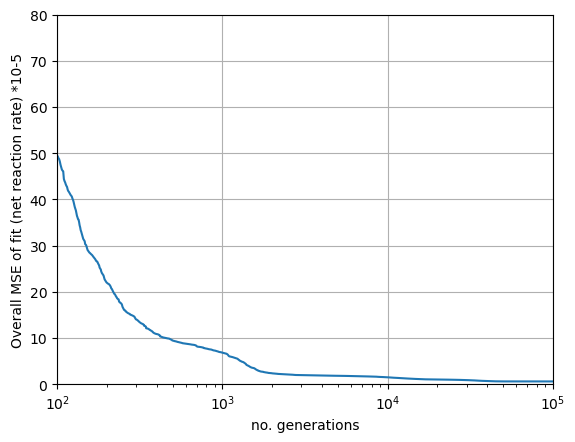

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-7.900712059643246
-8.40094649160399
-7.60144314413881
-8.799867598873048
-8.301690889738142
-7.107822045566617
-8.099733120224146
-10.36757461893563
-7.707229038237079
-6.806472094347179
-7.3067179492343355
-8.00406297807694
-7.908291196808857
-6.804779043104706
-7.404824425198369
-7.409879677211204
-7.899633272173883
-9.066564931921521
-8.384016431631977
-6.502408843850558
-7.302434192904738
-6.719509265788321
-7.519688238161389
-11.999999451260045
-7.31926907717166
-7.8201110689404025
-1.301029999965926


In [37]:
res.X

array([ -7.90071206,  -8.40094649,  -7.60144314,  -8.7998676 ,
        -8.30169089,  -7.10782205,  -8.09973312, -10.36757462,
        -7.70722904,  -6.80647209,  -7.30671795,  -8.00406298,
        -7.9082912 ,  -6.80477904,  -7.40482443,  -7.40987968,
        -7.89963327,  -9.06656493,  -8.38401643,  -6.50240884,
        -7.30243419,  -6.71950927,  -7.51968824, -11.99999945,
        -7.31926908,  -7.82011107,  -1.30103   ])

In [38]:
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

for i in range(len (logkr)):
    print (logkr[i])

-7.9
-8.4
-7.6
-8.8
-8.3
-7.1
-8.1
-10.9
-7.7
-6.8
-7.3
-8.0
-7.9
-6.8
-7.4
-7.4
-7.9
-9.1
-8.4
-6.5
-7.3
-6.7
-7.5
-11.8
-7.3
-7.8


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-7.9: -7.900712059643246
-8.4: -8.40094649160399
-7.6: -7.60144314413881
-8.8: -8.799867598873048
-8.3: -8.301690889738142
-7.1: -7.107822045566617
-8.1: -8.099733120224146
-10.9: -10.36757461893563
-7.7: -7.707229038237079
-6.8: -6.806472094347179
-7.3: -7.3067179492343355
-8.0: -8.00406297807694
-7.9: -7.908291196808857
-6.8: -6.804779043104706
-7.4: -7.404824425198369
-7.4: -7.409879677211204
-7.9: -7.899633272173883
-9.1: -9.066564931921521
-8.4: -8.384016431631977
-6.5: -6.502408843850558
-7.3: -7.302434192904738
-6.7: -6.719509265788321
-7.5: -7.519688238161389
-11.8: -11.999999451260045
-7.3: -7.31926907717166
-7.8: -7.8201110689404025
R-value: 0.9953787752685632
R2: 0.990778906255145


In [1]:
# Use stored solution
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds

krseed1 = [ -7.90071206,  -8.40094649,  -7.60144314,  -8.7998676 ,
        -8.30169089,  -7.10782205,  -8.09973312, -10.36757462,
        -7.70722904,  -6.80647209,  -7.30671795,  -8.00406298,
        -7.9082912 ,  -6.80477904,  -7.40482443,  -7.40987968,
        -7.89963327,  -9.06656493,  -8.38401643,  -6.50240884,
        -7.30243419,  -6.71950927,  -7.51968824, -11.99999945,
        -7.31926908,  -7.82011107,  -1.30103   ]
#np.ndarray.tolist(res.X)
krseed10 = [ -7.90076842,  -8.40102827,  -7.60140267,  -8.79951861,
        -8.30172641,  -7.10747346,  -8.10003017, -10.38135793,
        -7.70693793,  -6.80632851,  -7.30665321,  -8.00421281,
        -7.90834613,  -6.80447073,  -7.40450285,  -7.40968654,
        -7.89919033,  -9.06694378,  -8.3829662 ,  -6.50221554,
        -7.30224129,  -6.7171755 ,  -7.51732784, -11.99999992,
        -7.32025712,  -7.82117346,  -1.30103   ]
krseed101 = [ -7.90074835,  -8.40099096,  -7.60138512,  -8.79992415,
        -8.30159967,  -7.10752432,  -8.10005641, -10.40042564,
        -7.70699332,  -6.80628655,  -7.30671867,  -8.00485336,
        -7.90846967,  -6.80460364,  -7.40461802,  -7.40912815,
        -7.90007428,  -9.0764167 ,  -8.3853507 ,  -6.50229874,
        -7.30232256,  -6.71864079,  -7.51879979, -11.99999809,
        -7.32291905,  -7.82396135,  -1.30103   ]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.9912443075990539
r: 0.995612528847972
-7.900742943333333
-8.400988573333334
-7.6014103099999994
-8.79977012
-8.301672323333333
-7.10760661
-8.0999399
-10.383119396666666
-7.707053429999999
-6.806362383333333
-7.30669661
-8.004376383333332
-7.9083689999999995
-6.8046178033333335
-7.404648433333333
-7.40956479
-7.899632626666666
-9.069975136666667
-8.384111110000001
-6.502307706666667
-7.30233268
-6.718441853333334
-7.51860529
-11.999999153333334
-7.320815083333333
-7.821748626666667


In [2]:
meankr

[-7.900742943333333,
 -8.400988573333334,
 -7.6014103099999994,
 -8.79977012,
 -8.301672323333333,
 -7.10760661,
 -8.0999399,
 -10.383119396666666,
 -7.707053429999999,
 -6.806362383333333,
 -7.30669661,
 -8.004376383333332,
 -7.9083689999999995,
 -6.8046178033333335,
 -7.404648433333333,
 -7.40956479,
 -7.899632626666666,
 -9.069975136666667,
 -8.384111110000001,
 -6.502307706666667,
 -7.30233268,
 -6.718441853333334,
 -7.51860529,
 -11.999999153333334,
 -7.320815083333333,
 -7.821748626666667]

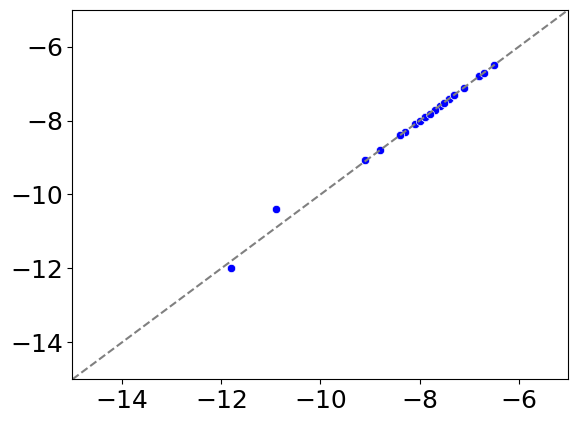

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, -5])
plt.ylim([-15, -5])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()